In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import wandb
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image
from sklearn.metrics import f1_score, roc_auc_score

# Initialize wandb
wandb.init(project="model-a-classifier", config={
    "img_width": 128,
    "img_height": 128,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "architecture": "VGG16",
})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dnicho26 (dnicho26-university-of-north-carolina-at-charlotte). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.18.5


wandb: Run data is saved locally in /opt/notebooks/Applied-AI-Midterm/wandb/run-20241104_030933-upzu6d1m
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run clear-energy-19


wandb: ⭐️ View project at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-a-classifier


wandb: 🚀 View run at https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-a-classifier/runs/upzu6d1m


In [2]:
# Configuration
config = wandb.config
data_dir = r'/opt/notebooks/Applied-AI-Midterm/Data/train'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))

True
Tesla P100-PCIE-16GB


In [3]:
# Custom Dataset to handle your directory structure
class CustomImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        
        label = 0 if 'cat' in img_path else 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Gathering all image paths
all_images = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
train_size = int(0.8 * len(all_images))
valid_size = len(all_images) - train_size

# Splitting the dataset into training and validation sets
train_images, valid_images = torch.utils.data.random_split(all_images, [train_size, valid_size])

# Data transformation and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((config.img_width, config.img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Creating datasets and loaders
train_dataset = CustomImageDataset(train_images, transform=data_transforms['train'])
valid_dataset = CustomImageDataset(valid_images, transform=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9568627228736877].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9960784730911255].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9529411773681641].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9764706132411958].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.886274522304535].


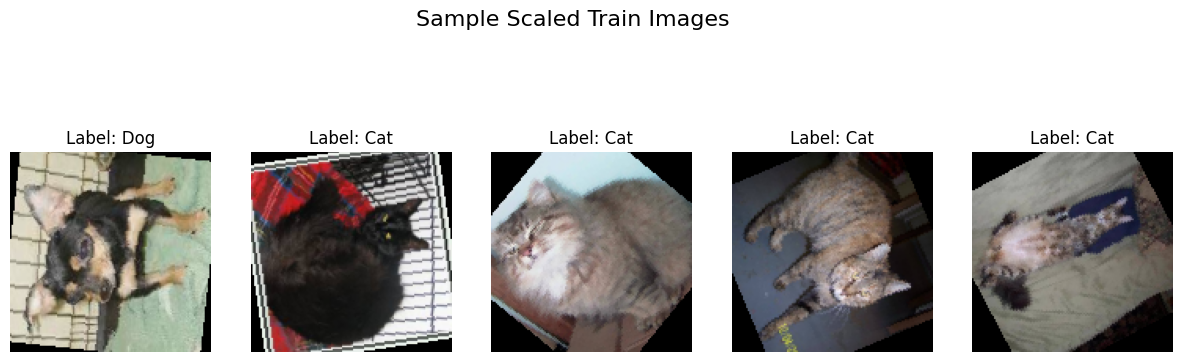

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2549019796252251..1.0000000236034394].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].


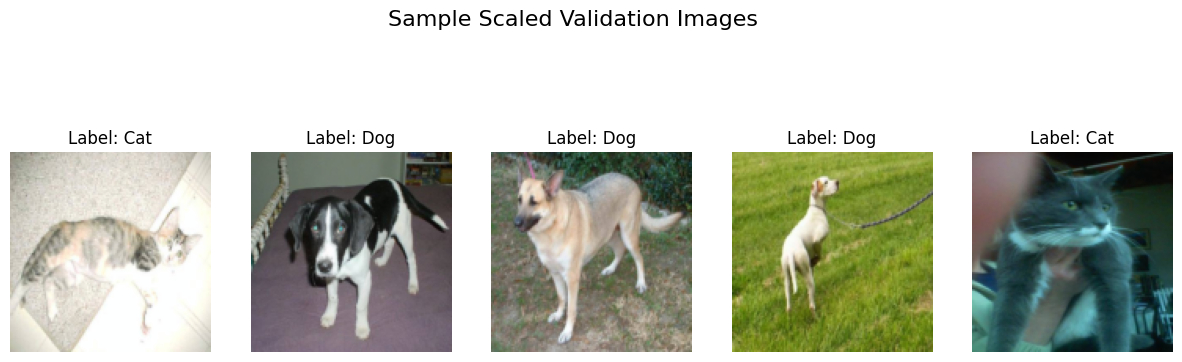

In [5]:
import matplotlib.pyplot as plt

def show_images_from_loader(loader, title):
    # Fetch a batch of images
    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axs):
        ax.imshow(images[i] * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        ax.set_title(f'Label: {"Cat" if labels[i] == 0 else "Dog"}')
        ax.axis('off')

    plt.show()

# Display some train images
show_images_from_loader(train_loader, "Sample Scaled Train Images")

# Display some validation images
show_images_from_loader(valid_loader, "Sample Scaled Validation Images")

In [6]:
# Load pretrained VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Modify the output layer to match the number of classes

# Freeze layers except the last few
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# Define loss function and optimizer
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=[0 if 'cat' in img else 1 for img in all_images])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/applied-ai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import os

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_val_loss = float('inf')

    def __call__(self, val_loss, model, path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.best_val_loss = val_loss


In [8]:
from tqdm import tqdm
# Initialize metrics dictionary
metrics = {
    'train_losses': [], 'val_losses': [],
    'train_accuracies': [], 'val_accuracies': [],
    'train_f1s': [], 'val_f1s': [],
    'train_aucs': [], 'val_aucs': []
}

# Define the training function
def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs, metrics, patience=5, model_dir='models', model_name='best_model-a.pth'):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    print("Starting training loop...")

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0
        all_labels, all_preds = [], []
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
        
        # Calculate and store metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        epoch_f1 = f1_score(all_labels, all_preds, average="macro")
        epoch_auc = roc_auc_score(all_labels, np.array(all_preds), multi_class='ovr')
        metrics['train_losses'].append(epoch_loss)
        metrics['train_accuracies'].append(epoch_acc.item())
        metrics['train_f1s'].append(epoch_f1)
        metrics['train_aucs'].append(epoch_auc)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        # Calculate and store validation metrics
        val_loss /= len(valid_loader.dataset)
        val_acc = val_corrects.double() / len(valid_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds, average="macro")
        val_auc = roc_auc_score(all_labels, np.array(all_preds), multi_class='ovr')
        metrics['val_losses'].append(val_loss)
        metrics['val_accuracies'].append(val_acc.item())
        metrics['val_f1s'].append(val_f1)
        metrics['val_aucs'].append(val_auc)

        # Log to wandb
        wandb.log({"epoch": epoch, "train_loss": epoch_loss, "train_accuracy": epoch_acc, "train_f1": epoch_f1, "train_auc": epoch_auc,
                   "val_loss": val_loss, "val_accuracy": val_acc, "val_f1": val_f1, "val_auc": val_auc})

        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(model_dir, model_name)
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with val_loss: {best_val_loss:.4f} at {best_model_path}")

        # Early stopping
        early_stopping(val_loss, model, best_model_path)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [9]:
epochs = wandb.config.epochs
# Train the model and update metrics dictionary
train_model(model, criterion, optimizer, train_loader, valid_loader, epochs, metrics)

# Finish the wandb run
wandb.finish()

Starting training loop...


Epoch 1/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 1/100:   0%|▏                                                                                                                                 | 1/625 [00:02<26:59,  2.60s/batch]

Epoch 1/100:   0%|▍                                                                                                                                 | 2/625 [00:04<24:57,  2.40s/batch]

Epoch 1/100:   0%|▌                                                                                                                                 | 3/625 [00:07<23:49,  2.30s/batch]

Epoch 1/100:   1%|▊                                                                                                                                 | 4/625 [00:09<23:11,  2.24s/batch]

Epoch 1/100:   1%|█                                                                                                                                 | 5/625 [00:11<23:06,  2.24s/batch]

Epoch 1/100:   1%|█▏                                                                                                                                | 6/625 [00:13<23:17,  2.26s/batch]

Epoch 1/100:   1%|█▍                                                                                                                                | 7/625 [00:16<23:29,  2.28s/batch]

Epoch 1/100:   1%|█▋                                                                                                                                | 8/625 [00:18<23:41,  2.30s/batch]

Epoch 1/100:   1%|█▊                                                                                                                                | 9/625 [00:20<23:36,  2.30s/batch]

Epoch 1/100:   2%|██                                                                                                                               | 10/625 [00:23<23:41,  2.31s/batch]

Epoch 1/100:   2%|██▎                                                                                                                              | 11/625 [00:25<23:38,  2.31s/batch]

Epoch 1/100:   2%|██▍                                                                                                                              | 12/625 [00:27<23:42,  2.32s/batch]

Epoch 1/100:   2%|██▋                                                                                                                              | 13/625 [00:29<23:05,  2.26s/batch]

Epoch 1/100:   2%|██▉                                                                                                                              | 14/625 [00:31<22:40,  2.23s/batch]

Epoch 1/100:   2%|███                                                                                                                              | 15/625 [00:34<22:56,  2.26s/batch]

Epoch 1/100:   3%|███▎                                                                                                                             | 16/625 [00:36<23:08,  2.28s/batch]

Epoch 1/100:   3%|███▌                                                                                                                             | 17/625 [00:38<23:00,  2.27s/batch]

Epoch 1/100:   3%|███▋                                                                                                                             | 18/625 [00:41<23:07,  2.29s/batch]

Epoch 1/100:   3%|███▉                                                                                                                             | 19/625 [00:43<23:09,  2.29s/batch]

Epoch 1/100:   3%|████▏                                                                                                                            | 20/625 [00:46<23:54,  2.37s/batch]

Epoch 1/100:   3%|████▎                                                                                                                            | 21/625 [00:48<23:45,  2.36s/batch]

Epoch 1/100:   4%|████▌                                                                                                                            | 22/625 [00:50<23:31,  2.34s/batch]

Epoch 1/100:   4%|████▋                                                                                                                            | 23/625 [00:52<23:14,  2.32s/batch]

Epoch 1/100:   4%|████▉                                                                                                                            | 24/625 [00:55<22:54,  2.29s/batch]

Epoch 1/100:   4%|█████▏                                                                                                                           | 25/625 [00:57<22:34,  2.26s/batch]

Epoch 1/100:   4%|█████▎                                                                                                                           | 26/625 [00:59<22:32,  2.26s/batch]

Epoch 1/100:   4%|█████▌                                                                                                                           | 27/625 [01:01<22:20,  2.24s/batch]

Epoch 1/100:   4%|█████▊                                                                                                                           | 28/625 [01:03<21:54,  2.20s/batch]

Epoch 1/100:   5%|█████▉                                                                                                                           | 29/625 [01:06<22:11,  2.23s/batch]

Epoch 1/100:   5%|██████▏                                                                                                                          | 30/625 [01:08<21:56,  2.21s/batch]

Epoch 1/100:   5%|██████▍                                                                                                                          | 31/625 [01:10<21:48,  2.20s/batch]

Epoch 1/100:   5%|██████▌                                                                                                                          | 32/625 [01:12<21:47,  2.20s/batch]

Epoch 1/100:   5%|██████▊                                                                                                                          | 33/625 [01:14<21:35,  2.19s/batch]

Epoch 1/100:   5%|███████                                                                                                                          | 34/625 [01:17<21:29,  2.18s/batch]

Epoch 1/100:   6%|███████▏                                                                                                                         | 35/625 [01:19<21:28,  2.18s/batch]

Epoch 1/100:   6%|███████▍                                                                                                                         | 36/625 [01:21<21:33,  2.20s/batch]

Epoch 1/100:   6%|███████▋                                                                                                                         | 37/625 [01:23<21:29,  2.19s/batch]

Epoch 1/100:   6%|███████▊                                                                                                                         | 38/625 [01:26<21:49,  2.23s/batch]

Epoch 1/100:   6%|████████                                                                                                                         | 39/625 [01:28<22:10,  2.27s/batch]

Epoch 1/100:   6%|████████▎                                                                                                                        | 40/625 [01:30<22:06,  2.27s/batch]

Epoch 1/100:   7%|████████▍                                                                                                                        | 41/625 [01:32<21:48,  2.24s/batch]

Epoch 1/100:   7%|████████▋                                                                                                                        | 42/625 [01:34<21:36,  2.22s/batch]

Epoch 1/100:   7%|████████▉                                                                                                                        | 43/625 [01:37<21:41,  2.24s/batch]

Epoch 1/100:   7%|█████████                                                                                                                        | 44/625 [01:39<21:33,  2.23s/batch]

Epoch 1/100:   7%|█████████▎                                                                                                                       | 45/625 [01:41<21:40,  2.24s/batch]

Epoch 1/100:   7%|█████████▍                                                                                                                       | 46/625 [01:44<22:00,  2.28s/batch]

Epoch 1/100:   8%|█████████▋                                                                                                                       | 47/625 [01:46<22:06,  2.30s/batch]

Epoch 1/100:   8%|█████████▉                                                                                                                       | 48/625 [01:48<22:26,  2.33s/batch]

Epoch 1/100:   8%|██████████                                                                                                                       | 49/625 [01:51<22:27,  2.34s/batch]

Epoch 1/100:   8%|██████████▎                                                                                                                      | 50/625 [01:53<22:40,  2.37s/batch]

Epoch 1/100:   8%|██████████▌                                                                                                                      | 51/625 [01:55<22:18,  2.33s/batch]

Epoch 1/100:   8%|██████████▋                                                                                                                      | 52/625 [01:58<22:21,  2.34s/batch]

Epoch 1/100:   8%|██████████▉                                                                                                                      | 53/625 [02:00<22:18,  2.34s/batch]

Epoch 1/100:   9%|███████████▏                                                                                                                     | 54/625 [02:02<22:24,  2.35s/batch]

Epoch 1/100:   9%|███████████▎                                                                                                                     | 55/625 [02:05<22:18,  2.35s/batch]

Epoch 1/100:   9%|███████████▌                                                                                                                     | 56/625 [02:07<22:06,  2.33s/batch]

Epoch 1/100:   9%|███████████▊                                                                                                                     | 57/625 [02:09<21:49,  2.31s/batch]

Epoch 1/100:   9%|███████████▉                                                                                                                     | 58/625 [02:12<21:40,  2.29s/batch]

Epoch 1/100:   9%|████████████▏                                                                                                                    | 59/625 [02:14<22:12,  2.36s/batch]

Epoch 1/100:  10%|████████████▍                                                                                                                    | 60/625 [02:16<21:57,  2.33s/batch]

Epoch 1/100:  10%|████████████▌                                                                                                                    | 61/625 [02:19<21:45,  2.31s/batch]

Epoch 1/100:  10%|████████████▊                                                                                                                    | 62/625 [02:21<21:36,  2.30s/batch]

Epoch 1/100:  10%|█████████████                                                                                                                    | 63/625 [02:23<21:55,  2.34s/batch]

Epoch 1/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:26<21:49,  2.34s/batch]

Epoch 1/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:28<21:40,  2.32s/batch]

Epoch 1/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:30<21:57,  2.36s/batch]

Epoch 1/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:33<22:05,  2.38s/batch]

Epoch 1/100:  11%|██████████████                                                                                                                   | 68/625 [02:35<21:57,  2.37s/batch]

Epoch 1/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:37<21:29,  2.32s/batch]

Epoch 1/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:40<21:16,  2.30s/batch]

Epoch 1/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:42<21:32,  2.33s/batch]

Epoch 1/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:44<21:34,  2.34s/batch]

Epoch 1/100:  12%|███████████████                                                                                                                  | 73/625 [02:47<21:39,  2.35s/batch]

Epoch 1/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:49<21:12,  2.31s/batch]

Epoch 1/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:51<20:59,  2.29s/batch]

Epoch 1/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:54<21:04,  2.30s/batch]

Epoch 1/100:  12%|███████████████▉                                                                                                                 | 77/625 [02:56<21:04,  2.31s/batch]

Epoch 1/100:  12%|████████████████                                                                                                                 | 78/625 [02:58<20:36,  2.26s/batch]

Epoch 1/100:  13%|████████████████▎                                                                                                                | 79/625 [03:00<20:19,  2.23s/batch]

Epoch 1/100:  13%|████████████████▌                                                                                                                | 80/625 [03:02<20:01,  2.20s/batch]

Epoch 1/100:  13%|████████████████▋                                                                                                                | 81/625 [03:05<20:05,  2.22s/batch]

Epoch 1/100:  13%|████████████████▉                                                                                                                | 82/625 [03:07<19:48,  2.19s/batch]

Epoch 1/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:09<19:53,  2.20s/batch]

Epoch 1/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:11<19:59,  2.22s/batch]

Epoch 1/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:13<19:57,  2.22s/batch]

Epoch 1/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:16<20:06,  2.24s/batch]

Epoch 1/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:18<20:07,  2.24s/batch]

Epoch 1/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:20<19:59,  2.23s/batch]

Epoch 1/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:23<20:25,  2.29s/batch]

Epoch 1/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:25<20:09,  2.26s/batch]

Epoch 1/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:27<20:02,  2.25s/batch]

Epoch 1/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:29<20:02,  2.26s/batch]

Epoch 1/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:32<20:07,  2.27s/batch]

Epoch 1/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:34<20:07,  2.27s/batch]

Epoch 1/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:36<20:55,  2.37s/batch]

Epoch 1/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:39<20:35,  2.34s/batch]

Epoch 1/100:  16%|████████████████████                                                                                                             | 97/625 [03:41<20:26,  2.32s/batch]

Epoch 1/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:43<20:05,  2.29s/batch]

Epoch 1/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:45<19:46,  2.26s/batch]

Epoch 1/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:48<20:26,  2.34s/batch]

Epoch 1/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:50<20:25,  2.34s/batch]

Epoch 1/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:52<19:53,  2.28s/batch]

Epoch 1/100:  16%|█████████████████████                                                                                                           | 103/625 [03:55<19:37,  2.26s/batch]

Epoch 1/100:  17%|█████████████████████▎                                                                                                          | 104/625 [03:57<20:13,  2.33s/batch]

Epoch 1/100:  17%|█████████████████████▌                                                                                                          | 105/625 [03:59<20:14,  2.33s/batch]

Epoch 1/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:02<19:57,  2.31s/batch]

Epoch 1/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:04<19:28,  2.26s/batch]

Epoch 1/100:  17%|██████████████████████                                                                                                          | 108/625 [04:06<19:35,  2.27s/batch]

Epoch 1/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:08<19:21,  2.25s/batch]

Epoch 1/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:11<19:15,  2.24s/batch]

Epoch 1/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:13<19:10,  2.24s/batch]

Epoch 1/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:15<19:36,  2.29s/batch]

Epoch 1/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:18<20:09,  2.36s/batch]

Epoch 1/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:20<20:00,  2.35s/batch]

Epoch 1/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:22<19:32,  2.30s/batch]

Epoch 1/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:24<19:15,  2.27s/batch]

Epoch 1/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:27<19:38,  2.32s/batch]

Epoch 1/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:29<19:33,  2.31s/batch]

Epoch 1/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:31<19:09,  2.27s/batch]

Epoch 1/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:34<18:44,  2.23s/batch]

Epoch 1/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:36<18:52,  2.25s/batch]

Epoch 1/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:38<19:01,  2.27s/batch]

Epoch 1/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:40<18:43,  2.24s/batch]

Epoch 1/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:43<18:56,  2.27s/batch]

Epoch 1/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:45<18:53,  2.27s/batch]

Epoch 1/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:47<18:48,  2.26s/batch]

Epoch 1/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:49<18:39,  2.25s/batch]

Epoch 1/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:52<18:44,  2.26s/batch]

Epoch 1/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [04:54<18:39,  2.26s/batch]

Epoch 1/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [04:56<18:14,  2.21s/batch]

Epoch 1/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [04:58<18:02,  2.19s/batch]

Epoch 1/100:  21%|███████████████████████████                                                                                                     | 132/625 [05:00<18:16,  2.23s/batch]

Epoch 1/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:03<18:16,  2.23s/batch]

Epoch 1/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:05<18:13,  2.23s/batch]

Epoch 1/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:07<18:29,  2.26s/batch]

Epoch 1/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:09<18:19,  2.25s/batch]

Epoch 1/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:12<18:03,  2.22s/batch]

Epoch 1/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:14<17:50,  2.20s/batch]

Epoch 1/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:16<17:40,  2.18s/batch]

Epoch 1/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:18<17:34,  2.17s/batch]

Epoch 1/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:20<17:34,  2.18s/batch]

Epoch 1/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:22<17:32,  2.18s/batch]

Epoch 1/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:25<17:24,  2.17s/batch]

Epoch 1/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:27<17:20,  2.16s/batch]

Epoch 1/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:29<17:48,  2.23s/batch]

Epoch 1/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:31<17:39,  2.21s/batch]

Epoch 1/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:33<17:36,  2.21s/batch]

Epoch 1/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:36<17:34,  2.21s/batch]

Epoch 1/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:38<17:33,  2.21s/batch]

Epoch 1/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:40<17:44,  2.24s/batch]

Epoch 1/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:43<18:00,  2.28s/batch]

Epoch 1/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:45<17:55,  2.27s/batch]

Epoch 1/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:47<17:39,  2.25s/batch]

Epoch 1/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:49<17:23,  2.22s/batch]

Epoch 1/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [05:51<17:32,  2.24s/batch]

Epoch 1/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [05:54<17:27,  2.23s/batch]

Epoch 1/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [05:56<17:35,  2.26s/batch]

Epoch 1/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [05:58<17:45,  2.28s/batch]

Epoch 1/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:01<17:45,  2.29s/batch]

Epoch 1/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:03<18:11,  2.35s/batch]

Epoch 1/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:06<18:16,  2.36s/batch]

Epoch 1/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:08<18:18,  2.37s/batch]

Epoch 1/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:10<18:14,  2.37s/batch]

Epoch 1/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:13<18:17,  2.38s/batch]

Epoch 1/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:15<17:54,  2.34s/batch]

Epoch 1/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:17<18:00,  2.35s/batch]

Epoch 1/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:20<17:50,  2.34s/batch]

Epoch 1/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:22<17:40,  2.32s/batch]

Epoch 1/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:24<17:42,  2.33s/batch]

Epoch 1/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:26<17:22,  2.29s/batch]

Epoch 1/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:29<16:56,  2.24s/batch]

Epoch 1/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:31<16:32,  2.19s/batch]

Epoch 1/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:33<16:36,  2.20s/batch]

Epoch 1/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:35<16:56,  2.25s/batch]

Epoch 1/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:37<16:44,  2.23s/batch]

Epoch 1/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:40<16:40,  2.23s/batch]

Epoch 1/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:42<16:37,  2.23s/batch]

Epoch 1/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:44<16:48,  2.26s/batch]

Epoch 1/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:46<16:40,  2.24s/batch]

Epoch 1/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:49<16:30,  2.23s/batch]

Epoch 1/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [06:51<16:20,  2.21s/batch]

Epoch 1/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [06:53<16:26,  2.23s/batch]

Epoch 1/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [06:55<16:19,  2.22s/batch]

Epoch 1/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [06:58<16:34,  2.26s/batch]

Epoch 1/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [07:00<16:36,  2.27s/batch]

Epoch 1/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:02<16:40,  2.28s/batch]

Epoch 1/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:04<16:29,  2.26s/batch]

Epoch 1/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:07<16:42,  2.29s/batch]

Epoch 1/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:09<16:28,  2.27s/batch]

Epoch 1/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:11<16:31,  2.28s/batch]

Epoch 1/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:14<16:22,  2.26s/batch]

Epoch 1/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:16<16:32,  2.29s/batch]

Epoch 1/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:18<16:34,  2.30s/batch]

Epoch 1/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:20<16:25,  2.29s/batch]

Epoch 1/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:23<16:16,  2.27s/batch]

Epoch 1/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:25<16:15,  2.27s/batch]

Epoch 1/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:27<16:07,  2.26s/batch]

Epoch 1/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:29<16:05,  2.26s/batch]

Epoch 1/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:32<16:02,  2.26s/batch]

Epoch 1/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:34<16:12,  2.29s/batch]

Epoch 1/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:36<16:21,  2.31s/batch]

Epoch 1/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:39<16:03,  2.28s/batch]

Epoch 1/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:41<16:00,  2.28s/batch]

Epoch 1/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:43<16:00,  2.28s/batch]

Epoch 1/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:45<15:40,  2.24s/batch]

Epoch 1/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:48<15:35,  2.23s/batch]

Epoch 1/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [07:50<15:27,  2.22s/batch]

Epoch 1/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [07:52<15:26,  2.22s/batch]

Epoch 1/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [07:54<15:49,  2.28s/batch]

Epoch 1/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [07:57<15:49,  2.29s/batch]

Epoch 1/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [07:59<15:44,  2.28s/batch]

Epoch 1/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:01<15:32,  2.26s/batch]

Epoch 1/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:03<15:36,  2.27s/batch]

Epoch 1/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:06<16:01,  2.34s/batch]

Epoch 1/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:08<16:12,  2.37s/batch]

Epoch 1/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:11<15:39,  2.30s/batch]

Epoch 1/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:13<15:22,  2.26s/batch]

Epoch 1/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:15<15:20,  2.26s/batch]

Epoch 1/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:17<15:07,  2.23s/batch]

Epoch 1/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:19<15:18,  2.27s/batch]

Epoch 1/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:22<15:06,  2.24s/batch]

Epoch 1/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:24<14:55,  2.22s/batch]

Epoch 1/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:26<14:45,  2.20s/batch]

Epoch 1/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:28<14:40,  2.20s/batch]

Epoch 1/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:30<14:49,  2.22s/batch]

Epoch 1/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:33<14:49,  2.23s/batch]

Epoch 1/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:35<14:40,  2.21s/batch]

Epoch 1/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:37<14:24,  2.18s/batch]

Epoch 1/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:39<14:18,  2.17s/batch]

Epoch 1/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:41<14:22,  2.18s/batch]

Epoch 1/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:44<14:24,  2.19s/batch]

Epoch 1/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [08:46<14:24,  2.20s/batch]

Epoch 1/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [08:48<14:22,  2.20s/batch]

Epoch 1/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [08:50<14:20,  2.20s/batch]

Epoch 1/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [08:53<14:40,  2.26s/batch]

Epoch 1/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [08:55<14:41,  2.27s/batch]

Epoch 1/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [08:57<14:35,  2.26s/batch]

Epoch 1/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [08:59<14:16,  2.21s/batch]

Epoch 1/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:02<14:24,  2.24s/batch]

Epoch 1/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:04<14:29,  2.26s/batch]

Epoch 1/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:06<14:19,  2.24s/batch]

Epoch 1/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:08<14:14,  2.23s/batch]

Epoch 1/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:10<14:16,  2.24s/batch]

Epoch 1/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:13<14:21,  2.26s/batch]

Epoch 1/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:15<14:06,  2.23s/batch]

Epoch 1/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:17<14:20,  2.27s/batch]

Epoch 1/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:20<14:15,  2.26s/batch]

Epoch 1/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:22<14:02,  2.23s/batch]

Epoch 1/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:24<13:47,  2.20s/batch]

Epoch 1/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:26<14:20,  2.30s/batch]

Epoch 1/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:29<14:24,  2.31s/batch]

Epoch 1/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:31<14:18,  2.30s/batch]

Epoch 1/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:33<14:00,  2.26s/batch]

Epoch 1/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:35<13:44,  2.22s/batch]

Epoch 1/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:38<14:16,  2.31s/batch]

Epoch 1/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:40<14:14,  2.32s/batch]

Epoch 1/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [09:42<14:04,  2.30s/batch]

Epoch 1/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [09:45<13:53,  2.27s/batch]

Epoch 1/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [09:47<13:45,  2.25s/batch]

Epoch 1/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [09:49<13:49,  2.27s/batch]

Epoch 1/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [09:51<13:44,  2.27s/batch]

Epoch 1/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [09:54<13:44,  2.27s/batch]

Epoch 1/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [09:56<13:28,  2.23s/batch]

Epoch 1/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [09:58<13:26,  2.23s/batch]

Epoch 1/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:00<13:29,  2.25s/batch]

Epoch 1/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:03<13:30,  2.26s/batch]

Epoch 1/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:05<13:28,  2.26s/batch]

Epoch 1/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:07<13:16,  2.23s/batch]

Epoch 1/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:09<13:06,  2.21s/batch]

Epoch 1/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:11<13:09,  2.22s/batch]

Epoch 1/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:14<13:12,  2.24s/batch]

Epoch 1/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:16<13:08,  2.23s/batch]

Epoch 1/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:18<13:34,  2.31s/batch]

Epoch 1/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:21<13:33,  2.32s/batch]

Epoch 1/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:23<13:30,  2.31s/batch]

Epoch 1/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:25<13:16,  2.28s/batch]

Epoch 1/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:28<13:15,  2.28s/batch]

Epoch 1/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:30<13:06,  2.27s/batch]

Epoch 1/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:32<12:50,  2.23s/batch]

Epoch 1/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:34<12:39,  2.20s/batch]

Epoch 1/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:36<12:46,  2.23s/batch]

Epoch 1/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [10:39<12:48,  2.24s/batch]

Epoch 1/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [10:41<12:50,  2.25s/batch]

Epoch 1/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [10:43<12:55,  2.27s/batch]

Epoch 1/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [10:45<12:45,  2.25s/batch]

Epoch 1/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [10:48<12:35,  2.23s/batch]

Epoch 1/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [10:50<12:29,  2.22s/batch]

Epoch 1/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [10:52<12:30,  2.23s/batch]

Epoch 1/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [10:54<12:27,  2.23s/batch]

Epoch 1/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [10:57<12:49,  2.30s/batch]

Epoch 1/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [10:59<12:48,  2.30s/batch]

Epoch 1/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:01<12:44,  2.30s/batch]

Epoch 1/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:04<12:42,  2.30s/batch]

Epoch 1/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:06<12:47,  2.32s/batch]

Epoch 1/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:09<13:08,  2.39s/batch]

Epoch 1/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:11<12:58,  2.37s/batch]

Epoch 1/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:13<12:32,  2.30s/batch]

Epoch 1/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:15<12:31,  2.30s/batch]

Epoch 1/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:18<12:25,  2.29s/batch]

Epoch 1/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:20<12:17,  2.27s/batch]

Epoch 1/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:22<12:29,  2.31s/batch]

Epoch 1/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:25<12:33,  2.33s/batch]

Epoch 1/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:27<12:27,  2.32s/batch]

Epoch 1/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:29<12:11,  2.28s/batch]

Epoch 1/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:31<12:02,  2.26s/batch]

Epoch 1/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:33<11:56,  2.25s/batch]

Epoch 1/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:36<11:42,  2.21s/batch]

Epoch 1/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [11:38<12:00,  2.27s/batch]

Epoch 1/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [11:40<11:55,  2.26s/batch]

Epoch 1/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [11:42<11:42,  2.23s/batch]

Epoch 1/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [11:45<11:45,  2.25s/batch]

Epoch 1/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [11:47<12:00,  2.30s/batch]

Epoch 1/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [11:49<11:46,  2.26s/batch]

Epoch 1/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [11:51<11:35,  2.24s/batch]

Epoch 1/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [11:54<11:31,  2.23s/batch]

Epoch 1/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [11:56<11:20,  2.20s/batch]

Epoch 1/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [11:58<11:16,  2.20s/batch]

Epoch 1/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:00<11:13,  2.19s/batch]

Epoch 1/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:03<11:26,  2.24s/batch]

Epoch 1/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:05<11:29,  2.26s/batch]

Epoch 1/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:07<11:21,  2.24s/batch]

Epoch 1/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:09<11:30,  2.28s/batch]

Epoch 1/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:12<11:45,  2.34s/batch]

Epoch 1/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:14<11:46,  2.35s/batch]

Epoch 1/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:16<11:25,  2.29s/batch]

Epoch 1/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:19<11:07,  2.23s/batch]

Epoch 1/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:21<11:07,  2.24s/batch]

Epoch 1/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:23<11:15,  2.28s/batch]

Epoch 1/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:25<11:15,  2.28s/batch]

Epoch 1/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:28<11:04,  2.25s/batch]

Epoch 1/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:30<11:15,  2.30s/batch]

Epoch 1/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:32<11:11,  2.29s/batch]

Epoch 1/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:35<11:19,  2.33s/batch]

Epoch 1/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [12:37<11:13,  2.31s/batch]

Epoch 1/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [12:39<11:01,  2.28s/batch]

Epoch 1/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [12:42<11:04,  2.30s/batch]

Epoch 1/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [12:44<10:51,  2.26s/batch]

Epoch 1/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [12:46<10:41,  2.24s/batch]

Epoch 1/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [12:48<10:49,  2.27s/batch]

Epoch 1/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [12:51<10:49,  2.28s/batch]

Epoch 1/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [12:53<10:40,  2.25s/batch]

Epoch 1/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [12:55<10:27,  2.22s/batch]

Epoch 1/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [12:57<10:37,  2.26s/batch]

Epoch 1/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:00<10:41,  2.28s/batch]

Epoch 1/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:02<10:30,  2.25s/batch]

Epoch 1/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:04<10:21,  2.23s/batch]

Epoch 1/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:06<10:13,  2.21s/batch]

Epoch 1/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:08<10:12,  2.21s/batch]

Epoch 1/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:10<10:05,  2.19s/batch]

Epoch 1/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:13<10:02,  2.19s/batch]

Epoch 1/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:15<10:12,  2.24s/batch]

Epoch 1/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:17<10:02,  2.21s/batch]

Epoch 1/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:19<10:11,  2.25s/batch]

Epoch 1/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:22<10:05,  2.24s/batch]

Epoch 1/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:24<10:01,  2.23s/batch]

Epoch 1/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:26<10:07,  2.26s/batch]

Epoch 1/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:28<10:00,  2.24s/batch]

Epoch 1/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:31<09:58,  2.24s/batch]

Epoch 1/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:33<10:13,  2.31s/batch]

Epoch 1/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [13:35<10:08,  2.30s/batch]

Epoch 1/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [13:38<10:06,  2.30s/batch]

Epoch 1/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [13:40<10:08,  2.31s/batch]

Epoch 1/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [13:42<10:03,  2.30s/batch]

Epoch 1/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [13:45<10:10,  2.34s/batch]

Epoch 1/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [13:47<09:59,  2.31s/batch]

Epoch 1/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [13:49<09:48,  2.27s/batch]

Epoch 1/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [13:51<09:38,  2.24s/batch]

Epoch 1/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [13:54<09:46,  2.28s/batch]

Epoch 1/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [13:56<09:46,  2.29s/batch]

Epoch 1/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [13:58<09:39,  2.27s/batch]

Epoch 1/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:01<09:44,  2.30s/batch]

Epoch 1/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:03<09:38,  2.29s/batch]

Epoch 1/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:05<09:45,  2.32s/batch]

Epoch 1/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:08<09:39,  2.31s/batch]

Epoch 1/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:10<09:32,  2.29s/batch]

Epoch 1/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:12<09:25,  2.27s/batch]

Epoch 1/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:14<09:37,  2.33s/batch]

Epoch 1/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:17<09:31,  2.32s/batch]

Epoch 1/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:19<09:14,  2.25s/batch]

Epoch 1/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:21<09:18,  2.28s/batch]

Epoch 1/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:24<09:25,  2.32s/batch]

Epoch 1/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:26<09:15,  2.28s/batch]

Epoch 1/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [14:28<09:05,  2.25s/batch]

Epoch 1/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:30<09:09,  2.28s/batch]

Epoch 1/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:33<09:00,  2.25s/batch]

Epoch 1/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [14:35<08:52,  2.23s/batch]

Epoch 1/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [14:37<08:51,  2.23s/batch]

Epoch 1/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [14:39<09:00,  2.28s/batch]

Epoch 1/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [14:42<09:01,  2.29s/batch]

Epoch 1/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [14:44<08:51,  2.26s/batch]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [14:46<08:38,  2.22s/batch]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [14:48<08:32,  2.20s/batch]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [14:50<08:40,  2.25s/batch]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [14:53<08:41,  2.26s/batch]

Epoch 1/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [14:55<08:33,  2.23s/batch]

Epoch 1/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [14:57<08:27,  2.21s/batch]

Epoch 1/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [14:59<08:34,  2.25s/batch]

Epoch 1/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:02<08:39,  2.29s/batch]

Epoch 1/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:04<08:32,  2.27s/batch]

Epoch 1/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:06<08:33,  2.28s/batch]

Epoch 1/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:09<08:44,  2.34s/batch]

Epoch 1/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:11<08:44,  2.35s/batch]

Epoch 1/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:13<08:33,  2.31s/batch]

Epoch 1/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:16<08:24,  2.28s/batch]

Epoch 1/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:18<08:31,  2.32s/batch]

Epoch 1/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:20<08:26,  2.31s/batch]

Epoch 1/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:23<08:33,  2.35s/batch]

Epoch 1/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:25<08:35,  2.37s/batch]

Epoch 1/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [15:28<08:29,  2.36s/batch]

Epoch 1/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [15:30<08:37,  2.41s/batch]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:32<08:27,  2.37s/batch]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [15:35<08:11,  2.31s/batch]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [15:37<08:14,  2.33s/batch]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [15:39<08:10,  2.33s/batch]

Epoch 1/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [15:41<08:00,  2.29s/batch]

Epoch 1/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [15:44<07:52,  2.26s/batch]

Epoch 1/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [15:46<07:47,  2.25s/batch]

Epoch 1/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [15:48<07:46,  2.25s/batch]

Epoch 1/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [15:51<07:54,  2.30s/batch]

Epoch 1/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [15:53<08:03,  2.36s/batch]

Epoch 1/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [15:55<08:02,  2.37s/batch]

Epoch 1/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [15:58<07:59,  2.36s/batch]

Epoch 1/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:00<08:00,  2.38s/batch]

Epoch 1/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:03<07:55,  2.37s/batch]

Epoch 1/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:05<07:53,  2.37s/batch]

Epoch 1/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:07<07:48,  2.36s/batch]

Epoch 1/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:09<07:39,  2.32s/batch]

Epoch 1/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:12<07:28,  2.28s/batch]

Epoch 1/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:14<07:16,  2.23s/batch]

Epoch 1/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:16<07:17,  2.25s/batch]

Epoch 1/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:18<07:11,  2.23s/batch]

Epoch 1/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:20<07:08,  2.22s/batch]

Epoch 1/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:23<07:07,  2.23s/batch]

Epoch 1/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [16:25<07:03,  2.22s/batch]

Epoch 1/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [16:27<06:57,  2.19s/batch]

Epoch 1/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [16:29<06:58,  2.22s/batch]

Epoch 1/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [16:31<06:54,  2.20s/batch]

Epoch 1/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [16:34<06:54,  2.22s/batch]

Epoch 1/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [16:36<06:56,  2.24s/batch]

Epoch 1/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [16:38<07:05,  2.30s/batch]

Epoch 1/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [16:41<06:59,  2.28s/batch]

Epoch 1/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [16:43<06:59,  2.29s/batch]

Epoch 1/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [16:45<07:00,  2.31s/batch]

Epoch 1/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [16:48<06:57,  2.31s/batch]

Epoch 1/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [16:50<07:01,  2.34s/batch]

Epoch 1/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [16:52<06:56,  2.33s/batch]

Epoch 1/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [16:54<06:45,  2.28s/batch]

Epoch 1/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [16:57<06:43,  2.28s/batch]

Epoch 1/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [16:59<06:39,  2.27s/batch]

Epoch 1/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:01<06:38,  2.28s/batch]

Epoch 1/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:04<06:35,  2.27s/batch]

Epoch 1/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:06<06:37,  2.30s/batch]

Epoch 1/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:08<06:31,  2.28s/batch]

Epoch 1/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:10<06:23,  2.24s/batch]

Epoch 1/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:13<06:20,  2.24s/batch]

Epoch 1/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:15<06:21,  2.25s/batch]

Epoch 1/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:17<06:16,  2.24s/batch]

Epoch 1/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:19<06:11,  2.23s/batch]

Epoch 1/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:21<06:09,  2.23s/batch]

Epoch 1/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [17:24<06:11,  2.25s/batch]

Epoch 1/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [17:26<06:05,  2.23s/batch]

Epoch 1/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [17:28<06:00,  2.21s/batch]

Epoch 1/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [17:30<05:52,  2.18s/batch]

Epoch 1/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [17:32<05:48,  2.16s/batch]

Epoch 1/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [17:35<05:47,  2.17s/batch]

Epoch 1/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [17:37<05:42,  2.15s/batch]

Epoch 1/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [17:39<05:40,  2.16s/batch]

Epoch 1/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [17:41<05:39,  2.16s/batch]

Epoch 1/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [17:43<05:50,  2.24s/batch]

Epoch 1/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [17:46<05:49,  2.25s/batch]

Epoch 1/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [17:48<05:47,  2.25s/batch]

Epoch 1/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [17:50<05:47,  2.27s/batch]

Epoch 1/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [17:53<05:53,  2.32s/batch]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [17:55<05:51,  2.33s/batch]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [17:57<05:49,  2.33s/batch]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:00<05:44,  2.31s/batch]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:02<05:40,  2.30s/batch]

Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:04<05:35,  2.29s/batch]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:06<05:30,  2.27s/batch]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:09<05:36,  2.32s/batch]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:11<05:37,  2.34s/batch]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:13<05:30,  2.31s/batch]

Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:16<05:27,  2.31s/batch]

Epoch 1/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:18<05:16,  2.25s/batch]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:20<05:11,  2.23s/batch]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [18:22<05:06,  2.20s/batch]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [18:24<05:02,  2.19s/batch]

Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [18:27<05:02,  2.21s/batch]

Epoch 1/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [18:29<05:05,  2.25s/batch]

Epoch 1/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [18:31<04:56,  2.19s/batch]

Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [18:33<04:51,  2.17s/batch]

Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [18:35<04:49,  2.18s/batch]

Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [18:38<04:47,  2.18s/batch]

Epoch 1/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [18:40<04:44,  2.17s/batch]

Epoch 1/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [18:42<04:44,  2.19s/batch]

Epoch 1/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [18:44<04:47,  2.23s/batch]

Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [18:46<04:41,  2.20s/batch]

Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [18:48<04:37,  2.18s/batch]

Epoch 1/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [18:51<04:33,  2.17s/batch]

Epoch 1/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [18:53<04:28,  2.15s/batch]

Epoch 1/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [18:55<04:31,  2.19s/batch]

Epoch 1/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [18:57<04:32,  2.22s/batch]

Epoch 1/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:00<04:30,  2.22s/batch]

Epoch 1/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:02<04:27,  2.21s/batch]

Epoch 1/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:04<04:22,  2.19s/batch]

Epoch 1/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:06<04:23,  2.22s/batch]

Epoch 1/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:08<04:22,  2.22s/batch]

Epoch 1/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:11<04:21,  2.23s/batch]

Epoch 1/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:13<04:23,  2.27s/batch]

Epoch 1/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:15<04:20,  2.26s/batch]

Epoch 1/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [19:18<04:20,  2.28s/batch]

Epoch 1/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [19:20<04:20,  2.31s/batch]

Epoch 1/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [19:22<04:21,  2.34s/batch]

Epoch 1/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [19:25<04:20,  2.35s/batch]

Epoch 1/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [19:27<04:15,  2.33s/batch]

Epoch 1/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [19:29<04:05,  2.26s/batch]

Epoch 1/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [19:31<03:59,  2.21s/batch]

Epoch 1/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [19:33<03:59,  2.24s/batch]

Epoch 1/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [19:36<04:00,  2.27s/batch]

Epoch 1/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [19:38<03:57,  2.26s/batch]

Epoch 1/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [19:40<03:50,  2.22s/batch]

Epoch 1/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [19:42<03:49,  2.23s/batch]

Epoch 1/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [19:45<03:49,  2.25s/batch]

Epoch 1/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [19:47<03:42,  2.20s/batch]

Epoch 1/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [19:49<03:38,  2.19s/batch]

Epoch 1/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [19:51<03:40,  2.23s/batch]

Epoch 1/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [19:54<03:44,  2.30s/batch]

Epoch 1/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [19:56<03:39,  2.26s/batch]

Epoch 1/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [19:58<03:35,  2.24s/batch]

Epoch 1/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:00<03:34,  2.26s/batch]

Epoch 1/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:03<03:35,  2.29s/batch]

Epoch 1/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:05<03:31,  2.27s/batch]

Epoch 1/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:07<03:28,  2.27s/batch]

Epoch 1/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:10<03:26,  2.27s/batch]

Epoch 1/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:12<03:19,  2.22s/batch]

Epoch 1/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [20:14<03:16,  2.21s/batch]

Epoch 1/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [20:16<03:19,  2.27s/batch]

Epoch 1/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [20:19<03:18,  2.28s/batch]

Epoch 1/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [20:21<03:14,  2.26s/batch]

Epoch 1/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [20:23<03:16,  2.31s/batch]

Epoch 1/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [20:26<03:14,  2.31s/batch]

Epoch 1/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [20:28<03:10,  2.29s/batch]

Epoch 1/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [20:30<03:07,  2.28s/batch]

Epoch 1/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [20:32<03:02,  2.25s/batch]

Epoch 1/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [20:35<03:03,  2.30s/batch]

Epoch 1/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [20:37<03:03,  2.33s/batch]

Epoch 1/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [20:39<03:01,  2.33s/batch]

Epoch 1/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [20:42<02:59,  2.33s/batch]

Epoch 1/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [20:44<03:00,  2.38s/batch]

Epoch 1/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [20:47<02:59,  2.39s/batch]

Epoch 1/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [20:49<02:51,  2.32s/batch]

Epoch 1/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [20:51<02:46,  2.28s/batch]

Epoch 1/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [20:53<02:43,  2.27s/batch]

Epoch 1/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [20:55<02:40,  2.26s/batch]

Epoch 1/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [20:58<02:36,  2.24s/batch]

Epoch 1/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:00<02:34,  2.24s/batch]

Epoch 1/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:02<02:34,  2.28s/batch]

Epoch 1/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:05<02:32,  2.28s/batch]

Epoch 1/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:07<02:29,  2.27s/batch]

Epoch 1/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:09<02:29,  2.31s/batch]

Epoch 1/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [21:11<02:27,  2.31s/batch]

Epoch 1/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [21:14<02:22,  2.26s/batch]

Epoch 1/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [21:16<02:19,  2.24s/batch]

Epoch 1/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [21:18<02:16,  2.23s/batch]

Epoch 1/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [21:20<02:16,  2.27s/batch]

Epoch 1/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [21:23<02:12,  2.25s/batch]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [21:25<02:08,  2.22s/batch]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [21:27<02:07,  2.24s/batch]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [21:29<02:06,  2.26s/batch]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [21:32<02:04,  2.27s/batch]

Epoch 1/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [21:34<02:04,  2.31s/batch]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [21:36<02:04,  2.34s/batch]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [21:39<02:00,  2.32s/batch]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [21:41<01:59,  2.35s/batch]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [21:43<01:56,  2.32s/batch]

Epoch 1/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [21:46<01:54,  2.33s/batch]

Epoch 1/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [21:48<01:50,  2.31s/batch]

Epoch 1/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [21:50<01:49,  2.33s/batch]

Epoch 1/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [21:53<01:45,  2.30s/batch]

Epoch 1/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [21:55<01:42,  2.29s/batch]

Epoch 1/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [21:57<01:38,  2.24s/batch]

Epoch 1/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [21:59<01:34,  2.21s/batch]

Epoch 1/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:01<01:33,  2.23s/batch]

Epoch 1/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:04<01:32,  2.25s/batch]

Epoch 1/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:06<01:29,  2.24s/batch]

Epoch 1/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [22:08<01:28,  2.26s/batch]

Epoch 1/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [22:11<01:26,  2.27s/batch]

Epoch 1/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [22:13<01:23,  2.26s/batch]

Epoch 1/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [22:15<01:21,  2.28s/batch]

Epoch 1/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [22:17<01:18,  2.24s/batch]

Epoch 1/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [22:20<01:16,  2.26s/batch]

Epoch 1/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [22:22<01:14,  2.27s/batch]

Epoch 1/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [22:24<01:12,  2.26s/batch]

Epoch 1/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [22:26<01:11,  2.29s/batch]

Epoch 1/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [22:29<01:08,  2.30s/batch]

Epoch 1/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [22:31<01:06,  2.30s/batch]

Epoch 1/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [22:33<01:04,  2.29s/batch]

Epoch 1/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [22:35<01:00,  2.24s/batch]

Epoch 1/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [22:38<00:57,  2.21s/batch]

Epoch 1/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [22:40<00:55,  2.24s/batch]

Epoch 1/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [22:42<00:53,  2.23s/batch]

Epoch 1/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [22:44<00:51,  2.23s/batch]

Epoch 1/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [22:46<00:48,  2.21s/batch]

Epoch 1/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [22:49<00:45,  2.18s/batch]

Epoch 1/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [22:51<00:43,  2.16s/batch]

Epoch 1/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [22:53<00:41,  2.16s/batch]

Epoch 1/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [22:55<00:38,  2.16s/batch]

Epoch 1/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [22:57<00:36,  2.15s/batch]

Epoch 1/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:00<00:35,  2.21s/batch]

Epoch 1/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:02<00:33,  2.26s/batch]

Epoch 1/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [23:04<00:31,  2.24s/batch]

Epoch 1/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [23:06<00:28,  2.21s/batch]

Epoch 1/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [23:09<00:26,  2.23s/batch]

Epoch 1/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [23:11<00:24,  2.25s/batch]

Epoch 1/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [23:13<00:22,  2.27s/batch]

Epoch 1/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [23:15<00:20,  2.25s/batch]

Epoch 1/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [23:18<00:18,  2.28s/batch]

Epoch 1/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [23:20<00:16,  2.29s/batch]

Epoch 1/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [23:22<00:13,  2.32s/batch]

Epoch 1/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [23:25<00:11,  2.32s/batch]

Epoch 1/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [23:27<00:09,  2.29s/batch]

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [23:29<00:06,  2.29s/batch]

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [23:31<00:04,  2.28s/batch]

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [23:34<00:02,  2.32s/batch]

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:36<00:00,  2.30s/batch]

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:36<00:00,  2.27s/batch]

Validation Epoch 1/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 1/100:   1%|▊                                                                                                                      | 1/157 [00:02<06:16,  2.41s/batch]

Validation Epoch 1/100:   1%|█▌                                                                                                                     | 2/157 [00:04<05:54,  2.29s/batch]

Validation Epoch 1/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:49,  2.27s/batch]

Validation Epoch 1/100:   3%|███                                                                                                                    | 4/157 [00:09<05:45,  2.26s/batch]

Validation Epoch 1/100:   3%|███▊                                                                                                                   | 5/157 [00:11<05:45,  2.27s/batch]

Validation Epoch 1/100:   4%|████▌                                                                                                                  | 6/157 [00:13<05:41,  2.26s/batch]

Validation Epoch 1/100:   4%|█████▎                                                                                                                 | 7/157 [00:16<05:49,  2.33s/batch]

Validation Epoch 1/100:   5%|██████                                                                                                                 | 8/157 [00:18<05:46,  2.32s/batch]

Validation Epoch 1/100:   6%|██████▊                                                                                                                | 9/157 [00:20<05:34,  2.26s/batch]

Validation Epoch 1/100:   6%|███████▌                                                                                                              | 10/157 [00:22<05:28,  2.23s/batch]

Validation Epoch 1/100:   7%|████████▎                                                                                                             | 11/157 [00:25<05:29,  2.25s/batch]

Validation Epoch 1/100:   8%|█████████                                                                                                             | 12/157 [00:27<05:22,  2.22s/batch]

Validation Epoch 1/100:   8%|█████████▊                                                                                                            | 13/157 [00:29<05:20,  2.23s/batch]

Validation Epoch 1/100:   9%|██████████▌                                                                                                           | 14/157 [00:31<05:20,  2.24s/batch]

Validation Epoch 1/100:  10%|███████████▎                                                                                                          | 15/157 [00:33<05:15,  2.22s/batch]

Validation Epoch 1/100:  10%|████████████                                                                                                          | 16/157 [00:36<05:16,  2.24s/batch]

Validation Epoch 1/100:  11%|████████████▊                                                                                                         | 17/157 [00:38<05:17,  2.27s/batch]

Validation Epoch 1/100:  11%|█████████████▌                                                                                                        | 18/157 [00:40<05:18,  2.29s/batch]

Validation Epoch 1/100:  12%|██████████████▎                                                                                                       | 19/157 [00:42<05:06,  2.22s/batch]

Validation Epoch 1/100:  13%|███████████████                                                                                                       | 20/157 [00:45<05:00,  2.20s/batch]

Validation Epoch 1/100:  13%|███████████████▊                                                                                                      | 21/157 [00:47<05:07,  2.26s/batch]

Validation Epoch 1/100:  14%|████████████████▌                                                                                                     | 22/157 [00:49<05:03,  2.25s/batch]

Validation Epoch 1/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:51<04:56,  2.22s/batch]

Validation Epoch 1/100:  15%|██████████████████                                                                                                    | 24/157 [00:53<04:51,  2.19s/batch]

Validation Epoch 1/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:56<04:48,  2.18s/batch]

Validation Epoch 1/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:58<04:48,  2.20s/batch]

Validation Epoch 1/100:  17%|████████████████████▎                                                                                                 | 27/157 [01:00<04:45,  2.19s/batch]

Validation Epoch 1/100:  18%|█████████████████████                                                                                                 | 28/157 [01:02<04:48,  2.23s/batch]

Validation Epoch 1/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:05<04:44,  2.22s/batch]

Validation Epoch 1/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:07<04:39,  2.20s/batch]

Validation Epoch 1/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:09<04:35,  2.19s/batch]

Validation Epoch 1/100:  20%|████████████████████████                                                                                              | 32/157 [01:11<04:37,  2.22s/batch]

Validation Epoch 1/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:13<04:38,  2.24s/batch]

Validation Epoch 1/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:16<04:37,  2.25s/batch]

Validation Epoch 1/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:18<04:31,  2.23s/batch]

Validation Epoch 1/100:  23%|███████████████████████████                                                                                           | 36/157 [01:20<04:37,  2.29s/batch]

Validation Epoch 1/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:23<04:33,  2.28s/batch]

Validation Epoch 1/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:25<04:37,  2.33s/batch]

Validation Epoch 1/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:27<04:33,  2.32s/batch]

Validation Epoch 1/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:29<04:26,  2.28s/batch]

Validation Epoch 1/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:32<04:20,  2.24s/batch]

Validation Epoch 1/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:34<04:19,  2.25s/batch]

Validation Epoch 1/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:36<04:12,  2.21s/batch]

Validation Epoch 1/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:38<04:06,  2.18s/batch]

Validation Epoch 1/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:40<04:00,  2.15s/batch]

Validation Epoch 1/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:42<04:02,  2.18s/batch]

Validation Epoch 1/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:45<04:03,  2.21s/batch]

Validation Epoch 1/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:47<04:00,  2.21s/batch]

Validation Epoch 1/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:49<04:01,  2.23s/batch]

Validation Epoch 1/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:51<03:59,  2.24s/batch]

Validation Epoch 1/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:54<03:58,  2.25s/batch]

Validation Epoch 1/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:56<03:57,  2.26s/batch]

Validation Epoch 1/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [01:58<03:55,  2.26s/batch]

Validation Epoch 1/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [02:01<03:54,  2.28s/batch]

Validation Epoch 1/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:03<03:51,  2.27s/batch]

Validation Epoch 1/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:05<03:52,  2.30s/batch]

Validation Epoch 1/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:08<03:49,  2.30s/batch]

Validation Epoch 1/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:10<03:47,  2.30s/batch]

Validation Epoch 1/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:12<03:45,  2.30s/batch]

Validation Epoch 1/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:14<03:40,  2.28s/batch]

Validation Epoch 1/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:17<03:40,  2.29s/batch]

Validation Epoch 1/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:19<03:40,  2.32s/batch]

Validation Epoch 1/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:21<03:37,  2.31s/batch]

Validation Epoch 1/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:24<03:33,  2.30s/batch]

Validation Epoch 1/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:26<03:27,  2.26s/batch]

Validation Epoch 1/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:28<03:23,  2.23s/batch]

Validation Epoch 1/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:30<03:20,  2.23s/batch]

Validation Epoch 1/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:33<03:24,  2.29s/batch]

Validation Epoch 1/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:35<03:19,  2.26s/batch]

Validation Epoch 1/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:37<03:14,  2.24s/batch]

Validation Epoch 1/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:39<03:12,  2.24s/batch]

Validation Epoch 1/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:41<03:09,  2.23s/batch]

Validation Epoch 1/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:44<03:13,  2.30s/batch]

Validation Epoch 1/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:46<03:10,  2.29s/batch]

Validation Epoch 1/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:48<03:03,  2.24s/batch]

Validation Epoch 1/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:50<02:59,  2.21s/batch]

Validation Epoch 1/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:53<02:55,  2.20s/batch]

Validation Epoch 1/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:55<02:56,  2.23s/batch]

Validation Epoch 1/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [02:57<02:53,  2.23s/batch]

Validation Epoch 1/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [02:59<02:49,  2.20s/batch]

Validation Epoch 1/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [03:01<02:46,  2.19s/batch]

Validation Epoch 1/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:04<02:47,  2.23s/batch]

Validation Epoch 1/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:06<02:46,  2.25s/batch]

Validation Epoch 1/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:08<02:44,  2.25s/batch]

Validation Epoch 1/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:11<02:43,  2.27s/batch]

Validation Epoch 1/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:13<02:40,  2.26s/batch]

Validation Epoch 1/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:15<02:37,  2.25s/batch]

Validation Epoch 1/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:17<02:34,  2.24s/batch]

Validation Epoch 1/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:19<02:30,  2.21s/batch]

Validation Epoch 1/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:22<02:26,  2.19s/batch]

Validation Epoch 1/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:24<02:23,  2.18s/batch]

Validation Epoch 1/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:26<02:25,  2.24s/batch]

Validation Epoch 1/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:29<02:25,  2.27s/batch]

Validation Epoch 1/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:31<02:22,  2.26s/batch]

Validation Epoch 1/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:33<02:23,  2.31s/batch]

Validation Epoch 1/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:36<02:21,  2.32s/batch]

Validation Epoch 1/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:38<02:17,  2.30s/batch]

Validation Epoch 1/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:40<02:15,  2.30s/batch]

Validation Epoch 1/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:42<02:13,  2.30s/batch]

Validation Epoch 1/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:45<02:09,  2.28s/batch]

Validation Epoch 1/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:47<02:08,  2.30s/batch]

Validation Epoch 1/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:49<02:04,  2.26s/batch]

Validation Epoch 1/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:51<02:00,  2.24s/batch]

Validation Epoch 1/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:54<01:59,  2.25s/batch]

Validation Epoch 1/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [03:56<01:58,  2.29s/batch]

Validation Epoch 1/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [03:58<01:54,  2.25s/batch]

Validation Epoch 1/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [04:00<01:50,  2.20s/batch]

Validation Epoch 1/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [04:02<01:47,  2.19s/batch]

Validation Epoch 1/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:05<01:46,  2.23s/batch]

Validation Epoch 1/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:07<01:46,  2.26s/batch]

Validation Epoch 1/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:09<01:45,  2.29s/batch]

Validation Epoch 1/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:12<01:42,  2.28s/batch]

Validation Epoch 1/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:14<01:41,  2.30s/batch]

Validation Epoch 1/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:15<01:25,  2.00s/batch]

Validation Epoch 1/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:17<01:14,  1.78s/batch]

Validation Epoch 1/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:18<01:05,  1.61s/batch]

Validation Epoch 1/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:20<01:09,  1.74s/batch]

Validation Epoch 1/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:22<01:12,  1.87s/batch]

Validation Epoch 1/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:24<01:14,  1.95s/batch]

Validation Epoch 1/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:26<01:13,  1.98s/batch]

Validation Epoch 1/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:28<01:12,  2.03s/batch]

Validation Epoch 1/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:30<01:11,  2.04s/batch]

Validation Epoch 1/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:33<01:11,  2.09s/batch]

Validation Epoch 1/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:35<01:09,  2.12s/batch]

Validation Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:37<01:07,  2.11s/batch]

Validation Epoch 1/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:39<01:05,  2.11s/batch]

Validation Epoch 1/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:41<01:05,  2.19s/batch]

Validation Epoch 1/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:44<01:03,  2.20s/batch]

Validation Epoch 1/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:46<01:01,  2.21s/batch]

Validation Epoch 1/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:48<01:00,  2.23s/batch]

Validation Epoch 1/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [04:50<00:59,  2.27s/batch]

Validation Epoch 1/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [04:53<00:56,  2.26s/batch]

Validation Epoch 1/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [04:55<00:53,  2.22s/batch]

Validation Epoch 1/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [04:57<00:50,  2.21s/batch]

Validation Epoch 1/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [04:59<00:49,  2.23s/batch]

Validation Epoch 1/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:01<00:46,  2.20s/batch]

Validation Epoch 1/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:04<00:43,  2.19s/batch]

Validation Epoch 1/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:06<00:41,  2.16s/batch]

Validation Epoch 1/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:08<00:38,  2.16s/batch]

Validation Epoch 1/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:10<00:36,  2.15s/batch]

Validation Epoch 1/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:12<00:35,  2.19s/batch]

Validation Epoch 1/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:15<00:33,  2.24s/batch]

Validation Epoch 1/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:17<00:30,  2.21s/batch]

Validation Epoch 1/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:19<00:28,  2.20s/batch]

Validation Epoch 1/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:21<00:26,  2.21s/batch]

Validation Epoch 1/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:23<00:24,  2.22s/batch]

Validation Epoch 1/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:26<00:23,  2.32s/batch]

Validation Epoch 1/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:28<00:20,  2.31s/batch]

Validation Epoch 1/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:30<00:18,  2.30s/batch]

Validation Epoch 1/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:33<00:15,  2.25s/batch]

Validation Epoch 1/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:35<00:13,  2.29s/batch]

Validation Epoch 1/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:37<00:11,  2.27s/batch]

Validation Epoch 1/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:40<00:09,  2.30s/batch]

Validation Epoch 1/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:42<00:07,  2.34s/batch]

Validation Epoch 1/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:44<00:04,  2.32s/batch]

Validation Epoch 1/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [05:47<00:02,  2.37s/batch]

Validation Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:47<00:00,  1.83s/batch]

Validation Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:47<00:00,  2.22s/batch]

Epoch 1/100, Val Loss: 0.1808, Val Acc: 0.9640


Best model saved with val_loss: 0.1808 at model_checkpoints/best_model-a.pth
Validation loss decreased (inf --> 0.180844).  Saving model ...


Epoch 2/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 2/100:   0%|▏                                                                                                                                 | 1/625 [00:02<25:02,  2.41s/batch]

Epoch 2/100:   0%|▍                                                                                                                                 | 2/625 [00:04<24:03,  2.32s/batch]

Epoch 2/100:   0%|▌                                                                                                                                 | 3/625 [00:06<23:31,  2.27s/batch]

Epoch 2/100:   1%|▊                                                                                                                                 | 4/625 [00:09<24:10,  2.34s/batch]

Epoch 2/100:   1%|█                                                                                                                                 | 5/625 [00:11<23:59,  2.32s/batch]

Epoch 2/100:   1%|█▏                                                                                                                                | 6/625 [00:14<24:15,  2.35s/batch]

Epoch 2/100:   1%|█▍                                                                                                                                | 7/625 [00:16<23:51,  2.32s/batch]

Epoch 2/100:   1%|█▋                                                                                                                                | 8/625 [00:18<23:48,  2.32s/batch]

Epoch 2/100:   1%|█▊                                                                                                                                | 9/625 [00:20<23:20,  2.27s/batch]

Epoch 2/100:   2%|██                                                                                                                               | 10/625 [00:23<23:27,  2.29s/batch]

Epoch 2/100:   2%|██▎                                                                                                                              | 11/625 [00:25<23:44,  2.32s/batch]

Epoch 2/100:   2%|██▍                                                                                                                              | 12/625 [00:27<23:52,  2.34s/batch]

Epoch 2/100:   2%|██▋                                                                                                                              | 13/625 [00:30<23:31,  2.31s/batch]

Epoch 2/100:   2%|██▉                                                                                                                              | 14/625 [00:32<23:17,  2.29s/batch]

Epoch 2/100:   2%|███                                                                                                                              | 15/625 [00:34<23:31,  2.31s/batch]

Epoch 2/100:   3%|███▎                                                                                                                             | 16/625 [00:36<23:00,  2.27s/batch]

Epoch 2/100:   3%|███▌                                                                                                                             | 17/625 [00:39<22:44,  2.24s/batch]

Epoch 2/100:   3%|███▋                                                                                                                             | 18/625 [00:41<23:05,  2.28s/batch]

Epoch 2/100:   3%|███▉                                                                                                                             | 19/625 [00:43<23:11,  2.30s/batch]

Epoch 2/100:   3%|████▏                                                                                                                            | 20/625 [00:45<22:38,  2.25s/batch]

Epoch 2/100:   3%|████▎                                                                                                                            | 21/625 [00:48<22:48,  2.27s/batch]

Epoch 2/100:   4%|████▌                                                                                                                            | 22/625 [00:50<23:12,  2.31s/batch]

Epoch 2/100:   4%|████▋                                                                                                                            | 23/625 [00:52<22:57,  2.29s/batch]

Epoch 2/100:   4%|████▉                                                                                                                            | 24/625 [00:55<23:08,  2.31s/batch]

Epoch 2/100:   4%|█████▏                                                                                                                           | 25/625 [00:57<22:49,  2.28s/batch]

Epoch 2/100:   4%|█████▎                                                                                                                           | 26/625 [00:59<22:47,  2.28s/batch]

Epoch 2/100:   4%|█████▌                                                                                                                           | 27/625 [01:02<23:06,  2.32s/batch]

Epoch 2/100:   4%|█████▊                                                                                                                           | 28/625 [01:04<23:34,  2.37s/batch]

Epoch 2/100:   5%|█████▉                                                                                                                           | 29/625 [01:07<23:43,  2.39s/batch]

Epoch 2/100:   5%|██████▏                                                                                                                          | 30/625 [01:09<23:18,  2.35s/batch]

Epoch 2/100:   5%|██████▍                                                                                                                          | 31/625 [01:11<22:36,  2.28s/batch]

Epoch 2/100:   5%|██████▌                                                                                                                          | 32/625 [01:13<22:06,  2.24s/batch]

Epoch 2/100:   5%|██████▊                                                                                                                          | 33/625 [01:15<22:21,  2.27s/batch]

Epoch 2/100:   5%|███████                                                                                                                          | 34/625 [01:18<22:04,  2.24s/batch]

Epoch 2/100:   6%|███████▏                                                                                                                         | 35/625 [01:20<22:20,  2.27s/batch]

Epoch 2/100:   6%|███████▍                                                                                                                         | 36/625 [01:22<22:36,  2.30s/batch]

Epoch 2/100:   6%|███████▋                                                                                                                         | 37/625 [01:25<22:33,  2.30s/batch]

Epoch 2/100:   6%|███████▊                                                                                                                         | 38/625 [01:27<22:20,  2.28s/batch]

Epoch 2/100:   6%|████████                                                                                                                         | 39/625 [01:29<22:12,  2.27s/batch]

Epoch 2/100:   6%|████████▎                                                                                                                        | 40/625 [01:31<22:01,  2.26s/batch]

Epoch 2/100:   7%|████████▍                                                                                                                        | 41/625 [01:33<21:47,  2.24s/batch]

Epoch 2/100:   7%|████████▋                                                                                                                        | 42/625 [01:36<21:49,  2.25s/batch]

Epoch 2/100:   7%|████████▉                                                                                                                        | 43/625 [01:38<21:43,  2.24s/batch]

Epoch 2/100:   7%|█████████                                                                                                                        | 44/625 [01:40<21:45,  2.25s/batch]

Epoch 2/100:   7%|█████████▎                                                                                                                       | 45/625 [01:42<21:30,  2.23s/batch]

Epoch 2/100:   7%|█████████▍                                                                                                                       | 46/625 [01:45<21:13,  2.20s/batch]

Epoch 2/100:   8%|█████████▋                                                                                                                       | 47/625 [01:47<20:56,  2.17s/batch]

Epoch 2/100:   8%|█████████▉                                                                                                                       | 48/625 [01:49<21:44,  2.26s/batch]

Epoch 2/100:   8%|██████████                                                                                                                       | 49/625 [01:51<21:37,  2.25s/batch]

Epoch 2/100:   8%|██████████▎                                                                                                                      | 50/625 [01:53<21:11,  2.21s/batch]

Epoch 2/100:   8%|██████████▌                                                                                                                      | 51/625 [01:56<21:09,  2.21s/batch]

Epoch 2/100:   8%|██████████▋                                                                                                                      | 52/625 [01:58<21:15,  2.23s/batch]

Epoch 2/100:   8%|██████████▉                                                                                                                      | 53/625 [02:00<20:57,  2.20s/batch]

Epoch 2/100:   9%|███████████▏                                                                                                                     | 54/625 [02:02<21:13,  2.23s/batch]

Epoch 2/100:   9%|███████████▎                                                                                                                     | 55/625 [02:05<21:01,  2.21s/batch]

Epoch 2/100:   9%|███████████▌                                                                                                                     | 56/625 [02:07<21:16,  2.24s/batch]

Epoch 2/100:   9%|███████████▊                                                                                                                     | 57/625 [02:09<21:07,  2.23s/batch]

Epoch 2/100:   9%|███████████▉                                                                                                                     | 58/625 [02:11<21:00,  2.22s/batch]

Epoch 2/100:   9%|████████████▏                                                                                                                    | 59/625 [02:13<20:48,  2.21s/batch]

Epoch 2/100:  10%|████████████▍                                                                                                                    | 60/625 [02:16<20:56,  2.22s/batch]

Epoch 2/100:  10%|████████████▌                                                                                                                    | 61/625 [02:18<21:27,  2.28s/batch]

Epoch 2/100:  10%|████████████▊                                                                                                                    | 62/625 [02:20<21:19,  2.27s/batch]

Epoch 2/100:  10%|█████████████                                                                                                                    | 63/625 [02:23<20:52,  2.23s/batch]

Epoch 2/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:25<20:32,  2.20s/batch]

Epoch 2/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:27<20:30,  2.20s/batch]

Epoch 2/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:29<20:38,  2.21s/batch]

Epoch 2/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:31<20:33,  2.21s/batch]

Epoch 2/100:  11%|██████████████                                                                                                                   | 68/625 [02:33<20:18,  2.19s/batch]

Epoch 2/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:36<20:10,  2.18s/batch]

Epoch 2/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:38<20:06,  2.17s/batch]

Epoch 2/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:40<20:15,  2.19s/batch]

Epoch 2/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:42<20:13,  2.19s/batch]

Epoch 2/100:  12%|███████████████                                                                                                                  | 73/625 [02:44<20:07,  2.19s/batch]

Epoch 2/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:47<20:02,  2.18s/batch]

Epoch 2/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:49<20:18,  2.22s/batch]

Epoch 2/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:51<20:41,  2.26s/batch]

Epoch 2/100:  12%|███████████████▉                                                                                                                 | 77/625 [02:53<20:28,  2.24s/batch]

Epoch 2/100:  12%|████████████████                                                                                                                 | 78/625 [02:56<20:09,  2.21s/batch]

Epoch 2/100:  13%|████████████████▎                                                                                                                | 79/625 [02:58<20:05,  2.21s/batch]

Epoch 2/100:  13%|████████████████▌                                                                                                                | 80/625 [03:00<20:14,  2.23s/batch]

Epoch 2/100:  13%|████████████████▋                                                                                                                | 81/625 [03:02<20:24,  2.25s/batch]

Epoch 2/100:  13%|████████████████▉                                                                                                                | 82/625 [03:04<20:03,  2.22s/batch]

Epoch 2/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:07<20:08,  2.23s/batch]

Epoch 2/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:09<20:37,  2.29s/batch]

Epoch 2/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:11<20:25,  2.27s/batch]

Epoch 2/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:14<20:13,  2.25s/batch]

Epoch 2/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:16<20:56,  2.34s/batch]

Epoch 2/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:19<21:08,  2.36s/batch]

Epoch 2/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:21<21:04,  2.36s/batch]

Epoch 2/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:23<20:34,  2.31s/batch]

Epoch 2/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:25<20:37,  2.32s/batch]

Epoch 2/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:28<20:43,  2.33s/batch]

Epoch 2/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:30<20:20,  2.29s/batch]

Epoch 2/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:32<20:07,  2.27s/batch]

Epoch 2/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:34<20:10,  2.28s/batch]

Epoch 2/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:37<20:10,  2.29s/batch]

Epoch 2/100:  16%|████████████████████                                                                                                             | 97/625 [03:39<19:57,  2.27s/batch]

Epoch 2/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:41<19:33,  2.23s/batch]

Epoch 2/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:43<19:17,  2.20s/batch]

Epoch 2/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:45<19:14,  2.20s/batch]

Epoch 2/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:48<18:59,  2.18s/batch]

Epoch 2/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:50<18:53,  2.17s/batch]

Epoch 2/100:  16%|█████████████████████                                                                                                           | 103/625 [03:52<19:23,  2.23s/batch]

Epoch 2/100:  17%|█████████████████████▎                                                                                                          | 104/625 [03:54<19:21,  2.23s/batch]

Epoch 2/100:  17%|█████████████████████▌                                                                                                          | 105/625 [03:57<19:16,  2.22s/batch]

Epoch 2/100:  17%|█████████████████████▋                                                                                                          | 106/625 [03:59<19:45,  2.28s/batch]

Epoch 2/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:02<20:28,  2.37s/batch]

Epoch 2/100:  17%|██████████████████████                                                                                                          | 108/625 [04:04<20:40,  2.40s/batch]

Epoch 2/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:06<20:09,  2.34s/batch]

Epoch 2/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:09<20:08,  2.35s/batch]

Epoch 2/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:11<19:44,  2.30s/batch]

Epoch 2/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:13<19:26,  2.27s/batch]

Epoch 2/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:15<19:32,  2.29s/batch]

Epoch 2/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:18<19:21,  2.27s/batch]

Epoch 2/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:20<19:10,  2.26s/batch]

Epoch 2/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:22<18:53,  2.23s/batch]

Epoch 2/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:24<18:48,  2.22s/batch]

Epoch 2/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:26<18:54,  2.24s/batch]

Epoch 2/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:29<19:05,  2.26s/batch]

Epoch 2/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:31<18:59,  2.26s/batch]

Epoch 2/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:33<18:42,  2.23s/batch]

Epoch 2/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:35<18:32,  2.21s/batch]

Epoch 2/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:37<18:21,  2.19s/batch]

Epoch 2/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:40<18:32,  2.22s/batch]

Epoch 2/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:42<18:37,  2.24s/batch]

Epoch 2/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:44<18:38,  2.24s/batch]

Epoch 2/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:46<18:14,  2.20s/batch]

Epoch 2/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:49<18:15,  2.20s/batch]

Epoch 2/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [04:51<18:08,  2.19s/batch]

Epoch 2/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [04:53<18:00,  2.18s/batch]

Epoch 2/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [04:55<17:57,  2.18s/batch]

Epoch 2/100:  21%|███████████████████████████                                                                                                     | 132/625 [04:58<18:28,  2.25s/batch]

Epoch 2/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:00<18:43,  2.28s/batch]

Epoch 2/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:02<18:30,  2.26s/batch]

Epoch 2/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:04<18:41,  2.29s/batch]

Epoch 2/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:07<18:24,  2.26s/batch]

Epoch 2/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:09<19:02,  2.34s/batch]

Epoch 2/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:12<19:12,  2.37s/batch]

Epoch 2/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:14<19:14,  2.38s/batch]

Epoch 2/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:16<18:55,  2.34s/batch]

Epoch 2/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:18<18:36,  2.31s/batch]

Epoch 2/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:21<18:33,  2.31s/batch]

Epoch 2/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:23<18:30,  2.30s/batch]

Epoch 2/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:25<18:06,  2.26s/batch]

Epoch 2/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:28<18:07,  2.27s/batch]

Epoch 2/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:30<18:13,  2.28s/batch]

Epoch 2/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:32<18:06,  2.27s/batch]

Epoch 2/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:34<18:12,  2.29s/batch]

Epoch 2/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:37<18:19,  2.31s/batch]

Epoch 2/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:39<18:17,  2.31s/batch]

Epoch 2/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:41<18:09,  2.30s/batch]

Epoch 2/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:44<17:53,  2.27s/batch]

Epoch 2/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:46<18:07,  2.30s/batch]

Epoch 2/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:48<17:53,  2.28s/batch]

Epoch 2/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [05:50<17:45,  2.27s/batch]

Epoch 2/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [05:53<18:05,  2.32s/batch]

Epoch 2/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [05:55<17:53,  2.29s/batch]

Epoch 2/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [05:57<17:29,  2.25s/batch]

Epoch 2/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:00<17:35,  2.27s/batch]

Epoch 2/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:02<17:48,  2.30s/batch]

Epoch 2/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:04<17:34,  2.27s/batch]

Epoch 2/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:06<17:17,  2.24s/batch]

Epoch 2/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:08<17:05,  2.22s/batch]

Epoch 2/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:11<17:07,  2.23s/batch]

Epoch 2/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:13<17:35,  2.30s/batch]

Epoch 2/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:15<17:30,  2.29s/batch]

Epoch 2/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:18<17:29,  2.29s/batch]

Epoch 2/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:20<17:20,  2.28s/batch]

Epoch 2/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:22<17:03,  2.25s/batch]

Epoch 2/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:24<17:10,  2.26s/batch]

Epoch 2/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:27<17:06,  2.26s/batch]

Epoch 2/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:29<17:13,  2.28s/batch]

Epoch 2/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:31<17:35,  2.33s/batch]

Epoch 2/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:34<17:33,  2.34s/batch]

Epoch 2/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:36<17:23,  2.32s/batch]

Epoch 2/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:38<17:25,  2.33s/batch]

Epoch 2/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:41<17:56,  2.40s/batch]

Epoch 2/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:44<18:24,  2.47s/batch]

Epoch 2/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:46<18:08,  2.44s/batch]

Epoch 2/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:48<17:44,  2.39s/batch]

Epoch 2/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [06:50<17:05,  2.31s/batch]

Epoch 2/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [06:53<16:41,  2.26s/batch]

Epoch 2/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [06:55<16:25,  2.23s/batch]

Epoch 2/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [06:57<16:22,  2.23s/batch]

Epoch 2/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [06:59<16:27,  2.24s/batch]

Epoch 2/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:02<16:31,  2.26s/batch]

Epoch 2/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:04<16:26,  2.25s/batch]

Epoch 2/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:06<16:04,  2.21s/batch]

Epoch 2/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:08<16:18,  2.24s/batch]

Epoch 2/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:10<16:07,  2.22s/batch]

Epoch 2/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:12<15:50,  2.19s/batch]

Epoch 2/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:15<15:52,  2.20s/batch]

Epoch 2/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:17<15:58,  2.22s/batch]

Epoch 2/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:19<15:55,  2.22s/batch]

Epoch 2/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:21<15:43,  2.19s/batch]

Epoch 2/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:24<15:55,  2.23s/batch]

Epoch 2/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:26<16:03,  2.25s/batch]

Epoch 2/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:28<16:12,  2.28s/batch]

Epoch 2/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:31<16:06,  2.27s/batch]

Epoch 2/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:33<15:53,  2.24s/batch]

Epoch 2/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:35<16:00,  2.26s/batch]

Epoch 2/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:37<16:04,  2.28s/batch]

Epoch 2/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:40<16:09,  2.30s/batch]

Epoch 2/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:42<15:55,  2.27s/batch]

Epoch 2/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:44<15:51,  2.27s/batch]

Epoch 2/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:46<15:38,  2.24s/batch]

Epoch 2/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [07:48<15:30,  2.23s/batch]

Epoch 2/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [07:51<15:43,  2.26s/batch]

Epoch 2/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [07:53<16:00,  2.31s/batch]

Epoch 2/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [07:55<15:47,  2.28s/batch]

Epoch 2/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [07:58<15:21,  2.23s/batch]

Epoch 2/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:00<15:35,  2.26s/batch]

Epoch 2/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:02<15:21,  2.24s/batch]

Epoch 2/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:04<15:37,  2.28s/batch]

Epoch 2/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:07<15:20,  2.25s/batch]

Epoch 2/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:09<15:17,  2.24s/batch]

Epoch 2/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:11<15:04,  2.22s/batch]

Epoch 2/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:13<15:18,  2.26s/batch]

Epoch 2/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:16<15:12,  2.25s/batch]

Epoch 2/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:18<15:00,  2.22s/batch]

Epoch 2/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:20<14:55,  2.22s/batch]

Epoch 2/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:22<14:55,  2.22s/batch]

Epoch 2/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:25<15:07,  2.26s/batch]

Epoch 2/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:27<14:57,  2.24s/batch]

Epoch 2/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:29<14:58,  2.25s/batch]

Epoch 2/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:31<14:55,  2.25s/batch]

Epoch 2/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:33<14:50,  2.24s/batch]

Epoch 2/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:36<14:41,  2.22s/batch]

Epoch 2/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:38<14:55,  2.26s/batch]

Epoch 2/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:40<15:12,  2.31s/batch]

Epoch 2/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:43<15:07,  2.30s/batch]

Epoch 2/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [08:45<15:03,  2.30s/batch]

Epoch 2/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [08:48<15:42,  2.41s/batch]

Epoch 2/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [08:50<15:36,  2.40s/batch]

Epoch 2/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [08:52<15:38,  2.41s/batch]

Epoch 2/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [08:55<15:24,  2.38s/batch]

Epoch 2/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [08:57<15:07,  2.34s/batch]

Epoch 2/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [08:59<14:52,  2.31s/batch]

Epoch 2/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:01<14:41,  2.28s/batch]

Epoch 2/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:04<14:32,  2.27s/batch]

Epoch 2/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:06<14:32,  2.27s/batch]

Epoch 2/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:08<14:22,  2.25s/batch]

Epoch 2/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:10<14:16,  2.24s/batch]

Epoch 2/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:13<14:33,  2.29s/batch]

Epoch 2/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:15<14:29,  2.29s/batch]

Epoch 2/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:17<14:34,  2.31s/batch]

Epoch 2/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:20<14:47,  2.35s/batch]

Epoch 2/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:22<14:54,  2.37s/batch]

Epoch 2/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:25<14:54,  2.38s/batch]

Epoch 2/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:27<14:44,  2.36s/batch]

Epoch 2/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:29<14:26,  2.32s/batch]

Epoch 2/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:31<14:09,  2.28s/batch]

Epoch 2/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:34<13:54,  2.24s/batch]

Epoch 2/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:36<14:00,  2.27s/batch]

Epoch 2/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:38<14:04,  2.28s/batch]

Epoch 2/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:41<13:58,  2.27s/batch]

Epoch 2/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [09:43<14:23,  2.35s/batch]

Epoch 2/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [09:45<14:28,  2.37s/batch]

Epoch 2/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [09:48<14:22,  2.36s/batch]

Epoch 2/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [09:50<14:03,  2.31s/batch]

Epoch 2/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [09:52<14:02,  2.31s/batch]

Epoch 2/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [09:54<13:45,  2.27s/batch]

Epoch 2/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [09:57<13:30,  2.24s/batch]

Epoch 2/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [09:59<13:11,  2.19s/batch]

Epoch 2/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:01<13:04,  2.18s/batch]

Epoch 2/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:03<13:02,  2.18s/batch]

Epoch 2/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:05<13:09,  2.21s/batch]

Epoch 2/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:08<13:20,  2.24s/batch]

Epoch 2/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:10<13:23,  2.26s/batch]

Epoch 2/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:12<13:32,  2.29s/batch]

Epoch 2/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:15<13:35,  2.30s/batch]

Epoch 2/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:17<13:36,  2.31s/batch]

Epoch 2/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:19<13:19,  2.27s/batch]

Epoch 2/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:21<13:13,  2.26s/batch]

Epoch 2/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:24<13:23,  2.29s/batch]

Epoch 2/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:26<13:27,  2.31s/batch]

Epoch 2/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:28<13:20,  2.30s/batch]

Epoch 2/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:30<12:55,  2.24s/batch]

Epoch 2/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:33<12:45,  2.21s/batch]

Epoch 2/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:35<12:56,  2.25s/batch]

Epoch 2/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:37<12:48,  2.23s/batch]

Epoch 2/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [10:39<12:35,  2.20s/batch]

Epoch 2/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [10:42<12:48,  2.25s/batch]

Epoch 2/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [10:44<12:48,  2.25s/batch]

Epoch 2/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [10:46<12:52,  2.27s/batch]

Epoch 2/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [10:49<12:59,  2.30s/batch]

Epoch 2/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [10:51<13:12,  2.34s/batch]

Epoch 2/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [10:54<13:38,  2.43s/batch]

Epoch 2/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [10:56<13:21,  2.39s/batch]

Epoch 2/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [10:58<12:56,  2.32s/batch]

Epoch 2/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [11:01<13:03,  2.35s/batch]

Epoch 2/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:03<13:02,  2.35s/batch]

Epoch 2/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:05<12:53,  2.33s/batch]

Epoch 2/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:08<12:56,  2.34s/batch]

Epoch 2/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:10<13:03,  2.37s/batch]

Epoch 2/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:12<12:55,  2.36s/batch]

Epoch 2/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:15<12:52,  2.36s/batch]

Epoch 2/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:17<12:54,  2.37s/batch]

Epoch 2/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:19<12:39,  2.33s/batch]

Epoch 2/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:22<12:28,  2.30s/batch]

Epoch 2/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:24<12:39,  2.34s/batch]

Epoch 2/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:26<12:25,  2.31s/batch]

Epoch 2/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:28<12:14,  2.28s/batch]

Epoch 2/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:31<12:03,  2.25s/batch]

Epoch 2/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:33<12:16,  2.30s/batch]

Epoch 2/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:35<12:00,  2.26s/batch]

Epoch 2/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:37<11:57,  2.26s/batch]

Epoch 2/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [11:40<11:49,  2.24s/batch]

Epoch 2/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [11:42<11:55,  2.26s/batch]

Epoch 2/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [11:44<11:58,  2.28s/batch]

Epoch 2/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [11:47<12:00,  2.30s/batch]

Epoch 2/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [11:49<11:51,  2.27s/batch]

Epoch 2/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [11:51<11:31,  2.22s/batch]

Epoch 2/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [11:53<11:26,  2.21s/batch]

Epoch 2/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [11:56<11:46,  2.28s/batch]

Epoch 2/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [11:58<11:49,  2.30s/batch]

Epoch 2/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [12:00<11:53,  2.32s/batch]

Epoch 2/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:02<11:40,  2.28s/batch]

Epoch 2/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:05<11:36,  2.28s/batch]

Epoch 2/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:07<11:27,  2.25s/batch]

Epoch 2/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:09<11:34,  2.28s/batch]

Epoch 2/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:12<11:49,  2.34s/batch]

Epoch 2/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:14<11:55,  2.37s/batch]

Epoch 2/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:16<11:40,  2.33s/batch]

Epoch 2/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:19<11:31,  2.31s/batch]

Epoch 2/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:21<11:42,  2.35s/batch]

Epoch 2/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:24<11:46,  2.37s/batch]

Epoch 2/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:26<11:46,  2.38s/batch]

Epoch 2/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:28<11:23,  2.31s/batch]

Epoch 2/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:30<11:08,  2.27s/batch]

Epoch 2/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:32<10:56,  2.23s/batch]

Epoch 2/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:35<11:07,  2.28s/batch]

Epoch 2/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:37<11:04,  2.28s/batch]

Epoch 2/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [12:39<10:50,  2.23s/batch]

Epoch 2/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [12:41<10:43,  2.22s/batch]

Epoch 2/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [12:44<10:45,  2.24s/batch]

Epoch 2/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [12:46<10:47,  2.25s/batch]

Epoch 2/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [12:48<10:41,  2.23s/batch]

Epoch 2/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [12:50<10:34,  2.22s/batch]

Epoch 2/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [12:53<10:46,  2.27s/batch]

Epoch 2/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [12:55<10:40,  2.25s/batch]

Epoch 2/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [12:57<10:37,  2.25s/batch]

Epoch 2/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [12:59<10:29,  2.23s/batch]

Epoch 2/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:02<10:26,  2.23s/batch]

Epoch 2/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:04<10:49,  2.32s/batch]

Epoch 2/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:06<10:46,  2.32s/batch]

Epoch 2/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:09<10:34,  2.28s/batch]

Epoch 2/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:11<10:28,  2.27s/batch]

Epoch 2/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:13<10:27,  2.27s/batch]

Epoch 2/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:15<10:32,  2.30s/batch]

Epoch 2/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:18<10:32,  2.31s/batch]

Epoch 2/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:20<10:20,  2.27s/batch]

Epoch 2/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:22<10:13,  2.25s/batch]

Epoch 2/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:25<10:21,  2.29s/batch]

Epoch 2/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:27<10:15,  2.28s/batch]

Epoch 2/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:29<10:05,  2.25s/batch]

Epoch 2/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:31<10:02,  2.25s/batch]

Epoch 2/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:34<10:16,  2.31s/batch]

Epoch 2/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:36<10:13,  2.31s/batch]

Epoch 2/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [13:38<10:09,  2.30s/batch]

Epoch 2/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [13:41<10:07,  2.30s/batch]

Epoch 2/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [13:43<09:59,  2.28s/batch]

Epoch 2/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [13:45<09:52,  2.26s/batch]

Epoch 2/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [13:47<09:50,  2.26s/batch]

Epoch 2/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [13:50<09:51,  2.27s/batch]

Epoch 2/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [13:52<09:47,  2.27s/batch]

Epoch 2/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [13:54<09:55,  2.31s/batch]

Epoch 2/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [13:57<09:56,  2.32s/batch]

Epoch 2/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [13:59<09:52,  2.31s/batch]

Epoch 2/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [14:01<09:46,  2.30s/batch]

Epoch 2/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:03<09:36,  2.27s/batch]

Epoch 2/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:06<09:31,  2.26s/batch]

Epoch 2/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:08<09:22,  2.23s/batch]

Epoch 2/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:10<09:16,  2.22s/batch]

Epoch 2/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:12<09:10,  2.20s/batch]

Epoch 2/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:14<09:05,  2.19s/batch]

Epoch 2/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:17<09:03,  2.19s/batch]

Epoch 2/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:19<09:04,  2.20s/batch]

Epoch 2/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:21<09:00,  2.20s/batch]

Epoch 2/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:23<09:13,  2.26s/batch]

Epoch 2/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:26<09:05,  2.24s/batch]

Epoch 2/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:28<08:57,  2.21s/batch]

Epoch 2/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [14:30<08:54,  2.21s/batch]

Epoch 2/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:32<08:58,  2.24s/batch]

Epoch 2/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:35<09:08,  2.29s/batch]

Epoch 2/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [14:37<09:09,  2.30s/batch]

Epoch 2/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [14:39<09:11,  2.32s/batch]

Epoch 2/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [14:41<09:00,  2.28s/batch]

Epoch 2/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [14:44<08:55,  2.27s/batch]

Epoch 2/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [14:46<08:56,  2.28s/batch]

Epoch 2/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [14:48<09:00,  2.31s/batch]

Epoch 2/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [14:51<08:49,  2.27s/batch]

Epoch 2/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [14:53<08:47,  2.27s/batch]

Epoch 2/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [14:55<09:01,  2.34s/batch]

Epoch 2/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [14:58<09:11,  2.40s/batch]

Epoch 2/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [15:00<09:08,  2.39s/batch]

Epoch 2/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [15:02<08:55,  2.35s/batch]

Epoch 2/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:05<08:53,  2.35s/batch]

Epoch 2/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:07<08:54,  2.37s/batch]

Epoch 2/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:10<08:46,  2.34s/batch]

Epoch 2/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:12<08:35,  2.30s/batch]

Epoch 2/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:14<08:42,  2.34s/batch]

Epoch 2/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:17<08:42,  2.35s/batch]

Epoch 2/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:19<08:42,  2.36s/batch]

Epoch 2/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:21<08:26,  2.30s/batch]

Epoch 2/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:24<08:36,  2.36s/batch]

Epoch 2/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:26<08:34,  2.36s/batch]

Epoch 2/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:28<08:27,  2.34s/batch]

Epoch 2/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [15:30<08:19,  2.31s/batch]

Epoch 2/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [15:33<08:30,  2.37s/batch]

Epoch 2/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:35<08:24,  2.36s/batch]

Epoch 2/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [15:38<08:14,  2.32s/batch]

Epoch 2/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [15:40<08:10,  2.31s/batch]

Epoch 2/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [15:42<08:09,  2.32s/batch]

Epoch 2/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [15:44<08:05,  2.31s/batch]

Epoch 2/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [15:47<08:01,  2.31s/batch]

Epoch 2/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [15:49<07:57,  2.30s/batch]

Epoch 2/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [15:51<07:50,  2.27s/batch]

Epoch 2/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [15:54<07:46,  2.27s/batch]

Epoch 2/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [15:56<07:41,  2.25s/batch]

Epoch 2/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [15:58<07:39,  2.25s/batch]

Epoch 2/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [16:00<07:45,  2.29s/batch]

Epoch 2/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:03<07:54,  2.35s/batch]

Epoch 2/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:05<07:50,  2.34s/batch]

Epoch 2/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:07<07:42,  2.31s/batch]

Epoch 2/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:10<07:32,  2.27s/batch]

Epoch 2/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:12<07:44,  2.35s/batch]

Epoch 2/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:15<07:52,  2.40s/batch]

Epoch 2/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:17<07:45,  2.37s/batch]

Epoch 2/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:19<07:40,  2.36s/batch]

Epoch 2/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:22<07:53,  2.44s/batch]

Epoch 2/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:24<07:43,  2.40s/batch]

Epoch 2/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:27<07:39,  2.39s/batch]

Epoch 2/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [16:29<07:39,  2.41s/batch]

Epoch 2/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [16:31<07:27,  2.36s/batch]

Epoch 2/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [16:34<07:30,  2.39s/batch]

Epoch 2/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [16:36<07:27,  2.38s/batch]

Epoch 2/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [16:38<07:24,  2.38s/batch]

Epoch 2/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [16:41<07:20,  2.37s/batch]

Epoch 2/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [16:43<07:22,  2.39s/batch]

Epoch 2/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [16:46<07:19,  2.39s/batch]

Epoch 2/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [16:48<07:16,  2.39s/batch]

Epoch 2/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [16:50<07:05,  2.34s/batch]

Epoch 2/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [16:53<07:01,  2.33s/batch]

Epoch 2/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [16:55<07:05,  2.36s/batch]

Epoch 2/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [16:57<07:08,  2.39s/batch]

Epoch 2/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [17:00<07:01,  2.37s/batch]

Epoch 2/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [17:02<06:52,  2.33s/batch]

Epoch 2/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [17:04<06:47,  2.31s/batch]

Epoch 2/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:07<06:54,  2.37s/batch]

Epoch 2/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:09<06:51,  2.36s/batch]

Epoch 2/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:12<06:59,  2.42s/batch]

Epoch 2/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:14<06:53,  2.40s/batch]

Epoch 2/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:16<06:44,  2.37s/batch]

Epoch 2/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:19<06:40,  2.35s/batch]

Epoch 2/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:21<06:38,  2.36s/batch]

Epoch 2/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:23<06:30,  2.32s/batch]

Epoch 2/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:26<06:28,  2.33s/batch]

Epoch 2/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:28<06:25,  2.33s/batch]

Epoch 2/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [17:30<06:19,  2.30s/batch]

Epoch 2/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [17:32<06:11,  2.26s/batch]

Epoch 2/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [17:35<06:20,  2.33s/batch]

Epoch 2/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [17:37<06:12,  2.30s/batch]

Epoch 2/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [17:39<06:14,  2.33s/batch]

Epoch 2/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [17:42<06:07,  2.30s/batch]

Epoch 2/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [17:44<06:11,  2.34s/batch]

Epoch 2/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [17:47<06:20,  2.41s/batch]

Epoch 2/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [17:49<06:22,  2.44s/batch]

Epoch 2/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [17:52<06:20,  2.44s/batch]

Epoch 2/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [17:54<06:21,  2.46s/batch]

Epoch 2/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [17:57<06:15,  2.44s/batch]

Epoch 2/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [17:59<06:04,  2.38s/batch]

Epoch 2/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [18:01<05:52,  2.32s/batch]

Epoch 2/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [18:03<05:42,  2.27s/batch]

Epoch 2/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [18:05<05:43,  2.29s/batch]

Epoch 2/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:08<05:44,  2.31s/batch]

Epoch 2/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:10<05:36,  2.27s/batch]

Epoch 2/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:12<05:30,  2.25s/batch]

Epoch 2/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:15<05:40,  2.33s/batch]

Epoch 2/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:17<05:41,  2.35s/batch]

Epoch 2/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:19<05:39,  2.36s/batch]

Epoch 2/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:22<05:30,  2.31s/batch]

Epoch 2/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:24<05:27,  2.31s/batch]

Epoch 2/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:26<05:28,  2.33s/batch]

Epoch 2/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:29<05:27,  2.34s/batch]

Epoch 2/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [18:31<05:24,  2.33s/batch]

Epoch 2/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [18:33<05:18,  2.30s/batch]

Epoch 2/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [18:35<05:10,  2.26s/batch]

Epoch 2/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [18:38<05:12,  2.30s/batch]

Epoch 2/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [18:40<05:05,  2.27s/batch]

Epoch 2/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [18:42<05:04,  2.28s/batch]

Epoch 2/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [18:45<05:09,  2.33s/batch]

Epoch 2/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [18:47<05:05,  2.31s/batch]

Epoch 2/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [18:49<04:58,  2.28s/batch]

Epoch 2/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [18:52<04:56,  2.28s/batch]

Epoch 2/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [18:54<04:56,  2.30s/batch]

Epoch 2/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [18:56<04:50,  2.27s/batch]

Epoch 2/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [18:58<04:44,  2.24s/batch]

Epoch 2/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [19:01<04:45,  2.27s/batch]

Epoch 2/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [19:03<04:41,  2.25s/batch]

Epoch 2/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [19:05<04:38,  2.25s/batch]

Epoch 2/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [19:07<04:37,  2.25s/batch]

Epoch 2/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:10<04:38,  2.28s/batch]

Epoch 2/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:12<04:31,  2.24s/batch]

Epoch 2/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:14<04:33,  2.28s/batch]

Epoch 2/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:16<04:32,  2.29s/batch]

Epoch 2/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:19<04:33,  2.31s/batch]

Epoch 2/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:21<04:29,  2.30s/batch]

Epoch 2/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:23<04:28,  2.31s/batch]

Epoch 2/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:26<04:22,  2.29s/batch]

Epoch 2/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [19:28<04:18,  2.27s/batch]

Epoch 2/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [19:30<04:15,  2.26s/batch]

Epoch 2/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [19:32<04:14,  2.28s/batch]

Epoch 2/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [19:35<04:13,  2.28s/batch]

Epoch 2/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [19:37<04:14,  2.32s/batch]

Epoch 2/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [19:40<04:15,  2.34s/batch]

Epoch 2/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [19:42<04:10,  2.32s/batch]

Epoch 2/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [19:44<04:05,  2.29s/batch]

Epoch 2/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [19:47<04:09,  2.35s/batch]

Epoch 2/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [19:49<04:13,  2.41s/batch]

Epoch 2/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [19:52<04:16,  2.47s/batch]

Epoch 2/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [19:54<04:13,  2.46s/batch]

Epoch 2/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [19:56<04:04,  2.39s/batch]

Epoch 2/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [19:59<04:00,  2.38s/batch]

Epoch 2/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [20:01<04:01,  2.41s/batch]

Epoch 2/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [20:04<03:57,  2.40s/batch]

Epoch 2/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [20:06<03:55,  2.41s/batch]

Epoch 2/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [20:08<03:47,  2.35s/batch]

Epoch 2/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [20:10<03:43,  2.33s/batch]

Epoch 2/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:13<03:42,  2.34s/batch]

Epoch 2/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:15<03:37,  2.31s/batch]

Epoch 2/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:17<03:33,  2.30s/batch]

Epoch 2/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:20<03:27,  2.26s/batch]

Epoch 2/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:22<03:23,  2.23s/batch]

Epoch 2/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:24<03:21,  2.24s/batch]

Epoch 2/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [20:26<03:17,  2.22s/batch]

Epoch 2/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [20:28<03:18,  2.26s/batch]

Epoch 2/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [20:31<03:16,  2.26s/batch]

Epoch 2/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [20:33<03:16,  2.29s/batch]

Epoch 2/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [20:35<03:13,  2.28s/batch]

Epoch 2/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [20:38<03:16,  2.34s/batch]

Epoch 2/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [20:40<03:16,  2.36s/batch]

Epoch 2/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [20:43<03:12,  2.34s/batch]

Epoch 2/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [20:45<03:02,  2.26s/batch]

Epoch 2/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [20:47<02:57,  2.21s/batch]

Epoch 2/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [20:49<03:00,  2.29s/batch]

Epoch 2/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [20:51<02:58,  2.29s/batch]

Epoch 2/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [20:54<02:58,  2.32s/batch]

Epoch 2/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [20:56<02:54,  2.29s/batch]

Epoch 2/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [20:58<02:52,  2.30s/batch]

Epoch 2/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [21:01<02:50,  2.30s/batch]

Epoch 2/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [21:03<02:48,  2.31s/batch]

Epoch 2/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [21:05<02:43,  2.27s/batch]

Epoch 2/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [21:07<02:39,  2.25s/batch]

Epoch 2/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [21:10<02:36,  2.24s/batch]

Epoch 2/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:12<02:33,  2.22s/batch]

Epoch 2/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:14<02:35,  2.29s/batch]

Epoch 2/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:16<02:31,  2.26s/batch]

Epoch 2/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:19<02:28,  2.25s/batch]

Epoch 2/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:21<02:24,  2.22s/batch]

Epoch 2/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [21:23<02:25,  2.27s/batch]

Epoch 2/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [21:26<02:24,  2.30s/batch]

Epoch 2/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [21:28<02:21,  2.28s/batch]

Epoch 2/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [21:30<02:17,  2.26s/batch]

Epoch 2/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [21:32<02:18,  2.31s/batch]

Epoch 2/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [21:35<02:14,  2.29s/batch]

Epoch 2/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [21:37<02:10,  2.26s/batch]

Epoch 2/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [21:39<02:08,  2.25s/batch]

Epoch 2/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [21:41<02:06,  2.26s/batch]

Epoch 2/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [21:44<02:03,  2.24s/batch]

Epoch 2/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [21:46<01:59,  2.22s/batch]

Epoch 2/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [21:48<01:57,  2.21s/batch]

Epoch 2/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [21:50<01:55,  2.23s/batch]

Epoch 2/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [21:52<01:53,  2.23s/batch]

Epoch 2/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [21:55<01:50,  2.21s/batch]

Epoch 2/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [21:57<01:47,  2.18s/batch]

Epoch 2/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [21:59<01:45,  2.19s/batch]

Epoch 2/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [22:01<01:45,  2.25s/batch]

Epoch 2/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [22:04<01:42,  2.22s/batch]

Epoch 2/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [22:06<01:40,  2.24s/batch]

Epoch 2/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [22:08<01:39,  2.26s/batch]

Epoch 2/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [22:11<01:39,  2.31s/batch]

Epoch 2/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:13<01:38,  2.34s/batch]

Epoch 2/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:15<01:35,  2.34s/batch]

Epoch 2/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:18<01:35,  2.40s/batch]

Epoch 2/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [22:20<01:33,  2.40s/batch]

Epoch 2/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [22:23<01:30,  2.39s/batch]

Epoch 2/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [22:25<01:28,  2.40s/batch]

Epoch 2/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [22:27<01:25,  2.37s/batch]

Epoch 2/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [22:30<01:22,  2.35s/batch]

Epoch 2/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [22:32<01:19,  2.33s/batch]

Epoch 2/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [22:34<01:16,  2.33s/batch]

Epoch 2/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [22:37<01:14,  2.32s/batch]

Epoch 2/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [22:39<01:11,  2.30s/batch]

Epoch 2/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [22:41<01:08,  2.30s/batch]

Epoch 2/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [22:44<01:08,  2.37s/batch]

Epoch 2/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [22:46<01:05,  2.35s/batch]

Epoch 2/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [22:48<01:02,  2.32s/batch]

Epoch 2/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [22:51<01:00,  2.33s/batch]

Epoch 2/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [22:53<00:58,  2.33s/batch]

Epoch 2/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [22:55<00:55,  2.32s/batch]

Epoch 2/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [22:57<00:52,  2.30s/batch]

Epoch 2/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [23:00<00:52,  2.37s/batch]

Epoch 2/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [23:02<00:49,  2.34s/batch]

Epoch 2/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [23:04<00:46,  2.31s/batch]

Epoch 2/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [23:07<00:44,  2.33s/batch]

Epoch 2/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [23:09<00:42,  2.35s/batch]

Epoch 2/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [23:12<00:39,  2.34s/batch]

Epoch 2/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:14<00:37,  2.37s/batch]

Epoch 2/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:16<00:35,  2.35s/batch]

Epoch 2/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [23:19<00:33,  2.41s/batch]

Epoch 2/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [23:21<00:31,  2.40s/batch]

Epoch 2/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [23:24<00:28,  2.41s/batch]

Epoch 2/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [23:26<00:26,  2.41s/batch]

Epoch 2/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [23:28<00:23,  2.38s/batch]

Epoch 2/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [23:31<00:21,  2.40s/batch]

Epoch 2/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [23:33<00:18,  2.34s/batch]

Epoch 2/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [23:35<00:16,  2.30s/batch]

Epoch 2/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [23:37<00:13,  2.27s/batch]

Epoch 2/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [23:40<00:11,  2.33s/batch]

Epoch 2/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [23:42<00:09,  2.32s/batch]

Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [23:44<00:06,  2.29s/batch]

Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [23:47<00:04,  2.26s/batch]

Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [23:49<00:02,  2.30s/batch]

Epoch 2/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:51<00:00,  2.29s/batch]

Epoch 2/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:51<00:00,  2.29s/batch]

Validation Epoch 2/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 2/100:   1%|▊                                                                                                                      | 1/157 [00:02<05:37,  2.16s/batch]

Validation Epoch 2/100:   1%|█▌                                                                                                                     | 2/157 [00:04<05:34,  2.16s/batch]

Validation Epoch 2/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:33,  2.17s/batch]

Validation Epoch 2/100:   3%|███                                                                                                                    | 4/157 [00:08<05:30,  2.16s/batch]

Validation Epoch 2/100:   3%|███▊                                                                                                                   | 5/157 [00:10<05:21,  2.12s/batch]

Validation Epoch 2/100:   4%|████▌                                                                                                                  | 6/157 [00:13<05:32,  2.20s/batch]

Validation Epoch 2/100:   4%|█████▎                                                                                                                 | 7/157 [00:15<05:29,  2.20s/batch]

Validation Epoch 2/100:   5%|██████                                                                                                                 | 8/157 [00:17<05:24,  2.18s/batch]

Validation Epoch 2/100:   6%|██████▊                                                                                                                | 9/157 [00:19<05:17,  2.14s/batch]

Validation Epoch 2/100:   6%|███████▌                                                                                                              | 10/157 [00:21<05:22,  2.19s/batch]

Validation Epoch 2/100:   7%|████████▎                                                                                                             | 11/157 [00:23<05:19,  2.19s/batch]

Validation Epoch 2/100:   8%|█████████                                                                                                             | 12/157 [00:26<05:21,  2.22s/batch]

Validation Epoch 2/100:   8%|█████████▊                                                                                                            | 13/157 [00:28<05:18,  2.21s/batch]

Validation Epoch 2/100:   9%|██████████▌                                                                                                           | 14/157 [00:30<05:21,  2.25s/batch]

Validation Epoch 2/100:  10%|███████████▎                                                                                                          | 15/157 [00:33<05:21,  2.26s/batch]

Validation Epoch 2/100:  10%|████████████                                                                                                          | 16/157 [00:35<05:15,  2.24s/batch]

Validation Epoch 2/100:  11%|████████████▊                                                                                                         | 17/157 [00:37<05:07,  2.20s/batch]

Validation Epoch 2/100:  11%|█████████████▌                                                                                                        | 18/157 [00:39<05:05,  2.20s/batch]

Validation Epoch 2/100:  12%|██████████████▎                                                                                                       | 19/157 [00:41<05:10,  2.25s/batch]

Validation Epoch 2/100:  13%|███████████████                                                                                                       | 20/157 [00:44<05:09,  2.26s/batch]

Validation Epoch 2/100:  13%|███████████████▊                                                                                                      | 21/157 [00:46<05:05,  2.25s/batch]

Validation Epoch 2/100:  14%|████████████████▌                                                                                                     | 22/157 [00:48<05:00,  2.23s/batch]

Validation Epoch 2/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:50<04:57,  2.22s/batch]

Validation Epoch 2/100:  15%|██████████████████                                                                                                    | 24/157 [00:52<04:53,  2.21s/batch]

Validation Epoch 2/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:55<04:54,  2.23s/batch]

Validation Epoch 2/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:57<04:58,  2.28s/batch]

Validation Epoch 2/100:  17%|████████████████████▎                                                                                                 | 27/157 [00:59<04:55,  2.27s/batch]

Validation Epoch 2/100:  18%|█████████████████████                                                                                                 | 28/157 [01:02<04:51,  2.26s/batch]

Validation Epoch 2/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:04<04:49,  2.26s/batch]

Validation Epoch 2/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:06<04:48,  2.27s/batch]

Validation Epoch 2/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:09<04:54,  2.34s/batch]

Validation Epoch 2/100:  20%|████████████████████████                                                                                              | 32/157 [01:11<04:58,  2.39s/batch]

Validation Epoch 2/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:14<04:55,  2.39s/batch]

Validation Epoch 2/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:16<04:49,  2.36s/batch]

Validation Epoch 2/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:18<04:43,  2.33s/batch]

Validation Epoch 2/100:  23%|███████████████████████████                                                                                           | 36/157 [01:20<04:43,  2.34s/batch]

Validation Epoch 2/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:23<04:40,  2.34s/batch]

Validation Epoch 2/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:25<04:41,  2.37s/batch]

Validation Epoch 2/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:28<04:36,  2.34s/batch]

Validation Epoch 2/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:30<04:31,  2.32s/batch]

Validation Epoch 2/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:32<04:36,  2.39s/batch]

Validation Epoch 2/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:35<04:30,  2.35s/batch]

Validation Epoch 2/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:37<04:24,  2.32s/batch]

Validation Epoch 2/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:39<04:19,  2.30s/batch]

Validation Epoch 2/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:41<04:15,  2.28s/batch]

Validation Epoch 2/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:44<04:13,  2.28s/batch]

Validation Epoch 2/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:46<04:09,  2.27s/batch]

Validation Epoch 2/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:48<04:12,  2.31s/batch]

Validation Epoch 2/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:51<04:12,  2.33s/batch]

Validation Epoch 2/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:53<04:12,  2.36s/batch]

Validation Epoch 2/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:55<04:08,  2.35s/batch]

Validation Epoch 2/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:58<04:13,  2.42s/batch]

Validation Epoch 2/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [02:00<04:08,  2.39s/batch]

Validation Epoch 2/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [02:03<04:04,  2.37s/batch]

Validation Epoch 2/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:05<04:00,  2.35s/batch]

Validation Epoch 2/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:08<04:10,  2.48s/batch]

Validation Epoch 2/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:10<04:03,  2.44s/batch]

Validation Epoch 2/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:13<04:01,  2.44s/batch]

Validation Epoch 2/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:15<03:58,  2.43s/batch]

Validation Epoch 2/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:18<04:02,  2.50s/batch]

Validation Epoch 2/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:20<03:58,  2.48s/batch]

Validation Epoch 2/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:22<03:52,  2.44s/batch]

Validation Epoch 2/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:25<03:46,  2.41s/batch]

Validation Epoch 2/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:27<03:42,  2.39s/batch]

Validation Epoch 2/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:30<03:42,  2.41s/batch]

Validation Epoch 2/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:32<03:38,  2.40s/batch]

Validation Epoch 2/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:34<03:41,  2.46s/batch]

Validation Epoch 2/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:37<03:43,  2.51s/batch]

Validation Epoch 2/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:40<03:41,  2.52s/batch]

Validation Epoch 2/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:42<03:38,  2.51s/batch]

Validation Epoch 2/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:44<03:31,  2.46s/batch]

Validation Epoch 2/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:47<03:27,  2.44s/batch]

Validation Epoch 2/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:49<03:27,  2.46s/batch]

Validation Epoch 2/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:52<03:24,  2.46s/batch]

Validation Epoch 2/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:54<03:19,  2.43s/batch]

Validation Epoch 2/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:57<03:16,  2.43s/batch]

Validation Epoch 2/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:59<03:16,  2.46s/batch]

Validation Epoch 2/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [03:01<03:11,  2.42s/batch]

Validation Epoch 2/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [03:04<03:04,  2.37s/batch]

Validation Epoch 2/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [03:06<03:00,  2.34s/batch]

Validation Epoch 2/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [03:08<02:59,  2.36s/batch]

Validation Epoch 2/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:10<02:36,  2.08s/batch]

Validation Epoch 2/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:11<02:14,  1.82s/batch]

Validation Epoch 2/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:12<01:59,  1.64s/batch]

Validation Epoch 2/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:14<01:56,  1.62s/batch]

Validation Epoch 2/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:16<02:07,  1.79s/batch]

Validation Epoch 2/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:18<02:16,  1.95s/batch]

Validation Epoch 2/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:21<02:20,  2.03s/batch]

Validation Epoch 2/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:23<02:21,  2.08s/batch]

Validation Epoch 2/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:25<02:23,  2.14s/batch]

Validation Epoch 2/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:27<02:25,  2.20s/batch]

Validation Epoch 2/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:30<02:22,  2.19s/batch]

Validation Epoch 2/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:32<02:21,  2.20s/batch]

Validation Epoch 2/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:34<02:23,  2.28s/batch]

Validation Epoch 2/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:37<02:24,  2.32s/batch]

Validation Epoch 2/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:39<02:20,  2.30s/batch]

Validation Epoch 2/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:41<02:16,  2.28s/batch]

Validation Epoch 2/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:43<02:13,  2.26s/batch]

Validation Epoch 2/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:46<02:16,  2.36s/batch]

Validation Epoch 2/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:48<02:13,  2.35s/batch]

Validation Epoch 2/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:51<02:10,  2.33s/batch]

Validation Epoch 2/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:53<02:06,  2.30s/batch]

Validation Epoch 2/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:55<02:04,  2.31s/batch]

Validation Epoch 2/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:57<02:02,  2.31s/batch]

Validation Epoch 2/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [04:00<01:58,  2.28s/batch]

Validation Epoch 2/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [04:02<01:55,  2.27s/batch]

Validation Epoch 2/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [04:04<01:56,  2.33s/batch]

Validation Epoch 2/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [04:07<01:52,  2.31s/batch]

Validation Epoch 2/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:09<01:48,  2.27s/batch]

Validation Epoch 2/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:11<01:45,  2.24s/batch]

Validation Epoch 2/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:13<01:42,  2.24s/batch]

Validation Epoch 2/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:15<01:40,  2.23s/batch]

Validation Epoch 2/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:18<01:42,  2.33s/batch]

Validation Epoch 2/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:20<01:39,  2.32s/batch]

Validation Epoch 2/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:22<01:35,  2.29s/batch]

Validation Epoch 2/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:25<01:35,  2.34s/batch]

Validation Epoch 2/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:27<01:34,  2.35s/batch]

Validation Epoch 2/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:30<01:34,  2.43s/batch]

Validation Epoch 2/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:32<01:32,  2.44s/batch]

Validation Epoch 2/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:35<01:28,  2.40s/batch]

Validation Epoch 2/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:37<01:25,  2.36s/batch]

Validation Epoch 2/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:39<01:22,  2.35s/batch]

Validation Epoch 2/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:42<01:20,  2.36s/batch]

Validation Epoch 2/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:44<01:19,  2.40s/batch]

Validation Epoch 2/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:47<01:16,  2.40s/batch]

Validation Epoch 2/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:49<01:14,  2.39s/batch]

Validation Epoch 2/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:52<01:13,  2.47s/batch]

Validation Epoch 2/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:54<01:11,  2.46s/batch]

Validation Epoch 2/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:56<01:08,  2.45s/batch]

Validation Epoch 2/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:59<01:06,  2.45s/batch]

Validation Epoch 2/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [05:01<01:04,  2.46s/batch]

Validation Epoch 2/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [05:04<01:01,  2.47s/batch]

Validation Epoch 2/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [05:06<00:59,  2.48s/batch]

Validation Epoch 2/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [05:09<00:56,  2.45s/batch]

Validation Epoch 2/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [05:11<00:52,  2.40s/batch]

Validation Epoch 2/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:13<00:50,  2.39s/batch]

Validation Epoch 2/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:16<00:47,  2.39s/batch]

Validation Epoch 2/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:18<00:44,  2.36s/batch]

Validation Epoch 2/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:20<00:42,  2.33s/batch]

Validation Epoch 2/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:23<00:39,  2.33s/batch]

Validation Epoch 2/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:25<00:36,  2.30s/batch]

Validation Epoch 2/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:27<00:33,  2.27s/batch]

Validation Epoch 2/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:30<00:32,  2.30s/batch]

Validation Epoch 2/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:32<00:30,  2.32s/batch]

Validation Epoch 2/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:34<00:27,  2.32s/batch]

Validation Epoch 2/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:36<00:25,  2.29s/batch]

Validation Epoch 2/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:39<00:23,  2.34s/batch]

Validation Epoch 2/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:41<00:21,  2.34s/batch]

Validation Epoch 2/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:44<00:18,  2.33s/batch]

Validation Epoch 2/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:46<00:16,  2.30s/batch]

Validation Epoch 2/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:48<00:13,  2.29s/batch]

Validation Epoch 2/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:50<00:11,  2.33s/batch]

Validation Epoch 2/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:53<00:09,  2.31s/batch]

Validation Epoch 2/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:55<00:06,  2.29s/batch]

Validation Epoch 2/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:57<00:04,  2.27s/batch]

Validation Epoch 2/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [06:00<00:02,  2.29s/batch]

Validation Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:00<00:00,  1.80s/batch]

Validation Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:00<00:00,  2.30s/batch]

Epoch 2/100, Val Loss: 0.1095, Val Acc: 0.9682


Best model saved with val_loss: 0.1095 at model_checkpoints/best_model-a.pth
Validation loss decreased (0.180844 --> 0.109467).  Saving model ...


Epoch 3/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 3/100:   0%|▏                                                                                                                                 | 1/625 [00:02<23:39,  2.27s/batch]

Epoch 3/100:   0%|▍                                                                                                                                 | 2/625 [00:04<23:36,  2.27s/batch]

Epoch 3/100:   0%|▌                                                                                                                                 | 3/625 [00:07<24:37,  2.37s/batch]

Epoch 3/100:   1%|▊                                                                                                                                 | 4/625 [00:09<24:22,  2.36s/batch]

Epoch 3/100:   1%|█                                                                                                                                 | 5/625 [00:11<24:02,  2.33s/batch]

Epoch 3/100:   1%|█▏                                                                                                                                | 6/625 [00:14<24:09,  2.34s/batch]

Epoch 3/100:   1%|█▍                                                                                                                                | 7/625 [00:16<24:25,  2.37s/batch]

Epoch 3/100:   1%|█▋                                                                                                                                | 8/625 [00:18<24:43,  2.40s/batch]

Epoch 3/100:   1%|█▊                                                                                                                                | 9/625 [00:21<24:21,  2.37s/batch]

Epoch 3/100:   2%|██                                                                                                                               | 10/625 [00:23<24:05,  2.35s/batch]

Epoch 3/100:   2%|██▎                                                                                                                              | 11/625 [00:25<23:35,  2.31s/batch]

Epoch 3/100:   2%|██▍                                                                                                                              | 12/625 [00:27<23:24,  2.29s/batch]

Epoch 3/100:   2%|██▋                                                                                                                              | 13/625 [00:30<23:58,  2.35s/batch]

Epoch 3/100:   2%|██▉                                                                                                                              | 14/625 [00:32<23:42,  2.33s/batch]

Epoch 3/100:   2%|███                                                                                                                              | 15/625 [00:34<23:19,  2.29s/batch]

Epoch 3/100:   3%|███▎                                                                                                                             | 16/625 [00:37<23:44,  2.34s/batch]

Epoch 3/100:   3%|███▌                                                                                                                             | 17/625 [00:39<23:39,  2.34s/batch]

Epoch 3/100:   3%|███▋                                                                                                                             | 18/625 [00:41<23:19,  2.31s/batch]

Epoch 3/100:   3%|███▉                                                                                                                             | 19/625 [00:44<23:12,  2.30s/batch]

Epoch 3/100:   3%|████▏                                                                                                                            | 20/625 [00:46<23:07,  2.29s/batch]

Epoch 3/100:   3%|████▎                                                                                                                            | 21/625 [00:48<22:59,  2.28s/batch]

Epoch 3/100:   4%|████▌                                                                                                                            | 22/625 [00:51<22:58,  2.29s/batch]

Epoch 3/100:   4%|████▋                                                                                                                            | 23/625 [00:53<23:17,  2.32s/batch]

Epoch 3/100:   4%|████▉                                                                                                                            | 24/625 [00:55<23:12,  2.32s/batch]

Epoch 3/100:   4%|█████▏                                                                                                                           | 25/625 [00:58<23:20,  2.33s/batch]

Epoch 3/100:   4%|█████▎                                                                                                                           | 26/625 [01:00<23:23,  2.34s/batch]

Epoch 3/100:   4%|█████▌                                                                                                                           | 27/625 [01:02<23:28,  2.36s/batch]

Epoch 3/100:   4%|█████▊                                                                                                                           | 28/625 [01:05<23:21,  2.35s/batch]

Epoch 3/100:   5%|█████▉                                                                                                                           | 29/625 [01:07<24:11,  2.44s/batch]

Epoch 3/100:   5%|██████▏                                                                                                                          | 30/625 [01:10<23:59,  2.42s/batch]

Epoch 3/100:   5%|██████▍                                                                                                                          | 31/625 [01:12<23:34,  2.38s/batch]

Epoch 3/100:   5%|██████▌                                                                                                                          | 32/625 [01:14<23:33,  2.38s/batch]

Epoch 3/100:   5%|██████▊                                                                                                                          | 33/625 [01:17<23:12,  2.35s/batch]

Epoch 3/100:   5%|███████                                                                                                                          | 34/625 [01:19<23:25,  2.38s/batch]

Epoch 3/100:   6%|███████▏                                                                                                                         | 35/625 [01:21<23:04,  2.35s/batch]

Epoch 3/100:   6%|███████▍                                                                                                                         | 36/625 [01:24<23:21,  2.38s/batch]

Epoch 3/100:   6%|███████▋                                                                                                                         | 37/625 [01:26<23:07,  2.36s/batch]

Epoch 3/100:   6%|███████▊                                                                                                                         | 38/625 [01:29<22:53,  2.34s/batch]

Epoch 3/100:   6%|████████                                                                                                                         | 39/625 [01:31<22:46,  2.33s/batch]

Epoch 3/100:   6%|████████▎                                                                                                                        | 40/625 [01:33<22:36,  2.32s/batch]

Epoch 3/100:   7%|████████▍                                                                                                                        | 41/625 [01:35<22:16,  2.29s/batch]

Epoch 3/100:   7%|████████▋                                                                                                                        | 42/625 [01:38<22:23,  2.30s/batch]

Epoch 3/100:   7%|████████▉                                                                                                                        | 43/625 [01:40<22:09,  2.28s/batch]

Epoch 3/100:   7%|█████████                                                                                                                        | 44/625 [01:42<22:29,  2.32s/batch]

Epoch 3/100:   7%|█████████▎                                                                                                                       | 45/625 [01:45<22:36,  2.34s/batch]

Epoch 3/100:   7%|█████████▍                                                                                                                       | 46/625 [01:47<22:47,  2.36s/batch]

Epoch 3/100:   8%|█████████▋                                                                                                                       | 47/625 [01:49<22:26,  2.33s/batch]

Epoch 3/100:   8%|█████████▉                                                                                                                       | 48/625 [01:52<22:12,  2.31s/batch]

Epoch 3/100:   8%|██████████                                                                                                                       | 49/625 [01:54<22:46,  2.37s/batch]

Epoch 3/100:   8%|██████████▎                                                                                                                      | 50/625 [01:57<22:52,  2.39s/batch]

Epoch 3/100:   8%|██████████▌                                                                                                                      | 51/625 [01:59<22:38,  2.37s/batch]

Epoch 3/100:   8%|██████████▋                                                                                                                      | 52/625 [02:01<22:18,  2.34s/batch]

Epoch 3/100:   8%|██████████▉                                                                                                                      | 53/625 [02:04<22:20,  2.34s/batch]

Epoch 3/100:   9%|███████████▏                                                                                                                     | 54/625 [02:06<21:59,  2.31s/batch]

Epoch 3/100:   9%|███████████▎                                                                                                                     | 55/625 [02:08<21:56,  2.31s/batch]

Epoch 3/100:   9%|███████████▌                                                                                                                     | 56/625 [02:10<21:35,  2.28s/batch]

Epoch 3/100:   9%|███████████▊                                                                                                                     | 57/625 [02:13<21:30,  2.27s/batch]

Epoch 3/100:   9%|███████████▉                                                                                                                     | 58/625 [02:15<21:50,  2.31s/batch]

Epoch 3/100:   9%|████████████▏                                                                                                                    | 59/625 [02:17<21:54,  2.32s/batch]

Epoch 3/100:  10%|████████████▍                                                                                                                    | 60/625 [02:20<22:22,  2.38s/batch]

Epoch 3/100:  10%|████████████▌                                                                                                                    | 61/625 [02:22<22:30,  2.39s/batch]

Epoch 3/100:  10%|████████████▊                                                                                                                    | 62/625 [02:25<22:13,  2.37s/batch]

Epoch 3/100:  10%|█████████████                                                                                                                    | 63/625 [02:27<22:12,  2.37s/batch]

Epoch 3/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:29<22:19,  2.39s/batch]

Epoch 3/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:32<22:54,  2.46s/batch]

Epoch 3/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:34<22:21,  2.40s/batch]

Epoch 3/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:36<21:49,  2.35s/batch]

Epoch 3/100:  11%|██████████████                                                                                                                   | 68/625 [02:39<22:10,  2.39s/batch]

Epoch 3/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:41<22:07,  2.39s/batch]

Epoch 3/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:44<22:08,  2.39s/batch]

Epoch 3/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:46<21:46,  2.36s/batch]

Epoch 3/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:48<21:34,  2.34s/batch]

Epoch 3/100:  12%|███████████████                                                                                                                  | 73/625 [02:51<21:28,  2.33s/batch]

Epoch 3/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:53<21:37,  2.35s/batch]

Epoch 3/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:55<21:35,  2.36s/batch]

Epoch 3/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:58<21:26,  2.34s/batch]

Epoch 3/100:  12%|███████████████▉                                                                                                                 | 77/625 [03:00<21:25,  2.34s/batch]

Epoch 3/100:  12%|████████████████                                                                                                                 | 78/625 [03:02<21:10,  2.32s/batch]

Epoch 3/100:  13%|████████████████▎                                                                                                                | 79/625 [03:04<20:43,  2.28s/batch]

Epoch 3/100:  13%|████████████████▌                                                                                                                | 80/625 [03:07<20:34,  2.26s/batch]

Epoch 3/100:  13%|████████████████▋                                                                                                                | 81/625 [03:09<21:10,  2.34s/batch]

Epoch 3/100:  13%|████████████████▉                                                                                                                | 82/625 [03:12<21:19,  2.36s/batch]

Epoch 3/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:14<21:00,  2.32s/batch]

Epoch 3/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:16<20:35,  2.28s/batch]

Epoch 3/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:18<20:28,  2.28s/batch]

Epoch 3/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:21<20:37,  2.30s/batch]

Epoch 3/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:23<20:55,  2.33s/batch]

Epoch 3/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:25<20:33,  2.30s/batch]

Epoch 3/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:28<20:49,  2.33s/batch]

Epoch 3/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:30<20:59,  2.35s/batch]

Epoch 3/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:32<20:53,  2.35s/batch]

Epoch 3/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:35<20:21,  2.29s/batch]

Epoch 3/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:37<20:27,  2.31s/batch]

Epoch 3/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:39<20:41,  2.34s/batch]

Epoch 3/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:42<20:38,  2.34s/batch]

Epoch 3/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:44<20:10,  2.29s/batch]

Epoch 3/100:  16%|████████████████████                                                                                                             | 97/625 [03:46<19:43,  2.24s/batch]

Epoch 3/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:48<19:53,  2.27s/batch]

Epoch 3/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:51<19:46,  2.26s/batch]

Epoch 3/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:53<19:54,  2.27s/batch]

Epoch 3/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:55<19:59,  2.29s/batch]

Epoch 3/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:57<19:48,  2.27s/batch]

Epoch 3/100:  16%|█████████████████████                                                                                                           | 103/625 [04:00<19:52,  2.28s/batch]

Epoch 3/100:  17%|█████████████████████▎                                                                                                          | 104/625 [04:02<19:52,  2.29s/batch]

Epoch 3/100:  17%|█████████████████████▌                                                                                                          | 105/625 [04:04<20:10,  2.33s/batch]

Epoch 3/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:07<19:49,  2.29s/batch]

Epoch 3/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:09<20:31,  2.38s/batch]

Epoch 3/100:  17%|██████████████████████                                                                                                          | 108/625 [04:12<20:48,  2.41s/batch]

Epoch 3/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:14<21:02,  2.45s/batch]

Epoch 3/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:17<20:56,  2.44s/batch]

Epoch 3/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:19<20:55,  2.44s/batch]

Epoch 3/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:22<21:06,  2.47s/batch]

Epoch 3/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:24<20:59,  2.46s/batch]

Epoch 3/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:27<21:15,  2.50s/batch]

Epoch 3/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:29<21:03,  2.48s/batch]

Epoch 3/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:31<20:46,  2.45s/batch]

Epoch 3/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:34<20:44,  2.45s/batch]

Epoch 3/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:36<20:45,  2.46s/batch]

Epoch 3/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:39<20:56,  2.48s/batch]

Epoch 3/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:41<21:03,  2.50s/batch]

Epoch 3/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:44<20:58,  2.50s/batch]

Epoch 3/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:46<20:25,  2.44s/batch]

Epoch 3/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:49<20:01,  2.39s/batch]

Epoch 3/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:51<19:52,  2.38s/batch]

Epoch 3/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:53<19:32,  2.34s/batch]

Epoch 3/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:56<19:56,  2.40s/batch]

Epoch 3/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:58<19:40,  2.37s/batch]

Epoch 3/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [05:00<19:21,  2.34s/batch]

Epoch 3/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [05:02<19:02,  2.30s/batch]

Epoch 3/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [05:05<19:02,  2.31s/batch]

Epoch 3/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [05:07<18:55,  2.30s/batch]

Epoch 3/100:  21%|███████████████████████████                                                                                                     | 132/625 [05:09<18:45,  2.28s/batch]

Epoch 3/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:12<18:36,  2.27s/batch]

Epoch 3/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:14<18:35,  2.27s/batch]

Epoch 3/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:16<19:13,  2.35s/batch]

Epoch 3/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:19<19:24,  2.38s/batch]

Epoch 3/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:21<19:32,  2.40s/batch]

Epoch 3/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:24<19:32,  2.41s/batch]

Epoch 3/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:26<19:31,  2.41s/batch]

Epoch 3/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:29<20:08,  2.49s/batch]

Epoch 3/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:31<20:09,  2.50s/batch]

Epoch 3/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:34<19:34,  2.43s/batch]

Epoch 3/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:36<19:14,  2.40s/batch]

Epoch 3/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:38<19:25,  2.42s/batch]

Epoch 3/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:41<19:27,  2.43s/batch]

Epoch 3/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:43<19:21,  2.42s/batch]

Epoch 3/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:46<19:06,  2.40s/batch]

Epoch 3/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:48<19:02,  2.39s/batch]

Epoch 3/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:51<19:23,  2.45s/batch]

Epoch 3/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:53<18:48,  2.38s/batch]

Epoch 3/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:55<18:29,  2.34s/batch]

Epoch 3/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:57<18:12,  2.31s/batch]

Epoch 3/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [06:00<18:09,  2.31s/batch]

Epoch 3/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [06:02<17:59,  2.29s/batch]

Epoch 3/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [06:04<17:37,  2.25s/batch]

Epoch 3/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [06:06<17:28,  2.24s/batch]

Epoch 3/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [06:08<17:31,  2.25s/batch]

Epoch 3/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [06:11<17:31,  2.25s/batch]

Epoch 3/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:13<17:21,  2.24s/batch]

Epoch 3/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:15<17:11,  2.22s/batch]

Epoch 3/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:17<17:22,  2.25s/batch]

Epoch 3/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:20<17:48,  2.31s/batch]

Epoch 3/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:22<17:44,  2.30s/batch]

Epoch 3/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:24<17:25,  2.27s/batch]

Epoch 3/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:27<17:21,  2.26s/batch]

Epoch 3/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:29<17:57,  2.35s/batch]

Epoch 3/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:31<17:38,  2.31s/batch]

Epoch 3/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:34<17:26,  2.29s/batch]

Epoch 3/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:36<17:20,  2.28s/batch]

Epoch 3/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:38<17:42,  2.33s/batch]

Epoch 3/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:41<17:28,  2.31s/batch]

Epoch 3/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:43<17:38,  2.34s/batch]

Epoch 3/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:45<17:27,  2.32s/batch]

Epoch 3/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:48<17:27,  2.32s/batch]

Epoch 3/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:50<17:32,  2.34s/batch]

Epoch 3/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:52<17:18,  2.31s/batch]

Epoch 3/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:54<17:06,  2.29s/batch]

Epoch 3/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:57<17:02,  2.29s/batch]

Epoch 3/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:59<17:15,  2.32s/batch]

Epoch 3/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [07:01<17:10,  2.32s/batch]

Epoch 3/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [07:04<16:58,  2.29s/batch]

Epoch 3/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [07:06<17:14,  2.34s/batch]

Epoch 3/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [07:08<17:03,  2.32s/batch]

Epoch 3/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [07:11<17:11,  2.34s/batch]

Epoch 3/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [07:13<17:15,  2.35s/batch]

Epoch 3/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:15<17:01,  2.33s/batch]

Epoch 3/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:18<16:57,  2.32s/batch]

Epoch 3/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:20<17:02,  2.34s/batch]

Epoch 3/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:22<16:47,  2.31s/batch]

Epoch 3/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:25<16:36,  2.29s/batch]

Epoch 3/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:27<16:21,  2.26s/batch]

Epoch 3/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:29<16:14,  2.25s/batch]

Epoch 3/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:31<16:04,  2.23s/batch]

Epoch 3/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:34<16:48,  2.34s/batch]

Epoch 3/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:36<16:42,  2.33s/batch]

Epoch 3/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:38<16:32,  2.31s/batch]

Epoch 3/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:41<16:08,  2.26s/batch]

Epoch 3/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:43<16:19,  2.29s/batch]

Epoch 3/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:45<16:03,  2.26s/batch]

Epoch 3/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:47<15:53,  2.24s/batch]

Epoch 3/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:50<16:12,  2.29s/batch]

Epoch 3/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:52<16:20,  2.32s/batch]

Epoch 3/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:54<16:09,  2.30s/batch]

Epoch 3/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:57<15:56,  2.27s/batch]

Epoch 3/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:59<16:09,  2.31s/batch]

Epoch 3/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [08:01<16:19,  2.34s/batch]

Epoch 3/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [08:04<16:21,  2.35s/batch]

Epoch 3/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [08:06<16:14,  2.34s/batch]

Epoch 3/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [08:08<16:09,  2.33s/batch]

Epoch 3/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [08:11<17:08,  2.48s/batch]

Epoch 3/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [08:14<17:12,  2.49s/batch]

Epoch 3/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:16<17:02,  2.48s/batch]

Epoch 3/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:19<16:51,  2.45s/batch]

Epoch 3/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:21<16:53,  2.47s/batch]

Epoch 3/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:23<16:37,  2.43s/batch]

Epoch 3/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:26<16:09,  2.37s/batch]

Epoch 3/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:28<16:00,  2.35s/batch]

Epoch 3/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:30<16:07,  2.38s/batch]

Epoch 3/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:33<15:42,  2.32s/batch]

Epoch 3/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:35<15:35,  2.31s/batch]

Epoch 3/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:37<15:43,  2.34s/batch]

Epoch 3/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:40<15:45,  2.35s/batch]

Epoch 3/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:42<15:43,  2.35s/batch]

Epoch 3/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:44<15:26,  2.31s/batch]

Epoch 3/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:46<15:23,  2.31s/batch]

Epoch 3/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:49<15:15,  2.29s/batch]

Epoch 3/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:51<15:09,  2.28s/batch]

Epoch 3/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:53<15:23,  2.33s/batch]

Epoch 3/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:56<15:33,  2.36s/batch]

Epoch 3/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:58<15:16,  2.32s/batch]

Epoch 3/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [09:00<15:07,  2.30s/batch]

Epoch 3/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [09:03<14:56,  2.28s/batch]

Epoch 3/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [09:05<14:55,  2.28s/batch]

Epoch 3/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [09:07<15:11,  2.33s/batch]

Epoch 3/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [09:10<15:13,  2.34s/batch]

Epoch 3/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [09:12<15:00,  2.32s/batch]

Epoch 3/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [09:14<14:52,  2.30s/batch]

Epoch 3/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [09:17<15:11,  2.36s/batch]

Epoch 3/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:19<15:21,  2.39s/batch]

Epoch 3/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:21<15:12,  2.37s/batch]

Epoch 3/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:24<15:05,  2.36s/batch]

Epoch 3/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:26<14:56,  2.34s/batch]

Epoch 3/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:28<14:56,  2.35s/batch]

Epoch 3/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:31<14:55,  2.35s/batch]

Epoch 3/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:33<14:44,  2.33s/batch]

Epoch 3/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:35<14:47,  2.34s/batch]

Epoch 3/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:38<14:36,  2.32s/batch]

Epoch 3/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:40<14:30,  2.31s/batch]

Epoch 3/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:42<14:28,  2.31s/batch]

Epoch 3/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:45<14:25,  2.31s/batch]

Epoch 3/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:47<14:10,  2.27s/batch]

Epoch 3/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:49<13:58,  2.25s/batch]

Epoch 3/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:51<14:11,  2.29s/batch]

Epoch 3/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:54<14:06,  2.28s/batch]

Epoch 3/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:56<14:01,  2.27s/batch]

Epoch 3/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:58<13:57,  2.27s/batch]

Epoch 3/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [10:01<14:14,  2.32s/batch]

Epoch 3/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [10:03<14:05,  2.30s/batch]

Epoch 3/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [10:05<14:04,  2.31s/batch]

Epoch 3/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [10:08<14:07,  2.32s/batch]

Epoch 3/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [10:10<14:05,  2.32s/batch]

Epoch 3/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [10:12<14:29,  2.40s/batch]

Epoch 3/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [10:15<14:17,  2.37s/batch]

Epoch 3/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [10:17<14:01,  2.33s/batch]

Epoch 3/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:19<13:42,  2.29s/batch]

Epoch 3/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:21<13:43,  2.30s/batch]

Epoch 3/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:24<13:43,  2.30s/batch]

Epoch 3/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:26<13:38,  2.29s/batch]

Epoch 3/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:29<14:04,  2.37s/batch]

Epoch 3/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:31<14:11,  2.40s/batch]

Epoch 3/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:33<14:01,  2.38s/batch]

Epoch 3/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:36<13:54,  2.36s/batch]

Epoch 3/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:38<13:57,  2.38s/batch]

Epoch 3/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:41<14:00,  2.40s/batch]

Epoch 3/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:43<14:08,  2.43s/batch]

Epoch 3/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:46<14:05,  2.42s/batch]

Epoch 3/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:48<14:27,  2.49s/batch]

Epoch 3/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:51<14:25,  2.49s/batch]

Epoch 3/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:53<14:23,  2.50s/batch]

Epoch 3/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:56<14:26,  2.51s/batch]

Epoch 3/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:58<14:07,  2.46s/batch]

Epoch 3/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [11:00<13:51,  2.42s/batch]

Epoch 3/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [11:03<13:53,  2.44s/batch]

Epoch 3/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [11:05<13:58,  2.46s/batch]

Epoch 3/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [11:08<13:49,  2.44s/batch]

Epoch 3/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [11:10<13:44,  2.43s/batch]

Epoch 3/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [11:13<13:46,  2.45s/batch]

Epoch 3/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [11:15<14:01,  2.50s/batch]

Epoch 3/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [11:18<13:47,  2.46s/batch]

Epoch 3/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [11:20<13:29,  2.42s/batch]

Epoch 3/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [11:22<13:25,  2.41s/batch]

Epoch 3/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:25<13:30,  2.43s/batch]

Epoch 3/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:27<13:24,  2.42s/batch]

Epoch 3/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:30<13:20,  2.42s/batch]

Epoch 3/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:32<13:32,  2.46s/batch]

Epoch 3/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:35<13:39,  2.49s/batch]

Epoch 3/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:37<13:22,  2.45s/batch]

Epoch 3/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:40<13:23,  2.46s/batch]

Epoch 3/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:42<13:19,  2.45s/batch]

Epoch 3/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:44<13:14,  2.44s/batch]

Epoch 3/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:47<13:18,  2.46s/batch]

Epoch 3/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:49<13:10,  2.45s/batch]

Epoch 3/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:52<13:02,  2.43s/batch]

Epoch 3/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:54<12:59,  2.43s/batch]

Epoch 3/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:57<13:08,  2.46s/batch]

Epoch 3/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:59<12:55,  2.43s/batch]

Epoch 3/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [12:02<12:55,  2.44s/batch]

Epoch 3/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [12:04<12:49,  2.43s/batch]

Epoch 3/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [12:06<12:42,  2.41s/batch]

Epoch 3/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [12:09<12:34,  2.39s/batch]

Epoch 3/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [12:11<12:22,  2.36s/batch]

Epoch 3/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [12:13<12:22,  2.37s/batch]

Epoch 3/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [12:16<12:23,  2.38s/batch]

Epoch 3/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [12:18<12:06,  2.34s/batch]

Epoch 3/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [12:20<11:59,  2.32s/batch]

Epoch 3/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [12:23<12:27,  2.42s/batch]

Epoch 3/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [12:25<12:28,  2.43s/batch]

Epoch 3/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:28<12:28,  2.44s/batch]

Epoch 3/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:30<12:12,  2.39s/batch]

Epoch 3/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:33<12:14,  2.41s/batch]

Epoch 3/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:35<12:09,  2.40s/batch]

Epoch 3/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:37<11:59,  2.37s/batch]

Epoch 3/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:39<11:42,  2.32s/batch]

Epoch 3/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:42<11:52,  2.37s/batch]

Epoch 3/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:44<11:43,  2.34s/batch]

Epoch 3/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:46<11:32,  2.32s/batch]

Epoch 3/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:49<11:27,  2.31s/batch]

Epoch 3/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:51<11:29,  2.32s/batch]

Epoch 3/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:53<11:20,  2.30s/batch]

Epoch 3/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:56<11:23,  2.32s/batch]

Epoch 3/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:58<11:30,  2.35s/batch]

Epoch 3/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [13:01<11:27,  2.35s/batch]

Epoch 3/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [13:03<11:10,  2.29s/batch]

Epoch 3/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [13:05<11:11,  2.31s/batch]

Epoch 3/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [13:07<11:05,  2.30s/batch]

Epoch 3/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [13:10<11:01,  2.29s/batch]

Epoch 3/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [13:12<10:57,  2.28s/batch]

Epoch 3/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [13:14<11:00,  2.30s/batch]

Epoch 3/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [13:16<10:55,  2.29s/batch]

Epoch 3/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [13:19<10:45,  2.26s/batch]

Epoch 3/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [13:21<10:37,  2.24s/batch]

Epoch 3/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [13:23<10:33,  2.24s/batch]

Epoch 3/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [13:25<10:43,  2.28s/batch]

Epoch 3/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:28<10:39,  2.28s/batch]

Epoch 3/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:30<10:35,  2.27s/batch]

Epoch 3/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:32<10:43,  2.31s/batch]

Epoch 3/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:35<10:44,  2.32s/batch]

Epoch 3/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:37<10:53,  2.36s/batch]

Epoch 3/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:39<10:46,  2.34s/batch]

Epoch 3/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:42<10:36,  2.32s/batch]

Epoch 3/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:44<10:42,  2.34s/batch]

Epoch 3/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:47<10:50,  2.38s/batch]

Epoch 3/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:49<10:59,  2.42s/batch]

Epoch 3/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:52<10:54,  2.42s/batch]

Epoch 3/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:54<11:04,  2.46s/batch]

Epoch 3/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:56<10:51,  2.42s/batch]

Epoch 3/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:59<10:39,  2.39s/batch]

Epoch 3/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [14:01<10:31,  2.36s/batch]

Epoch 3/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [14:03<10:34,  2.38s/batch]

Epoch 3/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [14:06<10:28,  2.37s/batch]

Epoch 3/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [14:08<10:36,  2.41s/batch]

Epoch 3/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [14:11<10:43,  2.45s/batch]

Epoch 3/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [14:13<10:44,  2.46s/batch]

Epoch 3/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [14:16<10:30,  2.42s/batch]

Epoch 3/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [14:18<10:35,  2.44s/batch]

Epoch 3/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [14:21<10:40,  2.47s/batch]

Epoch 3/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [14:23<10:24,  2.42s/batch]

Epoch 3/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [14:25<10:18,  2.41s/batch]

Epoch 3/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [14:28<10:33,  2.48s/batch]

Epoch 3/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [14:30<10:18,  2.43s/batch]

Epoch 3/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:33<10:15,  2.42s/batch]

Epoch 3/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:35<10:09,  2.41s/batch]

Epoch 3/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:37<10:04,  2.40s/batch]

Epoch 3/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:40<09:55,  2.37s/batch]

Epoch 3/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:42<09:50,  2.36s/batch]

Epoch 3/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:44<09:36,  2.32s/batch]

Epoch 3/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:47<09:43,  2.35s/batch]

Epoch 3/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:49<09:38,  2.34s/batch]

Epoch 3/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:51<09:36,  2.34s/batch]

Epoch 3/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:54<09:30,  2.33s/batch]

Epoch 3/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:56<09:32,  2.35s/batch]

Epoch 3/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:58<09:28,  2.34s/batch]

Epoch 3/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [15:01<09:17,  2.30s/batch]

Epoch 3/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [15:03<09:18,  2.32s/batch]

Epoch 3/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [15:05<09:19,  2.33s/batch]

Epoch 3/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [15:08<09:16,  2.33s/batch]

Epoch 3/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [15:10<09:06,  2.29s/batch]

Epoch 3/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [15:12<09:02,  2.29s/batch]

Epoch 3/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [15:14<08:58,  2.28s/batch]

Epoch 3/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [15:17<08:57,  2.29s/batch]

Epoch 3/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [15:19<08:49,  2.26s/batch]

Epoch 3/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [15:21<08:43,  2.25s/batch]

Epoch 3/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [15:23<08:42,  2.25s/batch]

Epoch 3/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [15:26<08:46,  2.28s/batch]

Epoch 3/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [15:28<08:48,  2.30s/batch]

Epoch 3/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [15:30<08:41,  2.28s/batch]

Epoch 3/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [15:33<08:35,  2.26s/batch]

Epoch 3/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:35<08:40,  2.29s/batch]

Epoch 3/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:37<08:44,  2.32s/batch]

Epoch 3/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:40<08:45,  2.33s/batch]

Epoch 3/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:42<08:49,  2.36s/batch]

Epoch 3/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:44<08:47,  2.36s/batch]

Epoch 3/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:47<08:49,  2.39s/batch]

Epoch 3/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:49<08:49,  2.40s/batch]

Epoch 3/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:52<08:39,  2.36s/batch]

Epoch 3/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:54<08:32,  2.34s/batch]

Epoch 3/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:56<08:25,  2.32s/batch]

Epoch 3/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:59<08:29,  2.35s/batch]

Epoch 3/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [16:01<08:25,  2.34s/batch]

Epoch 3/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [16:03<08:14,  2.30s/batch]

Epoch 3/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [16:05<08:14,  2.31s/batch]

Epoch 3/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [16:08<08:18,  2.34s/batch]

Epoch 3/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [16:10<08:16,  2.34s/batch]

Epoch 3/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [16:12<08:07,  2.31s/batch]

Epoch 3/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [16:15<07:57,  2.27s/batch]

Epoch 3/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [16:17<07:53,  2.26s/batch]

Epoch 3/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [16:19<08:02,  2.32s/batch]

Epoch 3/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [16:22<08:04,  2.34s/batch]

Epoch 3/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [16:24<08:03,  2.35s/batch]

Epoch 3/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [16:27<08:16,  2.42s/batch]

Epoch 3/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [16:29<08:22,  2.46s/batch]

Epoch 3/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [16:32<08:19,  2.46s/batch]

Epoch 3/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:34<08:01,  2.38s/batch]

Epoch 3/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:36<07:46,  2.32s/batch]

Epoch 3/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:39<07:52,  2.36s/batch]

Epoch 3/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:41<07:46,  2.35s/batch]

Epoch 3/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:43<07:36,  2.31s/batch]

Epoch 3/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:46<07:44,  2.36s/batch]

Epoch 3/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:48<07:52,  2.41s/batch]

Epoch 3/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:50<07:45,  2.38s/batch]

Epoch 3/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:53<07:33,  2.34s/batch]

Epoch 3/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:55<07:33,  2.35s/batch]

Epoch 3/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:57<07:33,  2.36s/batch]

Epoch 3/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [17:00<07:30,  2.36s/batch]

Epoch 3/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [17:02<07:29,  2.37s/batch]

Epoch 3/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [17:04<07:26,  2.36s/batch]

Epoch 3/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [17:07<07:29,  2.39s/batch]

Epoch 3/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [17:09<07:34,  2.43s/batch]

Epoch 3/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [17:12<07:28,  2.41s/batch]

Epoch 3/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [17:14<07:25,  2.41s/batch]

Epoch 3/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [17:17<07:17,  2.38s/batch]

Epoch 3/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [17:19<07:08,  2.34s/batch]

Epoch 3/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [17:21<07:03,  2.33s/batch]

Epoch 3/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [17:24<07:07,  2.36s/batch]

Epoch 3/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [17:26<07:00,  2.34s/batch]

Epoch 3/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [17:28<06:56,  2.33s/batch]

Epoch 3/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [17:30<06:52,  2.32s/batch]

Epoch 3/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [17:33<07:00,  2.37s/batch]

Epoch 3/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [17:35<06:54,  2.36s/batch]

Epoch 3/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:37<06:47,  2.33s/batch]

Epoch 3/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:40<06:43,  2.32s/batch]

Epoch 3/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:42<06:53,  2.39s/batch]

Epoch 3/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:45<06:49,  2.38s/batch]

Epoch 3/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:47<06:41,  2.35s/batch]

Epoch 3/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:49<06:43,  2.37s/batch]

Epoch 3/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:52<06:38,  2.36s/batch]

Epoch 3/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:54<06:31,  2.33s/batch]

Epoch 3/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:56<06:28,  2.33s/batch]

Epoch 3/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:59<06:29,  2.35s/batch]

Epoch 3/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [18:01<06:23,  2.32s/batch]

Epoch 3/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [18:03<06:23,  2.34s/batch]

Epoch 3/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [18:06<06:17,  2.32s/batch]

Epoch 3/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [18:08<06:16,  2.33s/batch]

Epoch 3/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [18:10<06:07,  2.28s/batch]

Epoch 3/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [18:13<06:15,  2.35s/batch]

Epoch 3/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [18:15<06:08,  2.31s/batch]

Epoch 3/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [18:17<05:59,  2.27s/batch]

Epoch 3/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [18:19<05:55,  2.26s/batch]

Epoch 3/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [18:22<05:52,  2.26s/batch]

Epoch 3/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [18:24<05:58,  2.31s/batch]

Epoch 3/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [18:26<05:51,  2.28s/batch]

Epoch 3/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [18:28<05:46,  2.26s/batch]

Epoch 3/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [18:31<05:41,  2.25s/batch]

Epoch 3/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [18:33<05:35,  2.22s/batch]

Epoch 3/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [18:35<05:31,  2.21s/batch]

Epoch 3/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:37<05:25,  2.19s/batch]

Epoch 3/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:40<05:42,  2.31s/batch]

Epoch 3/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:42<05:44,  2.34s/batch]

Epoch 3/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:44<05:41,  2.34s/batch]

Epoch 3/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:47<05:35,  2.32s/batch]

Epoch 3/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:49<05:31,  2.30s/batch]

Epoch 3/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:51<05:35,  2.35s/batch]

Epoch 3/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:54<05:29,  2.32s/batch]

Epoch 3/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:56<05:23,  2.30s/batch]

Epoch 3/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:58<05:25,  2.33s/batch]

Epoch 3/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [19:01<05:28,  2.36s/batch]

Epoch 3/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [19:03<05:27,  2.37s/batch]

Epoch 3/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [19:05<05:21,  2.34s/batch]

Epoch 3/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [19:08<05:24,  2.39s/batch]

Epoch 3/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [19:10<05:26,  2.42s/batch]

Epoch 3/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [19:13<05:24,  2.42s/batch]

Epoch 3/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [19:15<05:17,  2.39s/batch]

Epoch 3/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [19:18<05:20,  2.43s/batch]

Epoch 3/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [19:20<05:16,  2.41s/batch]

Epoch 3/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [19:22<05:09,  2.38s/batch]

Epoch 3/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [19:25<05:12,  2.42s/batch]

Epoch 3/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [19:27<05:16,  2.47s/batch]

Epoch 3/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [19:30<05:11,  2.46s/batch]

Epoch 3/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [19:32<05:00,  2.38s/batch]

Epoch 3/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [19:35<04:58,  2.39s/batch]

Epoch 3/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [19:37<04:50,  2.34s/batch]

Epoch 3/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [19:39<04:45,  2.32s/batch]

Epoch 3/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:41<04:39,  2.29s/batch]

Epoch 3/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:44<04:38,  2.30s/batch]

Epoch 3/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:46<04:43,  2.36s/batch]

Epoch 3/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:48<04:40,  2.36s/batch]

Epoch 3/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:51<04:37,  2.35s/batch]

Epoch 3/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:53<04:32,  2.33s/batch]

Epoch 3/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:56<04:36,  2.38s/batch]

Epoch 3/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:58<04:34,  2.38s/batch]

Epoch 3/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [20:00<04:29,  2.36s/batch]

Epoch 3/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [20:02<04:22,  2.33s/batch]

Epoch 3/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [20:05<04:25,  2.37s/batch]

Epoch 3/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [20:07<04:19,  2.34s/batch]

Epoch 3/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [20:09<04:15,  2.32s/batch]

Epoch 3/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [20:12<04:14,  2.33s/batch]

Epoch 3/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [20:14<04:11,  2.32s/batch]

Epoch 3/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [20:16<04:07,  2.31s/batch]

Epoch 3/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [20:19<04:01,  2.28s/batch]

Epoch 3/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [20:21<03:58,  2.27s/batch]

Epoch 3/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [20:23<03:54,  2.25s/batch]

Epoch 3/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [20:25<03:50,  2.24s/batch]

Epoch 3/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [20:28<03:46,  2.23s/batch]

Epoch 3/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [20:30<03:44,  2.22s/batch]

Epoch 3/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [20:32<03:41,  2.21s/batch]

Epoch 3/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [20:34<03:43,  2.26s/batch]

Epoch 3/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [20:37<03:42,  2.27s/batch]

Epoch 3/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [20:39<03:37,  2.25s/batch]

Epoch 3/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [20:41<03:37,  2.27s/batch]

Epoch 3/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:43<03:35,  2.27s/batch]

Epoch 3/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:46<03:33,  2.27s/batch]

Epoch 3/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:48<03:32,  2.28s/batch]

Epoch 3/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:50<03:32,  2.31s/batch]

Epoch 3/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:53<03:29,  2.30s/batch]

Epoch 3/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:55<03:25,  2.29s/batch]

Epoch 3/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [20:57<03:27,  2.33s/batch]

Epoch 3/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [21:00<03:28,  2.37s/batch]

Epoch 3/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [21:02<03:24,  2.35s/batch]

Epoch 3/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [21:04<03:19,  2.32s/batch]

Epoch 3/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [21:07<03:16,  2.31s/batch]

Epoch 3/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [21:09<03:13,  2.30s/batch]

Epoch 3/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [21:11<03:10,  2.29s/batch]

Epoch 3/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [21:13<03:07,  2.29s/batch]

Epoch 3/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [21:16<03:14,  2.40s/batch]

Epoch 3/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [21:19<03:14,  2.44s/batch]

Epoch 3/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [21:21<03:09,  2.40s/batch]

Epoch 3/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [21:23<03:06,  2.39s/batch]

Epoch 3/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [21:26<03:03,  2.38s/batch]

Epoch 3/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [21:28<03:04,  2.42s/batch]

Epoch 3/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [21:31<03:00,  2.40s/batch]

Epoch 3/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [21:33<02:57,  2.39s/batch]

Epoch 3/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [21:35<02:53,  2.37s/batch]

Epoch 3/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [21:37<02:48,  2.34s/batch]

Epoch 3/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [21:40<02:48,  2.37s/batch]

Epoch 3/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [21:42<02:45,  2.37s/batch]

Epoch 3/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:45<02:42,  2.36s/batch]

Epoch 3/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:47<02:42,  2.39s/batch]

Epoch 3/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:49<02:39,  2.38s/batch]

Epoch 3/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:52<02:36,  2.38s/batch]

Epoch 3/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:54<02:36,  2.41s/batch]

Epoch 3/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [21:57<02:36,  2.44s/batch]

Epoch 3/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [21:59<02:32,  2.43s/batch]

Epoch 3/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [22:01<02:27,  2.38s/batch]

Epoch 3/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [22:04<02:25,  2.38s/batch]

Epoch 3/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [22:06<02:25,  2.43s/batch]

Epoch 3/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [22:09<02:23,  2.44s/batch]

Epoch 3/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [22:11<02:19,  2.41s/batch]

Epoch 3/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [22:14<02:17,  2.41s/batch]

Epoch 3/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [22:16<02:19,  2.48s/batch]

Epoch 3/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [22:19<02:15,  2.47s/batch]

Epoch 3/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [22:21<02:16,  2.52s/batch]

Epoch 3/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [22:24<02:13,  2.52s/batch]

Epoch 3/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [22:26<02:08,  2.46s/batch]

Epoch 3/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [22:29<02:05,  2.46s/batch]

Epoch 3/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [22:31<02:03,  2.48s/batch]

Epoch 3/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [22:34<02:02,  2.49s/batch]

Epoch 3/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [22:36<01:59,  2.49s/batch]

Epoch 3/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [22:39<01:57,  2.49s/batch]

Epoch 3/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [22:41<01:54,  2.50s/batch]

Epoch 3/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [22:44<01:50,  2.45s/batch]

Epoch 3/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [22:46<01:47,  2.45s/batch]

Epoch 3/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [22:48<01:43,  2.40s/batch]

Epoch 3/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:51<01:41,  2.42s/batch]

Epoch 3/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:53<01:37,  2.39s/batch]

Epoch 3/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:55<01:33,  2.34s/batch]

Epoch 3/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [22:58<01:31,  2.35s/batch]

Epoch 3/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [23:00<01:30,  2.39s/batch]

Epoch 3/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [23:03<01:28,  2.38s/batch]

Epoch 3/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [23:05<01:25,  2.38s/batch]

Epoch 3/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [23:07<01:22,  2.36s/batch]

Epoch 3/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [23:09<01:19,  2.33s/batch]

Epoch 3/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [23:12<01:18,  2.38s/batch]

Epoch 3/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [23:14<01:16,  2.38s/batch]

Epoch 3/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [23:17<01:12,  2.35s/batch]

Epoch 3/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [23:19<01:10,  2.34s/batch]

Epoch 3/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [23:21<01:09,  2.40s/batch]

Epoch 3/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [23:24<01:06,  2.39s/batch]

Epoch 3/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [23:26<01:03,  2.36s/batch]

Epoch 3/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [23:29<01:02,  2.39s/batch]

Epoch 3/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [23:31<00:59,  2.37s/batch]

Epoch 3/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [23:33<00:57,  2.38s/batch]

Epoch 3/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [23:36<00:54,  2.37s/batch]

Epoch 3/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [23:38<00:51,  2.34s/batch]

Epoch 3/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [23:40<00:48,  2.31s/batch]

Epoch 3/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [23:42<00:46,  2.30s/batch]

Epoch 3/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [23:45<00:43,  2.28s/batch]

Epoch 3/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [23:47<00:41,  2.29s/batch]

Epoch 3/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [23:49<00:39,  2.31s/batch]

Epoch 3/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:52<00:37,  2.34s/batch]

Epoch 3/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:54<00:35,  2.38s/batch]

Epoch 3/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [23:56<00:32,  2.34s/batch]

Epoch 3/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [23:59<00:30,  2.32s/batch]

Epoch 3/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [24:01<00:27,  2.29s/batch]

Epoch 3/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [24:03<00:25,  2.30s/batch]

Epoch 3/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [24:05<00:22,  2.25s/batch]

Epoch 3/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [24:08<00:20,  2.24s/batch]

Epoch 3/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [24:10<00:18,  2.32s/batch]

Epoch 3/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [24:12<00:16,  2.33s/batch]

Epoch 3/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [24:15<00:13,  2.31s/batch]

Epoch 3/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [24:17<00:11,  2.33s/batch]

Epoch 3/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [24:20<00:09,  2.35s/batch]

Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [24:22<00:06,  2.33s/batch]

Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [24:24<00:04,  2.34s/batch]

Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [24:27<00:02,  2.39s/batch]

Epoch 3/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:29<00:00,  2.38s/batch]

Epoch 3/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:29<00:00,  2.35s/batch]

Validation Epoch 3/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 3/100:   1%|▊                                                                                                                      | 1/157 [00:02<06:02,  2.32s/batch]

Validation Epoch 3/100:   1%|█▌                                                                                                                     | 2/157 [00:04<06:07,  2.37s/batch]

Validation Epoch 3/100:   2%|██▎                                                                                                                    | 3/157 [00:07<06:02,  2.35s/batch]

Validation Epoch 3/100:   3%|███                                                                                                                    | 4/157 [00:09<05:55,  2.32s/batch]

Validation Epoch 3/100:   3%|███▊                                                                                                                   | 5/157 [00:11<06:00,  2.37s/batch]

Validation Epoch 3/100:   4%|████▌                                                                                                                  | 6/157 [00:14<06:03,  2.41s/batch]

Validation Epoch 3/100:   4%|█████▎                                                                                                                 | 7/157 [00:16<05:58,  2.39s/batch]

Validation Epoch 3/100:   5%|██████                                                                                                                 | 8/157 [00:18<05:51,  2.36s/batch]

Validation Epoch 3/100:   6%|██████▊                                                                                                                | 9/157 [00:21<05:49,  2.36s/batch]

Validation Epoch 3/100:   6%|███████▌                                                                                                              | 10/157 [00:23<05:46,  2.36s/batch]

Validation Epoch 3/100:   7%|████████▎                                                                                                             | 11/157 [00:26<05:57,  2.45s/batch]

Validation Epoch 3/100:   8%|█████████                                                                                                             | 12/157 [00:28<05:55,  2.45s/batch]

Validation Epoch 3/100:   8%|█████████▊                                                                                                            | 13/157 [00:31<05:52,  2.45s/batch]

Validation Epoch 3/100:   9%|██████████▌                                                                                                           | 14/157 [00:33<05:50,  2.45s/batch]

Validation Epoch 3/100:  10%|███████████▎                                                                                                          | 15/157 [00:36<05:46,  2.44s/batch]

Validation Epoch 3/100:  10%|████████████                                                                                                          | 16/157 [00:38<05:39,  2.41s/batch]

Validation Epoch 3/100:  11%|████████████▊                                                                                                         | 17/157 [00:40<05:34,  2.39s/batch]

Validation Epoch 3/100:  11%|█████████████▌                                                                                                        | 18/157 [00:43<05:29,  2.37s/batch]

Validation Epoch 3/100:  12%|██████████████▎                                                                                                       | 19/157 [00:45<05:22,  2.34s/batch]

Validation Epoch 3/100:  13%|███████████████                                                                                                       | 20/157 [00:47<05:28,  2.40s/batch]

Validation Epoch 3/100:  13%|███████████████▊                                                                                                      | 21/157 [00:50<05:22,  2.37s/batch]

Validation Epoch 3/100:  14%|████████████████▌                                                                                                     | 22/157 [00:52<05:15,  2.34s/batch]

Validation Epoch 3/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:54<05:16,  2.36s/batch]

Validation Epoch 3/100:  15%|██████████████████                                                                                                    | 24/157 [00:57<05:17,  2.39s/batch]

Validation Epoch 3/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:59<05:10,  2.35s/batch]

Validation Epoch 3/100:  17%|███████████████████▌                                                                                                  | 26/157 [01:01<05:07,  2.35s/batch]

Validation Epoch 3/100:  17%|████████████████████▎                                                                                                 | 27/157 [01:04<05:07,  2.36s/batch]

Validation Epoch 3/100:  18%|█████████████████████                                                                                                 | 28/157 [01:06<05:01,  2.33s/batch]

Validation Epoch 3/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:08<04:55,  2.31s/batch]

Validation Epoch 3/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:11<04:50,  2.28s/batch]

Validation Epoch 3/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:13<04:46,  2.28s/batch]

Validation Epoch 3/100:  20%|████████████████████████                                                                                              | 32/157 [01:15<04:42,  2.26s/batch]

Validation Epoch 3/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:17<04:45,  2.31s/batch]

Validation Epoch 3/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:20<04:40,  2.28s/batch]

Validation Epoch 3/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:22<04:35,  2.26s/batch]

Validation Epoch 3/100:  23%|███████████████████████████                                                                                           | 36/157 [01:24<04:31,  2.25s/batch]

Validation Epoch 3/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:26<04:28,  2.24s/batch]

Validation Epoch 3/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:29<04:35,  2.32s/batch]

Validation Epoch 3/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:31<04:28,  2.28s/batch]

Validation Epoch 3/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:33<04:31,  2.32s/batch]

Validation Epoch 3/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:36<04:26,  2.30s/batch]

Validation Epoch 3/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:38<04:22,  2.28s/batch]

Validation Epoch 3/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:40<04:20,  2.29s/batch]

Validation Epoch 3/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:43<04:21,  2.31s/batch]

Validation Epoch 3/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:45<04:20,  2.33s/batch]

Validation Epoch 3/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:47<04:19,  2.34s/batch]

Validation Epoch 3/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:50<04:15,  2.32s/batch]

Validation Epoch 3/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:52<04:11,  2.31s/batch]

Validation Epoch 3/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:54<04:11,  2.33s/batch]

Validation Epoch 3/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:57<04:10,  2.34s/batch]

Validation Epoch 3/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:58<03:44,  2.12s/batch]

Validation Epoch 3/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:59<03:13,  1.85s/batch]

Validation Epoch 3/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [02:01<02:50,  1.64s/batch]

Validation Epoch 3/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [02:02<02:38,  1.54s/batch]

Validation Epoch 3/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:04<03:00,  1.77s/batch]

Validation Epoch 3/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:07<03:18,  1.97s/batch]

Validation Epoch 3/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:09<03:26,  2.07s/batch]

Validation Epoch 3/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:11<03:31,  2.13s/batch]

Validation Epoch 3/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:14<03:41,  2.26s/batch]

Validation Epoch 3/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:16<03:39,  2.27s/batch]

Validation Epoch 3/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:18<03:42,  2.32s/batch]

Validation Epoch 3/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:21<03:40,  2.32s/batch]

Validation Epoch 3/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:23<03:35,  2.29s/batch]

Validation Epoch 3/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:25<03:36,  2.33s/batch]

Validation Epoch 3/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:28<03:33,  2.32s/batch]

Validation Epoch 3/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:30<03:27,  2.28s/batch]

Validation Epoch 3/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:32<03:30,  2.33s/batch]

Validation Epoch 3/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:35<03:26,  2.32s/batch]

Validation Epoch 3/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:37<03:26,  2.35s/batch]

Validation Epoch 3/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:39<03:22,  2.33s/batch]

Validation Epoch 3/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:42<03:21,  2.34s/batch]

Validation Epoch 3/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:44<03:16,  2.31s/batch]

Validation Epoch 3/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:46<03:12,  2.29s/batch]

Validation Epoch 3/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:49<03:15,  2.35s/batch]

Validation Epoch 3/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:51<03:14,  2.37s/batch]

Validation Epoch 3/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:53<03:09,  2.34s/batch]

Validation Epoch 3/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:56<03:02,  2.29s/batch]

Validation Epoch 3/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:58<02:59,  2.27s/batch]

Validation Epoch 3/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [03:00<02:58,  2.28s/batch]

Validation Epoch 3/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [03:02<02:54,  2.27s/batch]

Validation Epoch 3/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [03:05<02:55,  2.31s/batch]

Validation Epoch 3/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:07<02:53,  2.32s/batch]

Validation Epoch 3/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:09<02:50,  2.30s/batch]

Validation Epoch 3/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:12<02:45,  2.27s/batch]

Validation Epoch 3/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:14<02:48,  2.35s/batch]

Validation Epoch 3/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:16<02:47,  2.36s/batch]

Validation Epoch 3/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:19<02:44,  2.35s/batch]

Validation Epoch 3/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:21<02:40,  2.33s/batch]

Validation Epoch 3/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:24<02:41,  2.38s/batch]

Validation Epoch 3/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:26<02:45,  2.47s/batch]

Validation Epoch 3/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:29<02:44,  2.50s/batch]

Validation Epoch 3/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:31<02:37,  2.43s/batch]

Validation Epoch 3/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:33<02:31,  2.37s/batch]

Validation Epoch 3/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:36<02:31,  2.41s/batch]

Validation Epoch 3/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:38<02:31,  2.44s/batch]

Validation Epoch 3/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:41<02:26,  2.40s/batch]

Validation Epoch 3/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:43<02:22,  2.37s/batch]

Validation Epoch 3/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:46<02:24,  2.45s/batch]

Validation Epoch 3/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:48<02:26,  2.52s/batch]

Validation Epoch 3/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:51<02:19,  2.46s/batch]

Validation Epoch 3/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:53<02:13,  2.39s/batch]

Validation Epoch 3/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:55<02:11,  2.39s/batch]

Validation Epoch 3/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:57<02:07,  2.37s/batch]

Validation Epoch 3/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [04:00<02:04,  2.34s/batch]

Validation Epoch 3/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [04:02<02:01,  2.33s/batch]

Validation Epoch 3/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [04:05<02:01,  2.38s/batch]

Validation Epoch 3/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [04:07<01:58,  2.37s/batch]

Validation Epoch 3/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [04:09<01:53,  2.32s/batch]

Validation Epoch 3/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:11<01:50,  2.31s/batch]

Validation Epoch 3/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:14<01:50,  2.34s/batch]

Validation Epoch 3/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:16<01:45,  2.30s/batch]

Validation Epoch 3/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:18<01:42,  2.27s/batch]

Validation Epoch 3/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:20<01:39,  2.27s/batch]

Validation Epoch 3/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:23<01:36,  2.25s/batch]

Validation Epoch 3/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:25<01:34,  2.25s/batch]

Validation Epoch 3/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:27<01:33,  2.28s/batch]

Validation Epoch 3/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:30<01:31,  2.28s/batch]

Validation Epoch 3/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:32<01:27,  2.24s/batch]

Validation Epoch 3/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:34<01:24,  2.22s/batch]

Validation Epoch 3/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:36<01:23,  2.25s/batch]

Validation Epoch 3/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:38<01:21,  2.25s/batch]

Validation Epoch 3/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:41<01:19,  2.27s/batch]

Validation Epoch 3/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:43<01:16,  2.26s/batch]

Validation Epoch 3/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:45<01:14,  2.25s/batch]

Validation Epoch 3/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:47<01:11,  2.25s/batch]

Validation Epoch 3/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:50<01:10,  2.27s/batch]

Validation Epoch 3/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:52<01:10,  2.36s/batch]

Validation Epoch 3/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:55<01:08,  2.35s/batch]

Validation Epoch 3/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:57<01:05,  2.33s/batch]

Validation Epoch 3/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:59<01:02,  2.32s/batch]

Validation Epoch 3/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [05:02<00:59,  2.30s/batch]

Validation Epoch 3/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [05:04<00:56,  2.27s/batch]

Validation Epoch 3/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [05:06<00:54,  2.29s/batch]

Validation Epoch 3/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [05:09<00:53,  2.33s/batch]

Validation Epoch 3/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [05:11<00:50,  2.31s/batch]

Validation Epoch 3/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:13<00:47,  2.28s/batch]

Validation Epoch 3/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:15<00:46,  2.33s/batch]

Validation Epoch 3/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:18<00:44,  2.33s/batch]

Validation Epoch 3/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:20<00:41,  2.31s/batch]

Validation Epoch 3/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:22<00:38,  2.29s/batch]

Validation Epoch 3/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:25<00:37,  2.33s/batch]

Validation Epoch 3/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:27<00:35,  2.34s/batch]

Validation Epoch 3/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:29<00:32,  2.32s/batch]

Validation Epoch 3/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:32<00:29,  2.30s/batch]

Validation Epoch 3/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:34<00:27,  2.32s/batch]

Validation Epoch 3/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:36<00:25,  2.32s/batch]

Validation Epoch 3/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:39<00:23,  2.35s/batch]

Validation Epoch 3/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:41<00:20,  2.33s/batch]

Validation Epoch 3/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:43<00:18,  2.29s/batch]

Validation Epoch 3/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:45<00:15,  2.27s/batch]

Validation Epoch 3/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:48<00:13,  2.32s/batch]

Validation Epoch 3/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:50<00:11,  2.30s/batch]

Validation Epoch 3/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:52<00:09,  2.28s/batch]

Validation Epoch 3/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:55<00:06,  2.33s/batch]

Validation Epoch 3/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:57<00:04,  2.35s/batch]

Validation Epoch 3/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [06:00<00:02,  2.40s/batch]

Validation Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:00<00:00,  1.87s/batch]

Validation Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:00<00:00,  2.30s/batch]

Epoch 3/100, Val Loss: 0.0836, Val Acc: 0.9702


Best model saved with val_loss: 0.0836 at model_checkpoints/best_model-a.pth
Validation loss decreased (0.109467 --> 0.083576).  Saving model ...


Epoch 4/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 4/100:   0%|▏                                                                                                                                 | 1/625 [00:02<27:04,  2.60s/batch]

Epoch 4/100:   0%|▍                                                                                                                                 | 2/625 [00:05<25:56,  2.50s/batch]

Epoch 4/100:   0%|▌                                                                                                                                 | 3/625 [00:07<25:40,  2.48s/batch]

Epoch 4/100:   1%|▊                                                                                                                                 | 4/625 [00:09<24:54,  2.41s/batch]

Epoch 4/100:   1%|█                                                                                                                                 | 5/625 [00:12<24:21,  2.36s/batch]

Epoch 4/100:   1%|█▏                                                                                                                                | 6/625 [00:14<23:36,  2.29s/batch]

Epoch 4/100:   1%|█▍                                                                                                                                | 7/625 [00:16<23:22,  2.27s/batch]

Epoch 4/100:   1%|█▋                                                                                                                                | 8/625 [00:18<23:07,  2.25s/batch]

Epoch 4/100:   1%|█▊                                                                                                                                | 9/625 [00:20<23:03,  2.25s/batch]

Epoch 4/100:   2%|██                                                                                                                               | 10/625 [00:23<23:03,  2.25s/batch]

Epoch 4/100:   2%|██▎                                                                                                                              | 11/625 [00:25<23:23,  2.29s/batch]

Epoch 4/100:   2%|██▍                                                                                                                              | 12/625 [00:27<23:24,  2.29s/batch]

Epoch 4/100:   2%|██▋                                                                                                                              | 13/625 [00:30<23:16,  2.28s/batch]

Epoch 4/100:   2%|██▉                                                                                                                              | 14/625 [00:32<23:06,  2.27s/batch]

Epoch 4/100:   2%|███                                                                                                                              | 15/625 [00:34<22:58,  2.26s/batch]

Epoch 4/100:   3%|███▎                                                                                                                             | 16/625 [00:36<23:04,  2.27s/batch]

Epoch 4/100:   3%|███▌                                                                                                                             | 17/625 [00:39<23:21,  2.30s/batch]

Epoch 4/100:   3%|███▋                                                                                                                             | 18/625 [00:41<23:22,  2.31s/batch]

Epoch 4/100:   3%|███▉                                                                                                                             | 19/625 [00:43<23:11,  2.30s/batch]

Epoch 4/100:   3%|████▏                                                                                                                            | 20/625 [00:46<22:57,  2.28s/batch]

Epoch 4/100:   3%|████▎                                                                                                                            | 21/625 [00:48<23:15,  2.31s/batch]

Epoch 4/100:   4%|████▌                                                                                                                            | 22/625 [00:50<23:13,  2.31s/batch]

Epoch 4/100:   4%|████▋                                                                                                                            | 23/625 [00:53<23:07,  2.30s/batch]

Epoch 4/100:   4%|████▉                                                                                                                            | 24/625 [00:55<22:57,  2.29s/batch]

Epoch 4/100:   4%|█████▏                                                                                                                           | 25/625 [00:57<23:24,  2.34s/batch]

Epoch 4/100:   4%|█████▎                                                                                                                           | 26/625 [01:00<23:13,  2.33s/batch]

Epoch 4/100:   4%|█████▌                                                                                                                           | 27/625 [01:02<22:52,  2.29s/batch]

Epoch 4/100:   4%|█████▊                                                                                                                           | 28/625 [01:04<22:49,  2.29s/batch]

Epoch 4/100:   5%|█████▉                                                                                                                           | 29/625 [01:07<23:15,  2.34s/batch]

Epoch 4/100:   5%|██████▏                                                                                                                          | 30/625 [01:09<23:17,  2.35s/batch]

Epoch 4/100:   5%|██████▍                                                                                                                          | 31/625 [01:11<23:23,  2.36s/batch]

Epoch 4/100:   5%|██████▌                                                                                                                          | 32/625 [01:14<23:16,  2.36s/batch]

Epoch 4/100:   5%|██████▊                                                                                                                          | 33/625 [01:16<23:09,  2.35s/batch]

Epoch 4/100:   5%|███████                                                                                                                          | 34/625 [01:18<23:15,  2.36s/batch]

Epoch 4/100:   6%|███████▏                                                                                                                         | 35/625 [01:21<24:06,  2.45s/batch]

Epoch 4/100:   6%|███████▍                                                                                                                         | 36/625 [01:23<23:58,  2.44s/batch]

Epoch 4/100:   6%|███████▋                                                                                                                         | 37/625 [01:26<24:02,  2.45s/batch]

Epoch 4/100:   6%|███████▊                                                                                                                         | 38/625 [01:28<24:19,  2.49s/batch]

Epoch 4/100:   6%|████████                                                                                                                         | 39/625 [01:31<24:27,  2.50s/batch]

Epoch 4/100:   6%|████████▎                                                                                                                        | 40/625 [01:33<23:44,  2.43s/batch]

Epoch 4/100:   7%|████████▍                                                                                                                        | 41/625 [01:35<23:05,  2.37s/batch]

Epoch 4/100:   7%|████████▋                                                                                                                        | 42/625 [01:38<23:11,  2.39s/batch]

Epoch 4/100:   7%|████████▉                                                                                                                        | 43/625 [01:40<22:42,  2.34s/batch]

Epoch 4/100:   7%|█████████                                                                                                                        | 44/625 [01:43<22:53,  2.36s/batch]

Epoch 4/100:   7%|█████████▎                                                                                                                       | 45/625 [01:45<23:02,  2.38s/batch]

Epoch 4/100:   7%|█████████▍                                                                                                                       | 46/625 [01:47<23:05,  2.39s/batch]

Epoch 4/100:   8%|█████████▋                                                                                                                       | 47/625 [01:50<23:42,  2.46s/batch]

Epoch 4/100:   8%|█████████▉                                                                                                                       | 48/625 [01:53<23:55,  2.49s/batch]

Epoch 4/100:   8%|██████████                                                                                                                       | 49/625 [01:55<23:34,  2.46s/batch]

Epoch 4/100:   8%|██████████▎                                                                                                                      | 50/625 [01:57<23:13,  2.42s/batch]

Epoch 4/100:   8%|██████████▌                                                                                                                      | 51/625 [02:00<22:36,  2.36s/batch]

Epoch 4/100:   8%|██████████▋                                                                                                                      | 52/625 [02:02<22:23,  2.34s/batch]

Epoch 4/100:   8%|██████████▉                                                                                                                      | 53/625 [02:04<22:30,  2.36s/batch]

Epoch 4/100:   9%|███████████▏                                                                                                                     | 54/625 [02:07<22:42,  2.39s/batch]

Epoch 4/100:   9%|███████████▎                                                                                                                     | 55/625 [02:09<22:17,  2.35s/batch]

Epoch 4/100:   9%|███████████▌                                                                                                                     | 56/625 [02:11<22:13,  2.34s/batch]

Epoch 4/100:   9%|███████████▊                                                                                                                     | 57/625 [02:14<22:14,  2.35s/batch]

Epoch 4/100:   9%|███████████▉                                                                                                                     | 58/625 [02:16<22:23,  2.37s/batch]

Epoch 4/100:   9%|████████████▏                                                                                                                    | 59/625 [02:18<22:12,  2.35s/batch]

Epoch 4/100:  10%|████████████▍                                                                                                                    | 60/625 [02:21<22:10,  2.36s/batch]

Epoch 4/100:  10%|████████████▌                                                                                                                    | 61/625 [02:23<22:12,  2.36s/batch]

Epoch 4/100:  10%|████████████▊                                                                                                                    | 62/625 [02:25<21:41,  2.31s/batch]

Epoch 4/100:  10%|█████████████                                                                                                                    | 63/625 [02:28<21:52,  2.33s/batch]

Epoch 4/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:30<21:37,  2.31s/batch]

Epoch 4/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:32<21:35,  2.31s/batch]

Epoch 4/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:35<21:39,  2.32s/batch]

Epoch 4/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:37<21:43,  2.34s/batch]

Epoch 4/100:  11%|██████████████                                                                                                                   | 68/625 [02:39<21:50,  2.35s/batch]

Epoch 4/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:42<21:55,  2.37s/batch]

Epoch 4/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:44<21:59,  2.38s/batch]

Epoch 4/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:47<21:58,  2.38s/batch]

Epoch 4/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:49<21:52,  2.37s/batch]

Epoch 4/100:  12%|███████████████                                                                                                                  | 73/625 [02:51<21:49,  2.37s/batch]

Epoch 4/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:54<22:04,  2.40s/batch]

Epoch 4/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:56<22:11,  2.42s/batch]

Epoch 4/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:59<21:56,  2.40s/batch]

Epoch 4/100:  12%|███████████████▉                                                                                                                 | 77/625 [03:01<21:27,  2.35s/batch]

Epoch 4/100:  12%|████████████████                                                                                                                 | 78/625 [03:03<21:29,  2.36s/batch]

Epoch 4/100:  13%|████████████████▎                                                                                                                | 79/625 [03:06<21:35,  2.37s/batch]

Epoch 4/100:  13%|████████████████▌                                                                                                                | 80/625 [03:08<21:33,  2.37s/batch]

Epoch 4/100:  13%|████████████████▋                                                                                                                | 81/625 [03:10<21:20,  2.35s/batch]

Epoch 4/100:  13%|████████████████▉                                                                                                                | 82/625 [03:13<21:16,  2.35s/batch]

Epoch 4/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:15<21:10,  2.34s/batch]

Epoch 4/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:17<20:51,  2.31s/batch]

Epoch 4/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:19<20:24,  2.27s/batch]

Epoch 4/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:22<21:06,  2.35s/batch]

Epoch 4/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:24<20:51,  2.33s/batch]

Epoch 4/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:26<20:41,  2.31s/batch]

Epoch 4/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:29<20:46,  2.32s/batch]

Epoch 4/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:31<20:32,  2.30s/batch]

Epoch 4/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:33<20:16,  2.28s/batch]

Epoch 4/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:35<19:54,  2.24s/batch]

Epoch 4/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:38<20:10,  2.27s/batch]

Epoch 4/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:40<20:10,  2.28s/batch]

Epoch 4/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:42<19:56,  2.26s/batch]

Epoch 4/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:44<19:46,  2.24s/batch]

Epoch 4/100:  16%|████████████████████                                                                                                             | 97/625 [03:47<20:20,  2.31s/batch]

Epoch 4/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:49<20:19,  2.31s/batch]

Epoch 4/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:52<20:04,  2.29s/batch]

Epoch 4/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:54<19:53,  2.27s/batch]

Epoch 4/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:56<20:22,  2.33s/batch]

Epoch 4/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:59<20:14,  2.32s/batch]

Epoch 4/100:  16%|█████████████████████                                                                                                           | 103/625 [04:01<20:15,  2.33s/batch]

Epoch 4/100:  17%|█████████████████████▎                                                                                                          | 104/625 [04:03<20:26,  2.35s/batch]

Epoch 4/100:  17%|█████████████████████▌                                                                                                          | 105/625 [04:06<20:15,  2.34s/batch]

Epoch 4/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:08<19:56,  2.31s/batch]

Epoch 4/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:10<19:44,  2.29s/batch]

Epoch 4/100:  17%|██████████████████████                                                                                                          | 108/625 [04:13<20:27,  2.37s/batch]

Epoch 4/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:15<20:19,  2.36s/batch]

Epoch 4/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:17<20:02,  2.33s/batch]

Epoch 4/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:20<20:07,  2.35s/batch]

Epoch 4/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:22<20:22,  2.38s/batch]

Epoch 4/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:24<20:06,  2.36s/batch]

Epoch 4/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:27<19:55,  2.34s/batch]

Epoch 4/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:29<20:06,  2.37s/batch]

Epoch 4/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:31<19:50,  2.34s/batch]

Epoch 4/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:34<20:00,  2.36s/batch]

Epoch 4/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:36<20:09,  2.39s/batch]

Epoch 4/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:39<19:58,  2.37s/batch]

Epoch 4/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:41<19:32,  2.32s/batch]

Epoch 4/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:43<20:08,  2.40s/batch]

Epoch 4/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:46<20:29,  2.44s/batch]

Epoch 4/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:48<20:08,  2.41s/batch]

Epoch 4/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:51<20:27,  2.45s/batch]

Epoch 4/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:53<20:09,  2.42s/batch]

Epoch 4/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:56<20:03,  2.41s/batch]

Epoch 4/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:58<19:35,  2.36s/batch]

Epoch 4/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [05:00<19:13,  2.32s/batch]

Epoch 4/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [05:03<19:47,  2.39s/batch]

Epoch 4/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [05:05<19:45,  2.39s/batch]

Epoch 4/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [05:07<19:47,  2.40s/batch]

Epoch 4/100:  21%|███████████████████████████                                                                                                     | 132/625 [05:10<19:24,  2.36s/batch]

Epoch 4/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:12<19:38,  2.40s/batch]

Epoch 4/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:15<19:54,  2.43s/batch]

Epoch 4/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:17<20:00,  2.45s/batch]

Epoch 4/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:20<20:02,  2.46s/batch]

Epoch 4/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:22<19:47,  2.43s/batch]

Epoch 4/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:25<20:15,  2.50s/batch]

Epoch 4/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:27<20:05,  2.48s/batch]

Epoch 4/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:29<19:52,  2.46s/batch]

Epoch 4/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:32<19:29,  2.42s/batch]

Epoch 4/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:34<19:07,  2.38s/batch]

Epoch 4/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:36<18:38,  2.32s/batch]

Epoch 4/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:39<18:48,  2.35s/batch]

Epoch 4/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:41<18:21,  2.29s/batch]

Epoch 4/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:43<18:10,  2.28s/batch]

Epoch 4/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:45<18:00,  2.26s/batch]

Epoch 4/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:48<17:54,  2.25s/batch]

Epoch 4/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:50<17:46,  2.24s/batch]

Epoch 4/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:52<17:56,  2.27s/batch]

Epoch 4/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:54<18:15,  2.31s/batch]

Epoch 4/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:57<18:05,  2.29s/batch]

Epoch 4/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:59<17:47,  2.26s/batch]

Epoch 4/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [06:01<18:13,  2.32s/batch]

Epoch 4/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [06:04<18:27,  2.36s/batch]

Epoch 4/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [06:06<18:06,  2.32s/batch]

Epoch 4/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [06:08<18:00,  2.31s/batch]

Epoch 4/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [06:11<18:12,  2.34s/batch]

Epoch 4/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:13<18:03,  2.32s/batch]

Epoch 4/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:15<17:47,  2.30s/batch]

Epoch 4/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:18<17:38,  2.28s/batch]

Epoch 4/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:20<17:32,  2.27s/batch]

Epoch 4/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:22<17:29,  2.27s/batch]

Epoch 4/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:24<17:32,  2.28s/batch]

Epoch 4/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:27<17:26,  2.27s/batch]

Epoch 4/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:29<17:21,  2.27s/batch]

Epoch 4/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:31<17:42,  2.32s/batch]

Epoch 4/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:34<17:40,  2.32s/batch]

Epoch 4/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:36<17:55,  2.36s/batch]

Epoch 4/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:38<17:45,  2.34s/batch]

Epoch 4/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:41<17:56,  2.37s/batch]

Epoch 4/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:43<17:36,  2.33s/batch]

Epoch 4/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:45<17:23,  2.31s/batch]

Epoch 4/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:48<17:21,  2.31s/batch]

Epoch 4/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:50<17:03,  2.27s/batch]

Epoch 4/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:52<17:03,  2.28s/batch]

Epoch 4/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:54<16:55,  2.27s/batch]

Epoch 4/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:57<17:26,  2.34s/batch]

Epoch 4/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:59<17:50,  2.40s/batch]

Epoch 4/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [07:02<17:44,  2.39s/batch]

Epoch 4/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [07:04<17:30,  2.37s/batch]

Epoch 4/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [07:06<17:34,  2.38s/batch]

Epoch 4/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [07:09<17:32,  2.38s/batch]

Epoch 4/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [07:11<17:35,  2.39s/batch]

Epoch 4/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [07:14<17:23,  2.37s/batch]

Epoch 4/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:16<17:07,  2.34s/batch]

Epoch 4/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:18<17:25,  2.39s/batch]

Epoch 4/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:21<17:50,  2.45s/batch]

Epoch 4/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:23<17:57,  2.47s/batch]

Epoch 4/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:26<17:51,  2.46s/batch]

Epoch 4/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:29<18:18,  2.53s/batch]

Epoch 4/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:31<18:17,  2.53s/batch]

Epoch 4/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:34<17:51,  2.48s/batch]

Epoch 4/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:36<17:43,  2.47s/batch]

Epoch 4/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:38<17:18,  2.42s/batch]

Epoch 4/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:41<17:09,  2.40s/batch]

Epoch 4/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:43<17:13,  2.41s/batch]

Epoch 4/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:45<16:59,  2.39s/batch]

Epoch 4/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:48<16:41,  2.35s/batch]

Epoch 4/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:50<16:54,  2.39s/batch]

Epoch 4/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:53<17:05,  2.42s/batch]

Epoch 4/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:55<16:42,  2.37s/batch]

Epoch 4/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:57<16:33,  2.35s/batch]

Epoch 4/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:59<16:17,  2.32s/batch]

Epoch 4/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [08:02<16:29,  2.36s/batch]

Epoch 4/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [08:04<16:17,  2.33s/batch]

Epoch 4/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [08:06<16:15,  2.33s/batch]

Epoch 4/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [08:09<16:44,  2.41s/batch]

Epoch 4/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [08:11<16:42,  2.41s/batch]

Epoch 4/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [08:14<16:20,  2.36s/batch]

Epoch 4/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [08:16<16:22,  2.37s/batch]

Epoch 4/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:18<16:01,  2.33s/batch]

Epoch 4/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:21<16:14,  2.37s/batch]

Epoch 4/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:23<16:07,  2.35s/batch]

Epoch 4/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:25<15:55,  2.33s/batch]

Epoch 4/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:28<15:55,  2.34s/batch]

Epoch 4/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:30<15:55,  2.34s/batch]

Epoch 4/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:33<16:01,  2.36s/batch]

Epoch 4/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:35<16:13,  2.40s/batch]

Epoch 4/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:37<16:00,  2.37s/batch]

Epoch 4/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:40<16:08,  2.40s/batch]

Epoch 4/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:42<16:07,  2.40s/batch]

Epoch 4/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:45<16:01,  2.39s/batch]

Epoch 4/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:47<15:56,  2.39s/batch]

Epoch 4/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:49<15:47,  2.37s/batch]

Epoch 4/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:52<16:29,  2.48s/batch]

Epoch 4/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:54<16:17,  2.46s/batch]

Epoch 4/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:57<16:10,  2.44s/batch]

Epoch 4/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:59<15:52,  2.40s/batch]

Epoch 4/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [09:02<15:48,  2.40s/batch]

Epoch 4/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [09:04<15:37,  2.38s/batch]

Epoch 4/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [09:06<15:22,  2.35s/batch]

Epoch 4/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [09:08<15:15,  2.34s/batch]

Epoch 4/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [09:11<15:17,  2.35s/batch]

Epoch 4/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [09:13<15:29,  2.38s/batch]

Epoch 4/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [09:16<15:10,  2.34s/batch]

Epoch 4/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [09:18<15:01,  2.32s/batch]

Epoch 4/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [09:20<15:03,  2.33s/batch]

Epoch 4/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:23<15:05,  2.35s/batch]

Epoch 4/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:25<14:48,  2.31s/batch]

Epoch 4/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:27<14:41,  2.30s/batch]

Epoch 4/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:29<14:50,  2.33s/batch]

Epoch 4/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:32<14:38,  2.30s/batch]

Epoch 4/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:34<14:43,  2.32s/batch]

Epoch 4/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:36<14:46,  2.33s/batch]

Epoch 4/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:39<14:36,  2.31s/batch]

Epoch 4/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:41<14:27,  2.30s/batch]

Epoch 4/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:43<14:20,  2.28s/batch]

Epoch 4/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:46<14:27,  2.31s/batch]

Epoch 4/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:48<14:19,  2.29s/batch]

Epoch 4/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:50<14:21,  2.30s/batch]

Epoch 4/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:52<14:28,  2.33s/batch]

Epoch 4/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:55<14:17,  2.30s/batch]

Epoch 4/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:57<14:21,  2.32s/batch]

Epoch 4/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:59<14:09,  2.30s/batch]

Epoch 4/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [10:02<14:10,  2.31s/batch]

Epoch 4/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [10:04<14:08,  2.31s/batch]

Epoch 4/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [10:06<14:23,  2.35s/batch]

Epoch 4/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [10:09<14:16,  2.34s/batch]

Epoch 4/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [10:11<14:21,  2.36s/batch]

Epoch 4/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [10:14<14:21,  2.37s/batch]

Epoch 4/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [10:16<14:31,  2.40s/batch]

Epoch 4/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [10:18<14:17,  2.37s/batch]

Epoch 4/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [10:21<14:01,  2.33s/batch]

Epoch 4/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:23<14:10,  2.36s/batch]

Epoch 4/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:25<14:20,  2.40s/batch]

Epoch 4/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:28<13:58,  2.34s/batch]

Epoch 4/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:30<13:54,  2.34s/batch]

Epoch 4/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:32<13:40,  2.30s/batch]

Epoch 4/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:35<13:37,  2.30s/batch]

Epoch 4/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:37<13:56,  2.36s/batch]

Epoch 4/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:39<13:54,  2.36s/batch]

Epoch 4/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:42<13:41,  2.33s/batch]

Epoch 4/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:44<13:29,  2.31s/batch]

Epoch 4/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:46<13:22,  2.29s/batch]

Epoch 4/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:48<13:15,  2.28s/batch]

Epoch 4/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:51<13:06,  2.26s/batch]

Epoch 4/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:53<13:09,  2.28s/batch]

Epoch 4/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:55<13:06,  2.27s/batch]

Epoch 4/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:58<13:18,  2.31s/batch]

Epoch 4/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [11:00<13:48,  2.41s/batch]

Epoch 4/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [11:03<13:53,  2.43s/batch]

Epoch 4/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [11:05<13:39,  2.40s/batch]

Epoch 4/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [11:07<13:33,  2.39s/batch]

Epoch 4/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [11:10<13:43,  2.42s/batch]

Epoch 4/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [11:12<13:46,  2.44s/batch]

Epoch 4/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [11:15<13:28,  2.39s/batch]

Epoch 4/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [11:17<13:16,  2.36s/batch]

Epoch 4/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [11:19<13:17,  2.37s/batch]

Epoch 4/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [11:22<13:09,  2.36s/batch]

Epoch 4/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [11:24<12:58,  2.33s/batch]

Epoch 4/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:26<13:06,  2.36s/batch]

Epoch 4/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:29<13:01,  2.36s/batch]

Epoch 4/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:31<12:55,  2.34s/batch]

Epoch 4/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:33<12:45,  2.32s/batch]

Epoch 4/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:36<12:37,  2.30s/batch]

Epoch 4/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:38<12:34,  2.30s/batch]

Epoch 4/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:40<12:21,  2.27s/batch]

Epoch 4/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:42<12:16,  2.26s/batch]

Epoch 4/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:45<12:37,  2.33s/batch]

Epoch 4/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:47<12:38,  2.34s/batch]

Epoch 4/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:49<12:25,  2.31s/batch]

Epoch 4/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:52<12:15,  2.29s/batch]

Epoch 4/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:54<12:17,  2.30s/batch]

Epoch 4/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:56<12:16,  2.30s/batch]

Epoch 4/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:58<12:07,  2.28s/batch]

Epoch 4/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [12:01<12:00,  2.27s/batch]

Epoch 4/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [12:03<11:52,  2.25s/batch]

Epoch 4/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [12:05<11:49,  2.25s/batch]

Epoch 4/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [12:08<12:06,  2.31s/batch]

Epoch 4/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [12:10<11:57,  2.28s/batch]

Epoch 4/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [12:12<11:50,  2.27s/batch]

Epoch 4/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [12:14<11:41,  2.25s/batch]

Epoch 4/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [12:17<11:38,  2.24s/batch]

Epoch 4/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [12:19<11:32,  2.24s/batch]

Epoch 4/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [12:21<11:43,  2.28s/batch]

Epoch 4/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [12:24<12:06,  2.36s/batch]

Epoch 4/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:26<11:54,  2.33s/batch]

Epoch 4/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:28<12:15,  2.40s/batch]

Epoch 4/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:31<12:21,  2.43s/batch]

Epoch 4/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:33<12:11,  2.41s/batch]

Epoch 4/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:36<12:07,  2.40s/batch]

Epoch 4/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:38<12:19,  2.45s/batch]

Epoch 4/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:41<12:27,  2.48s/batch]

Epoch 4/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:43<12:09,  2.43s/batch]

Epoch 4/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:45<11:57,  2.40s/batch]

Epoch 4/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:48<11:53,  2.40s/batch]

Epoch 4/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:50<12:00,  2.43s/batch]

Epoch 4/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:53<11:52,  2.41s/batch]

Epoch 4/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:55<11:46,  2.40s/batch]

Epoch 4/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:58<11:45,  2.40s/batch]

Epoch 4/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [13:00<11:43,  2.40s/batch]

Epoch 4/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [13:02<11:36,  2.39s/batch]

Epoch 4/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [13:05<11:32,  2.38s/batch]

Epoch 4/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [13:07<11:27,  2.37s/batch]

Epoch 4/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [13:09<11:11,  2.32s/batch]

Epoch 4/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [13:11<11:06,  2.31s/batch]

Epoch 4/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [13:14<10:54,  2.28s/batch]

Epoch 4/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [13:16<10:50,  2.28s/batch]

Epoch 4/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [13:19<11:19,  2.38s/batch]

Epoch 4/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [13:21<11:21,  2.40s/batch]

Epoch 4/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [13:23<11:13,  2.38s/batch]

Epoch 4/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [13:26<11:00,  2.34s/batch]

Epoch 4/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:28<11:02,  2.36s/batch]

Epoch 4/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:30<10:53,  2.34s/batch]

Epoch 4/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:33<10:50,  2.33s/batch]

Epoch 4/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:35<10:40,  2.30s/batch]

Epoch 4/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:37<10:37,  2.30s/batch]

Epoch 4/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:39<10:27,  2.27s/batch]

Epoch 4/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:42<10:22,  2.26s/batch]

Epoch 4/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:44<10:21,  2.27s/batch]

Epoch 4/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:46<10:30,  2.31s/batch]

Epoch 4/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:49<10:30,  2.32s/batch]

Epoch 4/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:51<10:21,  2.29s/batch]

Epoch 4/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:53<10:17,  2.29s/batch]

Epoch 4/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:55<10:13,  2.28s/batch]

Epoch 4/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:58<10:19,  2.31s/batch]

Epoch 4/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [14:00<10:20,  2.32s/batch]

Epoch 4/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [14:03<10:25,  2.35s/batch]

Epoch 4/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [14:05<10:34,  2.39s/batch]

Epoch 4/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [14:08<10:48,  2.46s/batch]

Epoch 4/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [14:10<10:46,  2.46s/batch]

Epoch 4/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [14:12<10:38,  2.44s/batch]

Epoch 4/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [14:15<10:31,  2.42s/batch]

Epoch 4/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [14:17<10:25,  2.41s/batch]

Epoch 4/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [14:20<10:21,  2.40s/batch]

Epoch 4/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [14:22<10:23,  2.42s/batch]

Epoch 4/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [14:25<10:39,  2.49s/batch]

Epoch 4/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [14:27<10:38,  2.49s/batch]

Epoch 4/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [14:30<10:36,  2.49s/batch]

Epoch 4/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:32<10:25,  2.46s/batch]

Epoch 4/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:34<10:11,  2.42s/batch]

Epoch 4/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:37<09:54,  2.36s/batch]

Epoch 4/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:39<09:45,  2.33s/batch]

Epoch 4/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:41<09:46,  2.34s/batch]

Epoch 4/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:44<09:44,  2.35s/batch]

Epoch 4/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:46<09:38,  2.33s/batch]

Epoch 4/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:48<09:34,  2.33s/batch]

Epoch 4/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:50<09:21,  2.28s/batch]

Epoch 4/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:53<09:12,  2.26s/batch]

Epoch 4/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:55<09:15,  2.28s/batch]

Epoch 4/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:57<09:11,  2.27s/batch]

Epoch 4/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [15:00<09:11,  2.28s/batch]

Epoch 4/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [15:02<09:05,  2.26s/batch]

Epoch 4/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [15:04<09:04,  2.27s/batch]

Epoch 4/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [15:06<09:01,  2.27s/batch]

Epoch 4/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [15:09<08:56,  2.26s/batch]

Epoch 4/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [15:11<09:04,  2.30s/batch]

Epoch 4/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [15:13<08:59,  2.29s/batch]

Epoch 4/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [15:15<08:54,  2.27s/batch]

Epoch 4/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [15:18<08:47,  2.25s/batch]

Epoch 4/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [15:20<08:48,  2.27s/batch]

Epoch 4/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [15:22<08:44,  2.26s/batch]

Epoch 4/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [15:25<08:56,  2.32s/batch]

Epoch 4/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [15:27<09:04,  2.37s/batch]

Epoch 4/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [15:29<09:02,  2.37s/batch]

Epoch 4/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [15:32<08:53,  2.34s/batch]

Epoch 4/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:34<08:44,  2.31s/batch]

Epoch 4/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:36<08:47,  2.33s/batch]

Epoch 4/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:39<08:48,  2.35s/batch]

Epoch 4/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:41<08:45,  2.34s/batch]

Epoch 4/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:43<08:37,  2.32s/batch]

Epoch 4/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:46<08:34,  2.32s/batch]

Epoch 4/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:48<08:42,  2.37s/batch]

Epoch 4/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:51<08:46,  2.39s/batch]

Epoch 4/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:53<08:39,  2.37s/batch]

Epoch 4/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:55<08:28,  2.33s/batch]

Epoch 4/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:58<08:26,  2.33s/batch]

Epoch 4/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [16:00<08:21,  2.32s/batch]

Epoch 4/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [16:02<08:17,  2.31s/batch]

Epoch 4/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [16:04<08:11,  2.30s/batch]

Epoch 4/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [16:07<08:05,  2.28s/batch]

Epoch 4/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [16:09<08:03,  2.28s/batch]

Epoch 4/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [16:11<07:56,  2.26s/batch]

Epoch 4/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [16:14<08:07,  2.32s/batch]

Epoch 4/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [16:16<08:02,  2.31s/batch]

Epoch 4/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [16:18<07:54,  2.28s/batch]

Epoch 4/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [16:20<07:55,  2.30s/batch]

Epoch 4/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [16:23<07:56,  2.31s/batch]

Epoch 4/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [16:25<07:50,  2.30s/batch]

Epoch 4/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [16:27<07:46,  2.29s/batch]

Epoch 4/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [16:30<07:51,  2.32s/batch]

Epoch 4/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:32<07:45,  2.30s/batch]

Epoch 4/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:34<07:39,  2.29s/batch]

Epoch 4/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:36<07:36,  2.28s/batch]

Epoch 4/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:39<07:52,  2.38s/batch]

Epoch 4/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:41<07:51,  2.38s/batch]

Epoch 4/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:44<07:45,  2.36s/batch]

Epoch 4/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:46<07:43,  2.36s/batch]

Epoch 4/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:48<07:39,  2.36s/batch]

Epoch 4/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:51<07:45,  2.40s/batch]

Epoch 4/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:53<07:38,  2.38s/batch]

Epoch 4/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:56<07:27,  2.33s/batch]

Epoch 4/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [16:58<07:21,  2.31s/batch]

Epoch 4/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [17:00<07:26,  2.35s/batch]

Epoch 4/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [17:03<07:33,  2.40s/batch]

Epoch 4/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [17:05<07:34,  2.42s/batch]

Epoch 4/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [17:08<07:30,  2.41s/batch]

Epoch 4/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [17:10<07:25,  2.39s/batch]

Epoch 4/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [17:12<07:14,  2.35s/batch]

Epoch 4/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [17:15<07:16,  2.37s/batch]

Epoch 4/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [17:17<07:19,  2.40s/batch]

Epoch 4/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [17:19<07:15,  2.39s/batch]

Epoch 4/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [17:22<07:07,  2.36s/batch]

Epoch 4/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [17:24<06:59,  2.33s/batch]

Epoch 4/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [17:26<06:51,  2.30s/batch]

Epoch 4/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [17:28<06:47,  2.29s/batch]

Epoch 4/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [17:31<06:45,  2.29s/batch]

Epoch 4/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [17:33<06:46,  2.31s/batch]

Epoch 4/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:36<06:52,  2.36s/batch]

Epoch 4/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:38<06:53,  2.38s/batch]

Epoch 4/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:40<06:49,  2.37s/batch]

Epoch 4/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:43<06:38,  2.32s/batch]

Epoch 4/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:45<06:33,  2.30s/batch]

Epoch 4/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:47<06:38,  2.34s/batch]

Epoch 4/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:50<06:32,  2.32s/batch]

Epoch 4/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:52<06:26,  2.30s/batch]

Epoch 4/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:54<06:30,  2.34s/batch]

Epoch 4/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:57<06:37,  2.39s/batch]

Epoch 4/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [17:59<06:32,  2.38s/batch]

Epoch 4/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [18:01<06:21,  2.33s/batch]

Epoch 4/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [18:04<06:19,  2.33s/batch]

Epoch 4/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [18:06<06:22,  2.36s/batch]

Epoch 4/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [18:08<06:18,  2.35s/batch]

Epoch 4/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [18:11<06:16,  2.35s/batch]

Epoch 4/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [18:13<06:11,  2.34s/batch]

Epoch 4/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [18:16<06:16,  2.38s/batch]

Epoch 4/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [18:18<06:14,  2.38s/batch]

Epoch 4/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [18:20<06:10,  2.38s/batch]

Epoch 4/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [18:23<06:09,  2.39s/batch]

Epoch 4/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [18:25<06:13,  2.42s/batch]

Epoch 4/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [18:28<06:09,  2.42s/batch]

Epoch 4/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [18:30<06:15,  2.47s/batch]

Epoch 4/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [18:33<06:10,  2.46s/batch]

Epoch 4/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [18:35<05:59,  2.40s/batch]

Epoch 4/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:37<06:04,  2.45s/batch]

Epoch 4/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:40<06:00,  2.43s/batch]

Epoch 4/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:42<05:55,  2.42s/batch]

Epoch 4/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:45<05:49,  2.39s/batch]

Epoch 4/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:47<05:43,  2.37s/batch]

Epoch 4/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:49<05:38,  2.35s/batch]

Epoch 4/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:52<05:35,  2.35s/batch]

Epoch 4/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:54<05:27,  2.31s/batch]

Epoch 4/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:56<05:23,  2.29s/batch]

Epoch 4/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:58<05:19,  2.28s/batch]

Epoch 4/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [19:01<05:23,  2.33s/batch]

Epoch 4/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [19:03<05:21,  2.33s/batch]

Epoch 4/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [19:05<05:16,  2.31s/batch]

Epoch 4/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [19:08<05:14,  2.31s/batch]

Epoch 4/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [19:10<05:09,  2.29s/batch]

Epoch 4/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [19:12<05:04,  2.27s/batch]

Epoch 4/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [19:14<04:59,  2.25s/batch]

Epoch 4/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [19:17<04:57,  2.26s/batch]

Epoch 4/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [19:19<05:04,  2.33s/batch]

Epoch 4/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [19:21<05:06,  2.36s/batch]

Epoch 4/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [19:24<05:05,  2.37s/batch]

Epoch 4/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [19:26<04:54,  2.30s/batch]

Epoch 4/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [19:28<04:57,  2.34s/batch]

Epoch 4/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [19:31<04:57,  2.36s/batch]

Epoch 4/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [19:33<04:54,  2.36s/batch]

Epoch 4/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [19:36<04:56,  2.39s/batch]

Epoch 4/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [19:38<04:57,  2.42s/batch]

Epoch 4/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:41<04:54,  2.41s/batch]

Epoch 4/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:43<04:58,  2.46s/batch]

Epoch 4/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:46<04:58,  2.49s/batch]

Epoch 4/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:48<04:57,  2.50s/batch]

Epoch 4/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:51<04:53,  2.48s/batch]

Epoch 4/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:53<04:51,  2.49s/batch]

Epoch 4/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:56<04:51,  2.51s/batch]

Epoch 4/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:58<04:45,  2.48s/batch]

Epoch 4/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [20:00<04:39,  2.45s/batch]

Epoch 4/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [20:03<04:31,  2.40s/batch]

Epoch 4/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [20:05<04:31,  2.42s/batch]

Epoch 4/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [20:08<04:24,  2.38s/batch]

Epoch 4/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [20:10<04:18,  2.35s/batch]

Epoch 4/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [20:12<04:18,  2.37s/batch]

Epoch 4/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [20:15<04:17,  2.39s/batch]

Epoch 4/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [20:17<04:22,  2.45s/batch]

Epoch 4/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [20:20<04:17,  2.43s/batch]

Epoch 4/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [20:22<04:20,  2.48s/batch]

Epoch 4/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [20:25<04:15,  2.46s/batch]

Epoch 4/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [20:27<04:11,  2.44s/batch]

Epoch 4/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [20:30<04:09,  2.44s/batch]

Epoch 4/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [20:32<04:09,  2.47s/batch]

Epoch 4/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [20:35<04:13,  2.54s/batch]

Epoch 4/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [20:37<04:14,  2.57s/batch]

Epoch 4/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [20:40<04:07,  2.52s/batch]

Epoch 4/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [20:42<04:04,  2.52s/batch]

Epoch 4/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [20:45<03:58,  2.48s/batch]

Epoch 4/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:47<03:55,  2.48s/batch]

Epoch 4/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:50<03:53,  2.49s/batch]

Epoch 4/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:52<03:49,  2.47s/batch]

Epoch 4/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:55<03:45,  2.45s/batch]

Epoch 4/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:57<03:39,  2.41s/batch]

Epoch 4/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:59<03:38,  2.42s/batch]

Epoch 4/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [21:02<03:37,  2.44s/batch]

Epoch 4/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [21:04<03:33,  2.43s/batch]

Epoch 4/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [21:07<03:33,  2.45s/batch]

Epoch 4/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [21:09<03:29,  2.43s/batch]

Epoch 4/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [21:12<03:28,  2.45s/batch]

Epoch 4/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [21:14<03:27,  2.46s/batch]

Epoch 4/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [21:16<03:21,  2.43s/batch]

Epoch 4/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [21:19<03:18,  2.42s/batch]

Epoch 4/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [21:21<03:12,  2.37s/batch]

Epoch 4/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [21:24<03:13,  2.42s/batch]

Epoch 4/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [21:26<03:09,  2.40s/batch]

Epoch 4/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [21:28<03:04,  2.37s/batch]

Epoch 4/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [21:31<03:02,  2.37s/batch]

Epoch 4/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [21:33<03:02,  2.40s/batch]

Epoch 4/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [21:35<02:57,  2.36s/batch]

Epoch 4/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [21:38<02:52,  2.33s/batch]

Epoch 4/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [21:40<02:51,  2.36s/batch]

Epoch 4/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [21:42<02:48,  2.35s/batch]

Epoch 4/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [21:45<02:48,  2.37s/batch]

Epoch 4/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [21:47<02:45,  2.37s/batch]

Epoch 4/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:50<02:44,  2.39s/batch]

Epoch 4/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:52<02:41,  2.38s/batch]

Epoch 4/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:54<02:37,  2.35s/batch]

Epoch 4/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:56<02:32,  2.30s/batch]

Epoch 4/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:59<02:28,  2.28s/batch]

Epoch 4/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [22:01<02:26,  2.28s/batch]

Epoch 4/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [22:03<02:23,  2.28s/batch]

Epoch 4/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [22:05<02:20,  2.27s/batch]

Epoch 4/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [22:08<02:19,  2.28s/batch]

Epoch 4/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [22:10<02:20,  2.33s/batch]

Epoch 4/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [22:13<02:19,  2.37s/batch]

Epoch 4/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [22:15<02:17,  2.37s/batch]

Epoch 4/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [22:17<02:14,  2.37s/batch]

Epoch 4/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [22:20<02:11,  2.35s/batch]

Epoch 4/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [22:22<02:15,  2.47s/batch]

Epoch 4/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [22:25<02:13,  2.47s/batch]

Epoch 4/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [22:27<02:12,  2.49s/batch]

Epoch 4/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [22:30<02:08,  2.48s/batch]

Epoch 4/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [22:32<02:07,  2.50s/batch]

Epoch 4/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [22:35<02:05,  2.50s/batch]

Epoch 4/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [22:37<01:59,  2.45s/batch]

Epoch 4/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [22:40<01:55,  2.40s/batch]

Epoch 4/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [22:42<01:52,  2.39s/batch]

Epoch 4/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [22:44<01:49,  2.38s/batch]

Epoch 4/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [22:47<01:45,  2.34s/batch]

Epoch 4/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [22:49<01:41,  2.31s/batch]

Epoch 4/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [22:51<01:44,  2.42s/batch]

Epoch 4/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:54<01:41,  2.41s/batch]

Epoch 4/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:56<01:37,  2.39s/batch]

Epoch 4/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:59<01:35,  2.40s/batch]

Epoch 4/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [23:01<01:32,  2.36s/batch]

Epoch 4/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [23:03<01:31,  2.40s/batch]

Epoch 4/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [23:06<01:28,  2.39s/batch]

Epoch 4/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [23:08<01:27,  2.43s/batch]

Epoch 4/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [23:11<01:26,  2.48s/batch]

Epoch 4/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [23:13<01:23,  2.45s/batch]

Epoch 4/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [23:16<01:20,  2.44s/batch]

Epoch 4/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [23:18<01:17,  2.42s/batch]

Epoch 4/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [23:20<01:14,  2.41s/batch]

Epoch 4/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [23:23<01:11,  2.37s/batch]

Epoch 4/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [23:25<01:08,  2.35s/batch]

Epoch 4/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [23:27<01:05,  2.33s/batch]

Epoch 4/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [23:30<01:03,  2.35s/batch]

Epoch 4/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [23:32<01:01,  2.37s/batch]

Epoch 4/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [23:34<00:58,  2.35s/batch]

Epoch 4/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [23:37<00:55,  2.33s/batch]

Epoch 4/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [23:39<00:54,  2.37s/batch]

Epoch 4/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [23:42<00:52,  2.38s/batch]

Epoch 4/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [23:44<00:49,  2.37s/batch]

Epoch 4/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [23:46<00:47,  2.37s/batch]

Epoch 4/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [23:49<00:44,  2.34s/batch]

Epoch 4/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [23:51<00:43,  2.39s/batch]

Epoch 4/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [23:53<00:40,  2.37s/batch]

Epoch 4/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:56<00:37,  2.37s/batch]

Epoch 4/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:58<00:36,  2.42s/batch]

Epoch 4/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [24:01<00:34,  2.44s/batch]

Epoch 4/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [24:03<00:31,  2.46s/batch]

Epoch 4/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [24:06<00:29,  2.42s/batch]

Epoch 4/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [24:08<00:26,  2.44s/batch]

Epoch 4/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [24:11<00:24,  2.45s/batch]

Epoch 4/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [24:13<00:22,  2.46s/batch]

Epoch 4/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [24:16<00:19,  2.45s/batch]

Epoch 4/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [24:18<00:17,  2.45s/batch]

Epoch 4/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [24:20<00:14,  2.44s/batch]

Epoch 4/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [24:23<00:12,  2.42s/batch]

Epoch 4/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [24:25<00:09,  2.38s/batch]

Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [24:27<00:06,  2.33s/batch]

Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [24:29<00:04,  2.30s/batch]

Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [24:32<00:02,  2.37s/batch]

Epoch 4/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:34<00:00,  2.32s/batch]

Epoch 4/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:34<00:00,  2.36s/batch]

Validation Epoch 4/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 4/100:   1%|▊                                                                                                                      | 1/157 [00:02<06:14,  2.40s/batch]

Validation Epoch 4/100:   1%|█▌                                                                                                                     | 2/157 [00:04<06:06,  2.37s/batch]

Validation Epoch 4/100:   2%|██▎                                                                                                                    | 3/157 [00:07<06:10,  2.40s/batch]

Validation Epoch 4/100:   3%|███                                                                                                                    | 4/157 [00:09<05:58,  2.34s/batch]

Validation Epoch 4/100:   3%|███▊                                                                                                                   | 5/157 [00:11<05:51,  2.31s/batch]

Validation Epoch 4/100:   4%|████▌                                                                                                                  | 6/157 [00:13<05:45,  2.29s/batch]

Validation Epoch 4/100:   4%|█████▎                                                                                                                 | 7/157 [00:16<05:45,  2.30s/batch]

Validation Epoch 4/100:   5%|██████                                                                                                                 | 8/157 [00:18<05:47,  2.33s/batch]

Validation Epoch 4/100:   6%|██████▊                                                                                                                | 9/157 [00:21<05:45,  2.33s/batch]

Validation Epoch 4/100:   6%|███████▌                                                                                                              | 10/157 [00:23<05:48,  2.37s/batch]

Validation Epoch 4/100:   7%|████████▎                                                                                                             | 11/157 [00:25<05:48,  2.39s/batch]

Validation Epoch 4/100:   8%|█████████                                                                                                             | 12/157 [00:28<05:46,  2.39s/batch]

Validation Epoch 4/100:   8%|█████████▊                                                                                                            | 13/157 [00:30<05:41,  2.37s/batch]

Validation Epoch 4/100:   9%|██████████▌                                                                                                           | 14/157 [00:32<05:33,  2.33s/batch]

Validation Epoch 4/100:  10%|███████████▎                                                                                                          | 15/157 [00:35<05:41,  2.40s/batch]

Validation Epoch 4/100:  10%|████████████                                                                                                          | 16/157 [00:37<05:38,  2.40s/batch]

Validation Epoch 4/100:  11%|████████████▊                                                                                                         | 17/157 [00:40<05:31,  2.37s/batch]

Validation Epoch 4/100:  11%|█████████████▌                                                                                                        | 18/157 [00:42<05:36,  2.42s/batch]

Validation Epoch 4/100:  12%|██████████████▎                                                                                                       | 19/157 [00:45<05:31,  2.40s/batch]

Validation Epoch 4/100:  13%|███████████████                                                                                                       | 20/157 [00:47<05:24,  2.37s/batch]

Validation Epoch 4/100:  13%|███████████████▊                                                                                                      | 21/157 [00:49<05:23,  2.38s/batch]

Validation Epoch 4/100:  14%|████████████████▌                                                                                                     | 22/157 [00:52<05:27,  2.42s/batch]

Validation Epoch 4/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:54<05:18,  2.38s/batch]

Validation Epoch 4/100:  15%|██████████████████                                                                                                    | 24/157 [00:56<05:12,  2.35s/batch]

Validation Epoch 4/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:59<05:09,  2.34s/batch]

Validation Epoch 4/100:  17%|███████████████████▌                                                                                                  | 26/157 [01:01<05:07,  2.35s/batch]

Validation Epoch 4/100:  17%|████████████████████▎                                                                                                 | 27/157 [01:03<05:00,  2.31s/batch]

Validation Epoch 4/100:  18%|█████████████████████                                                                                                 | 28/157 [01:05<04:55,  2.29s/batch]

Validation Epoch 4/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:08<04:49,  2.26s/batch]

Validation Epoch 4/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:10<04:47,  2.26s/batch]

Validation Epoch 4/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:12<04:51,  2.32s/batch]

Validation Epoch 4/100:  20%|████████████████████████                                                                                              | 32/157 [01:15<04:48,  2.30s/batch]

Validation Epoch 4/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:17<04:44,  2.29s/batch]

Validation Epoch 4/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:19<04:43,  2.30s/batch]

Validation Epoch 4/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:21<04:36,  2.27s/batch]

Validation Epoch 4/100:  23%|███████████████████████████                                                                                           | 36/157 [01:24<04:41,  2.33s/batch]

Validation Epoch 4/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:26<04:41,  2.34s/batch]

Validation Epoch 4/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:29<04:40,  2.36s/batch]

Validation Epoch 4/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:31<04:39,  2.37s/batch]

Validation Epoch 4/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:33<04:36,  2.36s/batch]

Validation Epoch 4/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:36<04:35,  2.37s/batch]

Validation Epoch 4/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:38<04:34,  2.38s/batch]

Validation Epoch 4/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:40<04:27,  2.34s/batch]

Validation Epoch 4/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:43<04:22,  2.32s/batch]

Validation Epoch 4/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:45<04:18,  2.31s/batch]

Validation Epoch 4/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:47<04:13,  2.29s/batch]

Validation Epoch 4/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:50<04:12,  2.30s/batch]

Validation Epoch 4/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:52<04:09,  2.29s/batch]

Validation Epoch 4/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:54<04:05,  2.27s/batch]

Validation Epoch 4/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:56<03:59,  2.24s/batch]

Validation Epoch 4/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:58<03:54,  2.21s/batch]

Validation Epoch 4/100:  33%|███████████████████████████████████████                                                                               | 52/157 [02:01<03:56,  2.25s/batch]

Validation Epoch 4/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [02:03<03:58,  2.29s/batch]

Validation Epoch 4/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [02:05<03:53,  2.26s/batch]

Validation Epoch 4/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:07<03:48,  2.24s/batch]

Validation Epoch 4/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:10<03:48,  2.26s/batch]

Validation Epoch 4/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:12<03:45,  2.25s/batch]

Validation Epoch 4/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:14<03:40,  2.23s/batch]

Validation Epoch 4/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:16<03:37,  2.22s/batch]

Validation Epoch 4/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:19<03:38,  2.26s/batch]

Validation Epoch 4/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:21<03:38,  2.28s/batch]

Validation Epoch 4/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:23<03:36,  2.27s/batch]

Validation Epoch 4/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:26<03:33,  2.27s/batch]

Validation Epoch 4/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:28<03:34,  2.31s/batch]

Validation Epoch 4/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:30<03:29,  2.28s/batch]

Validation Epoch 4/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:32<03:25,  2.26s/batch]

Validation Epoch 4/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:35<03:21,  2.23s/batch]

Validation Epoch 4/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:37<03:18,  2.23s/batch]

Validation Epoch 4/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:39<03:15,  2.22s/batch]

Validation Epoch 4/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:41<03:12,  2.22s/batch]

Validation Epoch 4/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:43<03:10,  2.21s/batch]

Validation Epoch 4/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:46<03:06,  2.20s/batch]

Validation Epoch 4/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:48<03:06,  2.22s/batch]

Validation Epoch 4/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:50<03:08,  2.27s/batch]

Validation Epoch 4/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:52<03:02,  2.23s/batch]

Validation Epoch 4/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:55<03:01,  2.24s/batch]

Validation Epoch 4/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:57<02:58,  2.23s/batch]

Validation Epoch 4/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:59<02:57,  2.25s/batch]

Validation Epoch 4/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [03:01<02:58,  2.29s/batch]

Validation Epoch 4/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [03:04<02:56,  2.29s/batch]

Validation Epoch 4/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [03:06<02:54,  2.30s/batch]

Validation Epoch 4/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:08<02:51,  2.28s/batch]

Validation Epoch 4/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:11<02:50,  2.30s/batch]

Validation Epoch 4/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:13<02:48,  2.31s/batch]

Validation Epoch 4/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:15<02:47,  2.33s/batch]

Validation Epoch 4/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:18<02:44,  2.32s/batch]

Validation Epoch 4/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:20<02:46,  2.39s/batch]

Validation Epoch 4/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:23<02:44,  2.38s/batch]

Validation Epoch 4/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:25<02:40,  2.35s/batch]

Validation Epoch 4/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:27<02:38,  2.36s/batch]

Validation Epoch 4/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:30<02:38,  2.40s/batch]

Validation Epoch 4/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:32<02:36,  2.40s/batch]

Validation Epoch 4/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:34<02:30,  2.35s/batch]

Validation Epoch 4/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:37<02:27,  2.34s/batch]

Validation Epoch 4/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:39<02:27,  2.37s/batch]

Validation Epoch 4/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:41<02:23,  2.35s/batch]

Validation Epoch 4/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:44<02:18,  2.32s/batch]

Validation Epoch 4/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:46<02:18,  2.35s/batch]

Validation Epoch 4/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:49<02:19,  2.40s/batch]

Validation Epoch 4/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:51<02:15,  2.37s/batch]

Validation Epoch 4/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:53<02:09,  2.31s/batch]

Validation Epoch 4/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:55<02:05,  2.29s/batch]

Validation Epoch 4/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:58<02:04,  2.31s/batch]

Validation Epoch 4/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [04:00<02:00,  2.28s/batch]

Validation Epoch 4/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [04:02<01:57,  2.26s/batch]

Validation Epoch 4/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [04:04<01:53,  2.22s/batch]

Validation Epoch 4/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [04:07<01:53,  2.27s/batch]

Validation Epoch 4/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [04:09<01:51,  2.28s/batch]

Validation Epoch 4/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:11<01:49,  2.29s/batch]

Validation Epoch 4/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:13<01:45,  2.25s/batch]

Validation Epoch 4/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:16<01:43,  2.25s/batch]

Validation Epoch 4/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:18<01:44,  2.31s/batch]

Validation Epoch 4/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:20<01:41,  2.31s/batch]

Validation Epoch 4/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:23<01:38,  2.28s/batch]

Validation Epoch 4/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:25<01:37,  2.33s/batch]

Validation Epoch 4/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:27<01:35,  2.33s/batch]

Validation Epoch 4/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:30<01:32,  2.31s/batch]

Validation Epoch 4/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:32<01:28,  2.26s/batch]

Validation Epoch 4/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:34<01:24,  2.22s/batch]

Validation Epoch 4/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:36<01:22,  2.24s/batch]

Validation Epoch 4/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:38<01:19,  2.22s/batch]

Validation Epoch 4/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:41<01:17,  2.21s/batch]

Validation Epoch 4/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:43<01:15,  2.21s/batch]

Validation Epoch 4/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:45<01:13,  2.21s/batch]

Validation Epoch 4/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:47<01:12,  2.25s/batch]

Validation Epoch 4/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:50<01:10,  2.29s/batch]

Validation Epoch 4/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:52<01:07,  2.26s/batch]

Validation Epoch 4/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:54<01:05,  2.26s/batch]

Validation Epoch 4/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:56<01:03,  2.26s/batch]

Validation Epoch 4/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:59<01:01,  2.30s/batch]

Validation Epoch 4/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [05:01<01:00,  2.32s/batch]

Validation Epoch 4/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [05:03<00:57,  2.29s/batch]

Validation Epoch 4/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [05:06<00:54,  2.26s/batch]

Validation Epoch 4/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [05:08<00:53,  2.32s/batch]

Validation Epoch 4/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [05:10<00:51,  2.33s/batch]

Validation Epoch 4/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:13<00:49,  2.37s/batch]

Validation Epoch 4/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:15<00:47,  2.37s/batch]

Validation Epoch 4/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:18<00:45,  2.41s/batch]

Validation Epoch 4/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:20<00:43,  2.42s/batch]

Validation Epoch 4/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:23<00:40,  2.38s/batch]

Validation Epoch 4/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:25<00:36,  2.31s/batch]

Validation Epoch 4/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:27<00:34,  2.28s/batch]

Validation Epoch 4/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:29<00:32,  2.34s/batch]

Validation Epoch 4/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:32<00:30,  2.33s/batch]

Validation Epoch 4/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:34<00:27,  2.30s/batch]

Validation Epoch 4/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:36<00:25,  2.32s/batch]

Validation Epoch 4/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:39<00:23,  2.35s/batch]

Validation Epoch 4/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:41<00:21,  2.36s/batch]

Validation Epoch 4/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:43<00:18,  2.34s/batch]

Validation Epoch 4/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:46<00:16,  2.35s/batch]

Validation Epoch 4/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:48<00:13,  2.33s/batch]

Validation Epoch 4/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:50<00:11,  2.37s/batch]

Validation Epoch 4/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:53<00:09,  2.35s/batch]

Validation Epoch 4/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:55<00:07,  2.40s/batch]

Validation Epoch 4/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:58<00:04,  2.40s/batch]

Validation Epoch 4/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [06:00<00:02,  2.36s/batch]

Validation Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:01<00:00,  1.83s/batch]

Validation Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:01<00:00,  2.30s/batch]

Epoch 4/100, Val Loss: 0.0788, Val Acc: 0.9726


Best model saved with val_loss: 0.0788 at model_checkpoints/best_model-a.pth
Validation loss decreased (0.083576 --> 0.078750).  Saving model ...


Epoch 5/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 5/100:   0%|▏                                                                                                                                 | 1/625 [00:02<24:18,  2.34s/batch]

Epoch 5/100:   0%|▍                                                                                                                                 | 2/625 [00:04<24:45,  2.38s/batch]

Epoch 5/100:   0%|▌                                                                                                                                 | 3/625 [00:07<24:44,  2.39s/batch]

Epoch 5/100:   1%|▊                                                                                                                                 | 4/625 [00:09<25:09,  2.43s/batch]

Epoch 5/100:   1%|█                                                                                                                                 | 5/625 [00:12<25:14,  2.44s/batch]

Epoch 5/100:   1%|█▏                                                                                                                                | 6/625 [00:14<24:58,  2.42s/batch]

Epoch 5/100:   1%|█▍                                                                                                                                | 7/625 [00:16<24:46,  2.41s/batch]

Epoch 5/100:   1%|█▋                                                                                                                                | 8/625 [00:19<25:07,  2.44s/batch]

Epoch 5/100:   1%|█▊                                                                                                                                | 9/625 [00:21<25:11,  2.45s/batch]

Epoch 5/100:   2%|██                                                                                                                               | 10/625 [00:24<24:39,  2.41s/batch]

Epoch 5/100:   2%|██▎                                                                                                                              | 11/625 [00:26<24:16,  2.37s/batch]

Epoch 5/100:   2%|██▍                                                                                                                              | 12/625 [00:28<24:02,  2.35s/batch]

Epoch 5/100:   2%|██▋                                                                                                                              | 13/625 [00:31<24:38,  2.42s/batch]

Epoch 5/100:   2%|██▉                                                                                                                              | 14/625 [00:33<24:33,  2.41s/batch]

Epoch 5/100:   2%|███                                                                                                                              | 15/625 [00:35<24:04,  2.37s/batch]

Epoch 5/100:   3%|███▎                                                                                                                             | 16/625 [00:38<23:47,  2.34s/batch]

Epoch 5/100:   3%|███▌                                                                                                                             | 17/625 [00:40<23:23,  2.31s/batch]

Epoch 5/100:   3%|███▋                                                                                                                             | 18/625 [00:42<23:17,  2.30s/batch]

Epoch 5/100:   3%|███▉                                                                                                                             | 19/625 [00:45<23:20,  2.31s/batch]

Epoch 5/100:   3%|████▏                                                                                                                            | 20/625 [00:47<22:55,  2.27s/batch]

Epoch 5/100:   3%|████▎                                                                                                                            | 21/625 [00:49<22:39,  2.25s/batch]

Epoch 5/100:   4%|████▌                                                                                                                            | 22/625 [00:51<23:08,  2.30s/batch]

Epoch 5/100:   4%|████▋                                                                                                                            | 23/625 [00:54<23:19,  2.33s/batch]

Epoch 5/100:   4%|████▉                                                                                                                            | 24/625 [00:56<23:34,  2.35s/batch]

Epoch 5/100:   4%|█████▏                                                                                                                           | 25/625 [00:59<23:41,  2.37s/batch]

Epoch 5/100:   4%|█████▎                                                                                                                           | 26/625 [01:01<23:45,  2.38s/batch]

Epoch 5/100:   4%|█████▌                                                                                                                           | 27/625 [01:03<23:56,  2.40s/batch]

Epoch 5/100:   4%|█████▊                                                                                                                           | 28/625 [01:06<24:13,  2.44s/batch]

Epoch 5/100:   5%|█████▉                                                                                                                           | 29/625 [01:08<23:54,  2.41s/batch]

Epoch 5/100:   5%|██████▏                                                                                                                          | 30/625 [01:11<23:42,  2.39s/batch]

Epoch 5/100:   5%|██████▍                                                                                                                          | 31/625 [01:13<23:16,  2.35s/batch]

Epoch 5/100:   5%|██████▌                                                                                                                          | 32/625 [01:15<23:05,  2.34s/batch]

Epoch 5/100:   5%|██████▊                                                                                                                          | 33/625 [01:18<22:48,  2.31s/batch]

Epoch 5/100:   5%|███████                                                                                                                          | 34/625 [01:20<23:20,  2.37s/batch]

Epoch 5/100:   6%|███████▏                                                                                                                         | 35/625 [01:22<23:18,  2.37s/batch]

Epoch 5/100:   6%|███████▍                                                                                                                         | 36/625 [01:25<23:04,  2.35s/batch]

Epoch 5/100:   6%|███████▋                                                                                                                         | 37/625 [01:27<23:01,  2.35s/batch]

Epoch 5/100:   6%|███████▊                                                                                                                         | 38/625 [01:30<23:22,  2.39s/batch]

Epoch 5/100:   6%|████████                                                                                                                         | 39/625 [01:32<23:02,  2.36s/batch]

Epoch 5/100:   6%|████████▎                                                                                                                        | 40/625 [01:34<22:52,  2.35s/batch]

Epoch 5/100:   7%|████████▍                                                                                                                        | 41/625 [01:37<23:16,  2.39s/batch]

Epoch 5/100:   7%|████████▋                                                                                                                        | 42/625 [01:39<23:02,  2.37s/batch]

Epoch 5/100:   7%|████████▉                                                                                                                        | 43/625 [01:41<22:43,  2.34s/batch]

Epoch 5/100:   7%|█████████                                                                                                                        | 44/625 [01:43<22:21,  2.31s/batch]

Epoch 5/100:   7%|█████████▎                                                                                                                       | 45/625 [01:46<22:08,  2.29s/batch]

Epoch 5/100:   7%|█████████▍                                                                                                                       | 46/625 [01:48<21:56,  2.27s/batch]

Epoch 5/100:   8%|█████████▋                                                                                                                       | 47/625 [01:50<21:48,  2.26s/batch]

Epoch 5/100:   8%|█████████▉                                                                                                                       | 48/625 [01:52<21:38,  2.25s/batch]

Epoch 5/100:   8%|██████████                                                                                                                       | 49/625 [01:55<21:32,  2.24s/batch]

Epoch 5/100:   8%|██████████▎                                                                                                                      | 50/625 [01:57<21:44,  2.27s/batch]

Epoch 5/100:   8%|██████████▌                                                                                                                      | 51/625 [01:59<22:10,  2.32s/batch]

Epoch 5/100:   8%|██████████▋                                                                                                                      | 52/625 [02:02<21:59,  2.30s/batch]

Epoch 5/100:   8%|██████████▉                                                                                                                      | 53/625 [02:04<22:03,  2.31s/batch]

Epoch 5/100:   9%|███████████▏                                                                                                                     | 54/625 [02:06<22:08,  2.33s/batch]

Epoch 5/100:   9%|███████████▎                                                                                                                     | 55/625 [02:09<21:52,  2.30s/batch]

Epoch 5/100:   9%|███████████▌                                                                                                                     | 56/625 [02:11<22:07,  2.33s/batch]

Epoch 5/100:   9%|███████████▊                                                                                                                     | 57/625 [02:13<22:30,  2.38s/batch]

Epoch 5/100:   9%|███████████▉                                                                                                                     | 58/625 [02:16<22:06,  2.34s/batch]

Epoch 5/100:   9%|████████████▏                                                                                                                    | 59/625 [02:18<21:39,  2.30s/batch]

Epoch 5/100:  10%|████████████▍                                                                                                                    | 60/625 [02:20<21:26,  2.28s/batch]

Epoch 5/100:  10%|████████████▌                                                                                                                    | 61/625 [02:22<21:33,  2.29s/batch]

Epoch 5/100:  10%|████████████▊                                                                                                                    | 62/625 [02:25<22:03,  2.35s/batch]

Epoch 5/100:  10%|█████████████                                                                                                                    | 63/625 [02:27<22:02,  2.35s/batch]

Epoch 5/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:30<21:42,  2.32s/batch]

Epoch 5/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:32<22:02,  2.36s/batch]

Epoch 5/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:34<21:40,  2.33s/batch]

Epoch 5/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:37<21:35,  2.32s/batch]

Epoch 5/100:  11%|██████████████                                                                                                                   | 68/625 [02:39<21:38,  2.33s/batch]

Epoch 5/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:41<21:48,  2.35s/batch]

Epoch 5/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:44<21:25,  2.32s/batch]

Epoch 5/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:46<21:30,  2.33s/batch]

Epoch 5/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:48<21:37,  2.35s/batch]

Epoch 5/100:  12%|███████████████                                                                                                                  | 73/625 [02:51<21:20,  2.32s/batch]

Epoch 5/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:53<21:48,  2.37s/batch]

Epoch 5/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:55<21:41,  2.37s/batch]

Epoch 5/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:58<22:05,  2.41s/batch]

Epoch 5/100:  12%|███████████████▉                                                                                                                 | 77/625 [03:00<22:11,  2.43s/batch]

Epoch 5/100:  12%|████████████████                                                                                                                 | 78/625 [03:03<21:54,  2.40s/batch]

Epoch 5/100:  13%|████████████████▎                                                                                                                | 79/625 [03:05<21:44,  2.39s/batch]

Epoch 5/100:  13%|████████████████▌                                                                                                                | 80/625 [03:07<21:23,  2.36s/batch]

Epoch 5/100:  13%|████████████████▋                                                                                                                | 81/625 [03:10<20:59,  2.31s/batch]

Epoch 5/100:  13%|████████████████▉                                                                                                                | 82/625 [03:12<20:51,  2.30s/batch]

Epoch 5/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:14<21:01,  2.33s/batch]

Epoch 5/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:17<20:57,  2.32s/batch]

Epoch 5/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:19<20:53,  2.32s/batch]

Epoch 5/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:21<20:43,  2.31s/batch]

Epoch 5/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:24<20:52,  2.33s/batch]

Epoch 5/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:26<20:36,  2.30s/batch]

Epoch 5/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:28<21:09,  2.37s/batch]

Epoch 5/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:31<21:02,  2.36s/batch]

Epoch 5/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:33<20:33,  2.31s/batch]

Epoch 5/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:35<21:05,  2.37s/batch]

Epoch 5/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:38<21:13,  2.39s/batch]

Epoch 5/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:40<20:53,  2.36s/batch]

Epoch 5/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:42<20:35,  2.33s/batch]

Epoch 5/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:45<21:11,  2.40s/batch]

Epoch 5/100:  16%|████████████████████                                                                                                             | 97/625 [03:47<20:47,  2.36s/batch]

Epoch 5/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:50<20:36,  2.35s/batch]

Epoch 5/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:52<20:10,  2.30s/batch]

Epoch 5/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:54<19:54,  2.28s/batch]

Epoch 5/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:56<20:16,  2.32s/batch]

Epoch 5/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:59<20:14,  2.32s/batch]

Epoch 5/100:  16%|█████████████████████                                                                                                           | 103/625 [04:01<20:01,  2.30s/batch]

Epoch 5/100:  17%|█████████████████████▎                                                                                                          | 104/625 [04:03<19:58,  2.30s/batch]

Epoch 5/100:  17%|█████████████████████▌                                                                                                          | 105/625 [04:05<19:41,  2.27s/batch]

Epoch 5/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:08<19:38,  2.27s/batch]

Epoch 5/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:10<19:26,  2.25s/batch]

Epoch 5/100:  17%|██████████████████████                                                                                                          | 108/625 [04:12<19:27,  2.26s/batch]

Epoch 5/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:14<19:06,  2.22s/batch]

Epoch 5/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:17<18:59,  2.21s/batch]

Epoch 5/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:19<19:28,  2.27s/batch]

Epoch 5/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:21<19:46,  2.31s/batch]

Epoch 5/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:24<19:26,  2.28s/batch]

Epoch 5/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:26<19:19,  2.27s/batch]

Epoch 5/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:28<19:34,  2.30s/batch]

Epoch 5/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:31<19:44,  2.33s/batch]

Epoch 5/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:33<19:53,  2.35s/batch]

Epoch 5/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:35<20:10,  2.39s/batch]

Epoch 5/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:38<19:46,  2.34s/batch]

Epoch 5/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:40<19:27,  2.31s/batch]

Epoch 5/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:42<19:59,  2.38s/batch]

Epoch 5/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:45<19:53,  2.37s/batch]

Epoch 5/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:47<20:09,  2.41s/batch]

Epoch 5/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:50<20:22,  2.44s/batch]

Epoch 5/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:52<20:21,  2.44s/batch]

Epoch 5/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:55<20:15,  2.44s/batch]

Epoch 5/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:57<19:54,  2.40s/batch]

Epoch 5/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:59<19:57,  2.41s/batch]

Epoch 5/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [05:02<19:32,  2.36s/batch]

Epoch 5/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [05:04<19:07,  2.32s/batch]

Epoch 5/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [05:06<19:20,  2.35s/batch]

Epoch 5/100:  21%|███████████████████████████                                                                                                     | 132/625 [05:09<19:00,  2.31s/batch]

Epoch 5/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:11<18:42,  2.28s/batch]

Epoch 5/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:13<18:34,  2.27s/batch]

Epoch 5/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:15<18:54,  2.32s/batch]

Epoch 5/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:18<18:46,  2.30s/batch]

Epoch 5/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:20<18:27,  2.27s/batch]

Epoch 5/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:22<18:26,  2.27s/batch]

Epoch 5/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:25<18:45,  2.31s/batch]

Epoch 5/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:27<18:46,  2.32s/batch]

Epoch 5/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:29<18:55,  2.35s/batch]

Epoch 5/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:32<19:04,  2.37s/batch]

Epoch 5/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:34<19:02,  2.37s/batch]

Epoch 5/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:36<18:43,  2.34s/batch]

Epoch 5/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:39<18:35,  2.32s/batch]

Epoch 5/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:41<18:51,  2.36s/batch]

Epoch 5/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:43<18:50,  2.36s/batch]

Epoch 5/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:46<18:33,  2.34s/batch]

Epoch 5/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:48<18:27,  2.33s/batch]

Epoch 5/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:50<18:09,  2.29s/batch]

Epoch 5/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:53<18:09,  2.30s/batch]

Epoch 5/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:55<18:05,  2.29s/batch]

Epoch 5/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:57<17:59,  2.29s/batch]

Epoch 5/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:59<17:52,  2.28s/batch]

Epoch 5/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [06:02<17:47,  2.27s/batch]

Epoch 5/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [06:04<18:02,  2.31s/batch]

Epoch 5/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [06:06<17:51,  2.29s/batch]

Epoch 5/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [06:09<17:48,  2.29s/batch]

Epoch 5/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:11<17:38,  2.27s/batch]

Epoch 5/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:13<17:33,  2.26s/batch]

Epoch 5/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:16<17:57,  2.32s/batch]

Epoch 5/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:18<17:51,  2.32s/batch]

Epoch 5/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:20<17:59,  2.34s/batch]

Epoch 5/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:23<18:21,  2.39s/batch]

Epoch 5/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:25<18:28,  2.41s/batch]

Epoch 5/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:28<18:19,  2.40s/batch]

Epoch 5/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:30<18:37,  2.44s/batch]

Epoch 5/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:32<18:27,  2.42s/batch]

Epoch 5/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:35<17:52,  2.35s/batch]

Epoch 5/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:37<17:27,  2.30s/batch]

Epoch 5/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:39<17:36,  2.33s/batch]

Epoch 5/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:41<17:23,  2.30s/batch]

Epoch 5/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:44<17:06,  2.27s/batch]

Epoch 5/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:46<16:52,  2.25s/batch]

Epoch 5/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:48<17:06,  2.28s/batch]

Epoch 5/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:50<16:51,  2.25s/batch]

Epoch 5/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:53<16:42,  2.24s/batch]

Epoch 5/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:55<16:35,  2.23s/batch]

Epoch 5/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:57<16:34,  2.23s/batch]

Epoch 5/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:59<16:31,  2.23s/batch]

Epoch 5/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [07:01<16:27,  2.22s/batch]

Epoch 5/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [07:04<16:24,  2.22s/batch]

Epoch 5/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [07:06<16:12,  2.20s/batch]

Epoch 5/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [07:08<16:03,  2.18s/batch]

Epoch 5/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [07:10<16:14,  2.22s/batch]

Epoch 5/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:13<16:19,  2.23s/batch]

Epoch 5/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:15<16:11,  2.22s/batch]

Epoch 5/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:17<16:24,  2.25s/batch]

Epoch 5/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:19<16:10,  2.23s/batch]

Epoch 5/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:21<16:06,  2.22s/batch]

Epoch 5/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:24<16:21,  2.26s/batch]

Epoch 5/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:26<16:12,  2.25s/batch]

Epoch 5/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:28<16:14,  2.26s/batch]

Epoch 5/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:31<16:23,  2.28s/batch]

Epoch 5/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:33<16:33,  2.31s/batch]

Epoch 5/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:35<16:29,  2.31s/batch]

Epoch 5/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:38<16:17,  2.28s/batch]

Epoch 5/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:40<16:14,  2.28s/batch]

Epoch 5/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:42<16:23,  2.31s/batch]

Epoch 5/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:45<16:39,  2.35s/batch]

Epoch 5/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:47<16:41,  2.36s/batch]

Epoch 5/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:49<16:24,  2.33s/batch]

Epoch 5/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:52<16:24,  2.33s/batch]

Epoch 5/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:54<16:18,  2.32s/batch]

Epoch 5/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:56<16:25,  2.35s/batch]

Epoch 5/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:59<16:14,  2.33s/batch]

Epoch 5/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [08:01<16:22,  2.35s/batch]

Epoch 5/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [08:03<16:26,  2.37s/batch]

Epoch 5/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [08:06<16:10,  2.33s/batch]

Epoch 5/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [08:08<15:57,  2.31s/batch]

Epoch 5/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [08:10<15:51,  2.30s/batch]

Epoch 5/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:13<15:58,  2.32s/batch]

Epoch 5/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:15<15:50,  2.31s/batch]

Epoch 5/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:17<15:56,  2.33s/batch]

Epoch 5/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:20<15:49,  2.32s/batch]

Epoch 5/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:22<15:34,  2.28s/batch]

Epoch 5/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:24<15:47,  2.32s/batch]

Epoch 5/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:27<16:04,  2.37s/batch]

Epoch 5/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:29<16:01,  2.37s/batch]

Epoch 5/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:31<15:56,  2.36s/batch]

Epoch 5/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:34<16:27,  2.44s/batch]

Epoch 5/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:37<16:41,  2.48s/batch]

Epoch 5/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:39<16:46,  2.50s/batch]

Epoch 5/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:41<16:31,  2.47s/batch]

Epoch 5/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:44<16:09,  2.42s/batch]

Epoch 5/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:46<16:07,  2.43s/batch]

Epoch 5/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:49<15:55,  2.40s/batch]

Epoch 5/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:51<15:40,  2.37s/batch]

Epoch 5/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:53<15:26,  2.34s/batch]

Epoch 5/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:56<15:49,  2.40s/batch]

Epoch 5/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:58<15:43,  2.40s/batch]

Epoch 5/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [09:00<15:31,  2.37s/batch]

Epoch 5/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [09:03<15:21,  2.35s/batch]

Epoch 5/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [09:05<15:12,  2.33s/batch]

Epoch 5/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [09:07<15:19,  2.36s/batch]

Epoch 5/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [09:10<15:20,  2.37s/batch]

Epoch 5/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [09:12<15:05,  2.33s/batch]

Epoch 5/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [09:14<15:06,  2.34s/batch]

Epoch 5/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:17<15:05,  2.35s/batch]

Epoch 5/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:19<15:12,  2.37s/batch]

Epoch 5/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:22<15:15,  2.38s/batch]

Epoch 5/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:24<15:14,  2.39s/batch]

Epoch 5/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:26<15:06,  2.37s/batch]

Epoch 5/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:29<15:15,  2.40s/batch]

Epoch 5/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:31<15:43,  2.48s/batch]

Epoch 5/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:34<15:46,  2.50s/batch]

Epoch 5/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:36<15:27,  2.45s/batch]

Epoch 5/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:39<15:17,  2.43s/batch]

Epoch 5/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:41<15:09,  2.42s/batch]

Epoch 5/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:44<15:18,  2.45s/batch]

Epoch 5/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:46<15:07,  2.43s/batch]

Epoch 5/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:48<15:02,  2.42s/batch]

Epoch 5/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:51<15:37,  2.52s/batch]

Epoch 5/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:54<15:44,  2.55s/batch]

Epoch 5/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:56<15:37,  2.53s/batch]

Epoch 5/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:59<15:48,  2.57s/batch]

Epoch 5/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [10:01<15:42,  2.56s/batch]

Epoch 5/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [10:04<15:24,  2.52s/batch]

Epoch 5/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [10:06<15:11,  2.49s/batch]

Epoch 5/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [10:09<14:56,  2.45s/batch]

Epoch 5/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [10:11<15:01,  2.48s/batch]

Epoch 5/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [10:14<14:56,  2.47s/batch]

Epoch 5/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [10:16<15:26,  2.56s/batch]

Epoch 5/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [10:19<15:20,  2.55s/batch]

Epoch 5/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:21<15:01,  2.51s/batch]

Epoch 5/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:24<15:04,  2.52s/batch]

Epoch 5/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:26<14:42,  2.46s/batch]

Epoch 5/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:29<14:27,  2.43s/batch]

Epoch 5/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:31<14:09,  2.39s/batch]

Epoch 5/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:33<14:10,  2.39s/batch]

Epoch 5/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:36<14:05,  2.39s/batch]

Epoch 5/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:38<14:07,  2.40s/batch]

Epoch 5/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:40<13:53,  2.37s/batch]

Epoch 5/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:43<13:49,  2.36s/batch]

Epoch 5/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:45<13:53,  2.38s/batch]

Epoch 5/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:48<13:45,  2.36s/batch]

Epoch 5/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:50<13:47,  2.38s/batch]

Epoch 5/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:52<13:36,  2.35s/batch]

Epoch 5/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:55<13:35,  2.36s/batch]

Epoch 5/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:57<13:34,  2.36s/batch]

Epoch 5/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:59<13:24,  2.34s/batch]

Epoch 5/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [11:02<13:15,  2.32s/batch]

Epoch 5/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [11:04<12:59,  2.28s/batch]

Epoch 5/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [11:06<12:51,  2.26s/batch]

Epoch 5/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [11:08<13:04,  2.31s/batch]

Epoch 5/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [11:11<13:00,  2.30s/batch]

Epoch 5/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [11:13<12:58,  2.30s/batch]

Epoch 5/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [11:15<12:47,  2.28s/batch]

Epoch 5/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [11:18<12:54,  2.30s/batch]

Epoch 5/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [11:20<12:49,  2.30s/batch]

Epoch 5/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [11:22<12:48,  2.30s/batch]

Epoch 5/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:24<12:31,  2.26s/batch]

Epoch 5/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:27<12:32,  2.27s/batch]

Epoch 5/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:29<12:38,  2.29s/batch]

Epoch 5/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:31<12:38,  2.30s/batch]

Epoch 5/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:34<12:36,  2.30s/batch]

Epoch 5/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:36<12:27,  2.28s/batch]

Epoch 5/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:38<12:49,  2.35s/batch]

Epoch 5/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:41<12:45,  2.35s/batch]

Epoch 5/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:43<12:58,  2.40s/batch]

Epoch 5/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:45<12:48,  2.37s/batch]

Epoch 5/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:48<12:31,  2.33s/batch]

Epoch 5/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:50<12:22,  2.31s/batch]

Epoch 5/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:52<12:22,  2.31s/batch]

Epoch 5/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:55<12:17,  2.30s/batch]

Epoch 5/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:57<12:05,  2.27s/batch]

Epoch 5/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:59<12:06,  2.29s/batch]

Epoch 5/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [12:01<12:09,  2.30s/batch]

Epoch 5/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [12:04<12:06,  2.30s/batch]

Epoch 5/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [12:06<11:59,  2.28s/batch]

Epoch 5/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [12:08<12:09,  2.32s/batch]

Epoch 5/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [12:11<12:11,  2.34s/batch]

Epoch 5/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [12:13<12:05,  2.33s/batch]

Epoch 5/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [12:15<12:03,  2.33s/batch]

Epoch 5/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [12:18<11:58,  2.32s/batch]

Epoch 5/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [12:20<12:03,  2.34s/batch]

Epoch 5/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [12:22<12:12,  2.38s/batch]

Epoch 5/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:25<11:57,  2.34s/batch]

Epoch 5/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:27<11:46,  2.31s/batch]

Epoch 5/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:29<11:31,  2.27s/batch]

Epoch 5/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:32<11:37,  2.29s/batch]

Epoch 5/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:34<11:31,  2.28s/batch]

Epoch 5/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:36<11:19,  2.25s/batch]

Epoch 5/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:38<11:06,  2.22s/batch]

Epoch 5/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:41<11:26,  2.29s/batch]

Epoch 5/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:43<11:22,  2.28s/batch]

Epoch 5/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:45<11:12,  2.26s/batch]

Epoch 5/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:47<11:11,  2.26s/batch]

Epoch 5/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:50<11:12,  2.27s/batch]

Epoch 5/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:52<11:13,  2.28s/batch]

Epoch 5/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:54<11:19,  2.31s/batch]

Epoch 5/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:56<11:07,  2.28s/batch]

Epoch 5/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:59<11:03,  2.27s/batch]

Epoch 5/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [13:01<10:57,  2.26s/batch]

Epoch 5/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [13:03<11:08,  2.30s/batch]

Epoch 5/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [13:06<11:23,  2.36s/batch]

Epoch 5/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [13:08<11:09,  2.33s/batch]

Epoch 5/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [13:10<11:09,  2.33s/batch]

Epoch 5/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [13:13<11:12,  2.35s/batch]

Epoch 5/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [13:15<11:04,  2.33s/batch]

Epoch 5/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [13:17<10:47,  2.28s/batch]

Epoch 5/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [13:20<10:59,  2.33s/batch]

Epoch 5/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [13:22<10:46,  2.29s/batch]

Epoch 5/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:24<10:44,  2.29s/batch]

Epoch 5/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:26<10:35,  2.27s/batch]

Epoch 5/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:29<10:43,  2.31s/batch]

Epoch 5/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:31<10:49,  2.34s/batch]

Epoch 5/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:34<10:52,  2.36s/batch]

Epoch 5/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:36<10:43,  2.33s/batch]

Epoch 5/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:38<10:32,  2.30s/batch]

Epoch 5/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:40<10:27,  2.29s/batch]

Epoch 5/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:43<10:31,  2.31s/batch]

Epoch 5/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:45<10:15,  2.26s/batch]

Epoch 5/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:47<10:21,  2.30s/batch]

Epoch 5/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:50<10:27,  2.33s/batch]

Epoch 5/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:52<10:25,  2.32s/batch]

Epoch 5/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:54<10:13,  2.29s/batch]

Epoch 5/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:56<10:00,  2.25s/batch]

Epoch 5/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:59<10:02,  2.26s/batch]

Epoch 5/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [14:01<10:04,  2.28s/batch]

Epoch 5/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [14:03<10:11,  2.32s/batch]

Epoch 5/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [14:06<10:12,  2.33s/batch]

Epoch 5/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [14:08<10:09,  2.33s/batch]

Epoch 5/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [14:10<10:05,  2.32s/batch]

Epoch 5/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [14:13<10:09,  2.35s/batch]

Epoch 5/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [14:15<10:17,  2.38s/batch]

Epoch 5/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [14:18<10:07,  2.35s/batch]

Epoch 5/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [14:20<09:58,  2.33s/batch]

Epoch 5/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [14:22<09:47,  2.29s/batch]

Epoch 5/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [14:24<09:40,  2.28s/batch]

Epoch 5/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:27<09:42,  2.29s/batch]

Epoch 5/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:29<09:47,  2.32s/batch]

Epoch 5/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:31<09:35,  2.29s/batch]

Epoch 5/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:33<09:28,  2.26s/batch]

Epoch 5/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:36<09:21,  2.25s/batch]

Epoch 5/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:38<09:22,  2.26s/batch]

Epoch 5/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:40<09:43,  2.35s/batch]

Epoch 5/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:43<09:41,  2.35s/batch]

Epoch 5/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:45<09:42,  2.37s/batch]

Epoch 5/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:48<09:34,  2.34s/batch]

Epoch 5/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:50<09:31,  2.34s/batch]

Epoch 5/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:52<09:24,  2.32s/batch]

Epoch 5/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [14:54<09:15,  2.29s/batch]

Epoch 5/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:57<09:07,  2.27s/batch]

Epoch 5/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:59<09:12,  2.30s/batch]

Epoch 5/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [15:01<09:05,  2.28s/batch]

Epoch 5/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [15:04<09:09,  2.31s/batch]

Epoch 5/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [15:06<09:06,  2.31s/batch]

Epoch 5/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [15:08<09:08,  2.32s/batch]

Epoch 5/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [15:10<09:02,  2.31s/batch]

Epoch 5/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [15:13<08:50,  2.27s/batch]

Epoch 5/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [15:15<09:08,  2.35s/batch]

Epoch 5/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [15:18<09:13,  2.38s/batch]

Epoch 5/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [15:20<09:05,  2.36s/batch]

Epoch 5/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [15:22<08:46,  2.29s/batch]

Epoch 5/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [15:24<08:47,  2.30s/batch]

Epoch 5/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [15:27<08:54,  2.35s/batch]

Epoch 5/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:29<08:51,  2.34s/batch]

Epoch 5/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:32<08:46,  2.33s/batch]

Epoch 5/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:34<08:44,  2.33s/batch]

Epoch 5/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:36<08:37,  2.31s/batch]

Epoch 5/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:38<08:30,  2.29s/batch]

Epoch 5/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:41<08:29,  2.30s/batch]

Epoch 5/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:43<08:18,  2.25s/batch]

Epoch 5/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:45<08:13,  2.24s/batch]

Epoch 5/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:47<08:23,  2.30s/batch]

Epoch 5/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:50<08:14,  2.27s/batch]

Epoch 5/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:52<08:11,  2.26s/batch]

Epoch 5/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [15:54<08:19,  2.31s/batch]

Epoch 5/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [15:57<08:25,  2.35s/batch]

Epoch 5/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:59<08:32,  2.40s/batch]

Epoch 5/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [16:02<08:19,  2.35s/batch]

Epoch 5/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [16:04<08:05,  2.29s/batch]

Epoch 5/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [16:06<08:00,  2.28s/batch]

Epoch 5/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [16:08<08:00,  2.29s/batch]

Epoch 5/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [16:10<07:54,  2.27s/batch]

Epoch 5/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [16:13<07:51,  2.26s/batch]

Epoch 5/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [16:15<07:49,  2.27s/batch]

Epoch 5/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [16:17<07:38,  2.23s/batch]

Epoch 5/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [16:19<07:36,  2.22s/batch]

Epoch 5/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [16:22<07:37,  2.24s/batch]

Epoch 5/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [16:24<07:31,  2.23s/batch]

Epoch 5/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:26<07:25,  2.20s/batch]

Epoch 5/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:28<07:20,  2.19s/batch]

Epoch 5/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:30<07:25,  2.23s/batch]

Epoch 5/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:33<07:21,  2.22s/batch]

Epoch 5/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:35<07:24,  2.24s/batch]

Epoch 5/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:37<07:21,  2.24s/batch]

Epoch 5/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:39<07:16,  2.23s/batch]

Epoch 5/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:42<07:27,  2.29s/batch]

Epoch 5/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:44<07:21,  2.28s/batch]

Epoch 5/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:46<07:14,  2.25s/batch]

Epoch 5/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:48<07:07,  2.23s/batch]

Epoch 5/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [16:51<07:01,  2.21s/batch]

Epoch 5/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [16:53<07:11,  2.27s/batch]

Epoch 5/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [16:55<07:05,  2.25s/batch]

Epoch 5/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [16:57<06:58,  2.22s/batch]

Epoch 5/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [17:00<07:01,  2.25s/batch]

Epoch 5/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [17:02<07:00,  2.26s/batch]

Epoch 5/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [17:04<06:53,  2.23s/batch]

Epoch 5/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [17:06<06:45,  2.21s/batch]

Epoch 5/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [17:08<06:42,  2.20s/batch]

Epoch 5/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [17:11<06:43,  2.22s/batch]

Epoch 5/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [17:13<06:40,  2.21s/batch]

Epoch 5/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [17:15<06:36,  2.20s/batch]

Epoch 5/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [17:17<06:28,  2.17s/batch]

Epoch 5/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [17:19<06:22,  2.15s/batch]

Epoch 5/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [17:21<06:21,  2.16s/batch]

Epoch 5/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [17:24<06:15,  2.14s/batch]

Epoch 5/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:26<06:13,  2.13s/batch]

Epoch 5/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:28<06:13,  2.14s/batch]

Epoch 5/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:30<06:14,  2.16s/batch]

Epoch 5/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:32<06:16,  2.19s/batch]

Epoch 5/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:35<06:22,  2.24s/batch]

Epoch 5/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:37<06:16,  2.22s/batch]

Epoch 5/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:39<06:13,  2.21s/batch]

Epoch 5/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:41<06:06,  2.18s/batch]

Epoch 5/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:43<06:02,  2.17s/batch]

Epoch 5/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:46<06:07,  2.21s/batch]

Epoch 5/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [17:48<06:12,  2.26s/batch]

Epoch 5/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [17:50<06:09,  2.26s/batch]

Epoch 5/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [17:52<06:04,  2.24s/batch]

Epoch 5/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [17:55<06:02,  2.24s/batch]

Epoch 5/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [17:57<06:03,  2.26s/batch]

Epoch 5/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [17:59<06:05,  2.28s/batch]

Epoch 5/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [18:02<06:05,  2.30s/batch]

Epoch 5/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [18:04<06:05,  2.32s/batch]

Epoch 5/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [18:06<06:02,  2.31s/batch]

Epoch 5/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [18:09<05:58,  2.30s/batch]

Epoch 5/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [18:11<05:56,  2.30s/batch]

Epoch 5/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [18:13<06:03,  2.36s/batch]

Epoch 5/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [18:16<06:02,  2.37s/batch]

Epoch 5/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [18:18<05:58,  2.36s/batch]

Epoch 5/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [18:20<05:49,  2.31s/batch]

Epoch 5/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [18:23<05:50,  2.34s/batch]

Epoch 5/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:25<05:48,  2.34s/batch]

Epoch 5/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:27<05:42,  2.31s/batch]

Epoch 5/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:29<05:35,  2.28s/batch]

Epoch 5/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:32<05:32,  2.28s/batch]

Epoch 5/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:34<05:33,  2.30s/batch]

Epoch 5/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:36<05:30,  2.29s/batch]

Epoch 5/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:39<05:24,  2.27s/batch]

Epoch 5/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:41<05:19,  2.25s/batch]

Epoch 5/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:43<05:20,  2.27s/batch]

Epoch 5/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:45<05:13,  2.24s/batch]

Epoch 5/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [18:48<05:16,  2.28s/batch]

Epoch 5/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [18:50<05:15,  2.29s/batch]

Epoch 5/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [18:52<05:09,  2.26s/batch]

Epoch 5/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [18:54<05:05,  2.24s/batch]

Epoch 5/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [18:57<05:06,  2.27s/batch]

Epoch 5/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [18:59<05:07,  2.30s/batch]

Epoch 5/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [19:01<05:04,  2.29s/batch]

Epoch 5/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [19:04<04:58,  2.26s/batch]

Epoch 5/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [19:06<04:53,  2.24s/batch]

Epoch 5/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [19:08<04:50,  2.23s/batch]

Epoch 5/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [19:10<04:50,  2.26s/batch]

Epoch 5/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [19:12<04:42,  2.21s/batch]

Epoch 5/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [19:15<04:42,  2.22s/batch]

Epoch 5/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [19:17<04:44,  2.26s/batch]

Epoch 5/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [19:19<04:42,  2.26s/batch]

Epoch 5/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [19:21<04:37,  2.24s/batch]

Epoch 5/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [19:24<04:34,  2.23s/batch]

Epoch 5/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:26<04:34,  2.25s/batch]

Epoch 5/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:28<04:33,  2.26s/batch]

Epoch 5/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:30<04:29,  2.25s/batch]

Epoch 5/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:33<04:29,  2.26s/batch]

Epoch 5/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:35<04:27,  2.27s/batch]

Epoch 5/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:37<04:26,  2.27s/batch]

Epoch 5/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:39<04:20,  2.25s/batch]

Epoch 5/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:42<04:15,  2.23s/batch]

Epoch 5/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [19:44<04:22,  2.30s/batch]

Epoch 5/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [19:46<04:19,  2.30s/batch]

Epoch 5/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [19:49<04:11,  2.25s/batch]

Epoch 5/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [19:51<04:04,  2.20s/batch]

Epoch 5/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [19:53<04:11,  2.29s/batch]

Epoch 5/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [19:55<04:09,  2.29s/batch]

Epoch 5/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [19:58<04:05,  2.27s/batch]

Epoch 5/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [20:00<04:01,  2.26s/batch]

Epoch 5/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [20:02<04:03,  2.30s/batch]

Epoch 5/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [20:05<04:03,  2.32s/batch]

Epoch 5/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [20:07<04:00,  2.31s/batch]

Epoch 5/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [20:09<03:53,  2.27s/batch]

Epoch 5/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [20:11<03:49,  2.25s/batch]

Epoch 5/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [20:14<03:46,  2.24s/batch]

Epoch 5/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [20:16<03:44,  2.24s/batch]

Epoch 5/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [20:18<03:42,  2.25s/batch]

Epoch 5/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [20:20<03:39,  2.24s/batch]

Epoch 5/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [20:22<03:35,  2.22s/batch]

Epoch 5/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [20:25<03:38,  2.27s/batch]

Epoch 5/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:27<03:38,  2.29s/batch]

Epoch 5/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:29<03:32,  2.26s/batch]

Epoch 5/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:31<03:26,  2.23s/batch]

Epoch 5/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:34<03:26,  2.25s/batch]

Epoch 5/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:36<03:24,  2.25s/batch]

Epoch 5/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:38<03:20,  2.23s/batch]

Epoch 5/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [20:41<03:21,  2.26s/batch]

Epoch 5/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [20:43<03:15,  2.23s/batch]

Epoch 5/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [20:45<03:15,  2.24s/batch]

Epoch 5/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [20:47<03:16,  2.28s/batch]

Epoch 5/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [20:50<03:13,  2.28s/batch]

Epoch 5/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [20:52<03:11,  2.28s/batch]

Epoch 5/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [20:54<03:13,  2.33s/batch]

Epoch 5/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [20:57<03:12,  2.35s/batch]

Epoch 5/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [20:59<03:08,  2.33s/batch]

Epoch 5/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [21:01<03:07,  2.34s/batch]

Epoch 5/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [21:04<03:02,  2.32s/batch]

Epoch 5/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [21:06<02:56,  2.27s/batch]

Epoch 5/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [21:08<02:56,  2.30s/batch]

Epoch 5/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [21:11<02:55,  2.31s/batch]

Epoch 5/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [21:13<02:52,  2.30s/batch]

Epoch 5/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [21:15<02:50,  2.31s/batch]

Epoch 5/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [21:18<02:55,  2.41s/batch]

Epoch 5/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [21:20<02:53,  2.42s/batch]

Epoch 5/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [21:23<02:49,  2.38s/batch]

Epoch 5/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [21:25<02:44,  2.36s/batch]

Epoch 5/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:27<02:45,  2.39s/batch]

Epoch 5/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:30<02:42,  2.39s/batch]

Epoch 5/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:32<02:39,  2.39s/batch]

Epoch 5/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:34<02:38,  2.40s/batch]

Epoch 5/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:37<02:35,  2.39s/batch]

Epoch 5/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [21:39<02:36,  2.45s/batch]

Epoch 5/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [21:42<02:33,  2.44s/batch]

Epoch 5/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [21:44<02:27,  2.38s/batch]

Epoch 5/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [21:46<02:23,  2.35s/batch]

Epoch 5/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [21:49<02:24,  2.40s/batch]

Epoch 5/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [21:51<02:20,  2.37s/batch]

Epoch 5/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [21:53<02:16,  2.34s/batch]

Epoch 5/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [21:56<02:12,  2.33s/batch]

Epoch 5/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [21:58<02:12,  2.36s/batch]

Epoch 5/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [22:01<02:12,  2.40s/batch]

Epoch 5/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [22:03<02:08,  2.39s/batch]

Epoch 5/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [22:05<02:03,  2.32s/batch]

Epoch 5/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [22:07<01:59,  2.30s/batch]

Epoch 5/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [22:10<01:56,  2.29s/batch]

Epoch 5/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [22:12<01:56,  2.33s/batch]

Epoch 5/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [22:14<01:53,  2.32s/batch]

Epoch 5/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [22:17<01:51,  2.31s/batch]

Epoch 5/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [22:19<01:46,  2.27s/batch]

Epoch 5/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [22:21<01:41,  2.21s/batch]

Epoch 5/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [22:23<01:39,  2.22s/batch]

Epoch 5/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [22:26<01:38,  2.25s/batch]

Epoch 5/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [22:28<01:36,  2.25s/batch]

Epoch 5/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:30<01:33,  2.22s/batch]

Epoch 5/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:32<01:30,  2.21s/batch]

Epoch 5/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:34<01:28,  2.21s/batch]

Epoch 5/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [22:37<01:26,  2.21s/batch]

Epoch 5/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [22:39<01:23,  2.21s/batch]

Epoch 5/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [22:41<01:21,  2.21s/batch]

Epoch 5/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [22:43<01:21,  2.27s/batch]

Epoch 5/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [22:46<01:20,  2.29s/batch]

Epoch 5/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [22:48<01:17,  2.29s/batch]

Epoch 5/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [22:50<01:14,  2.27s/batch]

Epoch 5/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [22:53<01:12,  2.27s/batch]

Epoch 5/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [22:55<01:10,  2.26s/batch]

Epoch 5/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [22:57<01:07,  2.26s/batch]

Epoch 5/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [22:59<01:05,  2.27s/batch]

Epoch 5/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [23:01<01:02,  2.24s/batch]

Epoch 5/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [23:04<01:00,  2.23s/batch]

Epoch 5/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [23:06<00:57,  2.22s/batch]

Epoch 5/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [23:08<00:55,  2.22s/batch]

Epoch 5/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [23:10<00:53,  2.23s/batch]

Epoch 5/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [23:13<00:52,  2.28s/batch]

Epoch 5/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [23:15<00:49,  2.27s/batch]

Epoch 5/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [23:17<00:47,  2.27s/batch]

Epoch 5/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [23:20<00:46,  2.31s/batch]

Epoch 5/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [23:22<00:43,  2.31s/batch]

Epoch 5/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [23:25<00:43,  2.39s/batch]

Epoch 5/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [23:27<00:41,  2.41s/batch]

Epoch 5/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:29<00:37,  2.34s/batch]

Epoch 5/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:31<00:30,  2.03s/batch]

Epoch 5/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [23:32<00:25,  1.79s/batch]

Epoch 5/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [23:33<00:21,  1.62s/batch]

Epoch 5/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [23:35<00:19,  1.66s/batch]

Epoch 5/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [23:37<00:20,  1.88s/batch]

Epoch 5/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [23:39<00:19,  2.00s/batch]

Epoch 5/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [23:42<00:18,  2.10s/batch]

Epoch 5/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [23:44<00:17,  2.13s/batch]

Epoch 5/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [23:46<00:15,  2.20s/batch]

Epoch 5/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [23:48<00:13,  2.20s/batch]

Epoch 5/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [23:51<00:11,  2.23s/batch]

Epoch 5/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [23:53<00:09,  2.27s/batch]

Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [23:55<00:06,  2.29s/batch]

Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [23:58<00:04,  2.27s/batch]

Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [24:00<00:02,  2.27s/batch]

Epoch 5/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:02<00:00,  2.32s/batch]

Epoch 5/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:02<00:00,  2.31s/batch]

Validation Epoch 5/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 5/100:   1%|▊                                                                                                                      | 1/157 [00:02<06:00,  2.31s/batch]

Validation Epoch 5/100:   1%|█▌                                                                                                                     | 2/157 [00:04<06:06,  2.36s/batch]

Validation Epoch 5/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:54,  2.30s/batch]

Validation Epoch 5/100:   3%|███                                                                                                                    | 4/157 [00:09<05:44,  2.25s/batch]

Validation Epoch 5/100:   3%|███▊                                                                                                                   | 5/157 [00:11<05:34,  2.20s/batch]

Validation Epoch 5/100:   4%|████▌                                                                                                                  | 6/157 [00:13<05:36,  2.23s/batch]

Validation Epoch 5/100:   4%|█████▎                                                                                                                 | 7/157 [00:15<05:30,  2.20s/batch]

Validation Epoch 5/100:   5%|██████                                                                                                                 | 8/157 [00:17<05:24,  2.18s/batch]

Validation Epoch 5/100:   6%|██████▊                                                                                                                | 9/157 [00:19<05:18,  2.15s/batch]

Validation Epoch 5/100:   6%|███████▌                                                                                                              | 10/157 [00:22<05:21,  2.19s/batch]

Validation Epoch 5/100:   7%|████████▎                                                                                                             | 11/157 [00:24<05:25,  2.23s/batch]

Validation Epoch 5/100:   8%|█████████                                                                                                             | 12/157 [00:26<05:22,  2.22s/batch]

Validation Epoch 5/100:   8%|█████████▊                                                                                                            | 13/157 [00:28<05:22,  2.24s/batch]

Validation Epoch 5/100:   9%|██████████▌                                                                                                           | 14/157 [00:31<05:18,  2.23s/batch]

Validation Epoch 5/100:  10%|███████████▎                                                                                                          | 15/157 [00:33<05:10,  2.19s/batch]

Validation Epoch 5/100:  10%|████████████                                                                                                          | 16/157 [00:35<05:07,  2.18s/batch]

Validation Epoch 5/100:  11%|████████████▊                                                                                                         | 17/157 [00:37<05:07,  2.20s/batch]

Validation Epoch 5/100:  11%|█████████████▌                                                                                                        | 18/157 [00:39<05:06,  2.20s/batch]

Validation Epoch 5/100:  12%|██████████████▎                                                                                                       | 19/157 [00:41<05:01,  2.18s/batch]

Validation Epoch 5/100:  13%|███████████████                                                                                                       | 20/157 [00:44<05:02,  2.20s/batch]

Validation Epoch 5/100:  13%|███████████████▊                                                                                                      | 21/157 [00:46<05:01,  2.22s/batch]

Validation Epoch 5/100:  14%|████████████████▌                                                                                                     | 22/157 [00:48<04:57,  2.20s/batch]

Validation Epoch 5/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:50<04:54,  2.20s/batch]

Validation Epoch 5/100:  15%|██████████████████                                                                                                    | 24/157 [00:52<04:49,  2.17s/batch]

Validation Epoch 5/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:55<04:47,  2.18s/batch]

Validation Epoch 5/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:57<04:43,  2.17s/batch]

Validation Epoch 5/100:  17%|████████████████████▎                                                                                                 | 27/157 [00:59<04:45,  2.19s/batch]

Validation Epoch 5/100:  18%|█████████████████████                                                                                                 | 28/157 [01:01<04:43,  2.20s/batch]

Validation Epoch 5/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:03<04:36,  2.16s/batch]

Validation Epoch 5/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:05<04:32,  2.15s/batch]

Validation Epoch 5/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:08<04:33,  2.17s/batch]

Validation Epoch 5/100:  20%|████████████████████████                                                                                              | 32/157 [01:10<04:35,  2.20s/batch]

Validation Epoch 5/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:12<04:30,  2.18s/batch]

Validation Epoch 5/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:14<04:26,  2.16s/batch]

Validation Epoch 5/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:17<04:31,  2.23s/batch]

Validation Epoch 5/100:  23%|███████████████████████████                                                                                           | 36/157 [01:19<04:29,  2.23s/batch]

Validation Epoch 5/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:21<04:27,  2.23s/batch]

Validation Epoch 5/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:23<04:23,  2.21s/batch]

Validation Epoch 5/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:25<04:16,  2.17s/batch]

Validation Epoch 5/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:27<04:12,  2.16s/batch]

Validation Epoch 5/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:30<04:14,  2.20s/batch]

Validation Epoch 5/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:32<04:12,  2.19s/batch]

Validation Epoch 5/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:34<04:07,  2.17s/batch]

Validation Epoch 5/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:36<04:03,  2.15s/batch]

Validation Epoch 5/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:38<04:03,  2.17s/batch]

Validation Epoch 5/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:41<04:01,  2.18s/batch]

Validation Epoch 5/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:43<03:54,  2.13s/batch]

Validation Epoch 5/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:45<03:55,  2.16s/batch]

Validation Epoch 5/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:47<04:02,  2.24s/batch]

Validation Epoch 5/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:50<04:01,  2.26s/batch]

Validation Epoch 5/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:52<03:54,  2.21s/batch]

Validation Epoch 5/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:54<03:49,  2.19s/batch]

Validation Epoch 5/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [01:56<03:44,  2.16s/batch]

Validation Epoch 5/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [01:58<03:44,  2.18s/batch]

Validation Epoch 5/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:00<03:43,  2.19s/batch]

Validation Epoch 5/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:03<03:44,  2.22s/batch]

Validation Epoch 5/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:05<03:40,  2.20s/batch]

Validation Epoch 5/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:07<03:34,  2.16s/batch]

Validation Epoch 5/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:09<03:34,  2.19s/batch]

Validation Epoch 5/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:11<03:34,  2.21s/batch]

Validation Epoch 5/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:13<03:29,  2.19s/batch]

Validation Epoch 5/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:16<03:25,  2.16s/batch]

Validation Epoch 5/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:18<03:25,  2.18s/batch]

Validation Epoch 5/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:20<03:26,  2.22s/batch]

Validation Epoch 5/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:22<03:22,  2.21s/batch]

Validation Epoch 5/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:25<03:27,  2.28s/batch]

Validation Epoch 5/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:27<03:24,  2.27s/batch]

Validation Epoch 5/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:29<03:22,  2.27s/batch]

Validation Epoch 5/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:32<03:23,  2.31s/batch]

Validation Epoch 5/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:34<03:23,  2.34s/batch]

Validation Epoch 5/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:36<03:19,  2.32s/batch]

Validation Epoch 5/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:39<03:17,  2.32s/batch]

Validation Epoch 5/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:41<03:11,  2.28s/batch]

Validation Epoch 5/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:43<03:05,  2.24s/batch]

Validation Epoch 5/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:45<03:04,  2.25s/batch]

Validation Epoch 5/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:47<03:01,  2.24s/batch]

Validation Epoch 5/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:50<02:59,  2.25s/batch]

Validation Epoch 5/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:52<02:59,  2.27s/batch]

Validation Epoch 5/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [02:55<03:02,  2.34s/batch]

Validation Epoch 5/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [02:57<02:59,  2.34s/batch]

Validation Epoch 5/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [02:59<02:54,  2.30s/batch]

Validation Epoch 5/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:01<02:48,  2.25s/batch]

Validation Epoch 5/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:04<02:47,  2.26s/batch]

Validation Epoch 5/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:06<02:47,  2.30s/batch]

Validation Epoch 5/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:08<02:45,  2.30s/batch]

Validation Epoch 5/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:10<02:41,  2.28s/batch]

Validation Epoch 5/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:13<02:37,  2.26s/batch]

Validation Epoch 5/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:15<02:37,  2.29s/batch]

Validation Epoch 5/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:17<02:37,  2.32s/batch]

Validation Epoch 5/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:20<02:35,  2.32s/batch]

Validation Epoch 5/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:22<02:29,  2.27s/batch]

Validation Epoch 5/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:24<02:31,  2.33s/batch]

Validation Epoch 5/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:27<02:31,  2.36s/batch]

Validation Epoch 5/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:29<02:28,  2.36s/batch]

Validation Epoch 5/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:31<02:24,  2.33s/batch]

Validation Epoch 5/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:34<02:20,  2.31s/batch]

Validation Epoch 5/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:36<02:18,  2.30s/batch]

Validation Epoch 5/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:38<02:16,  2.32s/batch]

Validation Epoch 5/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:41<02:12,  2.29s/batch]

Validation Epoch 5/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:43<02:09,  2.27s/batch]

Validation Epoch 5/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:45<02:03,  2.20s/batch]

Validation Epoch 5/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:47<02:02,  2.23s/batch]

Validation Epoch 5/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:49<01:59,  2.22s/batch]

Validation Epoch 5/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:51<01:57,  2.22s/batch]

Validation Epoch 5/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [03:54<01:58,  2.28s/batch]

Validation Epoch 5/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [03:56<01:56,  2.27s/batch]

Validation Epoch 5/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [03:58<01:51,  2.24s/batch]

Validation Epoch 5/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [04:00<01:47,  2.19s/batch]

Validation Epoch 5/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:03<01:44,  2.17s/batch]

Validation Epoch 5/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:05<01:42,  2.18s/batch]

Validation Epoch 5/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:07<01:40,  2.18s/batch]

Validation Epoch 5/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:09<01:37,  2.16s/batch]

Validation Epoch 5/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:11<01:35,  2.16s/batch]

Validation Epoch 5/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:13<01:32,  2.16s/batch]

Validation Epoch 5/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:15<01:30,  2.15s/batch]

Validation Epoch 5/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:18<01:30,  2.22s/batch]

Validation Epoch 5/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:20<01:28,  2.21s/batch]

Validation Epoch 5/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:22<01:25,  2.19s/batch]

Validation Epoch 5/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:24<01:23,  2.19s/batch]

Validation Epoch 5/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:27<01:22,  2.22s/batch]

Validation Epoch 5/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:29<01:20,  2.24s/batch]

Validation Epoch 5/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:31<01:19,  2.27s/batch]

Validation Epoch 5/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:34<01:18,  2.32s/batch]

Validation Epoch 5/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:36<01:15,  2.28s/batch]

Validation Epoch 5/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:38<01:12,  2.28s/batch]

Validation Epoch 5/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:41<01:11,  2.30s/batch]

Validation Epoch 5/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:43<01:09,  2.33s/batch]

Validation Epoch 5/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:45<01:06,  2.30s/batch]

Validation Epoch 5/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:47<01:04,  2.30s/batch]

Validation Epoch 5/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:50<01:01,  2.27s/batch]

Validation Epoch 5/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [04:52<00:59,  2.29s/batch]

Validation Epoch 5/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [04:54<00:56,  2.26s/batch]

Validation Epoch 5/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [04:57<00:54,  2.29s/batch]

Validation Epoch 5/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [04:59<00:54,  2.36s/batch]

Validation Epoch 5/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [05:01<00:51,  2.36s/batch]

Validation Epoch 5/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:04<00:48,  2.33s/batch]

Validation Epoch 5/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:06<00:46,  2.33s/batch]

Validation Epoch 5/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:09<00:45,  2.38s/batch]

Validation Epoch 5/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:11<00:42,  2.37s/batch]

Validation Epoch 5/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:13<00:39,  2.33s/batch]

Validation Epoch 5/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:15<00:37,  2.34s/batch]

Validation Epoch 5/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:18<00:34,  2.30s/batch]

Validation Epoch 5/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:20<00:32,  2.30s/batch]

Validation Epoch 5/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:22<00:29,  2.27s/batch]

Validation Epoch 5/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:24<00:27,  2.28s/batch]

Validation Epoch 5/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:27<00:24,  2.24s/batch]

Validation Epoch 5/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:29<00:22,  2.24s/batch]

Validation Epoch 5/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:31<00:19,  2.22s/batch]

Validation Epoch 5/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:33<00:17,  2.24s/batch]

Validation Epoch 5/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:36<00:15,  2.27s/batch]

Validation Epoch 5/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:38<00:13,  2.23s/batch]

Validation Epoch 5/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:40<00:11,  2.22s/batch]

Validation Epoch 5/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:42<00:08,  2.20s/batch]

Validation Epoch 5/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:45<00:06,  2.26s/batch]

Validation Epoch 5/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:47<00:04,  2.24s/batch]

Validation Epoch 5/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [05:49<00:02,  2.24s/batch]

Validation Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:50<00:00,  1.74s/batch]

Validation Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:50<00:00,  2.23s/batch]

Epoch 5/100, Val Loss: 0.0996, Val Acc: 0.9638
EarlyStopping counter: 1 out of 5


Epoch 6/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 6/100:   0%|▏                                                                                                                                 | 1/625 [00:02<24:01,  2.31s/batch]

Epoch 6/100:   0%|▍                                                                                                                                 | 2/625 [00:04<24:13,  2.33s/batch]

Epoch 6/100:   0%|▌                                                                                                                                 | 3/625 [00:06<23:38,  2.28s/batch]

Epoch 6/100:   1%|▊                                                                                                                                 | 4/625 [00:09<23:00,  2.22s/batch]

Epoch 6/100:   1%|█                                                                                                                                 | 5/625 [00:11<23:25,  2.27s/batch]

Epoch 6/100:   1%|█▏                                                                                                                                | 6/625 [00:13<23:52,  2.31s/batch]

Epoch 6/100:   1%|█▍                                                                                                                                | 7/625 [00:16<23:51,  2.32s/batch]

Epoch 6/100:   1%|█▋                                                                                                                                | 8/625 [00:18<23:31,  2.29s/batch]

Epoch 6/100:   1%|█▊                                                                                                                                | 9/625 [00:20<23:32,  2.29s/batch]

Epoch 6/100:   2%|██                                                                                                                               | 10/625 [00:22<23:44,  2.32s/batch]

Epoch 6/100:   2%|██▎                                                                                                                              | 11/625 [00:25<23:50,  2.33s/batch]

Epoch 6/100:   2%|██▍                                                                                                                              | 12/625 [00:27<23:39,  2.32s/batch]

Epoch 6/100:   2%|██▋                                                                                                                              | 13/625 [00:29<23:26,  2.30s/batch]

Epoch 6/100:   2%|██▉                                                                                                                              | 14/625 [00:32<23:23,  2.30s/batch]

Epoch 6/100:   2%|███                                                                                                                              | 15/625 [00:34<23:18,  2.29s/batch]

Epoch 6/100:   3%|███▎                                                                                                                             | 16/625 [00:36<22:55,  2.26s/batch]

Epoch 6/100:   3%|███▌                                                                                                                             | 17/625 [00:38<22:33,  2.23s/batch]

Epoch 6/100:   3%|███▋                                                                                                                             | 18/625 [00:41<22:52,  2.26s/batch]

Epoch 6/100:   3%|███▉                                                                                                                             | 19/625 [00:43<22:38,  2.24s/batch]

Epoch 6/100:   3%|████▏                                                                                                                            | 20/625 [00:45<22:46,  2.26s/batch]

Epoch 6/100:   3%|████▎                                                                                                                            | 21/625 [00:47<22:37,  2.25s/batch]

Epoch 6/100:   4%|████▌                                                                                                                            | 22/625 [00:50<22:57,  2.28s/batch]

Epoch 6/100:   4%|████▋                                                                                                                            | 23/625 [00:52<22:31,  2.24s/batch]

Epoch 6/100:   4%|████▉                                                                                                                            | 24/625 [00:54<22:04,  2.20s/batch]

Epoch 6/100:   4%|█████▏                                                                                                                           | 25/625 [00:56<21:52,  2.19s/batch]

Epoch 6/100:   4%|█████▎                                                                                                                           | 26/625 [00:58<21:56,  2.20s/batch]

Epoch 6/100:   4%|█████▌                                                                                                                           | 27/625 [01:00<21:43,  2.18s/batch]

Epoch 6/100:   4%|█████▊                                                                                                                           | 28/625 [01:03<22:02,  2.21s/batch]

Epoch 6/100:   5%|█████▉                                                                                                                           | 29/625 [01:05<22:18,  2.25s/batch]

Epoch 6/100:   5%|██████▏                                                                                                                          | 30/625 [01:07<22:23,  2.26s/batch]

Epoch 6/100:   5%|██████▍                                                                                                                          | 31/625 [01:10<22:06,  2.23s/batch]

Epoch 6/100:   5%|██████▌                                                                                                                          | 32/625 [01:12<22:08,  2.24s/batch]

Epoch 6/100:   5%|██████▊                                                                                                                          | 33/625 [01:14<21:51,  2.21s/batch]

Epoch 6/100:   5%|███████                                                                                                                          | 34/625 [01:16<21:41,  2.20s/batch]

Epoch 6/100:   6%|███████▏                                                                                                                         | 35/625 [01:18<21:36,  2.20s/batch]

Epoch 6/100:   6%|███████▍                                                                                                                         | 36/625 [01:21<21:50,  2.23s/batch]

Epoch 6/100:   6%|███████▋                                                                                                                         | 37/625 [01:23<21:40,  2.21s/batch]

Epoch 6/100:   6%|███████▊                                                                                                                         | 38/625 [01:25<21:29,  2.20s/batch]

Epoch 6/100:   6%|████████                                                                                                                         | 39/625 [01:27<22:13,  2.27s/batch]

Epoch 6/100:   6%|████████▎                                                                                                                        | 40/625 [01:30<22:37,  2.32s/batch]

Epoch 6/100:   7%|████████▍                                                                                                                        | 41/625 [01:32<22:22,  2.30s/batch]

Epoch 6/100:   7%|████████▋                                                                                                                        | 42/625 [01:34<21:56,  2.26s/batch]

Epoch 6/100:   7%|████████▉                                                                                                                        | 43/625 [01:36<21:45,  2.24s/batch]

Epoch 6/100:   7%|█████████                                                                                                                        | 44/625 [01:39<21:50,  2.26s/batch]

Epoch 6/100:   7%|█████████▎                                                                                                                       | 45/625 [01:41<21:30,  2.23s/batch]

Epoch 6/100:   7%|█████████▍                                                                                                                       | 46/625 [01:43<21:40,  2.25s/batch]

Epoch 6/100:   8%|█████████▋                                                                                                                       | 47/625 [01:45<21:28,  2.23s/batch]

Epoch 6/100:   8%|█████████▉                                                                                                                       | 48/625 [01:48<21:15,  2.21s/batch]

Epoch 6/100:   8%|██████████                                                                                                                       | 49/625 [01:50<21:18,  2.22s/batch]

Epoch 6/100:   8%|██████████▎                                                                                                                      | 50/625 [01:52<21:38,  2.26s/batch]

Epoch 6/100:   8%|██████████▌                                                                                                                      | 51/625 [01:54<21:31,  2.25s/batch]

Epoch 6/100:   8%|██████████▋                                                                                                                      | 52/625 [01:57<21:27,  2.25s/batch]

Epoch 6/100:   8%|██████████▉                                                                                                                      | 53/625 [01:59<21:28,  2.25s/batch]

Epoch 6/100:   9%|███████████▏                                                                                                                     | 54/625 [02:01<21:20,  2.24s/batch]

Epoch 6/100:   9%|███████████▎                                                                                                                     | 55/625 [02:03<21:12,  2.23s/batch]

Epoch 6/100:   9%|███████████▌                                                                                                                     | 56/625 [02:06<21:27,  2.26s/batch]

Epoch 6/100:   9%|███████████▊                                                                                                                     | 57/625 [02:08<21:05,  2.23s/batch]

Epoch 6/100:   9%|███████████▉                                                                                                                     | 58/625 [02:10<20:59,  2.22s/batch]

Epoch 6/100:   9%|████████████▏                                                                                                                    | 59/625 [02:12<21:09,  2.24s/batch]

Epoch 6/100:  10%|████████████▍                                                                                                                    | 60/625 [02:15<21:07,  2.24s/batch]

Epoch 6/100:  10%|████████████▌                                                                                                                    | 61/625 [02:17<20:57,  2.23s/batch]

Epoch 6/100:  10%|████████████▊                                                                                                                    | 62/625 [02:19<21:12,  2.26s/batch]

Epoch 6/100:  10%|█████████████                                                                                                                    | 63/625 [02:22<21:48,  2.33s/batch]

Epoch 6/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:24<21:47,  2.33s/batch]

Epoch 6/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:26<21:34,  2.31s/batch]

Epoch 6/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:28<21:10,  2.27s/batch]

Epoch 6/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:30<20:45,  2.23s/batch]

Epoch 6/100:  11%|██████████████                                                                                                                   | 68/625 [02:33<21:20,  2.30s/batch]

Epoch 6/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:35<21:23,  2.31s/batch]

Epoch 6/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:38<21:16,  2.30s/batch]

Epoch 6/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:40<21:11,  2.29s/batch]

Epoch 6/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:42<21:12,  2.30s/batch]

Epoch 6/100:  12%|███████████████                                                                                                                  | 73/625 [02:45<22:00,  2.39s/batch]

Epoch 6/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:47<21:52,  2.38s/batch]

Epoch 6/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:49<21:35,  2.36s/batch]

Epoch 6/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:52<21:01,  2.30s/batch]

Epoch 6/100:  12%|███████████████▉                                                                                                                 | 77/625 [02:54<21:21,  2.34s/batch]

Epoch 6/100:  12%|████████████████                                                                                                                 | 78/625 [02:56<21:27,  2.35s/batch]

Epoch 6/100:  13%|████████████████▎                                                                                                                | 79/625 [02:59<21:22,  2.35s/batch]

Epoch 6/100:  13%|████████████████▌                                                                                                                | 80/625 [03:01<21:11,  2.33s/batch]

Epoch 6/100:  13%|████████████████▋                                                                                                                | 81/625 [03:03<21:12,  2.34s/batch]

Epoch 6/100:  13%|████████████████▉                                                                                                                | 82/625 [03:06<21:33,  2.38s/batch]

Epoch 6/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:08<21:16,  2.35s/batch]

Epoch 6/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:10<20:42,  2.30s/batch]

Epoch 6/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:13<20:30,  2.28s/batch]

Epoch 6/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:15<20:45,  2.31s/batch]

Epoch 6/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:17<20:45,  2.32s/batch]

Epoch 6/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:20<20:37,  2.30s/batch]

Epoch 6/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:22<20:28,  2.29s/batch]

Epoch 6/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:24<20:33,  2.31s/batch]

Epoch 6/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:26<20:30,  2.30s/batch]

Epoch 6/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:29<20:26,  2.30s/batch]

Epoch 6/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:31<20:08,  2.27s/batch]

Epoch 6/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:33<19:48,  2.24s/batch]

Epoch 6/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:35<19:32,  2.21s/batch]

Epoch 6/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:38<19:47,  2.25s/batch]

Epoch 6/100:  16%|████████████████████                                                                                                             | 97/625 [03:40<19:42,  2.24s/batch]

Epoch 6/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:42<19:34,  2.23s/batch]

Epoch 6/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:44<19:28,  2.22s/batch]

Epoch 6/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:46<19:38,  2.24s/batch]

Epoch 6/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:49<19:31,  2.24s/batch]

Epoch 6/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:51<19:12,  2.20s/batch]

Epoch 6/100:  16%|█████████████████████                                                                                                           | 103/625 [03:53<19:02,  2.19s/batch]

Epoch 6/100:  17%|█████████████████████▎                                                                                                          | 104/625 [03:55<19:35,  2.26s/batch]

Epoch 6/100:  17%|█████████████████████▌                                                                                                          | 105/625 [03:58<19:24,  2.24s/batch]

Epoch 6/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:00<19:39,  2.27s/batch]

Epoch 6/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:02<19:50,  2.30s/batch]

Epoch 6/100:  17%|██████████████████████                                                                                                          | 108/625 [04:05<20:51,  2.42s/batch]

Epoch 6/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:08<21:13,  2.47s/batch]

Epoch 6/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:10<21:11,  2.47s/batch]

Epoch 6/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:13<21:09,  2.47s/batch]

Epoch 6/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:15<21:28,  2.51s/batch]

Epoch 6/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:18<21:03,  2.47s/batch]

Epoch 6/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:20<20:41,  2.43s/batch]

Epoch 6/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:22<20:42,  2.44s/batch]

Epoch 6/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:25<20:51,  2.46s/batch]

Epoch 6/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:27<20:28,  2.42s/batch]

Epoch 6/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:30<20:23,  2.41s/batch]

Epoch 6/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:32<20:52,  2.48s/batch]

Epoch 6/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:35<20:41,  2.46s/batch]

Epoch 6/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:37<20:22,  2.42s/batch]

Epoch 6/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:39<20:08,  2.40s/batch]

Epoch 6/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:42<20:05,  2.40s/batch]

Epoch 6/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:44<19:46,  2.37s/batch]

Epoch 6/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:46<19:55,  2.39s/batch]

Epoch 6/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:49<20:11,  2.43s/batch]

Epoch 6/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:51<20:05,  2.42s/batch]

Epoch 6/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:54<19:49,  2.39s/batch]

Epoch 6/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [04:56<19:43,  2.39s/batch]

Epoch 6/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [04:59<20:03,  2.43s/batch]

Epoch 6/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [05:01<19:49,  2.41s/batch]

Epoch 6/100:  21%|███████████████████████████                                                                                                     | 132/625 [05:03<19:24,  2.36s/batch]

Epoch 6/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:06<19:17,  2.35s/batch]

Epoch 6/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:08<19:11,  2.34s/batch]

Epoch 6/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:10<19:37,  2.40s/batch]

Epoch 6/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:13<19:47,  2.43s/batch]

Epoch 6/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:15<19:26,  2.39s/batch]

Epoch 6/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:17<19:11,  2.36s/batch]

Epoch 6/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:20<19:06,  2.36s/batch]

Epoch 6/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:22<18:46,  2.32s/batch]

Epoch 6/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:24<18:42,  2.32s/batch]

Epoch 6/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:27<18:49,  2.34s/batch]

Epoch 6/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:29<18:52,  2.35s/batch]

Epoch 6/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:31<18:38,  2.32s/batch]

Epoch 6/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:34<18:23,  2.30s/batch]

Epoch 6/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:36<18:54,  2.37s/batch]

Epoch 6/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:39<18:49,  2.36s/batch]

Epoch 6/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:41<18:32,  2.33s/batch]

Epoch 6/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:43<18:17,  2.31s/batch]

Epoch 6/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:45<18:18,  2.31s/batch]

Epoch 6/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:48<18:18,  2.32s/batch]

Epoch 6/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:50<17:53,  2.27s/batch]

Epoch 6/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:52<17:35,  2.24s/batch]

Epoch 6/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:54<17:34,  2.24s/batch]

Epoch 6/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [05:57<18:01,  2.30s/batch]

Epoch 6/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [05:59<17:49,  2.28s/batch]

Epoch 6/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [06:01<17:58,  2.30s/batch]

Epoch 6/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [06:04<17:47,  2.29s/batch]

Epoch 6/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:06<17:26,  2.25s/batch]

Epoch 6/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:08<17:15,  2.23s/batch]

Epoch 6/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:10<17:40,  2.29s/batch]

Epoch 6/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:12<17:25,  2.26s/batch]

Epoch 6/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:15<17:20,  2.25s/batch]

Epoch 6/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:17<17:42,  2.31s/batch]

Epoch 6/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:20<17:58,  2.34s/batch]

Epoch 6/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:22<17:43,  2.32s/batch]

Epoch 6/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:24<17:18,  2.27s/batch]

Epoch 6/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:26<17:00,  2.23s/batch]

Epoch 6/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:28<17:00,  2.24s/batch]

Epoch 6/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:31<16:57,  2.24s/batch]

Epoch 6/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:33<16:53,  2.23s/batch]

Epoch 6/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:35<16:40,  2.21s/batch]

Epoch 6/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:37<16:53,  2.24s/batch]

Epoch 6/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:40<16:56,  2.25s/batch]

Epoch 6/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:42<16:42,  2.23s/batch]

Epoch 6/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:44<16:26,  2.20s/batch]

Epoch 6/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:46<16:20,  2.19s/batch]

Epoch 6/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:48<16:19,  2.19s/batch]

Epoch 6/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:50<16:16,  2.19s/batch]

Epoch 6/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:53<16:48,  2.27s/batch]

Epoch 6/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [06:55<16:40,  2.25s/batch]

Epoch 6/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [06:57<16:27,  2.23s/batch]

Epoch 6/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [06:59<16:14,  2.20s/batch]

Epoch 6/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [07:02<16:33,  2.25s/batch]

Epoch 6/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [07:04<16:38,  2.27s/batch]

Epoch 6/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:06<16:31,  2.26s/batch]

Epoch 6/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:08<16:14,  2.23s/batch]

Epoch 6/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:11<16:02,  2.20s/batch]

Epoch 6/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:13<15:50,  2.18s/batch]

Epoch 6/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:15<15:40,  2.16s/batch]

Epoch 6/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:17<15:44,  2.18s/batch]

Epoch 6/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:19<15:47,  2.19s/batch]

Epoch 6/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:21<15:37,  2.17s/batch]

Epoch 6/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:24<15:28,  2.15s/batch]

Epoch 6/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:26<15:22,  2.14s/batch]

Epoch 6/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:28<15:25,  2.16s/batch]

Epoch 6/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:30<15:24,  2.16s/batch]

Epoch 6/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:32<15:16,  2.15s/batch]

Epoch 6/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:34<15:20,  2.16s/batch]

Epoch 6/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:37<15:28,  2.18s/batch]

Epoch 6/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:39<15:34,  2.20s/batch]

Epoch 6/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:41<15:31,  2.20s/batch]

Epoch 6/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:43<15:23,  2.19s/batch]

Epoch 6/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:46<15:41,  2.24s/batch]

Epoch 6/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:48<15:48,  2.26s/batch]

Epoch 6/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:50<15:58,  2.29s/batch]

Epoch 6/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [07:52<15:50,  2.27s/batch]

Epoch 6/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [07:55<15:57,  2.30s/batch]

Epoch 6/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [07:57<16:01,  2.31s/batch]

Epoch 6/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [07:59<15:58,  2.31s/batch]

Epoch 6/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [08:02<15:54,  2.30s/batch]

Epoch 6/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:04<15:53,  2.31s/batch]

Epoch 6/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:07<16:10,  2.36s/batch]

Epoch 6/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:09<15:49,  2.31s/batch]

Epoch 6/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:11<15:40,  2.29s/batch]

Epoch 6/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:13<15:38,  2.29s/batch]

Epoch 6/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:16<15:34,  2.29s/batch]

Epoch 6/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:18<15:38,  2.31s/batch]

Epoch 6/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:20<15:37,  2.31s/batch]

Epoch 6/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:23<15:39,  2.32s/batch]

Epoch 6/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:25<15:45,  2.34s/batch]

Epoch 6/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:27<15:48,  2.35s/batch]

Epoch 6/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:30<15:25,  2.30s/batch]

Epoch 6/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:32<15:16,  2.29s/batch]

Epoch 6/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:34<15:35,  2.34s/batch]

Epoch 6/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:36<15:21,  2.31s/batch]

Epoch 6/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:39<15:16,  2.30s/batch]

Epoch 6/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:41<15:20,  2.32s/batch]

Epoch 6/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:43<15:18,  2.32s/batch]

Epoch 6/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:46<15:29,  2.35s/batch]

Epoch 6/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:48<15:15,  2.32s/batch]

Epoch 6/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [08:50<15:00,  2.29s/batch]

Epoch 6/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [08:53<14:53,  2.28s/batch]

Epoch 6/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [08:55<15:07,  2.32s/batch]

Epoch 6/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [08:57<14:59,  2.31s/batch]

Epoch 6/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [09:00<14:49,  2.29s/batch]

Epoch 6/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [09:02<14:59,  2.32s/batch]

Epoch 6/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [09:05<15:31,  2.41s/batch]

Epoch 6/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:07<15:24,  2.40s/batch]

Epoch 6/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:09<15:01,  2.34s/batch]

Epoch 6/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:11<14:33,  2.28s/batch]

Epoch 6/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:14<14:33,  2.28s/batch]

Epoch 6/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:16<14:31,  2.28s/batch]

Epoch 6/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:18<14:18,  2.25s/batch]

Epoch 6/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:20<14:04,  2.22s/batch]

Epoch 6/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:22<13:50,  2.19s/batch]

Epoch 6/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:25<14:35,  2.32s/batch]

Epoch 6/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:27<14:25,  2.30s/batch]

Epoch 6/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:29<14:14,  2.27s/batch]

Epoch 6/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:31<13:59,  2.24s/batch]

Epoch 6/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:34<13:54,  2.23s/batch]

Epoch 6/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:36<14:05,  2.27s/batch]

Epoch 6/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:38<14:05,  2.27s/batch]

Epoch 6/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:40<13:46,  2.23s/batch]

Epoch 6/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:43<13:27,  2.18s/batch]

Epoch 6/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:45<13:43,  2.23s/batch]

Epoch 6/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [09:47<13:46,  2.25s/batch]

Epoch 6/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [09:49<13:45,  2.25s/batch]

Epoch 6/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [09:52<13:41,  2.24s/batch]

Epoch 6/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [09:54<13:31,  2.22s/batch]

Epoch 6/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [09:56<13:23,  2.21s/batch]

Epoch 6/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [09:58<13:18,  2.20s/batch]

Epoch 6/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [10:00<13:12,  2.19s/batch]

Epoch 6/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [10:02<13:00,  2.16s/batch]

Epoch 6/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:05<12:52,  2.14s/batch]

Epoch 6/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:07<12:50,  2.15s/batch]

Epoch 6/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:09<13:04,  2.19s/batch]

Epoch 6/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:11<13:11,  2.22s/batch]

Epoch 6/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:14<13:13,  2.23s/batch]

Epoch 6/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:16<13:01,  2.20s/batch]

Epoch 6/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:18<12:56,  2.19s/batch]

Epoch 6/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:20<13:01,  2.22s/batch]

Epoch 6/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:22<13:09,  2.24s/batch]

Epoch 6/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:25<13:19,  2.28s/batch]

Epoch 6/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:27<13:04,  2.24s/batch]

Epoch 6/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:29<13:04,  2.25s/batch]

Epoch 6/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:31<12:58,  2.24s/batch]

Epoch 6/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:34<12:58,  2.24s/batch]

Epoch 6/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:36<13:17,  2.30s/batch]

Epoch 6/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:38<13:11,  2.29s/batch]

Epoch 6/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:41<13:07,  2.29s/batch]

Epoch 6/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [10:43<12:59,  2.27s/batch]

Epoch 6/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [10:45<12:53,  2.26s/batch]

Epoch 6/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [10:47<12:42,  2.24s/batch]

Epoch 6/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [10:50<12:48,  2.26s/batch]

Epoch 6/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [10:52<12:37,  2.24s/batch]

Epoch 6/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [10:54<12:29,  2.22s/batch]

Epoch 6/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [10:56<12:25,  2.21s/batch]

Epoch 6/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [10:59<12:35,  2.25s/batch]

Epoch 6/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [11:01<12:29,  2.24s/batch]

Epoch 6/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [11:03<12:19,  2.21s/batch]

Epoch 6/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:05<12:09,  2.19s/batch]

Epoch 6/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:07<12:20,  2.23s/batch]

Epoch 6/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:10<12:15,  2.22s/batch]

Epoch 6/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:12<12:12,  2.22s/batch]

Epoch 6/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:14<12:33,  2.29s/batch]

Epoch 6/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:17<12:33,  2.30s/batch]

Epoch 6/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:19<12:25,  2.28s/batch]

Epoch 6/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:21<12:28,  2.30s/batch]

Epoch 6/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:23<12:29,  2.31s/batch]

Epoch 6/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:26<12:17,  2.28s/batch]

Epoch 6/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:28<12:05,  2.25s/batch]

Epoch 6/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:30<12:19,  2.30s/batch]

Epoch 6/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:32<12:08,  2.27s/batch]

Epoch 6/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:35<12:26,  2.33s/batch]

Epoch 6/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:37<12:23,  2.33s/batch]

Epoch 6/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:40<12:19,  2.33s/batch]

Epoch 6/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [11:42<12:08,  2.30s/batch]

Epoch 6/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [11:44<12:27,  2.36s/batch]

Epoch 6/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [11:47<12:24,  2.36s/batch]

Epoch 6/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [11:49<12:01,  2.30s/batch]

Epoch 6/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [11:51<12:04,  2.32s/batch]

Epoch 6/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [11:54<12:09,  2.34s/batch]

Epoch 6/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [11:56<11:57,  2.31s/batch]

Epoch 6/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [11:58<11:44,  2.27s/batch]

Epoch 6/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [12:00<11:37,  2.26s/batch]

Epoch 6/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [12:02<11:37,  2.27s/batch]

Epoch 6/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:05<11:52,  2.32s/batch]

Epoch 6/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:07<11:38,  2.28s/batch]

Epoch 6/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:09<11:24,  2.24s/batch]

Epoch 6/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:11<11:12,  2.21s/batch]

Epoch 6/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:14<11:25,  2.26s/batch]

Epoch 6/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:16<11:12,  2.23s/batch]

Epoch 6/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:18<11:30,  2.29s/batch]

Epoch 6/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:21<11:23,  2.28s/batch]

Epoch 6/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:23<11:10,  2.24s/batch]

Epoch 6/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:25<10:57,  2.21s/batch]

Epoch 6/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:27<10:56,  2.21s/batch]

Epoch 6/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:29<11:05,  2.25s/batch]

Epoch 6/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:32<11:04,  2.25s/batch]

Epoch 6/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:34<10:53,  2.22s/batch]

Epoch 6/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:36<10:45,  2.20s/batch]

Epoch 6/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:38<10:36,  2.18s/batch]

Epoch 6/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [12:40<10:32,  2.17s/batch]

Epoch 6/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [12:42<10:26,  2.16s/batch]

Epoch 6/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [12:45<10:20,  2.15s/batch]

Epoch 6/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [12:47<10:15,  2.14s/batch]

Epoch 6/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [12:49<10:27,  2.19s/batch]

Epoch 6/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [12:51<10:31,  2.21s/batch]

Epoch 6/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [12:53<10:26,  2.20s/batch]

Epoch 6/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [12:56<10:17,  2.17s/batch]

Epoch 6/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [12:58<10:22,  2.20s/batch]

Epoch 6/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [13:00<10:28,  2.23s/batch]

Epoch 6/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:02<10:30,  2.24s/batch]

Epoch 6/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:05<10:21,  2.22s/batch]

Epoch 6/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:07<10:12,  2.20s/batch]

Epoch 6/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:09<10:17,  2.22s/batch]

Epoch 6/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:11<10:13,  2.21s/batch]

Epoch 6/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:13<10:10,  2.21s/batch]

Epoch 6/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:16<10:04,  2.20s/batch]

Epoch 6/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:18<10:05,  2.21s/batch]

Epoch 6/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:20<10:14,  2.25s/batch]

Epoch 6/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:22<10:18,  2.27s/batch]

Epoch 6/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:25<10:18,  2.28s/batch]

Epoch 6/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:27<10:13,  2.27s/batch]

Epoch 6/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:29<10:10,  2.27s/batch]

Epoch 6/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:32<10:08,  2.27s/batch]

Epoch 6/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:34<10:10,  2.28s/batch]

Epoch 6/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:36<09:56,  2.24s/batch]

Epoch 6/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [13:38<09:46,  2.21s/batch]

Epoch 6/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [13:40<09:44,  2.21s/batch]

Epoch 6/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [13:43<09:55,  2.26s/batch]

Epoch 6/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [13:45<09:56,  2.28s/batch]

Epoch 6/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [13:47<09:54,  2.28s/batch]

Epoch 6/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [13:50<09:49,  2.27s/batch]

Epoch 6/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [13:52<09:47,  2.27s/batch]

Epoch 6/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [13:54<09:46,  2.27s/batch]

Epoch 6/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [13:56<09:42,  2.27s/batch]

Epoch 6/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [13:59<09:34,  2.24s/batch]

Epoch 6/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [14:01<09:22,  2.21s/batch]

Epoch 6/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:03<09:28,  2.24s/batch]

Epoch 6/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:05<09:24,  2.23s/batch]

Epoch 6/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:08<09:30,  2.26s/batch]

Epoch 6/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:10<09:47,  2.34s/batch]

Epoch 6/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:12<09:43,  2.33s/batch]

Epoch 6/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:15<09:44,  2.35s/batch]

Epoch 6/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:17<09:49,  2.38s/batch]

Epoch 6/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:20<09:48,  2.38s/batch]

Epoch 6/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:22<09:49,  2.40s/batch]

Epoch 6/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:24<09:38,  2.36s/batch]

Epoch 6/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:27<09:28,  2.33s/batch]

Epoch 6/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:29<09:47,  2.42s/batch]

Epoch 6/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [14:32<09:42,  2.41s/batch]

Epoch 6/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:34<09:34,  2.38s/batch]

Epoch 6/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:36<09:26,  2.36s/batch]

Epoch 6/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [14:39<09:32,  2.40s/batch]

Epoch 6/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [14:41<09:22,  2.36s/batch]

Epoch 6/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [14:43<09:11,  2.33s/batch]

Epoch 6/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [14:46<09:07,  2.32s/batch]

Epoch 6/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [14:48<09:10,  2.34s/batch]

Epoch 6/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [14:50<09:04,  2.33s/batch]

Epoch 6/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [14:52<08:50,  2.28s/batch]

Epoch 6/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [14:55<08:42,  2.25s/batch]

Epoch 6/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [14:57<08:51,  2.30s/batch]

Epoch 6/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [14:59<08:51,  2.31s/batch]

Epoch 6/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [15:02<08:42,  2.28s/batch]

Epoch 6/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [15:04<08:44,  2.30s/batch]

Epoch 6/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:06<08:33,  2.26s/batch]

Epoch 6/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:08<08:27,  2.25s/batch]

Epoch 6/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:10<08:16,  2.21s/batch]

Epoch 6/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:12<08:07,  2.18s/batch]

Epoch 6/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:15<08:05,  2.18s/batch]

Epoch 6/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:17<08:03,  2.18s/batch]

Epoch 6/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:19<08:04,  2.19s/batch]

Epoch 6/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:21<08:14,  2.25s/batch]

Epoch 6/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:24<08:11,  2.24s/batch]

Epoch 6/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:26<08:02,  2.21s/batch]

Epoch 6/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:28<07:54,  2.19s/batch]

Epoch 6/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [15:30<08:05,  2.25s/batch]

Epoch 6/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [15:33<07:58,  2.23s/batch]

Epoch 6/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:35<07:54,  2.22s/batch]

Epoch 6/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [15:37<07:52,  2.22s/batch]

Epoch 6/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [15:39<07:50,  2.22s/batch]

Epoch 6/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [15:41<07:51,  2.23s/batch]

Epoch 6/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [15:44<07:42,  2.20s/batch]

Epoch 6/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [15:46<07:41,  2.21s/batch]

Epoch 6/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [15:48<07:33,  2.18s/batch]

Epoch 6/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [15:50<07:25,  2.15s/batch]

Epoch 6/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [15:52<07:36,  2.22s/batch]

Epoch 6/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [15:55<07:37,  2.23s/batch]

Epoch 6/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [15:57<07:29,  2.20s/batch]

Epoch 6/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [15:59<07:21,  2.18s/batch]

Epoch 6/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:01<07:38,  2.27s/batch]

Epoch 6/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:04<07:34,  2.26s/batch]

Epoch 6/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:06<07:28,  2.24s/batch]

Epoch 6/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:08<07:33,  2.28s/batch]

Epoch 6/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:10<07:32,  2.28s/batch]

Epoch 6/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:13<07:25,  2.26s/batch]

Epoch 6/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:15<07:26,  2.28s/batch]

Epoch 6/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:17<07:28,  2.30s/batch]

Epoch 6/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:20<07:21,  2.28s/batch]

Epoch 6/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:22<07:14,  2.25s/batch]

Epoch 6/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:24<07:07,  2.23s/batch]

Epoch 6/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [16:26<07:19,  2.30s/batch]

Epoch 6/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [16:29<07:21,  2.32s/batch]

Epoch 6/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [16:31<07:17,  2.32s/batch]

Epoch 6/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [16:33<07:12,  2.30s/batch]

Epoch 6/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [16:36<07:09,  2.29s/batch]

Epoch 6/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [16:38<07:07,  2.30s/batch]

Epoch 6/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [16:40<07:01,  2.28s/batch]

Epoch 6/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [16:42<06:54,  2.25s/batch]

Epoch 6/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [16:45<06:57,  2.28s/batch]

Epoch 6/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [16:47<06:57,  2.29s/batch]

Epoch 6/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [16:49<07:02,  2.33s/batch]

Epoch 6/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [16:52<07:01,  2.34s/batch]

Epoch 6/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [16:54<06:54,  2.32s/batch]

Epoch 6/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [16:56<06:44,  2.27s/batch]

Epoch 6/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [16:59<06:46,  2.29s/batch]

Epoch 6/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [17:01<06:48,  2.32s/batch]

Epoch 6/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:03<06:44,  2.31s/batch]

Epoch 6/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:06<06:43,  2.32s/batch]

Epoch 6/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:08<06:37,  2.30s/batch]

Epoch 6/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:10<06:32,  2.28s/batch]

Epoch 6/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:12<06:30,  2.28s/batch]

Epoch 6/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:15<06:39,  2.35s/batch]

Epoch 6/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:17<06:35,  2.34s/batch]

Epoch 6/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:19<06:25,  2.30s/batch]

Epoch 6/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:22<06:22,  2.29s/batch]

Epoch 6/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:24<06:23,  2.31s/batch]

Epoch 6/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [17:26<06:18,  2.29s/batch]

Epoch 6/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [17:29<06:16,  2.29s/batch]

Epoch 6/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [17:31<06:14,  2.30s/batch]

Epoch 6/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [17:33<06:05,  2.25s/batch]

Epoch 6/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [17:35<05:57,  2.22s/batch]

Epoch 6/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [17:38<06:07,  2.30s/batch]

Epoch 6/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [17:40<06:03,  2.29s/batch]

Epoch 6/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [17:42<05:57,  2.26s/batch]

Epoch 6/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [17:44<05:50,  2.23s/batch]

Epoch 6/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [17:47<05:51,  2.25s/batch]

Epoch 6/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [17:49<05:53,  2.28s/batch]

Epoch 6/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [17:51<05:46,  2.25s/batch]

Epoch 6/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [17:53<05:42,  2.24s/batch]

Epoch 6/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [17:55<05:36,  2.21s/batch]

Epoch 6/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [17:58<05:32,  2.20s/batch]

Epoch 6/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [18:00<05:30,  2.20s/batch]

Epoch 6/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:02<05:29,  2.21s/batch]

Epoch 6/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:04<05:34,  2.26s/batch]

Epoch 6/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:07<05:33,  2.27s/batch]

Epoch 6/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:09<05:28,  2.25s/batch]

Epoch 6/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:11<05:27,  2.26s/batch]

Epoch 6/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:13<05:21,  2.24s/batch]

Epoch 6/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:16<05:19,  2.23s/batch]

Epoch 6/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:18<05:28,  2.31s/batch]

Epoch 6/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:20<05:23,  2.30s/batch]

Epoch 6/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:23<05:22,  2.30s/batch]

Epoch 6/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [18:25<05:13,  2.25s/batch]

Epoch 6/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [18:27<05:08,  2.24s/batch]

Epoch 6/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [18:29<05:10,  2.27s/batch]

Epoch 6/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [18:32<05:06,  2.25s/batch]

Epoch 6/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [18:34<05:03,  2.25s/batch]

Epoch 6/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [18:36<04:57,  2.22s/batch]

Epoch 6/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [18:38<04:53,  2.21s/batch]

Epoch 6/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [18:40<04:55,  2.24s/batch]

Epoch 6/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [18:43<04:50,  2.22s/batch]

Epoch 6/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [18:45<04:46,  2.20s/batch]

Epoch 6/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [18:47<04:41,  2.19s/batch]

Epoch 6/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [18:49<04:40,  2.19s/batch]

Epoch 6/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [18:51<04:37,  2.18s/batch]

Epoch 6/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [18:54<04:35,  2.19s/batch]

Epoch 6/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [18:56<04:35,  2.21s/batch]

Epoch 6/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [18:58<04:32,  2.19s/batch]

Epoch 6/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [19:00<04:31,  2.21s/batch]

Epoch 6/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:02<04:26,  2.19s/batch]

Epoch 6/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:04<04:24,  2.19s/batch]

Epoch 6/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:07<04:30,  2.25s/batch]

Epoch 6/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:09<04:25,  2.23s/batch]

Epoch 6/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:11<04:23,  2.23s/batch]

Epoch 6/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:14<04:23,  2.25s/batch]

Epoch 6/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:16<04:23,  2.27s/batch]

Epoch 6/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:18<04:23,  2.29s/batch]

Epoch 6/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [19:21<04:20,  2.29s/batch]

Epoch 6/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [19:23<04:13,  2.25s/batch]

Epoch 6/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [19:25<04:11,  2.25s/batch]

Epoch 6/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [19:27<04:11,  2.26s/batch]

Epoch 6/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [19:29<04:07,  2.25s/batch]

Epoch 6/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [19:32<04:10,  2.30s/batch]

Epoch 6/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [19:34<04:14,  2.36s/batch]

Epoch 6/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [19:37<04:13,  2.37s/batch]

Epoch 6/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [19:39<04:11,  2.37s/batch]

Epoch 6/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [19:41<04:08,  2.37s/batch]

Epoch 6/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [19:44<04:04,  2.35s/batch]

Epoch 6/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [19:46<04:01,  2.34s/batch]

Epoch 6/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [19:48<03:56,  2.32s/batch]

Epoch 6/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [19:51<03:56,  2.35s/batch]

Epoch 6/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [19:53<03:57,  2.38s/batch]

Epoch 6/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [19:56<03:55,  2.38s/batch]

Epoch 6/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [19:58<03:52,  2.38s/batch]

Epoch 6/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [20:00<03:48,  2.35s/batch]

Epoch 6/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [20:03<03:42,  2.32s/batch]

Epoch 6/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:05<03:39,  2.31s/batch]

Epoch 6/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:07<03:35,  2.29s/batch]

Epoch 6/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:09<03:35,  2.32s/batch]

Epoch 6/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:12<03:36,  2.35s/batch]

Epoch 6/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:14<03:36,  2.38s/batch]

Epoch 6/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:17<03:37,  2.42s/batch]

Epoch 6/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [20:19<03:31,  2.37s/batch]

Epoch 6/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [20:21<03:24,  2.32s/batch]

Epoch 6/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [20:24<03:19,  2.30s/batch]

Epoch 6/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [20:26<03:15,  2.27s/batch]

Epoch 6/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [20:28<03:10,  2.24s/batch]

Epoch 6/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [20:30<03:08,  2.24s/batch]

Epoch 6/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [20:32<03:05,  2.23s/batch]

Epoch 6/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [20:35<03:04,  2.25s/batch]

Epoch 6/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [20:37<03:01,  2.25s/batch]

Epoch 6/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [20:39<03:01,  2.27s/batch]

Epoch 6/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [20:41<02:58,  2.27s/batch]

Epoch 6/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [20:44<03:01,  2.32s/batch]

Epoch 6/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [20:46<02:56,  2.29s/batch]

Epoch 6/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [20:48<02:52,  2.27s/batch]

Epoch 6/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [20:51<02:49,  2.26s/batch]

Epoch 6/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [20:53<02:46,  2.25s/batch]

Epoch 6/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [20:55<02:44,  2.25s/batch]

Epoch 6/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [20:57<02:43,  2.27s/batch]

Epoch 6/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [21:00<02:39,  2.24s/batch]

Epoch 6/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [21:02<02:36,  2.24s/batch]

Epoch 6/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:04<02:38,  2.30s/batch]

Epoch 6/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:07<02:37,  2.31s/batch]

Epoch 6/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:09<02:33,  2.29s/batch]

Epoch 6/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:11<02:31,  2.29s/batch]

Epoch 6/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:13<02:28,  2.28s/batch]

Epoch 6/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [21:16<02:28,  2.31s/batch]

Epoch 6/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [21:18<02:25,  2.31s/batch]

Epoch 6/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [21:20<02:22,  2.29s/batch]

Epoch 6/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [21:23<02:22,  2.33s/batch]

Epoch 6/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [21:25<02:18,  2.31s/batch]

Epoch 6/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [21:27<02:16,  2.32s/batch]

Epoch 6/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [21:30<02:13,  2.30s/batch]

Epoch 6/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [21:32<02:12,  2.33s/batch]

Epoch 6/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [21:34<02:10,  2.32s/batch]

Epoch 6/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [21:37<02:07,  2.32s/batch]

Epoch 6/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [21:39<02:04,  2.31s/batch]

Epoch 6/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [21:41<02:05,  2.37s/batch]

Epoch 6/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [21:44<02:05,  2.42s/batch]

Epoch 6/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [21:46<02:03,  2.43s/batch]

Epoch 6/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [21:49<02:00,  2.40s/batch]

Epoch 6/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [21:51<01:58,  2.42s/batch]

Epoch 6/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [21:54<01:57,  2.44s/batch]

Epoch 6/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [21:56<01:52,  2.39s/batch]

Epoch 6/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [21:58<01:48,  2.37s/batch]

Epoch 6/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [22:01<01:45,  2.35s/batch]

Epoch 6/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [22:03<01:40,  2.28s/batch]

Epoch 6/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [22:05<01:38,  2.29s/batch]

Epoch 6/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:08<01:38,  2.35s/batch]

Epoch 6/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:10<01:36,  2.35s/batch]

Epoch 6/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:12<01:32,  2.31s/batch]

Epoch 6/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [22:14<01:28,  2.28s/batch]

Epoch 6/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [22:17<01:27,  2.30s/batch]

Epoch 6/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [22:19<01:23,  2.27s/batch]

Epoch 6/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [22:21<01:20,  2.24s/batch]

Epoch 6/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [22:23<01:18,  2.25s/batch]

Epoch 6/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [22:26<01:17,  2.27s/batch]

Epoch 6/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [22:28<01:15,  2.29s/batch]

Epoch 6/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [22:30<01:12,  2.28s/batch]

Epoch 6/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [22:32<01:10,  2.28s/batch]

Epoch 6/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [22:35<01:07,  2.25s/batch]

Epoch 6/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [22:37<01:04,  2.22s/batch]

Epoch 6/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [22:39<01:01,  2.21s/batch]

Epoch 6/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [22:41<01:00,  2.23s/batch]

Epoch 6/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [22:43<00:58,  2.23s/batch]

Epoch 6/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [22:46<00:56,  2.27s/batch]

Epoch 6/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [22:48<00:53,  2.24s/batch]

Epoch 6/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [22:50<00:51,  2.25s/batch]

Epoch 6/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [22:53<00:50,  2.28s/batch]

Epoch 6/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [22:55<00:47,  2.26s/batch]

Epoch 6/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [22:57<00:44,  2.23s/batch]

Epoch 6/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [22:59<00:42,  2.21s/batch]

Epoch 6/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [23:02<00:40,  2.26s/batch]

Epoch 6/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [23:04<00:37,  2.21s/batch]

Epoch 6/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:06<00:34,  2.18s/batch]

Epoch 6/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:08<00:32,  2.18s/batch]

Epoch 6/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [23:10<00:31,  2.23s/batch]

Epoch 6/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [23:13<00:29,  2.26s/batch]

Epoch 6/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [23:15<00:26,  2.24s/batch]

Epoch 6/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [23:17<00:24,  2.22s/batch]

Epoch 6/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [23:19<00:22,  2.22s/batch]

Epoch 6/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [23:21<00:20,  2.24s/batch]

Epoch 6/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [23:24<00:17,  2.24s/batch]

Epoch 6/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [23:26<00:15,  2.21s/batch]

Epoch 6/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [23:28<00:13,  2.25s/batch]

Epoch 6/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [23:30<00:11,  2.26s/batch]

Epoch 6/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [23:33<00:09,  2.27s/batch]

Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [23:35<00:06,  2.23s/batch]

Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [23:37<00:04,  2.25s/batch]

Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [23:39<00:02,  2.24s/batch]

Epoch 6/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:42<00:00,  2.26s/batch]

Epoch 6/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:42<00:00,  2.28s/batch]

Validation Epoch 6/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 6/100:   1%|▊                                                                                                                      | 1/157 [00:02<05:52,  2.26s/batch]

Validation Epoch 6/100:   1%|█▌                                                                                                                     | 2/157 [00:04<05:38,  2.18s/batch]

Validation Epoch 6/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:43,  2.23s/batch]

Validation Epoch 6/100:   3%|███                                                                                                                    | 4/157 [00:08<05:40,  2.23s/batch]

Validation Epoch 6/100:   3%|███▊                                                                                                                   | 5/157 [00:11<05:35,  2.21s/batch]

Validation Epoch 6/100:   4%|████▌                                                                                                                  | 6/157 [00:13<05:25,  2.16s/batch]

Validation Epoch 6/100:   4%|█████▎                                                                                                                 | 7/157 [00:15<05:22,  2.15s/batch]

Validation Epoch 6/100:   5%|██████                                                                                                                 | 8/157 [00:17<05:18,  2.14s/batch]

Validation Epoch 6/100:   6%|██████▊                                                                                                                | 9/157 [00:19<05:13,  2.12s/batch]

Validation Epoch 6/100:   6%|███████▌                                                                                                              | 10/157 [00:21<05:12,  2.13s/batch]

Validation Epoch 6/100:   7%|████████▎                                                                                                             | 11/157 [00:23<05:07,  2.11s/batch]

Validation Epoch 6/100:   8%|█████████                                                                                                             | 12/157 [00:25<05:06,  2.11s/batch]

Validation Epoch 6/100:   8%|█████████▊                                                                                                            | 13/157 [00:27<05:04,  2.12s/batch]

Validation Epoch 6/100:   9%|██████████▌                                                                                                           | 14/157 [00:30<05:01,  2.11s/batch]

Validation Epoch 6/100:  10%|███████████▎                                                                                                          | 15/157 [00:32<05:00,  2.12s/batch]

Validation Epoch 6/100:  10%|████████████                                                                                                          | 16/157 [00:34<04:58,  2.12s/batch]

Validation Epoch 6/100:  11%|████████████▊                                                                                                         | 17/157 [00:36<04:59,  2.14s/batch]

Validation Epoch 6/100:  11%|█████████████▌                                                                                                        | 18/157 [00:38<04:55,  2.12s/batch]

Validation Epoch 6/100:  12%|██████████████▎                                                                                                       | 19/157 [00:40<04:54,  2.13s/batch]

Validation Epoch 6/100:  13%|███████████████                                                                                                       | 20/157 [00:42<04:53,  2.14s/batch]

Validation Epoch 6/100:  13%|███████████████▊                                                                                                      | 21/157 [00:44<04:50,  2.14s/batch]

Validation Epoch 6/100:  14%|████████████████▌                                                                                                     | 22/157 [00:47<04:57,  2.21s/batch]

Validation Epoch 6/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:49<04:53,  2.19s/batch]

Validation Epoch 6/100:  15%|██████████████████                                                                                                    | 24/157 [00:51<04:48,  2.17s/batch]

Validation Epoch 6/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:53<04:45,  2.16s/batch]

Validation Epoch 6/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:55<04:39,  2.14s/batch]

Validation Epoch 6/100:  17%|████████████████████▎                                                                                                 | 27/157 [00:57<04:36,  2.12s/batch]

Validation Epoch 6/100:  18%|█████████████████████                                                                                                 | 28/157 [01:00<04:37,  2.15s/batch]

Validation Epoch 6/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:02<04:38,  2.17s/batch]

Validation Epoch 6/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:04<04:43,  2.24s/batch]

Validation Epoch 6/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:07<04:43,  2.25s/batch]

Validation Epoch 6/100:  20%|████████████████████████                                                                                              | 32/157 [01:09<04:41,  2.25s/batch]

Validation Epoch 6/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:11<04:39,  2.26s/batch]

Validation Epoch 6/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:13<04:41,  2.29s/batch]

Validation Epoch 6/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:16<04:45,  2.34s/batch]

Validation Epoch 6/100:  23%|███████████████████████████                                                                                           | 36/157 [01:18<04:37,  2.30s/batch]

Validation Epoch 6/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:20<04:31,  2.27s/batch]

Validation Epoch 6/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:22<04:25,  2.23s/batch]

Validation Epoch 6/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:25<04:27,  2.27s/batch]

Validation Epoch 6/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:27<04:25,  2.27s/batch]

Validation Epoch 6/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:29<04:21,  2.25s/batch]

Validation Epoch 6/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:31<04:17,  2.24s/batch]

Validation Epoch 6/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:34<04:20,  2.29s/batch]

Validation Epoch 6/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:36<04:18,  2.29s/batch]

Validation Epoch 6/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:38<04:14,  2.27s/batch]

Validation Epoch 6/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:41<04:07,  2.23s/batch]

Validation Epoch 6/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:43<04:09,  2.27s/batch]

Validation Epoch 6/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:45<04:12,  2.31s/batch]

Validation Epoch 6/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:48<04:11,  2.33s/batch]

Validation Epoch 6/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:50<04:05,  2.29s/batch]

Validation Epoch 6/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:52<03:59,  2.26s/batch]

Validation Epoch 6/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:55<04:04,  2.33s/batch]

Validation Epoch 6/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [01:57<03:59,  2.31s/batch]

Validation Epoch 6/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [01:59<03:54,  2.28s/batch]

Validation Epoch 6/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:01<03:52,  2.28s/batch]

Validation Epoch 6/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:03<03:47,  2.25s/batch]

Validation Epoch 6/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:06<03:46,  2.26s/batch]

Validation Epoch 6/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:08<03:43,  2.26s/batch]

Validation Epoch 6/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:10<03:42,  2.27s/batch]

Validation Epoch 6/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:12<03:37,  2.24s/batch]

Validation Epoch 6/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:15<03:38,  2.27s/batch]

Validation Epoch 6/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:17<03:41,  2.34s/batch]

Validation Epoch 6/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:20<03:37,  2.32s/batch]

Validation Epoch 6/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:22<03:29,  2.25s/batch]

Validation Epoch 6/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:24<03:23,  2.21s/batch]

Validation Epoch 6/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:26<03:17,  2.18s/batch]

Validation Epoch 6/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:28<03:14,  2.16s/batch]

Validation Epoch 6/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:30<03:10,  2.14s/batch]

Validation Epoch 6/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:32<03:07,  2.13s/batch]

Validation Epoch 6/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:34<03:05,  2.13s/batch]

Validation Epoch 6/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:37<03:06,  2.17s/batch]

Validation Epoch 6/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:39<03:04,  2.17s/batch]

Validation Epoch 6/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:41<03:03,  2.19s/batch]

Validation Epoch 6/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:43<02:59,  2.16s/batch]

Validation Epoch 6/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:45<02:58,  2.17s/batch]

Validation Epoch 6/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:48<02:58,  2.20s/batch]

Validation Epoch 6/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:50<02:54,  2.18s/batch]

Validation Epoch 6/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:52<02:50,  2.16s/batch]

Validation Epoch 6/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [02:54<02:48,  2.16s/batch]

Validation Epoch 6/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [02:56<02:47,  2.17s/batch]

Validation Epoch 6/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [02:58<02:44,  2.17s/batch]

Validation Epoch 6/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:00<02:40,  2.14s/batch]

Validation Epoch 6/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:03<02:37,  2.13s/batch]

Validation Epoch 6/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:05<02:39,  2.19s/batch]

Validation Epoch 6/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:07<02:36,  2.17s/batch]

Validation Epoch 6/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:09<02:36,  2.20s/batch]

Validation Epoch 6/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:11<02:32,  2.18s/batch]

Validation Epoch 6/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:14<02:31,  2.19s/batch]

Validation Epoch 6/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:16<02:29,  2.20s/batch]

Validation Epoch 6/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:18<02:29,  2.22s/batch]

Validation Epoch 6/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:20<02:25,  2.21s/batch]

Validation Epoch 6/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:22<02:22,  2.19s/batch]

Validation Epoch 6/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:25<02:21,  2.21s/batch]

Validation Epoch 6/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:27<02:17,  2.19s/batch]

Validation Epoch 6/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:29<02:13,  2.15s/batch]

Validation Epoch 6/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:31<02:11,  2.16s/batch]

Validation Epoch 6/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:33<02:11,  2.19s/batch]

Validation Epoch 6/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:35<02:08,  2.17s/batch]

Validation Epoch 6/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:38<02:05,  2.16s/batch]

Validation Epoch 6/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:40<02:07,  2.23s/batch]

Validation Epoch 6/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:42<02:03,  2.21s/batch]

Validation Epoch 6/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:44<02:01,  2.21s/batch]

Validation Epoch 6/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:47<01:59,  2.21s/batch]

Validation Epoch 6/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:49<01:57,  2.22s/batch]

Validation Epoch 6/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [03:51<01:54,  2.21s/batch]

Validation Epoch 6/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [03:53<01:51,  2.19s/batch]

Validation Epoch 6/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [03:55<01:50,  2.21s/batch]

Validation Epoch 6/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [03:58<01:48,  2.22s/batch]

Validation Epoch 6/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:00<01:46,  2.23s/batch]

Validation Epoch 6/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:02<01:44,  2.22s/batch]

Validation Epoch 6/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:04<01:40,  2.18s/batch]

Validation Epoch 6/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:06<01:39,  2.22s/batch]

Validation Epoch 6/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:09<01:37,  2.22s/batch]

Validation Epoch 6/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:11<01:37,  2.26s/batch]

Validation Epoch 6/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:13<01:34,  2.24s/batch]

Validation Epoch 6/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:16<01:34,  2.29s/batch]

Validation Epoch 6/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:18<01:30,  2.27s/batch]

Validation Epoch 6/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:20<01:27,  2.24s/batch]

Validation Epoch 6/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:22<01:23,  2.20s/batch]

Validation Epoch 6/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:24<01:22,  2.24s/batch]

Validation Epoch 6/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:27<01:20,  2.23s/batch]

Validation Epoch 6/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:29<01:17,  2.21s/batch]

Validation Epoch 6/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:31<01:13,  2.18s/batch]

Validation Epoch 6/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:33<01:11,  2.17s/batch]

Validation Epoch 6/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:35<01:10,  2.20s/batch]

Validation Epoch 6/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:38<01:08,  2.20s/batch]

Validation Epoch 6/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:40<01:05,  2.17s/batch]

Validation Epoch 6/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:42<01:03,  2.18s/batch]

Validation Epoch 6/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:44<01:03,  2.26s/batch]

Validation Epoch 6/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:47<01:01,  2.29s/batch]

Validation Epoch 6/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [04:49<00:59,  2.28s/batch]

Validation Epoch 6/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [04:51<00:56,  2.27s/batch]

Validation Epoch 6/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [04:53<00:53,  2.21s/batch]

Validation Epoch 6/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [04:56<00:51,  2.26s/batch]

Validation Epoch 6/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [04:58<00:49,  2.25s/batch]

Validation Epoch 6/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:00<00:46,  2.23s/batch]

Validation Epoch 6/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:02<00:45,  2.25s/batch]

Validation Epoch 6/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:04<00:42,  2.22s/batch]

Validation Epoch 6/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:07<00:40,  2.24s/batch]

Validation Epoch 6/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:09<00:37,  2.20s/batch]

Validation Epoch 6/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:11<00:35,  2.19s/batch]

Validation Epoch 6/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:13<00:32,  2.18s/batch]

Validation Epoch 6/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:15<00:30,  2.16s/batch]

Validation Epoch 6/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:18<00:28,  2.20s/batch]

Validation Epoch 6/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:20<00:26,  2.21s/batch]

Validation Epoch 6/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:22<00:24,  2.19s/batch]

Validation Epoch 6/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:24<00:21,  2.16s/batch]

Validation Epoch 6/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:26<00:19,  2.14s/batch]

Validation Epoch 6/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:28<00:17,  2.13s/batch]

Validation Epoch 6/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:30<00:14,  2.14s/batch]

Validation Epoch 6/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:33<00:13,  2.19s/batch]

Validation Epoch 6/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:35<00:10,  2.19s/batch]

Validation Epoch 6/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:37<00:08,  2.16s/batch]

Validation Epoch 6/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:39<00:06,  2.14s/batch]

Validation Epoch 6/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:41<00:04,  2.14s/batch]

Validation Epoch 6/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [05:43<00:02,  2.16s/batch]

Validation Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:44<00:00,  1.67s/batch]

Validation Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:44<00:00,  2.19s/batch]

Epoch 6/100, Val Loss: 0.0806, Val Acc: 0.9712
EarlyStopping counter: 2 out of 5


Epoch 7/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 7/100:   0%|▏                                                                                                                                 | 1/625 [00:02<22:26,  2.16s/batch]

Epoch 7/100:   0%|▍                                                                                                                                 | 2/625 [00:04<22:59,  2.21s/batch]

Epoch 7/100:   0%|▌                                                                                                                                 | 3/625 [00:06<22:59,  2.22s/batch]

Epoch 7/100:   1%|▊                                                                                                                                 | 4/625 [00:08<23:09,  2.24s/batch]

Epoch 7/100:   1%|█                                                                                                                                 | 5/625 [00:11<22:53,  2.21s/batch]

Epoch 7/100:   1%|█▏                                                                                                                                | 6/625 [00:13<22:38,  2.19s/batch]

Epoch 7/100:   1%|█▍                                                                                                                                | 7/625 [00:15<22:30,  2.18s/batch]

Epoch 7/100:   1%|█▋                                                                                                                                | 8/625 [00:17<22:42,  2.21s/batch]

Epoch 7/100:   1%|█▊                                                                                                                                | 9/625 [00:19<22:29,  2.19s/batch]

Epoch 7/100:   2%|██                                                                                                                               | 10/625 [00:22<22:41,  2.21s/batch]

Epoch 7/100:   2%|██▎                                                                                                                              | 11/625 [00:24<23:03,  2.25s/batch]

Epoch 7/100:   2%|██▍                                                                                                                              | 12/625 [00:26<23:04,  2.26s/batch]

Epoch 7/100:   2%|██▋                                                                                                                              | 13/625 [00:28<23:03,  2.26s/batch]

Epoch 7/100:   2%|██▉                                                                                                                              | 14/625 [00:31<22:54,  2.25s/batch]

Epoch 7/100:   2%|███                                                                                                                              | 15/625 [00:33<23:13,  2.28s/batch]

Epoch 7/100:   3%|███▎                                                                                                                             | 16/625 [00:35<23:06,  2.28s/batch]

Epoch 7/100:   3%|███▌                                                                                                                             | 17/625 [00:37<22:46,  2.25s/batch]

Epoch 7/100:   3%|███▋                                                                                                                             | 18/625 [00:40<22:43,  2.25s/batch]

Epoch 7/100:   3%|███▉                                                                                                                             | 19/625 [00:42<23:17,  2.31s/batch]

Epoch 7/100:   3%|████▏                                                                                                                            | 20/625 [00:44<22:57,  2.28s/batch]

Epoch 7/100:   3%|████▎                                                                                                                            | 21/625 [00:47<22:43,  2.26s/batch]

Epoch 7/100:   4%|████▌                                                                                                                            | 22/625 [00:49<22:34,  2.25s/batch]

Epoch 7/100:   4%|████▋                                                                                                                            | 23/625 [00:51<22:23,  2.23s/batch]

Epoch 7/100:   4%|████▉                                                                                                                            | 24/625 [00:53<23:01,  2.30s/batch]

Epoch 7/100:   4%|█████▏                                                                                                                           | 25/625 [00:56<23:06,  2.31s/batch]

Epoch 7/100:   4%|█████▎                                                                                                                           | 26/625 [00:58<23:01,  2.31s/batch]

Epoch 7/100:   4%|█████▌                                                                                                                           | 27/625 [01:00<23:11,  2.33s/batch]

Epoch 7/100:   4%|█████▊                                                                                                                           | 28/625 [01:03<23:25,  2.35s/batch]

Epoch 7/100:   5%|█████▉                                                                                                                           | 29/625 [01:05<23:17,  2.35s/batch]

Epoch 7/100:   5%|██████▏                                                                                                                          | 30/625 [01:07<23:04,  2.33s/batch]

Epoch 7/100:   5%|██████▍                                                                                                                          | 31/625 [01:10<23:05,  2.33s/batch]

Epoch 7/100:   5%|██████▌                                                                                                                          | 32/625 [01:12<23:15,  2.35s/batch]

Epoch 7/100:   5%|██████▊                                                                                                                          | 33/625 [01:15<22:56,  2.33s/batch]

Epoch 7/100:   5%|███████                                                                                                                          | 34/625 [01:17<22:52,  2.32s/batch]

Epoch 7/100:   6%|███████▏                                                                                                                         | 35/625 [01:19<22:23,  2.28s/batch]

Epoch 7/100:   6%|███████▍                                                                                                                         | 36/625 [01:21<22:30,  2.29s/batch]

Epoch 7/100:   6%|███████▋                                                                                                                         | 37/625 [01:24<22:31,  2.30s/batch]

Epoch 7/100:   6%|███████▊                                                                                                                         | 38/625 [01:26<22:30,  2.30s/batch]

Epoch 7/100:   6%|████████                                                                                                                         | 39/625 [01:28<22:41,  2.32s/batch]

Epoch 7/100:   6%|████████▎                                                                                                                        | 40/625 [01:31<22:36,  2.32s/batch]

Epoch 7/100:   7%|████████▍                                                                                                                        | 41/625 [01:33<22:37,  2.32s/batch]

Epoch 7/100:   7%|████████▋                                                                                                                        | 42/625 [01:35<23:00,  2.37s/batch]

Epoch 7/100:   7%|████████▉                                                                                                                        | 43/625 [01:38<22:54,  2.36s/batch]

Epoch 7/100:   7%|█████████                                                                                                                        | 44/625 [01:40<23:05,  2.39s/batch]

Epoch 7/100:   7%|█████████▎                                                                                                                       | 45/625 [01:43<23:45,  2.46s/batch]

Epoch 7/100:   7%|█████████▍                                                                                                                       | 46/625 [01:45<23:48,  2.47s/batch]

Epoch 7/100:   8%|█████████▋                                                                                                                       | 47/625 [01:48<23:54,  2.48s/batch]

Epoch 7/100:   8%|█████████▉                                                                                                                       | 48/625 [01:50<23:29,  2.44s/batch]

Epoch 7/100:   8%|██████████                                                                                                                       | 49/625 [01:53<23:30,  2.45s/batch]

Epoch 7/100:   8%|██████████▎                                                                                                                      | 50/625 [01:55<22:52,  2.39s/batch]

Epoch 7/100:   8%|██████████▌                                                                                                                      | 51/625 [01:57<22:40,  2.37s/batch]

Epoch 7/100:   8%|██████████▋                                                                                                                      | 52/625 [02:00<22:48,  2.39s/batch]

Epoch 7/100:   8%|██████████▉                                                                                                                      | 53/625 [02:02<22:51,  2.40s/batch]

Epoch 7/100:   9%|███████████▏                                                                                                                     | 54/625 [02:05<22:53,  2.41s/batch]

Epoch 7/100:   9%|███████████▎                                                                                                                     | 55/625 [02:07<23:17,  2.45s/batch]

Epoch 7/100:   9%|███████████▌                                                                                                                     | 56/625 [02:10<23:13,  2.45s/batch]

Epoch 7/100:   9%|███████████▊                                                                                                                     | 57/625 [02:12<23:29,  2.48s/batch]

Epoch 7/100:   9%|███████████▉                                                                                                                     | 58/625 [02:14<23:06,  2.45s/batch]

Epoch 7/100:   9%|████████████▏                                                                                                                    | 59/625 [02:17<22:40,  2.40s/batch]

Epoch 7/100:  10%|████████████▍                                                                                                                    | 60/625 [02:19<22:05,  2.35s/batch]

Epoch 7/100:  10%|████████████▌                                                                                                                    | 61/625 [02:21<22:16,  2.37s/batch]

Epoch 7/100:  10%|████████████▊                                                                                                                    | 62/625 [02:24<21:48,  2.32s/batch]

Epoch 7/100:  10%|█████████████                                                                                                                    | 63/625 [02:26<21:14,  2.27s/batch]

Epoch 7/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:28<21:11,  2.27s/batch]

Epoch 7/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:30<21:10,  2.27s/batch]

Epoch 7/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:32<20:46,  2.23s/batch]

Epoch 7/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:35<20:55,  2.25s/batch]

Epoch 7/100:  11%|██████████████                                                                                                                   | 68/625 [02:37<21:09,  2.28s/batch]

Epoch 7/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:39<21:00,  2.27s/batch]

Epoch 7/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:42<21:00,  2.27s/batch]

Epoch 7/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:44<20:52,  2.26s/batch]

Epoch 7/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:46<20:40,  2.24s/batch]

Epoch 7/100:  12%|███████████████                                                                                                                  | 73/625 [02:48<20:51,  2.27s/batch]

Epoch 7/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:51<20:50,  2.27s/batch]

Epoch 7/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:53<20:32,  2.24s/batch]

Epoch 7/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:55<20:08,  2.20s/batch]

Epoch 7/100:  12%|███████████████▉                                                                                                                 | 77/625 [02:57<20:21,  2.23s/batch]

Epoch 7/100:  12%|████████████████                                                                                                                 | 78/625 [02:59<20:08,  2.21s/batch]

Epoch 7/100:  13%|████████████████▎                                                                                                                | 79/625 [03:02<19:58,  2.20s/batch]

Epoch 7/100:  13%|████████████████▌                                                                                                                | 80/625 [03:04<19:50,  2.18s/batch]

Epoch 7/100:  13%|████████████████▋                                                                                                                | 81/625 [03:06<19:36,  2.16s/batch]

Epoch 7/100:  13%|████████████████▉                                                                                                                | 82/625 [03:08<19:32,  2.16s/batch]

Epoch 7/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:10<19:26,  2.15s/batch]

Epoch 7/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:12<19:21,  2.15s/batch]

Epoch 7/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:14<19:27,  2.16s/batch]

Epoch 7/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:17<19:21,  2.15s/batch]

Epoch 7/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:19<19:19,  2.16s/batch]

Epoch 7/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:21<19:18,  2.16s/batch]

Epoch 7/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:23<19:20,  2.16s/batch]

Epoch 7/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:25<19:13,  2.16s/batch]

Epoch 7/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:27<19:10,  2.15s/batch]

Epoch 7/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:29<19:08,  2.15s/batch]

Epoch 7/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:32<19:09,  2.16s/batch]

Epoch 7/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:34<19:07,  2.16s/batch]

Epoch 7/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:36<19:03,  2.16s/batch]

Epoch 7/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:38<19:02,  2.16s/batch]

Epoch 7/100:  16%|████████████████████                                                                                                             | 97/625 [03:40<18:57,  2.15s/batch]

Epoch 7/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:42<18:53,  2.15s/batch]

Epoch 7/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:45<18:44,  2.14s/batch]

Epoch 7/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:47<18:51,  2.16s/batch]

Epoch 7/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:49<18:46,  2.15s/batch]

Epoch 7/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:51<18:51,  2.16s/batch]

Epoch 7/100:  16%|█████████████████████                                                                                                           | 103/625 [03:53<18:45,  2.16s/batch]

Epoch 7/100:  17%|█████████████████████▎                                                                                                          | 104/625 [03:55<18:35,  2.14s/batch]

Epoch 7/100:  17%|█████████████████████▌                                                                                                          | 105/625 [03:57<18:26,  2.13s/batch]

Epoch 7/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:00<18:28,  2.14s/batch]

Epoch 7/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:02<18:26,  2.14s/batch]

Epoch 7/100:  17%|██████████████████████                                                                                                          | 108/625 [04:04<18:20,  2.13s/batch]

Epoch 7/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:06<18:24,  2.14s/batch]

Epoch 7/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:08<18:18,  2.13s/batch]

Epoch 7/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:10<18:12,  2.13s/batch]

Epoch 7/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:12<18:08,  2.12s/batch]

Epoch 7/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:14<18:13,  2.14s/batch]

Epoch 7/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:17<18:13,  2.14s/batch]

Epoch 7/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:19<18:14,  2.15s/batch]

Epoch 7/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:21<18:11,  2.15s/batch]

Epoch 7/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:23<18:09,  2.14s/batch]

Epoch 7/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:25<18:14,  2.16s/batch]

Epoch 7/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:27<18:04,  2.14s/batch]

Epoch 7/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:30<18:05,  2.15s/batch]

Epoch 7/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:32<18:00,  2.14s/batch]

Epoch 7/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:34<18:06,  2.16s/batch]

Epoch 7/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:36<18:21,  2.19s/batch]

Epoch 7/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:38<18:23,  2.20s/batch]

Epoch 7/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:41<18:21,  2.20s/batch]

Epoch 7/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:43<18:15,  2.20s/batch]

Epoch 7/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:45<18:11,  2.19s/batch]

Epoch 7/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:47<18:04,  2.18s/batch]

Epoch 7/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [04:49<18:02,  2.18s/batch]

Epoch 7/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [04:51<17:55,  2.17s/batch]

Epoch 7/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [04:54<17:52,  2.17s/batch]

Epoch 7/100:  21%|███████████████████████████                                                                                                     | 132/625 [04:56<17:47,  2.17s/batch]

Epoch 7/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [04:58<17:37,  2.15s/batch]

Epoch 7/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:00<17:42,  2.16s/batch]

Epoch 7/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:02<17:41,  2.17s/batch]

Epoch 7/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:04<17:48,  2.19s/batch]

Epoch 7/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:07<17:30,  2.15s/batch]

Epoch 7/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:09<17:18,  2.13s/batch]

Epoch 7/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:11<17:20,  2.14s/batch]

Epoch 7/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:13<17:18,  2.14s/batch]

Epoch 7/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:15<17:22,  2.15s/batch]

Epoch 7/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:17<17:19,  2.15s/batch]

Epoch 7/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:19<17:27,  2.17s/batch]

Epoch 7/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:22<17:17,  2.16s/batch]

Epoch 7/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:24<17:23,  2.17s/batch]

Epoch 7/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:26<17:09,  2.15s/batch]

Epoch 7/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:28<17:01,  2.14s/batch]

Epoch 7/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:30<17:04,  2.15s/batch]

Epoch 7/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:32<17:07,  2.16s/batch]

Epoch 7/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:35<17:06,  2.16s/batch]

Epoch 7/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:37<17:06,  2.16s/batch]

Epoch 7/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:39<17:00,  2.16s/batch]

Epoch 7/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:41<16:57,  2.16s/batch]

Epoch 7/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:43<17:02,  2.17s/batch]

Epoch 7/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [05:45<17:09,  2.19s/batch]

Epoch 7/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [05:48<17:17,  2.21s/batch]

Epoch 7/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [05:50<17:18,  2.22s/batch]

Epoch 7/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [05:52<17:28,  2.24s/batch]

Epoch 7/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [05:54<17:27,  2.25s/batch]

Epoch 7/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [05:57<17:30,  2.26s/batch]

Epoch 7/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [05:59<17:24,  2.25s/batch]

Epoch 7/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:01<17:21,  2.25s/batch]

Epoch 7/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:03<17:16,  2.24s/batch]

Epoch 7/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:06<17:15,  2.25s/batch]

Epoch 7/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:08<17:17,  2.25s/batch]

Epoch 7/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:10<17:13,  2.25s/batch]

Epoch 7/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:12<16:55,  2.22s/batch]

Epoch 7/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:15<16:59,  2.23s/batch]

Epoch 7/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:17<16:59,  2.24s/batch]

Epoch 7/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:19<17:03,  2.25s/batch]

Epoch 7/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:22<17:17,  2.29s/batch]

Epoch 7/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:24<17:08,  2.27s/batch]

Epoch 7/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:26<16:55,  2.25s/batch]

Epoch 7/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:28<16:51,  2.24s/batch]

Epoch 7/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:30<16:39,  2.22s/batch]

Epoch 7/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:33<16:35,  2.22s/batch]

Epoch 7/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:35<16:36,  2.23s/batch]

Epoch 7/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:37<16:36,  2.23s/batch]

Epoch 7/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:39<16:27,  2.21s/batch]

Epoch 7/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:41<16:21,  2.20s/batch]

Epoch 7/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [06:44<16:16,  2.20s/batch]

Epoch 7/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [06:46<16:18,  2.21s/batch]

Epoch 7/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [06:48<16:14,  2.21s/batch]

Epoch 7/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [06:50<16:12,  2.20s/batch]

Epoch 7/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [06:53<16:17,  2.22s/batch]

Epoch 7/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [06:55<16:03,  2.20s/batch]

Epoch 7/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [06:57<15:58,  2.19s/batch]

Epoch 7/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [06:59<15:54,  2.18s/batch]

Epoch 7/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:01<15:49,  2.18s/batch]

Epoch 7/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:03<15:38,  2.16s/batch]

Epoch 7/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:05<15:26,  2.14s/batch]

Epoch 7/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:08<15:30,  2.15s/batch]

Epoch 7/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:10<15:27,  2.15s/batch]

Epoch 7/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:12<15:21,  2.14s/batch]

Epoch 7/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:14<15:18,  2.14s/batch]

Epoch 7/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:16<15:17,  2.14s/batch]

Epoch 7/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:18<15:19,  2.15s/batch]

Epoch 7/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:20<15:18,  2.15s/batch]

Epoch 7/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:23<15:10,  2.14s/batch]

Epoch 7/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:25<15:05,  2.13s/batch]

Epoch 7/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:27<15:01,  2.13s/batch]

Epoch 7/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:29<14:56,  2.12s/batch]

Epoch 7/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:31<14:54,  2.12s/batch]

Epoch 7/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:33<14:54,  2.12s/batch]

Epoch 7/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:35<14:51,  2.12s/batch]

Epoch 7/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:37<14:47,  2.12s/batch]

Epoch 7/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [07:39<14:49,  2.13s/batch]

Epoch 7/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [07:42<14:52,  2.14s/batch]

Epoch 7/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [07:44<14:46,  2.13s/batch]

Epoch 7/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [07:46<14:42,  2.13s/batch]

Epoch 7/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [07:48<14:34,  2.11s/batch]

Epoch 7/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [07:50<14:38,  2.13s/batch]

Epoch 7/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [07:52<14:36,  2.13s/batch]

Epoch 7/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [07:54<14:45,  2.15s/batch]

Epoch 7/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [07:57<14:47,  2.16s/batch]

Epoch 7/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [07:59<14:37,  2.15s/batch]

Epoch 7/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:01<14:37,  2.15s/batch]

Epoch 7/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:03<14:23,  2.12s/batch]

Epoch 7/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:05<14:28,  2.14s/batch]

Epoch 7/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:07<14:29,  2.15s/batch]

Epoch 7/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:09<14:28,  2.15s/batch]

Epoch 7/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:12<14:15,  2.12s/batch]

Epoch 7/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:14<14:13,  2.12s/batch]

Epoch 7/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:16<14:16,  2.14s/batch]

Epoch 7/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:18<14:17,  2.14s/batch]

Epoch 7/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:20<14:17,  2.15s/batch]

Epoch 7/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:22<14:19,  2.16s/batch]

Epoch 7/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:24<14:11,  2.14s/batch]

Epoch 7/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:27<14:10,  2.15s/batch]

Epoch 7/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:29<14:06,  2.14s/batch]

Epoch 7/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:31<14:04,  2.14s/batch]

Epoch 7/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [08:33<14:01,  2.14s/batch]

Epoch 7/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [08:35<14:01,  2.15s/batch]

Epoch 7/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [08:37<13:59,  2.15s/batch]

Epoch 7/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [08:39<13:54,  2.14s/batch]

Epoch 7/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [08:42<13:53,  2.14s/batch]

Epoch 7/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [08:44<13:52,  2.15s/batch]

Epoch 7/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [08:46<13:48,  2.14s/batch]

Epoch 7/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [08:48<13:43,  2.13s/batch]

Epoch 7/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [08:50<13:41,  2.13s/batch]

Epoch 7/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [08:52<13:36,  2.13s/batch]

Epoch 7/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [08:54<13:32,  2.12s/batch]

Epoch 7/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [08:57<13:41,  2.15s/batch]

Epoch 7/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [08:59<13:37,  2.15s/batch]

Epoch 7/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:01<13:37,  2.15s/batch]

Epoch 7/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:03<13:33,  2.15s/batch]

Epoch 7/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:05<13:32,  2.15s/batch]

Epoch 7/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:07<13:29,  2.15s/batch]

Epoch 7/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:09<13:23,  2.14s/batch]

Epoch 7/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:12<13:24,  2.14s/batch]

Epoch 7/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:14<13:21,  2.14s/batch]

Epoch 7/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:16<13:15,  2.13s/batch]

Epoch 7/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:18<13:19,  2.15s/batch]

Epoch 7/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:20<13:12,  2.14s/batch]

Epoch 7/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:22<13:07,  2.13s/batch]

Epoch 7/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:24<13:11,  2.14s/batch]

Epoch 7/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [09:27<13:13,  2.16s/batch]

Epoch 7/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [09:29<13:13,  2.16s/batch]

Epoch 7/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [09:31<13:09,  2.16s/batch]

Epoch 7/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [09:33<13:04,  2.15s/batch]

Epoch 7/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [09:35<13:00,  2.14s/batch]

Epoch 7/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [09:37<12:56,  2.14s/batch]

Epoch 7/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [09:39<12:51,  2.13s/batch]

Epoch 7/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [09:42<13:02,  2.17s/batch]

Epoch 7/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [09:44<13:00,  2.17s/batch]

Epoch 7/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [09:46<13:00,  2.17s/batch]

Epoch 7/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [09:48<12:51,  2.16s/batch]

Epoch 7/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [09:50<12:46,  2.15s/batch]

Epoch 7/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [09:52<12:43,  2.14s/batch]

Epoch 7/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [09:55<12:42,  2.15s/batch]

Epoch 7/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [09:57<13:00,  2.20s/batch]

Epoch 7/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [09:59<13:00,  2.21s/batch]

Epoch 7/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:01<12:45,  2.18s/batch]

Epoch 7/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:03<12:37,  2.16s/batch]

Epoch 7/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:06<12:56,  2.22s/batch]

Epoch 7/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:08<12:55,  2.22s/batch]

Epoch 7/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:10<12:44,  2.20s/batch]

Epoch 7/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:12<12:43,  2.20s/batch]

Epoch 7/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:15<12:47,  2.22s/batch]

Epoch 7/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:17<12:38,  2.20s/batch]

Epoch 7/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:19<12:35,  2.20s/batch]

Epoch 7/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [10:21<12:47,  2.24s/batch]

Epoch 7/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [10:23<12:42,  2.23s/batch]

Epoch 7/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [10:26<12:44,  2.24s/batch]

Epoch 7/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [10:28<12:40,  2.24s/batch]

Epoch 7/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [10:30<12:43,  2.25s/batch]

Epoch 7/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [10:32<12:31,  2.22s/batch]

Epoch 7/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [10:35<12:30,  2.23s/batch]

Epoch 7/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [10:37<12:25,  2.22s/batch]

Epoch 7/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [10:39<12:07,  2.17s/batch]

Epoch 7/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [10:41<12:05,  2.17s/batch]

Epoch 7/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [10:43<11:55,  2.15s/batch]

Epoch 7/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [10:45<11:42,  2.12s/batch]

Epoch 7/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [10:47<11:37,  2.11s/batch]

Epoch 7/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [10:49<11:33,  2.10s/batch]

Epoch 7/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [10:51<11:37,  2.12s/batch]

Epoch 7/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [10:54<11:39,  2.13s/batch]

Epoch 7/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [10:56<11:32,  2.12s/batch]

Epoch 7/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [10:58<11:26,  2.11s/batch]

Epoch 7/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:00<11:22,  2.10s/batch]

Epoch 7/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:02<11:24,  2.11s/batch]

Epoch 7/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:04<11:23,  2.12s/batch]

Epoch 7/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:06<11:25,  2.13s/batch]

Epoch 7/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:08<11:22,  2.13s/batch]

Epoch 7/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:11<11:21,  2.13s/batch]

Epoch 7/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:13<11:21,  2.14s/batch]

Epoch 7/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:15<11:26,  2.16s/batch]

Epoch 7/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [11:17<11:33,  2.19s/batch]

Epoch 7/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [11:19<11:37,  2.21s/batch]

Epoch 7/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [11:22<11:29,  2.19s/batch]

Epoch 7/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [11:24<11:27,  2.19s/batch]

Epoch 7/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [11:26<11:35,  2.22s/batch]

Epoch 7/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [11:28<11:31,  2.22s/batch]

Epoch 7/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [11:31<11:28,  2.21s/batch]

Epoch 7/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [11:33<11:42,  2.27s/batch]

Epoch 7/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [11:35<11:35,  2.25s/batch]

Epoch 7/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [11:37<11:26,  2.23s/batch]

Epoch 7/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [11:39<11:13,  2.19s/batch]

Epoch 7/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [11:42<11:23,  2.24s/batch]

Epoch 7/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [11:44<11:20,  2.23s/batch]

Epoch 7/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [11:46<11:07,  2.20s/batch]

Epoch 7/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [11:48<11:06,  2.20s/batch]

Epoch 7/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [11:51<11:15,  2.24s/batch]

Epoch 7/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [11:53<11:10,  2.23s/batch]

Epoch 7/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [11:55<10:55,  2.19s/batch]

Epoch 7/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [11:57<10:59,  2.21s/batch]

Epoch 7/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [11:59<10:53,  2.19s/batch]

Epoch 7/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:01<10:47,  2.18s/batch]

Epoch 7/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:04<10:45,  2.18s/batch]

Epoch 7/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:06<10:34,  2.15s/batch]

Epoch 7/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:08<10:35,  2.16s/batch]

Epoch 7/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:10<10:30,  2.15s/batch]

Epoch 7/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:12<10:22,  2.13s/batch]

Epoch 7/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [12:14<10:22,  2.14s/batch]

Epoch 7/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [12:16<10:21,  2.14s/batch]

Epoch 7/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [12:19<10:23,  2.16s/batch]

Epoch 7/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [12:21<10:17,  2.14s/batch]

Epoch 7/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [12:23<10:19,  2.16s/batch]

Epoch 7/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [12:25<10:15,  2.15s/batch]

Epoch 7/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [12:27<10:07,  2.13s/batch]

Epoch 7/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [12:29<10:07,  2.14s/batch]

Epoch 7/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [12:31<09:59,  2.12s/batch]

Epoch 7/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [12:34<09:59,  2.13s/batch]

Epoch 7/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [12:36<09:57,  2.13s/batch]

Epoch 7/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [12:38<09:56,  2.13s/batch]

Epoch 7/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [12:40<09:53,  2.13s/batch]

Epoch 7/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [12:42<09:56,  2.15s/batch]

Epoch 7/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [12:44<09:53,  2.14s/batch]

Epoch 7/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [12:46<09:50,  2.14s/batch]

Epoch 7/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [12:48<09:45,  2.13s/batch]

Epoch 7/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [12:51<09:43,  2.13s/batch]

Epoch 7/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [12:53<09:43,  2.14s/batch]

Epoch 7/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [12:55<09:36,  2.12s/batch]

Epoch 7/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [12:57<09:30,  2.11s/batch]

Epoch 7/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [12:59<09:31,  2.12s/batch]

Epoch 7/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:01<09:28,  2.11s/batch]

Epoch 7/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:03<09:23,  2.10s/batch]

Epoch 7/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:05<09:22,  2.11s/batch]

Epoch 7/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:07<09:24,  2.12s/batch]

Epoch 7/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [13:10<09:27,  2.14s/batch]

Epoch 7/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [13:12<09:21,  2.13s/batch]

Epoch 7/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [13:14<09:22,  2.14s/batch]

Epoch 7/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [13:16<09:21,  2.14s/batch]

Epoch 7/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [13:18<09:13,  2.12s/batch]

Epoch 7/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [13:20<09:13,  2.13s/batch]

Epoch 7/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [13:22<09:11,  2.13s/batch]

Epoch 7/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [13:24<09:03,  2.10s/batch]

Epoch 7/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [13:27<09:02,  2.11s/batch]

Epoch 7/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [13:29<08:55,  2.09s/batch]

Epoch 7/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [13:31<08:52,  2.09s/batch]

Epoch 7/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [13:33<08:53,  2.10s/batch]

Epoch 7/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [13:35<08:59,  2.13s/batch]

Epoch 7/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [13:37<09:04,  2.16s/batch]

Epoch 7/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [13:39<09:00,  2.15s/batch]

Epoch 7/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [13:42<09:09,  2.20s/batch]

Epoch 7/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [13:44<09:06,  2.19s/batch]

Epoch 7/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [13:46<09:03,  2.19s/batch]

Epoch 7/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [13:48<08:59,  2.18s/batch]

Epoch 7/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [13:51<09:05,  2.22s/batch]

Epoch 7/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [13:53<09:12,  2.25s/batch]

Epoch 7/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [13:55<09:09,  2.25s/batch]

Epoch 7/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [13:57<08:57,  2.21s/batch]

Epoch 7/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [13:59<08:50,  2.19s/batch]

Epoch 7/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:02<08:41,  2.16s/batch]

Epoch 7/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:04<08:34,  2.14s/batch]

Epoch 7/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [14:06<08:41,  2.18s/batch]

Epoch 7/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [14:08<08:40,  2.19s/batch]

Epoch 7/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [14:10<08:42,  2.21s/batch]

Epoch 7/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [14:12<08:34,  2.18s/batch]

Epoch 7/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [14:15<08:26,  2.15s/batch]

Epoch 7/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [14:17<08:41,  2.23s/batch]

Epoch 7/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [14:19<08:33,  2.20s/batch]

Epoch 7/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [14:21<08:26,  2.18s/batch]

Epoch 7/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [14:23<08:24,  2.18s/batch]

Epoch 7/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [14:26<08:24,  2.19s/batch]

Epoch 7/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [14:28<08:22,  2.20s/batch]

Epoch 7/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [14:30<08:17,  2.18s/batch]

Epoch 7/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [14:32<08:13,  2.17s/batch]

Epoch 7/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [14:34<08:09,  2.16s/batch]

Epoch 7/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [14:36<08:04,  2.15s/batch]

Epoch 7/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [14:39<08:02,  2.16s/batch]

Epoch 7/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [14:41<07:56,  2.14s/batch]

Epoch 7/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [14:43<07:48,  2.11s/batch]

Epoch 7/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [14:45<07:45,  2.10s/batch]

Epoch 7/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [14:47<07:46,  2.12s/batch]

Epoch 7/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [14:49<07:43,  2.12s/batch]

Epoch 7/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [14:51<07:49,  2.15s/batch]

Epoch 7/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [14:53<07:48,  2.16s/batch]

Epoch 7/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [14:56<07:45,  2.15s/batch]

Epoch 7/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [14:58<07:53,  2.20s/batch]

Epoch 7/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:00<07:49,  2.19s/batch]

Epoch 7/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [15:02<07:43,  2.18s/batch]

Epoch 7/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [15:04<07:40,  2.17s/batch]

Epoch 7/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [15:07<07:36,  2.17s/batch]

Epoch 7/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [15:09<07:38,  2.18s/batch]

Epoch 7/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [15:11<07:35,  2.18s/batch]

Epoch 7/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [15:13<07:44,  2.23s/batch]

Epoch 7/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [15:16<07:41,  2.23s/batch]

Epoch 7/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [15:18<07:42,  2.25s/batch]

Epoch 7/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [15:20<07:44,  2.27s/batch]

Epoch 7/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [15:23<07:49,  2.30s/batch]

Epoch 7/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [15:25<07:54,  2.34s/batch]

Epoch 7/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [15:27<07:46,  2.31s/batch]

Epoch 7/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [15:29<07:35,  2.26s/batch]

Epoch 7/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [15:32<07:40,  2.30s/batch]

Epoch 7/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [15:34<07:41,  2.32s/batch]

Epoch 7/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [15:36<07:32,  2.29s/batch]

Epoch 7/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [15:39<07:31,  2.29s/batch]

Epoch 7/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [15:41<07:41,  2.36s/batch]

Epoch 7/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [15:43<07:38,  2.35s/batch]

Epoch 7/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [15:46<07:36,  2.36s/batch]

Epoch 7/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [15:48<07:39,  2.38s/batch]

Epoch 7/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [15:50<07:28,  2.34s/batch]

Epoch 7/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [15:53<07:19,  2.30s/batch]

Epoch 7/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [15:55<07:16,  2.30s/batch]

Epoch 7/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [15:57<07:14,  2.30s/batch]

Epoch 7/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [15:59<07:06,  2.27s/batch]

Epoch 7/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [16:02<07:02,  2.26s/batch]

Epoch 7/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [16:04<07:03,  2.28s/batch]

Epoch 7/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [16:06<07:07,  2.31s/batch]

Epoch 7/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [16:09<06:58,  2.27s/batch]

Epoch 7/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [16:11<07:00,  2.30s/batch]

Epoch 7/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [16:13<06:58,  2.30s/batch]

Epoch 7/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [16:16<06:58,  2.31s/batch]

Epoch 7/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [16:18<06:57,  2.32s/batch]

Epoch 7/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [16:20<06:49,  2.29s/batch]

Epoch 7/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [16:22<06:48,  2.30s/batch]

Epoch 7/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [16:25<06:44,  2.29s/batch]

Epoch 7/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [16:27<06:44,  2.30s/batch]

Epoch 7/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [16:29<06:44,  2.31s/batch]

Epoch 7/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [16:32<06:36,  2.28s/batch]

Epoch 7/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [16:34<06:23,  2.22s/batch]

Epoch 7/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [16:36<06:18,  2.20s/batch]

Epoch 7/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [16:38<06:23,  2.24s/batch]

Epoch 7/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [16:40<06:19,  2.23s/batch]

Epoch 7/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [16:43<06:13,  2.21s/batch]

Epoch 7/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [16:45<06:08,  2.19s/batch]

Epoch 7/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [16:47<06:16,  2.25s/batch]

Epoch 7/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [16:49<06:13,  2.25s/batch]

Epoch 7/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [16:52<06:13,  2.26s/batch]

Epoch 7/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [16:54<06:07,  2.24s/batch]

Epoch 7/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [16:56<06:05,  2.24s/batch]

Epoch 7/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [16:58<05:59,  2.22s/batch]

Epoch 7/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [17:00<05:56,  2.21s/batch]

Epoch 7/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [17:03<05:54,  2.21s/batch]

Epoch 7/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [17:05<06:01,  2.27s/batch]

Epoch 7/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [17:07<05:58,  2.27s/batch]

Epoch 7/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [17:10<05:57,  2.28s/batch]

Epoch 7/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [17:12<06:02,  2.32s/batch]

Epoch 7/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [17:15<06:11,  2.40s/batch]

Epoch 7/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [17:17<06:09,  2.40s/batch]

Epoch 7/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [17:19<05:56,  2.33s/batch]

Epoch 7/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [17:21<05:49,  2.30s/batch]

Epoch 7/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [17:24<05:50,  2.32s/batch]

Epoch 7/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [17:26<05:42,  2.28s/batch]

Epoch 7/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [17:28<05:37,  2.26s/batch]

Epoch 7/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [17:31<05:37,  2.28s/batch]

Epoch 7/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [17:33<05:34,  2.28s/batch]

Epoch 7/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [17:35<05:28,  2.25s/batch]

Epoch 7/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [17:37<05:25,  2.24s/batch]

Epoch 7/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [17:39<05:23,  2.25s/batch]

Epoch 7/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [17:42<05:16,  2.21s/batch]

Epoch 7/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [17:44<05:16,  2.23s/batch]

Epoch 7/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [17:46<05:11,  2.21s/batch]

Epoch 7/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [17:48<05:06,  2.19s/batch]

Epoch 7/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [17:50<05:02,  2.18s/batch]

Epoch 7/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [17:53<05:02,  2.19s/batch]

Epoch 7/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [17:55<04:57,  2.17s/batch]

Epoch 7/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [17:57<04:59,  2.20s/batch]

Epoch 7/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [17:59<04:56,  2.19s/batch]

Epoch 7/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [18:01<04:53,  2.19s/batch]

Epoch 7/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [18:03<04:49,  2.18s/batch]

Epoch 7/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [18:06<04:47,  2.18s/batch]

Epoch 7/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [18:08<04:51,  2.23s/batch]

Epoch 7/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [18:10<04:47,  2.21s/batch]

Epoch 7/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [18:12<04:46,  2.22s/batch]

Epoch 7/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [18:15<04:44,  2.22s/batch]

Epoch 7/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [18:17<04:43,  2.23s/batch]

Epoch 7/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [18:19<04:41,  2.23s/batch]

Epoch 7/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [18:21<04:37,  2.22s/batch]

Epoch 7/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [18:23<04:34,  2.21s/batch]

Epoch 7/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [18:26<04:29,  2.19s/batch]

Epoch 7/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [18:28<04:33,  2.24s/batch]

Epoch 7/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [18:30<04:30,  2.24s/batch]

Epoch 7/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [18:32<04:25,  2.21s/batch]

Epoch 7/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [18:35<04:21,  2.20s/batch]

Epoch 7/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [18:37<04:20,  2.21s/batch]

Epoch 7/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [18:39<04:22,  2.24s/batch]

Epoch 7/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [18:41<04:19,  2.24s/batch]

Epoch 7/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [18:44<04:15,  2.22s/batch]

Epoch 7/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [18:46<04:10,  2.19s/batch]

Epoch 7/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [18:48<04:08,  2.20s/batch]

Epoch 7/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [18:50<04:05,  2.19s/batch]

Epoch 7/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [18:52<04:02,  2.18s/batch]

Epoch 7/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [18:54<03:57,  2.16s/batch]

Epoch 7/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [18:56<03:54,  2.15s/batch]

Epoch 7/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [18:59<03:52,  2.15s/batch]

Epoch 7/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [19:01<03:50,  2.16s/batch]

Epoch 7/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [19:03<03:48,  2.16s/batch]

Epoch 7/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [19:05<03:46,  2.15s/batch]

Epoch 7/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [19:07<03:42,  2.14s/batch]

Epoch 7/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [19:09<03:42,  2.16s/batch]

Epoch 7/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [19:12<03:40,  2.16s/batch]

Epoch 7/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [19:14<03:37,  2.15s/batch]

Epoch 7/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [19:16<03:35,  2.15s/batch]

Epoch 7/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [19:18<03:33,  2.16s/batch]

Epoch 7/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [19:20<03:31,  2.16s/batch]

Epoch 7/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [19:22<03:31,  2.18s/batch]

Epoch 7/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [19:25<03:29,  2.18s/batch]

Epoch 7/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [19:27<03:29,  2.20s/batch]

Epoch 7/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [19:29<03:25,  2.19s/batch]

Epoch 7/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [19:31<03:25,  2.21s/batch]

Epoch 7/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [19:33<03:22,  2.20s/batch]

Epoch 7/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [19:36<03:19,  2.19s/batch]

Epoch 7/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [19:38<03:17,  2.19s/batch]

Epoch 7/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [19:40<03:15,  2.20s/batch]

Epoch 7/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [19:42<03:12,  2.19s/batch]

Epoch 7/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [19:44<03:13,  2.22s/batch]

Epoch 7/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [19:47<03:14,  2.26s/batch]

Epoch 7/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [19:49<03:16,  2.31s/batch]

Epoch 7/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [19:52<03:16,  2.33s/batch]

Epoch 7/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [19:54<03:15,  2.35s/batch]

Epoch 7/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [19:56<03:10,  2.32s/batch]

Epoch 7/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [19:59<03:07,  2.31s/batch]

Epoch 7/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [20:01<03:01,  2.27s/batch]

Epoch 7/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [20:03<02:56,  2.24s/batch]

Epoch 7/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [20:05<02:52,  2.22s/batch]

Epoch 7/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [20:07<02:49,  2.20s/batch]

Epoch 7/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [20:09<02:48,  2.22s/batch]

Epoch 7/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [20:12<02:44,  2.19s/batch]

Epoch 7/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [20:14<02:42,  2.19s/batch]

Epoch 7/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [20:16<02:38,  2.17s/batch]

Epoch 7/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [20:18<02:38,  2.21s/batch]

Epoch 7/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [20:20<02:37,  2.22s/batch]

Epoch 7/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [20:23<02:35,  2.23s/batch]

Epoch 7/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [20:25<02:32,  2.20s/batch]

Epoch 7/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [20:27<02:28,  2.19s/batch]

Epoch 7/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [20:29<02:27,  2.21s/batch]

Epoch 7/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [20:31<02:25,  2.20s/batch]

Epoch 7/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [20:34<02:22,  2.19s/batch]

Epoch 7/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [20:36<02:19,  2.19s/batch]

Epoch 7/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [20:38<02:17,  2.19s/batch]

Epoch 7/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [20:40<02:17,  2.21s/batch]

Epoch 7/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [20:43<02:18,  2.26s/batch]

Epoch 7/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [20:45<02:16,  2.27s/batch]

Epoch 7/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [20:47<02:11,  2.24s/batch]

Epoch 7/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [20:49<02:09,  2.23s/batch]

Epoch 7/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [20:52<02:07,  2.24s/batch]

Epoch 7/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [20:54<02:04,  2.22s/batch]

Epoch 7/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [20:56<02:04,  2.26s/batch]

Epoch 7/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [20:58<02:01,  2.24s/batch]

Epoch 7/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [21:00<01:57,  2.23s/batch]

Epoch 7/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [21:03<01:56,  2.25s/batch]

Epoch 7/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [21:05<01:54,  2.24s/batch]

Epoch 7/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [21:07<01:50,  2.21s/batch]

Epoch 7/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [21:09<01:47,  2.20s/batch]

Epoch 7/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [21:12<01:46,  2.22s/batch]

Epoch 7/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [21:14<01:43,  2.21s/batch]

Epoch 7/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [21:16<01:41,  2.21s/batch]

Epoch 7/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [21:18<01:39,  2.22s/batch]

Epoch 7/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [21:20<01:38,  2.24s/batch]

Epoch 7/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [21:23<01:36,  2.25s/batch]

Epoch 7/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [21:25<01:32,  2.21s/batch]

Epoch 7/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [21:27<01:29,  2.18s/batch]

Epoch 7/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [21:29<01:28,  2.20s/batch]

Epoch 7/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [21:31<01:25,  2.19s/batch]

Epoch 7/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [21:34<01:22,  2.17s/batch]

Epoch 7/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [21:36<01:19,  2.14s/batch]

Epoch 7/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [21:38<01:16,  2.13s/batch]

Epoch 7/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [21:40<01:14,  2.12s/batch]

Epoch 7/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [21:42<01:11,  2.12s/batch]

Epoch 7/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [21:44<01:09,  2.11s/batch]

Epoch 7/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [21:46<01:07,  2.12s/batch]

Epoch 7/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [21:48<01:04,  2.09s/batch]

Epoch 7/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [21:50<01:02,  2.09s/batch]

Epoch 7/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [21:52<01:01,  2.11s/batch]

Epoch 7/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [21:55<00:59,  2.12s/batch]

Epoch 7/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [21:57<00:56,  2.11s/batch]

Epoch 7/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [21:59<00:54,  2.11s/batch]

Epoch 7/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [22:01<00:52,  2.12s/batch]

Epoch 7/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [22:03<00:51,  2.13s/batch]

Epoch 7/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [22:05<00:48,  2.12s/batch]

Epoch 7/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [22:07<00:46,  2.13s/batch]

Epoch 7/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [22:10<00:44,  2.14s/batch]

Epoch 7/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [22:12<00:43,  2.16s/batch]

Epoch 7/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [22:14<00:42,  2.22s/batch]

Epoch 7/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [22:16<00:40,  2.23s/batch]

Epoch 7/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [22:18<00:37,  2.21s/batch]

Epoch 7/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [22:21<00:35,  2.22s/batch]

Epoch 7/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [22:23<00:33,  2.24s/batch]

Epoch 7/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [22:25<00:31,  2.27s/batch]

Epoch 7/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [22:28<00:30,  2.32s/batch]

Epoch 7/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [22:30<00:27,  2.31s/batch]

Epoch 7/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [22:32<00:25,  2.28s/batch]

Epoch 7/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [22:35<00:22,  2.28s/batch]

Epoch 7/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [22:37<00:20,  2.26s/batch]

Epoch 7/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [22:39<00:18,  2.26s/batch]

Epoch 7/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [22:41<00:15,  2.20s/batch]

Epoch 7/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [22:43<00:13,  2.21s/batch]

Epoch 7/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [22:46<00:11,  2.23s/batch]

Epoch 7/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [22:48<00:08,  2.22s/batch]

Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [22:50<00:06,  2.19s/batch]

Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [22:52<00:04,  2.17s/batch]

Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [22:54<00:02,  2.16s/batch]

Epoch 7/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [22:56<00:00,  2.15s/batch]

Epoch 7/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [22:56<00:00,  2.20s/batch]

Validation Epoch 7/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 7/100:   1%|▊                                                                                                                      | 1/157 [00:02<05:30,  2.12s/batch]

Validation Epoch 7/100:   1%|█▌                                                                                                                     | 2/157 [00:04<05:24,  2.10s/batch]

Validation Epoch 7/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:22,  2.10s/batch]

Validation Epoch 7/100:   3%|███                                                                                                                    | 4/157 [00:08<05:21,  2.10s/batch]

Validation Epoch 7/100:   3%|███▊                                                                                                                   | 5/157 [00:10<05:20,  2.11s/batch]

Validation Epoch 7/100:   4%|████▌                                                                                                                  | 6/157 [00:12<05:20,  2.12s/batch]

Validation Epoch 7/100:   4%|█████▎                                                                                                                 | 7/157 [00:14<05:18,  2.12s/batch]

Validation Epoch 7/100:   5%|██████                                                                                                                 | 8/157 [00:16<05:16,  2.13s/batch]

Validation Epoch 7/100:   6%|██████▊                                                                                                                | 9/157 [00:19<05:15,  2.13s/batch]

Validation Epoch 7/100:   6%|███████▌                                                                                                              | 10/157 [00:21<05:16,  2.15s/batch]

Validation Epoch 7/100:   7%|████████▎                                                                                                             | 11/157 [00:23<05:14,  2.15s/batch]

Validation Epoch 7/100:   8%|█████████                                                                                                             | 12/157 [00:25<05:13,  2.16s/batch]

Validation Epoch 7/100:   8%|█████████▊                                                                                                            | 13/157 [00:27<05:12,  2.17s/batch]

Validation Epoch 7/100:   9%|██████████▌                                                                                                           | 14/157 [00:29<05:10,  2.17s/batch]

Validation Epoch 7/100:  10%|███████████▎                                                                                                          | 15/157 [00:32<05:06,  2.16s/batch]

Validation Epoch 7/100:  10%|████████████                                                                                                          | 16/157 [00:34<05:02,  2.15s/batch]

Validation Epoch 7/100:  11%|████████████▊                                                                                                         | 17/157 [00:36<05:01,  2.15s/batch]

Validation Epoch 7/100:  11%|█████████████▌                                                                                                        | 18/157 [00:38<04:59,  2.15s/batch]

Validation Epoch 7/100:  12%|██████████████▎                                                                                                       | 19/157 [00:40<04:57,  2.16s/batch]

Validation Epoch 7/100:  13%|███████████████                                                                                                       | 20/157 [00:43<05:02,  2.21s/batch]

Validation Epoch 7/100:  13%|███████████████▊                                                                                                      | 21/157 [00:45<04:57,  2.19s/batch]

Validation Epoch 7/100:  14%|████████████████▌                                                                                                     | 22/157 [00:47<04:54,  2.18s/batch]

Validation Epoch 7/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:49<04:51,  2.17s/batch]

Validation Epoch 7/100:  15%|██████████████████                                                                                                    | 24/157 [00:51<04:51,  2.19s/batch]

Validation Epoch 7/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:54<04:53,  2.22s/batch]

Validation Epoch 7/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:56<04:55,  2.26s/batch]

Validation Epoch 7/100:  17%|████████████████████▎                                                                                                 | 27/157 [00:58<04:50,  2.24s/batch]

Validation Epoch 7/100:  18%|█████████████████████                                                                                                 | 28/157 [01:00<04:45,  2.21s/batch]

Validation Epoch 7/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:02<04:41,  2.20s/batch]

Validation Epoch 7/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:04<04:36,  2.18s/batch]

Validation Epoch 7/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:07<04:30,  2.15s/batch]

Validation Epoch 7/100:  20%|████████████████████████                                                                                              | 32/157 [01:09<04:26,  2.13s/batch]

Validation Epoch 7/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:11<04:23,  2.13s/batch]

Validation Epoch 7/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:13<04:22,  2.14s/batch]

Validation Epoch 7/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:15<04:26,  2.18s/batch]

Validation Epoch 7/100:  23%|███████████████████████████                                                                                           | 36/157 [01:17<04:23,  2.18s/batch]

Validation Epoch 7/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:20<04:19,  2.17s/batch]

Validation Epoch 7/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:22<04:13,  2.13s/batch]

Validation Epoch 7/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:24<04:08,  2.10s/batch]

Validation Epoch 7/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:26<04:07,  2.11s/batch]

Validation Epoch 7/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:28<04:01,  2.09s/batch]

Validation Epoch 7/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:30<03:59,  2.08s/batch]

Validation Epoch 7/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:32<03:58,  2.09s/batch]

Validation Epoch 7/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:34<03:57,  2.10s/batch]

Validation Epoch 7/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:36<03:54,  2.10s/batch]

Validation Epoch 7/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:38<03:51,  2.09s/batch]

Validation Epoch 7/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:40<03:46,  2.06s/batch]

Validation Epoch 7/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:42<03:47,  2.09s/batch]

Validation Epoch 7/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:44<03:44,  2.08s/batch]

Validation Epoch 7/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:46<03:40,  2.06s/batch]

Validation Epoch 7/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:49<03:38,  2.06s/batch]

Validation Epoch 7/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:51<03:39,  2.09s/batch]

Validation Epoch 7/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [01:53<03:36,  2.08s/batch]

Validation Epoch 7/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [01:55<03:34,  2.08s/batch]

Validation Epoch 7/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [01:57<03:33,  2.09s/batch]

Validation Epoch 7/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [01:59<03:31,  2.10s/batch]

Validation Epoch 7/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:01<03:31,  2.11s/batch]

Validation Epoch 7/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:03<03:30,  2.12s/batch]

Validation Epoch 7/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:06<03:30,  2.15s/batch]

Validation Epoch 7/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:08<03:34,  2.21s/batch]

Validation Epoch 7/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:10<03:34,  2.23s/batch]

Validation Epoch 7/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:12<03:30,  2.22s/batch]

Validation Epoch 7/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:15<03:29,  2.23s/batch]

Validation Epoch 7/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:17<03:25,  2.21s/batch]

Validation Epoch 7/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:19<03:24,  2.23s/batch]

Validation Epoch 7/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:21<03:21,  2.21s/batch]

Validation Epoch 7/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:23<03:18,  2.20s/batch]

Validation Epoch 7/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:26<03:14,  2.19s/batch]

Validation Epoch 7/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:28<03:10,  2.17s/batch]

Validation Epoch 7/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:30<03:12,  2.21s/batch]

Validation Epoch 7/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:32<03:07,  2.18s/batch]

Validation Epoch 7/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:34<03:05,  2.18s/batch]

Validation Epoch 7/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:36<03:01,  2.16s/batch]

Validation Epoch 7/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:39<03:07,  2.25s/batch]

Validation Epoch 7/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:41<03:06,  2.27s/batch]

Validation Epoch 7/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:43<03:03,  2.26s/batch]

Validation Epoch 7/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:46<02:59,  2.24s/batch]

Validation Epoch 7/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:48<02:54,  2.21s/batch]

Validation Epoch 7/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [02:50<02:48,  2.15s/batch]

Validation Epoch 7/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [02:52<02:45,  2.15s/batch]

Validation Epoch 7/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [02:54<02:41,  2.13s/batch]

Validation Epoch 7/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [02:56<02:39,  2.12s/batch]

Validation Epoch 7/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [02:58<02:36,  2.11s/batch]

Validation Epoch 7/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:00<02:32,  2.08s/batch]

Validation Epoch 7/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:02<02:28,  2.06s/batch]

Validation Epoch 7/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:04<02:26,  2.06s/batch]

Validation Epoch 7/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:06<02:23,  2.04s/batch]

Validation Epoch 7/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:08<02:20,  2.04s/batch]

Validation Epoch 7/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:10<02:19,  2.05s/batch]

Validation Epoch 7/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:12<02:17,  2.06s/batch]

Validation Epoch 7/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:15<02:15,  2.06s/batch]

Validation Epoch 7/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:17<02:15,  2.08s/batch]

Validation Epoch 7/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:19<02:13,  2.09s/batch]

Validation Epoch 7/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:21<02:10,  2.08s/batch]

Validation Epoch 7/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:23<02:08,  2.08s/batch]

Validation Epoch 7/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:25<02:06,  2.07s/batch]

Validation Epoch 7/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:27<02:05,  2.08s/batch]

Validation Epoch 7/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:29<02:03,  2.09s/batch]

Validation Epoch 7/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:31<02:00,  2.08s/batch]

Validation Epoch 7/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:33<01:59,  2.09s/batch]

Validation Epoch 7/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:35<01:57,  2.11s/batch]

Validation Epoch 7/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:38<01:56,  2.12s/batch]

Validation Epoch 7/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:40<01:54,  2.12s/batch]

Validation Epoch 7/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:42<01:52,  2.13s/batch]

Validation Epoch 7/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [03:44<01:52,  2.17s/batch]

Validation Epoch 7/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [03:46<01:50,  2.17s/batch]

Validation Epoch 7/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [03:48<01:48,  2.16s/batch]

Validation Epoch 7/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [03:51<01:47,  2.20s/batch]

Validation Epoch 7/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [03:53<01:45,  2.19s/batch]

Validation Epoch 7/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [03:55<01:41,  2.17s/batch]

Validation Epoch 7/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [03:57<01:40,  2.18s/batch]

Validation Epoch 7/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:00<01:39,  2.21s/batch]

Validation Epoch 7/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:02<01:36,  2.20s/batch]

Validation Epoch 7/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:04<01:34,  2.19s/batch]

Validation Epoch 7/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:06<01:31,  2.18s/batch]

Validation Epoch 7/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:08<01:29,  2.17s/batch]

Validation Epoch 7/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:10<01:26,  2.15s/batch]

Validation Epoch 7/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:12<01:23,  2.15s/batch]

Validation Epoch 7/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:15<01:25,  2.24s/batch]

Validation Epoch 7/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:17<01:22,  2.23s/batch]

Validation Epoch 7/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:19<01:19,  2.22s/batch]

Validation Epoch 7/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:21<01:17,  2.21s/batch]

Validation Epoch 7/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:24<01:14,  2.19s/batch]

Validation Epoch 7/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:26<01:12,  2.19s/batch]

Validation Epoch 7/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:28<01:10,  2.19s/batch]

Validation Epoch 7/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:30<01:08,  2.21s/batch]

Validation Epoch 7/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:32<01:05,  2.17s/batch]

Validation Epoch 7/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:34<01:02,  2.15s/batch]

Validation Epoch 7/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:37<01:00,  2.17s/batch]

Validation Epoch 7/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:39<00:59,  2.22s/batch]

Validation Epoch 7/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [04:41<00:57,  2.23s/batch]

Validation Epoch 7/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [04:44<00:56,  2.24s/batch]

Validation Epoch 7/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [04:46<00:54,  2.26s/batch]

Validation Epoch 7/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [04:48<00:51,  2.23s/batch]

Validation Epoch 7/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [04:50<00:49,  2.26s/batch]

Validation Epoch 7/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [04:52<00:47,  2.24s/batch]

Validation Epoch 7/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [04:55<00:44,  2.21s/batch]

Validation Epoch 7/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [04:57<00:41,  2.21s/batch]

Validation Epoch 7/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [04:59<00:40,  2.24s/batch]

Validation Epoch 7/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:01<00:38,  2.25s/batch]

Validation Epoch 7/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:04<00:35,  2.24s/batch]

Validation Epoch 7/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:06<00:33,  2.24s/batch]

Validation Epoch 7/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:08<00:31,  2.25s/batch]

Validation Epoch 7/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:10<00:28,  2.23s/batch]

Validation Epoch 7/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:12<00:26,  2.21s/batch]

Validation Epoch 7/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:15<00:23,  2.17s/batch]

Validation Epoch 7/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:17<00:21,  2.14s/batch]

Validation Epoch 7/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:19<00:19,  2.11s/batch]

Validation Epoch 7/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:21<00:16,  2.10s/batch]

Validation Epoch 7/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:23<00:14,  2.11s/batch]

Validation Epoch 7/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:25<00:12,  2.13s/batch]

Validation Epoch 7/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:27<00:10,  2.12s/batch]

Validation Epoch 7/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:29<00:08,  2.13s/batch]

Validation Epoch 7/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:31<00:06,  2.11s/batch]

Validation Epoch 7/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:33<00:04,  2.11s/batch]

Validation Epoch 7/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [05:36<00:02,  2.16s/batch]

Validation Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:36<00:00,  1.69s/batch]

Validation Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:36<00:00,  2.15s/batch]

Epoch 7/100, Val Loss: 0.0838, Val Acc: 0.9712
EarlyStopping counter: 3 out of 5


Epoch 8/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 8/100:   0%|▏                                                                                                                                 | 1/625 [00:02<23:22,  2.25s/batch]

Epoch 8/100:   0%|▍                                                                                                                                 | 2/625 [00:04<23:41,  2.28s/batch]

Epoch 8/100:   0%|▌                                                                                                                                 | 3/625 [00:06<23:26,  2.26s/batch]

Epoch 8/100:   1%|▊                                                                                                                                 | 4/625 [00:09<23:11,  2.24s/batch]

Epoch 8/100:   1%|█                                                                                                                                 | 5/625 [00:11<23:21,  2.26s/batch]

Epoch 8/100:   1%|█▏                                                                                                                                | 6/625 [00:13<23:02,  2.23s/batch]

Epoch 8/100:   1%|█▍                                                                                                                                | 7/625 [00:15<22:41,  2.20s/batch]

Epoch 8/100:   1%|█▋                                                                                                                                | 8/625 [00:17<22:32,  2.19s/batch]

Epoch 8/100:   1%|█▊                                                                                                                                | 9/625 [00:19<22:23,  2.18s/batch]

Epoch 8/100:   2%|██                                                                                                                               | 10/625 [00:22<22:02,  2.15s/batch]

Epoch 8/100:   2%|██▎                                                                                                                              | 11/625 [00:24<21:59,  2.15s/batch]

Epoch 8/100:   2%|██▍                                                                                                                              | 12/625 [00:26<21:56,  2.15s/batch]

Epoch 8/100:   2%|██▋                                                                                                                              | 13/625 [00:28<21:55,  2.15s/batch]

Epoch 8/100:   2%|██▉                                                                                                                              | 14/625 [00:30<21:37,  2.12s/batch]

Epoch 8/100:   2%|███                                                                                                                              | 15/625 [00:32<21:41,  2.13s/batch]

Epoch 8/100:   3%|███▎                                                                                                                             | 16/625 [00:34<21:39,  2.13s/batch]

Epoch 8/100:   3%|███▌                                                                                                                             | 17/625 [00:36<21:26,  2.12s/batch]

Epoch 8/100:   3%|███▋                                                                                                                             | 18/625 [00:39<21:48,  2.16s/batch]

Epoch 8/100:   3%|███▉                                                                                                                             | 19/625 [00:41<22:26,  2.22s/batch]

Epoch 8/100:   3%|████▏                                                                                                                            | 20/625 [00:43<22:31,  2.23s/batch]

Epoch 8/100:   3%|████▎                                                                                                                            | 21/625 [00:45<22:00,  2.19s/batch]

Epoch 8/100:   4%|████▌                                                                                                                            | 22/625 [00:48<22:05,  2.20s/batch]

Epoch 8/100:   4%|████▋                                                                                                                            | 23/625 [00:50<21:59,  2.19s/batch]

Epoch 8/100:   4%|████▉                                                                                                                            | 24/625 [00:52<21:53,  2.19s/batch]

Epoch 8/100:   4%|█████▏                                                                                                                           | 25/625 [00:54<22:39,  2.27s/batch]

Epoch 8/100:   4%|█████▎                                                                                                                           | 26/625 [00:57<22:35,  2.26s/batch]

Epoch 8/100:   4%|█████▌                                                                                                                           | 27/625 [00:59<22:26,  2.25s/batch]

Epoch 8/100:   4%|█████▊                                                                                                                           | 28/625 [01:01<21:59,  2.21s/batch]

Epoch 8/100:   5%|█████▉                                                                                                                           | 29/625 [01:03<22:20,  2.25s/batch]

Epoch 8/100:   5%|██████▏                                                                                                                          | 30/625 [01:06<22:28,  2.27s/batch]

Epoch 8/100:   5%|██████▍                                                                                                                          | 31/625 [01:08<22:43,  2.30s/batch]

Epoch 8/100:   5%|██████▌                                                                                                                          | 32/625 [01:10<22:28,  2.27s/batch]

Epoch 8/100:   5%|██████▊                                                                                                                          | 33/625 [01:13<22:47,  2.31s/batch]

Epoch 8/100:   5%|███████                                                                                                                          | 34/625 [01:15<22:30,  2.29s/batch]

Epoch 8/100:   6%|███████▏                                                                                                                         | 35/625 [01:17<22:11,  2.26s/batch]

Epoch 8/100:   6%|███████▍                                                                                                                         | 36/625 [01:19<21:37,  2.20s/batch]

Epoch 8/100:   6%|███████▋                                                                                                                         | 37/625 [01:21<21:29,  2.19s/batch]

Epoch 8/100:   6%|███████▊                                                                                                                         | 38/625 [01:24<21:42,  2.22s/batch]

Epoch 8/100:   6%|████████                                                                                                                         | 39/625 [01:26<21:39,  2.22s/batch]

Epoch 8/100:   6%|████████▎                                                                                                                        | 40/625 [01:28<21:33,  2.21s/batch]

Epoch 8/100:   7%|████████▍                                                                                                                        | 41/625 [01:30<21:36,  2.22s/batch]

Epoch 8/100:   7%|████████▋                                                                                                                        | 42/625 [01:32<21:37,  2.23s/batch]

Epoch 8/100:   7%|████████▉                                                                                                                        | 43/625 [01:35<21:47,  2.25s/batch]

Epoch 8/100:   7%|█████████                                                                                                                        | 44/625 [01:37<21:35,  2.23s/batch]

Epoch 8/100:   7%|█████████▎                                                                                                                       | 45/625 [01:39<21:19,  2.21s/batch]

Epoch 8/100:   7%|█████████▍                                                                                                                       | 46/625 [01:41<21:31,  2.23s/batch]

Epoch 8/100:   8%|█████████▋                                                                                                                       | 47/625 [01:44<21:21,  2.22s/batch]

Epoch 8/100:   8%|█████████▉                                                                                                                       | 48/625 [01:46<21:26,  2.23s/batch]

Epoch 8/100:   8%|██████████                                                                                                                       | 49/625 [01:48<21:51,  2.28s/batch]

Epoch 8/100:   8%|██████████▎                                                                                                                      | 50/625 [01:51<21:58,  2.29s/batch]

Epoch 8/100:   8%|██████████▌                                                                                                                      | 51/625 [01:53<21:36,  2.26s/batch]

Epoch 8/100:   8%|██████████▋                                                                                                                      | 52/625 [01:55<21:03,  2.20s/batch]

Epoch 8/100:   8%|██████████▉                                                                                                                      | 53/625 [01:57<20:53,  2.19s/batch]

Epoch 8/100:   9%|███████████▏                                                                                                                     | 54/625 [01:59<20:37,  2.17s/batch]

Epoch 8/100:   9%|███████████▎                                                                                                                     | 55/625 [02:01<20:42,  2.18s/batch]

Epoch 8/100:   9%|███████████▌                                                                                                                     | 56/625 [02:04<21:26,  2.26s/batch]

Epoch 8/100:   9%|███████████▊                                                                                                                     | 57/625 [02:06<21:24,  2.26s/batch]

Epoch 8/100:   9%|███████████▉                                                                                                                     | 58/625 [02:08<21:31,  2.28s/batch]

Epoch 8/100:   9%|████████████▏                                                                                                                    | 59/625 [02:11<21:36,  2.29s/batch]

Epoch 8/100:  10%|████████████▍                                                                                                                    | 60/625 [02:13<21:22,  2.27s/batch]

Epoch 8/100:  10%|████████████▌                                                                                                                    | 61/625 [02:15<21:43,  2.31s/batch]

Epoch 8/100:  10%|████████████▊                                                                                                                    | 62/625 [02:18<21:52,  2.33s/batch]

Epoch 8/100:  10%|█████████████                                                                                                                    | 63/625 [02:20<21:33,  2.30s/batch]

Epoch 8/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:22<21:05,  2.26s/batch]

Epoch 8/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:24<21:03,  2.26s/batch]

Epoch 8/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:27<21:28,  2.30s/batch]

Epoch 8/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:29<21:28,  2.31s/batch]

Epoch 8/100:  11%|██████████████                                                                                                                   | 68/625 [02:31<20:59,  2.26s/batch]

Epoch 8/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:33<20:27,  2.21s/batch]

Epoch 8/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:35<20:14,  2.19s/batch]

Epoch 8/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:38<20:47,  2.25s/batch]

Epoch 8/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:40<20:33,  2.23s/batch]

Epoch 8/100:  12%|███████████████                                                                                                                  | 73/625 [02:42<20:25,  2.22s/batch]

Epoch 8/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:44<20:40,  2.25s/batch]

Epoch 8/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:47<20:42,  2.26s/batch]

Epoch 8/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:49<20:24,  2.23s/batch]

Epoch 8/100:  12%|███████████████▉                                                                                                                 | 77/625 [02:51<20:23,  2.23s/batch]

Epoch 8/100:  12%|████████████████                                                                                                                 | 78/625 [02:53<20:23,  2.24s/batch]

Epoch 8/100:  13%|████████████████▎                                                                                                                | 79/625 [02:56<20:04,  2.21s/batch]

Epoch 8/100:  13%|████████████████▌                                                                                                                | 80/625 [02:58<19:52,  2.19s/batch]

Epoch 8/100:  13%|████████████████▋                                                                                                                | 81/625 [03:00<19:42,  2.17s/batch]

Epoch 8/100:  13%|████████████████▉                                                                                                                | 82/625 [03:02<19:25,  2.15s/batch]

Epoch 8/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:04<19:17,  2.14s/batch]

Epoch 8/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:06<19:07,  2.12s/batch]

Epoch 8/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:08<19:39,  2.18s/batch]

Epoch 8/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:11<19:43,  2.20s/batch]

Epoch 8/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:13<19:48,  2.21s/batch]

Epoch 8/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:15<20:04,  2.24s/batch]

Epoch 8/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:18<20:16,  2.27s/batch]

Epoch 8/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:20<20:29,  2.30s/batch]

Epoch 8/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:22<20:27,  2.30s/batch]

Epoch 8/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:24<20:15,  2.28s/batch]

Epoch 8/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:27<19:51,  2.24s/batch]

Epoch 8/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:29<20:04,  2.27s/batch]

Epoch 8/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:31<19:51,  2.25s/batch]

Epoch 8/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:33<19:51,  2.25s/batch]

Epoch 8/100:  16%|████████████████████                                                                                                             | 97/625 [03:36<19:34,  2.22s/batch]

Epoch 8/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:38<19:32,  2.23s/batch]

Epoch 8/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:40<19:19,  2.21s/batch]

Epoch 8/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:42<19:09,  2.19s/batch]

Epoch 8/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:44<19:04,  2.18s/batch]

Epoch 8/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:46<18:51,  2.16s/batch]

Epoch 8/100:  16%|█████████████████████                                                                                                           | 103/625 [03:49<19:00,  2.18s/batch]

Epoch 8/100:  17%|█████████████████████▎                                                                                                          | 104/625 [03:51<19:15,  2.22s/batch]

Epoch 8/100:  17%|█████████████████████▌                                                                                                          | 105/625 [03:53<19:29,  2.25s/batch]

Epoch 8/100:  17%|█████████████████████▋                                                                                                          | 106/625 [03:55<19:22,  2.24s/batch]

Epoch 8/100:  17%|█████████████████████▉                                                                                                          | 107/625 [03:58<19:04,  2.21s/batch]

Epoch 8/100:  17%|██████████████████████                                                                                                          | 108/625 [04:00<19:00,  2.21s/batch]

Epoch 8/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:02<18:38,  2.17s/batch]

Epoch 8/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:04<18:30,  2.16s/batch]

Epoch 8/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:06<18:30,  2.16s/batch]

Epoch 8/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:09<18:56,  2.22s/batch]

Epoch 8/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:11<19:14,  2.25s/batch]

Epoch 8/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:13<19:03,  2.24s/batch]

Epoch 8/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:15<18:52,  2.22s/batch]

Epoch 8/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:18<19:30,  2.30s/batch]

Epoch 8/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:20<19:41,  2.32s/batch]

Epoch 8/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:23<19:52,  2.35s/batch]

Epoch 8/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:25<19:33,  2.32s/batch]

Epoch 8/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:27<19:32,  2.32s/batch]

Epoch 8/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:30<19:45,  2.35s/batch]

Epoch 8/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:32<19:34,  2.33s/batch]

Epoch 8/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:34<19:22,  2.32s/batch]

Epoch 8/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:36<19:13,  2.30s/batch]

Epoch 8/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:39<19:25,  2.33s/batch]

Epoch 8/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:41<19:19,  2.32s/batch]

Epoch 8/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:43<19:02,  2.29s/batch]

Epoch 8/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:46<18:54,  2.28s/batch]

Epoch 8/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [04:48<19:13,  2.33s/batch]

Epoch 8/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [04:50<19:02,  2.31s/batch]

Epoch 8/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [04:52<18:32,  2.25s/batch]

Epoch 8/100:  21%|███████████████████████████                                                                                                     | 132/625 [04:55<18:20,  2.23s/batch]

Epoch 8/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [04:57<18:12,  2.22s/batch]

Epoch 8/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [04:59<18:11,  2.22s/batch]

Epoch 8/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:01<18:02,  2.21s/batch]

Epoch 8/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:03<18:03,  2.22s/batch]

Epoch 8/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:06<17:58,  2.21s/batch]

Epoch 8/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:08<17:56,  2.21s/batch]

Epoch 8/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:10<18:09,  2.24s/batch]

Epoch 8/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:12<18:13,  2.25s/batch]

Epoch 8/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:15<17:57,  2.23s/batch]

Epoch 8/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:17<17:52,  2.22s/batch]

Epoch 8/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:19<18:00,  2.24s/batch]

Epoch 8/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:21<17:58,  2.24s/batch]

Epoch 8/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:24<18:06,  2.26s/batch]

Epoch 8/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:26<18:12,  2.28s/batch]

Epoch 8/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:28<17:57,  2.25s/batch]

Epoch 8/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:30<17:36,  2.21s/batch]

Epoch 8/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:32<17:26,  2.20s/batch]

Epoch 8/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:35<17:24,  2.20s/batch]

Epoch 8/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:37<17:14,  2.18s/batch]

Epoch 8/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:39<17:16,  2.19s/batch]

Epoch 8/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:41<17:07,  2.18s/batch]

Epoch 8/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:43<17:07,  2.18s/batch]

Epoch 8/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [05:46<17:28,  2.23s/batch]

Epoch 8/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [05:48<17:28,  2.24s/batch]

Epoch 8/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [05:50<17:18,  2.22s/batch]

Epoch 8/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [05:52<17:20,  2.23s/batch]

Epoch 8/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [05:55<17:58,  2.31s/batch]

Epoch 8/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [05:57<18:00,  2.32s/batch]

Epoch 8/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [05:59<17:41,  2.29s/batch]

Epoch 8/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:01<17:16,  2.24s/batch]

Epoch 8/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:04<17:26,  2.26s/batch]

Epoch 8/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:06<17:36,  2.29s/batch]

Epoch 8/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:08<17:21,  2.26s/batch]

Epoch 8/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:11<17:21,  2.27s/batch]

Epoch 8/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:13<17:14,  2.26s/batch]

Epoch 8/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:15<16:59,  2.23s/batch]

Epoch 8/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:17<17:04,  2.25s/batch]

Epoch 8/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:20<17:11,  2.27s/batch]

Epoch 8/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:22<17:07,  2.26s/batch]

Epoch 8/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:24<17:10,  2.27s/batch]

Epoch 8/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:26<16:54,  2.24s/batch]

Epoch 8/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:28<16:32,  2.20s/batch]

Epoch 8/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:31<16:27,  2.19s/batch]

Epoch 8/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:33<16:21,  2.19s/batch]

Epoch 8/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:35<16:01,  2.15s/batch]

Epoch 8/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:37<16:16,  2.18s/batch]

Epoch 8/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:39<16:17,  2.19s/batch]

Epoch 8/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:42<16:09,  2.18s/batch]

Epoch 8/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [06:44<16:04,  2.17s/batch]

Epoch 8/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [06:46<16:13,  2.20s/batch]

Epoch 8/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [06:48<16:25,  2.23s/batch]

Epoch 8/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [06:50<16:18,  2.22s/batch]

Epoch 8/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [06:53<16:16,  2.22s/batch]

Epoch 8/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [06:55<16:09,  2.21s/batch]

Epoch 8/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [06:57<16:34,  2.27s/batch]

Epoch 8/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:00<16:42,  2.29s/batch]

Epoch 8/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:02<16:59,  2.34s/batch]

Epoch 8/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:04<16:44,  2.31s/batch]

Epoch 8/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:07<16:51,  2.33s/batch]

Epoch 8/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:09<17:06,  2.37s/batch]

Epoch 8/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:11<17:04,  2.37s/batch]

Epoch 8/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:14<16:52,  2.35s/batch]

Epoch 8/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:16<16:33,  2.31s/batch]

Epoch 8/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:18<16:44,  2.34s/batch]

Epoch 8/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:21<16:55,  2.37s/batch]

Epoch 8/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:23<16:57,  2.38s/batch]

Epoch 8/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:26<16:36,  2.34s/batch]

Epoch 8/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:28<16:12,  2.29s/batch]

Epoch 8/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:30<16:24,  2.32s/batch]

Epoch 8/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:32<16:24,  2.33s/batch]

Epoch 8/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:35<16:31,  2.35s/batch]

Epoch 8/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:37<16:37,  2.37s/batch]

Epoch 8/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:40<16:41,  2.38s/batch]

Epoch 8/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:42<16:46,  2.40s/batch]

Epoch 8/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [07:45<16:47,  2.41s/batch]

Epoch 8/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [07:47<16:38,  2.39s/batch]

Epoch 8/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [07:49<16:24,  2.37s/batch]

Epoch 8/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [07:51<16:05,  2.33s/batch]

Epoch 8/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [07:54<15:55,  2.31s/batch]

Epoch 8/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [07:56<15:46,  2.29s/batch]

Epoch 8/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [07:58<15:53,  2.31s/batch]

Epoch 8/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:01<15:45,  2.30s/batch]

Epoch 8/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:03<15:30,  2.27s/batch]

Epoch 8/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:05<15:26,  2.26s/batch]

Epoch 8/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:07<15:14,  2.24s/batch]

Epoch 8/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:09<15:08,  2.23s/batch]

Epoch 8/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:12<15:09,  2.24s/batch]

Epoch 8/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:14<15:19,  2.27s/batch]

Epoch 8/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:16<14:57,  2.22s/batch]

Epoch 8/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:18<15:00,  2.23s/batch]

Epoch 8/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:21<14:56,  2.23s/batch]

Epoch 8/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:23<14:42,  2.20s/batch]

Epoch 8/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:25<14:25,  2.16s/batch]

Epoch 8/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:27<14:11,  2.13s/batch]

Epoch 8/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:29<14:04,  2.12s/batch]

Epoch 8/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:31<13:58,  2.11s/batch]

Epoch 8/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:33<13:57,  2.12s/batch]

Epoch 8/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:35<13:51,  2.11s/batch]

Epoch 8/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:37<13:46,  2.10s/batch]

Epoch 8/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [08:40<14:16,  2.18s/batch]

Epoch 8/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [08:42<14:22,  2.20s/batch]

Epoch 8/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [08:44<14:19,  2.20s/batch]

Epoch 8/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [08:46<14:20,  2.21s/batch]

Epoch 8/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [08:49<14:20,  2.21s/batch]

Epoch 8/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [08:51<14:32,  2.25s/batch]

Epoch 8/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [08:53<14:18,  2.22s/batch]

Epoch 8/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [08:55<14:04,  2.19s/batch]

Epoch 8/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [08:57<13:52,  2.16s/batch]

Epoch 8/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [08:59<13:50,  2.16s/batch]

Epoch 8/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:02<13:42,  2.15s/batch]

Epoch 8/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:04<13:35,  2.14s/batch]

Epoch 8/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:06<13:31,  2.13s/batch]

Epoch 8/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:08<13:36,  2.15s/batch]

Epoch 8/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:10<13:36,  2.15s/batch]

Epoch 8/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:12<13:33,  2.15s/batch]

Epoch 8/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:14<13:33,  2.16s/batch]

Epoch 8/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:17<13:22,  2.13s/batch]

Epoch 8/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:19<13:19,  2.13s/batch]

Epoch 8/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:21<13:19,  2.14s/batch]

Epoch 8/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:23<13:17,  2.14s/batch]

Epoch 8/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:25<13:12,  2.13s/batch]

Epoch 8/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:27<13:08,  2.13s/batch]

Epoch 8/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:29<13:06,  2.13s/batch]

Epoch 8/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:31<12:58,  2.11s/batch]

Epoch 8/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [09:34<13:01,  2.12s/batch]

Epoch 8/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [09:36<12:59,  2.12s/batch]

Epoch 8/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [09:38<12:52,  2.11s/batch]

Epoch 8/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [09:40<12:47,  2.10s/batch]

Epoch 8/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [09:42<12:50,  2.12s/batch]

Epoch 8/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [09:44<12:50,  2.12s/batch]

Epoch 8/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [09:46<12:42,  2.11s/batch]

Epoch 8/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [09:48<12:42,  2.11s/batch]

Epoch 8/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [09:50<12:40,  2.11s/batch]

Epoch 8/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [09:53<12:38,  2.11s/batch]

Epoch 8/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [09:55<12:40,  2.13s/batch]

Epoch 8/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [09:57<12:37,  2.12s/batch]

Epoch 8/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [09:59<12:28,  2.10s/batch]

Epoch 8/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:01<12:23,  2.09s/batch]

Epoch 8/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:03<12:17,  2.08s/batch]

Epoch 8/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:05<12:15,  2.08s/batch]

Epoch 8/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:07<12:13,  2.08s/batch]

Epoch 8/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:09<12:09,  2.08s/batch]

Epoch 8/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:11<12:13,  2.10s/batch]

Epoch 8/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:13<12:11,  2.10s/batch]

Epoch 8/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:16<12:09,  2.10s/batch]

Epoch 8/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:18<12:11,  2.11s/batch]

Epoch 8/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:20<12:06,  2.10s/batch]

Epoch 8/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:22<12:11,  2.12s/batch]

Epoch 8/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:24<12:13,  2.13s/batch]

Epoch 8/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [10:26<12:11,  2.13s/batch]

Epoch 8/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [10:28<12:06,  2.12s/batch]

Epoch 8/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [10:31<12:06,  2.13s/batch]

Epoch 8/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [10:33<12:05,  2.13s/batch]

Epoch 8/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [10:35<12:05,  2.14s/batch]

Epoch 8/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [10:37<11:59,  2.13s/batch]

Epoch 8/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [10:39<11:57,  2.13s/batch]

Epoch 8/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [10:41<11:58,  2.14s/batch]

Epoch 8/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [10:43<12:08,  2.17s/batch]

Epoch 8/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [10:46<11:59,  2.15s/batch]

Epoch 8/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [10:48<12:00,  2.16s/batch]

Epoch 8/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [10:50<11:54,  2.15s/batch]

Epoch 8/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [10:52<11:51,  2.15s/batch]

Epoch 8/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [10:54<11:42,  2.13s/batch]

Epoch 8/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [10:56<11:37,  2.12s/batch]

Epoch 8/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [10:58<11:31,  2.11s/batch]

Epoch 8/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:00<11:30,  2.11s/batch]

Epoch 8/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:03<11:30,  2.12s/batch]

Epoch 8/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:05<11:27,  2.12s/batch]

Epoch 8/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:07<11:26,  2.12s/batch]

Epoch 8/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:09<11:26,  2.12s/batch]

Epoch 8/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:11<11:20,  2.11s/batch]

Epoch 8/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:13<11:17,  2.11s/batch]

Epoch 8/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:15<11:18,  2.12s/batch]

Epoch 8/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:17<11:12,  2.11s/batch]

Epoch 8/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:19<11:15,  2.13s/batch]

Epoch 8/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [11:22<11:11,  2.12s/batch]

Epoch 8/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [11:24<11:06,  2.11s/batch]

Epoch 8/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [11:26<11:03,  2.11s/batch]

Epoch 8/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [11:28<10:58,  2.10s/batch]

Epoch 8/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [11:30<10:57,  2.10s/batch]

Epoch 8/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [11:32<10:50,  2.08s/batch]

Epoch 8/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [11:34<10:50,  2.09s/batch]

Epoch 8/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [11:36<10:48,  2.09s/batch]

Epoch 8/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [11:38<10:52,  2.11s/batch]

Epoch 8/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [11:40<10:48,  2.10s/batch]

Epoch 8/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [11:43<10:53,  2.13s/batch]

Epoch 8/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [11:45<10:50,  2.13s/batch]

Epoch 8/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [11:47<10:48,  2.13s/batch]

Epoch 8/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [11:49<10:42,  2.11s/batch]

Epoch 8/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [11:51<10:39,  2.11s/batch]

Epoch 8/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [11:53<10:38,  2.11s/batch]

Epoch 8/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [11:55<10:35,  2.11s/batch]

Epoch 8/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [11:57<10:33,  2.11s/batch]

Epoch 8/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [11:59<10:27,  2.10s/batch]

Epoch 8/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:02<10:26,  2.10s/batch]

Epoch 8/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:04<10:24,  2.10s/batch]

Epoch 8/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:06<10:19,  2.09s/batch]

Epoch 8/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:08<10:12,  2.08s/batch]

Epoch 8/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:10<10:15,  2.09s/batch]

Epoch 8/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:12<10:16,  2.10s/batch]

Epoch 8/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:14<10:04,  2.07s/batch]

Epoch 8/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [12:16<10:03,  2.07s/batch]

Epoch 8/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [12:18<10:06,  2.09s/batch]

Epoch 8/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [12:20<10:06,  2.10s/batch]

Epoch 8/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [12:22<10:04,  2.10s/batch]

Epoch 8/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [12:25<10:01,  2.10s/batch]

Epoch 8/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [12:27<10:01,  2.10s/batch]

Epoch 8/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [12:29<10:02,  2.11s/batch]

Epoch 8/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [12:31<09:59,  2.11s/batch]

Epoch 8/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [12:33<09:56,  2.11s/batch]

Epoch 8/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [12:35<09:54,  2.11s/batch]

Epoch 8/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [12:37<09:53,  2.11s/batch]

Epoch 8/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [12:39<09:54,  2.12s/batch]

Epoch 8/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [12:42<09:57,  2.14s/batch]

Epoch 8/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [12:44<09:58,  2.15s/batch]

Epoch 8/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [12:46<09:48,  2.13s/batch]

Epoch 8/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [12:48<09:50,  2.14s/batch]

Epoch 8/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [12:50<09:45,  2.13s/batch]

Epoch 8/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [12:52<09:43,  2.13s/batch]

Epoch 8/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [12:54<09:42,  2.13s/batch]

Epoch 8/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [12:57<09:47,  2.16s/batch]

Epoch 8/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [12:59<09:39,  2.14s/batch]

Epoch 8/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:01<09:36,  2.13s/batch]

Epoch 8/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:03<09:36,  2.14s/batch]

Epoch 8/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:05<09:35,  2.15s/batch]

Epoch 8/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:07<09:31,  2.14s/batch]

Epoch 8/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:09<09:27,  2.14s/batch]

Epoch 8/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [13:12<09:27,  2.14s/batch]

Epoch 8/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [13:14<09:21,  2.13s/batch]

Epoch 8/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [13:16<09:20,  2.13s/batch]

Epoch 8/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [13:18<09:20,  2.14s/batch]

Epoch 8/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [13:20<09:18,  2.14s/batch]

Epoch 8/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [13:22<09:15,  2.14s/batch]

Epoch 8/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [13:24<09:13,  2.14s/batch]

Epoch 8/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [13:26<09:06,  2.12s/batch]

Epoch 8/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [13:29<09:04,  2.12s/batch]

Epoch 8/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [13:31<09:05,  2.13s/batch]

Epoch 8/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [13:33<09:02,  2.13s/batch]

Epoch 8/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [13:35<09:00,  2.13s/batch]

Epoch 8/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [13:37<08:52,  2.10s/batch]

Epoch 8/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [13:39<08:56,  2.13s/batch]

Epoch 8/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [13:41<08:53,  2.12s/batch]

Epoch 8/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [13:43<08:50,  2.12s/batch]

Epoch 8/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [13:46<08:46,  2.12s/batch]

Epoch 8/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [13:48<08:46,  2.12s/batch]

Epoch 8/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [13:50<08:42,  2.11s/batch]

Epoch 8/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [13:52<08:43,  2.13s/batch]

Epoch 8/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [13:54<08:42,  2.13s/batch]

Epoch 8/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [13:56<08:37,  2.12s/batch]

Epoch 8/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [13:58<08:34,  2.12s/batch]

Epoch 8/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [14:00<08:33,  2.12s/batch]

Epoch 8/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:03<08:38,  2.15s/batch]

Epoch 8/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:05<08:36,  2.15s/batch]

Epoch 8/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [14:07<08:36,  2.16s/batch]

Epoch 8/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [14:09<08:31,  2.15s/batch]

Epoch 8/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [14:11<08:30,  2.15s/batch]

Epoch 8/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [14:13<08:30,  2.17s/batch]

Epoch 8/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [14:16<08:29,  2.17s/batch]

Epoch 8/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [14:18<08:23,  2.15s/batch]

Epoch 8/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [14:20<08:19,  2.15s/batch]

Epoch 8/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [14:22<08:18,  2.15s/batch]

Epoch 8/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [14:24<08:16,  2.15s/batch]

Epoch 8/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [14:26<08:10,  2.13s/batch]

Epoch 8/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [14:28<08:06,  2.13s/batch]

Epoch 8/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [14:30<08:04,  2.12s/batch]

Epoch 8/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [14:33<08:01,  2.12s/batch]

Epoch 8/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [14:35<08:04,  2.14s/batch]

Epoch 8/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [14:37<08:02,  2.15s/batch]

Epoch 8/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [14:39<07:59,  2.14s/batch]

Epoch 8/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [14:41<07:58,  2.14s/batch]

Epoch 8/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [14:43<07:57,  2.15s/batch]

Epoch 8/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [14:45<07:53,  2.14s/batch]

Epoch 8/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [14:48<07:49,  2.14s/batch]

Epoch 8/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [14:50<07:48,  2.14s/batch]

Epoch 8/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [14:52<07:50,  2.16s/batch]

Epoch 8/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [14:54<07:46,  2.15s/batch]

Epoch 8/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [14:56<07:40,  2.13s/batch]

Epoch 8/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [14:58<07:35,  2.12s/batch]

Epoch 8/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:00<07:36,  2.13s/batch]

Epoch 8/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [15:03<07:33,  2.13s/batch]

Epoch 8/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [15:05<07:28,  2.11s/batch]

Epoch 8/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [15:07<07:24,  2.10s/batch]

Epoch 8/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [15:09<07:22,  2.11s/batch]

Epoch 8/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [15:11<07:17,  2.09s/batch]

Epoch 8/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [15:13<07:19,  2.11s/batch]

Epoch 8/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [15:15<07:15,  2.10s/batch]

Epoch 8/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [15:17<07:14,  2.11s/batch]

Epoch 8/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [15:19<07:13,  2.11s/batch]

Epoch 8/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [15:22<07:12,  2.12s/batch]

Epoch 8/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [15:24<07:09,  2.12s/batch]

Epoch 8/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [15:26<07:11,  2.13s/batch]

Epoch 8/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [15:28<07:07,  2.13s/batch]

Epoch 8/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [15:30<07:06,  2.13s/batch]

Epoch 8/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [15:32<07:01,  2.12s/batch]

Epoch 8/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [15:34<06:58,  2.11s/batch]

Epoch 8/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [15:36<06:56,  2.11s/batch]

Epoch 8/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [15:39<06:57,  2.13s/batch]

Epoch 8/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [15:41<06:57,  2.14s/batch]

Epoch 8/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [15:43<06:59,  2.16s/batch]

Epoch 8/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [15:45<06:55,  2.15s/batch]

Epoch 8/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [15:47<06:51,  2.14s/batch]

Epoch 8/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [15:49<06:49,  2.14s/batch]

Epoch 8/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [15:51<06:45,  2.13s/batch]

Epoch 8/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [15:54<06:43,  2.14s/batch]

Epoch 8/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [15:56<06:42,  2.14s/batch]

Epoch 8/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [15:58<06:42,  2.15s/batch]

Epoch 8/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [16:00<06:38,  2.14s/batch]

Epoch 8/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [16:02<06:37,  2.15s/batch]

Epoch 8/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [16:04<06:34,  2.14s/batch]

Epoch 8/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [16:06<06:30,  2.13s/batch]

Epoch 8/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [16:09<06:27,  2.13s/batch]

Epoch 8/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [16:11<06:23,  2.12s/batch]

Epoch 8/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [16:13<06:20,  2.12s/batch]

Epoch 8/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [16:15<06:18,  2.11s/batch]

Epoch 8/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [16:17<06:16,  2.12s/batch]

Epoch 8/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [16:19<06:14,  2.12s/batch]

Epoch 8/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [16:21<06:15,  2.13s/batch]

Epoch 8/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [16:23<06:18,  2.16s/batch]

Epoch 8/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [16:26<06:21,  2.19s/batch]

Epoch 8/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [16:28<06:21,  2.21s/batch]

Epoch 8/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [16:30<06:15,  2.19s/batch]

Epoch 8/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [16:32<06:16,  2.20s/batch]

Epoch 8/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [16:35<06:14,  2.20s/batch]

Epoch 8/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [16:37<06:14,  2.22s/batch]

Epoch 8/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [16:39<06:13,  2.22s/batch]

Epoch 8/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [16:41<06:08,  2.21s/batch]

Epoch 8/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [16:44<06:10,  2.23s/batch]

Epoch 8/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [16:46<06:05,  2.22s/batch]

Epoch 8/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [16:48<06:01,  2.20s/batch]

Epoch 8/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [16:50<06:00,  2.21s/batch]

Epoch 8/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [16:52<05:56,  2.20s/batch]

Epoch 8/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [16:54<05:51,  2.18s/batch]

Epoch 8/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [16:57<05:51,  2.20s/batch]

Epoch 8/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [16:59<05:48,  2.19s/batch]

Epoch 8/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [17:01<05:43,  2.17s/batch]

Epoch 8/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [17:03<05:39,  2.17s/batch]

Epoch 8/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [17:05<05:37,  2.17s/batch]

Epoch 8/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [17:07<05:38,  2.18s/batch]

Epoch 8/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [17:10<05:35,  2.18s/batch]

Epoch 8/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [17:12<05:31,  2.17s/batch]

Epoch 8/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [17:14<05:31,  2.18s/batch]

Epoch 8/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [17:16<05:26,  2.16s/batch]

Epoch 8/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [17:18<05:24,  2.16s/batch]

Epoch 8/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [17:20<05:22,  2.16s/batch]

Epoch 8/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [17:23<05:18,  2.15s/batch]

Epoch 8/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [17:25<05:14,  2.14s/batch]

Epoch 8/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [17:27<05:15,  2.16s/batch]

Epoch 8/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [17:29<05:13,  2.16s/batch]

Epoch 8/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [17:31<05:10,  2.16s/batch]

Epoch 8/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [17:33<05:08,  2.16s/batch]

Epoch 8/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [17:36<05:05,  2.15s/batch]

Epoch 8/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [17:38<05:03,  2.16s/batch]

Epoch 8/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [17:40<05:01,  2.15s/batch]

Epoch 8/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [17:42<04:57,  2.14s/batch]

Epoch 8/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [17:44<04:53,  2.13s/batch]

Epoch 8/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [17:46<04:51,  2.13s/batch]

Epoch 8/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [17:48<04:48,  2.12s/batch]

Epoch 8/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [17:50<04:47,  2.13s/batch]

Epoch 8/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [17:53<04:46,  2.14s/batch]

Epoch 8/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [17:55<04:45,  2.15s/batch]

Epoch 8/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [17:57<04:43,  2.15s/batch]

Epoch 8/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [17:59<04:42,  2.16s/batch]

Epoch 8/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [18:01<04:38,  2.15s/batch]

Epoch 8/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [18:03<04:33,  2.12s/batch]

Epoch 8/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [18:05<04:34,  2.14s/batch]

Epoch 8/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [18:08<04:31,  2.14s/batch]

Epoch 8/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [18:10<04:32,  2.16s/batch]

Epoch 8/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [18:12<04:29,  2.16s/batch]

Epoch 8/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [18:14<04:26,  2.15s/batch]

Epoch 8/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [18:16<04:24,  2.15s/batch]

Epoch 8/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [18:18<04:22,  2.15s/batch]

Epoch 8/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [18:21<04:20,  2.15s/batch]

Epoch 8/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [18:23<04:17,  2.14s/batch]

Epoch 8/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [18:25<04:13,  2.13s/batch]

Epoch 8/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [18:27<04:10,  2.12s/batch]

Epoch 8/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [18:29<04:09,  2.13s/batch]

Epoch 8/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [18:31<04:06,  2.13s/batch]

Epoch 8/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [18:33<04:02,  2.11s/batch]

Epoch 8/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [18:35<04:01,  2.11s/batch]

Epoch 8/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [18:37<03:58,  2.11s/batch]

Epoch 8/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [18:40<03:56,  2.12s/batch]

Epoch 8/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [18:42<03:55,  2.12s/batch]

Epoch 8/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [18:44<03:54,  2.13s/batch]

Epoch 8/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [18:46<03:52,  2.14s/batch]

Epoch 8/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [18:48<03:50,  2.13s/batch]

Epoch 8/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [18:50<03:48,  2.13s/batch]

Epoch 8/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [18:52<03:46,  2.14s/batch]

Epoch 8/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [18:55<03:45,  2.14s/batch]

Epoch 8/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [18:57<03:41,  2.13s/batch]

Epoch 8/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [18:59<03:37,  2.11s/batch]

Epoch 8/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [19:01<03:34,  2.11s/batch]

Epoch 8/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [19:03<03:32,  2.10s/batch]

Epoch 8/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [19:05<03:29,  2.10s/batch]

Epoch 8/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [19:07<03:29,  2.11s/batch]

Epoch 8/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [19:09<03:28,  2.12s/batch]

Epoch 8/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [19:11<03:26,  2.13s/batch]

Epoch 8/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [19:14<03:23,  2.12s/batch]

Epoch 8/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [19:16<03:21,  2.12s/batch]

Epoch 8/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [19:18<03:20,  2.13s/batch]

Epoch 8/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [19:20<03:19,  2.14s/batch]

Epoch 8/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [19:22<03:16,  2.14s/batch]

Epoch 8/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [19:24<03:13,  2.13s/batch]

Epoch 8/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [19:26<03:11,  2.12s/batch]

Epoch 8/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [19:28<03:08,  2.11s/batch]

Epoch 8/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [19:31<03:05,  2.11s/batch]

Epoch 8/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [19:33<03:02,  2.10s/batch]

Epoch 8/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [19:35<02:59,  2.08s/batch]

Epoch 8/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [19:37<02:56,  2.08s/batch]

Epoch 8/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [19:39<02:56,  2.10s/batch]

Epoch 8/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [19:41<02:54,  2.10s/batch]

Epoch 8/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [19:43<02:51,  2.10s/batch]

Epoch 8/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [19:45<02:50,  2.10s/batch]

Epoch 8/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [19:47<02:47,  2.10s/batch]

Epoch 8/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [19:49<02:45,  2.09s/batch]

Epoch 8/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [19:51<02:43,  2.10s/batch]

Epoch 8/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [19:54<02:42,  2.11s/batch]

Epoch 8/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [19:56<02:39,  2.09s/batch]

Epoch 8/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [19:58<02:35,  2.08s/batch]

Epoch 8/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [20:00<02:33,  2.07s/batch]

Epoch 8/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [20:02<02:30,  2.07s/batch]

Epoch 8/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [20:04<02:28,  2.07s/batch]

Epoch 8/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [20:06<02:26,  2.07s/batch]

Epoch 8/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [20:08<02:25,  2.08s/batch]

Epoch 8/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [20:10<02:23,  2.09s/batch]

Epoch 8/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [20:12<02:22,  2.10s/batch]

Epoch 8/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [20:14<02:21,  2.11s/batch]

Epoch 8/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [20:16<02:19,  2.11s/batch]

Epoch 8/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [20:19<02:18,  2.13s/batch]

Epoch 8/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [20:21<02:17,  2.14s/batch]

Epoch 8/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [20:23<02:14,  2.14s/batch]

Epoch 8/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [20:25<02:13,  2.15s/batch]

Epoch 8/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [20:27<02:11,  2.15s/batch]

Epoch 8/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [20:29<02:08,  2.14s/batch]

Epoch 8/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [20:32<02:06,  2.15s/batch]

Epoch 8/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [20:34<02:03,  2.14s/batch]

Epoch 8/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [20:36<02:02,  2.14s/batch]

Epoch 8/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [20:38<02:00,  2.15s/batch]

Epoch 8/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [20:40<01:58,  2.15s/batch]

Epoch 8/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [20:42<01:56,  2.15s/batch]

Epoch 8/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [20:45<01:54,  2.17s/batch]

Epoch 8/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [20:47<01:52,  2.17s/batch]

Epoch 8/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [20:49<01:50,  2.16s/batch]

Epoch 8/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [20:51<01:47,  2.15s/batch]

Epoch 8/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [20:53<01:45,  2.15s/batch]

Epoch 8/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [20:55<01:43,  2.16s/batch]

Epoch 8/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [20:57<01:41,  2.17s/batch]

Epoch 8/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [21:00<01:38,  2.14s/batch]

Epoch 8/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [21:02<01:36,  2.14s/batch]

Epoch 8/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [21:04<01:33,  2.13s/batch]

Epoch 8/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [21:06<01:31,  2.14s/batch]

Epoch 8/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [21:08<01:29,  2.14s/batch]

Epoch 8/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [21:10<01:27,  2.13s/batch]

Epoch 8/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [21:12<01:24,  2.11s/batch]

Epoch 8/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [21:14<01:23,  2.14s/batch]

Epoch 8/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [21:17<01:20,  2.13s/batch]

Epoch 8/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [21:19<01:18,  2.13s/batch]

Epoch 8/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [21:21<01:16,  2.12s/batch]

Epoch 8/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [21:23<01:13,  2.10s/batch]

Epoch 8/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [21:25<01:11,  2.11s/batch]

Epoch 8/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [21:27<01:09,  2.12s/batch]

Epoch 8/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [21:29<01:08,  2.13s/batch]

Epoch 8/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [21:31<01:06,  2.13s/batch]

Epoch 8/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [21:34<01:03,  2.13s/batch]

Epoch 8/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [21:36<01:01,  2.12s/batch]

Epoch 8/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [21:38<00:59,  2.11s/batch]

Epoch 8/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [21:40<00:56,  2.11s/batch]

Epoch 8/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [21:42<00:54,  2.11s/batch]

Epoch 8/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [21:44<00:53,  2.14s/batch]

Epoch 8/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [21:46<00:51,  2.14s/batch]

Epoch 8/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [21:48<00:49,  2.15s/batch]

Epoch 8/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [21:51<00:46,  2.13s/batch]

Epoch 8/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [21:53<00:44,  2.13s/batch]

Epoch 8/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [21:55<00:42,  2.12s/batch]

Epoch 8/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [21:57<00:40,  2.11s/batch]

Epoch 8/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [21:59<00:38,  2.13s/batch]

Epoch 8/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [22:01<00:35,  2.11s/batch]

Epoch 8/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [22:03<00:33,  2.11s/batch]

Epoch 8/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [22:05<00:31,  2.12s/batch]

Epoch 8/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [22:08<00:29,  2.13s/batch]

Epoch 8/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [22:10<00:27,  2.13s/batch]

Epoch 8/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [22:12<00:25,  2.13s/batch]

Epoch 8/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [22:14<00:23,  2.12s/batch]

Epoch 8/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [22:16<00:21,  2.12s/batch]

Epoch 8/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [22:18<00:19,  2.13s/batch]

Epoch 8/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [22:20<00:17,  2.13s/batch]

Epoch 8/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [22:22<00:14,  2.13s/batch]

Epoch 8/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [22:25<00:12,  2.13s/batch]

Epoch 8/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [22:27<00:10,  2.13s/batch]

Epoch 8/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [22:29<00:08,  2.13s/batch]

Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [22:31<00:06,  2.12s/batch]

Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [22:33<00:04,  2.12s/batch]

Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [22:35<00:02,  2.13s/batch]

Epoch 8/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [22:37<00:00,  2.15s/batch]

Epoch 8/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [22:37<00:00,  2.17s/batch]

Validation Epoch 8/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 8/100:   1%|▊                                                                                                                      | 1/157 [00:02<05:44,  2.21s/batch]

Validation Epoch 8/100:   1%|█▌                                                                                                                     | 2/157 [00:04<05:33,  2.15s/batch]

Validation Epoch 8/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:27,  2.13s/batch]

Validation Epoch 8/100:   3%|███                                                                                                                    | 4/157 [00:08<05:20,  2.09s/batch]

Validation Epoch 8/100:   3%|███▊                                                                                                                   | 5/157 [00:10<05:18,  2.10s/batch]

Validation Epoch 8/100:   4%|████▌                                                                                                                  | 6/157 [00:12<05:17,  2.11s/batch]

Validation Epoch 8/100:   4%|█████▎                                                                                                                 | 7/157 [00:14<05:16,  2.11s/batch]

Validation Epoch 8/100:   5%|██████                                                                                                                 | 8/157 [00:16<05:14,  2.11s/batch]

Validation Epoch 8/100:   6%|██████▊                                                                                                                | 9/157 [00:19<05:11,  2.10s/batch]

Validation Epoch 8/100:   6%|███████▌                                                                                                              | 10/157 [00:21<05:11,  2.12s/batch]

Validation Epoch 8/100:   7%|████████▎                                                                                                             | 11/157 [00:23<05:08,  2.11s/batch]

Validation Epoch 8/100:   8%|█████████                                                                                                             | 12/157 [00:25<05:04,  2.10s/batch]

Validation Epoch 8/100:   8%|█████████▊                                                                                                            | 13/157 [00:27<05:02,  2.10s/batch]

Validation Epoch 8/100:   9%|██████████▌                                                                                                           | 14/157 [00:29<05:01,  2.11s/batch]

Validation Epoch 8/100:  10%|███████████▎                                                                                                          | 15/157 [00:31<04:59,  2.11s/batch]

Validation Epoch 8/100:  10%|████████████                                                                                                          | 16/157 [00:33<04:56,  2.10s/batch]

Validation Epoch 8/100:  11%|████████████▊                                                                                                         | 17/157 [00:35<04:56,  2.12s/batch]

Validation Epoch 8/100:  11%|█████████████▌                                                                                                        | 18/157 [00:38<04:54,  2.12s/batch]

Validation Epoch 8/100:  12%|██████████████▎                                                                                                       | 19/157 [00:40<04:51,  2.11s/batch]

Validation Epoch 8/100:  13%|███████████████                                                                                                       | 20/157 [00:42<04:53,  2.14s/batch]

Validation Epoch 8/100:  13%|███████████████▊                                                                                                      | 21/157 [00:44<04:51,  2.14s/batch]

Validation Epoch 8/100:  14%|████████████████▌                                                                                                     | 22/157 [00:46<04:50,  2.15s/batch]

Validation Epoch 8/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:48<04:47,  2.15s/batch]

Validation Epoch 8/100:  15%|██████████████████                                                                                                    | 24/157 [00:50<04:45,  2.15s/batch]

Validation Epoch 8/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:53<04:43,  2.15s/batch]

Validation Epoch 8/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:55<04:42,  2.15s/batch]

Validation Epoch 8/100:  17%|████████████████████▎                                                                                                 | 27/157 [00:57<04:38,  2.14s/batch]

Validation Epoch 8/100:  18%|█████████████████████                                                                                                 | 28/157 [00:59<04:35,  2.14s/batch]

Validation Epoch 8/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:01<04:31,  2.12s/batch]

Validation Epoch 8/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:03<04:27,  2.11s/batch]

Validation Epoch 8/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:05<04:24,  2.10s/batch]

Validation Epoch 8/100:  20%|████████████████████████                                                                                              | 32/157 [01:07<04:22,  2.10s/batch]

Validation Epoch 8/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:09<04:18,  2.08s/batch]

Validation Epoch 8/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:11<04:16,  2.09s/batch]

Validation Epoch 8/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:14<04:15,  2.09s/batch]

Validation Epoch 8/100:  23%|███████████████████████████                                                                                           | 36/157 [01:16<04:14,  2.10s/batch]

Validation Epoch 8/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:18<04:11,  2.10s/batch]

Validation Epoch 8/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:20<04:08,  2.09s/batch]

Validation Epoch 8/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:22<04:07,  2.10s/batch]

Validation Epoch 8/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:24<04:05,  2.10s/batch]

Validation Epoch 8/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:26<04:03,  2.10s/batch]

Validation Epoch 8/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:28<04:03,  2.12s/batch]

Validation Epoch 8/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:30<03:59,  2.11s/batch]

Validation Epoch 8/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:33<03:56,  2.09s/batch]

Validation Epoch 8/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:35<03:53,  2.09s/batch]

Validation Epoch 8/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:37<03:52,  2.09s/batch]

Validation Epoch 8/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:39<03:51,  2.10s/batch]

Validation Epoch 8/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:41<03:49,  2.11s/batch]

Validation Epoch 8/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:43<03:47,  2.11s/batch]

Validation Epoch 8/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:45<03:44,  2.10s/batch]

Validation Epoch 8/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:47<03:42,  2.10s/batch]

Validation Epoch 8/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:49<03:39,  2.09s/batch]

Validation Epoch 8/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [01:51<03:36,  2.08s/batch]

Validation Epoch 8/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [01:53<03:33,  2.07s/batch]

Validation Epoch 8/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [01:55<03:31,  2.07s/batch]

Validation Epoch 8/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [01:58<03:28,  2.07s/batch]

Validation Epoch 8/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:00<03:27,  2.07s/batch]

Validation Epoch 8/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:02<03:25,  2.08s/batch]

Validation Epoch 8/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:04<03:22,  2.07s/batch]

Validation Epoch 8/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:06<03:21,  2.08s/batch]

Validation Epoch 8/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:08<03:19,  2.08s/batch]

Validation Epoch 8/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:10<03:17,  2.08s/batch]

Validation Epoch 8/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:12<03:16,  2.09s/batch]

Validation Epoch 8/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:14<03:13,  2.08s/batch]

Validation Epoch 8/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:16<03:10,  2.07s/batch]

Validation Epoch 8/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:18<03:09,  2.08s/batch]

Validation Epoch 8/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:20<03:06,  2.07s/batch]

Validation Epoch 8/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:22<03:03,  2.06s/batch]

Validation Epoch 8/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:25<03:02,  2.07s/batch]

Validation Epoch 8/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:27<03:01,  2.09s/batch]

Validation Epoch 8/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:29<03:00,  2.09s/batch]

Validation Epoch 8/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:31<02:58,  2.10s/batch]

Validation Epoch 8/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:33<02:56,  2.10s/batch]

Validation Epoch 8/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:35<02:53,  2.09s/batch]

Validation Epoch 8/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:37<02:50,  2.08s/batch]

Validation Epoch 8/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:39<02:49,  2.09s/batch]

Validation Epoch 8/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:41<02:47,  2.09s/batch]

Validation Epoch 8/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:43<02:45,  2.09s/batch]

Validation Epoch 8/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [02:46<02:44,  2.11s/batch]

Validation Epoch 8/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [02:48<02:43,  2.12s/batch]

Validation Epoch 8/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [02:50<02:40,  2.11s/batch]

Validation Epoch 8/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [02:52<02:37,  2.09s/batch]

Validation Epoch 8/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [02:54<02:34,  2.09s/batch]

Validation Epoch 8/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [02:56<02:32,  2.09s/batch]

Validation Epoch 8/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [02:58<02:30,  2.09s/batch]

Validation Epoch 8/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:00<02:29,  2.11s/batch]

Validation Epoch 8/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:02<02:28,  2.12s/batch]

Validation Epoch 8/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:04<02:26,  2.12s/batch]

Validation Epoch 8/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:07<02:25,  2.14s/batch]

Validation Epoch 8/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:09<02:22,  2.13s/batch]

Validation Epoch 8/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:11<02:21,  2.14s/batch]

Validation Epoch 8/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:13<02:19,  2.14s/batch]

Validation Epoch 8/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:15<02:16,  2.13s/batch]

Validation Epoch 8/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:17<02:14,  2.14s/batch]

Validation Epoch 8/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:19<02:12,  2.13s/batch]

Validation Epoch 8/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:22<02:10,  2.14s/batch]

Validation Epoch 8/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:24<02:08,  2.14s/batch]

Validation Epoch 8/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:26<02:06,  2.15s/batch]

Validation Epoch 8/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:28<02:05,  2.16s/batch]

Validation Epoch 8/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:30<02:02,  2.14s/batch]

Validation Epoch 8/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:32<02:00,  2.15s/batch]

Validation Epoch 8/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:35<01:58,  2.15s/batch]

Validation Epoch 8/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:37<01:55,  2.14s/batch]

Validation Epoch 8/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:39<01:53,  2.14s/batch]

Validation Epoch 8/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [03:41<01:49,  2.11s/batch]

Validation Epoch 8/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [03:43<01:47,  2.10s/batch]

Validation Epoch 8/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [03:45<01:45,  2.10s/batch]

Validation Epoch 8/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [03:47<01:42,  2.08s/batch]

Validation Epoch 8/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [03:49<01:40,  2.08s/batch]

Validation Epoch 8/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [03:51<01:38,  2.09s/batch]

Validation Epoch 8/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [03:53<01:35,  2.08s/batch]

Validation Epoch 8/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [03:55<01:33,  2.08s/batch]

Validation Epoch 8/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [03:57<01:31,  2.07s/batch]

Validation Epoch 8/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [03:59<01:28,  2.07s/batch]

Validation Epoch 8/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:02<01:26,  2.07s/batch]

Validation Epoch 8/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:04<01:25,  2.09s/batch]

Validation Epoch 8/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:06<01:22,  2.06s/batch]

Validation Epoch 8/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:08<01:21,  2.09s/batch]

Validation Epoch 8/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:10<01:19,  2.10s/batch]

Validation Epoch 8/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:12<01:17,  2.10s/batch]

Validation Epoch 8/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:14<01:15,  2.10s/batch]

Validation Epoch 8/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:16<01:13,  2.11s/batch]

Validation Epoch 8/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:18<01:11,  2.11s/batch]

Validation Epoch 8/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:20<01:09,  2.10s/batch]

Validation Epoch 8/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:23<01:06,  2.09s/batch]

Validation Epoch 8/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:25<01:05,  2.10s/batch]

Validation Epoch 8/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:27<01:02,  2.10s/batch]

Validation Epoch 8/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:29<01:00,  2.09s/batch]

Validation Epoch 8/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:31<00:58,  2.09s/batch]

Validation Epoch 8/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:33<00:56,  2.10s/batch]

Validation Epoch 8/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [04:35<00:54,  2.10s/batch]

Validation Epoch 8/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [04:37<00:52,  2.10s/batch]

Validation Epoch 8/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [04:39<00:50,  2.10s/batch]

Validation Epoch 8/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [04:41<00:48,  2.10s/batch]

Validation Epoch 8/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [04:44<00:46,  2.09s/batch]

Validation Epoch 8/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [04:46<00:43,  2.08s/batch]

Validation Epoch 8/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [04:48<00:41,  2.10s/batch]

Validation Epoch 8/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [04:50<00:39,  2.09s/batch]

Validation Epoch 8/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [04:52<00:37,  2.09s/batch]

Validation Epoch 8/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [04:54<00:36,  2.14s/batch]

Validation Epoch 8/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [04:56<00:34,  2.14s/batch]

Validation Epoch 8/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [04:58<00:31,  2.12s/batch]

Validation Epoch 8/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:00<00:29,  2.11s/batch]

Validation Epoch 8/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:03<00:28,  2.17s/batch]

Validation Epoch 8/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:05<00:26,  2.17s/batch]

Validation Epoch 8/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:07<00:23,  2.17s/batch]

Validation Epoch 8/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:09<00:21,  2.16s/batch]

Validation Epoch 8/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:11<00:19,  2.19s/batch]

Validation Epoch 8/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:14<00:17,  2.18s/batch]

Validation Epoch 8/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:16<00:15,  2.15s/batch]

Validation Epoch 8/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:18<00:13,  2.19s/batch]

Validation Epoch 8/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:20<00:11,  2.22s/batch]

Validation Epoch 8/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:23<00:08,  2.24s/batch]

Validation Epoch 8/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:25<00:06,  2.21s/batch]

Validation Epoch 8/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:27<00:04,  2.19s/batch]

Validation Epoch 8/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [05:29<00:02,  2.21s/batch]

Validation Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:30<00:00,  1.70s/batch]

Validation Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:30<00:00,  2.10s/batch]

Epoch 8/100, Val Loss: 0.0690, Val Acc: 0.9704


Best model saved with val_loss: 0.0690 at model_checkpoints/best_model-a.pth
Validation loss decreased (0.078750 --> 0.069046).  Saving model ...


Epoch 9/100:   0%|                                                                                                                                          | 0/625 [00:00<?, ?batch/s]

Epoch 9/100:   0%|▏                                                                                                                                 | 1/625 [00:02<22:43,  2.18s/batch]

Epoch 9/100:   0%|▍                                                                                                                                 | 2/625 [00:04<23:23,  2.25s/batch]

Epoch 9/100:   0%|▌                                                                                                                                 | 3/625 [00:06<24:02,  2.32s/batch]

Epoch 9/100:   1%|▊                                                                                                                                 | 4/625 [00:09<23:54,  2.31s/batch]

Epoch 9/100:   1%|█                                                                                                                                 | 5/625 [00:11<23:52,  2.31s/batch]

Epoch 9/100:   1%|█▏                                                                                                                                | 6/625 [00:13<24:01,  2.33s/batch]

Epoch 9/100:   1%|█▍                                                                                                                                | 7/625 [00:16<23:52,  2.32s/batch]

Epoch 9/100:   1%|█▋                                                                                                                                | 8/625 [00:18<23:43,  2.31s/batch]

Epoch 9/100:   1%|█▊                                                                                                                                | 9/625 [00:20<23:47,  2.32s/batch]

Epoch 9/100:   2%|██                                                                                                                               | 10/625 [00:23<23:46,  2.32s/batch]

Epoch 9/100:   2%|██▎                                                                                                                              | 11/625 [00:25<23:23,  2.29s/batch]

Epoch 9/100:   2%|██▍                                                                                                                              | 12/625 [00:27<23:13,  2.27s/batch]

Epoch 9/100:   2%|██▋                                                                                                                              | 13/625 [00:29<23:15,  2.28s/batch]

Epoch 9/100:   2%|██▉                                                                                                                              | 14/625 [00:32<23:18,  2.29s/batch]

Epoch 9/100:   2%|███                                                                                                                              | 15/625 [00:34<23:00,  2.26s/batch]

Epoch 9/100:   3%|███▎                                                                                                                             | 16/625 [00:36<23:15,  2.29s/batch]

Epoch 9/100:   3%|███▌                                                                                                                             | 17/625 [00:38<22:58,  2.27s/batch]

Epoch 9/100:   3%|███▋                                                                                                                             | 18/625 [00:41<22:32,  2.23s/batch]

Epoch 9/100:   3%|███▉                                                                                                                             | 19/625 [00:43<22:15,  2.20s/batch]

Epoch 9/100:   3%|████▏                                                                                                                            | 20/625 [00:45<22:54,  2.27s/batch]

Epoch 9/100:   3%|████▎                                                                                                                            | 21/625 [00:47<22:41,  2.25s/batch]

Epoch 9/100:   4%|████▌                                                                                                                            | 22/625 [00:50<22:35,  2.25s/batch]

Epoch 9/100:   4%|████▋                                                                                                                            | 23/625 [00:52<22:52,  2.28s/batch]

Epoch 9/100:   4%|████▉                                                                                                                            | 24/625 [00:54<22:57,  2.29s/batch]

Epoch 9/100:   4%|█████▏                                                                                                                           | 25/625 [00:56<22:36,  2.26s/batch]

Epoch 9/100:   4%|█████▎                                                                                                                           | 26/625 [00:59<22:18,  2.23s/batch]

Epoch 9/100:   4%|█████▌                                                                                                                           | 27/625 [01:01<22:20,  2.24s/batch]

Epoch 9/100:   4%|█████▊                                                                                                                           | 28/625 [01:03<22:36,  2.27s/batch]

Epoch 9/100:   5%|█████▉                                                                                                                           | 29/625 [01:05<22:30,  2.27s/batch]

Epoch 9/100:   5%|██████▏                                                                                                                          | 30/625 [01:08<22:22,  2.26s/batch]

Epoch 9/100:   5%|██████▍                                                                                                                          | 31/625 [01:10<22:09,  2.24s/batch]

Epoch 9/100:   5%|██████▌                                                                                                                          | 32/625 [01:12<22:30,  2.28s/batch]

Epoch 9/100:   5%|██████▊                                                                                                                          | 33/625 [01:15<22:47,  2.31s/batch]

Epoch 9/100:   5%|███████                                                                                                                          | 34/625 [01:17<22:18,  2.26s/batch]

Epoch 9/100:   6%|███████▏                                                                                                                         | 35/625 [01:19<22:07,  2.25s/batch]

Epoch 9/100:   6%|███████▍                                                                                                                         | 36/625 [01:21<21:59,  2.24s/batch]

Epoch 9/100:   6%|███████▋                                                                                                                         | 37/625 [01:24<22:14,  2.27s/batch]

Epoch 9/100:   6%|███████▊                                                                                                                         | 38/625 [01:26<22:06,  2.26s/batch]

Epoch 9/100:   6%|████████                                                                                                                         | 39/625 [01:28<22:37,  2.32s/batch]

Epoch 9/100:   6%|████████▎                                                                                                                        | 40/625 [01:31<22:22,  2.30s/batch]

Epoch 9/100:   7%|████████▍                                                                                                                        | 41/625 [01:33<21:55,  2.25s/batch]

Epoch 9/100:   7%|████████▋                                                                                                                        | 42/625 [01:35<21:48,  2.24s/batch]

Epoch 9/100:   7%|████████▉                                                                                                                        | 43/625 [01:37<22:06,  2.28s/batch]

Epoch 9/100:   7%|█████████                                                                                                                        | 44/625 [01:39<21:49,  2.25s/batch]

Epoch 9/100:   7%|█████████▎                                                                                                                       | 45/625 [01:42<21:32,  2.23s/batch]

Epoch 9/100:   7%|█████████▍                                                                                                                       | 46/625 [01:44<21:29,  2.23s/batch]

Epoch 9/100:   8%|█████████▋                                                                                                                       | 47/625 [01:46<21:34,  2.24s/batch]

Epoch 9/100:   8%|█████████▉                                                                                                                       | 48/625 [01:48<21:19,  2.22s/batch]

Epoch 9/100:   8%|██████████                                                                                                                       | 49/625 [01:51<21:51,  2.28s/batch]

Epoch 9/100:   8%|██████████▎                                                                                                                      | 50/625 [01:53<22:17,  2.33s/batch]

Epoch 9/100:   8%|██████████▌                                                                                                                      | 51/625 [01:55<22:08,  2.31s/batch]

Epoch 9/100:   8%|██████████▋                                                                                                                      | 52/625 [01:58<21:54,  2.29s/batch]

Epoch 9/100:   8%|██████████▉                                                                                                                      | 53/625 [02:00<22:11,  2.33s/batch]

Epoch 9/100:   9%|███████████▏                                                                                                                     | 54/625 [02:02<21:59,  2.31s/batch]

Epoch 9/100:   9%|███████████▎                                                                                                                     | 55/625 [02:05<21:50,  2.30s/batch]

Epoch 9/100:   9%|███████████▌                                                                                                                     | 56/625 [02:07<21:45,  2.29s/batch]

Epoch 9/100:   9%|███████████▊                                                                                                                     | 57/625 [02:09<22:03,  2.33s/batch]

Epoch 9/100:   9%|███████████▉                                                                                                                     | 58/625 [02:12<21:51,  2.31s/batch]

Epoch 9/100:   9%|████████████▏                                                                                                                    | 59/625 [02:14<22:23,  2.37s/batch]

Epoch 9/100:  10%|████████████▍                                                                                                                    | 60/625 [02:16<22:23,  2.38s/batch]

Epoch 9/100:  10%|████████████▌                                                                                                                    | 61/625 [02:19<22:29,  2.39s/batch]

Epoch 9/100:  10%|████████████▊                                                                                                                    | 62/625 [02:21<22:38,  2.41s/batch]

Epoch 9/100:  10%|█████████████                                                                                                                    | 63/625 [02:24<22:39,  2.42s/batch]

Epoch 9/100:  10%|█████████████▏                                                                                                                   | 64/625 [02:26<23:00,  2.46s/batch]

Epoch 9/100:  10%|█████████████▍                                                                                                                   | 65/625 [02:29<22:43,  2.43s/batch]

Epoch 9/100:  11%|█████████████▌                                                                                                                   | 66/625 [02:31<22:19,  2.40s/batch]

Epoch 9/100:  11%|█████████████▊                                                                                                                   | 67/625 [02:33<21:53,  2.35s/batch]

Epoch 9/100:  11%|██████████████                                                                                                                   | 68/625 [02:36<21:40,  2.33s/batch]

Epoch 9/100:  11%|██████████████▏                                                                                                                  | 69/625 [02:38<21:58,  2.37s/batch]

Epoch 9/100:  11%|██████████████▍                                                                                                                  | 70/625 [02:40<21:56,  2.37s/batch]

Epoch 9/100:  11%|██████████████▋                                                                                                                  | 71/625 [02:43<21:54,  2.37s/batch]

Epoch 9/100:  12%|██████████████▊                                                                                                                  | 72/625 [02:45<21:36,  2.34s/batch]

Epoch 9/100:  12%|███████████████                                                                                                                  | 73/625 [02:47<21:14,  2.31s/batch]

Epoch 9/100:  12%|███████████████▎                                                                                                                 | 74/625 [02:50<21:33,  2.35s/batch]

Epoch 9/100:  12%|███████████████▍                                                                                                                 | 75/625 [02:52<21:27,  2.34s/batch]

Epoch 9/100:  12%|███████████████▋                                                                                                                 | 76/625 [02:55<21:49,  2.38s/batch]

Epoch 9/100:  12%|███████████████▉                                                                                                                 | 77/625 [02:57<21:41,  2.37s/batch]

Epoch 9/100:  12%|████████████████                                                                                                                 | 78/625 [02:59<21:22,  2.34s/batch]

Epoch 9/100:  13%|████████████████▎                                                                                                                | 79/625 [03:02<21:20,  2.35s/batch]

Epoch 9/100:  13%|████████████████▌                                                                                                                | 80/625 [03:04<21:12,  2.34s/batch]

Epoch 9/100:  13%|████████████████▋                                                                                                                | 81/625 [03:06<21:38,  2.39s/batch]

Epoch 9/100:  13%|████████████████▉                                                                                                                | 82/625 [03:09<21:24,  2.37s/batch]

Epoch 9/100:  13%|█████████████████▏                                                                                                               | 83/625 [03:11<21:09,  2.34s/batch]

Epoch 9/100:  13%|█████████████████▎                                                                                                               | 84/625 [03:13<21:38,  2.40s/batch]

Epoch 9/100:  14%|█████████████████▌                                                                                                               | 85/625 [03:16<21:48,  2.42s/batch]

Epoch 9/100:  14%|█████████████████▊                                                                                                               | 86/625 [03:18<21:45,  2.42s/batch]

Epoch 9/100:  14%|█████████████████▉                                                                                                               | 87/625 [03:21<21:26,  2.39s/batch]

Epoch 9/100:  14%|██████████████████▏                                                                                                              | 88/625 [03:23<21:27,  2.40s/batch]

Epoch 9/100:  14%|██████████████████▎                                                                                                              | 89/625 [03:26<21:40,  2.43s/batch]

Epoch 9/100:  14%|██████████████████▌                                                                                                              | 90/625 [03:28<21:22,  2.40s/batch]

Epoch 9/100:  15%|██████████████████▊                                                                                                              | 91/625 [03:30<21:03,  2.37s/batch]

Epoch 9/100:  15%|██████████████████▉                                                                                                              | 92/625 [03:33<21:16,  2.40s/batch]

Epoch 9/100:  15%|███████████████████▏                                                                                                             | 93/625 [03:35<21:26,  2.42s/batch]

Epoch 9/100:  15%|███████████████████▍                                                                                                             | 94/625 [03:38<21:52,  2.47s/batch]

Epoch 9/100:  15%|███████████████████▌                                                                                                             | 95/625 [03:40<21:51,  2.47s/batch]

Epoch 9/100:  15%|███████████████████▊                                                                                                             | 96/625 [03:43<21:40,  2.46s/batch]

Epoch 9/100:  16%|████████████████████                                                                                                             | 97/625 [03:45<21:26,  2.44s/batch]

Epoch 9/100:  16%|████████████████████▏                                                                                                            | 98/625 [03:47<21:07,  2.41s/batch]

Epoch 9/100:  16%|████████████████████▍                                                                                                            | 99/625 [03:50<20:49,  2.38s/batch]

Epoch 9/100:  16%|████████████████████▍                                                                                                           | 100/625 [03:52<20:34,  2.35s/batch]

Epoch 9/100:  16%|████████████████████▋                                                                                                           | 101/625 [03:54<20:32,  2.35s/batch]

Epoch 9/100:  16%|████████████████████▉                                                                                                           | 102/625 [03:57<20:24,  2.34s/batch]

Epoch 9/100:  16%|█████████████████████                                                                                                           | 103/625 [03:59<20:10,  2.32s/batch]

Epoch 9/100:  17%|█████████████████████▎                                                                                                          | 104/625 [04:01<19:47,  2.28s/batch]

Epoch 9/100:  17%|█████████████████████▌                                                                                                          | 105/625 [04:03<19:49,  2.29s/batch]

Epoch 9/100:  17%|█████████████████████▋                                                                                                          | 106/625 [04:06<19:59,  2.31s/batch]

Epoch 9/100:  17%|█████████████████████▉                                                                                                          | 107/625 [04:08<19:52,  2.30s/batch]

Epoch 9/100:  17%|██████████████████████                                                                                                          | 108/625 [04:10<19:34,  2.27s/batch]

Epoch 9/100:  17%|██████████████████████▎                                                                                                         | 109/625 [04:12<19:15,  2.24s/batch]

Epoch 9/100:  18%|██████████████████████▌                                                                                                         | 110/625 [04:15<19:00,  2.21s/batch]

Epoch 9/100:  18%|██████████████████████▋                                                                                                         | 111/625 [04:17<18:45,  2.19s/batch]

Epoch 9/100:  18%|██████████████████████▉                                                                                                         | 112/625 [04:19<18:35,  2.17s/batch]

Epoch 9/100:  18%|███████████████████████▏                                                                                                        | 113/625 [04:21<18:42,  2.19s/batch]

Epoch 9/100:  18%|███████████████████████▎                                                                                                        | 114/625 [04:23<18:35,  2.18s/batch]

Epoch 9/100:  18%|███████████████████████▌                                                                                                        | 115/625 [04:25<18:23,  2.16s/batch]

Epoch 9/100:  19%|███████████████████████▊                                                                                                        | 116/625 [04:28<18:30,  2.18s/batch]

Epoch 9/100:  19%|███████████████████████▉                                                                                                        | 117/625 [04:30<18:40,  2.21s/batch]

Epoch 9/100:  19%|████████████████████████▏                                                                                                       | 118/625 [04:32<18:45,  2.22s/batch]

Epoch 9/100:  19%|████████████████████████▎                                                                                                       | 119/625 [04:34<18:36,  2.21s/batch]

Epoch 9/100:  19%|████████████████████████▌                                                                                                       | 120/625 [04:37<18:40,  2.22s/batch]

Epoch 9/100:  19%|████████████████████████▊                                                                                                       | 121/625 [04:39<18:41,  2.23s/batch]

Epoch 9/100:  20%|████████████████████████▉                                                                                                       | 122/625 [04:41<18:34,  2.22s/batch]

Epoch 9/100:  20%|█████████████████████████▏                                                                                                      | 123/625 [04:43<18:20,  2.19s/batch]

Epoch 9/100:  20%|█████████████████████████▍                                                                                                      | 124/625 [04:45<18:25,  2.21s/batch]

Epoch 9/100:  20%|█████████████████████████▌                                                                                                      | 125/625 [04:48<18:36,  2.23s/batch]

Epoch 9/100:  20%|█████████████████████████▊                                                                                                      | 126/625 [04:50<18:30,  2.22s/batch]

Epoch 9/100:  20%|██████████████████████████                                                                                                      | 127/625 [04:52<18:32,  2.23s/batch]

Epoch 9/100:  20%|██████████████████████████▏                                                                                                     | 128/625 [04:55<19:11,  2.32s/batch]

Epoch 9/100:  21%|██████████████████████████▍                                                                                                     | 129/625 [04:57<18:52,  2.28s/batch]

Epoch 9/100:  21%|██████████████████████████▌                                                                                                     | 130/625 [04:59<18:50,  2.28s/batch]

Epoch 9/100:  21%|██████████████████████████▊                                                                                                     | 131/625 [05:01<18:31,  2.25s/batch]

Epoch 9/100:  21%|███████████████████████████                                                                                                     | 132/625 [05:04<18:41,  2.27s/batch]

Epoch 9/100:  21%|███████████████████████████▏                                                                                                    | 133/625 [05:06<18:55,  2.31s/batch]

Epoch 9/100:  21%|███████████████████████████▍                                                                                                    | 134/625 [05:08<18:50,  2.30s/batch]

Epoch 9/100:  22%|███████████████████████████▋                                                                                                    | 135/625 [05:11<18:35,  2.28s/batch]

Epoch 9/100:  22%|███████████████████████████▊                                                                                                    | 136/625 [05:13<18:23,  2.26s/batch]

Epoch 9/100:  22%|████████████████████████████                                                                                                    | 137/625 [05:15<18:45,  2.31s/batch]

Epoch 9/100:  22%|████████████████████████████▎                                                                                                   | 138/625 [05:17<18:38,  2.30s/batch]

Epoch 9/100:  22%|████████████████████████████▍                                                                                                   | 139/625 [05:20<18:29,  2.28s/batch]

Epoch 9/100:  22%|████████████████████████████▋                                                                                                   | 140/625 [05:22<18:09,  2.25s/batch]

Epoch 9/100:  23%|████████████████████████████▉                                                                                                   | 141/625 [05:24<18:29,  2.29s/batch]

Epoch 9/100:  23%|█████████████████████████████                                                                                                   | 142/625 [05:27<18:37,  2.31s/batch]

Epoch 9/100:  23%|█████████████████████████████▎                                                                                                  | 143/625 [05:29<18:22,  2.29s/batch]

Epoch 9/100:  23%|█████████████████████████████▍                                                                                                  | 144/625 [05:31<18:10,  2.27s/batch]

Epoch 9/100:  23%|█████████████████████████████▋                                                                                                  | 145/625 [05:33<18:31,  2.32s/batch]

Epoch 9/100:  23%|█████████████████████████████▉                                                                                                  | 146/625 [05:36<18:53,  2.37s/batch]

Epoch 9/100:  24%|██████████████████████████████                                                                                                  | 147/625 [05:38<18:33,  2.33s/batch]

Epoch 9/100:  24%|██████████████████████████████▎                                                                                                 | 148/625 [05:40<18:07,  2.28s/batch]

Epoch 9/100:  24%|██████████████████████████████▌                                                                                                 | 149/625 [05:43<17:50,  2.25s/batch]

Epoch 9/100:  24%|██████████████████████████████▋                                                                                                 | 150/625 [05:45<18:14,  2.30s/batch]

Epoch 9/100:  24%|██████████████████████████████▉                                                                                                 | 151/625 [05:47<17:55,  2.27s/batch]

Epoch 9/100:  24%|███████████████████████████████▏                                                                                                | 152/625 [05:49<17:28,  2.22s/batch]

Epoch 9/100:  24%|███████████████████████████████▎                                                                                                | 153/625 [05:52<17:32,  2.23s/batch]

Epoch 9/100:  25%|███████████████████████████████▌                                                                                                | 154/625 [05:54<17:48,  2.27s/batch]

Epoch 9/100:  25%|███████████████████████████████▋                                                                                                | 155/625 [05:56<17:38,  2.25s/batch]

Epoch 9/100:  25%|███████████████████████████████▉                                                                                                | 156/625 [05:58<17:17,  2.21s/batch]

Epoch 9/100:  25%|████████████████████████████████▏                                                                                               | 157/625 [06:00<17:12,  2.21s/batch]

Epoch 9/100:  25%|████████████████████████████████▎                                                                                               | 158/625 [06:03<17:18,  2.22s/batch]

Epoch 9/100:  25%|████████████████████████████████▌                                                                                               | 159/625 [06:05<17:37,  2.27s/batch]

Epoch 9/100:  26%|████████████████████████████████▊                                                                                               | 160/625 [06:07<17:27,  2.25s/batch]

Epoch 9/100:  26%|████████████████████████████████▉                                                                                               | 161/625 [06:09<17:15,  2.23s/batch]

Epoch 9/100:  26%|█████████████████████████████████▏                                                                                              | 162/625 [06:12<17:30,  2.27s/batch]

Epoch 9/100:  26%|█████████████████████████████████▍                                                                                              | 163/625 [06:14<17:40,  2.29s/batch]

Epoch 9/100:  26%|█████████████████████████████████▌                                                                                              | 164/625 [06:17<17:52,  2.33s/batch]

Epoch 9/100:  26%|█████████████████████████████████▊                                                                                              | 165/625 [06:19<17:32,  2.29s/batch]

Epoch 9/100:  27%|█████████████████████████████████▉                                                                                              | 166/625 [06:21<17:28,  2.28s/batch]

Epoch 9/100:  27%|██████████████████████████████████▏                                                                                             | 167/625 [06:23<17:39,  2.31s/batch]

Epoch 9/100:  27%|██████████████████████████████████▍                                                                                             | 168/625 [06:26<17:37,  2.31s/batch]

Epoch 9/100:  27%|██████████████████████████████████▌                                                                                             | 169/625 [06:28<17:49,  2.35s/batch]

Epoch 9/100:  27%|██████████████████████████████████▊                                                                                             | 170/625 [06:30<17:47,  2.35s/batch]

Epoch 9/100:  27%|███████████████████████████████████                                                                                             | 171/625 [06:33<17:52,  2.36s/batch]

Epoch 9/100:  28%|███████████████████████████████████▏                                                                                            | 172/625 [06:35<17:56,  2.38s/batch]

Epoch 9/100:  28%|███████████████████████████████████▍                                                                                            | 173/625 [06:38<17:51,  2.37s/batch]

Epoch 9/100:  28%|███████████████████████████████████▋                                                                                            | 174/625 [06:40<18:10,  2.42s/batch]

Epoch 9/100:  28%|███████████████████████████████████▊                                                                                            | 175/625 [06:42<17:46,  2.37s/batch]

Epoch 9/100:  28%|████████████████████████████████████                                                                                            | 176/625 [06:45<18:03,  2.41s/batch]

Epoch 9/100:  28%|████████████████████████████████████▏                                                                                           | 177/625 [06:47<17:44,  2.38s/batch]

Epoch 9/100:  28%|████████████████████████████████████▍                                                                                           | 178/625 [06:50<17:36,  2.36s/batch]

Epoch 9/100:  29%|████████████████████████████████████▋                                                                                           | 179/625 [06:52<17:23,  2.34s/batch]

Epoch 9/100:  29%|████████████████████████████████████▊                                                                                           | 180/625 [06:54<17:05,  2.30s/batch]

Epoch 9/100:  29%|█████████████████████████████████████                                                                                           | 181/625 [06:56<16:42,  2.26s/batch]

Epoch 9/100:  29%|█████████████████████████████████████▎                                                                                          | 182/625 [06:58<16:39,  2.26s/batch]

Epoch 9/100:  29%|█████████████████████████████████████▍                                                                                          | 183/625 [07:01<16:33,  2.25s/batch]

Epoch 9/100:  29%|█████████████████████████████████████▋                                                                                          | 184/625 [07:03<16:35,  2.26s/batch]

Epoch 9/100:  30%|█████████████████████████████████████▉                                                                                          | 185/625 [07:05<17:07,  2.34s/batch]

Epoch 9/100:  30%|██████████████████████████████████████                                                                                          | 186/625 [07:08<16:51,  2.30s/batch]

Epoch 9/100:  30%|██████████████████████████████████████▎                                                                                         | 187/625 [07:10<16:49,  2.30s/batch]

Epoch 9/100:  30%|██████████████████████████████████████▌                                                                                         | 188/625 [07:12<16:43,  2.30s/batch]

Epoch 9/100:  30%|██████████████████████████████████████▋                                                                                         | 189/625 [07:15<16:53,  2.32s/batch]

Epoch 9/100:  30%|██████████████████████████████████████▉                                                                                         | 190/625 [07:17<16:40,  2.30s/batch]

Epoch 9/100:  31%|███████████████████████████████████████                                                                                         | 191/625 [07:19<16:23,  2.27s/batch]

Epoch 9/100:  31%|███████████████████████████████████████▎                                                                                        | 192/625 [07:21<16:13,  2.25s/batch]

Epoch 9/100:  31%|███████████████████████████████████████▌                                                                                        | 193/625 [07:24<16:04,  2.23s/batch]

Epoch 9/100:  31%|███████████████████████████████████████▋                                                                                        | 194/625 [07:26<16:12,  2.26s/batch]

Epoch 9/100:  31%|███████████████████████████████████████▉                                                                                        | 195/625 [07:28<16:18,  2.27s/batch]

Epoch 9/100:  31%|████████████████████████████████████████▏                                                                                       | 196/625 [07:30<16:09,  2.26s/batch]

Epoch 9/100:  32%|████████████████████████████████████████▎                                                                                       | 197/625 [07:33<16:20,  2.29s/batch]

Epoch 9/100:  32%|████████████████████████████████████████▌                                                                                       | 198/625 [07:35<16:21,  2.30s/batch]

Epoch 9/100:  32%|████████████████████████████████████████▊                                                                                       | 199/625 [07:38<16:40,  2.35s/batch]

Epoch 9/100:  32%|████████████████████████████████████████▉                                                                                       | 200/625 [07:40<16:52,  2.38s/batch]

Epoch 9/100:  32%|█████████████████████████████████████████▏                                                                                      | 201/625 [07:42<16:33,  2.34s/batch]

Epoch 9/100:  32%|█████████████████████████████████████████▎                                                                                      | 202/625 [07:44<16:18,  2.31s/batch]

Epoch 9/100:  32%|█████████████████████████████████████████▌                                                                                      | 203/625 [07:47<16:06,  2.29s/batch]

Epoch 9/100:  33%|█████████████████████████████████████████▊                                                                                      | 204/625 [07:49<16:23,  2.34s/batch]

Epoch 9/100:  33%|█████████████████████████████████████████▉                                                                                      | 205/625 [07:52<16:22,  2.34s/batch]

Epoch 9/100:  33%|██████████████████████████████████████████▏                                                                                     | 206/625 [07:54<16:14,  2.32s/batch]

Epoch 9/100:  33%|██████████████████████████████████████████▍                                                                                     | 207/625 [07:56<16:15,  2.33s/batch]

Epoch 9/100:  33%|██████████████████████████████████████████▌                                                                                     | 208/625 [07:58<16:13,  2.34s/batch]

Epoch 9/100:  33%|██████████████████████████████████████████▊                                                                                     | 209/625 [08:01<16:25,  2.37s/batch]

Epoch 9/100:  34%|███████████████████████████████████████████                                                                                     | 210/625 [08:03<16:31,  2.39s/batch]

Epoch 9/100:  34%|███████████████████████████████████████████▏                                                                                    | 211/625 [08:06<16:25,  2.38s/batch]

Epoch 9/100:  34%|███████████████████████████████████████████▍                                                                                    | 212/625 [08:08<16:10,  2.35s/batch]

Epoch 9/100:  34%|███████████████████████████████████████████▌                                                                                    | 213/625 [08:10<15:53,  2.31s/batch]

Epoch 9/100:  34%|███████████████████████████████████████████▊                                                                                    | 214/625 [08:13<15:50,  2.31s/batch]

Epoch 9/100:  34%|████████████████████████████████████████████                                                                                    | 215/625 [08:15<16:00,  2.34s/batch]

Epoch 9/100:  35%|████████████████████████████████████████████▏                                                                                   | 216/625 [08:17<15:46,  2.31s/batch]

Epoch 9/100:  35%|████████████████████████████████████████████▍                                                                                   | 217/625 [08:20<16:04,  2.36s/batch]

Epoch 9/100:  35%|████████████████████████████████████████████▋                                                                                   | 218/625 [08:22<15:53,  2.34s/batch]

Epoch 9/100:  35%|████████████████████████████████████████████▊                                                                                   | 219/625 [08:24<16:08,  2.38s/batch]

Epoch 9/100:  35%|█████████████████████████████████████████████                                                                                   | 220/625 [08:27<16:04,  2.38s/batch]

Epoch 9/100:  35%|█████████████████████████████████████████████▎                                                                                  | 221/625 [08:29<15:38,  2.32s/batch]

Epoch 9/100:  36%|█████████████████████████████████████████████▍                                                                                  | 222/625 [08:31<15:23,  2.29s/batch]

Epoch 9/100:  36%|█████████████████████████████████████████████▋                                                                                  | 223/625 [08:33<15:14,  2.28s/batch]

Epoch 9/100:  36%|█████████████████████████████████████████████▉                                                                                  | 224/625 [08:36<15:08,  2.27s/batch]

Epoch 9/100:  36%|██████████████████████████████████████████████                                                                                  | 225/625 [08:38<15:13,  2.28s/batch]

Epoch 9/100:  36%|██████████████████████████████████████████████▎                                                                                 | 226/625 [08:40<15:07,  2.27s/batch]

Epoch 9/100:  36%|██████████████████████████████████████████████▍                                                                                 | 227/625 [08:42<14:53,  2.25s/batch]

Epoch 9/100:  36%|██████████████████████████████████████████████▋                                                                                 | 228/625 [08:45<15:16,  2.31s/batch]

Epoch 9/100:  37%|██████████████████████████████████████████████▉                                                                                 | 229/625 [08:47<15:16,  2.32s/batch]

Epoch 9/100:  37%|███████████████████████████████████████████████                                                                                 | 230/625 [08:50<15:37,  2.37s/batch]

Epoch 9/100:  37%|███████████████████████████████████████████████▎                                                                                | 231/625 [08:52<15:31,  2.37s/batch]

Epoch 9/100:  37%|███████████████████████████████████████████████▌                                                                                | 232/625 [08:54<15:18,  2.34s/batch]

Epoch 9/100:  37%|███████████████████████████████████████████████▋                                                                                | 233/625 [08:57<14:59,  2.30s/batch]

Epoch 9/100:  37%|███████████████████████████████████████████████▉                                                                                | 234/625 [08:59<15:02,  2.31s/batch]

Epoch 9/100:  38%|████████████████████████████████████████████████▏                                                                               | 235/625 [09:01<14:52,  2.29s/batch]

Epoch 9/100:  38%|████████████████████████████████████████████████▎                                                                               | 236/625 [09:03<14:40,  2.26s/batch]

Epoch 9/100:  38%|████████████████████████████████████████████████▌                                                                               | 237/625 [09:06<14:49,  2.29s/batch]

Epoch 9/100:  38%|████████████████████████████████████████████████▋                                                                               | 238/625 [09:08<14:51,  2.30s/batch]

Epoch 9/100:  38%|████████████████████████████████████████████████▉                                                                               | 239/625 [09:10<14:51,  2.31s/batch]

Epoch 9/100:  38%|█████████████████████████████████████████████████▏                                                                              | 240/625 [09:13<14:43,  2.30s/batch]

Epoch 9/100:  39%|█████████████████████████████████████████████████▎                                                                              | 241/625 [09:15<14:33,  2.27s/batch]

Epoch 9/100:  39%|█████████████████████████████████████████████████▌                                                                              | 242/625 [09:17<14:21,  2.25s/batch]

Epoch 9/100:  39%|█████████████████████████████████████████████████▊                                                                              | 243/625 [09:19<14:21,  2.26s/batch]

Epoch 9/100:  39%|█████████████████████████████████████████████████▉                                                                              | 244/625 [09:22<14:15,  2.25s/batch]

Epoch 9/100:  39%|██████████████████████████████████████████████████▏                                                                             | 245/625 [09:24<14:10,  2.24s/batch]

Epoch 9/100:  39%|██████████████████████████████████████████████████▍                                                                             | 246/625 [09:26<14:13,  2.25s/batch]

Epoch 9/100:  40%|██████████████████████████████████████████████████▌                                                                             | 247/625 [09:28<14:10,  2.25s/batch]

Epoch 9/100:  40%|██████████████████████████████████████████████████▊                                                                             | 248/625 [09:31<14:13,  2.26s/batch]

Epoch 9/100:  40%|██████████████████████████████████████████████████▉                                                                             | 249/625 [09:33<14:12,  2.27s/batch]

Epoch 9/100:  40%|███████████████████████████████████████████████████▏                                                                            | 250/625 [09:35<14:02,  2.25s/batch]

Epoch 9/100:  40%|███████████████████████████████████████████████████▍                                                                            | 251/625 [09:37<14:00,  2.25s/batch]

Epoch 9/100:  40%|███████████████████████████████████████████████████▌                                                                            | 252/625 [09:40<13:59,  2.25s/batch]

Epoch 9/100:  40%|███████████████████████████████████████████████████▊                                                                            | 253/625 [09:42<14:10,  2.29s/batch]

Epoch 9/100:  41%|████████████████████████████████████████████████████                                                                            | 254/625 [09:44<14:09,  2.29s/batch]

Epoch 9/100:  41%|████████████████████████████████████████████████████▏                                                                           | 255/625 [09:47<14:10,  2.30s/batch]

Epoch 9/100:  41%|████████████████████████████████████████████████████▍                                                                           | 256/625 [09:49<14:07,  2.30s/batch]

Epoch 9/100:  41%|████████████████████████████████████████████████████▋                                                                           | 257/625 [09:51<14:27,  2.36s/batch]

Epoch 9/100:  41%|████████████████████████████████████████████████████▊                                                                           | 258/625 [09:54<14:18,  2.34s/batch]

Epoch 9/100:  41%|█████████████████████████████████████████████████████                                                                           | 259/625 [09:56<13:57,  2.29s/batch]

Epoch 9/100:  42%|█████████████████████████████████████████████████████▏                                                                          | 260/625 [09:58<13:43,  2.25s/batch]

Epoch 9/100:  42%|█████████████████████████████████████████████████████▍                                                                          | 261/625 [10:00<13:48,  2.28s/batch]

Epoch 9/100:  42%|█████████████████████████████████████████████████████▋                                                                          | 262/625 [10:03<13:42,  2.27s/batch]

Epoch 9/100:  42%|█████████████████████████████████████████████████████▊                                                                          | 263/625 [10:05<13:38,  2.26s/batch]

Epoch 9/100:  42%|██████████████████████████████████████████████████████                                                                          | 264/625 [10:07<13:30,  2.25s/batch]

Epoch 9/100:  42%|██████████████████████████████████████████████████████▎                                                                         | 265/625 [10:09<13:39,  2.28s/batch]

Epoch 9/100:  43%|██████████████████████████████████████████████████████▍                                                                         | 266/625 [10:12<13:40,  2.29s/batch]

Epoch 9/100:  43%|██████████████████████████████████████████████████████▋                                                                         | 267/625 [10:14<13:33,  2.27s/batch]

Epoch 9/100:  43%|██████████████████████████████████████████████████████▉                                                                         | 268/625 [10:16<13:26,  2.26s/batch]

Epoch 9/100:  43%|███████████████████████████████████████████████████████                                                                         | 269/625 [10:19<13:34,  2.29s/batch]

Epoch 9/100:  43%|███████████████████████████████████████████████████████▎                                                                        | 270/625 [10:21<13:20,  2.25s/batch]

Epoch 9/100:  43%|███████████████████████████████████████████████████████▌                                                                        | 271/625 [10:23<13:20,  2.26s/batch]

Epoch 9/100:  44%|███████████████████████████████████████████████████████▋                                                                        | 272/625 [10:25<13:16,  2.26s/batch]

Epoch 9/100:  44%|███████████████████████████████████████████████████████▉                                                                        | 273/625 [10:28<13:18,  2.27s/batch]

Epoch 9/100:  44%|████████████████████████████████████████████████████████                                                                        | 274/625 [10:30<13:11,  2.25s/batch]

Epoch 9/100:  44%|████████████████████████████████████████████████████████▎                                                                       | 275/625 [10:32<13:10,  2.26s/batch]

Epoch 9/100:  44%|████████████████████████████████████████████████████████▌                                                                       | 276/625 [10:34<13:07,  2.26s/batch]

Epoch 9/100:  44%|████████████████████████████████████████████████████████▋                                                                       | 277/625 [10:37<13:09,  2.27s/batch]

Epoch 9/100:  44%|████████████████████████████████████████████████████████▉                                                                       | 278/625 [10:39<13:08,  2.27s/batch]

Epoch 9/100:  45%|█████████████████████████████████████████████████████████▏                                                                      | 279/625 [10:41<13:06,  2.27s/batch]

Epoch 9/100:  45%|█████████████████████████████████████████████████████████▎                                                                      | 280/625 [10:43<13:09,  2.29s/batch]

Epoch 9/100:  45%|█████████████████████████████████████████████████████████▌                                                                      | 281/625 [10:46<12:57,  2.26s/batch]

Epoch 9/100:  45%|█████████████████████████████████████████████████████████▊                                                                      | 282/625 [10:48<12:58,  2.27s/batch]

Epoch 9/100:  45%|█████████████████████████████████████████████████████████▉                                                                      | 283/625 [10:50<12:46,  2.24s/batch]

Epoch 9/100:  45%|██████████████████████████████████████████████████████████▏                                                                     | 284/625 [10:52<12:32,  2.21s/batch]

Epoch 9/100:  46%|██████████████████████████████████████████████████████████▎                                                                     | 285/625 [10:54<12:28,  2.20s/batch]

Epoch 9/100:  46%|██████████████████████████████████████████████████████████▌                                                                     | 286/625 [10:57<12:38,  2.24s/batch]

Epoch 9/100:  46%|██████████████████████████████████████████████████████████▊                                                                     | 287/625 [10:59<12:43,  2.26s/batch]

Epoch 9/100:  46%|██████████████████████████████████████████████████████████▉                                                                     | 288/625 [11:01<12:35,  2.24s/batch]

Epoch 9/100:  46%|███████████████████████████████████████████████████████████▏                                                                    | 289/625 [11:03<12:32,  2.24s/batch]

Epoch 9/100:  46%|███████████████████████████████████████████████████████████▍                                                                    | 290/625 [11:06<12:52,  2.31s/batch]

Epoch 9/100:  47%|███████████████████████████████████████████████████████████▌                                                                    | 291/625 [11:08<12:44,  2.29s/batch]

Epoch 9/100:  47%|███████████████████████████████████████████████████████████▊                                                                    | 292/625 [11:10<12:39,  2.28s/batch]

Epoch 9/100:  47%|████████████████████████████████████████████████████████████                                                                    | 293/625 [11:13<12:32,  2.27s/batch]

Epoch 9/100:  47%|████████████████████████████████████████████████████████████▏                                                                   | 294/625 [11:15<12:47,  2.32s/batch]

Epoch 9/100:  47%|████████████████████████████████████████████████████████████▍                                                                   | 295/625 [11:17<12:46,  2.32s/batch]

Epoch 9/100:  47%|████████████████████████████████████████████████████████████▌                                                                   | 296/625 [11:20<12:27,  2.27s/batch]

Epoch 9/100:  48%|████████████████████████████████████████████████████████████▊                                                                   | 297/625 [11:22<12:32,  2.29s/batch]

Epoch 9/100:  48%|█████████████████████████████████████████████████████████████                                                                   | 298/625 [11:24<12:27,  2.29s/batch]

Epoch 9/100:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 299/625 [11:26<12:20,  2.27s/batch]

Epoch 9/100:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 300/625 [11:29<12:09,  2.24s/batch]

Epoch 9/100:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 301/625 [11:31<12:09,  2.25s/batch]

Epoch 9/100:  48%|█████████████████████████████████████████████████████████████▊                                                                  | 302/625 [11:33<12:01,  2.23s/batch]

Epoch 9/100:  48%|██████████████████████████████████████████████████████████████                                                                  | 303/625 [11:35<11:49,  2.20s/batch]

Epoch 9/100:  49%|██████████████████████████████████████████████████████████████▎                                                                 | 304/625 [11:38<12:10,  2.28s/batch]

Epoch 9/100:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 305/625 [11:40<12:14,  2.29s/batch]

Epoch 9/100:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 306/625 [11:42<12:10,  2.29s/batch]

Epoch 9/100:  49%|██████████████████████████████████████████████████████████████▊                                                                 | 307/625 [11:44<11:57,  2.26s/batch]

Epoch 9/100:  49%|███████████████████████████████████████████████████████████████                                                                 | 308/625 [11:47<11:50,  2.24s/batch]

Epoch 9/100:  49%|███████████████████████████████████████████████████████████████▎                                                                | 309/625 [11:49<12:15,  2.33s/batch]

Epoch 9/100:  50%|███████████████████████████████████████████████████████████████▍                                                                | 310/625 [11:52<12:16,  2.34s/batch]

Epoch 9/100:  50%|███████████████████████████████████████████████████████████████▋                                                                | 311/625 [11:54<12:02,  2.30s/batch]

Epoch 9/100:  50%|███████████████████████████████████████████████████████████████▉                                                                | 312/625 [11:56<11:45,  2.25s/batch]

Epoch 9/100:  50%|████████████████████████████████████████████████████████████████                                                                | 313/625 [11:58<11:32,  2.22s/batch]

Epoch 9/100:  50%|████████████████████████████████████████████████████████████████▎                                                               | 314/625 [12:01<11:50,  2.28s/batch]

Epoch 9/100:  50%|████████████████████████████████████████████████████████████████▌                                                               | 315/625 [12:03<11:55,  2.31s/batch]

Epoch 9/100:  51%|████████████████████████████████████████████████████████████████▋                                                               | 316/625 [12:05<11:49,  2.30s/batch]

Epoch 9/100:  51%|████████████████████████████████████████████████████████████████▉                                                               | 317/625 [12:07<11:39,  2.27s/batch]

Epoch 9/100:  51%|█████████████████████████████████████████████████████████████████▏                                                              | 318/625 [12:10<11:44,  2.30s/batch]

Epoch 9/100:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 319/625 [12:12<11:40,  2.29s/batch]

Epoch 9/100:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 320/625 [12:14<11:29,  2.26s/batch]

Epoch 9/100:  51%|█████████████████████████████████████████████████████████████████▋                                                              | 321/625 [12:16<11:24,  2.25s/batch]

Epoch 9/100:  52%|█████████████████████████████████████████████████████████████████▉                                                              | 322/625 [12:19<11:21,  2.25s/batch]

Epoch 9/100:  52%|██████████████████████████████████████████████████████████████████▏                                                             | 323/625 [12:21<11:23,  2.26s/batch]

Epoch 9/100:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 324/625 [12:23<11:26,  2.28s/batch]

Epoch 9/100:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 325/625 [12:26<11:29,  2.30s/batch]

Epoch 9/100:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 326/625 [12:28<11:19,  2.27s/batch]

Epoch 9/100:  52%|██████████████████████████████████████████████████████████████████▉                                                             | 327/625 [12:30<11:05,  2.23s/batch]

Epoch 9/100:  52%|███████████████████████████████████████████████████████████████████▏                                                            | 328/625 [12:32<11:00,  2.22s/batch]

Epoch 9/100:  53%|███████████████████████████████████████████████████████████████████▍                                                            | 329/625 [12:34<10:51,  2.20s/batch]

Epoch 9/100:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 330/625 [12:37<11:05,  2.26s/batch]

Epoch 9/100:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 331/625 [12:39<10:57,  2.24s/batch]

Epoch 9/100:  53%|███████████████████████████████████████████████████████████████████▉                                                            | 332/625 [12:41<10:46,  2.21s/batch]

Epoch 9/100:  53%|████████████████████████████████████████████████████████████████████▏                                                           | 333/625 [12:43<10:43,  2.21s/batch]

Epoch 9/100:  53%|████████████████████████████████████████████████████████████████████▍                                                           | 334/625 [12:46<10:59,  2.26s/batch]

Epoch 9/100:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 335/625 [12:48<10:47,  2.23s/batch]

Epoch 9/100:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 336/625 [12:50<10:50,  2.25s/batch]

Epoch 9/100:  54%|█████████████████████████████████████████████████████████████████████                                                           | 337/625 [12:52<10:51,  2.26s/batch]

Epoch 9/100:  54%|█████████████████████████████████████████████████████████████████████▏                                                          | 338/625 [12:55<10:47,  2.25s/batch]

Epoch 9/100:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 339/625 [12:57<10:42,  2.25s/batch]

Epoch 9/100:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 340/625 [12:59<10:34,  2.23s/batch]

Epoch 9/100:  55%|█████████████████████████████████████████████████████████████████████▊                                                          | 341/625 [13:01<10:28,  2.21s/batch]

Epoch 9/100:  55%|██████████████████████████████████████████████████████████████████████                                                          | 342/625 [13:03<10:24,  2.21s/batch]

Epoch 9/100:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 343/625 [13:06<10:34,  2.25s/batch]

Epoch 9/100:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 344/625 [13:08<10:36,  2.26s/batch]

Epoch 9/100:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 345/625 [13:10<10:25,  2.23s/batch]

Epoch 9/100:  55%|██████████████████████████████████████████████████████████████████████▊                                                         | 346/625 [13:12<10:28,  2.25s/batch]

Epoch 9/100:  56%|███████████████████████████████████████████████████████████████████████                                                         | 347/625 [13:15<10:24,  2.25s/batch]

Epoch 9/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                        | 348/625 [13:17<10:21,  2.24s/batch]

Epoch 9/100:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 349/625 [13:19<10:18,  2.24s/batch]

Epoch 9/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 350/625 [13:21<10:14,  2.23s/batch]

Epoch 9/100:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 351/625 [13:24<10:01,  2.20s/batch]

Epoch 9/100:  56%|████████████████████████████████████████████████████████████████████████                                                        | 352/625 [13:26<10:15,  2.25s/batch]

Epoch 9/100:  56%|████████████████████████████████████████████████████████████████████████▎                                                       | 353/625 [13:28<10:21,  2.29s/batch]

Epoch 9/100:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 354/625 [13:31<10:24,  2.30s/batch]

Epoch 9/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 355/625 [13:33<10:34,  2.35s/batch]

Epoch 9/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 356/625 [13:36<10:48,  2.41s/batch]

Epoch 9/100:  57%|█████████████████████████████████████████████████████████████████████████                                                       | 357/625 [13:38<11:02,  2.47s/batch]

Epoch 9/100:  57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 358/625 [13:41<10:48,  2.43s/batch]

Epoch 9/100:  57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 359/625 [13:43<10:26,  2.36s/batch]

Epoch 9/100:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 360/625 [13:45<10:23,  2.35s/batch]

Epoch 9/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 361/625 [13:47<10:23,  2.36s/batch]

Epoch 9/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 362/625 [13:50<10:33,  2.41s/batch]

Epoch 9/100:  58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 363/625 [13:52<10:26,  2.39s/batch]

Epoch 9/100:  58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 364/625 [13:55<10:21,  2.38s/batch]

Epoch 9/100:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 365/625 [13:57<10:23,  2.40s/batch]

Epoch 9/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 366/625 [13:59<10:04,  2.33s/batch]

Epoch 9/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 367/625 [14:02<10:03,  2.34s/batch]

Epoch 9/100:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 368/625 [14:04<09:57,  2.33s/batch]

Epoch 9/100:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 369/625 [14:06<09:59,  2.34s/batch]

Epoch 9/100:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 370/625 [14:09<09:58,  2.35s/batch]

Epoch 9/100:  59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 371/625 [14:11<09:49,  2.32s/batch]

Epoch 9/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 372/625 [14:13<09:56,  2.36s/batch]

Epoch 9/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 373/625 [14:16<09:55,  2.36s/batch]

Epoch 9/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 374/625 [14:18<09:55,  2.37s/batch]

Epoch 9/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 375/625 [14:21<09:50,  2.36s/batch]

Epoch 9/100:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 376/625 [14:23<09:50,  2.37s/batch]

Epoch 9/100:  60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 377/625 [14:25<09:52,  2.39s/batch]

Epoch 9/100:  60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 378/625 [14:28<09:42,  2.36s/batch]

Epoch 9/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 379/625 [14:30<09:26,  2.30s/batch]

Epoch 9/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 380/625 [14:32<09:33,  2.34s/batch]

Epoch 9/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 381/625 [14:34<09:23,  2.31s/batch]

Epoch 9/100:  61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 382/625 [14:37<09:25,  2.33s/batch]

Epoch 9/100:  61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 383/625 [14:39<09:26,  2.34s/batch]

Epoch 9/100:  61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 384/625 [14:42<09:26,  2.35s/batch]

Epoch 9/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 385/625 [14:44<09:20,  2.33s/batch]

Epoch 9/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 386/625 [14:46<09:16,  2.33s/batch]

Epoch 9/100:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 387/625 [14:48<09:11,  2.32s/batch]

Epoch 9/100:  62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 388/625 [14:51<09:06,  2.31s/batch]

Epoch 9/100:  62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 389/625 [14:53<09:18,  2.37s/batch]

Epoch 9/100:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 390/625 [14:56<09:12,  2.35s/batch]

Epoch 9/100:  63%|████████████████████████████████████████████████████████████████████████████████                                                | 391/625 [14:58<09:18,  2.39s/batch]

Epoch 9/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 392/625 [15:00<09:11,  2.37s/batch]

Epoch 9/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 393/625 [15:03<09:10,  2.37s/batch]

Epoch 9/100:  63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 394/625 [15:05<09:12,  2.39s/batch]

Epoch 9/100:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 395/625 [15:08<09:22,  2.45s/batch]

Epoch 9/100:  63%|█████████████████████████████████████████████████████████████████████████████████                                               | 396/625 [15:10<09:09,  2.40s/batch]

Epoch 9/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 397/625 [15:12<08:59,  2.37s/batch]

Epoch 9/100:  64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 398/625 [15:15<08:56,  2.36s/batch]

Epoch 9/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 399/625 [15:17<09:03,  2.40s/batch]

Epoch 9/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 400/625 [15:20<09:03,  2.42s/batch]

Epoch 9/100:  64%|██████████████████████████████████████████████████████████████████████████████████                                              | 401/625 [15:22<09:11,  2.46s/batch]

Epoch 9/100:  64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 402/625 [15:25<09:19,  2.51s/batch]

Epoch 9/100:  64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 403/625 [15:27<09:11,  2.49s/batch]

Epoch 9/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 404/625 [15:30<09:01,  2.45s/batch]

Epoch 9/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 405/625 [15:32<08:52,  2.42s/batch]

Epoch 9/100:  65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 406/625 [15:34<08:52,  2.43s/batch]

Epoch 9/100:  65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 407/625 [15:37<08:41,  2.39s/batch]

Epoch 9/100:  65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 408/625 [15:39<08:31,  2.36s/batch]

Epoch 9/100:  65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 409/625 [15:41<08:19,  2.31s/batch]

Epoch 9/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 410/625 [15:43<08:10,  2.28s/batch]

Epoch 9/100:  66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 411/625 [15:46<08:12,  2.30s/batch]

Epoch 9/100:  66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 412/625 [15:48<08:15,  2.33s/batch]

Epoch 9/100:  66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 413/625 [15:51<08:13,  2.33s/batch]

Epoch 9/100:  66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 414/625 [15:53<08:01,  2.28s/batch]

Epoch 9/100:  66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 415/625 [15:55<07:59,  2.28s/batch]

Epoch 9/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 416/625 [15:57<08:07,  2.33s/batch]

Epoch 9/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 417/625 [16:00<07:57,  2.30s/batch]

Epoch 9/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 418/625 [16:02<07:47,  2.26s/batch]

Epoch 9/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 419/625 [16:04<07:47,  2.27s/batch]

Epoch 9/100:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 420/625 [16:07<07:58,  2.33s/batch]

Epoch 9/100:  67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 421/625 [16:09<07:55,  2.33s/batch]

Epoch 9/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 422/625 [16:11<07:50,  2.32s/batch]

Epoch 9/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 423/625 [16:14<07:50,  2.33s/batch]

Epoch 9/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 424/625 [16:16<07:46,  2.32s/batch]

Epoch 9/100:  68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 425/625 [16:18<07:46,  2.33s/batch]

Epoch 9/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 426/625 [16:21<07:47,  2.35s/batch]

Epoch 9/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 427/625 [16:23<07:36,  2.31s/batch]

Epoch 9/100:  68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 428/625 [16:25<07:38,  2.33s/batch]

Epoch 9/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 429/625 [16:27<07:30,  2.30s/batch]

Epoch 9/100:  69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 430/625 [16:30<07:29,  2.30s/batch]

Epoch 9/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/625 [16:32<07:25,  2.30s/batch]

Epoch 9/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 432/625 [16:34<07:24,  2.30s/batch]

Epoch 9/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 433/625 [16:37<07:23,  2.31s/batch]

Epoch 9/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/625 [16:39<07:15,  2.28s/batch]

Epoch 9/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 435/625 [16:41<07:19,  2.31s/batch]

Epoch 9/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 436/625 [16:44<07:15,  2.31s/batch]

Epoch 9/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/625 [16:46<07:07,  2.27s/batch]

Epoch 9/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/625 [16:48<07:06,  2.28s/batch]

Epoch 9/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 439/625 [16:50<07:08,  2.30s/batch]

Epoch 9/100:  70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 440/625 [16:53<07:01,  2.28s/batch]

Epoch 9/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/625 [16:55<06:54,  2.25s/batch]

Epoch 9/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/625 [16:57<06:46,  2.22s/batch]

Epoch 9/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 443/625 [16:59<06:51,  2.26s/batch]

Epoch 9/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 444/625 [17:02<06:55,  2.29s/batch]

Epoch 9/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 445/625 [17:04<06:52,  2.29s/batch]

Epoch 9/100:  71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 446/625 [17:06<06:59,  2.34s/batch]

Epoch 9/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/625 [17:09<06:53,  2.32s/batch]

Epoch 9/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 448/625 [17:11<06:56,  2.35s/batch]

Epoch 9/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 449/625 [17:13<06:52,  2.34s/batch]

Epoch 9/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 450/625 [17:16<06:46,  2.33s/batch]

Epoch 9/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/625 [17:18<06:39,  2.30s/batch]

Epoch 9/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/625 [17:20<06:32,  2.27s/batch]

Epoch 9/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 453/625 [17:23<06:35,  2.30s/batch]

Epoch 9/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/625 [17:25<06:35,  2.31s/batch]

Epoch 9/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 455/625 [17:27<06:32,  2.31s/batch]

Epoch 9/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/625 [17:29<06:21,  2.26s/batch]

Epoch 9/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 457/625 [17:32<06:28,  2.32s/batch]

Epoch 9/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 458/625 [17:34<06:25,  2.31s/batch]

Epoch 9/100:  73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 459/625 [17:36<06:20,  2.29s/batch]

Epoch 9/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 460/625 [17:38<06:12,  2.26s/batch]

Epoch 9/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 461/625 [17:41<06:05,  2.23s/batch]

Epoch 9/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 462/625 [17:43<06:09,  2.26s/batch]

Epoch 9/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 463/625 [17:45<06:05,  2.26s/batch]

Epoch 9/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 464/625 [17:48<06:08,  2.29s/batch]

Epoch 9/100:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 465/625 [17:50<06:06,  2.29s/batch]

Epoch 9/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 466/625 [17:52<06:02,  2.28s/batch]

Epoch 9/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 467/625 [17:54<05:52,  2.23s/batch]

Epoch 9/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 468/625 [17:57<05:54,  2.26s/batch]

Epoch 9/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 469/625 [17:59<05:51,  2.25s/batch]

Epoch 9/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 470/625 [18:01<05:47,  2.24s/batch]

Epoch 9/100:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 471/625 [18:03<05:49,  2.27s/batch]

Epoch 9/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 472/625 [18:06<05:44,  2.25s/batch]

Epoch 9/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 473/625 [18:08<05:40,  2.24s/batch]

Epoch 9/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 474/625 [18:10<05:36,  2.23s/batch]

Epoch 9/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 475/625 [18:12<05:30,  2.21s/batch]

Epoch 9/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 476/625 [18:14<05:27,  2.20s/batch]

Epoch 9/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 477/625 [18:16<05:24,  2.19s/batch]

Epoch 9/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 478/625 [18:19<05:24,  2.21s/batch]

Epoch 9/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 479/625 [18:21<05:23,  2.22s/batch]

Epoch 9/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 480/625 [18:23<05:29,  2.27s/batch]

Epoch 9/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 481/625 [18:26<05:28,  2.28s/batch]

Epoch 9/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 482/625 [18:28<05:23,  2.26s/batch]

Epoch 9/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 483/625 [18:30<05:17,  2.23s/batch]

Epoch 9/100:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 484/625 [18:32<05:13,  2.23s/batch]

Epoch 9/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 485/625 [18:34<05:09,  2.21s/batch]

Epoch 9/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 486/625 [18:37<05:08,  2.22s/batch]

Epoch 9/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 487/625 [18:39<05:07,  2.23s/batch]

Epoch 9/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 488/625 [18:41<05:06,  2.24s/batch]

Epoch 9/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 489/625 [18:43<05:04,  2.24s/batch]

Epoch 9/100:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 490/625 [18:46<05:01,  2.23s/batch]

Epoch 9/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 491/625 [18:48<05:01,  2.25s/batch]

Epoch 9/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 492/625 [18:50<04:58,  2.24s/batch]

Epoch 9/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 493/625 [18:53<05:00,  2.27s/batch]

Epoch 9/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 494/625 [18:55<04:53,  2.24s/batch]

Epoch 9/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 495/625 [18:57<04:50,  2.24s/batch]

Epoch 9/100:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 496/625 [18:59<04:51,  2.26s/batch]

Epoch 9/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 497/625 [19:02<04:55,  2.31s/batch]

Epoch 9/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 498/625 [19:04<04:50,  2.29s/batch]

Epoch 9/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 499/625 [19:06<04:53,  2.33s/batch]

Epoch 9/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 500/625 [19:09<04:52,  2.34s/batch]

Epoch 9/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 501/625 [19:11<04:45,  2.31s/batch]

Epoch 9/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 502/625 [19:13<04:46,  2.33s/batch]

Epoch 9/100:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 503/625 [19:16<04:47,  2.36s/batch]

Epoch 9/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 504/625 [19:18<04:42,  2.33s/batch]

Epoch 9/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 505/625 [19:20<04:34,  2.28s/batch]

Epoch 9/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 506/625 [19:22<04:31,  2.28s/batch]

Epoch 9/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 507/625 [19:25<04:25,  2.25s/batch]

Epoch 9/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 508/625 [19:27<04:23,  2.25s/batch]

Epoch 9/100:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 509/625 [19:29<04:18,  2.23s/batch]

Epoch 9/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 510/625 [19:31<04:13,  2.20s/batch]

Epoch 9/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 511/625 [19:33<04:11,  2.21s/batch]

Epoch 9/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 512/625 [19:36<04:09,  2.21s/batch]

Epoch 9/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 513/625 [19:38<04:08,  2.22s/batch]

Epoch 9/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 514/625 [19:40<04:05,  2.22s/batch]

Epoch 9/100:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 515/625 [19:42<04:02,  2.21s/batch]

Epoch 9/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 516/625 [19:45<04:03,  2.24s/batch]

Epoch 9/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 517/625 [19:47<04:00,  2.23s/batch]

Epoch 9/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 518/625 [19:49<03:58,  2.23s/batch]

Epoch 9/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 519/625 [19:51<03:56,  2.23s/batch]

Epoch 9/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 520/625 [19:54<03:56,  2.25s/batch]

Epoch 9/100:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 521/625 [19:56<03:55,  2.27s/batch]

Epoch 9/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 522/625 [19:58<03:55,  2.29s/batch]

Epoch 9/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 523/625 [20:00<03:50,  2.26s/batch]

Epoch 9/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 524/625 [20:03<03:44,  2.22s/batch]

Epoch 9/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 525/625 [20:05<03:45,  2.25s/batch]

Epoch 9/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 526/625 [20:07<03:44,  2.27s/batch]

Epoch 9/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 527/625 [20:09<03:40,  2.25s/batch]

Epoch 9/100:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 528/625 [20:12<03:40,  2.27s/batch]

Epoch 9/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 529/625 [20:14<03:41,  2.31s/batch]

Epoch 9/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 530/625 [20:17<03:45,  2.37s/batch]

Epoch 9/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 531/625 [20:19<03:41,  2.35s/batch]

Epoch 9/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 532/625 [20:21<03:38,  2.35s/batch]

Epoch 9/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 533/625 [20:23<03:33,  2.32s/batch]

Epoch 9/100:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 534/625 [20:26<03:37,  2.39s/batch]

Epoch 9/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 535/625 [20:28<03:34,  2.38s/batch]

Epoch 9/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 536/625 [20:31<03:37,  2.44s/batch]

Epoch 9/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 537/625 [20:33<03:33,  2.43s/batch]

Epoch 9/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 538/625 [20:36<03:32,  2.45s/batch]

Epoch 9/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 539/625 [20:38<03:34,  2.49s/batch]

Epoch 9/100:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 540/625 [20:41<03:30,  2.48s/batch]

Epoch 9/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 541/625 [20:43<03:22,  2.41s/batch]

Epoch 9/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 542/625 [20:45<03:18,  2.39s/batch]

Epoch 9/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 543/625 [20:48<03:20,  2.44s/batch]

Epoch 9/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 544/625 [20:50<03:16,  2.43s/batch]

Epoch 9/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 545/625 [20:53<03:11,  2.39s/batch]

Epoch 9/100:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 546/625 [20:55<03:10,  2.41s/batch]

Epoch 9/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 547/625 [20:58<03:11,  2.46s/batch]

Epoch 9/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 548/625 [21:00<03:12,  2.50s/batch]

Epoch 9/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 549/625 [21:03<03:04,  2.43s/batch]

Epoch 9/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 550/625 [21:05<02:58,  2.38s/batch]

Epoch 9/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 551/625 [21:07<02:56,  2.38s/batch]

Epoch 9/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 552/625 [21:10<02:51,  2.35s/batch]

Epoch 9/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [21:12<02:45,  2.30s/batch]

Epoch 9/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 554/625 [21:14<02:40,  2.26s/batch]

Epoch 9/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 555/625 [21:16<02:39,  2.28s/batch]

Epoch 9/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 556/625 [21:18<02:35,  2.26s/batch]

Epoch 9/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 557/625 [21:21<02:31,  2.23s/batch]

Epoch 9/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 558/625 [21:23<02:31,  2.27s/batch]

Epoch 9/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 559/625 [21:25<02:31,  2.29s/batch]

Epoch 9/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 560/625 [21:28<02:28,  2.28s/batch]

Epoch 9/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [21:30<02:23,  2.24s/batch]

Epoch 9/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 562/625 [21:32<02:23,  2.29s/batch]

Epoch 9/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 563/625 [21:34<02:21,  2.28s/batch]

Epoch 9/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [21:37<02:18,  2.27s/batch]

Epoch 9/100:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 565/625 [21:39<02:17,  2.29s/batch]

Epoch 9/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 566/625 [21:41<02:17,  2.32s/batch]

Epoch 9/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 567/625 [21:44<02:14,  2.33s/batch]

Epoch 9/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 568/625 [21:46<02:10,  2.29s/batch]

Epoch 9/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [21:48<02:07,  2.27s/batch]

Epoch 9/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 570/625 [21:50<02:04,  2.26s/batch]

Epoch 9/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 571/625 [21:53<02:02,  2.26s/batch]

Epoch 9/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [21:55<02:00,  2.27s/batch]

Epoch 9/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 573/625 [21:57<01:58,  2.28s/batch]

Epoch 9/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 574/625 [21:59<01:55,  2.26s/batch]

Epoch 9/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [22:02<01:54,  2.29s/batch]

Epoch 9/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 576/625 [22:04<01:53,  2.32s/batch]

Epoch 9/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [22:06<01:50,  2.30s/batch]

Epoch 9/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 578/625 [22:09<01:47,  2.29s/batch]

Epoch 9/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 579/625 [22:11<01:43,  2.25s/batch]

Epoch 9/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [22:13<01:41,  2.25s/batch]

Epoch 9/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 581/625 [22:15<01:40,  2.29s/batch]

Epoch 9/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 582/625 [22:18<01:40,  2.35s/batch]

Epoch 9/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [22:20<01:37,  2.32s/batch]

Epoch 9/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 584/625 [22:23<01:35,  2.33s/batch]

Epoch 9/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [22:25<01:34,  2.37s/batch]

Epoch 9/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [22:27<01:32,  2.37s/batch]

Epoch 9/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 587/625 [22:30<01:28,  2.34s/batch]

Epoch 9/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [22:32<01:25,  2.32s/batch]

Epoch 9/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [22:34<01:24,  2.34s/batch]

Epoch 9/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 590/625 [22:37<01:21,  2.31s/batch]

Epoch 9/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [22:39<01:17,  2.28s/batch]

Epoch 9/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 592/625 [22:41<01:14,  2.25s/batch]

Epoch 9/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [22:43<01:11,  2.25s/batch]

Epoch 9/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [22:46<01:10,  2.28s/batch]

Epoch 9/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 595/625 [22:48<01:09,  2.31s/batch]

Epoch 9/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [22:50<01:06,  2.30s/batch]

Epoch 9/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [22:52<01:04,  2.29s/batch]

Epoch 9/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 598/625 [22:55<01:01,  2.27s/batch]

Epoch 9/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [22:57<00:59,  2.31s/batch]

Epoch 9/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [22:59<00:57,  2.29s/batch]

Epoch 9/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [23:02<00:55,  2.32s/batch]

Epoch 9/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [23:04<00:52,  2.30s/batch]

Epoch 9/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 603/625 [23:06<00:51,  2.34s/batch]

Epoch 9/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [23:09<00:48,  2.32s/batch]

Epoch 9/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [23:11<00:46,  2.33s/batch]

Epoch 9/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 606/625 [23:13<00:44,  2.32s/batch]

Epoch 9/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [23:16<00:41,  2.32s/batch]

Epoch 9/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [23:18<00:39,  2.32s/batch]

Epoch 9/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [23:20<00:37,  2.33s/batch]

Epoch 9/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [23:23<00:34,  2.32s/batch]

Epoch 9/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [23:25<00:32,  2.34s/batch]

Epoch 9/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [23:27<00:30,  2.33s/batch]

Epoch 9/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [23:30<00:27,  2.33s/batch]

Epoch 9/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 614/625 [23:32<00:25,  2.30s/batch]

Epoch 9/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [23:34<00:22,  2.30s/batch]

Epoch 9/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [23:36<00:20,  2.29s/batch]

Epoch 9/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [23:39<00:18,  2.30s/batch]

Epoch 9/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [23:41<00:16,  2.29s/batch]

Epoch 9/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [23:43<00:13,  2.27s/batch]

Epoch 9/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [23:46<00:11,  2.27s/batch]

Epoch 9/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [23:48<00:09,  2.34s/batch]

Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [23:50<00:06,  2.32s/batch]

Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [23:53<00:04,  2.29s/batch]

Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [23:55<00:02,  2.28s/batch]

Epoch 9/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:57<00:00,  2.31s/batch]

Epoch 9/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:57<00:00,  2.30s/batch]

Validation Epoch 9/100:   0%|                                                                                                                               | 0/157 [00:00<?, ?batch/s]

Validation Epoch 9/100:   1%|▊                                                                                                                      | 1/157 [00:02<06:03,  2.33s/batch]

Validation Epoch 9/100:   1%|█▌                                                                                                                     | 2/157 [00:04<05:50,  2.26s/batch]

Validation Epoch 9/100:   2%|██▎                                                                                                                    | 3/157 [00:06<05:42,  2.22s/batch]

Validation Epoch 9/100:   3%|███                                                                                                                    | 4/157 [00:08<05:38,  2.21s/batch]

Validation Epoch 9/100:   3%|███▊                                                                                                                   | 5/157 [00:11<05:31,  2.18s/batch]

Validation Epoch 9/100:   4%|████▌                                                                                                                  | 6/157 [00:13<05:39,  2.25s/batch]

Validation Epoch 9/100:   4%|█████▎                                                                                                                 | 7/157 [00:15<05:42,  2.28s/batch]

Validation Epoch 9/100:   5%|██████                                                                                                                 | 8/157 [00:17<05:32,  2.23s/batch]

Validation Epoch 9/100:   6%|██████▊                                                                                                                | 9/157 [00:20<05:28,  2.22s/batch]

Validation Epoch 9/100:   6%|███████▌                                                                                                              | 10/157 [00:22<05:22,  2.20s/batch]

Validation Epoch 9/100:   7%|████████▎                                                                                                             | 11/157 [00:24<05:20,  2.19s/batch]

Validation Epoch 9/100:   8%|█████████                                                                                                             | 12/157 [00:26<05:19,  2.21s/batch]

Validation Epoch 9/100:   8%|█████████▊                                                                                                            | 13/157 [00:28<05:17,  2.20s/batch]

Validation Epoch 9/100:   9%|██████████▌                                                                                                           | 14/157 [00:31<05:13,  2.19s/batch]

Validation Epoch 9/100:  10%|███████████▎                                                                                                          | 15/157 [00:33<05:08,  2.17s/batch]

Validation Epoch 9/100:  10%|████████████                                                                                                          | 16/157 [00:35<05:06,  2.17s/batch]

Validation Epoch 9/100:  11%|████████████▊                                                                                                         | 17/157 [00:37<05:04,  2.17s/batch]

Validation Epoch 9/100:  11%|█████████████▌                                                                                                        | 18/157 [00:39<05:01,  2.17s/batch]

Validation Epoch 9/100:  12%|██████████████▎                                                                                                       | 19/157 [00:41<04:55,  2.14s/batch]

Validation Epoch 9/100:  13%|███████████████                                                                                                       | 20/157 [00:43<04:55,  2.15s/batch]

Validation Epoch 9/100:  13%|███████████████▊                                                                                                      | 21/157 [00:46<04:58,  2.20s/batch]

Validation Epoch 9/100:  14%|████████████████▌                                                                                                     | 22/157 [00:48<04:56,  2.19s/batch]

Validation Epoch 9/100:  15%|█████████████████▎                                                                                                    | 23/157 [00:50<04:54,  2.20s/batch]

Validation Epoch 9/100:  15%|██████████████████                                                                                                    | 24/157 [00:52<04:48,  2.17s/batch]

Validation Epoch 9/100:  16%|██████████████████▊                                                                                                   | 25/157 [00:54<04:45,  2.17s/batch]

Validation Epoch 9/100:  17%|███████████████████▌                                                                                                  | 26/157 [00:56<04:42,  2.15s/batch]

Validation Epoch 9/100:  17%|████████████████████▎                                                                                                 | 27/157 [00:59<04:38,  2.15s/batch]

Validation Epoch 9/100:  18%|█████████████████████                                                                                                 | 28/157 [01:01<04:35,  2.14s/batch]

Validation Epoch 9/100:  18%|█████████████████████▊                                                                                                | 29/157 [01:03<04:32,  2.13s/batch]

Validation Epoch 9/100:  19%|██████████████████████▌                                                                                               | 30/157 [01:05<04:30,  2.13s/batch]

Validation Epoch 9/100:  20%|███████████████████████▎                                                                                              | 31/157 [01:07<04:29,  2.14s/batch]

Validation Epoch 9/100:  20%|████████████████████████                                                                                              | 32/157 [01:09<04:30,  2.16s/batch]

Validation Epoch 9/100:  21%|████████████████████████▊                                                                                             | 33/157 [01:11<04:27,  2.16s/batch]

Validation Epoch 9/100:  22%|█████████████████████████▌                                                                                            | 34/157 [01:14<04:33,  2.23s/batch]

Validation Epoch 9/100:  22%|██████████████████████████▎                                                                                           | 35/157 [01:16<04:32,  2.23s/batch]

Validation Epoch 9/100:  23%|███████████████████████████                                                                                           | 36/157 [01:18<04:33,  2.26s/batch]

Validation Epoch 9/100:  24%|███████████████████████████▊                                                                                          | 37/157 [01:21<04:31,  2.27s/batch]

Validation Epoch 9/100:  24%|████████████████████████████▌                                                                                         | 38/157 [01:23<04:29,  2.27s/batch]

Validation Epoch 9/100:  25%|█████████████████████████████▎                                                                                        | 39/157 [01:25<04:28,  2.28s/batch]

Validation Epoch 9/100:  25%|██████████████████████████████                                                                                        | 40/157 [01:28<04:27,  2.29s/batch]

Validation Epoch 9/100:  26%|██████████████████████████████▊                                                                                       | 41/157 [01:30<04:22,  2.26s/batch]

Validation Epoch 9/100:  27%|███████████████████████████████▌                                                                                      | 42/157 [01:32<04:25,  2.31s/batch]

Validation Epoch 9/100:  27%|████████████████████████████████▎                                                                                     | 43/157 [01:35<04:26,  2.33s/batch]

Validation Epoch 9/100:  28%|█████████████████████████████████                                                                                     | 44/157 [01:37<04:22,  2.32s/batch]

Validation Epoch 9/100:  29%|█████████████████████████████████▊                                                                                    | 45/157 [01:39<04:19,  2.32s/batch]

Validation Epoch 9/100:  29%|██████████████████████████████████▌                                                                                   | 46/157 [01:42<04:20,  2.34s/batch]

Validation Epoch 9/100:  30%|███████████████████████████████████▎                                                                                  | 47/157 [01:44<04:19,  2.36s/batch]

Validation Epoch 9/100:  31%|████████████████████████████████████                                                                                  | 48/157 [01:46<04:14,  2.33s/batch]

Validation Epoch 9/100:  31%|████████████████████████████████████▊                                                                                 | 49/157 [01:49<04:09,  2.31s/batch]

Validation Epoch 9/100:  32%|█████████████████████████████████████▌                                                                                | 50/157 [01:51<04:11,  2.35s/batch]

Validation Epoch 9/100:  32%|██████████████████████████████████████▎                                                                               | 51/157 [01:53<04:07,  2.33s/batch]

Validation Epoch 9/100:  33%|███████████████████████████████████████                                                                               | 52/157 [01:56<04:06,  2.35s/batch]

Validation Epoch 9/100:  34%|███████████████████████████████████████▊                                                                              | 53/157 [01:58<03:59,  2.31s/batch]

Validation Epoch 9/100:  34%|████████████████████████████████████████▌                                                                             | 54/157 [02:00<03:57,  2.30s/batch]

Validation Epoch 9/100:  35%|█████████████████████████████████████████▎                                                                            | 55/157 [02:03<03:57,  2.33s/batch]

Validation Epoch 9/100:  36%|██████████████████████████████████████████                                                                            | 56/157 [02:05<03:55,  2.33s/batch]

Validation Epoch 9/100:  36%|██████████████████████████████████████████▊                                                                           | 57/157 [02:07<03:52,  2.33s/batch]

Validation Epoch 9/100:  37%|███████████████████████████████████████████▌                                                                          | 58/157 [02:10<03:53,  2.35s/batch]

Validation Epoch 9/100:  38%|████████████████████████████████████████████▎                                                                         | 59/157 [02:12<03:47,  2.32s/batch]

Validation Epoch 9/100:  38%|█████████████████████████████████████████████                                                                         | 60/157 [02:14<03:38,  2.25s/batch]

Validation Epoch 9/100:  39%|█████████████████████████████████████████████▊                                                                        | 61/157 [02:16<03:40,  2.29s/batch]

Validation Epoch 9/100:  39%|██████████████████████████████████████████████▌                                                                       | 62/157 [02:19<03:38,  2.30s/batch]

Validation Epoch 9/100:  40%|███████████████████████████████████████████████▎                                                                      | 63/157 [02:21<03:36,  2.31s/batch]

Validation Epoch 9/100:  41%|████████████████████████████████████████████████                                                                      | 64/157 [02:23<03:32,  2.29s/batch]

Validation Epoch 9/100:  41%|████████████████████████████████████████████████▊                                                                     | 65/157 [02:26<03:33,  2.32s/batch]

Validation Epoch 9/100:  42%|█████████████████████████████████████████████████▌                                                                    | 66/157 [02:28<03:33,  2.34s/batch]

Validation Epoch 9/100:  43%|██████████████████████████████████████████████████▎                                                                   | 67/157 [02:30<03:29,  2.33s/batch]

Validation Epoch 9/100:  43%|███████████████████████████████████████████████████                                                                   | 68/157 [02:33<03:25,  2.31s/batch]

Validation Epoch 9/100:  44%|███████████████████████████████████████████████████▊                                                                  | 69/157 [02:35<03:19,  2.27s/batch]

Validation Epoch 9/100:  45%|████████████████████████████████████████████████████▌                                                                 | 70/157 [02:37<03:17,  2.27s/batch]

Validation Epoch 9/100:  45%|█████████████████████████████████████████████████████▎                                                                | 71/157 [02:39<03:16,  2.28s/batch]

Validation Epoch 9/100:  46%|██████████████████████████████████████████████████████                                                                | 72/157 [02:42<03:13,  2.28s/batch]

Validation Epoch 9/100:  46%|██████████████████████████████████████████████████████▊                                                               | 73/157 [02:44<03:09,  2.26s/batch]

Validation Epoch 9/100:  47%|███████████████████████████████████████████████████████▌                                                              | 74/157 [02:46<03:06,  2.25s/batch]

Validation Epoch 9/100:  48%|████████████████████████████████████████████████████████▎                                                             | 75/157 [02:48<03:05,  2.26s/batch]

Validation Epoch 9/100:  48%|█████████████████████████████████████████████████████████                                                             | 76/157 [02:51<03:03,  2.26s/batch]

Validation Epoch 9/100:  49%|█████████████████████████████████████████████████████████▊                                                            | 77/157 [02:53<02:58,  2.23s/batch]

Validation Epoch 9/100:  50%|██████████████████████████████████████████████████████████▌                                                           | 78/157 [02:55<02:59,  2.27s/batch]

Validation Epoch 9/100:  50%|███████████████████████████████████████████████████████████▍                                                          | 79/157 [02:57<02:58,  2.29s/batch]

Validation Epoch 9/100:  51%|████████████████████████████████████████████████████████████▏                                                         | 80/157 [03:00<02:54,  2.27s/batch]

Validation Epoch 9/100:  52%|████████████████████████████████████████████████████████████▉                                                         | 81/157 [03:02<02:48,  2.22s/batch]

Validation Epoch 9/100:  52%|█████████████████████████████████████████████████████████████▋                                                        | 82/157 [03:04<02:45,  2.20s/batch]

Validation Epoch 9/100:  53%|██████████████████████████████████████████████████████████████▍                                                       | 83/157 [03:06<02:47,  2.27s/batch]

Validation Epoch 9/100:  54%|███████████████████████████████████████████████████████████████▏                                                      | 84/157 [03:09<02:48,  2.30s/batch]

Validation Epoch 9/100:  54%|███████████████████████████████████████████████████████████████▉                                                      | 85/157 [03:11<02:44,  2.28s/batch]

Validation Epoch 9/100:  55%|████████████████████████████████████████████████████████████████▋                                                     | 86/157 [03:13<02:40,  2.26s/batch]

Validation Epoch 9/100:  55%|█████████████████████████████████████████████████████████████████▍                                                    | 87/157 [03:15<02:38,  2.26s/batch]

Validation Epoch 9/100:  56%|██████████████████████████████████████████████████████████████████▏                                                   | 88/157 [03:18<02:37,  2.29s/batch]

Validation Epoch 9/100:  57%|██████████████████████████████████████████████████████████████████▉                                                   | 89/157 [03:20<02:36,  2.30s/batch]

Validation Epoch 9/100:  57%|███████████████████████████████████████████████████████████████████▋                                                  | 90/157 [03:22<02:30,  2.25s/batch]

Validation Epoch 9/100:  58%|████████████████████████████████████████████████████████████████████▍                                                 | 91/157 [03:24<02:26,  2.22s/batch]

Validation Epoch 9/100:  59%|█████████████████████████████████████████████████████████████████████▏                                                | 92/157 [03:27<02:24,  2.22s/batch]

Validation Epoch 9/100:  59%|█████████████████████████████████████████████████████████████████████▉                                                | 93/157 [03:29<02:21,  2.20s/batch]

Validation Epoch 9/100:  60%|██████████████████████████████████████████████████████████████████████▋                                               | 94/157 [03:31<02:22,  2.26s/batch]

Validation Epoch 9/100:  61%|███████████████████████████████████████████████████████████████████████▍                                              | 95/157 [03:34<02:21,  2.28s/batch]

Validation Epoch 9/100:  61%|████████████████████████████████████████████████████████████████████████▏                                             | 96/157 [03:36<02:18,  2.26s/batch]

Validation Epoch 9/100:  62%|████████████████████████████████████████████████████████████████████████▉                                             | 97/157 [03:38<02:14,  2.24s/batch]

Validation Epoch 9/100:  62%|█████████████████████████████████████████████████████████████████████████▋                                            | 98/157 [03:40<02:13,  2.26s/batch]

Validation Epoch 9/100:  63%|██████████████████████████████████████████████████████████████████████████▍                                           | 99/157 [03:42<02:09,  2.23s/batch]

Validation Epoch 9/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 100/157 [03:45<02:07,  2.24s/batch]

Validation Epoch 9/100:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 101/157 [03:47<02:06,  2.26s/batch]

Validation Epoch 9/100:  65%|████████████████████████████████████████████████████████████████████████████                                         | 102/157 [03:49<02:03,  2.24s/batch]

Validation Epoch 9/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 103/157 [03:51<01:59,  2.22s/batch]

Validation Epoch 9/100:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 104/157 [03:53<01:56,  2.20s/batch]

Validation Epoch 9/100:  67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 105/157 [03:56<01:53,  2.19s/batch]

Validation Epoch 9/100:  68%|██████████████████████████████████████████████████████████████████████████████▉                                      | 106/157 [03:58<01:50,  2.17s/batch]

Validation Epoch 9/100:  68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 107/157 [04:00<01:50,  2.21s/batch]

Validation Epoch 9/100:  69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 108/157 [04:02<01:48,  2.22s/batch]

Validation Epoch 9/100:  69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 109/157 [04:05<01:46,  2.22s/batch]

Validation Epoch 9/100:  70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 110/157 [04:07<01:43,  2.20s/batch]

Validation Epoch 9/100:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 111/157 [04:09<01:42,  2.22s/batch]

Validation Epoch 9/100:  71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 112/157 [04:11<01:39,  2.22s/batch]

Validation Epoch 9/100:  72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 113/157 [04:13<01:36,  2.20s/batch]

Validation Epoch 9/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 114/157 [04:16<01:36,  2.25s/batch]

Validation Epoch 9/100:  73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 115/157 [04:18<01:36,  2.30s/batch]

Validation Epoch 9/100:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 116/157 [04:20<01:33,  2.28s/batch]

Validation Epoch 9/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 117/157 [04:23<01:32,  2.32s/batch]

Validation Epoch 9/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 118/157 [04:25<01:31,  2.36s/batch]

Validation Epoch 9/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 119/157 [04:28<01:30,  2.37s/batch]

Validation Epoch 9/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 120/157 [04:30<01:25,  2.31s/batch]

Validation Epoch 9/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 121/157 [04:32<01:22,  2.29s/batch]

Validation Epoch 9/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 122/157 [04:34<01:19,  2.27s/batch]

Validation Epoch 9/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 123/157 [04:37<01:18,  2.30s/batch]

Validation Epoch 9/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 124/157 [04:39<01:14,  2.26s/batch]

Validation Epoch 9/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 125/157 [04:41<01:13,  2.28s/batch]

Validation Epoch 9/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/157 [04:43<01:11,  2.30s/batch]

Validation Epoch 9/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 127/157 [04:46<01:08,  2.28s/batch]

Validation Epoch 9/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 128/157 [04:48<01:05,  2.25s/batch]

Validation Epoch 9/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 129/157 [04:50<01:02,  2.24s/batch]

Validation Epoch 9/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/157 [04:53<01:02,  2.31s/batch]

Validation Epoch 9/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 131/157 [04:55<00:59,  2.28s/batch]

Validation Epoch 9/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 132/157 [04:57<00:56,  2.25s/batch]

Validation Epoch 9/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 133/157 [04:59<00:53,  2.23s/batch]

Validation Epoch 9/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 134/157 [05:01<00:50,  2.21s/batch]

Validation Epoch 9/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 135/157 [05:04<00:48,  2.21s/batch]

Validation Epoch 9/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 136/157 [05:06<00:47,  2.26s/batch]

Validation Epoch 9/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 137/157 [05:08<00:45,  2.27s/batch]

Validation Epoch 9/100:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 138/157 [05:10<00:42,  2.24s/batch]

Validation Epoch 9/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 139/157 [05:13<00:40,  2.28s/batch]

Validation Epoch 9/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 140/157 [05:15<00:38,  2.26s/batch]

Validation Epoch 9/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 141/157 [05:17<00:36,  2.28s/batch]

Validation Epoch 9/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 142/157 [05:19<00:33,  2.26s/batch]

Validation Epoch 9/100:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 143/157 [05:22<00:31,  2.24s/batch]

Validation Epoch 9/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 144/157 [05:24<00:28,  2.22s/batch]

Validation Epoch 9/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 145/157 [05:26<00:27,  2.26s/batch]

Validation Epoch 9/100:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [05:29<00:25,  2.29s/batch]

Validation Epoch 9/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [05:31<00:22,  2.26s/batch]

Validation Epoch 9/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [05:33<00:20,  2.25s/batch]

Validation Epoch 9/100:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [05:35<00:17,  2.22s/batch]

Validation Epoch 9/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [05:37<00:15,  2.23s/batch]

Validation Epoch 9/100:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [05:40<00:13,  2.21s/batch]

Validation Epoch 9/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [05:42<00:10,  2.18s/batch]

Validation Epoch 9/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [05:44<00:08,  2.22s/batch]

Validation Epoch 9/100:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [05:46<00:06,  2.20s/batch]

Validation Epoch 9/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [05:48<00:04,  2.17s/batch]

Validation Epoch 9/100:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [05:50<00:02,  2.18s/batch]

Validation Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:51<00:00,  1.68s/batch]

Validation Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:51<00:00,  2.24s/batch]

Epoch 9/100, Val Loss: 0.0751, Val Acc: 0.9708
EarlyStopping counter: 1 out of 5


Epoch 10/100:   0%|                                                                                                                                         | 0/625 [00:00<?, ?batch/s]

Epoch 10/100:   0%|▏                                                                                                                                | 1/625 [00:02<23:04,  2.22s/batch]

Epoch 10/100:   0%|▍                                                                                                                                | 2/625 [00:04<23:37,  2.28s/batch]

Epoch 10/100:   0%|▌                                                                                                                                | 3/625 [00:06<23:42,  2.29s/batch]

Epoch 10/100:   1%|▊                                                                                                                                | 4/625 [00:09<24:26,  2.36s/batch]

Epoch 10/100:   1%|█                                                                                                                                | 5/625 [00:11<24:14,  2.35s/batch]

Epoch 10/100:   1%|█▏                                                                                                                               | 6/625 [00:14<24:22,  2.36s/batch]

Epoch 10/100:   1%|█▍                                                                                                                               | 7/625 [00:16<24:41,  2.40s/batch]

Epoch 10/100:   1%|█▋                                                                                                                               | 8/625 [00:18<24:31,  2.39s/batch]

Epoch 10/100:   1%|█▊                                                                                                                               | 9/625 [00:21<23:56,  2.33s/batch]

Epoch 10/100:   2%|██                                                                                                                              | 10/625 [00:23<23:25,  2.29s/batch]

Epoch 10/100:   2%|██▎                                                                                                                             | 11/625 [00:25<22:57,  2.24s/batch]

Epoch 10/100:   2%|██▍                                                                                                                             | 12/625 [00:27<22:45,  2.23s/batch]

Epoch 10/100:   2%|██▋                                                                                                                             | 13/625 [00:29<22:35,  2.21s/batch]

Epoch 10/100:   2%|██▊                                                                                                                             | 14/625 [00:32<22:39,  2.22s/batch]

Epoch 10/100:   2%|███                                                                                                                             | 15/625 [00:34<22:23,  2.20s/batch]

Epoch 10/100:   3%|███▎                                                                                                                            | 16/625 [00:36<22:25,  2.21s/batch]

Epoch 10/100:   3%|███▍                                                                                                                            | 17/625 [00:38<22:24,  2.21s/batch]

Epoch 10/100:   3%|███▋                                                                                                                            | 18/625 [00:40<22:23,  2.21s/batch]

Epoch 10/100:   3%|███▉                                                                                                                            | 19/625 [00:43<22:17,  2.21s/batch]

Epoch 10/100:   3%|████                                                                                                                            | 20/625 [00:45<22:21,  2.22s/batch]

Epoch 10/100:   3%|████▎                                                                                                                           | 21/625 [00:47<23:11,  2.30s/batch]

Epoch 10/100:   4%|████▌                                                                                                                           | 22/625 [00:50<23:18,  2.32s/batch]

Epoch 10/100:   4%|████▋                                                                                                                           | 23/625 [00:52<23:08,  2.31s/batch]

Epoch 10/100:   4%|████▉                                                                                                                           | 24/625 [00:54<23:08,  2.31s/batch]

Epoch 10/100:   4%|█████                                                                                                                           | 25/625 [00:57<23:49,  2.38s/batch]

Epoch 10/100:   4%|█████▎                                                                                                                          | 26/625 [00:59<23:58,  2.40s/batch]

Epoch 10/100:   4%|█████▌                                                                                                                          | 27/625 [01:02<23:40,  2.38s/batch]

Epoch 10/100:   4%|█████▋                                                                                                                          | 28/625 [01:04<23:32,  2.37s/batch]

Epoch 10/100:   5%|█████▉                                                                                                                          | 29/625 [01:06<23:47,  2.39s/batch]

Epoch 10/100:   5%|██████▏                                                                                                                         | 30/625 [01:09<24:01,  2.42s/batch]

Epoch 10/100:   5%|██████▎                                                                                                                         | 31/625 [01:11<23:38,  2.39s/batch]

Epoch 10/100:   5%|██████▌                                                                                                                         | 32/625 [01:14<24:02,  2.43s/batch]

Epoch 10/100:   5%|██████▊                                                                                                                         | 33/625 [01:16<24:26,  2.48s/batch]

Epoch 10/100:   5%|██████▉                                                                                                                         | 34/625 [01:19<24:44,  2.51s/batch]

Epoch 10/100:   6%|███████▏                                                                                                                        | 35/625 [01:21<24:10,  2.46s/batch]

Epoch 10/100:   6%|███████▎                                                                                                                        | 36/625 [01:24<24:12,  2.47s/batch]

Epoch 10/100:   6%|███████▌                                                                                                                        | 37/625 [01:26<24:02,  2.45s/batch]

Epoch 10/100:   6%|███████▊                                                                                                                        | 38/625 [01:28<23:44,  2.43s/batch]

Epoch 10/100:   6%|███████▉                                                                                                                        | 39/625 [01:31<23:11,  2.37s/batch]

Epoch 10/100:   6%|████████▏                                                                                                                       | 40/625 [01:33<23:17,  2.39s/batch]

Epoch 10/100:   7%|████████▍                                                                                                                       | 41/625 [01:36<23:35,  2.42s/batch]

Epoch 10/100:   7%|████████▌                                                                                                                       | 42/625 [01:38<23:20,  2.40s/batch]

Epoch 10/100:   7%|████████▊                                                                                                                       | 43/625 [01:40<22:55,  2.36s/batch]

Epoch 10/100:   7%|█████████                                                                                                                       | 44/625 [01:43<23:28,  2.42s/batch]

Epoch 10/100:   7%|█████████▏                                                                                                                      | 45/625 [01:45<23:24,  2.42s/batch]

Epoch 10/100:   7%|█████████▍                                                                                                                      | 46/625 [01:48<23:04,  2.39s/batch]

Epoch 10/100:   8%|█████████▋                                                                                                                      | 47/625 [01:50<22:46,  2.36s/batch]

Epoch 10/100:   8%|█████████▊                                                                                                                      | 48/625 [01:52<22:51,  2.38s/batch]

Epoch 10/100:   8%|██████████                                                                                                                      | 49/625 [01:55<22:48,  2.38s/batch]

Epoch 10/100:   8%|██████████▏                                                                                                                     | 50/625 [01:57<22:30,  2.35s/batch]

Epoch 10/100:   8%|██████████▍                                                                                                                     | 51/625 [01:59<23:01,  2.41s/batch]

Epoch 10/100:   8%|██████████▋                                                                                                                     | 52/625 [02:02<23:04,  2.42s/batch]

Epoch 10/100:   8%|██████████▊                                                                                                                     | 53/625 [02:04<22:54,  2.40s/batch]

Epoch 10/100:   9%|███████████                                                                                                                     | 54/625 [02:07<23:11,  2.44s/batch]

Epoch 10/100:   9%|███████████▎                                                                                                                    | 55/625 [02:09<22:45,  2.40s/batch]

Epoch 10/100:   9%|███████████▍                                                                                                                    | 56/625 [02:11<22:07,  2.33s/batch]

Epoch 10/100:   9%|███████████▋                                                                                                                    | 57/625 [02:14<22:06,  2.33s/batch]

Epoch 10/100:   9%|███████████▉                                                                                                                    | 58/625 [02:16<22:46,  2.41s/batch]

Epoch 10/100:   9%|████████████                                                                                                                    | 59/625 [02:19<22:53,  2.43s/batch]

Epoch 10/100:  10%|████████████▎                                                                                                                   | 60/625 [02:21<22:40,  2.41s/batch]

Epoch 10/100:  10%|████████████▍                                                                                                                   | 61/625 [02:23<22:28,  2.39s/batch]

Epoch 10/100:  10%|████████████▋                                                                                                                   | 62/625 [02:26<22:28,  2.39s/batch]

Epoch 10/100:  10%|████████████▉                                                                                                                   | 63/625 [02:28<22:59,  2.45s/batch]

Epoch 10/100:  10%|█████████████                                                                                                                   | 64/625 [02:31<22:28,  2.40s/batch]

Epoch 10/100:  10%|█████████████▎                                                                                                                  | 65/625 [02:33<22:10,  2.38s/batch]

Epoch 10/100:  11%|█████████████▌                                                                                                                  | 66/625 [02:35<21:55,  2.35s/batch]

Epoch 10/100:  11%|█████████████▋                                                                                                                  | 67/625 [02:37<21:28,  2.31s/batch]

Epoch 10/100:  11%|█████████████▉                                                                                                                  | 68/625 [02:40<21:36,  2.33s/batch]

Epoch 10/100:  11%|██████████████▏                                                                                                                 | 69/625 [02:42<21:56,  2.37s/batch]

Epoch 10/100:  11%|██████████████▎                                                                                                                 | 70/625 [02:45<21:47,  2.36s/batch]

Epoch 10/100:  11%|██████████████▌                                                                                                                 | 71/625 [02:47<22:15,  2.41s/batch]

Epoch 10/100:  12%|██████████████▋                                                                                                                 | 72/625 [02:50<22:26,  2.43s/batch]

Epoch 10/100:  12%|██████████████▉                                                                                                                 | 73/625 [02:52<22:22,  2.43s/batch]

Epoch 10/100:  12%|███████████████▏                                                                                                                | 74/625 [02:54<22:02,  2.40s/batch]

Epoch 10/100:  12%|███████████████▎                                                                                                                | 75/625 [02:57<22:04,  2.41s/batch]

Epoch 10/100:  12%|███████████████▌                                                                                                                | 76/625 [02:59<21:39,  2.37s/batch]

Epoch 10/100:  12%|███████████████▊                                                                                                                | 77/625 [03:02<21:57,  2.40s/batch]

Epoch 10/100:  12%|███████████████▉                                                                                                                | 78/625 [03:04<22:01,  2.42s/batch]

Epoch 10/100:  13%|████████████████▏                                                                                                               | 79/625 [03:07<22:09,  2.44s/batch]

Epoch 10/100:  13%|████████████████▍                                                                                                               | 80/625 [03:09<22:07,  2.44s/batch]

Epoch 10/100:  13%|████████████████▌                                                                                                               | 81/625 [03:11<22:06,  2.44s/batch]

Epoch 10/100:  13%|████████████████▊                                                                                                               | 82/625 [03:14<21:35,  2.39s/batch]

Epoch 10/100:  13%|████████████████▉                                                                                                               | 83/625 [03:16<21:37,  2.39s/batch]

Epoch 10/100:  13%|█████████████████▏                                                                                                              | 84/625 [03:19<21:38,  2.40s/batch]

Epoch 10/100:  14%|█████████████████▍                                                                                                              | 85/625 [03:21<21:23,  2.38s/batch]

Epoch 10/100:  14%|█████████████████▌                                                                                                              | 86/625 [03:23<21:02,  2.34s/batch]

Epoch 10/100:  14%|█████████████████▊                                                                                                              | 87/625 [03:26<21:28,  2.39s/batch]

Epoch 10/100:  14%|██████████████████                                                                                                              | 88/625 [03:28<21:31,  2.41s/batch]

Epoch 10/100:  14%|██████████████████▏                                                                                                             | 89/625 [03:30<21:31,  2.41s/batch]

Epoch 10/100:  14%|██████████████████▍                                                                                                             | 90/625 [03:33<22:24,  2.51s/batch]

Epoch 10/100:  15%|██████████████████▋                                                                                                             | 91/625 [03:36<21:53,  2.46s/batch]

Epoch 10/100:  15%|██████████████████▊                                                                                                             | 92/625 [03:38<21:40,  2.44s/batch]

Epoch 10/100:  15%|███████████████████                                                                                                             | 93/625 [03:41<22:04,  2.49s/batch]

Epoch 10/100:  15%|███████████████████▎                                                                                                            | 94/625 [03:43<22:37,  2.56s/batch]

Epoch 10/100:  15%|███████████████████▍                                                                                                            | 95/625 [03:46<22:42,  2.57s/batch]

Epoch 10/100:  15%|███████████████████▋                                                                                                            | 96/625 [03:49<22:56,  2.60s/batch]

Epoch 10/100:  16%|███████████████████▊                                                                                                            | 97/625 [03:51<22:27,  2.55s/batch]

Epoch 10/100:  16%|████████████████████                                                                                                            | 98/625 [03:54<22:43,  2.59s/batch]

Epoch 10/100:  16%|████████████████████▎                                                                                                           | 99/625 [03:57<25:46,  2.94s/batch]

Epoch 10/100:  16%|████████████████████▎                                                                                                          | 100/625 [04:01<28:04,  3.21s/batch]

Epoch 10/100:  16%|████████████████████▌                                                                                                          | 101/625 [04:05<28:34,  3.27s/batch]

Epoch 10/100:  16%|████████████████████▋                                                                                                          | 102/625 [04:08<29:10,  3.35s/batch]

Epoch 10/100:  16%|████████████████████▉                                                                                                          | 103/625 [04:12<29:16,  3.37s/batch]

Epoch 10/100:  17%|█████████████████████▏                                                                                                         | 104/625 [04:15<30:01,  3.46s/batch]

Epoch 10/100:  17%|█████████████████████▎                                                                                                         | 105/625 [04:19<30:04,  3.47s/batch]

Epoch 10/100:  17%|█████████████████████▌                                                                                                         | 106/625 [04:22<29:15,  3.38s/batch]

Epoch 10/100:  17%|█████████████████████▋                                                                                                         | 107/625 [04:25<29:25,  3.41s/batch]

Epoch 10/100:  17%|█████████████████████▉                                                                                                         | 108/625 [04:29<29:10,  3.39s/batch]

Epoch 10/100:  17%|██████████████████████▏                                                                                                        | 109/625 [04:32<29:43,  3.46s/batch]

Epoch 10/100:  18%|██████████████████████▎                                                                                                        | 110/625 [04:36<29:23,  3.42s/batch]

Epoch 10/100:  18%|██████████████████████▌                                                                                                        | 111/625 [04:39<28:06,  3.28s/batch]

Epoch 10/100:  18%|██████████████████████▊                                                                                                        | 112/625 [04:41<26:16,  3.07s/batch]

Epoch 10/100:  18%|██████████████████████▉                                                                                                        | 113/625 [04:44<24:17,  2.85s/batch]

Epoch 10/100:  18%|███████████████████████▏                                                                                                       | 114/625 [04:46<22:56,  2.69s/batch]

Epoch 10/100:  18%|███████████████████████▎                                                                                                       | 115/625 [04:49<22:51,  2.69s/batch]

Epoch 10/100:  19%|███████████████████████▌                                                                                                       | 116/625 [04:51<22:45,  2.68s/batch]

Epoch 10/100:  19%|███████████████████████▊                                                                                                       | 117/625 [04:54<22:08,  2.62s/batch]

Epoch 10/100:  19%|███████████████████████▉                                                                                                       | 118/625 [04:56<21:27,  2.54s/batch]

Epoch 10/100:  19%|████████████████████████▏                                                                                                      | 119/625 [04:58<21:05,  2.50s/batch]

Epoch 10/100:  19%|████████████████████████▍                                                                                                      | 120/625 [05:01<21:05,  2.51s/batch]

Epoch 10/100:  19%|████████████████████████▌                                                                                                      | 121/625 [05:03<20:34,  2.45s/batch]

Epoch 10/100:  20%|████████████████████████▊                                                                                                      | 122/625 [05:06<20:12,  2.41s/batch]

Epoch 10/100:  20%|████████████████████████▉                                                                                                      | 123/625 [05:09<22:42,  2.71s/batch]

Epoch 10/100:  20%|█████████████████████████▏                                                                                                     | 124/625 [05:12<23:45,  2.85s/batch]

Epoch 10/100:  20%|█████████████████████████▍                                                                                                     | 125/625 [05:15<24:44,  2.97s/batch]

Epoch 10/100:  20%|█████████████████████████▌                                                                                                     | 126/625 [05:19<25:47,  3.10s/batch]

Epoch 10/100:  20%|█████████████████████████▊                                                                                                     | 127/625 [05:22<26:22,  3.18s/batch]

Epoch 10/100:  20%|██████████████████████████                                                                                                     | 128/625 [05:25<26:18,  3.18s/batch]

Epoch 10/100:  21%|██████████████████████████▏                                                                                                    | 129/625 [05:29<26:14,  3.17s/batch]

Epoch 10/100:  21%|██████████████████████████▍                                                                                                    | 130/625 [05:31<25:25,  3.08s/batch]

Epoch 10/100:  21%|██████████████████████████▌                                                                                                    | 131/625 [05:34<25:09,  3.05s/batch]

Epoch 10/100:  21%|██████████████████████████▊                                                                                                    | 132/625 [05:37<24:41,  3.01s/batch]

Epoch 10/100:  21%|███████████████████████████                                                                                                    | 133/625 [05:40<24:39,  3.01s/batch]

Epoch 10/100:  21%|███████████████████████████▏                                                                                                   | 134/625 [05:43<24:29,  2.99s/batch]

Epoch 10/100:  22%|███████████████████████████▍                                                                                                   | 135/625 [05:46<24:26,  2.99s/batch]

Epoch 10/100:  22%|███████████████████████████▋                                                                                                   | 136/625 [05:49<24:16,  2.98s/batch]

Epoch 10/100:  22%|███████████████████████████▊                                                                                                   | 137/625 [05:52<23:45,  2.92s/batch]

Epoch 10/100:  22%|████████████████████████████                                                                                                   | 138/625 [05:55<23:51,  2.94s/batch]

Epoch 10/100:  22%|████████████████████████████▏                                                                                                  | 139/625 [05:58<24:05,  2.97s/batch]

Epoch 10/100:  22%|████████████████████████████▍                                                                                                  | 140/625 [06:01<22:46,  2.82s/batch]

Epoch 10/100:  23%|████████████████████████████▋                                                                                                  | 141/625 [06:03<21:32,  2.67s/batch]

Epoch 10/100:  23%|████████████████████████████▊                                                                                                  | 142/625 [06:05<20:34,  2.56s/batch]

Epoch 10/100:  23%|█████████████████████████████                                                                                                  | 143/625 [06:08<20:53,  2.60s/batch]

Epoch 10/100:  23%|█████████████████████████████▎                                                                                                 | 144/625 [06:10<20:39,  2.58s/batch]

Epoch 10/100:  23%|█████████████████████████████▍                                                                                                 | 145/625 [06:13<20:33,  2.57s/batch]

Epoch 10/100:  23%|█████████████████████████████▋                                                                                                 | 146/625 [06:15<20:22,  2.55s/batch]

Epoch 10/100:  24%|█████████████████████████████▊                                                                                                 | 147/625 [06:18<20:08,  2.53s/batch]

Epoch 10/100:  24%|██████████████████████████████                                                                                                 | 148/625 [06:20<20:14,  2.55s/batch]

Epoch 10/100:  24%|██████████████████████████████▎                                                                                                | 149/625 [06:24<21:40,  2.73s/batch]

Epoch 10/100:  24%|██████████████████████████████▍                                                                                                | 150/625 [06:27<22:04,  2.79s/batch]

Epoch 10/100:  24%|██████████████████████████████▋                                                                                                | 151/625 [06:30<23:18,  2.95s/batch]

Epoch 10/100:  24%|██████████████████████████████▉                                                                                                | 152/625 [06:33<23:30,  2.98s/batch]

Epoch 10/100:  24%|███████████████████████████████                                                                                                | 153/625 [06:36<23:53,  3.04s/batch]

Epoch 10/100:  25%|███████████████████████████████▎                                                                                               | 154/625 [06:39<24:21,  3.10s/batch]

Epoch 10/100:  25%|███████████████████████████████▍                                                                                               | 155/625 [06:43<24:37,  3.14s/batch]

Epoch 10/100:  25%|███████████████████████████████▋                                                                                               | 156/625 [06:46<24:38,  3.15s/batch]

Epoch 10/100:  25%|███████████████████████████████▉                                                                                               | 157/625 [06:49<24:21,  3.12s/batch]

Epoch 10/100:  25%|████████████████████████████████                                                                                               | 158/625 [06:52<24:27,  3.14s/batch]

Epoch 10/100:  25%|████████████████████████████████▎                                                                                              | 159/625 [06:55<24:01,  3.09s/batch]

Epoch 10/100:  26%|████████████████████████████████▌                                                                                              | 160/625 [06:58<24:29,  3.16s/batch]

Epoch 10/100:  26%|████████████████████████████████▋                                                                                              | 161/625 [07:02<24:37,  3.18s/batch]

Epoch 10/100:  26%|████████████████████████████████▉                                                                                              | 162/625 [07:05<24:22,  3.16s/batch]

Epoch 10/100:  26%|█████████████████████████████████                                                                                              | 163/625 [07:07<23:27,  3.05s/batch]

Epoch 10/100:  26%|█████████████████████████████████▎                                                                                             | 164/625 [07:10<23:11,  3.02s/batch]

Epoch 10/100:  26%|█████████████████████████████████▌                                                                                             | 165/625 [07:13<23:12,  3.03s/batch]

Epoch 10/100:  27%|█████████████████████████████████▋                                                                                             | 166/625 [07:16<22:42,  2.97s/batch]

Epoch 10/100:  27%|█████████████████████████████████▉                                                                                             | 167/625 [07:19<22:59,  3.01s/batch]

Epoch 10/100:  27%|██████████████████████████████████▏                                                                                            | 168/625 [07:22<22:18,  2.93s/batch]

Epoch 10/100:  27%|██████████████████████████████████▎                                                                                            | 169/625 [07:24<20:41,  2.72s/batch]

Epoch 10/100:  27%|██████████████████████████████████▌                                                                                            | 170/625 [07:27<20:03,  2.64s/batch]

Epoch 10/100:  27%|██████████████████████████████████▋                                                                                            | 171/625 [07:29<19:58,  2.64s/batch]

Epoch 10/100:  28%|██████████████████████████████████▉                                                                                            | 172/625 [07:32<19:45,  2.62s/batch]

Epoch 10/100:  28%|███████████████████████████████████▏                                                                                           | 173/625 [07:34<19:15,  2.56s/batch]

Epoch 10/100:  28%|███████████████████████████████████▎                                                                                           | 174/625 [07:37<18:55,  2.52s/batch]

Epoch 10/100:  28%|███████████████████████████████████▌                                                                                           | 175/625 [07:39<18:26,  2.46s/batch]

Epoch 10/100:  28%|███████████████████████████████████▊                                                                                           | 176/625 [07:42<18:32,  2.48s/batch]

Epoch 10/100:  28%|███████████████████████████████████▉                                                                                           | 177/625 [07:44<18:21,  2.46s/batch]

Epoch 10/100:  28%|████████████████████████████████████▏                                                                                          | 178/625 [07:47<18:38,  2.50s/batch]

Epoch 10/100:  29%|████████████████████████████████████▎                                                                                          | 179/625 [07:49<18:34,  2.50s/batch]

Epoch 10/100:  29%|████████████████████████████████████▌                                                                                          | 180/625 [07:52<20:10,  2.72s/batch]

Epoch 10/100:  29%|████████████████████████████████████▊                                                                                          | 181/625 [07:56<21:04,  2.85s/batch]

Epoch 10/100:  29%|████████████████████████████████████▉                                                                                          | 182/625 [07:59<21:56,  2.97s/batch]

Epoch 10/100:  29%|█████████████████████████████████████▏                                                                                         | 183/625 [08:02<22:23,  3.04s/batch]

Epoch 10/100:  29%|█████████████████████████████████████▍                                                                                         | 184/625 [08:05<22:29,  3.06s/batch]

Epoch 10/100:  30%|█████████████████████████████████████▌                                                                                         | 185/625 [08:09<23:10,  3.16s/batch]

Epoch 10/100:  30%|█████████████████████████████████████▊                                                                                         | 186/625 [08:12<23:08,  3.16s/batch]

Epoch 10/100:  30%|█████████████████████████████████████▉                                                                                         | 187/625 [08:15<22:43,  3.11s/batch]

Epoch 10/100:  30%|██████████████████████████████████████▏                                                                                        | 188/625 [08:18<22:54,  3.14s/batch]

Epoch 10/100:  30%|██████████████████████████████████████▍                                                                                        | 189/625 [08:21<22:32,  3.10s/batch]

Epoch 10/100:  30%|██████████████████████████████████████▌                                                                                        | 190/625 [08:24<22:17,  3.07s/batch]

Epoch 10/100:  31%|██████████████████████████████████████▊                                                                                        | 191/625 [08:27<22:03,  3.05s/batch]

Epoch 10/100:  31%|███████████████████████████████████████                                                                                        | 192/625 [08:30<22:12,  3.08s/batch]

Epoch 10/100:  31%|███████████████████████████████████████▏                                                                                       | 193/625 [08:33<21:55,  3.04s/batch]

Epoch 10/100:  31%|███████████████████████████████████████▍                                                                                       | 194/625 [08:36<21:32,  3.00s/batch]

Epoch 10/100:  31%|███████████████████████████████████████▌                                                                                       | 195/625 [08:39<21:53,  3.05s/batch]

Epoch 10/100:  31%|███████████████████████████████████████▊                                                                                       | 196/625 [08:42<21:55,  3.07s/batch]

Epoch 10/100:  32%|████████████████████████████████████████                                                                                       | 197/625 [08:45<22:14,  3.12s/batch]

Epoch 10/100:  32%|████████████████████████████████████████▏                                                                                      | 198/625 [08:48<20:41,  2.91s/batch]

Epoch 10/100:  32%|████████████████████████████████████████▍                                                                                      | 199/625 [08:50<19:34,  2.76s/batch]

Epoch 10/100:  32%|████████████████████████████████████████▋                                                                                      | 200/625 [08:53<18:57,  2.68s/batch]

Epoch 10/100:  32%|████████████████████████████████████████▊                                                                                      | 201/625 [08:55<18:44,  2.65s/batch]

Epoch 10/100:  32%|█████████████████████████████████████████                                                                                      | 202/625 [08:58<18:50,  2.67s/batch]

Epoch 10/100:  32%|█████████████████████████████████████████▏                                                                                     | 203/625 [09:01<18:50,  2.68s/batch]

Epoch 10/100:  33%|█████████████████████████████████████████▍                                                                                     | 204/625 [09:03<17:49,  2.54s/batch]

Epoch 10/100:  33%|█████████████████████████████████████████▋                                                                                     | 205/625 [09:05<17:21,  2.48s/batch]

Epoch 10/100:  33%|█████████████████████████████████████████▊                                                                                     | 206/625 [09:08<18:03,  2.59s/batch]

Epoch 10/100:  33%|██████████████████████████████████████████                                                                                     | 207/625 [09:11<19:21,  2.78s/batch]

Epoch 10/100:  33%|██████████████████████████████████████████▎                                                                                    | 208/625 [09:15<20:01,  2.88s/batch]

Epoch 10/100:  33%|██████████████████████████████████████████▍                                                                                    | 209/625 [09:18<20:24,  2.94s/batch]

Epoch 10/100:  34%|██████████████████████████████████████████▋                                                                                    | 210/625 [09:21<20:29,  2.96s/batch]

Epoch 10/100:  34%|██████████████████████████████████████████▉                                                                                    | 211/625 [09:24<20:39,  2.99s/batch]

Epoch 10/100:  34%|███████████████████████████████████████████                                                                                    | 212/625 [09:27<20:56,  3.04s/batch]

Epoch 10/100:  34%|███████████████████████████████████████████▎                                                                                   | 213/625 [09:30<20:59,  3.06s/batch]

Epoch 10/100:  34%|███████████████████████████████████████████▍                                                                                   | 214/625 [09:33<21:12,  3.10s/batch]

Epoch 10/100:  34%|███████████████████████████████████████████▋                                                                                   | 215/625 [09:36<21:17,  3.12s/batch]

Epoch 10/100:  35%|███████████████████████████████████████████▉                                                                                   | 216/625 [09:40<21:28,  3.15s/batch]

Epoch 10/100:  35%|████████████████████████████████████████████                                                                                   | 217/625 [09:43<21:15,  3.13s/batch]

Epoch 10/100:  35%|████████████████████████████████████████████▎                                                                                  | 218/625 [09:46<21:31,  3.17s/batch]

Epoch 10/100:  35%|████████████████████████████████████████████▌                                                                                  | 219/625 [09:49<21:17,  3.15s/batch]

Epoch 10/100:  35%|████████████████████████████████████████████▋                                                                                  | 220/625 [09:52<20:53,  3.10s/batch]

Epoch 10/100:  35%|████████████████████████████████████████████▉                                                                                  | 221/625 [09:55<20:57,  3.11s/batch]

Epoch 10/100:  36%|█████████████████████████████████████████████                                                                                  | 222/625 [09:58<20:57,  3.12s/batch]

Epoch 10/100:  36%|█████████████████████████████████████████████▎                                                                                 | 223/625 [10:01<20:15,  3.02s/batch]

Epoch 10/100:  36%|█████████████████████████████████████████████▌                                                                                 | 224/625 [10:04<19:25,  2.91s/batch]

Epoch 10/100:  36%|█████████████████████████████████████████████▋                                                                                 | 225/625 [10:06<18:20,  2.75s/batch]

Epoch 10/100:  36%|█████████████████████████████████████████████▉                                                                                 | 226/625 [10:08<17:26,  2.62s/batch]

Epoch 10/100:  36%|██████████████████████████████████████████████▏                                                                                | 227/625 [10:11<17:33,  2.65s/batch]

Epoch 10/100:  36%|██████████████████████████████████████████████▎                                                                                | 228/625 [10:14<17:18,  2.62s/batch]

Epoch 10/100:  37%|██████████████████████████████████████████████▌                                                                                | 229/625 [10:16<16:47,  2.54s/batch]

Epoch 10/100:  37%|██████████████████████████████████████████████▋                                                                                | 230/625 [10:18<16:30,  2.51s/batch]

Epoch 10/100:  37%|██████████████████████████████████████████████▉                                                                                | 231/625 [10:21<16:06,  2.45s/batch]

Epoch 10/100:  37%|███████████████████████████████████████████████▏                                                                               | 232/625 [10:24<16:47,  2.56s/batch]

Epoch 10/100:  37%|███████████████████████████████████████████████▎                                                                               | 233/625 [10:27<17:44,  2.72s/batch]

Epoch 10/100:  37%|███████████████████████████████████████████████▌                                                                               | 234/625 [10:30<18:10,  2.79s/batch]

Epoch 10/100:  38%|███████████████████████████████████████████████▊                                                                               | 235/625 [10:33<18:46,  2.89s/batch]

Epoch 10/100:  38%|███████████████████████████████████████████████▉                                                                               | 236/625 [10:36<18:49,  2.90s/batch]

Epoch 10/100:  38%|████████████████████████████████████████████████▏                                                                              | 237/625 [10:39<18:51,  2.92s/batch]

Epoch 10/100:  38%|████████████████████████████████████████████████▎                                                                              | 238/625 [10:41<18:37,  2.89s/batch]

Epoch 10/100:  38%|████████████████████████████████████████████████▌                                                                              | 239/625 [10:44<18:44,  2.91s/batch]

Epoch 10/100:  38%|████████████████████████████████████████████████▊                                                                              | 240/625 [10:48<19:09,  2.98s/batch]

Epoch 10/100:  39%|████████████████████████████████████████████████▉                                                                              | 241/625 [10:50<18:54,  2.95s/batch]

Epoch 10/100:  39%|█████████████████████████████████████████████████▏                                                                             | 242/625 [10:53<18:57,  2.97s/batch]

Epoch 10/100:  39%|█████████████████████████████████████████████████▍                                                                             | 243/625 [10:56<18:35,  2.92s/batch]

Epoch 10/100:  39%|█████████████████████████████████████████████████▌                                                                             | 244/625 [10:59<18:15,  2.87s/batch]

Epoch 10/100:  39%|█████████████████████████████████████████████████▊                                                                             | 245/625 [11:02<18:07,  2.86s/batch]

Epoch 10/100:  39%|█████████████████████████████████████████████████▉                                                                             | 246/625 [11:05<17:59,  2.85s/batch]

Epoch 10/100:  40%|██████████████████████████████████████████████████▏                                                                            | 247/625 [11:08<17:59,  2.86s/batch]

Epoch 10/100:  40%|██████████████████████████████████████████████████▍                                                                            | 248/625 [11:10<17:56,  2.86s/batch]

Epoch 10/100:  40%|██████████████████████████████████████████████████▌                                                                            | 249/625 [11:13<17:54,  2.86s/batch]

Epoch 10/100:  40%|██████████████████████████████████████████████████▊                                                                            | 250/625 [11:16<17:51,  2.86s/batch]

Epoch 10/100:  40%|███████████████████████████████████████████████████                                                                            | 251/625 [11:19<17:32,  2.82s/batch]

Epoch 10/100:  40%|███████████████████████████████████████████████████▏                                                                           | 252/625 [11:21<17:11,  2.76s/batch]

Epoch 10/100:  40%|███████████████████████████████████████████████████▍                                                                           | 253/625 [11:24<16:27,  2.65s/batch]

Epoch 10/100:  41%|███████████████████████████████████████████████████▌                                                                           | 254/625 [11:26<15:56,  2.58s/batch]

Epoch 10/100:  41%|███████████████████████████████████████████████████▊                                                                           | 255/625 [11:29<15:33,  2.52s/batch]

Epoch 10/100:  41%|████████████████████████████████████████████████████                                                                           | 256/625 [11:31<15:14,  2.48s/batch]

Epoch 10/100:  41%|████████████████████████████████████████████████████▏                                                                          | 257/625 [11:34<15:33,  2.54s/batch]

Epoch 10/100:  41%|████████████████████████████████████████████████████▍                                                                          | 258/625 [11:36<15:24,  2.52s/batch]

Epoch 10/100:  41%|████████████████████████████████████████████████████▋                                                                          | 259/625 [11:39<15:23,  2.52s/batch]

Epoch 10/100:  42%|████████████████████████████████████████████████████▊                                                                          | 260/625 [11:41<14:59,  2.46s/batch]

Epoch 10/100:  42%|█████████████████████████████████████████████████████                                                                          | 261/625 [11:44<15:04,  2.49s/batch]

Epoch 10/100:  42%|█████████████████████████████████████████████████████▏                                                                         | 262/625 [11:47<16:58,  2.81s/batch]

Epoch 10/100:  42%|█████████████████████████████████████████████████████▍                                                                         | 263/625 [11:50<17:24,  2.89s/batch]

Epoch 10/100:  42%|█████████████████████████████████████████████████████▋                                                                         | 264/625 [11:54<18:22,  3.05s/batch]

Epoch 10/100:  42%|█████████████████████████████████████████████████████▊                                                                         | 265/625 [11:57<18:52,  3.15s/batch]

Epoch 10/100:  43%|██████████████████████████████████████████████████████                                                                         | 266/625 [12:00<18:46,  3.14s/batch]

Epoch 10/100:  43%|██████████████████████████████████████████████████████▎                                                                        | 267/625 [12:04<19:31,  3.27s/batch]

Epoch 10/100:  43%|██████████████████████████████████████████████████████▍                                                                        | 268/625 [12:07<19:38,  3.30s/batch]

Epoch 10/100:  43%|██████████████████████████████████████████████████████▋                                                                        | 269/625 [12:10<19:03,  3.21s/batch]

Epoch 10/100:  43%|██████████████████████████████████████████████████████▊                                                                        | 270/625 [12:13<18:43,  3.17s/batch]

Epoch 10/100:  43%|███████████████████████████████████████████████████████                                                                        | 271/625 [12:16<18:40,  3.16s/batch]

Epoch 10/100:  44%|███████████████████████████████████████████████████████▎                                                                       | 272/625 [12:20<18:48,  3.20s/batch]

Epoch 10/100:  44%|███████████████████████████████████████████████████████▍                                                                       | 273/625 [12:23<19:31,  3.33s/batch]

Epoch 10/100:  44%|███████████████████████████████████████████████████████▋                                                                       | 274/625 [12:27<19:23,  3.31s/batch]

Epoch 10/100:  44%|███████████████████████████████████████████████████████▉                                                                       | 275/625 [12:30<18:56,  3.25s/batch]

Epoch 10/100:  44%|████████████████████████████████████████████████████████                                                                       | 276/625 [12:33<18:49,  3.24s/batch]

Epoch 10/100:  44%|████████████████████████████████████████████████████████▎                                                                      | 277/625 [12:36<18:15,  3.15s/batch]

Epoch 10/100:  44%|████████████████████████████████████████████████████████▍                                                                      | 278/625 [12:39<17:42,  3.06s/batch]

Epoch 10/100:  45%|████████████████████████████████████████████████████████▋                                                                      | 279/625 [12:41<16:52,  2.93s/batch]

Epoch 10/100:  45%|████████████████████████████████████████████████████████▉                                                                      | 280/625 [12:44<16:04,  2.80s/batch]

Epoch 10/100:  45%|█████████████████████████████████████████████████████████                                                                      | 281/625 [12:46<15:42,  2.74s/batch]

Epoch 10/100:  45%|█████████████████████████████████████████████████████████▎                                                                     | 282/625 [12:49<15:13,  2.66s/batch]

Epoch 10/100:  45%|█████████████████████████████████████████████████████████▌                                                                     | 283/625 [12:51<14:45,  2.59s/batch]

Epoch 10/100:  45%|█████████████████████████████████████████████████████████▋                                                                     | 284/625 [12:53<14:09,  2.49s/batch]

Epoch 10/100:  46%|█████████████████████████████████████████████████████████▉                                                                     | 285/625 [12:56<13:38,  2.41s/batch]

Epoch 10/100:  46%|██████████████████████████████████████████████████████████                                                                     | 286/625 [12:58<14:09,  2.50s/batch]

Epoch 10/100:  46%|██████████████████████████████████████████████████████████▎                                                                    | 287/625 [13:02<15:21,  2.73s/batch]

Epoch 10/100:  46%|██████████████████████████████████████████████████████████▌                                                                    | 288/625 [13:05<15:51,  2.82s/batch]

Epoch 10/100:  46%|██████████████████████████████████████████████████████████▋                                                                    | 289/625 [13:08<16:17,  2.91s/batch]

Epoch 10/100:  46%|██████████████████████████████████████████████████████████▉                                                                    | 290/625 [13:11<16:19,  2.92s/batch]

Epoch 10/100:  47%|███████████████████████████████████████████████████████████▏                                                                   | 291/625 [13:14<17:00,  3.06s/batch]

Epoch 10/100:  47%|███████████████████████████████████████████████████████████▎                                                                   | 292/625 [13:17<16:50,  3.03s/batch]

Epoch 10/100:  47%|███████████████████████████████████████████████████████████▌                                                                   | 293/625 [13:20<16:25,  2.97s/batch]

Epoch 10/100:  47%|███████████████████████████████████████████████████████████▋                                                                   | 294/625 [13:23<16:11,  2.93s/batch]

Epoch 10/100:  47%|███████████████████████████████████████████████████████████▉                                                                   | 295/625 [13:26<16:27,  2.99s/batch]

Epoch 10/100:  47%|████████████████████████████████████████████████████████████▏                                                                  | 296/625 [13:29<16:12,  2.96s/batch]

Epoch 10/100:  48%|████████████████████████████████████████████████████████████▎                                                                  | 297/625 [13:32<16:04,  2.94s/batch]

Epoch 10/100:  48%|████████████████████████████████████████████████████████████▌                                                                  | 298/625 [13:35<16:04,  2.95s/batch]

Epoch 10/100:  48%|████████████████████████████████████████████████████████████▊                                                                  | 299/625 [13:38<16:09,  2.98s/batch]

Epoch 10/100:  48%|████████████████████████████████████████████████████████████▉                                                                  | 300/625 [13:41<16:07,  2.98s/batch]

Epoch 10/100:  48%|█████████████████████████████████████████████████████████████▏                                                                 | 301/625 [13:44<16:25,  3.04s/batch]

Epoch 10/100:  48%|█████████████████████████████████████████████████████████████▎                                                                 | 302/625 [13:47<16:19,  3.03s/batch]

Epoch 10/100:  48%|█████████████████████████████████████████████████████████████▌                                                                 | 303/625 [13:50<16:11,  3.02s/batch]

Epoch 10/100:  49%|█████████████████████████████████████████████████████████████▊                                                                 | 304/625 [13:53<16:30,  3.08s/batch]

Epoch 10/100:  49%|█████████████████████████████████████████████████████████████▉                                                                 | 305/625 [13:56<16:45,  3.14s/batch]

Epoch 10/100:  49%|██████████████████████████████████████████████████████████████▏                                                                | 306/625 [13:59<15:29,  2.91s/batch]

Epoch 10/100:  49%|██████████████████████████████████████████████████████████████▍                                                                | 307/625 [14:01<14:52,  2.81s/batch]

Epoch 10/100:  49%|██████████████████████████████████████████████████████████████▌                                                                | 308/625 [14:04<14:19,  2.71s/batch]

Epoch 10/100:  49%|██████████████████████████████████████████████████████████████▊                                                                | 309/625 [14:06<13:53,  2.64s/batch]

Epoch 10/100:  50%|██████████████████████████████████████████████████████████████▉                                                                | 310/625 [14:09<13:32,  2.58s/batch]

Epoch 10/100:  50%|███████████████████████████████████████████████████████████████▏                                                               | 311/625 [14:12<13:48,  2.64s/batch]

Epoch 10/100:  50%|███████████████████████████████████████████████████████████████▍                                                               | 312/625 [14:14<13:43,  2.63s/batch]

Epoch 10/100:  50%|███████████████████████████████████████████████████████████████▌                                                               | 313/625 [14:16<13:11,  2.54s/batch]

Epoch 10/100:  50%|███████████████████████████████████████████████████████████████▊                                                               | 314/625 [14:19<13:20,  2.57s/batch]

Epoch 10/100:  50%|████████████████████████████████████████████████████████████████                                                               | 315/625 [14:22<14:19,  2.77s/batch]

Epoch 10/100:  51%|████████████████████████████████████████████████████████████████▏                                                              | 316/625 [14:25<14:34,  2.83s/batch]

Epoch 10/100:  51%|████████████████████████████████████████████████████████████████▍                                                              | 317/625 [14:28<14:52,  2.90s/batch]

Epoch 10/100:  51%|████████████████████████████████████████████████████████████████▌                                                              | 318/625 [14:32<15:27,  3.02s/batch]

Epoch 10/100:  51%|████████████████████████████████████████████████████████████████▊                                                              | 319/625 [14:35<15:21,  3.01s/batch]

Epoch 10/100:  51%|█████████████████████████████████████████████████████████████████                                                              | 320/625 [14:38<15:30,  3.05s/batch]

Epoch 10/100:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 321/625 [14:41<15:23,  3.04s/batch]

Epoch 10/100:  52%|█████████████████████████████████████████████████████████████████▍                                                             | 322/625 [14:44<15:37,  3.09s/batch]

Epoch 10/100:  52%|█████████████████████████████████████████████████████████████████▋                                                             | 323/625 [14:47<15:57,  3.17s/batch]

Epoch 10/100:  52%|█████████████████████████████████████████████████████████████████▊                                                             | 324/625 [14:51<15:56,  3.18s/batch]

Epoch 10/100:  52%|██████████████████████████████████████████████████████████████████                                                             | 325/625 [14:54<16:01,  3.21s/batch]

Epoch 10/100:  52%|██████████████████████████████████████████████████████████████████▏                                                            | 326/625 [14:57<15:57,  3.20s/batch]

Epoch 10/100:  52%|██████████████████████████████████████████████████████████████████▍                                                            | 327/625 [15:00<16:07,  3.25s/batch]

Epoch 10/100:  52%|██████████████████████████████████████████████████████████████████▋                                                            | 328/625 [15:04<15:58,  3.23s/batch]

Epoch 10/100:  53%|██████████████████████████████████████████████████████████████████▊                                                            | 329/625 [15:07<15:38,  3.17s/batch]

Epoch 10/100:  53%|███████████████████████████████████████████████████████████████████                                                            | 330/625 [15:10<15:29,  3.15s/batch]

Epoch 10/100:  53%|███████████████████████████████████████████████████████████████████▎                                                           | 331/625 [15:12<14:33,  2.97s/batch]

Epoch 10/100:  53%|███████████████████████████████████████████████████████████████████▍                                                           | 332/625 [15:15<14:17,  2.92s/batch]

Epoch 10/100:  53%|███████████████████████████████████████████████████████████████████▋                                                           | 333/625 [15:18<13:48,  2.84s/batch]

Epoch 10/100:  53%|███████████████████████████████████████████████████████████████████▊                                                           | 334/625 [15:20<13:09,  2.71s/batch]

Epoch 10/100:  54%|████████████████████████████████████████████████████████████████████                                                           | 335/625 [15:23<12:39,  2.62s/batch]

Epoch 10/100:  54%|████████████████████████████████████████████████████████████████████▎                                                          | 336/625 [15:25<12:40,  2.63s/batch]

Epoch 10/100:  54%|████████████████████████████████████████████████████████████████████▍                                                          | 337/625 [15:28<12:19,  2.57s/batch]

Epoch 10/100:  54%|████████████████████████████████████████████████████████████████████▋                                                          | 338/625 [15:30<11:51,  2.48s/batch]

Epoch 10/100:  54%|████████████████████████████████████████████████████████████████████▉                                                          | 339/625 [15:33<12:06,  2.54s/batch]

Epoch 10/100:  54%|█████████████████████████████████████████████████████████████████████                                                          | 340/625 [15:36<12:59,  2.74s/batch]

Epoch 10/100:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 341/625 [15:39<13:20,  2.82s/batch]

Epoch 10/100:  55%|█████████████████████████████████████████████████████████████████████▍                                                         | 342/625 [15:42<13:49,  2.93s/batch]

Epoch 10/100:  55%|█████████████████████████████████████████████████████████████████████▋                                                         | 343/625 [15:45<14:06,  3.00s/batch]

Epoch 10/100:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 344/625 [15:48<14:16,  3.05s/batch]

Epoch 10/100:  55%|██████████████████████████████████████████████████████████████████████                                                         | 345/625 [15:51<14:05,  3.02s/batch]

Epoch 10/100:  55%|██████████████████████████████████████████████████████████████████████▎                                                        | 346/625 [15:54<13:57,  3.00s/batch]

Epoch 10/100:  56%|██████████████████████████████████████████████████████████████████████▌                                                        | 347/625 [15:57<14:09,  3.06s/batch]

Epoch 10/100:  56%|██████████████████████████████████████████████████████████████████████▋                                                        | 348/625 [16:01<14:14,  3.09s/batch]

Epoch 10/100:  56%|██████████████████████████████████████████████████████████████████████▉                                                        | 349/625 [16:04<14:00,  3.05s/batch]

Epoch 10/100:  56%|███████████████████████████████████████████████████████████████████████                                                        | 350/625 [16:06<13:38,  2.98s/batch]

Epoch 10/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                       | 351/625 [16:09<13:23,  2.93s/batch]

Epoch 10/100:  56%|███████████████████████████████████████████████████████████████████████▌                                                       | 352/625 [16:12<13:12,  2.90s/batch]

Epoch 10/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 353/625 [16:15<13:05,  2.89s/batch]

Epoch 10/100:  57%|███████████████████████████████████████████████████████████████████████▉                                                       | 354/625 [16:18<13:04,  2.89s/batch]

Epoch 10/100:  57%|████████████████████████████████████████████████████████████████████████▏                                                      | 355/625 [16:21<12:50,  2.85s/batch]

Epoch 10/100:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 356/625 [16:23<12:45,  2.84s/batch]

Epoch 10/100:  57%|████████████████████████████████████████████████████████████████████████▌                                                      | 357/625 [16:26<12:41,  2.84s/batch]

Epoch 10/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                      | 358/625 [16:29<12:37,  2.84s/batch]

Epoch 10/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                      | 359/625 [16:31<12:08,  2.74s/batch]

Epoch 10/100:  58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 360/625 [16:34<11:32,  2.61s/batch]

Epoch 10/100:  58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 361/625 [16:36<11:02,  2.51s/batch]

Epoch 10/100:  58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 362/625 [16:38<10:45,  2.45s/batch]

Epoch 10/100:  58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 363/625 [16:41<10:33,  2.42s/batch]

Epoch 10/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 364/625 [16:43<10:33,  2.43s/batch]

Epoch 10/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 365/625 [16:46<10:21,  2.39s/batch]

Epoch 10/100:  59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 366/625 [16:48<10:08,  2.35s/batch]

Epoch 10/100:  59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 367/625 [16:50<10:12,  2.37s/batch]

Epoch 10/100:  59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 368/625 [16:53<10:18,  2.41s/batch]

Epoch 10/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 369/625 [16:55<10:09,  2.38s/batch]

Epoch 10/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 370/625 [16:58<10:23,  2.44s/batch]

Epoch 10/100:  59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 371/625 [17:00<10:28,  2.47s/batch]

Epoch 10/100:  60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 372/625 [17:02<10:11,  2.42s/batch]

Epoch 10/100:  60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 373/625 [17:05<09:53,  2.36s/batch]

Epoch 10/100:  60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 374/625 [17:07<10:15,  2.45s/batch]

Epoch 10/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 375/625 [17:10<10:37,  2.55s/batch]

Epoch 10/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 376/625 [17:13<11:14,  2.71s/batch]

Epoch 10/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 377/625 [17:16<11:46,  2.85s/batch]

Epoch 10/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 378/625 [17:19<12:03,  2.93s/batch]

Epoch 10/100:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 379/625 [17:23<12:12,  2.98s/batch]

Epoch 10/100:  61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 380/625 [17:26<12:14,  3.00s/batch]

Epoch 10/100:  61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 381/625 [17:29<12:17,  3.02s/batch]

Epoch 10/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 382/625 [17:32<12:26,  3.07s/batch]

Epoch 10/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 383/625 [17:35<12:16,  3.04s/batch]

Epoch 10/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                 | 384/625 [17:38<12:34,  3.13s/batch]

Epoch 10/100:  62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 385/625 [17:41<12:32,  3.13s/batch]

Epoch 10/100:  62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 386/625 [17:45<12:35,  3.16s/batch]

Epoch 10/100:  62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 387/625 [17:48<12:40,  3.19s/batch]

Epoch 10/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 388/625 [17:51<12:08,  3.07s/batch]

Epoch 10/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                | 389/625 [17:54<12:01,  3.06s/batch]

Epoch 10/100:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 390/625 [17:57<12:14,  3.13s/batch]

Epoch 10/100:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 391/625 [18:00<12:00,  3.08s/batch]

Epoch 10/100:  63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 392/625 [18:03<11:41,  3.01s/batch]

Epoch 10/100:  63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 393/625 [18:05<11:06,  2.87s/batch]

Epoch 10/100:  63%|████████████████████████████████████████████████████████████████████████████████                                               | 394/625 [18:08<10:39,  2.77s/batch]

Epoch 10/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 395/625 [18:10<10:23,  2.71s/batch]

Epoch 10/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 396/625 [18:13<10:07,  2.65s/batch]

Epoch 10/100:  64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 397/625 [18:15<09:53,  2.60s/batch]

Epoch 10/100:  64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 398/625 [18:18<09:46,  2.58s/batch]

Epoch 10/100:  64%|█████████████████████████████████████████████████████████████████████████████████                                              | 399/625 [18:20<09:26,  2.51s/batch]

Epoch 10/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 400/625 [18:23<09:07,  2.44s/batch]

Epoch 10/100:  64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 401/625 [18:25<09:02,  2.42s/batch]

Epoch 10/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 402/625 [18:28<09:38,  2.60s/batch]

Epoch 10/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 403/625 [18:31<09:57,  2.69s/batch]

Epoch 10/100:  65%|██████████████████████████████████████████████████████████████████████████████████                                             | 404/625 [18:34<10:05,  2.74s/batch]

Epoch 10/100:  65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 405/625 [18:37<10:25,  2.85s/batch]

Epoch 10/100:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 406/625 [18:40<10:32,  2.89s/batch]

Epoch 10/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 407/625 [18:43<10:40,  2.94s/batch]

Epoch 10/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 408/625 [18:46<10:42,  2.96s/batch]

Epoch 10/100:  65%|███████████████████████████████████████████████████████████████████████████████████                                            | 409/625 [18:49<10:58,  3.05s/batch]

Epoch 10/100:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 410/625 [18:52<10:58,  3.06s/batch]

Epoch 10/100:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 411/625 [18:55<10:58,  3.08s/batch]

Epoch 10/100:  66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 412/625 [18:58<10:45,  3.03s/batch]

Epoch 10/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 413/625 [19:01<10:52,  3.08s/batch]

Epoch 10/100:  66%|████████████████████████████████████████████████████████████████████████████████████                                           | 414/625 [19:04<10:48,  3.07s/batch]

Epoch 10/100:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 415/625 [19:08<10:44,  3.07s/batch]

Epoch 10/100:  67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 416/625 [19:11<10:57,  3.14s/batch]

Epoch 10/100:  67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 417/625 [19:14<10:52,  3.14s/batch]

Epoch 10/100:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 418/625 [19:17<10:50,  3.14s/batch]

Epoch 10/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 419/625 [19:20<10:27,  3.05s/batch]

Epoch 10/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 420/625 [19:23<09:56,  2.91s/batch]

Epoch 10/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 421/625 [19:25<09:34,  2.82s/batch]

Epoch 10/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 422/625 [19:28<09:28,  2.80s/batch]

Epoch 10/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 423/625 [19:30<09:05,  2.70s/batch]

Epoch 10/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 424/625 [19:33<08:49,  2.63s/batch]

Epoch 10/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 425/625 [19:36<09:02,  2.71s/batch]

Epoch 10/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 426/625 [19:38<08:38,  2.60s/batch]

Epoch 10/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 427/625 [19:40<08:18,  2.52s/batch]

Epoch 10/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 428/625 [19:43<08:17,  2.53s/batch]

Epoch 10/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 429/625 [19:45<07:54,  2.42s/batch]

Epoch 10/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 430/625 [19:47<07:48,  2.40s/batch]

Epoch 10/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 431/625 [19:50<08:10,  2.53s/batch]

Epoch 10/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 432/625 [19:54<08:51,  2.75s/batch]

Epoch 10/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 433/625 [19:57<09:06,  2.85s/batch]

Epoch 10/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 434/625 [20:00<09:30,  2.99s/batch]

Epoch 10/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 435/625 [20:03<09:43,  3.07s/batch]

Epoch 10/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 436/625 [20:06<09:32,  3.03s/batch]

Epoch 10/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 437/625 [20:09<09:25,  3.01s/batch]

Epoch 10/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 438/625 [20:12<09:33,  3.07s/batch]

Epoch 10/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/625 [20:15<09:23,  3.03s/batch]

Epoch 10/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/625 [20:18<09:12,  2.98s/batch]

Epoch 10/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 441/625 [20:21<09:11,  3.00s/batch]

Epoch 10/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 442/625 [20:24<09:07,  2.99s/batch]

Epoch 10/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 443/625 [20:27<09:19,  3.08s/batch]

Epoch 10/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 444/625 [20:31<09:27,  3.14s/batch]

Epoch 10/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 445/625 [20:34<09:44,  3.24s/batch]

Epoch 10/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 446/625 [20:37<09:37,  3.23s/batch]

Epoch 10/100:  72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/625 [20:40<09:25,  3.18s/batch]

Epoch 10/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 448/625 [20:43<08:53,  3.01s/batch]

Epoch 10/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 449/625 [20:46<08:22,  2.86s/batch]

Epoch 10/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 450/625 [20:48<08:09,  2.80s/batch]

Epoch 10/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 451/625 [20:50<07:39,  2.64s/batch]

Epoch 10/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 452/625 [20:53<07:27,  2.59s/batch]

Epoch 10/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 453/625 [20:55<06:41,  2.34s/batch]

Epoch 10/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 454/625 [20:56<05:42,  2.00s/batch]

Epoch 10/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 455/625 [20:57<05:01,  1.77s/batch]

Epoch 10/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 456/625 [20:58<04:33,  1.62s/batch]

Epoch 10/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 457/625 [21:00<04:11,  1.50s/batch]

Epoch 10/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 458/625 [21:01<03:55,  1.41s/batch]

Epoch 10/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 459/625 [21:02<03:46,  1.36s/batch]

Epoch 10/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/625 [21:03<03:43,  1.35s/batch]

Epoch 10/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 461/625 [21:05<03:36,  1.32s/batch]

Epoch 10/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 462/625 [21:06<03:34,  1.31s/batch]

Epoch 10/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 463/625 [21:07<03:27,  1.28s/batch]

Epoch 10/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 464/625 [21:08<03:24,  1.27s/batch]

Epoch 10/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 465/625 [21:10<03:19,  1.25s/batch]

Epoch 10/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/625 [21:11<03:15,  1.23s/batch]

Epoch 10/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 467/625 [21:12<03:10,  1.21s/batch]

Epoch 10/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 468/625 [21:13<03:10,  1.21s/batch]

Epoch 10/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 469/625 [21:14<03:08,  1.21s/batch]

Epoch 10/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 470/625 [21:16<03:19,  1.29s/batch]

Epoch 10/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 471/625 [21:17<03:30,  1.37s/batch]

Epoch 10/100:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 472/625 [21:19<03:36,  1.41s/batch]

Epoch 10/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 473/625 [21:20<03:38,  1.44s/batch]

Epoch 10/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 474/625 [21:22<03:37,  1.44s/batch]

Epoch 10/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 475/625 [21:23<03:35,  1.44s/batch]

Epoch 10/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 476/625 [21:25<03:33,  1.43s/batch]

Epoch 10/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 477/625 [21:26<03:32,  1.44s/batch]

Epoch 10/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 478/625 [21:28<03:29,  1.43s/batch]

Epoch 10/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 479/625 [21:29<03:28,  1.43s/batch]

Epoch 10/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 480/625 [21:30<03:29,  1.45s/batch]

Epoch 10/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 481/625 [21:32<03:29,  1.45s/batch]

Epoch 10/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 482/625 [21:33<03:25,  1.44s/batch]

Epoch 10/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 483/625 [21:35<03:23,  1.43s/batch]

Epoch 10/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 484/625 [21:36<03:21,  1.43s/batch]

Epoch 10/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 485/625 [21:38<03:20,  1.43s/batch]

Epoch 10/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 486/625 [21:39<03:17,  1.42s/batch]

Epoch 10/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 487/625 [21:40<03:17,  1.43s/batch]

Epoch 10/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 488/625 [21:42<03:16,  1.44s/batch]

Epoch 10/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 489/625 [21:43<03:13,  1.42s/batch]

Epoch 10/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 490/625 [21:45<03:14,  1.44s/batch]

Epoch 10/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 491/625 [21:46<03:14,  1.45s/batch]

Epoch 10/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 492/625 [21:48<03:12,  1.45s/batch]

Epoch 10/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 493/625 [21:49<03:09,  1.44s/batch]

Epoch 10/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 494/625 [21:51<03:10,  1.45s/batch]

Epoch 10/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 495/625 [21:52<03:11,  1.47s/batch]

Epoch 10/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 496/625 [21:54<03:13,  1.50s/batch]

Epoch 10/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 497/625 [21:55<03:10,  1.49s/batch]

Epoch 10/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 498/625 [21:57<03:07,  1.48s/batch]

Epoch 10/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 499/625 [21:58<03:01,  1.44s/batch]

Epoch 10/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 500/625 [21:59<02:57,  1.42s/batch]

Epoch 10/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 501/625 [22:00<02:43,  1.32s/batch]

Epoch 10/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 502/625 [22:02<02:39,  1.30s/batch]

Epoch 10/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 503/625 [22:03<02:35,  1.27s/batch]

Epoch 10/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 504/625 [22:04<02:31,  1.25s/batch]

Epoch 10/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 505/625 [22:05<02:26,  1.22s/batch]

Epoch 10/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 506/625 [22:06<02:24,  1.22s/batch]

Epoch 10/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 507/625 [22:08<02:23,  1.21s/batch]

Epoch 10/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 508/625 [22:09<02:21,  1.21s/batch]

Epoch 10/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 509/625 [22:10<02:18,  1.19s/batch]

Epoch 10/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 510/625 [22:11<02:18,  1.20s/batch]

Epoch 10/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 511/625 [22:12<02:16,  1.20s/batch]

Epoch 10/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 512/625 [22:14<02:18,  1.22s/batch]

Epoch 10/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 513/625 [22:15<02:16,  1.22s/batch]

Epoch 10/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 514/625 [22:16<02:16,  1.23s/batch]

Epoch 10/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 515/625 [22:17<02:11,  1.20s/batch]

Epoch 10/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 516/625 [22:19<02:12,  1.22s/batch]

Epoch 10/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 517/625 [22:20<02:11,  1.22s/batch]

Epoch 10/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 518/625 [22:21<02:09,  1.21s/batch]

Epoch 10/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 519/625 [22:22<02:08,  1.22s/batch]

Epoch 10/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 520/625 [22:23<02:07,  1.21s/batch]

Epoch 10/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 521/625 [22:25<02:05,  1.21s/batch]

Epoch 10/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 522/625 [22:26<02:03,  1.20s/batch]

Epoch 10/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 523/625 [22:27<02:01,  1.19s/batch]

Epoch 10/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 524/625 [22:28<02:00,  1.20s/batch]

Epoch 10/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 525/625 [22:29<01:59,  1.19s/batch]

Epoch 10/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 526/625 [22:31<01:58,  1.19s/batch]

Epoch 10/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 527/625 [22:32<01:56,  1.19s/batch]

Epoch 10/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 528/625 [22:33<01:54,  1.18s/batch]

Epoch 10/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 529/625 [22:34<01:52,  1.18s/batch]

Epoch 10/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 530/625 [22:36<02:02,  1.29s/batch]

Epoch 10/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 531/625 [22:37<02:08,  1.36s/batch]

Epoch 10/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 532/625 [22:39<02:08,  1.38s/batch]

Epoch 10/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 533/625 [22:40<02:10,  1.42s/batch]

Epoch 10/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 534/625 [22:42<02:16,  1.50s/batch]

Epoch 10/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 535/625 [22:43<02:13,  1.49s/batch]

Epoch 10/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 536/625 [22:45<02:11,  1.48s/batch]

Epoch 10/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 537/625 [22:46<02:18,  1.58s/batch]

Epoch 10/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 538/625 [22:48<02:25,  1.67s/batch]

Epoch 10/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 539/625 [22:50<02:22,  1.65s/batch]

Epoch 10/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 540/625 [22:52<02:17,  1.62s/batch]

Epoch 10/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 541/625 [22:53<02:12,  1.57s/batch]

Epoch 10/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 542/625 [22:54<02:07,  1.54s/batch]

Epoch 10/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 543/625 [22:56<02:08,  1.57s/batch]

Epoch 10/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 544/625 [22:58<02:05,  1.55s/batch]

Epoch 10/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 545/625 [22:59<02:02,  1.53s/batch]

Epoch 10/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 546/625 [23:01<01:59,  1.51s/batch]

Epoch 10/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 547/625 [23:02<01:55,  1.48s/batch]

Epoch 10/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 548/625 [23:04<01:56,  1.51s/batch]

Epoch 10/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 549/625 [23:05<01:55,  1.52s/batch]

Epoch 10/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 550/625 [23:07<01:52,  1.50s/batch]

Epoch 10/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 551/625 [23:08<01:51,  1.51s/batch]

Epoch 10/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 552/625 [23:09<01:47,  1.47s/batch]

Epoch 10/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [23:11<01:44,  1.45s/batch]

Epoch 10/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 554/625 [23:12<01:42,  1.44s/batch]

Epoch 10/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 555/625 [23:14<01:45,  1.51s/batch]

Epoch 10/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 556/625 [23:16<01:46,  1.54s/batch]

Epoch 10/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 557/625 [23:17<01:43,  1.53s/batch]

Epoch 10/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 558/625 [23:18<01:38,  1.47s/batch]

Epoch 10/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 559/625 [23:20<01:30,  1.38s/batch]

Epoch 10/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 560/625 [23:21<01:25,  1.31s/batch]

Epoch 10/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [23:22<01:20,  1.26s/batch]

Epoch 10/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 562/625 [23:23<01:15,  1.20s/batch]

Epoch 10/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 563/625 [23:24<01:13,  1.18s/batch]

Epoch 10/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [23:25<01:13,  1.21s/batch]

Epoch 10/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 565/625 [23:27<01:12,  1.20s/batch]

Epoch 10/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 566/625 [23:28<01:10,  1.20s/batch]

Epoch 10/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 567/625 [23:29<01:09,  1.19s/batch]

Epoch 10/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 568/625 [23:30<01:08,  1.20s/batch]

Epoch 10/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [23:31<01:07,  1.21s/batch]

Epoch 10/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 570/625 [23:33<01:07,  1.22s/batch]

Epoch 10/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 571/625 [23:34<01:05,  1.22s/batch]

Epoch 10/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [23:35<01:04,  1.22s/batch]

Epoch 10/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 573/625 [23:36<01:03,  1.23s/batch]

Epoch 10/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 574/625 [23:38<01:03,  1.24s/batch]

Epoch 10/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [23:39<01:00,  1.21s/batch]

Epoch 10/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 576/625 [23:40<00:59,  1.22s/batch]

Epoch 10/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [23:41<00:58,  1.22s/batch]

Epoch 10/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 578/625 [23:42<00:57,  1.22s/batch]

Epoch 10/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 579/625 [23:44<00:55,  1.21s/batch]

Epoch 10/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [23:45<00:54,  1.20s/batch]

Epoch 10/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 581/625 [23:46<00:52,  1.20s/batch]

Epoch 10/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 582/625 [23:47<00:53,  1.23s/batch]

Epoch 10/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [23:48<00:51,  1.23s/batch]

Epoch 10/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 584/625 [23:49<00:47,  1.16s/batch]

Epoch 10/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [23:51<00:46,  1.15s/batch]

Epoch 10/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [23:52<00:44,  1.15s/batch]

Epoch 10/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 587/625 [23:53<00:42,  1.13s/batch]

Epoch 10/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [23:54<00:42,  1.16s/batch]

Epoch 10/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [23:55<00:42,  1.18s/batch]

Epoch 10/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 590/625 [23:56<00:40,  1.17s/batch]

Epoch 10/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [23:58<00:40,  1.18s/batch]

Epoch 10/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 592/625 [23:59<00:38,  1.17s/batch]

Epoch 10/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [24:00<00:37,  1.17s/batch]

Epoch 10/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [24:01<00:36,  1.19s/batch]

Epoch 10/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 595/625 [24:02<00:36,  1.21s/batch]

Epoch 10/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [24:04<00:35,  1.23s/batch]

Epoch 10/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [24:05<00:34,  1.25s/batch]

Epoch 10/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 598/625 [24:06<00:33,  1.26s/batch]

Epoch 10/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [24:08<00:37,  1.45s/batch]

Epoch 10/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [24:10<00:40,  1.63s/batch]

Epoch 10/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [24:12<00:41,  1.73s/batch]

Epoch 10/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [24:14<00:41,  1.78s/batch]

Epoch 10/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 603/625 [24:16<00:39,  1.78s/batch]

Epoch 10/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [24:18<00:39,  1.88s/batch]

Epoch 10/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [24:20<00:40,  2.00s/batch]

Epoch 10/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 606/625 [24:23<00:39,  2.10s/batch]

Epoch 10/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [24:24<00:36,  2.01s/batch]

Epoch 10/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [24:26<00:34,  2.01s/batch]

Epoch 10/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [24:28<00:32,  2.01s/batch]

Epoch 10/100:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [24:30<00:29,  1.94s/batch]

Epoch 10/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [24:32<00:26,  1.89s/batch]

Epoch 10/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [24:34<00:24,  1.88s/batch]

Epoch 10/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [24:36<00:22,  1.89s/batch]

Epoch 10/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 614/625 [24:38<00:21,  1.93s/batch]

Epoch 10/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [24:40<00:18,  1.88s/batch]

Epoch 10/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [24:41<00:16,  1.81s/batch]

Epoch 10/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [24:42<00:13,  1.63s/batch]

Epoch 10/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [24:44<00:10,  1.50s/batch]

Epoch 10/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [24:45<00:08,  1.44s/batch]

Epoch 10/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [24:46<00:06,  1.38s/batch]

Epoch 10/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [24:47<00:05,  1.34s/batch]

Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [24:49<00:03,  1.30s/batch]

Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [24:50<00:02,  1.26s/batch]

Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [24:51<00:01,  1.24s/batch]

Epoch 10/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:52<00:00,  1.23s/batch]

Epoch 10/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [24:52<00:00,  2.39s/batch]

Validation Epoch 10/100:   0%|                                                                                                                              | 0/157 [00:00<?, ?batch/s]

Validation Epoch 10/100:   1%|▊                                                                                                                     | 1/157 [00:01<03:16,  1.26s/batch]

Validation Epoch 10/100:   1%|█▌                                                                                                                    | 2/157 [00:02<03:09,  1.22s/batch]

Validation Epoch 10/100:   2%|██▎                                                                                                                   | 3/157 [00:03<03:04,  1.20s/batch]

Validation Epoch 10/100:   3%|███                                                                                                                   | 4/157 [00:04<02:53,  1.13s/batch]

Validation Epoch 10/100:   3%|███▊                                                                                                                  | 5/157 [00:05<02:59,  1.18s/batch]

Validation Epoch 10/100:   4%|████▌                                                                                                                 | 6/157 [00:07<02:58,  1.18s/batch]

Validation Epoch 10/100:   4%|█████▎                                                                                                                | 7/157 [00:08<02:59,  1.20s/batch]

Validation Epoch 10/100:   5%|██████                                                                                                                | 8/157 [00:09<02:58,  1.20s/batch]

Validation Epoch 10/100:   6%|██████▊                                                                                                               | 9/157 [00:10<02:56,  1.19s/batch]

Validation Epoch 10/100:   6%|███████▍                                                                                                             | 10/157 [00:11<02:56,  1.20s/batch]

Validation Epoch 10/100:   7%|████████▏                                                                                                            | 11/157 [00:13<03:00,  1.24s/batch]

Validation Epoch 10/100:   8%|████████▉                                                                                                            | 12/157 [00:14<03:11,  1.32s/batch]

Validation Epoch 10/100:   8%|█████████▋                                                                                                           | 13/157 [00:16<03:07,  1.31s/batch]

Validation Epoch 10/100:   9%|██████████▍                                                                                                          | 14/157 [00:17<03:08,  1.32s/batch]

Validation Epoch 10/100:  10%|███████████▏                                                                                                         | 15/157 [00:18<03:05,  1.31s/batch]

Validation Epoch 10/100:  10%|███████████▉                                                                                                         | 16/157 [00:19<02:59,  1.27s/batch]

Validation Epoch 10/100:  11%|████████████▋                                                                                                        | 17/157 [00:21<02:53,  1.24s/batch]

Validation Epoch 10/100:  11%|█████████████▍                                                                                                       | 18/157 [00:22<02:51,  1.23s/batch]

Validation Epoch 10/100:  12%|██████████████▏                                                                                                      | 19/157 [00:23<02:50,  1.23s/batch]

Validation Epoch 10/100:  13%|██████████████▉                                                                                                      | 20/157 [00:24<02:55,  1.28s/batch]

Validation Epoch 10/100:  13%|███████████████▋                                                                                                     | 21/157 [00:26<02:54,  1.28s/batch]

Validation Epoch 10/100:  14%|████████████████▍                                                                                                    | 22/157 [00:27<02:49,  1.26s/batch]

Validation Epoch 10/100:  15%|█████████████████▏                                                                                                   | 23/157 [00:28<02:41,  1.20s/batch]

Validation Epoch 10/100:  15%|█████████████████▉                                                                                                   | 24/157 [00:29<02:37,  1.18s/batch]

Validation Epoch 10/100:  16%|██████████████████▋                                                                                                  | 25/157 [00:30<02:35,  1.18s/batch]

Validation Epoch 10/100:  17%|███████████████████▍                                                                                                 | 26/157 [00:31<02:34,  1.18s/batch]

Validation Epoch 10/100:  17%|████████████████████                                                                                                 | 27/157 [00:33<02:32,  1.17s/batch]

Validation Epoch 10/100:  18%|████████████████████▊                                                                                                | 28/157 [00:34<02:37,  1.22s/batch]

Validation Epoch 10/100:  18%|█████████████████████▌                                                                                               | 29/157 [00:35<02:37,  1.23s/batch]

Validation Epoch 10/100:  19%|██████████████████████▎                                                                                              | 30/157 [00:36<02:33,  1.21s/batch]

Validation Epoch 10/100:  20%|███████████████████████                                                                                              | 31/157 [00:38<02:32,  1.21s/batch]

Validation Epoch 10/100:  20%|███████████████████████▊                                                                                             | 32/157 [00:39<02:28,  1.19s/batch]

Validation Epoch 10/100:  21%|████████████████████████▌                                                                                            | 33/157 [00:40<02:26,  1.18s/batch]

Validation Epoch 10/100:  22%|█████████████████████████▎                                                                                           | 34/157 [00:41<02:23,  1.17s/batch]

Validation Epoch 10/100:  22%|██████████████████████████                                                                                           | 35/157 [00:42<02:22,  1.17s/batch]

Validation Epoch 10/100:  23%|██████████████████████████▊                                                                                          | 36/157 [00:43<02:24,  1.19s/batch]

Validation Epoch 10/100:  24%|███████████████████████████▌                                                                                         | 37/157 [00:45<02:23,  1.20s/batch]

Validation Epoch 10/100:  24%|████████████████████████████▎                                                                                        | 38/157 [00:46<02:31,  1.27s/batch]

Validation Epoch 10/100:  25%|█████████████████████████████                                                                                        | 39/157 [00:47<02:36,  1.32s/batch]

Validation Epoch 10/100:  25%|█████████████████████████████▊                                                                                       | 40/157 [00:49<02:49,  1.45s/batch]

Validation Epoch 10/100:  26%|██████████████████████████████▌                                                                                      | 41/157 [00:51<02:55,  1.51s/batch]

Validation Epoch 10/100:  27%|███████████████████████████████▎                                                                                     | 42/157 [00:53<02:58,  1.55s/batch]

Validation Epoch 10/100:  27%|████████████████████████████████                                                                                     | 43/157 [00:54<03:06,  1.63s/batch]

Validation Epoch 10/100:  28%|████████████████████████████████▊                                                                                    | 44/157 [00:56<03:03,  1.62s/batch]

Validation Epoch 10/100:  29%|█████████████████████████████████▌                                                                                   | 45/157 [00:58<03:00,  1.61s/batch]

Validation Epoch 10/100:  29%|██████████████████████████████████▎                                                                                  | 46/157 [00:59<02:55,  1.58s/batch]

Validation Epoch 10/100:  30%|███████████████████████████████████                                                                                  | 47/157 [01:01<02:53,  1.58s/batch]

Validation Epoch 10/100:  31%|███████████████████████████████████▊                                                                                 | 48/157 [01:03<03:06,  1.71s/batch]

Validation Epoch 10/100:  31%|████████████████████████████████████▌                                                                                | 49/157 [01:04<03:02,  1.69s/batch]

Validation Epoch 10/100:  32%|█████████████████████████████████████▎                                                                               | 50/157 [01:06<02:53,  1.62s/batch]

Validation Epoch 10/100:  32%|██████████████████████████████████████                                                                               | 51/157 [01:07<02:45,  1.56s/batch]

Validation Epoch 10/100:  33%|██████████████████████████████████████▊                                                                              | 52/157 [01:09<02:38,  1.51s/batch]

Validation Epoch 10/100:  34%|███████████████████████████████████████▍                                                                             | 53/157 [01:10<02:42,  1.56s/batch]

Validation Epoch 10/100:  34%|████████████████████████████████████████▏                                                                            | 54/157 [01:12<02:44,  1.60s/batch]

Validation Epoch 10/100:  35%|████████████████████████████████████████▉                                                                            | 55/157 [01:14<02:43,  1.60s/batch]

Validation Epoch 10/100:  36%|█████████████████████████████████████████▋                                                                           | 56/157 [01:15<02:35,  1.54s/batch]

Validation Epoch 10/100:  36%|██████████████████████████████████████████▍                                                                          | 57/157 [01:16<02:30,  1.51s/batch]

Validation Epoch 10/100:  37%|███████████████████████████████████████████▏                                                                         | 58/157 [01:18<02:24,  1.46s/batch]

Validation Epoch 10/100:  38%|███████████████████████████████████████████▉                                                                         | 59/157 [01:19<02:19,  1.42s/batch]

Validation Epoch 10/100:  38%|████████████████████████████████████████████▋                                                                        | 60/157 [01:21<02:20,  1.45s/batch]

Validation Epoch 10/100:  39%|█████████████████████████████████████████████▍                                                                       | 61/157 [01:22<02:16,  1.43s/batch]

Validation Epoch 10/100:  39%|██████████████████████████████████████████████▏                                                                      | 62/157 [01:23<02:14,  1.41s/batch]

Validation Epoch 10/100:  40%|██████████████████████████████████████████████▉                                                                      | 63/157 [01:25<02:11,  1.40s/batch]

Validation Epoch 10/100:  41%|███████████████████████████████████████████████▋                                                                     | 64/157 [01:26<02:13,  1.43s/batch]

Validation Epoch 10/100:  41%|████████████████████████████████████████████████▍                                                                    | 65/157 [01:28<02:14,  1.46s/batch]

Validation Epoch 10/100:  42%|█████████████████████████████████████████████████▏                                                                   | 66/157 [01:29<02:11,  1.45s/batch]

Validation Epoch 10/100:  43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [01:31<02:10,  1.45s/batch]

Validation Epoch 10/100:  43%|██████████████████████████████████████████████████▋                                                                  | 68/157 [01:32<02:09,  1.46s/batch]

Validation Epoch 10/100:  44%|███████████████████████████████████████████████████▍                                                                 | 69/157 [01:33<02:04,  1.42s/batch]

Validation Epoch 10/100:  45%|████████████████████████████████████████████████████▏                                                                | 70/157 [01:35<01:55,  1.33s/batch]

Validation Epoch 10/100:  45%|████████████████████████████████████████████████████▉                                                                | 71/157 [01:36<01:50,  1.29s/batch]

Validation Epoch 10/100:  46%|█████████████████████████████████████████████████████▋                                                               | 72/157 [01:37<01:49,  1.29s/batch]

Validation Epoch 10/100:  46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [01:38<01:45,  1.26s/batch]

Validation Epoch 10/100:  47%|███████████████████████████████████████████████████████▏                                                             | 74/157 [01:39<01:43,  1.24s/batch]

Validation Epoch 10/100:  48%|███████████████████████████████████████████████████████▉                                                             | 75/157 [01:41<01:40,  1.23s/batch]

Validation Epoch 10/100:  48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [01:42<01:35,  1.18s/batch]

Validation Epoch 10/100:  49%|█████████████████████████████████████████████████████████▍                                                           | 77/157 [01:43<01:34,  1.18s/batch]

Validation Epoch 10/100:  50%|██████████████████████████████████████████████████████████▏                                                          | 78/157 [01:44<01:32,  1.17s/batch]

Validation Epoch 10/100:  50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [01:45<01:31,  1.17s/batch]

Validation Epoch 10/100:  51%|███████████████████████████████████████████████████████████▌                                                         | 80/157 [01:46<01:29,  1.16s/batch]

Validation Epoch 10/100:  52%|████████████████████████████████████████████████████████████▎                                                        | 81/157 [01:47<01:28,  1.16s/batch]

Validation Epoch 10/100:  52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [01:49<01:26,  1.15s/batch]

Validation Epoch 10/100:  53%|█████████████████████████████████████████████████████████████▊                                                       | 83/157 [01:50<01:25,  1.16s/batch]

Validation Epoch 10/100:  54%|██████████████████████████████████████████████████████████████▌                                                      | 84/157 [01:51<01:24,  1.16s/batch]

Validation Epoch 10/100:  54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [01:52<01:23,  1.16s/batch]

Validation Epoch 10/100:  55%|████████████████████████████████████████████████████████████████                                                     | 86/157 [01:53<01:22,  1.17s/batch]

Validation Epoch 10/100:  55%|████████████████████████████████████████████████████████████████▊                                                    | 87/157 [01:54<01:22,  1.18s/batch]

Validation Epoch 10/100:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [01:56<01:21,  1.17s/batch]

Validation Epoch 10/100:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 89/157 [01:57<01:19,  1.16s/batch]

Validation Epoch 10/100:  57%|███████████████████████████████████████████████████████████████████                                                  | 90/157 [01:58<01:18,  1.17s/batch]

Validation Epoch 10/100:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [01:59<01:17,  1.18s/batch]

Validation Epoch 10/100:  59%|████████████████████████████████████████████████████████████████████▌                                                | 92/157 [02:00<01:16,  1.18s/batch]

Validation Epoch 10/100:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 93/157 [02:02<01:15,  1.18s/batch]

Validation Epoch 10/100:  60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [02:03<01:14,  1.19s/batch]

Validation Epoch 10/100:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 95/157 [02:04<01:12,  1.17s/batch]

Validation Epoch 10/100:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 96/157 [02:05<01:10,  1.16s/batch]

Validation Epoch 10/100:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [02:06<01:09,  1.16s/batch]

Validation Epoch 10/100:  62%|█████████████████████████████████████████████████████████████████████████                                            | 98/157 [02:07<01:08,  1.16s/batch]

Validation Epoch 10/100:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 99/157 [02:09<01:08,  1.19s/batch]

Validation Epoch 10/100:  64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [02:10<01:10,  1.24s/batch]

Validation Epoch 10/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 101/157 [02:11<01:12,  1.29s/batch]

Validation Epoch 10/100:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 102/157 [02:13<01:14,  1.35s/batch]

Validation Epoch 10/100:  66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [02:14<01:17,  1.44s/batch]

Validation Epoch 10/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 104/157 [02:16<01:16,  1.45s/batch]

Validation Epoch 10/100:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 105/157 [02:17<01:15,  1.44s/batch]

Validation Epoch 10/100:  68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [02:19<01:13,  1.43s/batch]

Validation Epoch 10/100:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 107/157 [02:20<01:12,  1.44s/batch]

Validation Epoch 10/100:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 108/157 [02:22<01:11,  1.46s/batch]

Validation Epoch 10/100:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [02:23<01:11,  1.48s/batch]

Validation Epoch 10/100:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 110/157 [02:25<01:09,  1.48s/batch]

Validation Epoch 10/100:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 111/157 [02:26<01:06,  1.45s/batch]

Validation Epoch 10/100:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [02:28<01:05,  1.45s/batch]

Validation Epoch 10/100:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 113/157 [02:29<01:04,  1.47s/batch]

Validation Epoch 10/100:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 114/157 [02:31<01:04,  1.50s/batch]

Validation Epoch 10/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [02:32<01:02,  1.50s/batch]

Validation Epoch 10/100:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 116/157 [02:34<01:02,  1.52s/batch]

Validation Epoch 10/100:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 117/157 [02:35<00:58,  1.47s/batch]

Validation Epoch 10/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [02:36<00:56,  1.45s/batch]

Validation Epoch 10/100:  76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 119/157 [02:38<00:55,  1.45s/batch]

Validation Epoch 10/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 120/157 [02:40<00:57,  1.55s/batch]

Validation Epoch 10/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [02:41<00:55,  1.53s/batch]

Validation Epoch 10/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 122/157 [02:43<00:53,  1.54s/batch]

Validation Epoch 10/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/157 [02:44<00:51,  1.52s/batch]

Validation Epoch 10/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [02:46<00:49,  1.51s/batch]

Validation Epoch 10/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/157 [02:47<00:47,  1.50s/batch]

Validation Epoch 10/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 126/157 [02:49<00:46,  1.49s/batch]

Validation Epoch 10/100:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [02:50<00:45,  1.52s/batch]

Validation Epoch 10/100:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 128/157 [02:52<00:44,  1.55s/batch]

Validation Epoch 10/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 129/157 [02:53<00:40,  1.45s/batch]

Validation Epoch 10/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [02:54<00:36,  1.36s/batch]

Validation Epoch 10/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 131/157 [02:55<00:34,  1.31s/batch]

Validation Epoch 10/100:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 132/157 [02:57<00:33,  1.32s/batch]

Validation Epoch 10/100:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [02:58<00:31,  1.30s/batch]

Validation Epoch 10/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 134/157 [02:59<00:29,  1.27s/batch]

Validation Epoch 10/100:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 135/157 [03:00<00:27,  1.26s/batch]

Validation Epoch 10/100:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [03:02<00:26,  1.27s/batch]

Validation Epoch 10/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/157 [03:03<00:25,  1.25s/batch]

Validation Epoch 10/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 138/157 [03:04<00:23,  1.25s/batch]

Validation Epoch 10/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [03:05<00:22,  1.24s/batch]

Validation Epoch 10/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 140/157 [03:07<00:21,  1.24s/batch]

Validation Epoch 10/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 141/157 [03:08<00:20,  1.25s/batch]

Validation Epoch 10/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [03:09<00:18,  1.25s/batch]

Validation Epoch 10/100:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 143/157 [03:10<00:17,  1.25s/batch]

Validation Epoch 10/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 144/157 [03:12<00:16,  1.25s/batch]

Validation Epoch 10/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [03:13<00:14,  1.23s/batch]

Validation Epoch 10/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [03:14<00:13,  1.23s/batch]

Validation Epoch 10/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [03:15<00:12,  1.23s/batch]

Validation Epoch 10/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [03:17<00:11,  1.24s/batch]

Validation Epoch 10/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [03:18<00:10,  1.31s/batch]

Validation Epoch 10/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [03:20<00:09,  1.43s/batch]

Validation Epoch 10/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [03:21<00:08,  1.47s/batch]

Validation Epoch 10/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [03:23<00:07,  1.47s/batch]

Validation Epoch 10/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [03:24<00:05,  1.49s/batch]

Validation Epoch 10/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [03:26<00:04,  1.58s/batch]

Validation Epoch 10/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [03:28<00:03,  1.61s/batch]

Validation Epoch 10/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [03:30<00:01,  1.62s/batch]

Validation Epoch 10/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:30<00:00,  1.25s/batch]

Validation Epoch 10/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:30<00:00,  1.34s/batch]

Epoch 10/100, Val Loss: 0.0900, Val Acc: 0.9720
EarlyStopping counter: 2 out of 5


Epoch 11/100:   0%|                                                                                                                                         | 0/625 [00:00<?, ?batch/s]

Epoch 11/100:   0%|▏                                                                                                                                | 1/625 [00:01<16:13,  1.56s/batch]

Epoch 11/100:   0%|▍                                                                                                                                | 2/625 [00:03<16:45,  1.61s/batch]

Epoch 11/100:   0%|▌                                                                                                                                | 3/625 [00:04<17:06,  1.65s/batch]

Epoch 11/100:   1%|▊                                                                                                                                | 4/625 [00:06<16:56,  1.64s/batch]

Epoch 11/100:   1%|█                                                                                                                                | 5/625 [00:08<16:58,  1.64s/batch]

Epoch 11/100:   1%|█▏                                                                                                                               | 6/625 [00:09<16:46,  1.63s/batch]

Epoch 11/100:   1%|█▍                                                                                                                               | 7/625 [00:11<16:17,  1.58s/batch]

Epoch 11/100:   1%|█▋                                                                                                                               | 8/625 [00:12<15:49,  1.54s/batch]

Epoch 11/100:   1%|█▊                                                                                                                               | 9/625 [00:14<15:46,  1.54s/batch]

Epoch 11/100:   2%|██                                                                                                                              | 10/625 [00:15<15:25,  1.50s/batch]

Epoch 11/100:   2%|██▎                                                                                                                             | 11/625 [00:17<15:19,  1.50s/batch]

Epoch 11/100:   2%|██▍                                                                                                                             | 12/625 [00:18<15:10,  1.49s/batch]

Epoch 11/100:   2%|██▋                                                                                                                             | 13/625 [00:20<14:56,  1.46s/batch]

Epoch 11/100:   2%|██▊                                                                                                                             | 14/625 [00:21<14:52,  1.46s/batch]

Epoch 11/100:   2%|███                                                                                                                             | 15/625 [00:23<15:23,  1.51s/batch]

Epoch 11/100:   3%|███▎                                                                                                                            | 16/625 [00:24<15:34,  1.53s/batch]

Epoch 11/100:   3%|███▍                                                                                                                            | 17/625 [00:26<15:09,  1.50s/batch]

Epoch 11/100:   3%|███▋                                                                                                                            | 18/625 [00:27<14:51,  1.47s/batch]

Epoch 11/100:   3%|███▉                                                                                                                            | 19/625 [00:28<14:52,  1.47s/batch]

Epoch 11/100:   3%|████                                                                                                                            | 20/625 [00:30<14:25,  1.43s/batch]

Epoch 11/100:   3%|████▎                                                                                                                           | 21/625 [00:31<13:42,  1.36s/batch]

Epoch 11/100:   4%|████▌                                                                                                                           | 22/625 [00:32<13:20,  1.33s/batch]

Epoch 11/100:   4%|████▋                                                                                                                           | 23/625 [00:34<13:10,  1.31s/batch]

Epoch 11/100:   4%|████▉                                                                                                                           | 24/625 [00:35<12:53,  1.29s/batch]

Epoch 11/100:   4%|█████                                                                                                                           | 25/625 [00:36<12:45,  1.28s/batch]

Epoch 11/100:   4%|█████▎                                                                                                                          | 26/625 [00:37<12:39,  1.27s/batch]

Epoch 11/100:   4%|█████▌                                                                                                                          | 27/625 [00:39<12:40,  1.27s/batch]

Epoch 11/100:   4%|█████▋                                                                                                                          | 28/625 [00:40<12:38,  1.27s/batch]

Epoch 11/100:   5%|█████▉                                                                                                                          | 29/625 [00:41<12:46,  1.29s/batch]

Epoch 11/100:   5%|██████▏                                                                                                                         | 30/625 [00:42<12:51,  1.30s/batch]

Epoch 11/100:   5%|██████▎                                                                                                                         | 31/625 [00:44<12:46,  1.29s/batch]

Epoch 11/100:   5%|██████▌                                                                                                                         | 32/625 [00:45<12:46,  1.29s/batch]

Epoch 11/100:   5%|██████▊                                                                                                                         | 33/625 [00:46<12:36,  1.28s/batch]

Epoch 11/100:   5%|██████▉                                                                                                                         | 34/625 [00:48<12:27,  1.26s/batch]

Epoch 11/100:   6%|███████▏                                                                                                                        | 35/625 [00:49<12:30,  1.27s/batch]

Epoch 11/100:   6%|███████▎                                                                                                                        | 36/625 [00:50<12:16,  1.25s/batch]

Epoch 11/100:   6%|███████▌                                                                                                                        | 37/625 [00:51<12:10,  1.24s/batch]

Epoch 11/100:   6%|███████▊                                                                                                                        | 38/625 [00:52<12:03,  1.23s/batch]

Epoch 11/100:   6%|███████▉                                                                                                                        | 39/625 [00:54<11:53,  1.22s/batch]

Epoch 11/100:   6%|████████▏                                                                                                                       | 40/625 [00:55<11:39,  1.20s/batch]

Epoch 11/100:   7%|████████▍                                                                                                                       | 41/625 [00:56<11:34,  1.19s/batch]

Epoch 11/100:   7%|████████▌                                                                                                                       | 42/625 [00:57<12:03,  1.24s/batch]

Epoch 11/100:   7%|████████▊                                                                                                                       | 43/625 [00:59<12:58,  1.34s/batch]

Epoch 11/100:   7%|█████████                                                                                                                       | 44/625 [01:00<13:19,  1.38s/batch]

Epoch 11/100:   7%|█████████▏                                                                                                                      | 45/625 [01:02<14:15,  1.48s/batch]

Epoch 11/100:   7%|█████████▍                                                                                                                      | 46/625 [01:04<14:43,  1.53s/batch]

Epoch 11/100:   8%|█████████▋                                                                                                                      | 47/625 [01:05<14:51,  1.54s/batch]

Epoch 11/100:   8%|█████████▊                                                                                                                      | 48/625 [01:07<14:45,  1.53s/batch]

Epoch 11/100:   8%|██████████                                                                                                                      | 49/625 [01:08<14:43,  1.53s/batch]

Epoch 11/100:   8%|██████████▏                                                                                                                     | 50/625 [01:10<15:01,  1.57s/batch]

Epoch 11/100:   8%|██████████▍                                                                                                                     | 51/625 [01:12<14:57,  1.56s/batch]

Epoch 11/100:   8%|██████████▋                                                                                                                     | 52/625 [01:13<15:01,  1.57s/batch]

Epoch 11/100:   8%|██████████▊                                                                                                                     | 53/625 [01:15<14:39,  1.54s/batch]

Epoch 11/100:   9%|███████████                                                                                                                     | 54/625 [01:16<15:16,  1.60s/batch]

Epoch 11/100:   9%|███████████▎                                                                                                                    | 55/625 [01:18<15:30,  1.63s/batch]

Epoch 11/100:   9%|███████████▍                                                                                                                    | 56/625 [01:20<15:32,  1.64s/batch]

Epoch 11/100:   9%|███████████▋                                                                                                                    | 57/625 [01:21<15:27,  1.63s/batch]

Epoch 11/100:   9%|███████████▉                                                                                                                    | 58/625 [01:23<15:48,  1.67s/batch]

Epoch 11/100:   9%|████████████                                                                                                                    | 59/625 [01:25<15:50,  1.68s/batch]

Epoch 11/100:  10%|████████████▎                                                                                                                   | 60/625 [01:26<15:32,  1.65s/batch]

Epoch 11/100:  10%|████████████▍                                                                                                                   | 61/625 [01:28<16:08,  1.72s/batch]

Epoch 11/100:  10%|████████████▋                                                                                                                   | 62/625 [01:30<15:48,  1.68s/batch]

Epoch 11/100:  10%|████████████▉                                                                                                                   | 63/625 [01:31<15:30,  1.66s/batch]

Epoch 11/100:  10%|█████████████                                                                                                                   | 64/625 [01:33<14:53,  1.59s/batch]

Epoch 11/100:  10%|█████████████▎                                                                                                                  | 65/625 [01:34<14:19,  1.54s/batch]

Epoch 11/100:  11%|█████████████▌                                                                                                                  | 66/625 [01:36<14:00,  1.50s/batch]

Epoch 11/100:  11%|█████████████▋                                                                                                                  | 67/625 [01:37<14:06,  1.52s/batch]

Epoch 11/100:  11%|█████████████▉                                                                                                                  | 68/625 [01:39<14:13,  1.53s/batch]

Epoch 11/100:  11%|██████████████▏                                                                                                                 | 69/625 [01:40<13:04,  1.41s/batch]

Epoch 11/100:  11%|██████████████▎                                                                                                                 | 70/625 [01:41<12:10,  1.32s/batch]

Epoch 11/100:  11%|██████████████▌                                                                                                                 | 71/625 [01:42<11:51,  1.28s/batch]

Epoch 11/100:  12%|██████████████▋                                                                                                                 | 72/625 [01:44<11:47,  1.28s/batch]

Epoch 11/100:  12%|██████████████▉                                                                                                                 | 73/625 [01:45<11:35,  1.26s/batch]

Epoch 11/100:  12%|███████████████▏                                                                                                                | 74/625 [01:46<11:15,  1.23s/batch]

Epoch 11/100:  12%|███████████████▎                                                                                                                | 75/625 [01:47<11:06,  1.21s/batch]

Epoch 11/100:  12%|███████████████▌                                                                                                                | 76/625 [01:48<10:59,  1.20s/batch]

Epoch 11/100:  12%|███████████████▊                                                                                                                | 77/625 [01:49<10:56,  1.20s/batch]

Epoch 11/100:  12%|███████████████▉                                                                                                                | 78/625 [01:51<10:48,  1.19s/batch]

Epoch 11/100:  13%|████████████████▏                                                                                                               | 79/625 [01:52<10:47,  1.19s/batch]

Epoch 11/100:  13%|████████████████▍                                                                                                               | 80/625 [01:53<10:45,  1.18s/batch]

Epoch 11/100:  13%|████████████████▌                                                                                                               | 81/625 [01:54<10:50,  1.20s/batch]

Epoch 11/100:  13%|████████████████▊                                                                                                               | 82/625 [01:55<10:48,  1.19s/batch]

Epoch 11/100:  13%|████████████████▉                                                                                                               | 83/625 [01:57<10:49,  1.20s/batch]

Epoch 11/100:  13%|█████████████████▏                                                                                                              | 84/625 [01:58<11:04,  1.23s/batch]

Epoch 11/100:  14%|█████████████████▍                                                                                                              | 85/625 [01:59<11:13,  1.25s/batch]

Epoch 11/100:  14%|█████████████████▌                                                                                                              | 86/625 [02:00<11:17,  1.26s/batch]

Epoch 11/100:  14%|█████████████████▊                                                                                                              | 87/625 [02:02<11:14,  1.25s/batch]

Epoch 11/100:  14%|██████████████████                                                                                                              | 88/625 [02:03<11:15,  1.26s/batch]

Epoch 11/100:  14%|██████████████████▏                                                                                                             | 89/625 [02:04<11:04,  1.24s/batch]

Epoch 11/100:  14%|██████████████████▍                                                                                                             | 90/625 [02:05<10:59,  1.23s/batch]

Epoch 11/100:  15%|██████████████████▋                                                                                                             | 91/625 [02:07<11:02,  1.24s/batch]

Epoch 11/100:  15%|██████████████████▊                                                                                                             | 92/625 [02:08<11:05,  1.25s/batch]

Epoch 11/100:  15%|███████████████████                                                                                                             | 93/625 [02:09<11:44,  1.32s/batch]

Epoch 11/100:  15%|███████████████████▎                                                                                                            | 94/625 [02:11<12:41,  1.43s/batch]

Epoch 11/100:  15%|███████████████████▍                                                                                                            | 95/625 [02:13<12:57,  1.47s/batch]

Epoch 11/100:  15%|███████████████████▋                                                                                                            | 96/625 [02:14<13:14,  1.50s/batch]

Epoch 11/100:  16%|███████████████████▊                                                                                                            | 97/625 [02:16<13:30,  1.54s/batch]

Epoch 11/100:  16%|████████████████████                                                                                                            | 98/625 [02:17<13:33,  1.54s/batch]

Epoch 11/100:  16%|████████████████████▎                                                                                                           | 99/625 [02:19<13:30,  1.54s/batch]

Epoch 11/100:  16%|████████████████████▎                                                                                                          | 100/625 [02:20<13:09,  1.50s/batch]

Epoch 11/100:  16%|████████████████████▌                                                                                                          | 101/625 [02:22<13:25,  1.54s/batch]

Epoch 11/100:  16%|████████████████████▋                                                                                                          | 102/625 [02:23<13:12,  1.52s/batch]

Epoch 11/100:  16%|████████████████████▉                                                                                                          | 103/625 [02:25<13:42,  1.58s/batch]

Epoch 11/100:  17%|█████████████████████▏                                                                                                         | 104/625 [02:27<13:43,  1.58s/batch]

Epoch 11/100:  17%|█████████████████████▎                                                                                                         | 105/625 [02:28<13:39,  1.58s/batch]

Epoch 11/100:  17%|█████████████████████▌                                                                                                         | 106/625 [02:30<13:26,  1.55s/batch]

Epoch 11/100:  17%|█████████████████████▋                                                                                                         | 107/625 [02:31<13:44,  1.59s/batch]

Epoch 11/100:  17%|█████████████████████▉                                                                                                         | 108/625 [02:33<14:13,  1.65s/batch]

Epoch 11/100:  17%|██████████████████████▏                                                                                                        | 109/625 [02:35<14:14,  1.66s/batch]

Epoch 11/100:  18%|██████████████████████▎                                                                                                        | 110/625 [02:36<13:41,  1.59s/batch]

Epoch 11/100:  18%|██████████████████████▌                                                                                                        | 111/625 [02:38<13:21,  1.56s/batch]

Epoch 11/100:  18%|██████████████████████▊                                                                                                        | 112/625 [02:39<13:08,  1.54s/batch]

Epoch 11/100:  18%|██████████████████████▉                                                                                                        | 113/625 [02:41<13:24,  1.57s/batch]

Epoch 11/100:  18%|███████████████████████▏                                                                                                       | 114/625 [02:43<13:16,  1.56s/batch]

Epoch 11/100:  18%|███████████████████████▎                                                                                                       | 115/625 [02:44<12:56,  1.52s/batch]

Epoch 11/100:  19%|███████████████████████▌                                                                                                       | 116/625 [02:45<12:49,  1.51s/batch]

Epoch 11/100:  19%|███████████████████████▊                                                                                                       | 117/625 [02:47<12:47,  1.51s/batch]

Epoch 11/100:  19%|███████████████████████▉                                                                                                       | 118/625 [02:48<12:46,  1.51s/batch]

Epoch 11/100:  19%|████████████████████████▏                                                                                                      | 119/625 [02:50<12:28,  1.48s/batch]

Epoch 11/100:  19%|████████████████████████▍                                                                                                      | 120/625 [02:51<12:32,  1.49s/batch]

Epoch 11/100:  19%|████████████████████████▌                                                                                                      | 121/625 [02:53<11:58,  1.43s/batch]

Epoch 11/100:  20%|████████████████████████▊                                                                                                      | 122/625 [02:54<11:23,  1.36s/batch]

Epoch 11/100:  20%|████████████████████████▉                                                                                                      | 123/625 [02:55<11:01,  1.32s/batch]

Epoch 11/100:  20%|█████████████████████████▏                                                                                                     | 124/625 [02:56<10:42,  1.28s/batch]

Epoch 11/100:  20%|█████████████████████████▍                                                                                                     | 125/625 [02:57<10:26,  1.25s/batch]

Epoch 11/100:  20%|█████████████████████████▌                                                                                                     | 126/625 [02:59<10:14,  1.23s/batch]

Epoch 11/100:  20%|█████████████████████████▊                                                                                                     | 127/625 [03:00<10:10,  1.23s/batch]

Epoch 11/100:  20%|██████████████████████████                                                                                                     | 128/625 [03:01<10:02,  1.21s/batch]

Epoch 11/100:  21%|██████████████████████████▏                                                                                                    | 129/625 [03:02<10:00,  1.21s/batch]

Epoch 11/100:  21%|██████████████████████████▍                                                                                                    | 130/625 [03:03<09:50,  1.19s/batch]

Epoch 11/100:  21%|██████████████████████████▌                                                                                                    | 131/625 [03:05<09:42,  1.18s/batch]

Epoch 11/100:  21%|██████████████████████████▊                                                                                                    | 132/625 [03:06<09:46,  1.19s/batch]

Epoch 11/100:  21%|███████████████████████████                                                                                                    | 133/625 [03:07<09:54,  1.21s/batch]

Epoch 11/100:  21%|███████████████████████████▏                                                                                                   | 134/625 [03:08<10:15,  1.25s/batch]

Epoch 11/100:  22%|███████████████████████████▍                                                                                                   | 135/625 [03:10<10:06,  1.24s/batch]

Epoch 11/100:  22%|███████████████████████████▋                                                                                                   | 136/625 [03:11<09:59,  1.23s/batch]

Epoch 11/100:  22%|███████████████████████████▊                                                                                                   | 137/625 [03:12<09:58,  1.23s/batch]

Epoch 11/100:  22%|████████████████████████████                                                                                                   | 138/625 [03:13<09:51,  1.21s/batch]

Epoch 11/100:  22%|████████████████████████████▏                                                                                                  | 139/625 [03:14<09:48,  1.21s/batch]

Epoch 11/100:  22%|████████████████████████████▍                                                                                                  | 140/625 [03:16<09:39,  1.19s/batch]

Epoch 11/100:  23%|████████████████████████████▋                                                                                                  | 141/625 [03:17<09:34,  1.19s/batch]

Epoch 11/100:  23%|████████████████████████████▊                                                                                                  | 142/625 [03:18<09:28,  1.18s/batch]

Epoch 11/100:  23%|█████████████████████████████                                                                                                  | 143/625 [03:19<09:24,  1.17s/batch]

Epoch 11/100:  23%|█████████████████████████████▎                                                                                                 | 144/625 [03:20<09:19,  1.16s/batch]

Epoch 11/100:  23%|█████████████████████████████▍                                                                                                 | 145/625 [03:22<09:51,  1.23s/batch]

Epoch 11/100:  23%|█████████████████████████████▋                                                                                                 | 146/625 [03:23<10:30,  1.32s/batch]

Epoch 11/100:  24%|█████████████████████████████▊                                                                                                 | 147/625 [03:25<10:56,  1.37s/batch]

Epoch 11/100:  24%|██████████████████████████████                                                                                                 | 148/625 [03:26<11:09,  1.40s/batch]

Epoch 11/100:  24%|██████████████████████████████▎                                                                                                | 149/625 [03:27<11:04,  1.40s/batch]

Epoch 11/100:  24%|██████████████████████████████▍                                                                                                | 150/625 [03:29<11:03,  1.40s/batch]

Epoch 11/100:  24%|██████████████████████████████▋                                                                                                | 151/625 [03:30<11:02,  1.40s/batch]

Epoch 11/100:  24%|██████████████████████████████▉                                                                                                | 152/625 [03:32<11:00,  1.40s/batch]

Epoch 11/100:  24%|███████████████████████████████                                                                                                | 153/625 [03:33<11:03,  1.41s/batch]

Epoch 11/100:  25%|███████████████████████████████▎                                                                                               | 154/625 [03:34<11:00,  1.40s/batch]

Epoch 11/100:  25%|███████████████████████████████▍                                                                                               | 155/625 [03:36<10:57,  1.40s/batch]

Epoch 11/100:  25%|███████████████████████████████▋                                                                                               | 156/625 [03:37<10:53,  1.39s/batch]

Epoch 11/100:  25%|███████████████████████████████▉                                                                                               | 157/625 [03:39<10:54,  1.40s/batch]

Epoch 11/100:  25%|████████████████████████████████                                                                                               | 158/625 [03:40<10:55,  1.40s/batch]

Epoch 11/100:  25%|████████████████████████████████▎                                                                                              | 159/625 [03:41<10:57,  1.41s/batch]

Epoch 11/100:  26%|████████████████████████████████▌                                                                                              | 160/625 [03:43<11:03,  1.43s/batch]

Epoch 11/100:  26%|████████████████████████████████▋                                                                                              | 161/625 [03:44<10:57,  1.42s/batch]

Epoch 11/100:  26%|████████████████████████████████▉                                                                                              | 162/625 [03:46<11:13,  1.45s/batch]

Epoch 11/100:  26%|█████████████████████████████████                                                                                              | 163/625 [03:47<11:26,  1.49s/batch]

Epoch 11/100:  26%|█████████████████████████████████▎                                                                                             | 164/625 [03:49<11:30,  1.50s/batch]

Epoch 11/100:  26%|█████████████████████████████████▌                                                                                             | 165/625 [03:50<11:23,  1.49s/batch]

Epoch 11/100:  27%|█████████████████████████████████▋                                                                                             | 166/625 [03:52<11:23,  1.49s/batch]

Epoch 11/100:  27%|█████████████████████████████████▉                                                                                             | 167/625 [03:54<11:50,  1.55s/batch]

Epoch 11/100:  27%|██████████████████████████████████▏                                                                                            | 168/625 [03:55<11:40,  1.53s/batch]

Epoch 11/100:  27%|██████████████████████████████████▎                                                                                            | 169/625 [03:57<11:34,  1.52s/batch]

Epoch 11/100:  27%|██████████████████████████████████▌                                                                                            | 170/625 [03:58<11:24,  1.51s/batch]

Epoch 11/100:  27%|██████████████████████████████████▋                                                                                            | 171/625 [04:00<11:15,  1.49s/batch]

Epoch 11/100:  28%|██████████████████████████████████▉                                                                                            | 172/625 [04:01<11:04,  1.47s/batch]

Epoch 11/100:  28%|███████████████████████████████████▏                                                                                           | 173/625 [04:03<11:21,  1.51s/batch]

Epoch 11/100:  28%|███████████████████████████████████▎                                                                                           | 174/625 [04:04<11:13,  1.49s/batch]

Epoch 11/100:  28%|███████████████████████████████████▌                                                                                           | 175/625 [04:05<10:59,  1.46s/batch]

Epoch 11/100:  28%|███████████████████████████████████▊                                                                                           | 176/625 [04:06<10:00,  1.34s/batch]

Epoch 11/100:  28%|███████████████████████████████████▉                                                                                           | 177/625 [04:08<09:34,  1.28s/batch]

Epoch 11/100:  28%|████████████████████████████████████▏                                                                                          | 178/625 [04:09<09:13,  1.24s/batch]

Epoch 11/100:  29%|████████████████████████████████████▎                                                                                          | 179/625 [04:10<09:20,  1.26s/batch]

Epoch 11/100:  29%|████████████████████████████████████▌                                                                                          | 180/625 [04:11<09:14,  1.25s/batch]

Epoch 11/100:  29%|████████████████████████████████████▊                                                                                          | 181/625 [04:12<09:09,  1.24s/batch]

Epoch 11/100:  29%|████████████████████████████████████▉                                                                                          | 182/625 [04:14<09:11,  1.24s/batch]

Epoch 11/100:  29%|█████████████████████████████████████▏                                                                                         | 183/625 [04:15<09:04,  1.23s/batch]

Epoch 11/100:  29%|█████████████████████████████████████▍                                                                                         | 184/625 [04:16<08:56,  1.22s/batch]

Epoch 11/100:  30%|█████████████████████████████████████▌                                                                                         | 185/625 [04:17<08:54,  1.22s/batch]

Epoch 11/100:  30%|█████████████████████████████████████▊                                                                                         | 186/625 [04:19<09:06,  1.24s/batch]

Epoch 11/100:  30%|█████████████████████████████████████▉                                                                                         | 187/625 [04:20<09:07,  1.25s/batch]

Epoch 11/100:  30%|██████████████████████████████████████▏                                                                                        | 188/625 [04:21<09:12,  1.26s/batch]

Epoch 11/100:  30%|██████████████████████████████████████▍                                                                                        | 189/625 [04:22<09:16,  1.28s/batch]

Epoch 11/100:  30%|██████████████████████████████████████▌                                                                                        | 190/625 [04:24<09:22,  1.29s/batch]

Epoch 11/100:  31%|██████████████████████████████████████▊                                                                                        | 191/625 [04:25<09:18,  1.29s/batch]

Epoch 11/100:  31%|███████████████████████████████████████                                                                                        | 192/625 [04:26<09:10,  1.27s/batch]

Epoch 11/100:  31%|███████████████████████████████████████▏                                                                                       | 193/625 [04:28<09:05,  1.26s/batch]

Epoch 11/100:  31%|███████████████████████████████████████▍                                                                                       | 194/625 [04:29<08:57,  1.25s/batch]

Epoch 11/100:  31%|███████████████████████████████████████▌                                                                                       | 195/625 [04:30<08:52,  1.24s/batch]

Epoch 11/100:  31%|███████████████████████████████████████▊                                                                                       | 196/625 [04:31<08:57,  1.25s/batch]

Epoch 11/100:  32%|████████████████████████████████████████                                                                                       | 197/625 [04:33<09:31,  1.34s/batch]

Epoch 11/100:  32%|████████████████████████████████████████▏                                                                                      | 198/625 [04:34<10:05,  1.42s/batch]

Epoch 11/100:  32%|████████████████████████████████████████▍                                                                                      | 199/625 [04:36<10:33,  1.49s/batch]

Epoch 11/100:  32%|████████████████████████████████████████▋                                                                                      | 200/625 [04:38<10:53,  1.54s/batch]

Epoch 11/100:  32%|████████████████████████████████████████▊                                                                                      | 201/625 [04:39<11:04,  1.57s/batch]

Epoch 11/100:  32%|█████████████████████████████████████████                                                                                      | 202/625 [04:41<10:59,  1.56s/batch]

Epoch 11/100:  32%|█████████████████████████████████████████▏                                                                                     | 203/625 [04:42<10:59,  1.56s/batch]

Epoch 11/100:  33%|█████████████████████████████████████████▍                                                                                     | 204/625 [04:44<10:55,  1.56s/batch]

Epoch 11/100:  33%|█████████████████████████████████████████▋                                                                                     | 205/625 [04:46<11:37,  1.66s/batch]

Epoch 11/100:  33%|█████████████████████████████████████████▊                                                                                     | 206/625 [04:48<11:54,  1.71s/batch]

Epoch 11/100:  33%|██████████████████████████████████████████                                                                                     | 207/625 [04:50<12:05,  1.74s/batch]

Epoch 11/100:  33%|██████████████████████████████████████████▎                                                                                    | 208/625 [04:51<11:57,  1.72s/batch]

Epoch 11/100:  33%|██████████████████████████████████████████▍                                                                                    | 209/625 [04:53<11:29,  1.66s/batch]

Epoch 11/100:  34%|██████████████████████████████████████████▋                                                                                    | 210/625 [04:54<11:23,  1.65s/batch]

Epoch 11/100:  34%|██████████████████████████████████████████▉                                                                                    | 211/625 [04:56<11:38,  1.69s/batch]

Epoch 11/100:  34%|███████████████████████████████████████████                                                                                    | 212/625 [04:58<11:39,  1.69s/batch]

Epoch 11/100:  34%|███████████████████████████████████████████▎                                                                                   | 213/625 [04:59<11:30,  1.68s/batch]

Epoch 11/100:  34%|███████████████████████████████████████████▍                                                                                   | 214/625 [05:01<11:10,  1.63s/batch]

Epoch 11/100:  34%|███████████████████████████████████████████▋                                                                                   | 215/625 [05:03<11:15,  1.65s/batch]

Epoch 11/100:  35%|███████████████████████████████████████████▉                                                                                   | 216/625 [05:04<10:50,  1.59s/batch]

Epoch 11/100:  35%|████████████████████████████████████████████                                                                                   | 217/625 [05:06<10:55,  1.61s/batch]

Epoch 11/100:  35%|████████████████████████████████████████████▎                                                                                  | 218/625 [05:07<10:47,  1.59s/batch]

Epoch 11/100:  35%|████████████████████████████████████████████▌                                                                                  | 219/625 [05:09<10:37,  1.57s/batch]

Epoch 11/100:  35%|████████████████████████████████████████████▋                                                                                  | 220/625 [05:10<10:22,  1.54s/batch]

Epoch 11/100:  35%|████████████████████████████████████████████▉                                                                                  | 221/625 [05:12<10:24,  1.54s/batch]

Epoch 11/100:  36%|█████████████████████████████████████████████                                                                                  | 222/625 [05:13<09:47,  1.46s/batch]

Epoch 11/100:  36%|█████████████████████████████████████████████▎                                                                                 | 223/625 [05:14<09:24,  1.40s/batch]

Epoch 11/100:  36%|█████████████████████████████████████████████▌                                                                                 | 224/625 [05:16<09:04,  1.36s/batch]

Epoch 11/100:  36%|█████████████████████████████████████████████▋                                                                                 | 225/625 [05:17<08:45,  1.31s/batch]

Epoch 11/100:  36%|█████████████████████████████████████████████▉                                                                                 | 226/625 [05:18<08:35,  1.29s/batch]

Epoch 11/100:  36%|██████████████████████████████████████████████▏                                                                                | 227/625 [05:19<08:29,  1.28s/batch]

Epoch 11/100:  36%|██████████████████████████████████████████████▎                                                                                | 228/625 [05:21<08:50,  1.34s/batch]

Epoch 11/100:  37%|██████████████████████████████████████████████▌                                                                                | 229/625 [05:22<08:49,  1.34s/batch]

Epoch 11/100:  37%|██████████████████████████████████████████████▋                                                                                | 230/625 [05:24<08:47,  1.34s/batch]

Epoch 11/100:  37%|██████████████████████████████████████████████▉                                                                                | 231/625 [05:25<08:43,  1.33s/batch]

Epoch 11/100:  37%|███████████████████████████████████████████████▏                                                                               | 232/625 [05:26<08:30,  1.30s/batch]

Epoch 11/100:  37%|███████████████████████████████████████████████▎                                                                               | 233/625 [05:27<08:20,  1.28s/batch]

Epoch 11/100:  37%|███████████████████████████████████████████████▌                                                                               | 234/625 [05:28<08:09,  1.25s/batch]

Epoch 11/100:  38%|███████████████████████████████████████████████▊                                                                               | 235/625 [05:30<08:00,  1.23s/batch]

Epoch 11/100:  38%|███████████████████████████████████████████████▉                                                                               | 236/625 [05:31<08:02,  1.24s/batch]

Epoch 11/100:  38%|████████████████████████████████████████████████▏                                                                              | 237/625 [05:32<07:52,  1.22s/batch]

Epoch 11/100:  38%|████████████████████████████████████████████████▎                                                                              | 238/625 [05:33<07:46,  1.21s/batch]

Epoch 11/100:  38%|████████████████████████████████████████████████▌                                                                              | 239/625 [05:34<07:40,  1.19s/batch]

Epoch 11/100:  38%|████████████████████████████████████████████████▊                                                                              | 240/625 [05:36<07:45,  1.21s/batch]

Epoch 11/100:  39%|████████████████████████████████████████████████▉                                                                              | 241/625 [05:37<07:43,  1.21s/batch]

Epoch 11/100:  39%|█████████████████████████████████████████████████▏                                                                             | 242/625 [05:38<07:42,  1.21s/batch]

Epoch 11/100:  39%|█████████████████████████████████████████████████▍                                                                             | 243/625 [05:40<08:12,  1.29s/batch]

Epoch 11/100:  39%|█████████████████████████████████████████████████▌                                                                             | 244/625 [05:41<08:30,  1.34s/batch]

Epoch 11/100:  39%|█████████████████████████████████████████████████▊                                                                             | 245/625 [05:43<08:44,  1.38s/batch]

Epoch 11/100:  39%|█████████████████████████████████████████████████▉                                                                             | 246/625 [05:44<09:07,  1.44s/batch]

Epoch 11/100:  40%|██████████████████████████████████████████████████▏                                                                            | 247/625 [05:46<09:07,  1.45s/batch]

Epoch 11/100:  40%|██████████████████████████████████████████████████▍                                                                            | 248/625 [05:47<09:03,  1.44s/batch]

Epoch 11/100:  40%|██████████████████████████████████████████████████▌                                                                            | 249/625 [05:48<08:59,  1.43s/batch]

Epoch 11/100:  40%|██████████████████████████████████████████████████▊                                                                            | 250/625 [05:50<09:00,  1.44s/batch]

Epoch 11/100:  40%|███████████████████████████████████████████████████                                                                            | 251/625 [05:51<08:57,  1.44s/batch]

Epoch 11/100:  40%|███████████████████████████████████████████████████▏                                                                           | 252/625 [05:53<08:56,  1.44s/batch]

Epoch 11/100:  40%|███████████████████████████████████████████████████▍                                                                           | 253/625 [05:54<09:23,  1.51s/batch]

Epoch 11/100:  41%|███████████████████████████████████████████████████▌                                                                           | 254/625 [05:56<09:12,  1.49s/batch]

Epoch 11/100:  41%|███████████████████████████████████████████████████▊                                                                           | 255/625 [05:58<09:31,  1.54s/batch]

Epoch 11/100:  41%|████████████████████████████████████████████████████                                                                           | 256/625 [05:59<09:25,  1.53s/batch]

Epoch 11/100:  41%|████████████████████████████████████████████████████▏                                                                          | 257/625 [06:01<09:17,  1.51s/batch]

Epoch 11/100:  41%|████████████████████████████████████████████████████▍                                                                          | 258/625 [06:02<09:04,  1.48s/batch]

Epoch 11/100:  41%|████████████████████████████████████████████████████▋                                                                          | 259/625 [06:03<08:55,  1.46s/batch]

Epoch 11/100:  42%|████████████████████████████████████████████████████▊                                                                          | 260/625 [06:05<09:07,  1.50s/batch]

Epoch 11/100:  42%|█████████████████████████████████████████████████████                                                                          | 261/625 [06:06<08:57,  1.48s/batch]

Epoch 11/100:  42%|█████████████████████████████████████████████████████▏                                                                         | 262/625 [06:08<08:55,  1.47s/batch]

Epoch 11/100:  42%|█████████████████████████████████████████████████████▍                                                                         | 263/625 [06:09<08:50,  1.47s/batch]

Epoch 11/100:  42%|█████████████████████████████████████████████████████▋                                                                         | 264/625 [06:11<08:42,  1.45s/batch]

Epoch 11/100:  42%|█████████████████████████████████████████████████████▊                                                                         | 265/625 [06:12<08:34,  1.43s/batch]

Epoch 11/100:  43%|██████████████████████████████████████████████████████                                                                         | 266/625 [06:13<08:29,  1.42s/batch]

Epoch 11/100:  43%|██████████████████████████████████████████████████████▎                                                                        | 267/625 [06:15<08:41,  1.46s/batch]

Epoch 11/100:  43%|██████████████████████████████████████████████████████▍                                                                        | 268/625 [06:16<08:39,  1.45s/batch]

Epoch 11/100:  43%|██████████████████████████████████████████████████████▋                                                                        | 269/625 [06:18<08:45,  1.48s/batch]

Epoch 11/100:  43%|██████████████████████████████████████████████████████▊                                                                        | 270/625 [06:19<08:42,  1.47s/batch]

Epoch 11/100:  43%|███████████████████████████████████████████████████████                                                                        | 271/625 [06:21<08:49,  1.49s/batch]

Epoch 11/100:  44%|███████████████████████████████████████████████████████▎                                                                       | 272/625 [06:22<08:44,  1.49s/batch]

Epoch 11/100:  44%|███████████████████████████████████████████████████████▍                                                                       | 273/625 [06:24<08:34,  1.46s/batch]

Epoch 11/100:  44%|███████████████████████████████████████████████████████▋                                                                       | 274/625 [06:25<08:07,  1.39s/batch]

Epoch 11/100:  44%|███████████████████████████████████████████████████████▉                                                                       | 275/625 [06:26<07:47,  1.34s/batch]

Epoch 11/100:  44%|████████████████████████████████████████████████████████                                                                       | 276/625 [06:27<07:32,  1.30s/batch]

Epoch 11/100:  44%|████████████████████████████████████████████████████████▎                                                                      | 277/625 [06:29<07:22,  1.27s/batch]

Epoch 11/100:  44%|████████████████████████████████████████████████████████▍                                                                      | 278/625 [06:30<07:17,  1.26s/batch]

Epoch 11/100:  45%|████████████████████████████████████████████████████████▋                                                                      | 279/625 [06:31<07:15,  1.26s/batch]

Epoch 11/100:  45%|████████████████████████████████████████████████████████▉                                                                      | 280/625 [06:32<07:16,  1.27s/batch]

Epoch 11/100:  45%|█████████████████████████████████████████████████████████                                                                      | 281/625 [06:34<07:15,  1.27s/batch]

Epoch 11/100:  45%|█████████████████████████████████████████████████████████▎                                                                     | 282/625 [06:35<07:08,  1.25s/batch]

Epoch 11/100:  45%|█████████████████████████████████████████████████████████▌                                                                     | 283/625 [06:36<06:57,  1.22s/batch]

Epoch 11/100:  45%|█████████████████████████████████████████████████████████▋                                                                     | 284/625 [06:37<06:53,  1.21s/batch]

Epoch 11/100:  46%|█████████████████████████████████████████████████████████▉                                                                     | 285/625 [06:39<07:03,  1.24s/batch]

Epoch 11/100:  46%|██████████████████████████████████████████████████████████                                                                     | 286/625 [06:40<07:05,  1.26s/batch]

Epoch 11/100:  46%|██████████████████████████████████████████████████████████▎                                                                    | 287/625 [06:41<07:03,  1.25s/batch]

Epoch 11/100:  46%|██████████████████████████████████████████████████████████▌                                                                    | 288/625 [06:42<06:47,  1.21s/batch]

Epoch 11/100:  46%|██████████████████████████████████████████████████████████▋                                                                    | 289/625 [06:43<06:42,  1.20s/batch]

Epoch 11/100:  46%|██████████████████████████████████████████████████████████▉                                                                    | 290/625 [06:45<06:38,  1.19s/batch]

Epoch 11/100:  47%|███████████████████████████████████████████████████████████▏                                                                   | 291/625 [06:46<06:40,  1.20s/batch]

Epoch 11/100:  47%|███████████████████████████████████████████████████████████▎                                                                   | 292/625 [06:47<06:52,  1.24s/batch]

Epoch 11/100:  47%|███████████████████████████████████████████████████████████▌                                                                   | 293/625 [06:48<06:51,  1.24s/batch]

Epoch 11/100:  47%|███████████████████████████████████████████████████████████▋                                                                   | 294/625 [06:50<06:52,  1.25s/batch]

Epoch 11/100:  47%|███████████████████████████████████████████████████████████▉                                                                   | 295/625 [06:51<06:46,  1.23s/batch]

Epoch 11/100:  47%|████████████████████████████████████████████████████████████▏                                                                  | 296/625 [06:52<06:40,  1.22s/batch]

Epoch 11/100:  48%|████████████████████████████████████████████████████████████▎                                                                  | 297/625 [06:53<06:31,  1.19s/batch]

Epoch 11/100:  48%|████████████████████████████████████████████████████████████▌                                                                  | 298/625 [06:54<06:36,  1.21s/batch]

Epoch 11/100:  48%|████████████████████████████████████████████████████████████▊                                                                  | 299/625 [06:56<06:54,  1.27s/batch]

Epoch 11/100:  48%|████████████████████████████████████████████████████████████▉                                                                  | 300/625 [06:57<07:19,  1.35s/batch]

Epoch 11/100:  48%|█████████████████████████████████████████████████████████████▏                                                                 | 301/625 [06:59<07:26,  1.38s/batch]

Epoch 11/100:  48%|█████████████████████████████████████████████████████████████▎                                                                 | 302/625 [07:00<07:35,  1.41s/batch]

Epoch 11/100:  48%|█████████████████████████████████████████████████████████████▌                                                                 | 303/625 [07:02<07:38,  1.42s/batch]

Epoch 11/100:  49%|█████████████████████████████████████████████████████████████▊                                                                 | 304/625 [07:03<08:01,  1.50s/batch]

Epoch 11/100:  49%|█████████████████████████████████████████████████████████████▉                                                                 | 305/625 [07:05<08:07,  1.52s/batch]

Epoch 11/100:  49%|██████████████████████████████████████████████████████████████▏                                                                | 306/625 [07:06<08:03,  1.51s/batch]

Epoch 11/100:  49%|██████████████████████████████████████████████████████████████▍                                                                | 307/625 [07:08<08:04,  1.52s/batch]

Epoch 11/100:  49%|██████████████████████████████████████████████████████████████▌                                                                | 308/625 [07:10<08:06,  1.54s/batch]

Epoch 11/100:  49%|██████████████████████████████████████████████████████████████▊                                                                | 309/625 [07:11<08:03,  1.53s/batch]

Epoch 11/100:  50%|██████████████████████████████████████████████████████████████▉                                                                | 310/625 [07:13<08:01,  1.53s/batch]

Epoch 11/100:  50%|███████████████████████████████████████████████████████████████▏                                                               | 311/625 [07:14<07:59,  1.53s/batch]

Epoch 11/100:  50%|███████████████████████████████████████████████████████████████▍                                                               | 312/625 [07:16<08:26,  1.62s/batch]

Epoch 11/100:  50%|███████████████████████████████████████████████████████████████▌                                                               | 313/625 [07:18<08:31,  1.64s/batch]

Epoch 11/100:  50%|███████████████████████████████████████████████████████████████▊                                                               | 314/625 [07:19<08:29,  1.64s/batch]

Epoch 11/100:  50%|████████████████████████████████████████████████████████████████                                                               | 315/625 [07:21<08:27,  1.64s/batch]

Epoch 11/100:  51%|████████████████████████████████████████████████████████████████▏                                                              | 316/625 [07:22<08:07,  1.58s/batch]

Epoch 11/100:  51%|████████████████████████████████████████████████████████████████▍                                                              | 317/625 [07:24<07:57,  1.55s/batch]

Epoch 11/100:  51%|████████████████████████████████████████████████████████████████▌                                                              | 318/625 [07:25<07:53,  1.54s/batch]

Epoch 11/100:  51%|████████████████████████████████████████████████████████████████▊                                                              | 319/625 [07:27<08:01,  1.57s/batch]

Epoch 11/100:  51%|█████████████████████████████████████████████████████████████████                                                              | 320/625 [07:29<08:10,  1.61s/batch]

Epoch 11/100:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 321/625 [07:30<08:14,  1.63s/batch]

Epoch 11/100:  52%|█████████████████████████████████████████████████████████████████▍                                                             | 322/625 [07:32<08:04,  1.60s/batch]

Epoch 11/100:  52%|█████████████████████████████████████████████████████████████████▋                                                             | 323/625 [07:34<08:07,  1.61s/batch]

Epoch 11/100:  52%|█████████████████████████████████████████████████████████████████▊                                                             | 324/625 [07:35<07:55,  1.58s/batch]

Epoch 11/100:  52%|██████████████████████████████████████████████████████████████████                                                             | 325/625 [07:37<07:42,  1.54s/batch]

Epoch 11/100:  52%|██████████████████████████████████████████████████████████████████▏                                                            | 326/625 [07:38<07:13,  1.45s/batch]

Epoch 11/100:  52%|██████████████████████████████████████████████████████████████████▍                                                            | 327/625 [07:39<06:55,  1.39s/batch]

Epoch 11/100:  52%|██████████████████████████████████████████████████████████████████▋                                                            | 328/625 [07:40<06:41,  1.35s/batch]

Epoch 11/100:  53%|██████████████████████████████████████████████████████████████████▊                                                            | 329/625 [07:42<06:35,  1.34s/batch]

Epoch 11/100:  53%|███████████████████████████████████████████████████████████████████                                                            | 330/625 [07:43<06:28,  1.32s/batch]

Epoch 11/100:  53%|███████████████████████████████████████████████████████████████████▎                                                           | 331/625 [07:44<06:19,  1.29s/batch]

Epoch 11/100:  53%|███████████████████████████████████████████████████████████████████▍                                                           | 332/625 [07:45<06:14,  1.28s/batch]

Epoch 11/100:  53%|███████████████████████████████████████████████████████████████████▋                                                           | 333/625 [07:47<06:08,  1.26s/batch]

Epoch 11/100:  53%|███████████████████████████████████████████████████████████████████▊                                                           | 334/625 [07:48<06:04,  1.25s/batch]

Epoch 11/100:  54%|████████████████████████████████████████████████████████████████████                                                           | 335/625 [07:49<06:04,  1.26s/batch]

Epoch 11/100:  54%|████████████████████████████████████████████████████████████████████▎                                                          | 336/625 [07:50<06:03,  1.26s/batch]

Epoch 11/100:  54%|████████████████████████████████████████████████████████████████████▍                                                          | 337/625 [07:52<06:01,  1.26s/batch]

Epoch 11/100:  54%|████████████████████████████████████████████████████████████████████▋                                                          | 338/625 [07:53<06:00,  1.26s/batch]

Epoch 11/100:  54%|████████████████████████████████████████████████████████████████████▉                                                          | 339/625 [07:54<05:59,  1.26s/batch]

Epoch 11/100:  54%|█████████████████████████████████████████████████████████████████████                                                          | 340/625 [07:55<06:00,  1.26s/batch]

Epoch 11/100:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 341/625 [07:57<06:04,  1.28s/batch]

Epoch 11/100:  55%|█████████████████████████████████████████████████████████████████████▍                                                         | 342/625 [07:58<06:12,  1.32s/batch]

Epoch 11/100:  55%|█████████████████████████████████████████████████████████████████████▋                                                         | 343/625 [08:00<06:47,  1.45s/batch]

Epoch 11/100:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 344/625 [08:02<07:10,  1.53s/batch]

Epoch 11/100:  55%|██████████████████████████████████████████████████████████████████████                                                         | 345/625 [08:03<07:23,  1.58s/batch]

Epoch 11/100:  55%|██████████████████████████████████████████████████████████████████████▎                                                        | 346/625 [08:05<07:23,  1.59s/batch]

Epoch 11/100:  56%|██████████████████████████████████████████████████████████████████████▌                                                        | 347/625 [08:07<07:25,  1.60s/batch]

Epoch 11/100:  56%|██████████████████████████████████████████████████████████████████████▋                                                        | 348/625 [08:08<07:15,  1.57s/batch]

Epoch 11/100:  56%|██████████████████████████████████████████████████████████████████████▉                                                        | 349/625 [08:10<07:10,  1.56s/batch]

Epoch 11/100:  56%|███████████████████████████████████████████████████████████████████████                                                        | 350/625 [08:11<06:58,  1.52s/batch]

Epoch 11/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                       | 351/625 [08:12<06:50,  1.50s/batch]

Epoch 11/100:  56%|███████████████████████████████████████████████████████████████████████▌                                                       | 352/625 [08:14<06:45,  1.49s/batch]

Epoch 11/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 353/625 [08:15<06:36,  1.46s/batch]

Epoch 11/100:  57%|███████████████████████████████████████████████████████████████████████▉                                                       | 354/625 [08:17<06:34,  1.46s/batch]

Epoch 11/100:  57%|████████████████████████████████████████████████████████████████████████▏                                                      | 355/625 [08:18<06:31,  1.45s/batch]

Epoch 11/100:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 356/625 [08:20<06:27,  1.44s/batch]

Epoch 11/100:  57%|████████████████████████████████████████████████████████████████████████▌                                                      | 357/625 [08:21<06:40,  1.49s/batch]

Epoch 11/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                      | 358/625 [08:23<06:41,  1.50s/batch]

Epoch 11/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                      | 359/625 [08:24<06:35,  1.49s/batch]

Epoch 11/100:  58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 360/625 [08:26<06:27,  1.46s/batch]

Epoch 11/100:  58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 361/625 [08:27<06:37,  1.51s/batch]

Epoch 11/100:  58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 362/625 [08:29<06:34,  1.50s/batch]

Epoch 11/100:  58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 363/625 [08:30<06:32,  1.50s/batch]

Epoch 11/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 364/625 [08:32<06:19,  1.45s/batch]

Epoch 11/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 365/625 [08:33<06:13,  1.44s/batch]

Epoch 11/100:  59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 366/625 [08:34<06:08,  1.42s/batch]

Epoch 11/100:  59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 367/625 [08:36<06:21,  1.48s/batch]

Epoch 11/100:  59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 368/625 [08:37<06:13,  1.45s/batch]

Epoch 11/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 369/625 [08:39<06:24,  1.50s/batch]

Epoch 11/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 370/625 [08:40<06:21,  1.50s/batch]

Epoch 11/100:  59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 371/625 [08:42<06:13,  1.47s/batch]

Epoch 11/100:  60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 372/625 [08:43<05:53,  1.40s/batch]

Epoch 11/100:  60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 373/625 [08:44<05:37,  1.34s/batch]

Epoch 11/100:  60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 374/625 [08:45<05:26,  1.30s/batch]

Epoch 11/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 375/625 [08:47<05:18,  1.27s/batch]

Epoch 11/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 376/625 [08:48<05:13,  1.26s/batch]

Epoch 11/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 377/625 [08:49<05:11,  1.25s/batch]

Epoch 11/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 378/625 [08:50<05:02,  1.23s/batch]

Epoch 11/100:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 379/625 [08:51<04:51,  1.18s/batch]

Epoch 11/100:  61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 380/625 [08:53<04:51,  1.19s/batch]

Epoch 11/100:  61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 381/625 [08:54<04:48,  1.18s/batch]

Epoch 11/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 382/625 [08:55<04:44,  1.17s/batch]

Epoch 11/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 383/625 [08:56<04:45,  1.18s/batch]

Epoch 11/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                 | 384/625 [08:57<04:46,  1.19s/batch]

Epoch 11/100:  62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 385/625 [08:58<04:44,  1.19s/batch]

Epoch 11/100:  62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 386/625 [09:00<04:41,  1.18s/batch]

Epoch 11/100:  62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 387/625 [09:01<04:35,  1.16s/batch]

Epoch 11/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 388/625 [09:02<04:36,  1.17s/batch]

Epoch 11/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                | 389/625 [09:03<04:37,  1.17s/batch]

Epoch 11/100:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 390/625 [09:04<04:38,  1.19s/batch]

Epoch 11/100:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 391/625 [09:06<04:40,  1.20s/batch]

Epoch 11/100:  63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 392/625 [09:07<04:42,  1.21s/batch]

Epoch 11/100:  63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 393/625 [09:08<04:42,  1.22s/batch]

Epoch 11/100:  63%|████████████████████████████████████████████████████████████████████████████████                                               | 394/625 [09:09<04:41,  1.22s/batch]

Epoch 11/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 395/625 [09:10<04:38,  1.21s/batch]

Epoch 11/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 396/625 [09:12<04:37,  1.21s/batch]

Epoch 11/100:  64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 397/625 [09:13<04:35,  1.21s/batch]

Epoch 11/100:  64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 398/625 [09:14<04:32,  1.20s/batch]

Epoch 11/100:  64%|█████████████████████████████████████████████████████████████████████████████████                                              | 399/625 [09:15<04:33,  1.21s/batch]

Epoch 11/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 400/625 [09:16<04:31,  1.21s/batch]

Epoch 11/100:  64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 401/625 [09:18<04:28,  1.20s/batch]

Epoch 11/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 402/625 [09:19<04:27,  1.20s/batch]

Epoch 11/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 403/625 [09:20<04:34,  1.24s/batch]

Epoch 11/100:  65%|██████████████████████████████████████████████████████████████████████████████████                                             | 404/625 [09:22<04:47,  1.30s/batch]

Epoch 11/100:  65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 405/625 [09:23<05:00,  1.37s/batch]

Epoch 11/100:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 406/625 [09:25<05:13,  1.43s/batch]

Epoch 11/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 407/625 [09:26<05:15,  1.45s/batch]

Epoch 11/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 408/625 [09:28<05:14,  1.45s/batch]

Epoch 11/100:  65%|███████████████████████████████████████████████████████████████████████████████████                                            | 409/625 [09:29<05:12,  1.45s/batch]

Epoch 11/100:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 410/625 [09:31<05:10,  1.45s/batch]

Epoch 11/100:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 411/625 [09:32<05:20,  1.50s/batch]

Epoch 11/100:  66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 412/625 [09:34<05:15,  1.48s/batch]

Epoch 11/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 413/625 [09:35<05:15,  1.49s/batch]

Epoch 11/100:  66%|████████████████████████████████████████████████████████████████████████████████████                                           | 414/625 [09:37<05:21,  1.52s/batch]

Epoch 11/100:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 415/625 [09:38<05:17,  1.51s/batch]

Epoch 11/100:  67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 416/625 [09:40<05:20,  1.53s/batch]

Epoch 11/100:  67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 417/625 [09:41<05:15,  1.52s/batch]

Epoch 11/100:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 418/625 [09:43<05:06,  1.48s/batch]

Epoch 11/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 419/625 [09:44<05:04,  1.48s/batch]

Epoch 11/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 420/625 [09:46<04:57,  1.45s/batch]

Epoch 11/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 421/625 [09:47<05:03,  1.49s/batch]

Epoch 11/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 422/625 [09:49<05:06,  1.51s/batch]

Epoch 11/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 423/625 [09:50<05:04,  1.51s/batch]

Epoch 11/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 424/625 [09:52<04:59,  1.49s/batch]

Epoch 11/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 425/625 [09:53<04:52,  1.46s/batch]

Epoch 11/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 426/625 [09:54<04:47,  1.44s/batch]

Epoch 11/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 427/625 [09:56<04:46,  1.44s/batch]

Epoch 11/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 428/625 [09:58<04:58,  1.52s/batch]

Epoch 11/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 429/625 [09:59<05:00,  1.53s/batch]

Epoch 11/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 430/625 [10:01<04:57,  1.52s/batch]

Epoch 11/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 431/625 [10:02<05:02,  1.56s/batch]

Epoch 11/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 432/625 [10:04<04:42,  1.46s/batch]

Epoch 11/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 433/625 [10:05<04:24,  1.38s/batch]

Epoch 11/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 434/625 [10:06<04:11,  1.32s/batch]

Epoch 11/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 435/625 [10:07<04:04,  1.29s/batch]

Epoch 11/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 436/625 [10:08<04:02,  1.28s/batch]

Epoch 11/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 437/625 [10:10<04:00,  1.28s/batch]

Epoch 11/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 438/625 [10:11<04:01,  1.29s/batch]

Epoch 11/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/625 [10:12<03:57,  1.27s/batch]

Epoch 11/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/625 [10:13<03:56,  1.28s/batch]

Epoch 11/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 441/625 [10:15<03:53,  1.27s/batch]

Epoch 11/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 442/625 [10:16<03:47,  1.24s/batch]

Epoch 11/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 443/625 [10:17<03:44,  1.23s/batch]

Epoch 11/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 444/625 [10:18<03:41,  1.23s/batch]

Epoch 11/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 445/625 [10:20<03:44,  1.25s/batch]

Epoch 11/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 446/625 [10:21<03:41,  1.24s/batch]

Epoch 11/100:  72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/625 [10:22<03:39,  1.23s/batch]

Epoch 11/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 448/625 [10:23<03:36,  1.22s/batch]

Epoch 11/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 449/625 [10:24<03:35,  1.23s/batch]

Epoch 11/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 450/625 [10:26<03:36,  1.23s/batch]

Epoch 11/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 451/625 [10:27<03:35,  1.24s/batch]

Epoch 11/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 452/625 [10:28<03:32,  1.23s/batch]

Epoch 11/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 453/625 [10:29<03:32,  1.24s/batch]

Epoch 11/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 454/625 [10:31<03:30,  1.23s/batch]

Epoch 11/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 455/625 [10:32<03:28,  1.23s/batch]

Epoch 11/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 456/625 [10:33<03:29,  1.24s/batch]

Epoch 11/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 457/625 [10:35<03:42,  1.32s/batch]

Epoch 11/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 458/625 [10:36<03:49,  1.37s/batch]

Epoch 11/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 459/625 [10:38<04:06,  1.48s/batch]

Epoch 11/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/625 [10:39<04:08,  1.50s/batch]

Epoch 11/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 461/625 [10:41<04:06,  1.50s/batch]

Epoch 11/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 462/625 [10:42<04:04,  1.50s/batch]

Epoch 11/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 463/625 [10:44<04:04,  1.51s/batch]

Epoch 11/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 464/625 [10:46<04:12,  1.57s/batch]

Epoch 11/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 465/625 [10:47<04:18,  1.62s/batch]

Epoch 11/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/625 [10:49<04:17,  1.62s/batch]

Epoch 11/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 467/625 [10:50<04:07,  1.57s/batch]

Epoch 11/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 468/625 [10:52<04:01,  1.54s/batch]

Epoch 11/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 469/625 [10:53<03:58,  1.53s/batch]

Epoch 11/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 470/625 [10:55<04:05,  1.58s/batch]

Epoch 11/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 471/625 [10:57<04:07,  1.61s/batch]

Epoch 11/100:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 472/625 [10:59<04:12,  1.65s/batch]

Epoch 11/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 473/625 [11:00<04:07,  1.63s/batch]

Epoch 11/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 474/625 [11:02<03:59,  1.59s/batch]

Epoch 11/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 475/625 [11:03<04:01,  1.61s/batch]

Epoch 11/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 476/625 [11:05<04:01,  1.62s/batch]

Epoch 11/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 477/625 [11:06<03:52,  1.57s/batch]

Epoch 11/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 478/625 [11:08<03:51,  1.57s/batch]

Epoch 11/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 479/625 [11:10<03:52,  1.59s/batch]

Epoch 11/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 480/625 [11:11<03:51,  1.60s/batch]

Epoch 11/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 481/625 [11:13<03:48,  1.59s/batch]

Epoch 11/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 482/625 [11:14<03:41,  1.55s/batch]

Epoch 11/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 483/625 [11:15<03:25,  1.45s/batch]

Epoch 11/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 484/625 [11:17<03:13,  1.37s/batch]

Epoch 11/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 485/625 [11:18<03:05,  1.32s/batch]

Epoch 11/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 486/625 [11:19<02:58,  1.28s/batch]

Epoch 11/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 487/625 [11:20<02:58,  1.30s/batch]

Epoch 11/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 488/625 [11:22<02:54,  1.28s/batch]

Epoch 11/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 489/625 [11:23<02:51,  1.26s/batch]

Epoch 11/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 490/625 [11:24<02:50,  1.27s/batch]

Epoch 11/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 491/625 [11:25<02:49,  1.26s/batch]

Epoch 11/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 492/625 [11:27<02:47,  1.26s/batch]

Epoch 11/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 493/625 [11:28<02:44,  1.25s/batch]

Epoch 11/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 494/625 [11:29<02:42,  1.24s/batch]

Epoch 11/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 495/625 [11:30<02:38,  1.22s/batch]

Epoch 11/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 496/625 [11:32<02:39,  1.24s/batch]

Epoch 11/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 497/625 [11:33<02:39,  1.24s/batch]

Epoch 11/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 498/625 [11:34<02:36,  1.23s/batch]

Epoch 11/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 499/625 [11:35<02:35,  1.23s/batch]

Epoch 11/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 500/625 [11:37<02:47,  1.34s/batch]

Epoch 11/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 501/625 [11:38<02:53,  1.40s/batch]

Epoch 11/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 502/625 [11:40<02:57,  1.45s/batch]

Epoch 11/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 503/625 [11:41<03:00,  1.48s/batch]

Epoch 11/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 504/625 [11:43<03:02,  1.51s/batch]

Epoch 11/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 505/625 [11:45<03:03,  1.53s/batch]

Epoch 11/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 506/625 [11:46<03:03,  1.54s/batch]

Epoch 11/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 507/625 [11:48<02:58,  1.52s/batch]

Epoch 11/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 508/625 [11:49<03:00,  1.54s/batch]

Epoch 11/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 509/625 [11:51<02:58,  1.54s/batch]

Epoch 11/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 510/625 [11:52<02:56,  1.54s/batch]

Epoch 11/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 511/625 [11:54<02:53,  1.52s/batch]

Epoch 11/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 512/625 [11:55<02:51,  1.52s/batch]

Epoch 11/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 513/625 [11:57<02:52,  1.54s/batch]

Epoch 11/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 514/625 [11:58<02:50,  1.53s/batch]

Epoch 11/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 515/625 [12:00<02:44,  1.50s/batch]

Epoch 11/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 516/625 [12:01<02:40,  1.47s/batch]

Epoch 11/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 517/625 [12:03<02:40,  1.49s/batch]

Epoch 11/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 518/625 [12:04<02:39,  1.49s/batch]

Epoch 11/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 519/625 [12:06<02:35,  1.47s/batch]

Epoch 11/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 520/625 [12:07<02:31,  1.44s/batch]

Epoch 11/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 521/625 [12:09<02:29,  1.44s/batch]

Epoch 11/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 522/625 [12:10<02:28,  1.44s/batch]

Epoch 11/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 523/625 [12:11<02:26,  1.44s/batch]

Epoch 11/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 524/625 [12:13<02:25,  1.44s/batch]

Epoch 11/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 525/625 [12:14<02:21,  1.42s/batch]

Epoch 11/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 526/625 [12:16<02:23,  1.45s/batch]

Epoch 11/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 527/625 [12:17<02:21,  1.45s/batch]

Epoch 11/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 528/625 [12:19<02:20,  1.45s/batch]

Epoch 11/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 529/625 [12:20<02:19,  1.45s/batch]

Epoch 11/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 530/625 [12:21<02:09,  1.36s/batch]

Epoch 11/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 531/625 [12:22<02:02,  1.30s/batch]

Epoch 11/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 532/625 [12:24<01:59,  1.29s/batch]

Epoch 11/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 533/625 [12:25<01:56,  1.27s/batch]

Epoch 11/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 534/625 [12:26<01:53,  1.25s/batch]

Epoch 11/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 535/625 [12:27<01:50,  1.23s/batch]

Epoch 11/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 536/625 [12:28<01:49,  1.23s/batch]

Epoch 11/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 537/625 [12:30<01:46,  1.21s/batch]

Epoch 11/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 538/625 [12:31<01:44,  1.20s/batch]

Epoch 11/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 539/625 [12:32<01:43,  1.21s/batch]

Epoch 11/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 540/625 [12:33<01:41,  1.20s/batch]

Epoch 11/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 541/625 [12:34<01:42,  1.22s/batch]

Epoch 11/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 542/625 [12:36<01:41,  1.22s/batch]

Epoch 11/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 543/625 [12:37<01:39,  1.21s/batch]

Epoch 11/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 544/625 [12:38<01:38,  1.22s/batch]

Epoch 11/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 545/625 [12:39<01:37,  1.21s/batch]

Epoch 11/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 546/625 [12:41<01:35,  1.21s/batch]

Epoch 11/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 547/625 [12:42<01:33,  1.20s/batch]

Epoch 11/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 548/625 [12:43<01:29,  1.16s/batch]

Epoch 11/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 549/625 [12:44<01:27,  1.16s/batch]

Epoch 11/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 550/625 [12:45<01:27,  1.17s/batch]

Epoch 11/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 551/625 [12:46<01:26,  1.17s/batch]

Epoch 11/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 552/625 [12:47<01:25,  1.17s/batch]

Epoch 11/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [12:49<01:23,  1.17s/batch]

Epoch 11/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 554/625 [12:50<01:22,  1.16s/batch]

Epoch 11/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 555/625 [12:51<01:20,  1.15s/batch]

Epoch 11/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 556/625 [12:52<01:20,  1.16s/batch]

Epoch 11/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 557/625 [12:53<01:18,  1.16s/batch]

Epoch 11/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 558/625 [12:54<01:19,  1.18s/batch]

Epoch 11/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 559/625 [12:56<01:17,  1.18s/batch]

Epoch 11/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 560/625 [12:57<01:16,  1.18s/batch]

Epoch 11/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [12:58<01:16,  1.20s/batch]

Epoch 11/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 562/625 [12:59<01:14,  1.19s/batch]

Epoch 11/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 563/625 [13:00<01:13,  1.18s/batch]

Epoch 11/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [13:02<01:12,  1.18s/batch]

Epoch 11/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 565/625 [13:03<01:12,  1.21s/batch]

Epoch 11/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 566/625 [13:04<01:11,  1.21s/batch]

Epoch 11/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 567/625 [13:06<01:16,  1.32s/batch]

Epoch 11/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 568/625 [13:07<01:18,  1.39s/batch]

Epoch 11/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [13:09<01:20,  1.44s/batch]

Epoch 11/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 570/625 [13:10<01:23,  1.52s/batch]

Epoch 11/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 571/625 [13:12<01:23,  1.55s/batch]

Epoch 11/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [13:14<01:21,  1.54s/batch]

Epoch 11/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 573/625 [13:16<01:26,  1.67s/batch]

Epoch 11/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 574/625 [13:17<01:25,  1.67s/batch]

Epoch 11/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [13:19<01:23,  1.67s/batch]

Epoch 11/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 576/625 [13:21<01:20,  1.65s/batch]

Epoch 11/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [13:22<01:15,  1.58s/batch]

Epoch 11/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 578/625 [13:24<01:14,  1.59s/batch]

Epoch 11/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 579/625 [13:25<01:12,  1.58s/batch]

Epoch 11/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [13:27<01:11,  1.59s/batch]

Epoch 11/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 581/625 [13:28<01:09,  1.58s/batch]

Epoch 11/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 582/625 [13:30<01:06,  1.55s/batch]

Epoch 11/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [13:31<01:04,  1.54s/batch]

Epoch 11/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 584/625 [13:33<01:05,  1.61s/batch]

Epoch 11/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [13:35<01:04,  1.61s/batch]

Epoch 11/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [13:36<01:02,  1.59s/batch]

Epoch 11/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 587/625 [13:38<01:01,  1.62s/batch]

Epoch 11/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [13:39<00:58,  1.58s/batch]

Epoch 11/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [13:41<00:55,  1.55s/batch]

Epoch 11/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 590/625 [13:42<00:53,  1.52s/batch]

Epoch 11/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [13:44<00:50,  1.50s/batch]

Epoch 11/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 592/625 [13:45<00:49,  1.49s/batch]

Epoch 11/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [13:47<00:47,  1.47s/batch]

Epoch 11/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [13:48<00:44,  1.44s/batch]

Epoch 11/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 595/625 [13:49<00:40,  1.36s/batch]

Epoch 11/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [13:50<00:37,  1.30s/batch]

Epoch 11/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [13:52<00:35,  1.27s/batch]

Epoch 11/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 598/625 [13:53<00:33,  1.24s/batch]

Epoch 11/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [13:54<00:31,  1.23s/batch]

Epoch 11/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [13:55<00:30,  1.21s/batch]

Epoch 11/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [13:56<00:28,  1.21s/batch]

Epoch 11/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [13:57<00:27,  1.21s/batch]

Epoch 11/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 603/625 [13:59<00:26,  1.19s/batch]

Epoch 11/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [14:00<00:25,  1.21s/batch]

Epoch 11/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [14:01<00:24,  1.20s/batch]

Epoch 11/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 606/625 [14:02<00:22,  1.19s/batch]

Epoch 11/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [14:03<00:21,  1.19s/batch]

Epoch 11/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [14:05<00:20,  1.20s/batch]

Epoch 11/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [14:06<00:19,  1.20s/batch]

Epoch 11/100:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [14:07<00:17,  1.17s/batch]

Epoch 11/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [14:08<00:16,  1.17s/batch]

Epoch 11/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [14:09<00:15,  1.17s/batch]

Epoch 11/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [14:10<00:14,  1.18s/batch]

Epoch 11/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 614/625 [14:12<00:13,  1.20s/batch]

Epoch 11/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [14:13<00:12,  1.22s/batch]

Epoch 11/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [14:14<00:10,  1.21s/batch]

Epoch 11/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [14:15<00:09,  1.23s/batch]

Epoch 11/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [14:17<00:08,  1.22s/batch]

Epoch 11/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [14:18<00:07,  1.24s/batch]

Epoch 11/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [14:19<00:06,  1.24s/batch]

Epoch 11/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [14:21<00:05,  1.34s/batch]

Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [14:22<00:04,  1.37s/batch]

Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [14:24<00:02,  1.48s/batch]

Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [14:26<00:01,  1.52s/batch]

Epoch 11/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [14:27<00:00,  1.50s/batch]

Epoch 11/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [14:27<00:00,  1.39s/batch]

Validation Epoch 11/100:   0%|                                                                                                                              | 0/157 [00:00<?, ?batch/s]

Validation Epoch 11/100:   1%|▊                                                                                                                     | 1/157 [00:01<03:39,  1.41s/batch]

Validation Epoch 11/100:   1%|█▌                                                                                                                    | 2/157 [00:02<03:36,  1.40s/batch]

Validation Epoch 11/100:   2%|██▎                                                                                                                   | 3/157 [00:04<03:31,  1.37s/batch]

Validation Epoch 11/100:   3%|███                                                                                                                   | 4/157 [00:05<03:36,  1.42s/batch]

Validation Epoch 11/100:   3%|███▊                                                                                                                  | 5/157 [00:07<03:37,  1.43s/batch]

Validation Epoch 11/100:   4%|████▌                                                                                                                 | 6/157 [00:08<03:39,  1.45s/batch]

Validation Epoch 11/100:   4%|█████▎                                                                                                                | 7/157 [00:09<03:33,  1.42s/batch]

Validation Epoch 11/100:   5%|██████                                                                                                                | 8/157 [00:11<03:32,  1.43s/batch]

Validation Epoch 11/100:   6%|██████▊                                                                                                               | 9/157 [00:12<03:32,  1.43s/batch]

Validation Epoch 11/100:   6%|███████▍                                                                                                             | 10/157 [00:14<03:39,  1.49s/batch]

Validation Epoch 11/100:   7%|████████▏                                                                                                            | 11/157 [00:15<03:37,  1.49s/batch]

Validation Epoch 11/100:   8%|████████▉                                                                                                            | 12/157 [00:17<03:37,  1.50s/batch]

Validation Epoch 11/100:   8%|█████████▋                                                                                                           | 13/157 [00:18<03:32,  1.47s/batch]

Validation Epoch 11/100:   9%|██████████▍                                                                                                          | 14/157 [00:20<03:28,  1.45s/batch]

Validation Epoch 11/100:  10%|███████████▏                                                                                                         | 15/157 [00:21<03:26,  1.45s/batch]

Validation Epoch 11/100:  10%|███████████▉                                                                                                         | 16/157 [00:23<03:25,  1.46s/batch]

Validation Epoch 11/100:  11%|████████████▋                                                                                                        | 17/157 [00:24<03:28,  1.49s/batch]

Validation Epoch 11/100:  11%|█████████████▍                                                                                                       | 18/157 [00:26<03:26,  1.49s/batch]

Validation Epoch 11/100:  12%|██████████████▏                                                                                                      | 19/157 [00:27<03:29,  1.52s/batch]

Validation Epoch 11/100:  13%|██████████████▉                                                                                                      | 20/157 [00:29<03:23,  1.48s/batch]

Validation Epoch 11/100:  13%|███████████████▋                                                                                                     | 21/157 [00:30<03:22,  1.49s/batch]

Validation Epoch 11/100:  14%|████████████████▍                                                                                                    | 22/157 [00:32<03:25,  1.53s/batch]

Validation Epoch 11/100:  15%|█████████████████▏                                                                                                   | 23/157 [00:33<03:21,  1.50s/batch]

Validation Epoch 11/100:  15%|█████████████████▉                                                                                                   | 24/157 [00:35<03:18,  1.49s/batch]

Validation Epoch 11/100:  16%|██████████████████▋                                                                                                  | 25/157 [00:36<03:12,  1.46s/batch]

Validation Epoch 11/100:  17%|███████████████████▍                                                                                                 | 26/157 [00:38<03:09,  1.45s/batch]

Validation Epoch 11/100:  17%|████████████████████                                                                                                 | 27/157 [00:39<02:57,  1.37s/batch]

Validation Epoch 11/100:  18%|████████████████████▊                                                                                                | 28/157 [00:40<02:48,  1.30s/batch]

Validation Epoch 11/100:  18%|█████████████████████▌                                                                                               | 29/157 [00:41<02:42,  1.27s/batch]

Validation Epoch 11/100:  19%|██████████████████████▎                                                                                              | 30/157 [00:42<02:36,  1.23s/batch]

Validation Epoch 11/100:  20%|███████████████████████                                                                                              | 31/157 [00:43<02:32,  1.21s/batch]

Validation Epoch 11/100:  20%|███████████████████████▊                                                                                             | 32/157 [00:45<02:28,  1.19s/batch]

Validation Epoch 11/100:  21%|████████████████████████▌                                                                                            | 33/157 [00:46<02:24,  1.17s/batch]

Validation Epoch 11/100:  22%|█████████████████████████▎                                                                                           | 34/157 [00:47<02:25,  1.18s/batch]

Validation Epoch 11/100:  22%|██████████████████████████                                                                                           | 35/157 [00:48<02:24,  1.19s/batch]

Validation Epoch 11/100:  23%|██████████████████████████▊                                                                                          | 36/157 [00:49<02:22,  1.18s/batch]

Validation Epoch 11/100:  24%|███████████████████████████▌                                                                                         | 37/157 [00:50<02:20,  1.17s/batch]

Validation Epoch 11/100:  24%|████████████████████████████▎                                                                                        | 38/157 [00:52<02:19,  1.17s/batch]

Validation Epoch 11/100:  25%|█████████████████████████████                                                                                        | 39/157 [00:53<02:18,  1.17s/batch]

Validation Epoch 11/100:  25%|█████████████████████████████▊                                                                                       | 40/157 [00:54<02:16,  1.17s/batch]

Validation Epoch 11/100:  26%|██████████████████████████████▌                                                                                      | 41/157 [00:55<02:16,  1.17s/batch]

Validation Epoch 11/100:  27%|███████████████████████████████▎                                                                                     | 42/157 [00:56<02:18,  1.20s/batch]

Validation Epoch 11/100:  27%|████████████████████████████████                                                                                     | 43/157 [00:58<02:18,  1.21s/batch]

Validation Epoch 11/100:  28%|████████████████████████████████▊                                                                                    | 44/157 [00:59<02:18,  1.22s/batch]

Validation Epoch 11/100:  29%|█████████████████████████████████▌                                                                                   | 45/157 [01:00<02:16,  1.22s/batch]

Validation Epoch 11/100:  29%|██████████████████████████████████▎                                                                                  | 46/157 [01:01<02:14,  1.22s/batch]

Validation Epoch 11/100:  30%|███████████████████████████████████                                                                                  | 47/157 [01:02<02:11,  1.19s/batch]

Validation Epoch 11/100:  31%|███████████████████████████████████▊                                                                                 | 48/157 [01:04<02:10,  1.20s/batch]

Validation Epoch 11/100:  31%|████████████████████████████████████▌                                                                                | 49/157 [01:05<02:09,  1.20s/batch]

Validation Epoch 11/100:  32%|█████████████████████████████████████▎                                                                               | 50/157 [01:06<02:09,  1.21s/batch]

Validation Epoch 11/100:  32%|██████████████████████████████████████                                                                               | 51/157 [01:07<02:07,  1.21s/batch]

Validation Epoch 11/100:  33%|██████████████████████████████████████▊                                                                              | 52/157 [01:08<02:06,  1.21s/batch]

Validation Epoch 11/100:  34%|███████████████████████████████████████▍                                                                             | 53/157 [01:10<02:04,  1.20s/batch]

Validation Epoch 11/100:  34%|████████████████████████████████████████▏                                                                            | 54/157 [01:11<02:02,  1.19s/batch]

Validation Epoch 11/100:  35%|████████████████████████████████████████▉                                                                            | 55/157 [01:12<02:07,  1.25s/batch]

Validation Epoch 11/100:  36%|█████████████████████████████████████████▋                                                                           | 56/157 [01:14<02:13,  1.32s/batch]

Validation Epoch 11/100:  36%|██████████████████████████████████████████▍                                                                          | 57/157 [01:15<02:22,  1.42s/batch]

Validation Epoch 11/100:  37%|███████████████████████████████████████████▏                                                                         | 58/157 [01:17<02:24,  1.46s/batch]

Validation Epoch 11/100:  38%|███████████████████████████████████████████▉                                                                         | 59/157 [01:18<02:20,  1.44s/batch]

Validation Epoch 11/100:  38%|████████████████████████████████████████████▋                                                                        | 60/157 [01:20<02:23,  1.48s/batch]

Validation Epoch 11/100:  39%|█████████████████████████████████████████████▍                                                                       | 61/157 [01:21<02:22,  1.49s/batch]

Validation Epoch 11/100:  39%|██████████████████████████████████████████████▏                                                                      | 62/157 [01:23<02:23,  1.52s/batch]

Validation Epoch 11/100:  40%|██████████████████████████████████████████████▉                                                                      | 63/157 [01:24<02:21,  1.50s/batch]

Validation Epoch 11/100:  41%|███████████████████████████████████████████████▋                                                                     | 64/157 [01:26<02:18,  1.49s/batch]

Validation Epoch 11/100:  41%|████████████████████████████████████████████████▍                                                                    | 65/157 [01:27<02:14,  1.46s/batch]

Validation Epoch 11/100:  42%|█████████████████████████████████████████████████▏                                                                   | 66/157 [01:29<02:11,  1.44s/batch]

Validation Epoch 11/100:  43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [01:30<02:12,  1.47s/batch]

Validation Epoch 11/100:  43%|██████████████████████████████████████████████████▋                                                                  | 68/157 [01:32<02:11,  1.48s/batch]

Validation Epoch 11/100:  44%|███████████████████████████████████████████████████▍                                                                 | 69/157 [01:33<02:10,  1.48s/batch]

Validation Epoch 11/100:  45%|████████████████████████████████████████████████████▏                                                                | 70/157 [01:35<02:09,  1.49s/batch]

Validation Epoch 11/100:  45%|████████████████████████████████████████████████████▉                                                                | 71/157 [01:36<02:06,  1.48s/batch]

Validation Epoch 11/100:  46%|█████████████████████████████████████████████████████▋                                                               | 72/157 [01:37<02:02,  1.45s/batch]

Validation Epoch 11/100:  46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [01:39<02:00,  1.44s/batch]

Validation Epoch 11/100:  47%|███████████████████████████████████████████████████████▏                                                             | 74/157 [01:40<02:00,  1.45s/batch]

Validation Epoch 11/100:  48%|███████████████████████████████████████████████████████▉                                                             | 75/157 [01:42<02:01,  1.48s/batch]

Validation Epoch 11/100:  48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [01:43<02:00,  1.48s/batch]

Validation Epoch 11/100:  49%|█████████████████████████████████████████████████████████▍                                                           | 77/157 [01:45<01:57,  1.47s/batch]

Validation Epoch 11/100:  50%|██████████████████████████████████████████████████████████▏                                                          | 78/157 [01:46<01:52,  1.43s/batch]

Validation Epoch 11/100:  50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [01:48<01:51,  1.43s/batch]

Validation Epoch 11/100:  51%|███████████████████████████████████████████████████████████▌                                                         | 80/157 [01:49<01:55,  1.50s/batch]

Validation Epoch 11/100:  52%|████████████████████████████████████████████████████████████▎                                                        | 81/157 [01:51<01:55,  1.52s/batch]

Validation Epoch 11/100:  52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [01:52<01:52,  1.49s/batch]

Validation Epoch 11/100:  53%|█████████████████████████████████████████████████████████████▊                                                       | 83/157 [01:54<01:52,  1.51s/batch]

Validation Epoch 11/100:  54%|██████████████████████████████████████████████████████████████▌                                                      | 84/157 [01:55<01:50,  1.51s/batch]

Validation Epoch 11/100:  54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [01:57<01:44,  1.45s/batch]

Validation Epoch 11/100:  55%|████████████████████████████████████████████████████████████████                                                     | 86/157 [01:58<01:36,  1.37s/batch]

Validation Epoch 11/100:  55%|████████████████████████████████████████████████████████████████▊                                                    | 87/157 [01:59<01:31,  1.30s/batch]

Validation Epoch 11/100:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [02:00<01:26,  1.25s/batch]

Validation Epoch 11/100:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 89/157 [02:01<01:22,  1.21s/batch]

Validation Epoch 11/100:  57%|███████████████████████████████████████████████████████████████████                                                  | 90/157 [02:02<01:19,  1.19s/batch]

Validation Epoch 11/100:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [02:04<01:18,  1.18s/batch]

Validation Epoch 11/100:  59%|████████████████████████████████████████████████████████████████████▌                                                | 92/157 [02:05<01:17,  1.19s/batch]

Validation Epoch 11/100:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 93/157 [02:06<01:16,  1.19s/batch]

Validation Epoch 11/100:  60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [02:07<01:13,  1.17s/batch]

Validation Epoch 11/100:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 95/157 [02:08<01:12,  1.16s/batch]

Validation Epoch 11/100:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 96/157 [02:09<01:09,  1.14s/batch]

Validation Epoch 11/100:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [02:10<01:08,  1.14s/batch]

Validation Epoch 11/100:  62%|█████████████████████████████████████████████████████████████████████████                                            | 98/157 [02:12<01:07,  1.14s/batch]

Validation Epoch 11/100:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 99/157 [02:13<01:06,  1.15s/batch]

Validation Epoch 11/100:  64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [02:14<01:05,  1.15s/batch]

Validation Epoch 11/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 101/157 [02:15<01:05,  1.17s/batch]

Validation Epoch 11/100:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 102/157 [02:16<01:04,  1.17s/batch]

Validation Epoch 11/100:  66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [02:17<01:03,  1.18s/batch]

Validation Epoch 11/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 104/157 [02:19<01:01,  1.17s/batch]

Validation Epoch 11/100:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 105/157 [02:20<01:00,  1.16s/batch]

Validation Epoch 11/100:  68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [02:21<00:59,  1.16s/batch]

Validation Epoch 11/100:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 107/157 [02:22<00:57,  1.15s/batch]

Validation Epoch 11/100:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 108/157 [02:23<00:57,  1.16s/batch]

Validation Epoch 11/100:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [02:24<00:56,  1.18s/batch]

Validation Epoch 11/100:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 110/157 [02:26<00:55,  1.18s/batch]

Validation Epoch 11/100:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 111/157 [02:27<00:53,  1.17s/batch]

Validation Epoch 11/100:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [02:28<00:52,  1.17s/batch]

Validation Epoch 11/100:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 113/157 [02:29<00:51,  1.17s/batch]

Validation Epoch 11/100:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 114/157 [02:30<00:50,  1.18s/batch]

Validation Epoch 11/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [02:32<00:50,  1.20s/batch]

Validation Epoch 11/100:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 116/157 [02:33<00:50,  1.24s/batch]

Validation Epoch 11/100:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 117/157 [02:34<00:53,  1.34s/batch]

Validation Epoch 11/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [02:36<00:54,  1.39s/batch]

Validation Epoch 11/100:  76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 119/157 [02:38<00:55,  1.46s/batch]

Validation Epoch 11/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 120/157 [02:39<00:55,  1.50s/batch]

Validation Epoch 11/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [02:41<00:53,  1.50s/batch]

Validation Epoch 11/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 122/157 [02:42<00:52,  1.49s/batch]

Validation Epoch 11/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/157 [02:44<00:51,  1.51s/batch]

Validation Epoch 11/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [02:45<00:49,  1.50s/batch]

Validation Epoch 11/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/157 [02:47<00:47,  1.49s/batch]

Validation Epoch 11/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 126/157 [02:48<00:45,  1.46s/batch]

Validation Epoch 11/100:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [02:49<00:42,  1.43s/batch]

Validation Epoch 11/100:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 128/157 [02:51<00:41,  1.42s/batch]

Validation Epoch 11/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 129/157 [02:52<00:39,  1.40s/batch]

Validation Epoch 11/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [02:54<00:37,  1.38s/batch]

Validation Epoch 11/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 131/157 [02:55<00:36,  1.39s/batch]

Validation Epoch 11/100:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 132/157 [02:56<00:34,  1.40s/batch]

Validation Epoch 11/100:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [02:58<00:33,  1.39s/batch]

Validation Epoch 11/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 134/157 [02:59<00:31,  1.36s/batch]

Validation Epoch 11/100:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 135/157 [03:00<00:30,  1.38s/batch]

Validation Epoch 11/100:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [03:02<00:30,  1.44s/batch]

Validation Epoch 11/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/157 [03:03<00:28,  1.44s/batch]

Validation Epoch 11/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 138/157 [03:05<00:27,  1.44s/batch]

Validation Epoch 11/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [03:06<00:25,  1.41s/batch]

Validation Epoch 11/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 140/157 [03:08<00:24,  1.42s/batch]

Validation Epoch 11/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 141/157 [03:09<00:22,  1.43s/batch]

Validation Epoch 11/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [03:11<00:21,  1.44s/batch]

Validation Epoch 11/100:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 143/157 [03:12<00:20,  1.46s/batch]

Validation Epoch 11/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 144/157 [03:14<00:19,  1.47s/batch]

Validation Epoch 11/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [03:15<00:17,  1.46s/batch]

Validation Epoch 11/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [03:16<00:15,  1.45s/batch]

Validation Epoch 11/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [03:18<00:14,  1.46s/batch]

Validation Epoch 11/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [03:19<00:12,  1.40s/batch]

Validation Epoch 11/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [03:20<00:10,  1.29s/batch]

Validation Epoch 11/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [03:21<00:08,  1.24s/batch]

Validation Epoch 11/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [03:23<00:07,  1.22s/batch]

Validation Epoch 11/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [03:24<00:06,  1.22s/batch]

Validation Epoch 11/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [03:25<00:04,  1.22s/batch]

Validation Epoch 11/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [03:26<00:03,  1.24s/batch]

Validation Epoch 11/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [03:27<00:02,  1.22s/batch]

Validation Epoch 11/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [03:29<00:01,  1.20s/batch]

Validation Epoch 11/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:29<00:00,  1.08batch/s]

Validation Epoch 11/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:29<00:00,  1.33s/batch]

Epoch 11/100, Val Loss: 0.0714, Val Acc: 0.9714
EarlyStopping counter: 3 out of 5


Epoch 12/100:   0%|                                                                                                                                         | 0/625 [00:00<?, ?batch/s]

Epoch 12/100:   0%|▏                                                                                                                                | 1/625 [00:01<12:40,  1.22s/batch]

Epoch 12/100:   0%|▍                                                                                                                                | 2/625 [00:02<12:28,  1.20s/batch]

Epoch 12/100:   0%|▌                                                                                                                                | 3/625 [00:03<12:23,  1.20s/batch]

Epoch 12/100:   1%|▊                                                                                                                                | 4/625 [00:04<12:25,  1.20s/batch]

Epoch 12/100:   1%|█                                                                                                                                | 5/625 [00:05<12:21,  1.20s/batch]

Epoch 12/100:   1%|█▏                                                                                                                               | 6/625 [00:07<12:15,  1.19s/batch]

Epoch 12/100:   1%|█▍                                                                                                                               | 7/625 [00:08<12:10,  1.18s/batch]

Epoch 12/100:   1%|█▋                                                                                                                               | 8/625 [00:09<12:12,  1.19s/batch]

Epoch 12/100:   1%|█▊                                                                                                                               | 9/625 [00:10<11:57,  1.16s/batch]

Epoch 12/100:   2%|██                                                                                                                              | 10/625 [00:11<12:07,  1.18s/batch]

Epoch 12/100:   2%|██▎                                                                                                                             | 11/625 [00:13<12:20,  1.21s/batch]

Epoch 12/100:   2%|██▍                                                                                                                             | 12/625 [00:14<12:14,  1.20s/batch]

Epoch 12/100:   2%|██▋                                                                                                                             | 13/625 [00:15<12:19,  1.21s/batch]

Epoch 12/100:   2%|██▊                                                                                                                             | 14/625 [00:16<12:31,  1.23s/batch]

Epoch 12/100:   2%|███                                                                                                                             | 15/625 [00:17<12:19,  1.21s/batch]

Epoch 12/100:   3%|███▎                                                                                                                            | 16/625 [00:19<12:15,  1.21s/batch]

Epoch 12/100:   3%|███▍                                                                                                                            | 17/625 [00:20<12:05,  1.19s/batch]

Epoch 12/100:   3%|███▋                                                                                                                            | 18/625 [00:21<11:59,  1.18s/batch]

Epoch 12/100:   3%|███▉                                                                                                                            | 19/625 [00:22<12:03,  1.19s/batch]

Epoch 12/100:   3%|████                                                                                                                            | 20/625 [00:24<12:33,  1.25s/batch]

Epoch 12/100:   3%|████▎                                                                                                                           | 21/625 [00:25<13:26,  1.34s/batch]

Epoch 12/100:   4%|████▌                                                                                                                           | 22/625 [00:27<13:49,  1.38s/batch]

Epoch 12/100:   4%|████▋                                                                                                                           | 23/625 [00:28<14:09,  1.41s/batch]

Epoch 12/100:   4%|████▉                                                                                                                           | 24/625 [00:30<14:33,  1.45s/batch]

Epoch 12/100:   4%|█████                                                                                                                           | 25/625 [00:31<14:48,  1.48s/batch]

Epoch 12/100:   4%|█████▎                                                                                                                          | 26/625 [00:33<15:46,  1.58s/batch]

Epoch 12/100:   4%|█████▌                                                                                                                          | 27/625 [00:35<15:40,  1.57s/batch]

Epoch 12/100:   4%|█████▋                                                                                                                          | 28/625 [00:36<15:38,  1.57s/batch]

Epoch 12/100:   5%|█████▉                                                                                                                          | 29/625 [00:38<15:36,  1.57s/batch]

Epoch 12/100:   5%|██████▏                                                                                                                         | 30/625 [00:39<15:55,  1.61s/batch]

Epoch 12/100:   5%|██████▎                                                                                                                         | 31/625 [00:41<16:10,  1.63s/batch]

Epoch 12/100:   5%|██████▌                                                                                                                         | 32/625 [00:43<16:17,  1.65s/batch]

Epoch 12/100:   5%|██████▊                                                                                                                         | 33/625 [00:44<16:14,  1.65s/batch]

Epoch 12/100:   5%|██████▉                                                                                                                         | 34/625 [00:46<16:06,  1.64s/batch]

Epoch 12/100:   6%|███████▏                                                                                                                        | 35/625 [00:48<15:38,  1.59s/batch]

Epoch 12/100:   6%|███████▎                                                                                                                        | 36/625 [00:49<15:22,  1.57s/batch]

Epoch 12/100:   6%|███████▌                                                                                                                        | 37/625 [00:50<14:57,  1.53s/batch]

Epoch 12/100:   6%|███████▊                                                                                                                        | 38/625 [00:52<14:43,  1.51s/batch]

Epoch 12/100:   6%|███████▉                                                                                                                        | 39/625 [00:54<14:57,  1.53s/batch]

Epoch 12/100:   6%|████████▏                                                                                                                       | 40/625 [00:55<14:53,  1.53s/batch]

Epoch 12/100:   7%|████████▍                                                                                                                       | 41/625 [00:57<14:53,  1.53s/batch]

Epoch 12/100:   7%|████████▌                                                                                                                       | 42/625 [00:58<15:06,  1.56s/batch]

Epoch 12/100:   7%|████████▊                                                                                                                       | 43/625 [01:00<14:56,  1.54s/batch]

Epoch 12/100:   7%|█████████                                                                                                                       | 44/625 [01:01<14:50,  1.53s/batch]

Epoch 12/100:   7%|█████████▏                                                                                                                      | 45/625 [01:03<14:51,  1.54s/batch]

Epoch 12/100:   7%|█████████▍                                                                                                                      | 46/625 [01:04<14:47,  1.53s/batch]

Epoch 12/100:   8%|█████████▋                                                                                                                      | 47/625 [01:06<15:03,  1.56s/batch]

Epoch 12/100:   8%|█████████▊                                                                                                                      | 48/625 [01:07<14:52,  1.55s/batch]

Epoch 12/100:   8%|██████████                                                                                                                      | 49/625 [01:09<13:45,  1.43s/batch]

Epoch 12/100:   8%|██████████▏                                                                                                                     | 50/625 [01:10<12:57,  1.35s/batch]

Epoch 12/100:   8%|██████████▍                                                                                                                     | 51/625 [01:11<12:24,  1.30s/batch]

Epoch 12/100:   8%|██████████▋                                                                                                                     | 52/625 [01:12<12:00,  1.26s/batch]

Epoch 12/100:   8%|██████████▊                                                                                                                     | 53/625 [01:13<11:53,  1.25s/batch]

Epoch 12/100:   9%|███████████                                                                                                                     | 54/625 [01:15<11:52,  1.25s/batch]

Epoch 12/100:   9%|███████████▎                                                                                                                    | 55/625 [01:16<11:47,  1.24s/batch]

Epoch 12/100:   9%|███████████▍                                                                                                                    | 56/625 [01:17<11:24,  1.20s/batch]

Epoch 12/100:   9%|███████████▋                                                                                                                    | 57/625 [01:18<11:35,  1.23s/batch]

Epoch 12/100:   9%|███████████▉                                                                                                                    | 58/625 [01:19<11:31,  1.22s/batch]

Epoch 12/100:   9%|████████████                                                                                                                    | 59/625 [01:21<11:32,  1.22s/batch]

Epoch 12/100:  10%|████████████▎                                                                                                                   | 60/625 [01:22<11:41,  1.24s/batch]

Epoch 12/100:  10%|████████████▍                                                                                                                   | 61/625 [01:23<11:42,  1.25s/batch]

Epoch 12/100:  10%|████████████▋                                                                                                                   | 62/625 [01:24<11:42,  1.25s/batch]

Epoch 12/100:  10%|████████████▉                                                                                                                   | 63/625 [01:26<11:43,  1.25s/batch]

Epoch 12/100:  10%|█████████████                                                                                                                   | 64/625 [01:27<11:40,  1.25s/batch]

Epoch 12/100:  10%|█████████████▎                                                                                                                  | 65/625 [01:28<11:35,  1.24s/batch]

Epoch 12/100:  11%|█████████████▌                                                                                                                  | 66/625 [01:29<11:27,  1.23s/batch]

Epoch 12/100:  11%|█████████████▋                                                                                                                  | 67/625 [01:31<11:19,  1.22s/batch]

Epoch 12/100:  11%|█████████████▉                                                                                                                  | 68/625 [01:32<11:14,  1.21s/batch]

Epoch 12/100:  11%|██████████████▏                                                                                                                 | 69/625 [01:33<11:24,  1.23s/batch]

Epoch 12/100:  11%|██████████████▎                                                                                                                 | 70/625 [01:34<11:26,  1.24s/batch]

Epoch 12/100:  11%|██████████████▌                                                                                                                 | 71/625 [01:35<11:28,  1.24s/batch]

Epoch 12/100:  12%|██████████████▋                                                                                                                 | 72/625 [01:37<11:35,  1.26s/batch]

Epoch 12/100:  12%|██████████████▉                                                                                                                 | 73/625 [01:38<11:33,  1.26s/batch]

Epoch 12/100:  12%|███████████████▏                                                                                                                | 74/625 [01:39<11:24,  1.24s/batch]

Epoch 12/100:  12%|███████████████▎                                                                                                                | 75/625 [01:41<11:27,  1.25s/batch]

Epoch 12/100:  12%|███████████████▌                                                                                                                | 76/625 [01:42<11:21,  1.24s/batch]

Epoch 12/100:  12%|███████████████▊                                                                                                                | 77/625 [01:43<11:12,  1.23s/batch]

Epoch 12/100:  12%|███████████████▉                                                                                                                | 78/625 [01:44<11:05,  1.22s/batch]

Epoch 12/100:  13%|████████████████▏                                                                                                               | 79/625 [01:45<11:15,  1.24s/batch]

Epoch 12/100:  13%|████████████████▍                                                                                                               | 80/625 [01:47<11:12,  1.23s/batch]

Epoch 12/100:  13%|████████████████▌                                                                                                               | 81/625 [01:48<12:01,  1.33s/batch]

Epoch 12/100:  13%|████████████████▊                                                                                                               | 82/625 [01:50<12:32,  1.39s/batch]

Epoch 12/100:  13%|████████████████▉                                                                                                               | 83/625 [01:51<12:50,  1.42s/batch]

Epoch 12/100:  13%|█████████████████▏                                                                                                              | 84/625 [01:53<12:49,  1.42s/batch]

Epoch 12/100:  14%|█████████████████▍                                                                                                              | 85/625 [01:54<13:37,  1.51s/batch]

Epoch 12/100:  14%|█████████████████▌                                                                                                              | 86/625 [01:56<13:42,  1.53s/batch]

Epoch 12/100:  14%|█████████████████▊                                                                                                              | 87/625 [01:57<13:33,  1.51s/batch]

Epoch 12/100:  14%|██████████████████                                                                                                              | 88/625 [01:59<13:17,  1.48s/batch]

Epoch 12/100:  14%|██████████████████▏                                                                                                             | 89/625 [02:00<13:15,  1.48s/batch]

Epoch 12/100:  14%|██████████████████▍                                                                                                             | 90/625 [02:02<13:10,  1.48s/batch]

Epoch 12/100:  15%|██████████████████▋                                                                                                             | 91/625 [02:03<13:04,  1.47s/batch]

Epoch 12/100:  15%|██████████████████▊                                                                                                             | 92/625 [02:05<12:59,  1.46s/batch]

Epoch 12/100:  15%|███████████████████                                                                                                             | 93/625 [02:06<13:02,  1.47s/batch]

Epoch 12/100:  15%|███████████████████▎                                                                                                            | 94/625 [02:08<13:24,  1.51s/batch]

Epoch 12/100:  15%|███████████████████▍                                                                                                            | 95/625 [02:09<13:25,  1.52s/batch]

Epoch 12/100:  15%|███████████████████▋                                                                                                            | 96/625 [02:11<13:21,  1.51s/batch]

Epoch 12/100:  16%|███████████████████▊                                                                                                            | 97/625 [02:12<13:13,  1.50s/batch]

Epoch 12/100:  16%|████████████████████                                                                                                            | 98/625 [02:14<13:03,  1.49s/batch]

Epoch 12/100:  16%|████████████████████▎                                                                                                           | 99/625 [02:15<13:42,  1.56s/batch]

Epoch 12/100:  16%|████████████████████▎                                                                                                          | 100/625 [02:17<13:59,  1.60s/batch]

Epoch 12/100:  16%|████████████████████▌                                                                                                          | 101/625 [02:19<13:54,  1.59s/batch]

Epoch 12/100:  16%|████████████████████▋                                                                                                          | 102/625 [02:20<13:42,  1.57s/batch]

Epoch 12/100:  16%|████████████████████▉                                                                                                          | 103/625 [02:22<13:28,  1.55s/batch]

Epoch 12/100:  17%|█████████████████████▏                                                                                                         | 104/625 [02:23<13:01,  1.50s/batch]

Epoch 12/100:  17%|█████████████████████▎                                                                                                         | 105/625 [02:25<12:45,  1.47s/batch]

Epoch 12/100:  17%|█████████████████████▌                                                                                                         | 106/625 [02:26<12:41,  1.47s/batch]

Epoch 12/100:  17%|█████████████████████▋                                                                                                         | 107/625 [02:28<13:02,  1.51s/batch]

Epoch 12/100:  17%|█████████████████████▉                                                                                                         | 108/625 [02:29<13:08,  1.53s/batch]

Epoch 12/100:  17%|██████████████████████▏                                                                                                        | 109/625 [02:31<12:51,  1.50s/batch]

Epoch 12/100:  18%|██████████████████████▎                                                                                                        | 110/625 [02:32<11:52,  1.38s/batch]

Epoch 12/100:  18%|██████████████████████▌                                                                                                        | 111/625 [02:33<11:07,  1.30s/batch]

Epoch 12/100:  18%|██████████████████████▊                                                                                                        | 112/625 [02:34<10:58,  1.28s/batch]

Epoch 12/100:  18%|██████████████████████▉                                                                                                        | 113/625 [02:35<10:48,  1.27s/batch]

Epoch 12/100:  18%|███████████████████████▏                                                                                                       | 114/625 [02:37<10:54,  1.28s/batch]

Epoch 12/100:  18%|███████████████████████▎                                                                                                       | 115/625 [02:38<10:24,  1.22s/batch]

Epoch 12/100:  19%|███████████████████████▌                                                                                                       | 116/625 [02:39<10:21,  1.22s/batch]

Epoch 12/100:  19%|███████████████████████▊                                                                                                       | 117/625 [02:40<10:19,  1.22s/batch]

Epoch 12/100:  19%|███████████████████████▉                                                                                                       | 118/625 [02:41<10:23,  1.23s/batch]

Epoch 12/100:  19%|████████████████████████▏                                                                                                      | 119/625 [02:43<10:17,  1.22s/batch]

Epoch 12/100:  19%|████████████████████████▍                                                                                                      | 120/625 [02:44<09:59,  1.19s/batch]

Epoch 12/100:  19%|████████████████████████▌                                                                                                      | 121/625 [02:45<10:02,  1.20s/batch]

Epoch 12/100:  20%|████████████████████████▊                                                                                                      | 122/625 [02:46<10:21,  1.24s/batch]

Epoch 12/100:  20%|████████████████████████▉                                                                                                      | 123/625 [02:47<10:21,  1.24s/batch]

Epoch 12/100:  20%|█████████████████████████▏                                                                                                     | 124/625 [02:49<10:26,  1.25s/batch]

Epoch 12/100:  20%|█████████████████████████▍                                                                                                     | 125/625 [02:50<10:35,  1.27s/batch]

Epoch 12/100:  20%|█████████████████████████▌                                                                                                     | 126/625 [02:51<10:30,  1.26s/batch]

Epoch 12/100:  20%|█████████████████████████▊                                                                                                     | 127/625 [02:53<10:26,  1.26s/batch]

Epoch 12/100:  20%|██████████████████████████                                                                                                     | 128/625 [02:54<10:22,  1.25s/batch]

Epoch 12/100:  21%|██████████████████████████▏                                                                                                    | 129/625 [02:55<10:23,  1.26s/batch]

Epoch 12/100:  21%|██████████████████████████▍                                                                                                    | 130/625 [02:56<10:21,  1.26s/batch]

Epoch 12/100:  21%|██████████████████████████▌                                                                                                    | 131/625 [02:58<10:19,  1.25s/batch]

Epoch 12/100:  21%|██████████████████████████▊                                                                                                    | 132/625 [02:59<11:02,  1.34s/batch]

Epoch 12/100:  21%|███████████████████████████                                                                                                    | 133/625 [03:01<11:29,  1.40s/batch]

Epoch 12/100:  21%|███████████████████████████▏                                                                                                   | 134/625 [03:02<11:42,  1.43s/batch]

Epoch 12/100:  22%|███████████████████████████▍                                                                                                   | 135/625 [03:04<12:00,  1.47s/batch]

Epoch 12/100:  22%|███████████████████████████▋                                                                                                   | 136/625 [03:05<12:00,  1.47s/batch]

Epoch 12/100:  22%|███████████████████████████▊                                                                                                   | 137/625 [03:07<11:53,  1.46s/batch]

Epoch 12/100:  22%|████████████████████████████                                                                                                   | 138/625 [03:08<11:50,  1.46s/batch]

Epoch 12/100:  22%|████████████████████████████▏                                                                                                  | 139/625 [03:09<11:37,  1.44s/batch]

Epoch 12/100:  22%|████████████████████████████▍                                                                                                  | 140/625 [03:11<11:34,  1.43s/batch]

Epoch 12/100:  23%|████████████████████████████▋                                                                                                  | 141/625 [03:12<11:55,  1.48s/batch]

Epoch 12/100:  23%|████████████████████████████▊                                                                                                  | 142/625 [03:14<11:44,  1.46s/batch]

Epoch 12/100:  23%|█████████████████████████████                                                                                                  | 143/625 [03:15<11:40,  1.45s/batch]

Epoch 12/100:  23%|█████████████████████████████▎                                                                                                 | 144/625 [03:17<11:50,  1.48s/batch]

Epoch 12/100:  23%|█████████████████████████████▍                                                                                                 | 145/625 [03:18<11:50,  1.48s/batch]

Epoch 12/100:  23%|█████████████████████████████▋                                                                                                 | 146/625 [03:20<11:50,  1.48s/batch]

Epoch 12/100:  24%|█████████████████████████████▊                                                                                                 | 147/625 [03:21<11:37,  1.46s/batch]

Epoch 12/100:  24%|██████████████████████████████                                                                                                 | 148/625 [03:23<11:28,  1.44s/batch]

Epoch 12/100:  24%|██████████████████████████████▎                                                                                                | 149/625 [03:24<11:29,  1.45s/batch]

Epoch 12/100:  24%|██████████████████████████████▍                                                                                                | 150/625 [03:26<11:45,  1.48s/batch]

Epoch 12/100:  24%|██████████████████████████████▋                                                                                                | 151/625 [03:27<11:40,  1.48s/batch]

Epoch 12/100:  24%|██████████████████████████████▉                                                                                                | 152/625 [03:29<11:37,  1.48s/batch]

Epoch 12/100:  24%|███████████████████████████████                                                                                                | 153/625 [03:30<11:45,  1.49s/batch]

Epoch 12/100:  25%|███████████████████████████████▎                                                                                               | 154/625 [03:32<11:41,  1.49s/batch]

Epoch 12/100:  25%|███████████████████████████████▍                                                                                               | 155/625 [03:33<12:09,  1.55s/batch]

Epoch 12/100:  25%|███████████████████████████████▋                                                                                               | 156/625 [03:35<12:08,  1.55s/batch]

Epoch 12/100:  25%|███████████████████████████████▉                                                                                               | 157/625 [03:36<11:57,  1.53s/batch]

Epoch 12/100:  25%|████████████████████████████████                                                                                               | 158/625 [03:38<11:42,  1.50s/batch]

Epoch 12/100:  25%|████████████████████████████████▎                                                                                              | 159/625 [03:39<11:24,  1.47s/batch]

Epoch 12/100:  26%|████████████████████████████████▌                                                                                              | 160/625 [03:41<11:22,  1.47s/batch]

Epoch 12/100:  26%|████████████████████████████████▋                                                                                              | 161/625 [03:42<11:14,  1.45s/batch]

Epoch 12/100:  26%|████████████████████████████████▉                                                                                              | 162/625 [03:43<10:33,  1.37s/batch]

Epoch 12/100:  26%|█████████████████████████████████                                                                                              | 163/625 [03:44<10:14,  1.33s/batch]

Epoch 12/100:  26%|█████████████████████████████████▎                                                                                             | 164/625 [03:46<10:04,  1.31s/batch]

Epoch 12/100:  26%|█████████████████████████████████▌                                                                                             | 165/625 [03:47<09:47,  1.28s/batch]

Epoch 12/100:  27%|█████████████████████████████████▋                                                                                             | 166/625 [03:48<09:39,  1.26s/batch]

Epoch 12/100:  27%|█████████████████████████████████▉                                                                                             | 167/625 [03:49<09:39,  1.27s/batch]

Epoch 12/100:  27%|██████████████████████████████████▏                                                                                            | 168/625 [03:51<09:31,  1.25s/batch]

Epoch 12/100:  27%|██████████████████████████████████▎                                                                                            | 169/625 [03:52<09:22,  1.23s/batch]

Epoch 12/100:  27%|██████████████████████████████████▌                                                                                            | 170/625 [03:53<09:19,  1.23s/batch]

Epoch 12/100:  27%|██████████████████████████████████▋                                                                                            | 171/625 [03:54<09:17,  1.23s/batch]

Epoch 12/100:  28%|██████████████████████████████████▉                                                                                            | 172/625 [03:56<09:27,  1.25s/batch]

Epoch 12/100:  28%|███████████████████████████████████▏                                                                                           | 173/625 [03:57<09:20,  1.24s/batch]

Epoch 12/100:  28%|███████████████████████████████████▎                                                                                           | 174/625 [03:58<09:13,  1.23s/batch]

Epoch 12/100:  28%|███████████████████████████████████▌                                                                                           | 175/625 [03:59<09:07,  1.22s/batch]

Epoch 12/100:  28%|███████████████████████████████████▊                                                                                           | 176/625 [04:00<09:03,  1.21s/batch]

Epoch 12/100:  28%|███████████████████████████████████▉                                                                                           | 177/625 [04:02<08:56,  1.20s/batch]

Epoch 12/100:  28%|████████████████████████████████████▏                                                                                          | 178/625 [04:03<08:50,  1.19s/batch]

Epoch 12/100:  29%|████████████████████████████████████▎                                                                                          | 179/625 [04:04<08:59,  1.21s/batch]

Epoch 12/100:  29%|████████████████████████████████████▌                                                                                          | 180/625 [04:06<09:47,  1.32s/batch]

Epoch 12/100:  29%|████████████████████████████████████▊                                                                                          | 181/625 [04:07<10:25,  1.41s/batch]

Epoch 12/100:  29%|████████████████████████████████████▉                                                                                          | 182/625 [04:09<10:39,  1.44s/batch]

Epoch 12/100:  29%|█████████████████████████████████████▏                                                                                         | 183/625 [04:10<10:51,  1.47s/batch]

Epoch 12/100:  29%|█████████████████████████████████████▍                                                                                         | 184/625 [04:12<11:20,  1.54s/batch]

Epoch 12/100:  30%|█████████████████████████████████████▌                                                                                         | 185/625 [04:14<11:17,  1.54s/batch]

Epoch 12/100:  30%|█████████████████████████████████████▊                                                                                         | 186/625 [04:15<10:59,  1.50s/batch]

Epoch 12/100:  30%|█████████████████████████████████████▉                                                                                         | 187/625 [04:17<11:19,  1.55s/batch]

Epoch 12/100:  30%|██████████████████████████████████████▏                                                                                        | 188/625 [04:18<11:10,  1.53s/batch]

Epoch 12/100:  30%|██████████████████████████████████████▍                                                                                        | 189/625 [04:20<11:11,  1.54s/batch]

Epoch 12/100:  30%|██████████████████████████████████████▌                                                                                        | 190/625 [04:21<11:00,  1.52s/batch]

Epoch 12/100:  31%|██████████████████████████████████████▊                                                                                        | 191/625 [04:23<10:55,  1.51s/batch]

Epoch 12/100:  31%|███████████████████████████████████████                                                                                        | 192/625 [04:24<10:40,  1.48s/batch]

Epoch 12/100:  31%|███████████████████████████████████████▏                                                                                       | 193/625 [04:26<10:55,  1.52s/batch]

Epoch 12/100:  31%|███████████████████████████████████████▍                                                                                       | 194/625 [04:27<10:55,  1.52s/batch]

Epoch 12/100:  31%|███████████████████████████████████████▌                                                                                       | 195/625 [04:29<10:48,  1.51s/batch]

Epoch 12/100:  31%|███████████████████████████████████████▊                                                                                       | 196/625 [04:30<10:29,  1.47s/batch]

Epoch 12/100:  32%|████████████████████████████████████████                                                                                       | 197/625 [04:31<10:19,  1.45s/batch]

Epoch 12/100:  32%|████████████████████████████████████████▏                                                                                      | 198/625 [04:33<10:13,  1.44s/batch]

Epoch 12/100:  32%|████████████████████████████████████████▍                                                                                      | 199/625 [04:34<10:13,  1.44s/batch]

Epoch 12/100:  32%|████████████████████████████████████████▋                                                                                      | 200/625 [04:36<10:15,  1.45s/batch]

Epoch 12/100:  32%|████████████████████████████████████████▊                                                                                      | 201/625 [04:37<10:13,  1.45s/batch]

Epoch 12/100:  32%|█████████████████████████████████████████                                                                                      | 202/625 [04:39<10:05,  1.43s/batch]

Epoch 12/100:  32%|█████████████████████████████████████████▏                                                                                     | 203/625 [04:40<10:11,  1.45s/batch]

Epoch 12/100:  33%|█████████████████████████████████████████▍                                                                                     | 204/625 [04:42<10:27,  1.49s/batch]

Epoch 12/100:  33%|█████████████████████████████████████████▋                                                                                     | 205/625 [04:43<10:22,  1.48s/batch]

Epoch 12/100:  33%|█████████████████████████████████████████▊                                                                                     | 206/625 [04:45<10:18,  1.48s/batch]

Epoch 12/100:  33%|██████████████████████████████████████████                                                                                     | 207/625 [04:46<10:38,  1.53s/batch]

Epoch 12/100:  33%|██████████████████████████████████████████▎                                                                                    | 208/625 [04:48<10:19,  1.49s/batch]

Epoch 12/100:  33%|██████████████████████████████████████████▍                                                                                    | 209/625 [04:49<09:50,  1.42s/batch]

Epoch 12/100:  34%|██████████████████████████████████████████▋                                                                                    | 210/625 [04:50<09:25,  1.36s/batch]

Epoch 12/100:  34%|██████████████████████████████████████████▉                                                                                    | 211/625 [04:51<09:12,  1.33s/batch]

Epoch 12/100:  34%|███████████████████████████████████████████                                                                                    | 212/625 [04:53<08:58,  1.30s/batch]

Epoch 12/100:  34%|███████████████████████████████████████████▎                                                                                   | 213/625 [04:54<08:53,  1.29s/batch]

Epoch 12/100:  34%|███████████████████████████████████████████▍                                                                                   | 214/625 [04:55<08:58,  1.31s/batch]

Epoch 12/100:  34%|███████████████████████████████████████████▋                                                                                   | 215/625 [04:56<08:52,  1.30s/batch]

Epoch 12/100:  35%|███████████████████████████████████████████▉                                                                                   | 216/625 [04:58<08:43,  1.28s/batch]

Epoch 12/100:  35%|████████████████████████████████████████████                                                                                   | 217/625 [04:59<08:35,  1.26s/batch]

Epoch 12/100:  35%|████████████████████████████████████████████▎                                                                                  | 218/625 [05:00<08:26,  1.24s/batch]

Epoch 12/100:  35%|████████████████████████████████████████████▌                                                                                  | 219/625 [05:01<08:20,  1.23s/batch]

Epoch 12/100:  35%|████████████████████████████████████████████▋                                                                                  | 220/625 [05:03<08:11,  1.21s/batch]

Epoch 12/100:  35%|████████████████████████████████████████████▉                                                                                  | 221/625 [05:04<08:08,  1.21s/batch]

Epoch 12/100:  36%|█████████████████████████████████████████████                                                                                  | 222/625 [05:05<07:59,  1.19s/batch]

Epoch 12/100:  36%|█████████████████████████████████████████████▎                                                                                 | 223/625 [05:06<08:07,  1.21s/batch]

Epoch 12/100:  36%|█████████████████████████████████████████████▌                                                                                 | 224/625 [05:07<08:13,  1.23s/batch]

Epoch 12/100:  36%|█████████████████████████████████████████████▋                                                                                 | 225/625 [05:09<08:18,  1.25s/batch]

Epoch 12/100:  36%|█████████████████████████████████████████████▉                                                                                 | 226/625 [05:10<08:10,  1.23s/batch]

Epoch 12/100:  36%|██████████████████████████████████████████████▏                                                                                | 227/625 [05:11<08:10,  1.23s/batch]

Epoch 12/100:  36%|██████████████████████████████████████████████▎                                                                                | 228/625 [05:12<08:13,  1.24s/batch]

Epoch 12/100:  37%|██████████████████████████████████████████████▌                                                                                | 229/625 [05:14<08:09,  1.24s/batch]

Epoch 12/100:  37%|██████████████████████████████████████████████▋                                                                                | 230/625 [05:15<08:02,  1.22s/batch]

Epoch 12/100:  37%|██████████████████████████████████████████████▉                                                                                | 231/625 [05:16<08:01,  1.22s/batch]

Epoch 12/100:  37%|███████████████████████████████████████████████▏                                                                               | 232/625 [05:17<07:59,  1.22s/batch]

Epoch 12/100:  37%|███████████████████████████████████████████████▎                                                                               | 233/625 [05:18<07:58,  1.22s/batch]

Epoch 12/100:  37%|███████████████████████████████████████████████▌                                                                               | 234/625 [05:20<07:58,  1.22s/batch]

Epoch 12/100:  38%|███████████████████████████████████████████████▊                                                                               | 235/625 [05:21<08:37,  1.33s/batch]

Epoch 12/100:  38%|███████████████████████████████████████████████▉                                                                               | 236/625 [05:23<09:21,  1.44s/batch]

Epoch 12/100:  38%|████████████████████████████████████████████████▏                                                                              | 237/625 [05:25<10:15,  1.59s/batch]

Epoch 12/100:  38%|████████████████████████████████████████████████▎                                                                              | 238/625 [05:26<10:16,  1.59s/batch]

Epoch 12/100:  38%|████████████████████████████████████████████████▌                                                                              | 239/625 [05:28<10:38,  1.65s/batch]

Epoch 12/100:  38%|████████████████████████████████████████████████▊                                                                              | 240/625 [05:30<10:48,  1.69s/batch]

Epoch 12/100:  39%|████████████████████████████████████████████████▉                                                                              | 241/625 [05:32<10:41,  1.67s/batch]

Epoch 12/100:  39%|█████████████████████████████████████████████████▏                                                                             | 242/625 [05:33<10:36,  1.66s/batch]

Epoch 12/100:  39%|█████████████████████████████████████████████████▍                                                                             | 243/625 [05:35<10:35,  1.66s/batch]

Epoch 12/100:  39%|█████████████████████████████████████████████████▌                                                                             | 244/625 [05:37<10:38,  1.67s/batch]

Epoch 12/100:  39%|█████████████████████████████████████████████████▊                                                                             | 245/625 [05:39<11:06,  1.75s/batch]

Epoch 12/100:  39%|█████████████████████████████████████████████████▉                                                                             | 246/625 [05:40<10:49,  1.71s/batch]

Epoch 12/100:  40%|██████████████████████████████████████████████████▏                                                                            | 247/625 [05:42<10:48,  1.72s/batch]

Epoch 12/100:  40%|██████████████████████████████████████████████████▍                                                                            | 248/625 [05:44<10:27,  1.66s/batch]

Epoch 12/100:  40%|██████████████████████████████████████████████████▌                                                                            | 249/625 [05:45<10:16,  1.64s/batch]

Epoch 12/100:  40%|██████████████████████████████████████████████████▊                                                                            | 250/625 [05:47<10:08,  1.62s/batch]

Epoch 12/100:  40%|███████████████████████████████████████████████████                                                                            | 251/625 [05:48<10:21,  1.66s/batch]

Epoch 12/100:  40%|███████████████████████████████████████████████████▏                                                                           | 252/625 [05:50<10:17,  1.66s/batch]

Epoch 12/100:  40%|███████████████████████████████████████████████████▍                                                                           | 253/625 [05:52<10:19,  1.67s/batch]

Epoch 12/100:  41%|███████████████████████████████████████████████████▌                                                                           | 254/625 [05:54<10:29,  1.70s/batch]

Epoch 12/100:  41%|███████████████████████████████████████████████████▊                                                                           | 255/625 [05:55<10:33,  1.71s/batch]

Epoch 12/100:  41%|████████████████████████████████████████████████████                                                                           | 256/625 [05:57<10:24,  1.69s/batch]

Epoch 12/100:  41%|████████████████████████████████████████████████████▏                                                                          | 257/625 [05:58<10:08,  1.65s/batch]

Epoch 12/100:  41%|████████████████████████████████████████████████████▍                                                                          | 258/625 [06:00<09:31,  1.56s/batch]

Epoch 12/100:  41%|████████████████████████████████████████████████████▋                                                                          | 259/625 [06:01<08:50,  1.45s/batch]

Epoch 12/100:  42%|████████████████████████████████████████████████████▊                                                                          | 260/625 [06:02<08:27,  1.39s/batch]

Epoch 12/100:  42%|█████████████████████████████████████████████████████                                                                          | 261/625 [06:04<08:10,  1.35s/batch]

Epoch 12/100:  42%|█████████████████████████████████████████████████████▏                                                                         | 262/625 [06:05<07:55,  1.31s/batch]

Epoch 12/100:  42%|█████████████████████████████████████████████████████▍                                                                         | 263/625 [06:06<07:51,  1.30s/batch]

Epoch 12/100:  42%|█████████████████████████████████████████████████████▋                                                                         | 264/625 [06:07<07:52,  1.31s/batch]

Epoch 12/100:  42%|█████████████████████████████████████████████████████▊                                                                         | 265/625 [06:09<07:54,  1.32s/batch]

Epoch 12/100:  43%|██████████████████████████████████████████████████████                                                                         | 266/625 [06:10<07:49,  1.31s/batch]

Epoch 12/100:  43%|██████████████████████████████████████████████████████▎                                                                        | 267/625 [06:11<07:47,  1.31s/batch]

Epoch 12/100:  43%|██████████████████████████████████████████████████████▍                                                                        | 268/625 [06:13<07:45,  1.30s/batch]

Epoch 12/100:  43%|██████████████████████████████████████████████████████▋                                                                        | 269/625 [06:14<07:34,  1.28s/batch]

Epoch 12/100:  43%|██████████████████████████████████████████████████████▊                                                                        | 270/625 [06:15<07:26,  1.26s/batch]

Epoch 12/100:  43%|███████████████████████████████████████████████████████                                                                        | 271/625 [06:16<07:20,  1.25s/batch]

Epoch 12/100:  44%|███████████████████████████████████████████████████████▎                                                                       | 272/625 [06:17<07:21,  1.25s/batch]

Epoch 12/100:  44%|███████████████████████████████████████████████████████▍                                                                       | 273/625 [06:19<07:47,  1.33s/batch]

Epoch 12/100:  44%|███████████████████████████████████████████████████████▋                                                                       | 274/625 [06:21<08:25,  1.44s/batch]

Epoch 12/100:  44%|███████████████████████████████████████████████████████▉                                                                       | 275/625 [06:23<09:10,  1.57s/batch]

Epoch 12/100:  44%|████████████████████████████████████████████████████████                                                                       | 276/625 [06:24<09:24,  1.62s/batch]

Epoch 12/100:  44%|████████████████████████████████████████████████████████▎                                                                      | 277/625 [06:26<09:22,  1.62s/batch]

Epoch 12/100:  44%|████████████████████████████████████████████████████████▍                                                                      | 278/625 [06:28<09:22,  1.62s/batch]

Epoch 12/100:  45%|████████████████████████████████████████████████████████▋                                                                      | 279/625 [06:29<09:14,  1.60s/batch]

Epoch 12/100:  45%|████████████████████████████████████████████████████████▉                                                                      | 280/625 [06:31<09:34,  1.66s/batch]

Epoch 12/100:  45%|█████████████████████████████████████████████████████████                                                                      | 281/625 [06:33<09:42,  1.69s/batch]

Epoch 12/100:  45%|█████████████████████████████████████████████████████████▎                                                                     | 282/625 [06:34<09:35,  1.68s/batch]

Epoch 12/100:  45%|█████████████████████████████████████████████████████████▌                                                                     | 283/625 [06:36<09:20,  1.64s/batch]

Epoch 12/100:  45%|█████████████████████████████████████████████████████████▋                                                                     | 284/625 [06:38<09:42,  1.71s/batch]

Epoch 12/100:  46%|█████████████████████████████████████████████████████████▉                                                                     | 285/625 [06:39<09:40,  1.71s/batch]

Epoch 12/100:  46%|██████████████████████████████████████████████████████████                                                                     | 286/625 [06:41<09:39,  1.71s/batch]

Epoch 12/100:  46%|██████████████████████████████████████████████████████████▎                                                                    | 287/625 [06:43<09:39,  1.71s/batch]

Epoch 12/100:  46%|██████████████████████████████████████████████████████████▌                                                                    | 288/625 [06:45<09:53,  1.76s/batch]

Epoch 12/100:  46%|██████████████████████████████████████████████████████████▋                                                                    | 289/625 [06:46<09:27,  1.69s/batch]

Epoch 12/100:  46%|██████████████████████████████████████████████████████████▉                                                                    | 290/625 [06:48<09:10,  1.64s/batch]

Epoch 12/100:  47%|███████████████████████████████████████████████████████████▏                                                                   | 291/625 [06:49<08:56,  1.61s/batch]

Epoch 12/100:  47%|███████████████████████████████████████████████████████████▎                                                                   | 292/625 [06:51<09:03,  1.63s/batch]

Epoch 12/100:  47%|███████████████████████████████████████████████████████████▌                                                                   | 293/625 [06:53<09:19,  1.68s/batch]

Epoch 12/100:  47%|███████████████████████████████████████████████████████████▋                                                                   | 294/625 [06:54<09:09,  1.66s/batch]

Epoch 12/100:  47%|███████████████████████████████████████████████████████████▉                                                                   | 295/625 [06:56<09:03,  1.65s/batch]

Epoch 12/100:  47%|████████████████████████████████████████████████████████████▏                                                                  | 296/625 [06:58<08:51,  1.62s/batch]

Epoch 12/100:  48%|████████████████████████████████████████████████████████████▎                                                                  | 297/625 [06:59<08:20,  1.53s/batch]

Epoch 12/100:  48%|████████████████████████████████████████████████████████████▌                                                                  | 298/625 [07:00<07:57,  1.46s/batch]

Epoch 12/100:  48%|████████████████████████████████████████████████████████████▊                                                                  | 299/625 [07:02<07:53,  1.45s/batch]

Epoch 12/100:  48%|████████████████████████████████████████████████████████████▉                                                                  | 300/625 [07:03<07:37,  1.41s/batch]

Epoch 12/100:  48%|█████████████████████████████████████████████████████████████▏                                                                 | 301/625 [07:04<07:40,  1.42s/batch]

Epoch 12/100:  48%|█████████████████████████████████████████████████████████████▎                                                                 | 302/625 [07:06<07:25,  1.38s/batch]

Epoch 12/100:  48%|█████████████████████████████████████████████████████████████▌                                                                 | 303/625 [07:07<07:12,  1.34s/batch]

Epoch 12/100:  49%|█████████████████████████████████████████████████████████████▊                                                                 | 304/625 [07:08<06:59,  1.31s/batch]

Epoch 12/100:  49%|█████████████████████████████████████████████████████████████▉                                                                 | 305/625 [07:09<06:49,  1.28s/batch]

Epoch 12/100:  49%|██████████████████████████████████████████████████████████████▏                                                                | 306/625 [07:11<06:43,  1.27s/batch]

Epoch 12/100:  49%|██████████████████████████████████████████████████████████████▍                                                                | 307/625 [07:12<06:38,  1.25s/batch]

Epoch 12/100:  49%|██████████████████████████████████████████████████████████████▌                                                                | 308/625 [07:13<06:32,  1.24s/batch]

Epoch 12/100:  49%|██████████████████████████████████████████████████████████████▊                                                                | 309/625 [07:14<06:26,  1.22s/batch]

Epoch 12/100:  50%|██████████████████████████████████████████████████████████████▉                                                                | 310/625 [07:15<06:21,  1.21s/batch]

Epoch 12/100:  50%|███████████████████████████████████████████████████████████████▏                                                               | 311/625 [07:17<06:27,  1.23s/batch]

Epoch 12/100:  50%|███████████████████████████████████████████████████████████████▍                                                               | 312/625 [07:18<06:24,  1.23s/batch]

Epoch 12/100:  50%|███████████████████████████████████████████████████████████████▌                                                               | 313/625 [07:19<06:25,  1.23s/batch]

Epoch 12/100:  50%|███████████████████████████████████████████████████████████████▊                                                               | 314/625 [07:21<06:54,  1.33s/batch]

Epoch 12/100:  50%|████████████████████████████████████████████████████████████████                                                               | 315/625 [07:22<07:02,  1.36s/batch]

Epoch 12/100:  51%|████████████████████████████████████████████████████████████████▏                                                              | 316/625 [07:24<07:10,  1.39s/batch]

Epoch 12/100:  51%|████████████████████████████████████████████████████████████████▍                                                              | 317/625 [07:25<07:10,  1.40s/batch]

Epoch 12/100:  51%|████████████████████████████████████████████████████████████████▌                                                              | 318/625 [07:27<07:28,  1.46s/batch]

Epoch 12/100:  51%|████████████████████████████████████████████████████████████████▊                                                              | 319/625 [07:28<07:35,  1.49s/batch]

Epoch 12/100:  51%|█████████████████████████████████████████████████████████████████                                                              | 320/625 [07:30<07:29,  1.47s/batch]

Epoch 12/100:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 321/625 [07:31<07:22,  1.46s/batch]

Epoch 12/100:  52%|█████████████████████████████████████████████████████████████████▍                                                             | 322/625 [07:32<07:19,  1.45s/batch]

Epoch 12/100:  52%|█████████████████████████████████████████████████████████████████▋                                                             | 323/625 [07:34<07:28,  1.49s/batch]

Epoch 12/100:  52%|█████████████████████████████████████████████████████████████████▊                                                             | 324/625 [07:36<07:51,  1.57s/batch]

Epoch 12/100:  52%|██████████████████████████████████████████████████████████████████                                                             | 325/625 [07:37<07:49,  1.57s/batch]

Epoch 12/100:  52%|██████████████████████████████████████████████████████████████████▏                                                            | 326/625 [07:39<07:46,  1.56s/batch]

Epoch 12/100:  52%|██████████████████████████████████████████████████████████████████▍                                                            | 327/625 [07:40<07:33,  1.52s/batch]

Epoch 12/100:  52%|██████████████████████████████████████████████████████████████████▋                                                            | 328/625 [07:42<07:18,  1.48s/batch]

Epoch 12/100:  53%|██████████████████████████████████████████████████████████████████▊                                                            | 329/625 [07:43<07:06,  1.44s/batch]

Epoch 12/100:  53%|███████████████████████████████████████████████████████████████████                                                            | 330/625 [07:45<07:11,  1.46s/batch]

Epoch 12/100:  53%|███████████████████████████████████████████████████████████████████▎                                                           | 331/625 [07:46<07:09,  1.46s/batch]

Epoch 12/100:  53%|███████████████████████████████████████████████████████████████████▍                                                           | 332/625 [07:47<07:05,  1.45s/batch]

Epoch 12/100:  53%|███████████████████████████████████████████████████████████████████▋                                                           | 333/625 [07:49<06:59,  1.44s/batch]

Epoch 12/100:  53%|███████████████████████████████████████████████████████████████████▊                                                           | 334/625 [07:50<07:01,  1.45s/batch]

Epoch 12/100:  54%|████████████████████████████████████████████████████████████████████                                                           | 335/625 [07:52<06:56,  1.44s/batch]

Epoch 12/100:  54%|████████████████████████████████████████████████████████████████████▎                                                          | 336/625 [07:53<07:08,  1.48s/batch]

Epoch 12/100:  54%|████████████████████████████████████████████████████████████████████▍                                                          | 337/625 [07:55<07:11,  1.50s/batch]

Epoch 12/100:  54%|████████████████████████████████████████████████████████████████████▋                                                          | 338/625 [07:56<07:13,  1.51s/batch]

Epoch 12/100:  54%|████████████████████████████████████████████████████████████████████▉                                                          | 339/625 [07:58<07:07,  1.50s/batch]

Epoch 12/100:  54%|█████████████████████████████████████████████████████████████████████                                                          | 340/625 [07:59<07:12,  1.52s/batch]

Epoch 12/100:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 341/625 [08:01<07:04,  1.49s/batch]

Epoch 12/100:  55%|█████████████████████████████████████████████████████████████████████▍                                                         | 342/625 [08:02<07:08,  1.51s/batch]

Epoch 12/100:  55%|█████████████████████████████████████████████████████████████████████▋                                                         | 343/625 [08:04<07:06,  1.51s/batch]

Epoch 12/100:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 344/625 [08:05<06:41,  1.43s/batch]

Epoch 12/100:  55%|██████████████████████████████████████████████████████████████████████                                                         | 345/625 [08:06<06:23,  1.37s/batch]

Epoch 12/100:  55%|██████████████████████████████████████████████████████████████████████▎                                                        | 346/625 [08:08<06:03,  1.30s/batch]

Epoch 12/100:  56%|██████████████████████████████████████████████████████████████████████▌                                                        | 347/625 [08:09<05:53,  1.27s/batch]

Epoch 12/100:  56%|██████████████████████████████████████████████████████████████████████▋                                                        | 348/625 [08:10<05:55,  1.28s/batch]

Epoch 12/100:  56%|██████████████████████████████████████████████████████████████████████▉                                                        | 349/625 [08:11<05:50,  1.27s/batch]

Epoch 12/100:  56%|███████████████████████████████████████████████████████████████████████                                                        | 350/625 [08:13<05:49,  1.27s/batch]

Epoch 12/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                       | 351/625 [08:14<05:52,  1.29s/batch]

Epoch 12/100:  56%|███████████████████████████████████████████████████████████████████████▌                                                       | 352/625 [08:15<05:52,  1.29s/batch]

Epoch 12/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 353/625 [08:17<05:50,  1.29s/batch]

Epoch 12/100:  57%|███████████████████████████████████████████████████████████████████████▉                                                       | 354/625 [08:18<05:44,  1.27s/batch]

Epoch 12/100:  57%|████████████████████████████████████████████████████████████████████████▏                                                      | 355/625 [08:19<05:39,  1.26s/batch]

Epoch 12/100:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 356/625 [08:20<05:33,  1.24s/batch]

Epoch 12/100:  57%|████████████████████████████████████████████████████████████████████████▌                                                      | 357/625 [08:21<05:30,  1.23s/batch]

Epoch 12/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                      | 358/625 [08:23<05:31,  1.24s/batch]

Epoch 12/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                      | 359/625 [08:24<05:45,  1.30s/batch]

Epoch 12/100:  58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 360/625 [08:26<06:14,  1.41s/batch]

Epoch 12/100:  58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 361/625 [08:27<06:22,  1.45s/batch]

Epoch 12/100:  58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 362/625 [08:29<06:38,  1.52s/batch]

Epoch 12/100:  58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 363/625 [08:31<06:57,  1.60s/batch]

Epoch 12/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 364/625 [08:32<07:00,  1.61s/batch]

Epoch 12/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 365/625 [08:34<06:52,  1.59s/batch]

Epoch 12/100:  59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 366/625 [08:35<06:44,  1.56s/batch]

Epoch 12/100:  59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 367/625 [08:37<06:30,  1.51s/batch]

Epoch 12/100:  59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 368/625 [08:38<06:37,  1.55s/batch]

Epoch 12/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 369/625 [08:40<06:38,  1.56s/batch]

Epoch 12/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 370/625 [08:42<06:34,  1.55s/batch]

Epoch 12/100:  59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 371/625 [08:43<06:26,  1.52s/batch]

Epoch 12/100:  60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 372/625 [08:44<06:16,  1.49s/batch]

Epoch 12/100:  60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 373/625 [08:46<06:28,  1.54s/batch]

Epoch 12/100:  60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 374/625 [08:48<06:25,  1.53s/batch]

Epoch 12/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 375/625 [08:49<06:26,  1.55s/batch]

Epoch 12/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 376/625 [08:51<06:30,  1.57s/batch]

Epoch 12/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 377/625 [08:52<06:15,  1.51s/batch]

Epoch 12/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 378/625 [08:54<06:05,  1.48s/batch]

Epoch 12/100:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 379/625 [08:55<06:07,  1.49s/batch]

Epoch 12/100:  61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 380/625 [08:57<06:01,  1.48s/batch]

Epoch 12/100:  61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 381/625 [08:58<05:54,  1.45s/batch]

Epoch 12/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 382/625 [08:59<05:51,  1.45s/batch]

Epoch 12/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 383/625 [09:01<05:56,  1.47s/batch]

Epoch 12/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                 | 384/625 [09:02<05:52,  1.46s/batch]

Epoch 12/100:  62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 385/625 [09:04<05:48,  1.45s/batch]

Epoch 12/100:  62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 386/625 [09:05<05:45,  1.44s/batch]

Epoch 12/100:  62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 387/625 [09:07<05:43,  1.44s/batch]

Epoch 12/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 388/625 [09:08<05:29,  1.39s/batch]

Epoch 12/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                | 389/625 [09:09<05:15,  1.33s/batch]

Epoch 12/100:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 390/625 [09:10<05:07,  1.31s/batch]

Epoch 12/100:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 391/625 [09:12<05:01,  1.29s/batch]

Epoch 12/100:  63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 392/625 [09:13<04:56,  1.27s/batch]

Epoch 12/100:  63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 393/625 [09:14<04:50,  1.25s/batch]

Epoch 12/100:  63%|████████████████████████████████████████████████████████████████████████████████                                               | 394/625 [09:15<04:51,  1.26s/batch]

Epoch 12/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 395/625 [09:17<04:49,  1.26s/batch]

Epoch 12/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 396/625 [09:18<04:51,  1.27s/batch]

Epoch 12/100:  64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 397/625 [09:19<04:45,  1.25s/batch]

Epoch 12/100:  64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 398/625 [09:20<04:40,  1.24s/batch]

Epoch 12/100:  64%|█████████████████████████████████████████████████████████████████████████████████                                              | 399/625 [09:22<04:37,  1.23s/batch]

Epoch 12/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 400/625 [09:23<04:35,  1.22s/batch]

Epoch 12/100:  64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 401/625 [09:24<04:32,  1.22s/batch]

Epoch 12/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 402/625 [09:25<04:38,  1.25s/batch]

Epoch 12/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 403/625 [09:27<04:48,  1.30s/batch]

Epoch 12/100:  65%|██████████████████████████████████████████████████████████████████████████████████                                             | 404/625 [09:28<04:59,  1.36s/batch]

Epoch 12/100:  65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 405/625 [09:30<05:01,  1.37s/batch]

Epoch 12/100:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 406/625 [09:31<05:09,  1.41s/batch]

Epoch 12/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 407/625 [09:32<05:08,  1.42s/batch]

Epoch 12/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 408/625 [09:34<05:06,  1.41s/batch]

Epoch 12/100:  65%|███████████████████████████████████████████████████████████████████████████████████                                            | 409/625 [09:35<05:05,  1.42s/batch]

Epoch 12/100:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 410/625 [09:37<05:03,  1.41s/batch]

Epoch 12/100:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 411/625 [09:38<05:03,  1.42s/batch]

Epoch 12/100:  66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 412/625 [09:40<05:14,  1.48s/batch]

Epoch 12/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 413/625 [09:41<05:18,  1.50s/batch]

Epoch 12/100:  66%|████████████████████████████████████████████████████████████████████████████████████                                           | 414/625 [09:43<05:14,  1.49s/batch]

Epoch 12/100:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 415/625 [09:44<05:11,  1.48s/batch]

Epoch 12/100:  67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 416/625 [09:46<05:04,  1.46s/batch]

Epoch 12/100:  67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 417/625 [09:47<04:58,  1.43s/batch]

Epoch 12/100:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 418/625 [09:48<04:53,  1.42s/batch]

Epoch 12/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 419/625 [09:50<04:49,  1.41s/batch]

Epoch 12/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 420/625 [09:51<04:46,  1.40s/batch]

Epoch 12/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 421/625 [09:53<04:44,  1.39s/batch]

Epoch 12/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 422/625 [09:54<04:41,  1.39s/batch]

Epoch 12/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 423/625 [09:55<04:39,  1.38s/batch]

Epoch 12/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 424/625 [09:57<04:39,  1.39s/batch]

Epoch 12/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 425/625 [09:58<04:45,  1.43s/batch]

Epoch 12/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 426/625 [10:00<04:41,  1.41s/batch]

Epoch 12/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 427/625 [10:01<04:39,  1.41s/batch]

Epoch 12/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 428/625 [10:02<04:35,  1.40s/batch]

Epoch 12/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 429/625 [10:04<04:33,  1.40s/batch]

Epoch 12/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 430/625 [10:05<04:33,  1.40s/batch]

Epoch 12/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 431/625 [10:07<04:40,  1.45s/batch]

Epoch 12/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 432/625 [10:08<04:39,  1.45s/batch]

Epoch 12/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 433/625 [10:10<04:34,  1.43s/batch]

Epoch 12/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 434/625 [10:11<04:35,  1.44s/batch]

Epoch 12/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 435/625 [10:12<04:21,  1.38s/batch]

Epoch 12/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 436/625 [10:14<04:12,  1.34s/batch]

Epoch 12/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 437/625 [10:15<04:06,  1.31s/batch]

Epoch 12/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 438/625 [10:16<04:02,  1.30s/batch]

Epoch 12/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/625 [10:17<03:59,  1.28s/batch]

Epoch 12/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/625 [10:19<03:54,  1.27s/batch]

Epoch 12/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 441/625 [10:20<03:52,  1.26s/batch]

Epoch 12/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 442/625 [10:21<03:51,  1.26s/batch]

Epoch 12/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 443/625 [10:22<03:56,  1.30s/batch]

Epoch 12/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 444/625 [10:24<03:59,  1.32s/batch]

Epoch 12/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 445/625 [10:25<03:53,  1.30s/batch]

Epoch 12/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 446/625 [10:26<03:47,  1.27s/batch]

Epoch 12/100:  72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/625 [10:27<03:42,  1.25s/batch]

Epoch 12/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 448/625 [10:29<03:37,  1.23s/batch]

Epoch 12/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 449/625 [10:30<03:40,  1.25s/batch]

Epoch 12/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 450/625 [10:31<03:48,  1.31s/batch]

Epoch 12/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 451/625 [10:33<03:51,  1.33s/batch]

Epoch 12/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 452/625 [10:34<03:56,  1.36s/batch]

Epoch 12/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 453/625 [10:36<03:56,  1.38s/batch]

Epoch 12/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 454/625 [10:37<03:59,  1.40s/batch]

Epoch 12/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 455/625 [10:39<04:10,  1.47s/batch]

Epoch 12/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 456/625 [10:40<04:12,  1.49s/batch]

Epoch 12/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 457/625 [10:42<04:11,  1.50s/batch]

Epoch 12/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 458/625 [10:43<04:04,  1.46s/batch]

Epoch 12/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 459/625 [10:44<03:58,  1.43s/batch]

Epoch 12/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/625 [10:46<03:53,  1.41s/batch]

Epoch 12/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 461/625 [10:47<03:55,  1.44s/batch]

Epoch 12/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 462/625 [10:49<03:59,  1.47s/batch]

Epoch 12/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 463/625 [10:50<03:56,  1.46s/batch]

Epoch 12/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 464/625 [10:52<03:51,  1.44s/batch]

Epoch 12/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 465/625 [10:53<03:48,  1.43s/batch]

Epoch 12/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/625 [10:55<03:47,  1.43s/batch]

Epoch 12/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 467/625 [10:56<03:59,  1.51s/batch]

Epoch 12/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 468/625 [10:58<04:03,  1.55s/batch]

Epoch 12/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 469/625 [10:59<03:56,  1.52s/batch]

Epoch 12/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 470/625 [11:01<03:52,  1.50s/batch]

Epoch 12/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 471/625 [11:02<03:45,  1.47s/batch]

Epoch 12/100:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 472/625 [11:04<03:43,  1.46s/batch]

Epoch 12/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 473/625 [11:05<03:50,  1.52s/batch]

Epoch 12/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 474/625 [11:07<03:52,  1.54s/batch]

Epoch 12/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 475/625 [11:08<03:46,  1.51s/batch]

Epoch 12/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 476/625 [11:10<03:45,  1.51s/batch]

Epoch 12/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 477/625 [11:11<03:43,  1.51s/batch]

Epoch 12/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 478/625 [11:13<03:27,  1.41s/batch]

Epoch 12/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 479/625 [11:14<03:17,  1.35s/batch]

Epoch 12/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 480/625 [11:15<03:10,  1.31s/batch]

Epoch 12/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 481/625 [11:16<03:04,  1.28s/batch]

Epoch 12/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 482/625 [11:17<02:59,  1.26s/batch]

Epoch 12/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 483/625 [11:19<02:57,  1.25s/batch]

Epoch 12/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 484/625 [11:20<02:57,  1.26s/batch]

Epoch 12/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 485/625 [11:21<03:02,  1.30s/batch]

Epoch 12/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 486/625 [11:23<02:59,  1.29s/batch]

Epoch 12/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 487/625 [11:24<02:56,  1.28s/batch]

Epoch 12/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 488/625 [11:25<02:53,  1.27s/batch]

Epoch 12/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 489/625 [11:26<02:50,  1.25s/batch]

Epoch 12/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 490/625 [11:27<02:46,  1.23s/batch]

Epoch 12/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 491/625 [11:29<02:44,  1.23s/batch]

Epoch 12/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 492/625 [11:30<02:41,  1.22s/batch]

Epoch 12/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 493/625 [11:31<02:39,  1.21s/batch]

Epoch 12/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 494/625 [11:32<02:42,  1.24s/batch]

Epoch 12/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 495/625 [11:34<02:52,  1.33s/batch]

Epoch 12/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 496/625 [11:35<02:55,  1.36s/batch]

Epoch 12/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 497/625 [11:37<02:59,  1.40s/batch]

Epoch 12/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 498/625 [11:39<03:09,  1.49s/batch]

Epoch 12/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 499/625 [11:40<03:10,  1.51s/batch]

Epoch 12/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 500/625 [11:42<03:09,  1.51s/batch]

Epoch 12/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 501/625 [11:43<03:10,  1.54s/batch]

Epoch 12/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 502/625 [11:45<03:10,  1.55s/batch]

Epoch 12/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 503/625 [11:46<03:09,  1.55s/batch]

Epoch 12/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 504/625 [11:48<03:09,  1.56s/batch]

Epoch 12/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 505/625 [11:50<03:16,  1.64s/batch]

Epoch 12/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 506/625 [11:51<03:19,  1.68s/batch]

Epoch 12/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 507/625 [11:53<03:18,  1.68s/batch]

Epoch 12/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 508/625 [11:55<03:12,  1.65s/batch]

Epoch 12/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 509/625 [11:56<03:04,  1.59s/batch]

Epoch 12/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 510/625 [11:58<02:57,  1.54s/batch]

Epoch 12/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 511/625 [11:59<02:56,  1.55s/batch]

Epoch 12/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 512/625 [12:01<02:53,  1.54s/batch]

Epoch 12/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 513/625 [12:02<02:55,  1.57s/batch]

Epoch 12/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 514/625 [12:04<02:51,  1.54s/batch]

Epoch 12/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 515/625 [12:05<02:48,  1.53s/batch]

Epoch 12/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 516/625 [12:07<02:48,  1.54s/batch]

Epoch 12/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 517/625 [12:08<02:46,  1.54s/batch]

Epoch 12/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 518/625 [12:10<02:48,  1.57s/batch]

Epoch 12/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 519/625 [12:12<02:49,  1.60s/batch]

Epoch 12/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 520/625 [12:13<02:46,  1.59s/batch]

Epoch 12/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 521/625 [12:15<02:43,  1.57s/batch]

Epoch 12/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 522/625 [12:16<02:33,  1.49s/batch]

Epoch 12/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 523/625 [12:17<02:23,  1.40s/batch]

Epoch 12/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 524/625 [12:19<02:15,  1.34s/batch]

Epoch 12/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 525/625 [12:20<02:12,  1.33s/batch]

Epoch 12/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 526/625 [12:21<02:08,  1.30s/batch]

Epoch 12/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 527/625 [12:22<02:05,  1.28s/batch]

Epoch 12/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 528/625 [12:24<02:03,  1.27s/batch]

Epoch 12/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 529/625 [12:25<02:01,  1.26s/batch]

Epoch 12/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 530/625 [12:26<02:02,  1.29s/batch]

Epoch 12/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 531/625 [12:27<02:00,  1.28s/batch]

Epoch 12/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 532/625 [12:29<02:03,  1.33s/batch]

Epoch 12/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 533/625 [12:30<02:00,  1.31s/batch]

Epoch 12/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 534/625 [12:31<01:58,  1.30s/batch]

Epoch 12/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 535/625 [12:33<01:56,  1.29s/batch]

Epoch 12/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 536/625 [12:34<01:52,  1.26s/batch]

Epoch 12/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 537/625 [12:35<01:48,  1.24s/batch]

Epoch 12/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 538/625 [12:36<01:46,  1.22s/batch]

Epoch 12/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 539/625 [12:38<01:50,  1.28s/batch]

Epoch 12/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 540/625 [12:39<01:53,  1.34s/batch]

Epoch 12/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 541/625 [12:41<01:53,  1.35s/batch]

Epoch 12/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 542/625 [12:42<01:54,  1.38s/batch]

Epoch 12/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 543/625 [12:43<01:53,  1.39s/batch]

Epoch 12/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 544/625 [12:45<01:55,  1.42s/batch]

Epoch 12/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 545/625 [12:46<01:56,  1.46s/batch]

Epoch 12/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 546/625 [12:48<01:55,  1.46s/batch]

Epoch 12/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 547/625 [12:49<01:50,  1.42s/batch]

Epoch 12/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 548/625 [12:51<01:50,  1.44s/batch]

Epoch 12/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 549/625 [12:52<01:51,  1.46s/batch]

Epoch 12/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 550/625 [12:54<01:52,  1.50s/batch]

Epoch 12/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 551/625 [12:55<01:50,  1.50s/batch]

Epoch 12/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 552/625 [12:57<01:48,  1.48s/batch]

Epoch 12/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [12:58<01:46,  1.48s/batch]

Epoch 12/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 554/625 [13:00<01:42,  1.44s/batch]

Epoch 12/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 555/625 [13:01<01:42,  1.47s/batch]

Epoch 12/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 556/625 [13:02<01:40,  1.46s/batch]

Epoch 12/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 557/625 [13:04<01:38,  1.45s/batch]

Epoch 12/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 558/625 [13:05<01:36,  1.43s/batch]

Epoch 12/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 559/625 [13:07<01:33,  1.41s/batch]

Epoch 12/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 560/625 [13:08<01:32,  1.42s/batch]

Epoch 12/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [13:10<01:33,  1.47s/batch]

Epoch 12/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 562/625 [13:11<01:38,  1.56s/batch]

Epoch 12/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 563/625 [13:13<01:35,  1.54s/batch]

Epoch 12/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [13:14<01:33,  1.53s/batch]

Epoch 12/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 565/625 [13:16<01:30,  1.51s/batch]

Epoch 12/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 566/625 [13:17<01:29,  1.52s/batch]

Epoch 12/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 567/625 [13:19<01:25,  1.48s/batch]

Epoch 12/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 568/625 [13:20<01:23,  1.47s/batch]

Epoch 12/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [13:22<01:22,  1.48s/batch]

Epoch 12/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 570/625 [13:23<01:19,  1.44s/batch]

Epoch 12/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 571/625 [13:24<01:14,  1.37s/batch]

Epoch 12/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [13:26<01:10,  1.32s/batch]

Epoch 12/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 573/625 [13:27<01:08,  1.32s/batch]

Epoch 12/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 574/625 [13:28<01:05,  1.29s/batch]

Epoch 12/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [13:29<01:04,  1.28s/batch]

Epoch 12/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 576/625 [13:31<01:02,  1.27s/batch]

Epoch 12/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [13:32<01:00,  1.26s/batch]

Epoch 12/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 578/625 [13:33<00:58,  1.24s/batch]

Epoch 12/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 579/625 [13:34<00:57,  1.24s/batch]

Epoch 12/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [13:36<00:55,  1.24s/batch]

Epoch 12/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 581/625 [13:37<00:54,  1.23s/batch]

Epoch 12/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 582/625 [13:38<00:52,  1.22s/batch]

Epoch 12/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [13:39<00:50,  1.21s/batch]

Epoch 12/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 584/625 [13:40<00:49,  1.22s/batch]

Epoch 12/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [13:42<00:51,  1.28s/batch]

Epoch 12/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [13:43<00:51,  1.31s/batch]

Epoch 12/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 587/625 [13:45<00:53,  1.41s/batch]

Epoch 12/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [13:46<00:55,  1.49s/batch]

Epoch 12/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [13:48<00:54,  1.50s/batch]

Epoch 12/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 590/625 [13:50<00:52,  1.51s/batch]

Epoch 12/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [13:51<00:54,  1.61s/batch]

Epoch 12/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 592/625 [13:53<00:56,  1.71s/batch]

Epoch 12/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [13:55<00:54,  1.69s/batch]

Epoch 12/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [13:57<00:51,  1.67s/batch]

Epoch 12/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 595/625 [13:58<00:49,  1.63s/batch]

Epoch 12/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [14:00<00:46,  1.61s/batch]

Epoch 12/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [14:01<00:45,  1.61s/batch]

Epoch 12/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 598/625 [14:03<00:42,  1.58s/batch]

Epoch 12/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [14:04<00:40,  1.55s/batch]

Epoch 12/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [14:06<00:37,  1.51s/batch]

Epoch 12/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [14:07<00:36,  1.52s/batch]

Epoch 12/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [14:09<00:34,  1.48s/batch]

Epoch 12/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 603/625 [14:10<00:32,  1.46s/batch]

Epoch 12/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [14:12<00:30,  1.46s/batch]

Epoch 12/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [14:13<00:29,  1.45s/batch]

Epoch 12/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 606/625 [14:14<00:27,  1.44s/batch]

Epoch 12/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [14:16<00:25,  1.44s/batch]

Epoch 12/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [14:17<00:24,  1.43s/batch]

Epoch 12/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [14:19<00:22,  1.44s/batch]

Epoch 12/100:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [14:20<00:22,  1.49s/batch]

Epoch 12/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [14:22<00:21,  1.50s/batch]

Epoch 12/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [14:23<00:19,  1.51s/batch]

Epoch 12/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [14:25<00:17,  1.49s/batch]

Epoch 12/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 614/625 [14:26<00:16,  1.49s/batch]

Epoch 12/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [14:27<00:14,  1.41s/batch]

Epoch 12/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [14:29<00:12,  1.36s/batch]

Epoch 12/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [14:30<00:10,  1.31s/batch]

Epoch 12/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [14:31<00:09,  1.29s/batch]

Epoch 12/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [14:32<00:07,  1.27s/batch]

Epoch 12/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [14:34<00:06,  1.26s/batch]

Epoch 12/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [14:35<00:05,  1.26s/batch]

Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [14:36<00:03,  1.24s/batch]

Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [14:37<00:02,  1.26s/batch]

Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [14:39<00:01,  1.25s/batch]

Epoch 12/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [14:40<00:00,  1.24s/batch]

Epoch 12/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [14:40<00:00,  1.41s/batch]

Validation Epoch 12/100:   0%|                                                                                                                              | 0/157 [00:00<?, ?batch/s]

Validation Epoch 12/100:   1%|▊                                                                                                                     | 1/157 [00:01<03:12,  1.24s/batch]

Validation Epoch 12/100:   1%|█▌                                                                                                                    | 2/157 [00:02<03:05,  1.20s/batch]

Validation Epoch 12/100:   2%|██▎                                                                                                                   | 3/157 [00:03<03:01,  1.18s/batch]

Validation Epoch 12/100:   3%|███                                                                                                                   | 4/157 [00:04<02:58,  1.17s/batch]

Validation Epoch 12/100:   3%|███▊                                                                                                                  | 5/157 [00:05<02:59,  1.18s/batch]

Validation Epoch 12/100:   4%|████▌                                                                                                                 | 6/157 [00:07<03:05,  1.23s/batch]

Validation Epoch 12/100:   4%|█████▎                                                                                                                | 7/157 [00:08<03:12,  1.28s/batch]

Validation Epoch 12/100:   5%|██████                                                                                                                | 8/157 [00:09<03:14,  1.31s/batch]

Validation Epoch 12/100:   6%|██████▊                                                                                                               | 9/157 [00:11<03:24,  1.38s/batch]

Validation Epoch 12/100:   6%|███████▍                                                                                                             | 10/157 [00:13<03:31,  1.44s/batch]

Validation Epoch 12/100:   7%|████████▏                                                                                                            | 11/157 [00:14<03:36,  1.48s/batch]

Validation Epoch 12/100:   8%|████████▉                                                                                                            | 12/157 [00:16<03:39,  1.51s/batch]

Validation Epoch 12/100:   8%|█████████▋                                                                                                           | 13/157 [00:17<03:34,  1.49s/batch]

Validation Epoch 12/100:   9%|██████████▍                                                                                                          | 14/157 [00:19<03:27,  1.45s/batch]

Validation Epoch 12/100:  10%|███████████▏                                                                                                         | 15/157 [00:20<03:24,  1.44s/batch]

Validation Epoch 12/100:  10%|███████████▉                                                                                                         | 16/157 [00:21<03:21,  1.43s/batch]

Validation Epoch 12/100:  11%|████████████▋                                                                                                        | 17/157 [00:23<03:26,  1.48s/batch]

Validation Epoch 12/100:  11%|█████████████▍                                                                                                       | 18/157 [00:24<03:23,  1.46s/batch]

Validation Epoch 12/100:  12%|██████████████▏                                                                                                      | 19/157 [00:26<03:19,  1.45s/batch]

Validation Epoch 12/100:  13%|██████████████▉                                                                                                      | 20/157 [00:27<03:15,  1.43s/batch]

Validation Epoch 12/100:  13%|███████████████▋                                                                                                     | 21/157 [00:29<03:13,  1.42s/batch]

Validation Epoch 12/100:  14%|████████████████▍                                                                                                    | 22/157 [00:30<03:13,  1.43s/batch]

Validation Epoch 12/100:  15%|█████████████████▏                                                                                                   | 23/157 [00:31<03:11,  1.43s/batch]

Validation Epoch 12/100:  15%|█████████████████▉                                                                                                   | 24/157 [00:33<03:09,  1.43s/batch]

Validation Epoch 12/100:  16%|██████████████████▋                                                                                                  | 25/157 [00:34<03:14,  1.47s/batch]

Validation Epoch 12/100:  17%|███████████████████▍                                                                                                 | 26/157 [00:36<03:22,  1.55s/batch]

Validation Epoch 12/100:  17%|████████████████████                                                                                                 | 27/157 [00:38<03:22,  1.56s/batch]

Validation Epoch 12/100:  18%|████████████████████▊                                                                                                | 28/157 [00:39<03:15,  1.51s/batch]

Validation Epoch 12/100:  18%|█████████████████████▌                                                                                               | 29/157 [00:41<03:10,  1.49s/batch]

Validation Epoch 12/100:  19%|██████████████████████▎                                                                                              | 30/157 [00:42<03:05,  1.46s/batch]

Validation Epoch 12/100:  20%|███████████████████████                                                                                              | 31/157 [00:44<03:10,  1.51s/batch]

Validation Epoch 12/100:  20%|███████████████████████▊                                                                                             | 32/157 [00:45<03:08,  1.51s/batch]

Validation Epoch 12/100:  21%|████████████████████████▌                                                                                            | 33/157 [00:47<03:01,  1.47s/batch]

Validation Epoch 12/100:  22%|█████████████████████████▎                                                                                           | 34/157 [00:48<02:57,  1.44s/batch]

Validation Epoch 12/100:  22%|██████████████████████████                                                                                           | 35/157 [00:49<02:55,  1.44s/batch]

Validation Epoch 12/100:  23%|██████████████████████████▊                                                                                          | 36/157 [00:51<02:53,  1.44s/batch]

Validation Epoch 12/100:  24%|███████████████████████████▌                                                                                         | 37/157 [00:52<02:45,  1.38s/batch]

Validation Epoch 12/100:  24%|████████████████████████████▎                                                                                        | 38/157 [00:53<02:37,  1.32s/batch]

Validation Epoch 12/100:  25%|█████████████████████████████                                                                                        | 39/157 [00:54<02:31,  1.29s/batch]

Validation Epoch 12/100:  25%|█████████████████████████████▊                                                                                       | 40/157 [00:56<02:33,  1.31s/batch]

Validation Epoch 12/100:  26%|██████████████████████████████▌                                                                                      | 41/157 [00:57<02:31,  1.31s/batch]

Validation Epoch 12/100:  27%|███████████████████████████████▎                                                                                     | 42/157 [00:58<02:28,  1.29s/batch]

Validation Epoch 12/100:  27%|████████████████████████████████                                                                                     | 43/157 [01:00<02:24,  1.27s/batch]

Validation Epoch 12/100:  28%|████████████████████████████████▊                                                                                    | 44/157 [01:01<02:22,  1.26s/batch]

Validation Epoch 12/100:  29%|█████████████████████████████████▌                                                                                   | 45/157 [01:02<02:19,  1.25s/batch]

Validation Epoch 12/100:  29%|██████████████████████████████████▎                                                                                  | 46/157 [01:03<02:16,  1.23s/batch]

Validation Epoch 12/100:  30%|███████████████████████████████████                                                                                  | 47/157 [01:04<02:17,  1.25s/batch]

Validation Epoch 12/100:  31%|███████████████████████████████████▊                                                                                 | 48/157 [01:06<02:13,  1.23s/batch]

Validation Epoch 12/100:  31%|████████████████████████████████████▌                                                                                | 49/157 [01:07<02:12,  1.22s/batch]

Validation Epoch 12/100:  32%|█████████████████████████████████████▎                                                                               | 50/157 [01:08<02:12,  1.24s/batch]

Validation Epoch 12/100:  32%|██████████████████████████████████████                                                                               | 51/157 [01:09<02:11,  1.24s/batch]

Validation Epoch 12/100:  33%|██████████████████████████████████████▊                                                                              | 52/157 [01:11<02:10,  1.24s/batch]

Validation Epoch 12/100:  34%|███████████████████████████████████████▍                                                                             | 53/157 [01:12<02:14,  1.30s/batch]

Validation Epoch 12/100:  34%|████████████████████████████████████████▏                                                                            | 54/157 [01:13<02:17,  1.34s/batch]

Validation Epoch 12/100:  35%|████████████████████████████████████████▉                                                                            | 55/157 [01:15<02:18,  1.36s/batch]

Validation Epoch 12/100:  36%|█████████████████████████████████████████▋                                                                           | 56/157 [01:16<02:18,  1.38s/batch]

Validation Epoch 12/100:  36%|██████████████████████████████████████████▍                                                                          | 57/157 [01:18<02:21,  1.42s/batch]

Validation Epoch 12/100:  37%|███████████████████████████████████████████▏                                                                         | 58/157 [01:19<02:19,  1.41s/batch]

Validation Epoch 12/100:  38%|███████████████████████████████████████████▉                                                                         | 59/157 [01:21<02:16,  1.39s/batch]

Validation Epoch 12/100:  38%|████████████████████████████████████████████▋                                                                        | 60/157 [01:22<02:13,  1.38s/batch]

Validation Epoch 12/100:  39%|█████████████████████████████████████████████▍                                                                       | 61/157 [01:23<02:12,  1.38s/batch]

Validation Epoch 12/100:  39%|██████████████████████████████████████████████▏                                                                      | 62/157 [01:25<02:13,  1.41s/batch]

Validation Epoch 12/100:  40%|██████████████████████████████████████████████▉                                                                      | 63/157 [01:26<02:12,  1.41s/batch]

Validation Epoch 12/100:  41%|███████████████████████████████████████████████▋                                                                     | 64/157 [01:28<02:12,  1.43s/batch]

Validation Epoch 12/100:  41%|████████████████████████████████████████████████▍                                                                    | 65/157 [01:29<02:13,  1.45s/batch]

Validation Epoch 12/100:  42%|█████████████████████████████████████████████████▏                                                                   | 66/157 [01:31<02:12,  1.45s/batch]

Validation Epoch 12/100:  43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [01:32<02:10,  1.45s/batch]

Validation Epoch 12/100:  43%|██████████████████████████████████████████████████▋                                                                  | 68/157 [01:34<02:10,  1.46s/batch]

Validation Epoch 12/100:  44%|███████████████████████████████████████████████████▍                                                                 | 69/157 [01:35<02:09,  1.47s/batch]

Validation Epoch 12/100:  45%|████████████████████████████████████████████████████▏                                                                | 70/157 [01:36<02:07,  1.46s/batch]

Validation Epoch 12/100:  45%|████████████████████████████████████████████████████▉                                                                | 71/157 [01:38<02:06,  1.47s/batch]

Validation Epoch 12/100:  46%|█████████████████████████████████████████████████████▋                                                               | 72/157 [01:39<02:04,  1.47s/batch]

Validation Epoch 12/100:  46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [01:41<02:03,  1.47s/batch]

Validation Epoch 12/100:  47%|███████████████████████████████████████████████████████▏                                                             | 74/157 [01:42<02:01,  1.47s/batch]

Validation Epoch 12/100:  48%|███████████████████████████████████████████████████████▉                                                             | 75/157 [01:44<02:02,  1.49s/batch]

Validation Epoch 12/100:  48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [01:45<01:59,  1.48s/batch]

Validation Epoch 12/100:  49%|█████████████████████████████████████████████████████████▍                                                           | 77/157 [01:47<01:58,  1.49s/batch]

Validation Epoch 12/100:  50%|██████████████████████████████████████████████████████████▏                                                          | 78/157 [01:48<01:56,  1.48s/batch]

Validation Epoch 12/100:  50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [01:50<01:57,  1.51s/batch]

Validation Epoch 12/100:  51%|███████████████████████████████████████████████████████████▌                                                         | 80/157 [01:51<01:54,  1.48s/batch]

Validation Epoch 12/100:  52%|████████████████████████████████████████████████████████████▎                                                        | 81/157 [01:53<01:50,  1.46s/batch]

Validation Epoch 12/100:  52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [01:54<01:50,  1.48s/batch]

Validation Epoch 12/100:  53%|█████████████████████████████████████████████████████████████▊                                                       | 83/157 [01:56<01:49,  1.48s/batch]

Validation Epoch 12/100:  54%|██████████████████████████████████████████████████████████████▌                                                      | 84/157 [01:57<01:46,  1.46s/batch]

Validation Epoch 12/100:  54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [01:58<01:39,  1.38s/batch]

Validation Epoch 12/100:  55%|████████████████████████████████████████████████████████████████                                                     | 86/157 [02:00<01:34,  1.33s/batch]

Validation Epoch 12/100:  55%|████████████████████████████████████████████████████████████████▊                                                    | 87/157 [02:01<01:30,  1.29s/batch]

Validation Epoch 12/100:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [02:02<01:27,  1.27s/batch]

Validation Epoch 12/100:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 89/157 [02:03<01:24,  1.24s/batch]

Validation Epoch 12/100:  57%|███████████████████████████████████████████████████████████████████                                                  | 90/157 [02:04<01:22,  1.23s/batch]

Validation Epoch 12/100:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [02:06<01:20,  1.22s/batch]

Validation Epoch 12/100:  59%|████████████████████████████████████████████████████████████████████▌                                                | 92/157 [02:07<01:18,  1.21s/batch]

Validation Epoch 12/100:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 93/157 [02:08<01:18,  1.23s/batch]

Validation Epoch 12/100:  60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [02:09<01:17,  1.23s/batch]

Validation Epoch 12/100:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 95/157 [02:10<01:15,  1.21s/batch]

Validation Epoch 12/100:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 96/157 [02:12<01:12,  1.19s/batch]

Validation Epoch 12/100:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [02:13<01:10,  1.18s/batch]

Validation Epoch 12/100:  62%|█████████████████████████████████████████████████████████████████████████                                            | 98/157 [02:14<01:08,  1.17s/batch]

Validation Epoch 12/100:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 99/157 [02:15<01:07,  1.16s/batch]

Validation Epoch 12/100:  64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [02:17<01:11,  1.26s/batch]

Validation Epoch 12/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 101/157 [02:18<01:14,  1.32s/batch]

Validation Epoch 12/100:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 102/157 [02:19<01:14,  1.36s/batch]

Validation Epoch 12/100:  66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [02:21<01:13,  1.37s/batch]

Validation Epoch 12/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 104/157 [02:22<01:12,  1.37s/batch]

Validation Epoch 12/100:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 105/157 [02:24<01:14,  1.44s/batch]

Validation Epoch 12/100:  68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [02:25<01:17,  1.52s/batch]

Validation Epoch 12/100:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 107/157 [02:27<01:16,  1.53s/batch]

Validation Epoch 12/100:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 108/157 [02:29<01:14,  1.51s/batch]

Validation Epoch 12/100:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [02:30<01:12,  1.51s/batch]

Validation Epoch 12/100:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 110/157 [02:32<01:10,  1.51s/batch]

Validation Epoch 12/100:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 111/157 [02:33<01:11,  1.55s/batch]

Validation Epoch 12/100:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [02:35<01:09,  1.55s/batch]

Validation Epoch 12/100:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 113/157 [02:36<01:07,  1.54s/batch]

Validation Epoch 12/100:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 114/157 [02:38<01:05,  1.52s/batch]

Validation Epoch 12/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [02:39<01:02,  1.49s/batch]

Validation Epoch 12/100:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 116/157 [02:41<01:00,  1.47s/batch]

Validation Epoch 12/100:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 117/157 [02:42<01:01,  1.53s/batch]

Validation Epoch 12/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [02:44<00:59,  1.52s/batch]

Validation Epoch 12/100:  76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 119/157 [02:45<00:58,  1.53s/batch]

Validation Epoch 12/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 120/157 [02:47<00:56,  1.51s/batch]

Validation Epoch 12/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [02:48<00:54,  1.51s/batch]

Validation Epoch 12/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 122/157 [02:50<00:52,  1.49s/batch]

Validation Epoch 12/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/157 [02:51<00:50,  1.47s/batch]

Validation Epoch 12/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [02:53<00:48,  1.48s/batch]

Validation Epoch 12/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/157 [02:54<00:47,  1.49s/batch]

Validation Epoch 12/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 126/157 [02:56<00:46,  1.49s/batch]

Validation Epoch 12/100:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [02:57<00:46,  1.55s/batch]

Validation Epoch 12/100:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 128/157 [02:59<00:45,  1.57s/batch]

Validation Epoch 12/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 129/157 [03:00<00:42,  1.53s/batch]

Validation Epoch 12/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [03:01<00:37,  1.40s/batch]

Validation Epoch 12/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 131/157 [03:03<00:34,  1.32s/batch]

Validation Epoch 12/100:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 132/157 [03:04<00:32,  1.29s/batch]

Validation Epoch 12/100:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [03:05<00:31,  1.29s/batch]

Validation Epoch 12/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 134/157 [03:06<00:29,  1.28s/batch]

Validation Epoch 12/100:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 135/157 [03:08<00:27,  1.27s/batch]

Validation Epoch 12/100:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [03:09<00:26,  1.24s/batch]

Validation Epoch 12/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/157 [03:10<00:25,  1.26s/batch]

Validation Epoch 12/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 138/157 [03:11<00:24,  1.28s/batch]

Validation Epoch 12/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [03:13<00:23,  1.30s/batch]

Validation Epoch 12/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 140/157 [03:14<00:21,  1.29s/batch]

Validation Epoch 12/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 141/157 [03:15<00:20,  1.26s/batch]

Validation Epoch 12/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [03:16<00:18,  1.24s/batch]

Validation Epoch 12/100:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 143/157 [03:18<00:17,  1.24s/batch]

Validation Epoch 12/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 144/157 [03:19<00:15,  1.22s/batch]

Validation Epoch 12/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [03:20<00:14,  1.23s/batch]

Validation Epoch 12/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [03:22<00:14,  1.28s/batch]

Validation Epoch 12/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [03:23<00:13,  1.32s/batch]

Validation Epoch 12/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [03:25<00:12,  1.41s/batch]

Validation Epoch 12/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [03:26<00:11,  1.45s/batch]

Validation Epoch 12/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [03:28<00:10,  1.46s/batch]

Validation Epoch 12/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [03:29<00:08,  1.44s/batch]

Validation Epoch 12/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [03:30<00:07,  1.44s/batch]

Validation Epoch 12/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [03:32<00:05,  1.43s/batch]

Validation Epoch 12/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [03:33<00:04,  1.45s/batch]

Validation Epoch 12/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [03:35<00:02,  1.43s/batch]

Validation Epoch 12/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [03:36<00:01,  1.42s/batch]

Validation Epoch 12/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:36<00:00,  1.09s/batch]

Validation Epoch 12/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:36<00:00,  1.38s/batch]

Epoch 12/100, Val Loss: 0.0904, Val Acc: 0.9726
EarlyStopping counter: 4 out of 5


Epoch 13/100:   0%|                                                                                                                                         | 0/625 [00:00<?, ?batch/s]

Epoch 13/100:   0%|▏                                                                                                                                | 1/625 [00:01<15:02,  1.45s/batch]

Epoch 13/100:   0%|▍                                                                                                                                | 2/625 [00:02<15:12,  1.46s/batch]

Epoch 13/100:   0%|▌                                                                                                                                | 3/625 [00:04<15:42,  1.51s/batch]

Epoch 13/100:   1%|▊                                                                                                                                | 4/625 [00:06<15:38,  1.51s/batch]

Epoch 13/100:   1%|█                                                                                                                                | 5/625 [00:07<15:46,  1.53s/batch]

Epoch 13/100:   1%|█▏                                                                                                                               | 6/625 [00:09<16:29,  1.60s/batch]

Epoch 13/100:   1%|█▍                                                                                                                               | 7/625 [00:10<16:24,  1.59s/batch]

Epoch 13/100:   1%|█▋                                                                                                                               | 8/625 [00:12<16:27,  1.60s/batch]

Epoch 13/100:   1%|█▊                                                                                                                               | 9/625 [00:13<16:01,  1.56s/batch]

Epoch 13/100:   2%|██                                                                                                                              | 10/625 [00:15<15:52,  1.55s/batch]

Epoch 13/100:   2%|██▎                                                                                                                             | 11/625 [00:16<15:43,  1.54s/batch]

Epoch 13/100:   2%|██▍                                                                                                                             | 12/625 [00:18<16:00,  1.57s/batch]

Epoch 13/100:   2%|██▋                                                                                                                             | 13/625 [00:20<15:40,  1.54s/batch]

Epoch 13/100:   2%|██▊                                                                                                                             | 14/625 [00:21<15:36,  1.53s/batch]

Epoch 13/100:   2%|███                                                                                                                             | 15/625 [00:23<15:49,  1.56s/batch]

Epoch 13/100:   3%|███▎                                                                                                                            | 16/625 [00:24<15:32,  1.53s/batch]

Epoch 13/100:   3%|███▍                                                                                                                            | 17/625 [00:26<15:26,  1.52s/batch]

Epoch 13/100:   3%|███▋                                                                                                                            | 18/625 [00:27<15:16,  1.51s/batch]

Epoch 13/100:   3%|███▉                                                                                                                            | 19/625 [00:29<14:56,  1.48s/batch]

Epoch 13/100:   3%|████                                                                                                                            | 20/625 [00:30<13:56,  1.38s/batch]

Epoch 13/100:   3%|████▎                                                                                                                           | 21/625 [00:31<13:26,  1.34s/batch]

Epoch 13/100:   4%|████▌                                                                                                                           | 22/625 [00:32<13:08,  1.31s/batch]

Epoch 13/100:   4%|████▋                                                                                                                           | 23/625 [00:33<12:48,  1.28s/batch]

Epoch 13/100:   4%|████▉                                                                                                                           | 24/625 [00:35<12:35,  1.26s/batch]

Epoch 13/100:   4%|█████                                                                                                                           | 25/625 [00:36<12:42,  1.27s/batch]

Epoch 13/100:   4%|█████▎                                                                                                                          | 26/625 [00:37<13:05,  1.31s/batch]

Epoch 13/100:   4%|█████▌                                                                                                                          | 27/625 [00:39<13:01,  1.31s/batch]

Epoch 13/100:   4%|█████▋                                                                                                                          | 28/625 [00:40<12:46,  1.28s/batch]

Epoch 13/100:   5%|█████▉                                                                                                                          | 29/625 [00:41<12:41,  1.28s/batch]

Epoch 13/100:   5%|██████▏                                                                                                                         | 30/625 [00:42<12:30,  1.26s/batch]

Epoch 13/100:   5%|██████▎                                                                                                                         | 31/625 [00:44<12:15,  1.24s/batch]

Epoch 13/100:   5%|██████▌                                                                                                                         | 32/625 [00:45<12:01,  1.22s/batch]

Epoch 13/100:   5%|██████▊                                                                                                                         | 33/625 [00:46<11:48,  1.20s/batch]

Epoch 13/100:   5%|██████▉                                                                                                                         | 34/625 [00:47<12:07,  1.23s/batch]

Epoch 13/100:   6%|███████▏                                                                                                                        | 35/625 [00:48<12:06,  1.23s/batch]

Epoch 13/100:   6%|███████▎                                                                                                                        | 36/625 [00:50<12:58,  1.32s/batch]

Epoch 13/100:   6%|███████▌                                                                                                                        | 37/625 [00:51<13:36,  1.39s/batch]

Epoch 13/100:   6%|███████▊                                                                                                                        | 38/625 [00:53<14:08,  1.45s/batch]

Epoch 13/100:   6%|███████▉                                                                                                                        | 39/625 [00:55<14:16,  1.46s/batch]

Epoch 13/100:   6%|████████▏                                                                                                                       | 40/625 [00:56<14:38,  1.50s/batch]

Epoch 13/100:   7%|████████▍                                                                                                                       | 41/625 [00:58<15:38,  1.61s/batch]

Epoch 13/100:   7%|████████▌                                                                                                                       | 42/625 [01:00<15:42,  1.62s/batch]

Epoch 13/100:   7%|████████▊                                                                                                                       | 43/625 [01:01<15:37,  1.61s/batch]

Epoch 13/100:   7%|█████████                                                                                                                       | 44/625 [01:03<15:24,  1.59s/batch]

Epoch 13/100:   7%|█████████▏                                                                                                                      | 45/625 [01:04<15:25,  1.60s/batch]

Epoch 13/100:   7%|█████████▍                                                                                                                      | 46/625 [01:06<15:45,  1.63s/batch]

Epoch 13/100:   8%|█████████▋                                                                                                                      | 47/625 [01:08<15:18,  1.59s/batch]

Epoch 13/100:   8%|█████████▊                                                                                                                      | 48/625 [01:09<15:15,  1.59s/batch]

Epoch 13/100:   8%|██████████                                                                                                                      | 49/625 [01:11<15:03,  1.57s/batch]

Epoch 13/100:   8%|██████████▏                                                                                                                     | 50/625 [01:12<15:08,  1.58s/batch]

Epoch 13/100:   8%|██████████▍                                                                                                                     | 51/625 [01:14<15:07,  1.58s/batch]

Epoch 13/100:   8%|██████████▋                                                                                                                     | 52/625 [01:15<14:42,  1.54s/batch]

Epoch 13/100:   8%|██████████▊                                                                                                                     | 53/625 [01:17<14:20,  1.50s/batch]

Epoch 13/100:   9%|███████████                                                                                                                     | 54/625 [01:18<14:35,  1.53s/batch]

Epoch 13/100:   9%|███████████▎                                                                                                                    | 55/625 [01:20<14:47,  1.56s/batch]

Epoch 13/100:   9%|███████████▍                                                                                                                    | 56/625 [01:22<14:53,  1.57s/batch]

Epoch 13/100:   9%|███████████▋                                                                                                                    | 57/625 [01:23<15:04,  1.59s/batch]

Epoch 13/100:   9%|███████████▉                                                                                                                    | 58/625 [01:25<14:45,  1.56s/batch]

Epoch 13/100:   9%|████████████                                                                                                                    | 59/625 [01:26<14:41,  1.56s/batch]

Epoch 13/100:  10%|████████████▎                                                                                                                   | 60/625 [01:28<14:49,  1.57s/batch]

Epoch 13/100:  10%|████████████▍                                                                                                                   | 61/625 [01:30<15:13,  1.62s/batch]

Epoch 13/100:  10%|████████████▋                                                                                                                   | 62/625 [01:31<15:18,  1.63s/batch]

Epoch 13/100:  10%|████████████▉                                                                                                                   | 63/625 [01:33<14:22,  1.54s/batch]

Epoch 13/100:  10%|█████████████                                                                                                                   | 64/625 [01:34<13:58,  1.50s/batch]

Epoch 13/100:  10%|█████████████▎                                                                                                                  | 65/625 [01:35<13:29,  1.44s/batch]

Epoch 13/100:  11%|█████████████▌                                                                                                                  | 66/625 [01:37<12:59,  1.39s/batch]

Epoch 13/100:  11%|█████████████▋                                                                                                                  | 67/625 [01:38<12:37,  1.36s/batch]

Epoch 13/100:  11%|█████████████▉                                                                                                                  | 68/625 [01:39<13:02,  1.41s/batch]

Epoch 13/100:  11%|██████████████▏                                                                                                                 | 69/625 [01:41<12:47,  1.38s/batch]

Epoch 13/100:  11%|██████████████▎                                                                                                                 | 70/625 [01:42<12:37,  1.36s/batch]

Epoch 13/100:  11%|██████████████▌                                                                                                                 | 71/625 [01:43<12:31,  1.36s/batch]

Epoch 13/100:  12%|██████████████▋                                                                                                                 | 72/625 [01:45<12:14,  1.33s/batch]

Epoch 13/100:  12%|██████████████▉                                                                                                                 | 73/625 [01:46<11:47,  1.28s/batch]

Epoch 13/100:  12%|███████████████▏                                                                                                                | 74/625 [01:47<11:27,  1.25s/batch]

Epoch 13/100:  12%|███████████████▎                                                                                                                | 75/625 [01:48<11:21,  1.24s/batch]

Epoch 13/100:  12%|███████████████▌                                                                                                                | 76/625 [01:50<12:04,  1.32s/batch]

Epoch 13/100:  12%|███████████████▊                                                                                                                | 77/625 [01:51<13:01,  1.43s/batch]

Epoch 13/100:  12%|███████████████▉                                                                                                                | 78/625 [01:53<13:17,  1.46s/batch]

Epoch 13/100:  13%|████████████████▏                                                                                                               | 79/625 [01:54<13:28,  1.48s/batch]

Epoch 13/100:  13%|████████████████▍                                                                                                               | 80/625 [01:56<13:43,  1.51s/batch]

Epoch 13/100:  13%|████████████████▌                                                                                                               | 81/625 [01:58<13:42,  1.51s/batch]

Epoch 13/100:  13%|████████████████▊                                                                                                               | 82/625 [01:59<13:36,  1.50s/batch]

Epoch 13/100:  13%|████████████████▉                                                                                                               | 83/625 [02:01<13:36,  1.51s/batch]

Epoch 13/100:  13%|█████████████████▏                                                                                                              | 84/625 [02:02<13:46,  1.53s/batch]

Epoch 13/100:  14%|█████████████████▍                                                                                                              | 85/625 [02:04<13:46,  1.53s/batch]

Epoch 13/100:  14%|█████████████████▌                                                                                                              | 86/625 [02:05<13:46,  1.53s/batch]

Epoch 13/100:  14%|█████████████████▊                                                                                                              | 87/625 [02:07<13:32,  1.51s/batch]

Epoch 13/100:  14%|██████████████████                                                                                                              | 88/625 [02:08<13:34,  1.52s/batch]

Epoch 13/100:  14%|██████████████████▏                                                                                                             | 89/625 [02:10<14:00,  1.57s/batch]

Epoch 13/100:  14%|██████████████████▍                                                                                                             | 90/625 [02:12<14:25,  1.62s/batch]

Epoch 13/100:  15%|██████████████████▋                                                                                                             | 91/625 [02:13<14:08,  1.59s/batch]

Epoch 13/100:  15%|██████████████████▊                                                                                                             | 92/625 [02:15<13:55,  1.57s/batch]

Epoch 13/100:  15%|███████████████████                                                                                                             | 93/625 [02:16<13:47,  1.55s/batch]

Epoch 13/100:  15%|███████████████████▎                                                                                                            | 94/625 [02:18<13:33,  1.53s/batch]

Epoch 13/100:  15%|███████████████████▍                                                                                                            | 95/625 [02:19<13:24,  1.52s/batch]

Epoch 13/100:  15%|███████████████████▋                                                                                                            | 96/625 [02:21<13:39,  1.55s/batch]

Epoch 13/100:  16%|███████████████████▊                                                                                                            | 97/625 [02:22<13:26,  1.53s/batch]

Epoch 13/100:  16%|████████████████████                                                                                                            | 98/625 [02:24<13:22,  1.52s/batch]

Epoch 13/100:  16%|████████████████████▎                                                                                                           | 99/625 [02:25<13:03,  1.49s/batch]

Epoch 13/100:  16%|████████████████████▎                                                                                                          | 100/625 [02:27<12:48,  1.46s/batch]

Epoch 13/100:  16%|████████████████████▌                                                                                                          | 101/625 [02:28<12:41,  1.45s/batch]

Epoch 13/100:  16%|████████████████████▋                                                                                                          | 102/625 [02:30<13:07,  1.51s/batch]

Epoch 13/100:  16%|████████████████████▉                                                                                                          | 103/625 [02:31<13:02,  1.50s/batch]

Epoch 13/100:  17%|█████████████████████▏                                                                                                         | 104/625 [02:33<13:22,  1.54s/batch]

Epoch 13/100:  17%|█████████████████████▎                                                                                                         | 105/625 [02:34<13:20,  1.54s/batch]

Epoch 13/100:  17%|█████████████████████▌                                                                                                         | 106/625 [02:36<13:04,  1.51s/batch]

Epoch 13/100:  17%|█████████████████████▋                                                                                                         | 107/625 [02:37<12:17,  1.42s/batch]

Epoch 13/100:  17%|█████████████████████▉                                                                                                         | 108/625 [02:38<11:41,  1.36s/batch]

Epoch 13/100:  17%|██████████████████████▏                                                                                                        | 109/625 [02:39<11:24,  1.33s/batch]

Epoch 13/100:  18%|██████████████████████▎                                                                                                        | 110/625 [02:41<11:02,  1.29s/batch]

Epoch 13/100:  18%|██████████████████████▌                                                                                                        | 111/625 [02:42<10:50,  1.27s/batch]

Epoch 13/100:  18%|██████████████████████▊                                                                                                        | 112/625 [02:43<10:40,  1.25s/batch]

Epoch 13/100:  18%|██████████████████████▉                                                                                                        | 113/625 [02:44<10:35,  1.24s/batch]

Epoch 13/100:  18%|███████████████████████▏                                                                                                       | 114/625 [02:45<10:36,  1.24s/batch]

Epoch 13/100:  18%|███████████████████████▎                                                                                                       | 115/625 [02:47<10:40,  1.26s/batch]

Epoch 13/100:  19%|███████████████████████▌                                                                                                       | 116/625 [02:48<10:35,  1.25s/batch]

Epoch 13/100:  19%|███████████████████████▊                                                                                                       | 117/625 [02:49<10:29,  1.24s/batch]

Epoch 13/100:  19%|███████████████████████▉                                                                                                       | 118/625 [02:50<10:28,  1.24s/batch]

Epoch 13/100:  19%|████████████████████████▏                                                                                                      | 119/625 [02:52<10:25,  1.24s/batch]

Epoch 13/100:  19%|████████████████████████▍                                                                                                      | 120/625 [02:53<10:37,  1.26s/batch]

Epoch 13/100:  19%|████████████████████████▌                                                                                                      | 121/625 [02:54<10:34,  1.26s/batch]

Epoch 13/100:  20%|████████████████████████▊                                                                                                      | 122/625 [02:56<10:32,  1.26s/batch]

Epoch 13/100:  20%|████████████████████████▉                                                                                                      | 123/625 [02:57<10:33,  1.26s/batch]

Epoch 13/100:  20%|█████████████████████████▏                                                                                                     | 124/625 [02:58<10:24,  1.25s/batch]

Epoch 13/100:  20%|█████████████████████████▍                                                                                                     | 125/625 [02:59<10:18,  1.24s/batch]

Epoch 13/100:  20%|█████████████████████████▌                                                                                                     | 126/625 [03:00<10:12,  1.23s/batch]

Epoch 13/100:  20%|█████████████████████████▊                                                                                                     | 127/625 [03:02<10:04,  1.21s/batch]

Epoch 13/100:  20%|██████████████████████████                                                                                                     | 128/625 [03:03<09:56,  1.20s/batch]

Epoch 13/100:  21%|██████████████████████████▏                                                                                                    | 129/625 [03:04<09:56,  1.20s/batch]

Epoch 13/100:  21%|██████████████████████████▍                                                                                                    | 130/625 [03:05<09:55,  1.20s/batch]

Epoch 13/100:  21%|██████████████████████████▌                                                                                                    | 131/625 [03:06<09:53,  1.20s/batch]

Epoch 13/100:  21%|██████████████████████████▊                                                                                                    | 132/625 [03:08<09:47,  1.19s/batch]

Epoch 13/100:  21%|███████████████████████████                                                                                                    | 133/625 [03:09<09:39,  1.18s/batch]

Epoch 13/100:  21%|███████████████████████████▏                                                                                                   | 134/625 [03:10<09:38,  1.18s/batch]

Epoch 13/100:  22%|███████████████████████████▍                                                                                                   | 135/625 [03:11<09:46,  1.20s/batch]

Epoch 13/100:  22%|███████████████████████████▋                                                                                                   | 136/625 [03:12<09:45,  1.20s/batch]

Epoch 13/100:  22%|███████████████████████████▊                                                                                                   | 137/625 [03:13<09:42,  1.19s/batch]

Epoch 13/100:  22%|████████████████████████████                                                                                                   | 138/625 [03:15<09:36,  1.18s/batch]

Epoch 13/100:  22%|████████████████████████████▏                                                                                                  | 139/625 [03:16<09:33,  1.18s/batch]

Epoch 13/100:  22%|████████████████████████████▍                                                                                                  | 140/625 [03:17<09:14,  1.14s/batch]

Epoch 13/100:  23%|████████████████████████████▋                                                                                                  | 141/625 [03:18<08:57,  1.11s/batch]

Epoch 13/100:  23%|████████████████████████████▊                                                                                                  | 142/625 [03:19<09:00,  1.12s/batch]

Epoch 13/100:  23%|█████████████████████████████                                                                                                  | 143/625 [03:20<09:10,  1.14s/batch]

Epoch 13/100:  23%|█████████████████████████████▎                                                                                                 | 144/625 [03:21<09:21,  1.17s/batch]

Epoch 13/100:  23%|█████████████████████████████▍                                                                                                 | 145/625 [03:23<09:16,  1.16s/batch]

Epoch 13/100:  23%|█████████████████████████████▋                                                                                                 | 146/625 [03:24<09:25,  1.18s/batch]

Epoch 13/100:  24%|█████████████████████████████▊                                                                                                 | 147/625 [03:25<09:28,  1.19s/batch]

Epoch 13/100:  24%|██████████████████████████████                                                                                                 | 148/625 [03:26<09:24,  1.18s/batch]

Epoch 13/100:  24%|██████████████████████████████▎                                                                                                | 149/625 [03:27<09:19,  1.18s/batch]

Epoch 13/100:  24%|██████████████████████████████▍                                                                                                | 150/625 [03:29<09:15,  1.17s/batch]

Epoch 13/100:  24%|██████████████████████████████▋                                                                                                | 151/625 [03:30<09:04,  1.15s/batch]

Epoch 13/100:  24%|██████████████████████████████▉                                                                                                | 152/625 [03:31<09:02,  1.15s/batch]

Epoch 13/100:  24%|███████████████████████████████                                                                                                | 153/625 [03:32<09:03,  1.15s/batch]

Epoch 13/100:  25%|███████████████████████████████▎                                                                                               | 154/625 [03:33<09:03,  1.15s/batch]

Epoch 13/100:  25%|███████████████████████████████▍                                                                                               | 155/625 [03:34<08:49,  1.13s/batch]

Epoch 13/100:  25%|███████████████████████████████▋                                                                                               | 156/625 [03:35<08:52,  1.14s/batch]

Epoch 13/100:  25%|███████████████████████████████▉                                                                                               | 157/625 [03:36<08:56,  1.15s/batch]

Epoch 13/100:  25%|████████████████████████████████                                                                                               | 158/625 [03:38<08:58,  1.15s/batch]

Epoch 13/100:  25%|████████████████████████████████▎                                                                                              | 159/625 [03:39<08:52,  1.14s/batch]

Epoch 13/100:  26%|████████████████████████████████▌                                                                                              | 160/625 [03:40<08:54,  1.15s/batch]

Epoch 13/100:  26%|████████████████████████████████▋                                                                                              | 161/625 [03:41<09:08,  1.18s/batch]

Epoch 13/100:  26%|████████████████████████████████▉                                                                                              | 162/625 [03:42<09:03,  1.17s/batch]

Epoch 13/100:  26%|█████████████████████████████████                                                                                              | 163/625 [03:44<09:04,  1.18s/batch]

Epoch 13/100:  26%|█████████████████████████████████▎                                                                                             | 164/625 [03:45<09:00,  1.17s/batch]

Epoch 13/100:  26%|█████████████████████████████████▌                                                                                             | 165/625 [03:46<08:58,  1.17s/batch]

Epoch 13/100:  27%|█████████████████████████████████▋                                                                                             | 166/625 [03:47<08:56,  1.17s/batch]

Epoch 13/100:  27%|█████████████████████████████████▉                                                                                             | 167/625 [03:48<08:46,  1.15s/batch]

Epoch 13/100:  27%|██████████████████████████████████▏                                                                                            | 168/625 [03:49<08:57,  1.18s/batch]

Epoch 13/100:  27%|██████████████████████████████████▎                                                                                            | 169/625 [03:50<08:35,  1.13s/batch]

Epoch 13/100:  27%|██████████████████████████████████▌                                                                                            | 170/625 [03:52<08:41,  1.15s/batch]

Epoch 13/100:  27%|██████████████████████████████████▋                                                                                            | 171/625 [03:53<08:36,  1.14s/batch]

Epoch 13/100:  28%|██████████████████████████████████▉                                                                                            | 172/625 [03:54<08:38,  1.14s/batch]

Epoch 13/100:  28%|███████████████████████████████████▏                                                                                           | 173/625 [03:55<08:39,  1.15s/batch]

Epoch 13/100:  28%|███████████████████████████████████▎                                                                                           | 174/625 [03:56<08:37,  1.15s/batch]

Epoch 13/100:  28%|███████████████████████████████████▌                                                                                           | 175/625 [03:57<08:38,  1.15s/batch]

Epoch 13/100:  28%|███████████████████████████████████▊                                                                                           | 176/625 [03:59<08:49,  1.18s/batch]

Epoch 13/100:  28%|███████████████████████████████████▉                                                                                           | 177/625 [04:00<08:47,  1.18s/batch]

Epoch 13/100:  28%|████████████████████████████████████▏                                                                                          | 178/625 [04:01<08:41,  1.17s/batch]

Epoch 13/100:  29%|████████████████████████████████████▎                                                                                          | 179/625 [04:02<08:44,  1.17s/batch]

Epoch 13/100:  29%|████████████████████████████████████▌                                                                                          | 180/625 [04:03<08:43,  1.18s/batch]

Epoch 13/100:  29%|████████████████████████████████████▊                                                                                          | 181/625 [04:04<08:42,  1.18s/batch]

Epoch 13/100:  29%|████████████████████████████████████▉                                                                                          | 182/625 [04:06<08:40,  1.17s/batch]

Epoch 13/100:  29%|█████████████████████████████████████▏                                                                                         | 183/625 [04:07<08:46,  1.19s/batch]

Epoch 13/100:  29%|█████████████████████████████████████▍                                                                                         | 184/625 [04:08<08:44,  1.19s/batch]

Epoch 13/100:  30%|█████████████████████████████████████▌                                                                                         | 185/625 [04:09<08:36,  1.17s/batch]

Epoch 13/100:  30%|█████████████████████████████████████▊                                                                                         | 186/625 [04:10<08:36,  1.18s/batch]

Epoch 13/100:  30%|█████████████████████████████████████▉                                                                                         | 187/625 [04:12<08:33,  1.17s/batch]

Epoch 13/100:  30%|██████████████████████████████████████▏                                                                                        | 188/625 [04:13<08:31,  1.17s/batch]

Epoch 13/100:  30%|██████████████████████████████████████▍                                                                                        | 189/625 [04:14<08:38,  1.19s/batch]

Epoch 13/100:  30%|██████████████████████████████████████▌                                                                                        | 190/625 [04:15<08:46,  1.21s/batch]

Epoch 13/100:  31%|██████████████████████████████████████▊                                                                                        | 191/625 [04:16<08:48,  1.22s/batch]

Epoch 13/100:  31%|███████████████████████████████████████                                                                                        | 192/625 [04:18<08:43,  1.21s/batch]

Epoch 13/100:  31%|███████████████████████████████████████▏                                                                                       | 193/625 [04:19<08:41,  1.21s/batch]

Epoch 13/100:  31%|███████████████████████████████████████▍                                                                                       | 194/625 [04:20<08:37,  1.20s/batch]

Epoch 13/100:  31%|███████████████████████████████████████▌                                                                                       | 195/625 [04:21<08:34,  1.20s/batch]

Epoch 13/100:  31%|███████████████████████████████████████▊                                                                                       | 196/625 [04:22<08:34,  1.20s/batch]

Epoch 13/100:  32%|████████████████████████████████████████                                                                                       | 197/625 [04:24<08:38,  1.21s/batch]

Epoch 13/100:  32%|████████████████████████████████████████▏                                                                                      | 198/625 [04:25<08:43,  1.23s/batch]

Epoch 13/100:  32%|████████████████████████████████████████▍                                                                                      | 199/625 [04:26<08:40,  1.22s/batch]

Epoch 13/100:  32%|████████████████████████████████████████▋                                                                                      | 200/625 [04:27<08:40,  1.22s/batch]

Epoch 13/100:  32%|████████████████████████████████████████▊                                                                                      | 201/625 [04:29<08:38,  1.22s/batch]

Epoch 13/100:  32%|█████████████████████████████████████████                                                                                      | 202/625 [04:30<08:33,  1.21s/batch]

Epoch 13/100:  32%|█████████████████████████████████████████▏                                                                                     | 203/625 [04:31<08:36,  1.22s/batch]

Epoch 13/100:  33%|█████████████████████████████████████████▍                                                                                     | 204/625 [04:32<08:29,  1.21s/batch]

Epoch 13/100:  33%|█████████████████████████████████████████▋                                                                                     | 205/625 [04:33<08:18,  1.19s/batch]

Epoch 13/100:  33%|█████████████████████████████████████████▊                                                                                     | 206/625 [04:34<08:10,  1.17s/batch]

Epoch 13/100:  33%|██████████████████████████████████████████                                                                                     | 207/625 [04:36<08:14,  1.18s/batch]

Epoch 13/100:  33%|██████████████████████████████████████████▎                                                                                    | 208/625 [04:37<08:18,  1.19s/batch]

Epoch 13/100:  33%|██████████████████████████████████████████▍                                                                                    | 209/625 [04:38<08:23,  1.21s/batch]

Epoch 13/100:  34%|██████████████████████████████████████████▋                                                                                    | 210/625 [04:39<08:24,  1.22s/batch]

Epoch 13/100:  34%|██████████████████████████████████████████▉                                                                                    | 211/625 [04:41<08:22,  1.21s/batch]

Epoch 13/100:  34%|███████████████████████████████████████████                                                                                    | 212/625 [04:42<08:22,  1.22s/batch]

Epoch 13/100:  34%|███████████████████████████████████████████▎                                                                                   | 213/625 [04:43<08:27,  1.23s/batch]

Epoch 13/100:  34%|███████████████████████████████████████████▍                                                                                   | 214/625 [04:44<08:38,  1.26s/batch]

Epoch 13/100:  34%|███████████████████████████████████████████▋                                                                                   | 215/625 [04:46<08:35,  1.26s/batch]

Epoch 13/100:  35%|███████████████████████████████████████████▉                                                                                   | 216/625 [04:47<08:31,  1.25s/batch]

Epoch 13/100:  35%|████████████████████████████████████████████                                                                                   | 217/625 [04:48<08:29,  1.25s/batch]

Epoch 13/100:  35%|████████████████████████████████████████████▎                                                                                  | 218/625 [04:49<08:07,  1.20s/batch]

Epoch 13/100:  35%|████████████████████████████████████████████▌                                                                                  | 219/625 [04:50<08:08,  1.20s/batch]

Epoch 13/100:  35%|████████████████████████████████████████████▋                                                                                  | 220/625 [04:52<08:07,  1.20s/batch]

Epoch 13/100:  35%|████████████████████████████████████████████▉                                                                                  | 221/625 [04:53<08:03,  1.20s/batch]

Epoch 13/100:  36%|█████████████████████████████████████████████                                                                                  | 222/625 [04:54<08:00,  1.19s/batch]

Epoch 13/100:  36%|█████████████████████████████████████████████▎                                                                                 | 223/625 [04:55<07:59,  1.19s/batch]

Epoch 13/100:  36%|█████████████████████████████████████████████▌                                                                                 | 224/625 [04:56<08:06,  1.21s/batch]

Epoch 13/100:  36%|█████████████████████████████████████████████▋                                                                                 | 225/625 [04:58<08:13,  1.23s/batch]

Epoch 13/100:  36%|█████████████████████████████████████████████▉                                                                                 | 226/625 [04:59<08:20,  1.25s/batch]

Epoch 13/100:  36%|██████████████████████████████████████████████▏                                                                                | 227/625 [05:00<08:17,  1.25s/batch]

Epoch 13/100:  36%|██████████████████████████████████████████████▎                                                                                | 228/625 [05:01<08:12,  1.24s/batch]

Epoch 13/100:  37%|██████████████████████████████████████████████▌                                                                                | 229/625 [05:03<08:10,  1.24s/batch]

Epoch 13/100:  37%|██████████████████████████████████████████████▋                                                                                | 230/625 [05:04<08:18,  1.26s/batch]

Epoch 13/100:  37%|██████████████████████████████████████████████▉                                                                                | 231/625 [05:05<08:22,  1.27s/batch]

Epoch 13/100:  37%|███████████████████████████████████████████████▏                                                                               | 232/625 [05:07<08:22,  1.28s/batch]

Epoch 13/100:  37%|███████████████████████████████████████████████▎                                                                               | 233/625 [05:08<08:20,  1.28s/batch]

Epoch 13/100:  37%|███████████████████████████████████████████████▌                                                                               | 234/625 [05:09<08:15,  1.27s/batch]

Epoch 13/100:  38%|███████████████████████████████████████████████▊                                                                               | 235/625 [05:10<08:06,  1.25s/batch]

Epoch 13/100:  38%|███████████████████████████████████████████████▉                                                                               | 236/625 [05:11<07:53,  1.22s/batch]

Epoch 13/100:  38%|████████████████████████████████████████████████▏                                                                              | 237/625 [05:13<07:37,  1.18s/batch]

Epoch 13/100:  38%|████████████████████████████████████████████████▎                                                                              | 238/625 [05:14<07:23,  1.15s/batch]

Epoch 13/100:  38%|████████████████████████████████████████████████▌                                                                              | 239/625 [05:15<07:31,  1.17s/batch]

Epoch 13/100:  38%|████████████████████████████████████████████████▊                                                                              | 240/625 [05:16<07:25,  1.16s/batch]

Epoch 13/100:  39%|████████████████████████████████████████████████▉                                                                              | 241/625 [05:17<07:27,  1.17s/batch]

Epoch 13/100:  39%|█████████████████████████████████████████████████▏                                                                             | 242/625 [05:18<07:25,  1.16s/batch]

Epoch 13/100:  39%|█████████████████████████████████████████████████▍                                                                             | 243/625 [05:19<07:24,  1.16s/batch]

Epoch 13/100:  39%|█████████████████████████████████████████████████▌                                                                             | 244/625 [05:20<06:57,  1.10s/batch]

Epoch 13/100:  39%|█████████████████████████████████████████████████▊                                                                             | 245/625 [05:22<06:59,  1.11s/batch]

Epoch 13/100:  39%|█████████████████████████████████████████████████▉                                                                             | 246/625 [05:23<06:54,  1.09s/batch]

Epoch 13/100:  40%|██████████████████████████████████████████████████▏                                                                            | 247/625 [05:24<06:57,  1.10s/batch]

Epoch 13/100:  40%|██████████████████████████████████████████████████▍                                                                            | 248/625 [05:25<07:04,  1.13s/batch]

Epoch 13/100:  40%|██████████████████████████████████████████████████▌                                                                            | 249/625 [05:26<07:15,  1.16s/batch]

Epoch 13/100:  40%|██████████████████████████████████████████████████▊                                                                            | 250/625 [05:27<07:18,  1.17s/batch]

Epoch 13/100:  40%|███████████████████████████████████████████████████                                                                            | 251/625 [05:29<07:22,  1.18s/batch]

Epoch 13/100:  40%|███████████████████████████████████████████████████▏                                                                           | 252/625 [05:30<07:14,  1.16s/batch]

Epoch 13/100:  40%|███████████████████████████████████████████████████▍                                                                           | 253/625 [05:31<07:14,  1.17s/batch]

Epoch 13/100:  41%|███████████████████████████████████████████████████▌                                                                           | 254/625 [05:32<07:13,  1.17s/batch]

Epoch 13/100:  41%|███████████████████████████████████████████████████▊                                                                           | 255/625 [05:33<07:13,  1.17s/batch]

Epoch 13/100:  41%|████████████████████████████████████████████████████                                                                           | 256/625 [05:34<06:55,  1.13s/batch]

Epoch 13/100:  41%|████████████████████████████████████████████████████▏                                                                          | 257/625 [05:35<06:55,  1.13s/batch]

Epoch 13/100:  41%|████████████████████████████████████████████████████▍                                                                          | 258/625 [05:37<07:04,  1.16s/batch]

Epoch 13/100:  41%|████████████████████████████████████████████████████▋                                                                          | 259/625 [05:38<07:15,  1.19s/batch]

Epoch 13/100:  42%|████████████████████████████████████████████████████▊                                                                          | 260/625 [05:39<07:18,  1.20s/batch]

Epoch 13/100:  42%|█████████████████████████████████████████████████████                                                                          | 261/625 [05:40<07:18,  1.20s/batch]

Epoch 13/100:  42%|█████████████████████████████████████████████████████▏                                                                         | 262/625 [05:41<07:13,  1.20s/batch]

Epoch 13/100:  42%|█████████████████████████████████████████████████████▍                                                                         | 263/625 [05:43<07:08,  1.18s/batch]

Epoch 13/100:  42%|█████████████████████████████████████████████████████▋                                                                         | 264/625 [05:44<06:46,  1.13s/batch]

Epoch 13/100:  42%|█████████████████████████████████████████████████████▊                                                                         | 265/625 [05:45<06:50,  1.14s/batch]

Epoch 13/100:  43%|██████████████████████████████████████████████████████                                                                         | 266/625 [05:46<06:53,  1.15s/batch]

Epoch 13/100:  43%|██████████████████████████████████████████████████████▎                                                                        | 267/625 [05:47<06:58,  1.17s/batch]

Epoch 13/100:  43%|██████████████████████████████████████████████████████▍                                                                        | 268/625 [05:48<07:01,  1.18s/batch]

Epoch 13/100:  43%|██████████████████████████████████████████████████████▋                                                                        | 269/625 [05:50<06:59,  1.18s/batch]

Epoch 13/100:  43%|██████████████████████████████████████████████████████▊                                                                        | 270/625 [05:51<06:57,  1.18s/batch]

Epoch 13/100:  43%|███████████████████████████████████████████████████████                                                                        | 271/625 [05:52<06:49,  1.16s/batch]

Epoch 13/100:  44%|███████████████████████████████████████████████████████▎                                                                       | 272/625 [05:53<06:48,  1.16s/batch]

Epoch 13/100:  44%|███████████████████████████████████████████████████████▍                                                                       | 273/625 [05:54<06:52,  1.17s/batch]

Epoch 13/100:  44%|███████████████████████████████████████████████████████▋                                                                       | 274/625 [05:55<06:53,  1.18s/batch]

Epoch 13/100:  44%|███████████████████████████████████████████████████████▉                                                                       | 275/625 [05:57<06:47,  1.16s/batch]

Epoch 13/100:  44%|████████████████████████████████████████████████████████                                                                       | 276/625 [05:58<06:37,  1.14s/batch]

Epoch 13/100:  44%|████████████████████████████████████████████████████████▎                                                                      | 277/625 [05:59<06:36,  1.14s/batch]

Epoch 13/100:  44%|████████████████████████████████████████████████████████▍                                                                      | 278/625 [06:00<06:38,  1.15s/batch]

Epoch 13/100:  45%|████████████████████████████████████████████████████████▋                                                                      | 279/625 [06:01<06:46,  1.18s/batch]

Epoch 13/100:  45%|████████████████████████████████████████████████████████▉                                                                      | 280/625 [06:02<06:46,  1.18s/batch]

Epoch 13/100:  45%|█████████████████████████████████████████████████████████                                                                      | 281/625 [06:04<06:46,  1.18s/batch]

Epoch 13/100:  45%|█████████████████████████████████████████████████████████▎                                                                     | 282/625 [06:05<06:49,  1.19s/batch]

Epoch 13/100:  45%|█████████████████████████████████████████████████████████▌                                                                     | 283/625 [06:06<06:49,  1.20s/batch]

Epoch 13/100:  45%|█████████████████████████████████████████████████████████▋                                                                     | 284/625 [06:07<06:44,  1.19s/batch]

Epoch 13/100:  46%|█████████████████████████████████████████████████████████▉                                                                     | 285/625 [06:08<06:45,  1.19s/batch]

Epoch 13/100:  46%|██████████████████████████████████████████████████████████                                                                     | 286/625 [06:09<06:44,  1.19s/batch]

Epoch 13/100:  46%|██████████████████████████████████████████████████████████▎                                                                    | 287/625 [06:11<06:43,  1.19s/batch]

Epoch 13/100:  46%|██████████████████████████████████████████████████████████▌                                                                    | 288/625 [06:12<06:41,  1.19s/batch]

Epoch 13/100:  46%|██████████████████████████████████████████████████████████▋                                                                    | 289/625 [06:13<06:42,  1.20s/batch]

Epoch 13/100:  46%|██████████████████████████████████████████████████████████▉                                                                    | 290/625 [06:14<06:41,  1.20s/batch]

Epoch 13/100:  47%|███████████████████████████████████████████████████████████▏                                                                   | 291/625 [06:15<06:37,  1.19s/batch]

Epoch 13/100:  47%|███████████████████████████████████████████████████████████▎                                                                   | 292/625 [06:17<06:33,  1.18s/batch]

Epoch 13/100:  47%|███████████████████████████████████████████████████████████▌                                                                   | 293/625 [06:18<06:27,  1.17s/batch]

Epoch 13/100:  47%|███████████████████████████████████████████████████████████▋                                                                   | 294/625 [06:19<06:29,  1.18s/batch]

Epoch 13/100:  47%|███████████████████████████████████████████████████████████▉                                                                   | 295/625 [06:20<06:25,  1.17s/batch]

Epoch 13/100:  47%|████████████████████████████████████████████████████████████▏                                                                  | 296/625 [06:21<06:15,  1.14s/batch]

Epoch 13/100:  48%|████████████████████████████████████████████████████████████▎                                                                  | 297/625 [06:22<06:10,  1.13s/batch]

Epoch 13/100:  48%|████████████████████████████████████████████████████████████▌                                                                  | 298/625 [06:23<06:12,  1.14s/batch]

Epoch 13/100:  48%|████████████████████████████████████████████████████████████▊                                                                  | 299/625 [06:25<06:22,  1.17s/batch]

Epoch 13/100:  48%|████████████████████████████████████████████████████████████▉                                                                  | 300/625 [06:26<06:22,  1.18s/batch]

Epoch 13/100:  48%|█████████████████████████████████████████████████████████████▏                                                                 | 301/625 [06:27<06:20,  1.18s/batch]

Epoch 13/100:  48%|█████████████████████████████████████████████████████████████▎                                                                 | 302/625 [06:28<06:22,  1.18s/batch]

Epoch 13/100:  48%|█████████████████████████████████████████████████████████████▌                                                                 | 303/625 [06:29<06:20,  1.18s/batch]

Epoch 13/100:  49%|█████████████████████████████████████████████████████████████▊                                                                 | 304/625 [06:31<06:20,  1.18s/batch]

Epoch 13/100:  49%|█████████████████████████████████████████████████████████████▉                                                                 | 305/625 [06:32<06:22,  1.19s/batch]

Epoch 13/100:  49%|██████████████████████████████████████████████████████████████▏                                                                | 306/625 [06:33<06:21,  1.19s/batch]

Epoch 13/100:  49%|██████████████████████████████████████████████████████████████▍                                                                | 307/625 [06:34<06:30,  1.23s/batch]

Epoch 13/100:  49%|██████████████████████████████████████████████████████████████▌                                                                | 308/625 [06:36<06:27,  1.22s/batch]

Epoch 13/100:  49%|██████████████████████████████████████████████████████████████▊                                                                | 309/625 [06:37<06:26,  1.22s/batch]

Epoch 13/100:  50%|██████████████████████████████████████████████████████████████▉                                                                | 310/625 [06:38<06:24,  1.22s/batch]

Epoch 13/100:  50%|███████████████████████████████████████████████████████████████▏                                                               | 311/625 [06:39<06:12,  1.19s/batch]

Epoch 13/100:  50%|███████████████████████████████████████████████████████████████▍                                                               | 312/625 [06:40<06:09,  1.18s/batch]

Epoch 13/100:  50%|███████████████████████████████████████████████████████████████▌                                                               | 313/625 [06:41<06:07,  1.18s/batch]

Epoch 13/100:  50%|███████████████████████████████████████████████████████████████▊                                                               | 314/625 [06:43<06:05,  1.17s/batch]

Epoch 13/100:  50%|████████████████████████████████████████████████████████████████                                                               | 315/625 [06:44<05:48,  1.12s/batch]

Epoch 13/100:  51%|████████████████████████████████████████████████████████████████▏                                                              | 316/625 [06:45<05:56,  1.15s/batch]

Epoch 13/100:  51%|████████████████████████████████████████████████████████████████▍                                                              | 317/625 [06:46<06:03,  1.18s/batch]

Epoch 13/100:  51%|████████████████████████████████████████████████████████████████▌                                                              | 318/625 [06:47<06:07,  1.20s/batch]

Epoch 13/100:  51%|████████████████████████████████████████████████████████████████▊                                                              | 319/625 [06:49<06:07,  1.20s/batch]

Epoch 13/100:  51%|█████████████████████████████████████████████████████████████████                                                              | 320/625 [06:50<06:05,  1.20s/batch]

Epoch 13/100:  51%|█████████████████████████████████████████████████████████████████▏                                                             | 321/625 [06:51<06:02,  1.19s/batch]

Epoch 13/100:  52%|█████████████████████████████████████████████████████████████████▍                                                             | 322/625 [06:52<05:58,  1.18s/batch]

Epoch 13/100:  52%|█████████████████████████████████████████████████████████████████▋                                                             | 323/625 [06:53<05:49,  1.16s/batch]

Epoch 13/100:  52%|█████████████████████████████████████████████████████████████████▊                                                             | 324/625 [06:54<05:40,  1.13s/batch]

Epoch 13/100:  52%|██████████████████████████████████████████████████████████████████                                                             | 325/625 [06:55<05:47,  1.16s/batch]

Epoch 13/100:  52%|██████████████████████████████████████████████████████████████████▏                                                            | 326/625 [06:57<05:49,  1.17s/batch]

Epoch 13/100:  52%|██████████████████████████████████████████████████████████████████▍                                                            | 327/625 [06:58<05:47,  1.16s/batch]

Epoch 13/100:  52%|██████████████████████████████████████████████████████████████████▋                                                            | 328/625 [06:59<05:47,  1.17s/batch]

Epoch 13/100:  53%|██████████████████████████████████████████████████████████████████▊                                                            | 329/625 [07:00<05:42,  1.16s/batch]

Epoch 13/100:  53%|███████████████████████████████████████████████████████████████████                                                            | 330/625 [07:01<05:38,  1.15s/batch]

Epoch 13/100:  53%|███████████████████████████████████████████████████████████████████▎                                                           | 331/625 [07:02<05:35,  1.14s/batch]

Epoch 13/100:  53%|███████████████████████████████████████████████████████████████████▍                                                           | 332/625 [07:04<05:37,  1.15s/batch]

Epoch 13/100:  53%|███████████████████████████████████████████████████████████████████▋                                                           | 333/625 [07:05<05:37,  1.15s/batch]

Epoch 13/100:  53%|███████████████████████████████████████████████████████████████████▊                                                           | 334/625 [07:06<05:41,  1.18s/batch]

Epoch 13/100:  54%|████████████████████████████████████████████████████████████████████                                                           | 335/625 [07:07<05:39,  1.17s/batch]

Epoch 13/100:  54%|████████████████████████████████████████████████████████████████████▎                                                          | 336/625 [07:08<05:33,  1.16s/batch]

Epoch 13/100:  54%|████████████████████████████████████████████████████████████████████▍                                                          | 337/625 [07:09<05:35,  1.16s/batch]

Epoch 13/100:  54%|████████████████████████████████████████████████████████████████████▋                                                          | 338/625 [07:11<05:33,  1.16s/batch]

Epoch 13/100:  54%|████████████████████████████████████████████████████████████████████▉                                                          | 339/625 [07:12<05:28,  1.15s/batch]

Epoch 13/100:  54%|█████████████████████████████████████████████████████████████████████                                                          | 340/625 [07:13<05:23,  1.14s/batch]

Epoch 13/100:  55%|█████████████████████████████████████████████████████████████████████▎                                                         | 341/625 [07:14<05:22,  1.13s/batch]

Epoch 13/100:  55%|█████████████████████████████████████████████████████████████████████▍                                                         | 342/625 [07:15<05:30,  1.17s/batch]

Epoch 13/100:  55%|█████████████████████████████████████████████████████████████████████▋                                                         | 343/625 [07:16<05:27,  1.16s/batch]

Epoch 13/100:  55%|█████████████████████████████████████████████████████████████████████▉                                                         | 344/625 [07:17<05:24,  1.15s/batch]

Epoch 13/100:  55%|██████████████████████████████████████████████████████████████████████                                                         | 345/625 [07:19<05:22,  1.15s/batch]

Epoch 13/100:  55%|██████████████████████████████████████████████████████████████████████▎                                                        | 346/625 [07:20<05:08,  1.11s/batch]

Epoch 13/100:  56%|██████████████████████████████████████████████████████████████████████▌                                                        | 347/625 [07:21<05:09,  1.11s/batch]

Epoch 13/100:  56%|██████████████████████████████████████████████████████████████████████▋                                                        | 348/625 [07:22<05:13,  1.13s/batch]

Epoch 13/100:  56%|██████████████████████████████████████████████████████████████████████▉                                                        | 349/625 [07:23<05:19,  1.16s/batch]

Epoch 13/100:  56%|███████████████████████████████████████████████████████████████████████                                                        | 350/625 [07:24<05:25,  1.18s/batch]

Epoch 13/100:  56%|███████████████████████████████████████████████████████████████████████▎                                                       | 351/625 [07:26<05:25,  1.19s/batch]

Epoch 13/100:  56%|███████████████████████████████████████████████████████████████████████▌                                                       | 352/625 [07:27<05:24,  1.19s/batch]

Epoch 13/100:  56%|███████████████████████████████████████████████████████████████████████▋                                                       | 353/625 [07:28<05:24,  1.19s/batch]

Epoch 13/100:  57%|███████████████████████████████████████████████████████████████████████▉                                                       | 354/625 [07:29<05:21,  1.19s/batch]

Epoch 13/100:  57%|████████████████████████████████████████████████████████████████████████▏                                                      | 355/625 [07:30<05:18,  1.18s/batch]

Epoch 13/100:  57%|████████████████████████████████████████████████████████████████████████▎                                                      | 356/625 [07:31<05:16,  1.18s/batch]

Epoch 13/100:  57%|████████████████████████████████████████████████████████████████████████▌                                                      | 357/625 [07:33<05:11,  1.16s/batch]

Epoch 13/100:  57%|████████████████████████████████████████████████████████████████████████▋                                                      | 358/625 [07:34<05:07,  1.15s/batch]

Epoch 13/100:  57%|████████████████████████████████████████████████████████████████████████▉                                                      | 359/625 [07:35<05:09,  1.16s/batch]

Epoch 13/100:  58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 360/625 [07:36<05:03,  1.15s/batch]

Epoch 13/100:  58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 361/625 [07:37<05:00,  1.14s/batch]

Epoch 13/100:  58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 362/625 [07:38<05:01,  1.15s/batch]

Epoch 13/100:  58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 363/625 [07:39<04:59,  1.14s/batch]

Epoch 13/100:  58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 364/625 [07:41<04:55,  1.13s/batch]

Epoch 13/100:  58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 365/625 [07:42<04:58,  1.15s/batch]

Epoch 13/100:  59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 366/625 [07:43<05:05,  1.18s/batch]

Epoch 13/100:  59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 367/625 [07:44<05:07,  1.19s/batch]

Epoch 13/100:  59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 368/625 [07:45<05:06,  1.19s/batch]

Epoch 13/100:  59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 369/625 [07:47<05:08,  1.21s/batch]

Epoch 13/100:  59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 370/625 [07:48<05:10,  1.22s/batch]

Epoch 13/100:  59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 371/625 [07:49<05:06,  1.21s/batch]

Epoch 13/100:  60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 372/625 [07:50<05:16,  1.25s/batch]

Epoch 13/100:  60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 373/625 [07:52<05:12,  1.24s/batch]

Epoch 13/100:  60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 374/625 [07:53<05:12,  1.24s/batch]

Epoch 13/100:  60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 375/625 [07:54<05:10,  1.24s/batch]

Epoch 13/100:  60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 376/625 [07:55<05:05,  1.23s/batch]

Epoch 13/100:  60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 377/625 [07:56<04:59,  1.21s/batch]

Epoch 13/100:  60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 378/625 [07:58<04:52,  1.19s/batch]

Epoch 13/100:  61%|█████████████████████████████████████████████████████████████████████████████                                                  | 379/625 [07:59<04:51,  1.19s/batch]

Epoch 13/100:  61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 380/625 [08:00<04:48,  1.18s/batch]

Epoch 13/100:  61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 381/625 [08:01<04:55,  1.21s/batch]

Epoch 13/100:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 382/625 [08:02<04:53,  1.21s/batch]

Epoch 13/100:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 383/625 [08:04<04:53,  1.21s/batch]

Epoch 13/100:  61%|██████████████████████████████████████████████████████████████████████████████                                                 | 384/625 [08:05<04:53,  1.22s/batch]

Epoch 13/100:  62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 385/625 [08:06<04:52,  1.22s/batch]

Epoch 13/100:  62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 386/625 [08:07<04:47,  1.20s/batch]

Epoch 13/100:  62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 387/625 [08:08<04:48,  1.21s/batch]

Epoch 13/100:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 388/625 [08:10<04:49,  1.22s/batch]

Epoch 13/100:  62%|███████████████████████████████████████████████████████████████████████████████                                                | 389/625 [08:11<04:44,  1.21s/batch]

Epoch 13/100:  62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 390/625 [08:12<04:40,  1.19s/batch]

Epoch 13/100:  63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 391/625 [08:13<04:42,  1.21s/batch]

Epoch 13/100:  63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 392/625 [08:14<04:39,  1.20s/batch]

Epoch 13/100:  63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 393/625 [08:16<04:37,  1.20s/batch]

Epoch 13/100:  63%|████████████████████████████████████████████████████████████████████████████████                                               | 394/625 [08:17<04:33,  1.18s/batch]

Epoch 13/100:  63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 395/625 [08:18<04:34,  1.19s/batch]

Epoch 13/100:  63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 396/625 [08:19<04:38,  1.21s/batch]

Epoch 13/100:  64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 397/625 [08:21<04:35,  1.21s/batch]

Epoch 13/100:  64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 398/625 [08:22<04:33,  1.21s/batch]

Epoch 13/100:  64%|█████████████████████████████████████████████████████████████████████████████████                                              | 399/625 [08:23<04:34,  1.22s/batch]

Epoch 13/100:  64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 400/625 [08:24<04:33,  1.22s/batch]

Epoch 13/100:  64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 401/625 [08:25<04:30,  1.21s/batch]

Epoch 13/100:  64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 402/625 [08:27<04:30,  1.21s/batch]

Epoch 13/100:  64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 403/625 [08:28<04:30,  1.22s/batch]

Epoch 13/100:  65%|██████████████████████████████████████████████████████████████████████████████████                                             | 404/625 [08:29<04:29,  1.22s/batch]

Epoch 13/100:  65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 405/625 [08:30<04:27,  1.22s/batch]

Epoch 13/100:  65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 406/625 [08:31<04:27,  1.22s/batch]

Epoch 13/100:  65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 407/625 [08:33<04:23,  1.21s/batch]

Epoch 13/100:  65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 408/625 [08:34<04:23,  1.22s/batch]

Epoch 13/100:  65%|███████████████████████████████████████████████████████████████████████████████████                                            | 409/625 [08:35<04:20,  1.21s/batch]

Epoch 13/100:  66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 410/625 [08:36<04:16,  1.19s/batch]

Epoch 13/100:  66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 411/625 [08:37<04:15,  1.19s/batch]

Epoch 13/100:  66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 412/625 [08:39<04:12,  1.18s/batch]

Epoch 13/100:  66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 413/625 [08:40<04:12,  1.19s/batch]

Epoch 13/100:  66%|████████████████████████████████████████████████████████████████████████████████████                                           | 414/625 [08:41<04:08,  1.18s/batch]

Epoch 13/100:  66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 415/625 [08:42<04:06,  1.17s/batch]

Epoch 13/100:  67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 416/625 [08:43<04:06,  1.18s/batch]

Epoch 13/100:  67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 417/625 [08:44<04:04,  1.17s/batch]

Epoch 13/100:  67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 418/625 [08:46<04:00,  1.16s/batch]

Epoch 13/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 419/625 [08:47<03:58,  1.16s/batch]

Epoch 13/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 420/625 [08:48<03:56,  1.16s/batch]

Epoch 13/100:  67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 421/625 [08:49<03:58,  1.17s/batch]

Epoch 13/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 422/625 [08:50<04:00,  1.18s/batch]

Epoch 13/100:  68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 423/625 [08:51<03:59,  1.18s/batch]

Epoch 13/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 424/625 [08:53<03:55,  1.17s/batch]

Epoch 13/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 425/625 [08:54<03:54,  1.17s/batch]

Epoch 13/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 426/625 [08:55<03:53,  1.17s/batch]

Epoch 13/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 427/625 [08:56<03:49,  1.16s/batch]

Epoch 13/100:  68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 428/625 [08:57<03:47,  1.16s/batch]

Epoch 13/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 429/625 [08:58<03:47,  1.16s/batch]

Epoch 13/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 430/625 [08:59<03:37,  1.11s/batch]

Epoch 13/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 431/625 [09:01<03:38,  1.13s/batch]

Epoch 13/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 432/625 [09:02<03:41,  1.15s/batch]

Epoch 13/100:  69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 433/625 [09:03<03:41,  1.16s/batch]

Epoch 13/100:  69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 434/625 [09:04<03:40,  1.15s/batch]

Epoch 13/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 435/625 [09:05<03:39,  1.16s/batch]

Epoch 13/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 436/625 [09:06<03:37,  1.15s/batch]

Epoch 13/100:  70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 437/625 [09:08<03:36,  1.15s/batch]

Epoch 13/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 438/625 [09:09<03:41,  1.18s/batch]

Epoch 13/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/625 [09:10<03:39,  1.18s/batch]

Epoch 13/100:  70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/625 [09:11<03:39,  1.19s/batch]

Epoch 13/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 441/625 [09:12<03:37,  1.18s/batch]

Epoch 13/100:  71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 442/625 [09:14<03:34,  1.17s/batch]

Epoch 13/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 443/625 [09:15<03:33,  1.17s/batch]

Epoch 13/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 444/625 [09:16<03:34,  1.18s/batch]

Epoch 13/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 445/625 [09:17<03:36,  1.20s/batch]

Epoch 13/100:  71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 446/625 [09:18<03:35,  1.20s/batch]

Epoch 13/100:  72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/625 [09:19<03:29,  1.18s/batch]

Epoch 13/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 448/625 [09:21<03:26,  1.17s/batch]

Epoch 13/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 449/625 [09:22<03:25,  1.16s/batch]

Epoch 13/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 450/625 [09:23<03:28,  1.19s/batch]

Epoch 13/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 451/625 [09:24<03:23,  1.17s/batch]

Epoch 13/100:  72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 452/625 [09:25<03:26,  1.19s/batch]

Epoch 13/100:  72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 453/625 [09:27<03:26,  1.20s/batch]

Epoch 13/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 454/625 [09:28<03:22,  1.18s/batch]

Epoch 13/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 455/625 [09:29<03:18,  1.17s/batch]

Epoch 13/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 456/625 [09:30<03:15,  1.16s/batch]

Epoch 13/100:  73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 457/625 [09:31<03:13,  1.15s/batch]

Epoch 13/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 458/625 [09:32<03:14,  1.17s/batch]

Epoch 13/100:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 459/625 [09:34<03:14,  1.17s/batch]

Epoch 13/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/625 [09:35<03:12,  1.17s/batch]

Epoch 13/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 461/625 [09:36<03:12,  1.18s/batch]

Epoch 13/100:  74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 462/625 [09:37<03:11,  1.17s/batch]

Epoch 13/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 463/625 [09:38<03:10,  1.18s/batch]

Epoch 13/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 464/625 [09:39<03:09,  1.18s/batch]

Epoch 13/100:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 465/625 [09:41<03:10,  1.19s/batch]

Epoch 13/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/625 [09:42<03:10,  1.20s/batch]

Epoch 13/100:  75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 467/625 [09:43<03:09,  1.20s/batch]

Epoch 13/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 468/625 [09:44<03:07,  1.19s/batch]

Epoch 13/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 469/625 [09:45<03:06,  1.19s/batch]

Epoch 13/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 470/625 [09:47<03:07,  1.21s/batch]

Epoch 13/100:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 471/625 [09:48<03:04,  1.20s/batch]

Epoch 13/100:  76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 472/625 [09:49<03:07,  1.22s/batch]

Epoch 13/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 473/625 [09:50<03:06,  1.23s/batch]

Epoch 13/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 474/625 [09:52<03:05,  1.23s/batch]

Epoch 13/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 475/625 [09:53<03:03,  1.23s/batch]

Epoch 13/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 476/625 [09:54<03:04,  1.24s/batch]

Epoch 13/100:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 477/625 [09:55<03:03,  1.24s/batch]

Epoch 13/100:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 478/625 [09:57<03:02,  1.24s/batch]

Epoch 13/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 479/625 [09:58<03:00,  1.24s/batch]

Epoch 13/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 480/625 [09:59<02:59,  1.24s/batch]

Epoch 13/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 481/625 [10:00<02:54,  1.21s/batch]

Epoch 13/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 482/625 [10:01<02:54,  1.22s/batch]

Epoch 13/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 483/625 [10:03<02:52,  1.22s/batch]

Epoch 13/100:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 484/625 [10:04<02:45,  1.17s/batch]

Epoch 13/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 485/625 [10:05<02:42,  1.16s/batch]

Epoch 13/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 486/625 [10:06<02:45,  1.19s/batch]

Epoch 13/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 487/625 [10:07<02:45,  1.20s/batch]

Epoch 13/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 488/625 [10:09<02:47,  1.22s/batch]

Epoch 13/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 489/625 [10:10<02:47,  1.23s/batch]

Epoch 13/100:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 490/625 [10:11<02:46,  1.23s/batch]

Epoch 13/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 491/625 [10:12<02:44,  1.23s/batch]

Epoch 13/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 492/625 [10:14<02:42,  1.22s/batch]

Epoch 13/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 493/625 [10:15<02:41,  1.22s/batch]

Epoch 13/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 494/625 [10:16<02:45,  1.26s/batch]

Epoch 13/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 495/625 [10:17<02:44,  1.26s/batch]

Epoch 13/100:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 496/625 [10:19<02:44,  1.27s/batch]

Epoch 13/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 497/625 [10:20<02:39,  1.25s/batch]

Epoch 13/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 498/625 [10:21<02:35,  1.23s/batch]

Epoch 13/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 499/625 [10:22<02:32,  1.21s/batch]

Epoch 13/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 500/625 [10:23<02:29,  1.19s/batch]

Epoch 13/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 501/625 [10:25<02:28,  1.20s/batch]

Epoch 13/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 502/625 [10:26<02:25,  1.18s/batch]

Epoch 13/100:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 503/625 [10:27<02:26,  1.20s/batch]

Epoch 13/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 504/625 [10:28<02:27,  1.22s/batch]

Epoch 13/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 505/625 [10:29<02:24,  1.21s/batch]

Epoch 13/100:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 506/625 [10:31<02:22,  1.20s/batch]

Epoch 13/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 507/625 [10:32<02:21,  1.20s/batch]

Epoch 13/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 508/625 [10:33<02:21,  1.21s/batch]

Epoch 13/100:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 509/625 [10:34<02:20,  1.21s/batch]

Epoch 13/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 510/625 [10:35<02:19,  1.21s/batch]

Epoch 13/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 511/625 [10:37<02:18,  1.21s/batch]

Epoch 13/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 512/625 [10:38<02:17,  1.22s/batch]

Epoch 13/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 513/625 [10:39<02:17,  1.22s/batch]

Epoch 13/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 514/625 [10:40<02:14,  1.21s/batch]

Epoch 13/100:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 515/625 [10:41<02:11,  1.20s/batch]

Epoch 13/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 516/625 [10:42<02:01,  1.11s/batch]

Epoch 13/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 517/625 [10:44<02:02,  1.13s/batch]

Epoch 13/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 518/625 [10:45<02:05,  1.17s/batch]

Epoch 13/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 519/625 [10:46<02:04,  1.17s/batch]

Epoch 13/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 520/625 [10:47<02:05,  1.20s/batch]

Epoch 13/100:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 521/625 [10:48<02:03,  1.19s/batch]

Epoch 13/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 522/625 [10:50<02:02,  1.19s/batch]

Epoch 13/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 523/625 [10:51<02:00,  1.18s/batch]

Epoch 13/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 524/625 [10:52<01:59,  1.18s/batch]

Epoch 13/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 525/625 [10:53<01:59,  1.19s/batch]

Epoch 13/100:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 526/625 [10:54<01:57,  1.19s/batch]

Epoch 13/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 527/625 [10:56<01:56,  1.19s/batch]

Epoch 13/100:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 528/625 [10:57<01:56,  1.20s/batch]

Epoch 13/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 529/625 [10:58<01:56,  1.22s/batch]

Epoch 13/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 530/625 [10:59<01:54,  1.20s/batch]

Epoch 13/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 531/625 [11:00<01:53,  1.21s/batch]

Epoch 13/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 532/625 [11:02<01:52,  1.20s/batch]

Epoch 13/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 533/625 [11:03<01:49,  1.19s/batch]

Epoch 13/100:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 534/625 [11:04<01:49,  1.21s/batch]

Epoch 13/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 535/625 [11:05<01:50,  1.23s/batch]

Epoch 13/100:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 536/625 [11:07<01:48,  1.22s/batch]

Epoch 13/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 537/625 [11:08<01:45,  1.20s/batch]

Epoch 13/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 538/625 [11:09<01:43,  1.19s/batch]

Epoch 13/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 539/625 [11:10<01:41,  1.18s/batch]

Epoch 13/100:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 540/625 [11:11<01:37,  1.15s/batch]

Epoch 13/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 541/625 [11:12<01:38,  1.18s/batch]

Epoch 13/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 542/625 [11:13<01:37,  1.17s/batch]

Epoch 13/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 543/625 [11:15<01:36,  1.17s/batch]

Epoch 13/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 544/625 [11:16<01:34,  1.17s/batch]

Epoch 13/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 545/625 [11:17<01:33,  1.17s/batch]

Epoch 13/100:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 546/625 [11:18<01:33,  1.18s/batch]

Epoch 13/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 547/625 [11:19<01:33,  1.19s/batch]

Epoch 13/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 548/625 [11:21<01:31,  1.19s/batch]

Epoch 13/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 549/625 [11:22<01:29,  1.18s/batch]

Epoch 13/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 550/625 [11:23<01:27,  1.17s/batch]

Epoch 13/100:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 551/625 [11:24<01:24,  1.14s/batch]

Epoch 13/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 552/625 [11:25<01:21,  1.11s/batch]

Epoch 13/100:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 553/625 [11:26<01:22,  1.14s/batch]

Epoch 13/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 554/625 [11:27<01:23,  1.17s/batch]

Epoch 13/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 555/625 [11:29<01:21,  1.17s/batch]

Epoch 13/100:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 556/625 [11:30<01:20,  1.16s/batch]

Epoch 13/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 557/625 [11:31<01:17,  1.13s/batch]

Epoch 13/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 558/625 [11:32<01:16,  1.15s/batch]

Epoch 13/100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 559/625 [11:33<01:16,  1.15s/batch]

Epoch 13/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 560/625 [11:34<01:16,  1.18s/batch]

Epoch 13/100:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 561/625 [11:36<01:16,  1.19s/batch]

Epoch 13/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 562/625 [11:37<01:15,  1.20s/batch]

Epoch 13/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 563/625 [11:38<01:13,  1.19s/batch]

Epoch 13/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 564/625 [11:39<01:12,  1.18s/batch]

Epoch 13/100:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 565/625 [11:40<01:10,  1.18s/batch]

Epoch 13/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 566/625 [11:41<01:08,  1.17s/batch]

Epoch 13/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 567/625 [11:43<01:07,  1.16s/batch]

Epoch 13/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 568/625 [11:44<01:05,  1.15s/batch]

Epoch 13/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 569/625 [11:45<01:03,  1.13s/batch]

Epoch 13/100:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 570/625 [11:46<01:02,  1.14s/batch]

Epoch 13/100:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 571/625 [11:47<01:01,  1.14s/batch]

Epoch 13/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 572/625 [11:48<01:01,  1.15s/batch]

Epoch 13/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 573/625 [11:50<01:01,  1.18s/batch]

Epoch 13/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 574/625 [11:51<01:00,  1.18s/batch]

Epoch 13/100:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 575/625 [11:52<01:00,  1.20s/batch]

Epoch 13/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 576/625 [11:53<00:58,  1.20s/batch]

Epoch 13/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 577/625 [11:54<00:56,  1.17s/batch]

Epoch 13/100:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 578/625 [11:55<00:55,  1.17s/batch]

Epoch 13/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 579/625 [11:57<00:55,  1.20s/batch]

Epoch 13/100:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 580/625 [11:58<00:54,  1.21s/batch]

Epoch 13/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 581/625 [11:59<00:53,  1.22s/batch]

Epoch 13/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 582/625 [12:00<00:52,  1.22s/batch]

Epoch 13/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 583/625 [12:02<00:51,  1.22s/batch]

Epoch 13/100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 584/625 [12:03<00:50,  1.23s/batch]

Epoch 13/100:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 585/625 [12:04<00:48,  1.22s/batch]

Epoch 13/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 586/625 [12:05<00:47,  1.22s/batch]

Epoch 13/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 587/625 [12:07<00:46,  1.22s/batch]

Epoch 13/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 588/625 [12:08<00:45,  1.24s/batch]

Epoch 13/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 589/625 [12:09<00:44,  1.23s/batch]

Epoch 13/100:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 590/625 [12:10<00:42,  1.22s/batch]

Epoch 13/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 591/625 [12:11<00:41,  1.22s/batch]

Epoch 13/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 592/625 [12:13<00:39,  1.20s/batch]

Epoch 13/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 593/625 [12:14<00:38,  1.20s/batch]

Epoch 13/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 594/625 [12:15<00:37,  1.20s/batch]

Epoch 13/100:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 595/625 [12:16<00:35,  1.19s/batch]

Epoch 13/100:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 596/625 [12:17<00:34,  1.20s/batch]

Epoch 13/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 597/625 [12:19<00:32,  1.18s/batch]

Epoch 13/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 598/625 [12:20<00:31,  1.15s/batch]

Epoch 13/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 599/625 [12:21<00:29,  1.14s/batch]

Epoch 13/100:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 600/625 [12:22<00:28,  1.13s/batch]

Epoch 13/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 601/625 [12:23<00:26,  1.11s/batch]

Epoch 13/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 602/625 [12:24<00:26,  1.17s/batch]

Epoch 13/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 603/625 [12:25<00:25,  1.16s/batch]

Epoch 13/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 604/625 [12:26<00:23,  1.13s/batch]

Epoch 13/100:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 605/625 [12:28<00:23,  1.17s/batch]

Epoch 13/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 606/625 [12:29<00:22,  1.17s/batch]

Epoch 13/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 607/625 [12:30<00:20,  1.16s/batch]

Epoch 13/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 608/625 [12:31<00:19,  1.15s/batch]

Epoch 13/100:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 609/625 [12:32<00:18,  1.17s/batch]

Epoch 13/100:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 610/625 [12:33<00:17,  1.18s/batch]

Epoch 13/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 611/625 [12:35<00:16,  1.17s/batch]

Epoch 13/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 612/625 [12:36<00:15,  1.17s/batch]

Epoch 13/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 613/625 [12:37<00:13,  1.15s/batch]

Epoch 13/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 614/625 [12:38<00:12,  1.15s/batch]

Epoch 13/100:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 615/625 [12:39<00:11,  1.18s/batch]

Epoch 13/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 616/625 [12:41<00:10,  1.19s/batch]

Epoch 13/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 617/625 [12:42<00:09,  1.20s/batch]

Epoch 13/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 618/625 [12:43<00:08,  1.20s/batch]

Epoch 13/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 619/625 [12:44<00:07,  1.19s/batch]

Epoch 13/100:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 620/625 [12:45<00:05,  1.18s/batch]

Epoch 13/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 621/625 [12:46<00:04,  1.17s/batch]

Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 622/625 [12:48<00:03,  1.17s/batch]

Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 623/625 [12:49<00:02,  1.17s/batch]

Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 624/625 [12:50<00:01,  1.14s/batch]

Epoch 13/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [12:51<00:00,  1.14s/batch]

Epoch 13/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [12:51<00:00,  1.23s/batch]

Validation Epoch 13/100:   0%|                                                                                                                              | 0/157 [00:00<?, ?batch/s]

Validation Epoch 13/100:   1%|▊                                                                                                                     | 1/157 [00:01<02:54,  1.12s/batch]

Validation Epoch 13/100:   1%|█▌                                                                                                                    | 2/157 [00:02<02:51,  1.11s/batch]

Validation Epoch 13/100:   2%|██▎                                                                                                                   | 3/157 [00:03<02:46,  1.08s/batch]

Validation Epoch 13/100:   3%|███                                                                                                                   | 4/157 [00:04<02:41,  1.05s/batch]

Validation Epoch 13/100:   3%|███▊                                                                                                                  | 5/157 [00:05<02:39,  1.05s/batch]

Validation Epoch 13/100:   4%|████▌                                                                                                                 | 6/157 [00:06<02:40,  1.06s/batch]

Validation Epoch 13/100:   4%|█████▎                                                                                                                | 7/157 [00:07<02:46,  1.11s/batch]

Validation Epoch 13/100:   5%|██████                                                                                                                | 8/157 [00:08<02:49,  1.14s/batch]

Validation Epoch 13/100:   6%|██████▊                                                                                                               | 9/157 [00:09<02:48,  1.14s/batch]

Validation Epoch 13/100:   6%|███████▍                                                                                                             | 10/157 [00:11<02:48,  1.14s/batch]

Validation Epoch 13/100:   7%|████████▏                                                                                                            | 11/157 [00:12<02:46,  1.14s/batch]

Validation Epoch 13/100:   8%|████████▉                                                                                                            | 12/157 [00:13<02:44,  1.13s/batch]

Validation Epoch 13/100:   8%|█████████▋                                                                                                           | 13/157 [00:14<02:43,  1.13s/batch]

Validation Epoch 13/100:   9%|██████████▍                                                                                                          | 14/157 [00:15<02:43,  1.14s/batch]

Validation Epoch 13/100:  10%|███████████▏                                                                                                         | 15/157 [00:16<02:44,  1.16s/batch]

Validation Epoch 13/100:  10%|███████████▉                                                                                                         | 16/157 [00:18<02:46,  1.18s/batch]

Validation Epoch 13/100:  11%|████████████▋                                                                                                        | 17/157 [00:19<02:43,  1.17s/batch]

Validation Epoch 13/100:  11%|█████████████▍                                                                                                       | 18/157 [00:20<02:36,  1.12s/batch]

Validation Epoch 13/100:  12%|██████████████▏                                                                                                      | 19/157 [00:21<02:36,  1.13s/batch]

Validation Epoch 13/100:  13%|██████████████▉                                                                                                      | 20/157 [00:22<02:35,  1.14s/batch]

Validation Epoch 13/100:  13%|███████████████▋                                                                                                     | 21/157 [00:23<02:34,  1.14s/batch]

Validation Epoch 13/100:  14%|████████████████▍                                                                                                    | 22/157 [00:24<02:31,  1.12s/batch]

Validation Epoch 13/100:  15%|█████████████████▏                                                                                                   | 23/157 [00:25<02:29,  1.12s/batch]

Validation Epoch 13/100:  15%|█████████████████▉                                                                                                   | 24/157 [00:26<02:25,  1.09s/batch]

Validation Epoch 13/100:  16%|██████████████████▋                                                                                                  | 25/157 [00:27<02:23,  1.09s/batch]

Validation Epoch 13/100:  17%|███████████████████▍                                                                                                 | 26/157 [00:29<02:24,  1.10s/batch]

Validation Epoch 13/100:  17%|████████████████████                                                                                                 | 27/157 [00:29<02:14,  1.03s/batch]

Validation Epoch 13/100:  18%|████████████████████▊                                                                                                | 28/157 [00:30<02:11,  1.02s/batch]

Validation Epoch 13/100:  18%|█████████████████████▌                                                                                               | 29/157 [00:32<02:13,  1.04s/batch]

Validation Epoch 13/100:  19%|██████████████████████▎                                                                                              | 30/157 [00:33<02:17,  1.08s/batch]

Validation Epoch 13/100:  20%|███████████████████████                                                                                              | 31/157 [00:34<02:20,  1.11s/batch]

Validation Epoch 13/100:  20%|███████████████████████▊                                                                                             | 32/157 [00:35<02:18,  1.11s/batch]

Validation Epoch 13/100:  21%|████████████████████████▌                                                                                            | 33/157 [00:36<02:18,  1.12s/batch]

Validation Epoch 13/100:  22%|█████████████████████████▎                                                                                           | 34/157 [00:37<02:16,  1.11s/batch]

Validation Epoch 13/100:  22%|██████████████████████████                                                                                           | 35/157 [00:38<02:15,  1.11s/batch]

Validation Epoch 13/100:  23%|██████████████████████████▊                                                                                          | 36/157 [00:39<02:14,  1.11s/batch]

Validation Epoch 13/100:  24%|███████████████████████████▌                                                                                         | 37/157 [00:41<02:13,  1.11s/batch]

Validation Epoch 13/100:  24%|████████████████████████████▎                                                                                        | 38/157 [00:42<02:15,  1.14s/batch]

Validation Epoch 13/100:  25%|█████████████████████████████                                                                                        | 39/157 [00:43<02:13,  1.13s/batch]

Validation Epoch 13/100:  25%|█████████████████████████████▊                                                                                       | 40/157 [00:44<02:12,  1.13s/batch]

Validation Epoch 13/100:  26%|██████████████████████████████▌                                                                                      | 41/157 [00:45<02:09,  1.12s/batch]

Validation Epoch 13/100:  27%|███████████████████████████████▎                                                                                     | 42/157 [00:46<02:06,  1.10s/batch]

Validation Epoch 13/100:  27%|████████████████████████████████                                                                                     | 43/157 [00:47<02:02,  1.08s/batch]

Validation Epoch 13/100:  28%|████████████████████████████████▊                                                                                    | 44/157 [00:48<02:01,  1.07s/batch]

Validation Epoch 13/100:  29%|█████████████████████████████████▌                                                                                   | 45/157 [00:49<01:59,  1.06s/batch]

Validation Epoch 13/100:  29%|██████████████████████████████████▎                                                                                  | 46/157 [00:50<02:00,  1.08s/batch]

Validation Epoch 13/100:  30%|███████████████████████████████████                                                                                  | 47/157 [00:52<01:58,  1.07s/batch]

Validation Epoch 13/100:  31%|███████████████████████████████████▊                                                                                 | 48/157 [00:53<01:55,  1.06s/batch]

Validation Epoch 13/100:  31%|████████████████████████████████████▌                                                                                | 49/157 [00:54<01:58,  1.10s/batch]

Validation Epoch 13/100:  32%|█████████████████████████████████████▎                                                                               | 50/157 [00:55<01:58,  1.11s/batch]

Validation Epoch 13/100:  32%|██████████████████████████████████████                                                                               | 51/157 [00:56<01:58,  1.12s/batch]

Validation Epoch 13/100:  33%|██████████████████████████████████████▊                                                                              | 52/157 [00:57<01:56,  1.11s/batch]

Validation Epoch 13/100:  34%|███████████████████████████████████████▍                                                                             | 53/157 [00:58<01:54,  1.11s/batch]

Validation Epoch 13/100:  34%|████████████████████████████████████████▏                                                                            | 54/157 [00:59<01:55,  1.12s/batch]

Validation Epoch 13/100:  35%|████████████████████████████████████████▉                                                                            | 55/157 [01:01<01:56,  1.14s/batch]

Validation Epoch 13/100:  36%|█████████████████████████████████████████▋                                                                           | 56/157 [01:02<01:54,  1.13s/batch]

Validation Epoch 13/100:  36%|██████████████████████████████████████████▍                                                                          | 57/157 [01:03<01:54,  1.15s/batch]

Validation Epoch 13/100:  37%|███████████████████████████████████████████▏                                                                         | 58/157 [01:04<01:55,  1.16s/batch]

Validation Epoch 13/100:  38%|███████████████████████████████████████████▉                                                                         | 59/157 [01:05<01:55,  1.18s/batch]

Validation Epoch 13/100:  38%|████████████████████████████████████████████▋                                                                        | 60/157 [01:06<01:54,  1.18s/batch]

Validation Epoch 13/100:  39%|█████████████████████████████████████████████▍                                                                       | 61/157 [01:08<01:53,  1.18s/batch]

Validation Epoch 13/100:  39%|██████████████████████████████████████████████▏                                                                      | 62/157 [01:09<01:52,  1.19s/batch]

Validation Epoch 13/100:  40%|██████████████████████████████████████████████▉                                                                      | 63/157 [01:10<01:51,  1.18s/batch]

Validation Epoch 13/100:  41%|███████████████████████████████████████████████▋                                                                     | 64/157 [01:11<01:48,  1.17s/batch]

Validation Epoch 13/100:  41%|████████████████████████████████████████████████▍                                                                    | 65/157 [01:12<01:49,  1.19s/batch]

Validation Epoch 13/100:  42%|█████████████████████████████████████████████████▏                                                                   | 66/157 [01:14<01:49,  1.20s/batch]

Validation Epoch 13/100:  43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [01:15<01:48,  1.20s/batch]

Validation Epoch 13/100:  43%|██████████████████████████████████████████████████▋                                                                  | 68/157 [01:16<01:48,  1.21s/batch]

Validation Epoch 13/100:  44%|███████████████████████████████████████████████████▍                                                                 | 69/157 [01:17<01:47,  1.22s/batch]

Validation Epoch 13/100:  45%|████████████████████████████████████████████████████▏                                                                | 70/157 [01:18<01:45,  1.21s/batch]

Validation Epoch 13/100:  45%|████████████████████████████████████████████████████▉                                                                | 71/157 [01:20<01:45,  1.22s/batch]

Validation Epoch 13/100:  46%|█████████████████████████████████████████████████████▋                                                               | 72/157 [01:21<01:42,  1.21s/batch]

Validation Epoch 13/100:  46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [01:22<01:40,  1.20s/batch]

Validation Epoch 13/100:  47%|███████████████████████████████████████████████████████▏                                                             | 74/157 [01:23<01:37,  1.18s/batch]

Validation Epoch 13/100:  48%|███████████████████████████████████████████████████████▉                                                             | 75/157 [01:24<01:35,  1.16s/batch]

Validation Epoch 13/100:  48%|████████████████████████████████████████████████████████▋                                                            | 76/157 [01:25<01:30,  1.12s/batch]

Validation Epoch 13/100:  49%|█████████████████████████████████████████████████████████▍                                                           | 77/157 [01:26<01:29,  1.12s/batch]

Validation Epoch 13/100:  50%|██████████████████████████████████████████████████████████▏                                                          | 78/157 [01:28<01:30,  1.15s/batch]

Validation Epoch 13/100:  50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [01:29<01:30,  1.16s/batch]

Validation Epoch 13/100:  51%|███████████████████████████████████████████████████████████▌                                                         | 80/157 [01:30<01:28,  1.15s/batch]

Validation Epoch 13/100:  52%|████████████████████████████████████████████████████████████▎                                                        | 81/157 [01:31<01:23,  1.09s/batch]

Validation Epoch 13/100:  52%|█████████████████████████████████████████████████████████████                                                        | 82/157 [01:32<01:23,  1.11s/batch]

Validation Epoch 13/100:  53%|█████████████████████████████████████████████████████████████▊                                                       | 83/157 [01:33<01:23,  1.13s/batch]

Validation Epoch 13/100:  54%|██████████████████████████████████████████████████████████████▌                                                      | 84/157 [01:34<01:23,  1.14s/batch]

Validation Epoch 13/100:  54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [01:36<01:22,  1.14s/batch]

Validation Epoch 13/100:  55%|████████████████████████████████████████████████████████████████                                                     | 86/157 [01:37<01:23,  1.18s/batch]

Validation Epoch 13/100:  55%|████████████████████████████████████████████████████████████████▊                                                    | 87/157 [01:38<01:22,  1.18s/batch]

Validation Epoch 13/100:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 88/157 [01:39<01:21,  1.19s/batch]

Validation Epoch 13/100:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 89/157 [01:40<01:22,  1.21s/batch]

Validation Epoch 13/100:  57%|███████████████████████████████████████████████████████████████████                                                  | 90/157 [01:42<01:21,  1.22s/batch]

Validation Epoch 13/100:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [01:43<01:20,  1.22s/batch]

Validation Epoch 13/100:  59%|████████████████████████████████████████████████████████████████████▌                                                | 92/157 [01:44<01:19,  1.22s/batch]

Validation Epoch 13/100:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 93/157 [01:45<01:18,  1.23s/batch]

Validation Epoch 13/100:  60%|██████████████████████████████████████████████████████████████████████                                               | 94/157 [01:47<01:17,  1.24s/batch]

Validation Epoch 13/100:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 95/157 [01:48<01:14,  1.21s/batch]

Validation Epoch 13/100:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 96/157 [01:49<01:13,  1.20s/batch]

Validation Epoch 13/100:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [01:50<01:11,  1.19s/batch]

Validation Epoch 13/100:  62%|█████████████████████████████████████████████████████████████████████████                                            | 98/157 [01:51<01:09,  1.18s/batch]

Validation Epoch 13/100:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 99/157 [01:52<01:07,  1.16s/batch]

Validation Epoch 13/100:  64%|█████████████████████████████████████████████████████████████████████████▉                                          | 100/157 [01:54<01:05,  1.15s/batch]

Validation Epoch 13/100:  64%|██████████████████████████████████████████████████████████████████████████▌                                         | 101/157 [01:55<01:04,  1.14s/batch]

Validation Epoch 13/100:  65%|███████████████████████████████████████████████████████████████████████████▎                                        | 102/157 [01:56<01:02,  1.14s/batch]

Validation Epoch 13/100:  66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [01:57<01:01,  1.14s/batch]

Validation Epoch 13/100:  66%|████████████████████████████████████████████████████████████████████████████▊                                       | 104/157 [01:58<00:56,  1.07s/batch]

Validation Epoch 13/100:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 105/157 [01:59<00:57,  1.11s/batch]

Validation Epoch 13/100:  68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 106/157 [02:00<00:57,  1.12s/batch]

Validation Epoch 13/100:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 107/157 [02:01<00:56,  1.13s/batch]

Validation Epoch 13/100:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 108/157 [02:02<00:55,  1.13s/batch]

Validation Epoch 13/100:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [02:04<00:54,  1.14s/batch]

Validation Epoch 13/100:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 110/157 [02:05<00:52,  1.11s/batch]

Validation Epoch 13/100:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 111/157 [02:06<00:51,  1.11s/batch]

Validation Epoch 13/100:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 112/157 [02:07<00:50,  1.12s/batch]

Validation Epoch 13/100:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 113/157 [02:08<00:50,  1.15s/batch]

Validation Epoch 13/100:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 114/157 [02:09<00:49,  1.15s/batch]

Validation Epoch 13/100:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [02:10<00:47,  1.12s/batch]

Validation Epoch 13/100:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 116/157 [02:12<00:46,  1.13s/batch]

Validation Epoch 13/100:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 117/157 [02:12<00:43,  1.09s/batch]

Validation Epoch 13/100:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 118/157 [02:14<00:42,  1.10s/batch]

Validation Epoch 13/100:  76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 119/157 [02:15<00:42,  1.12s/batch]

Validation Epoch 13/100:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 120/157 [02:16<00:41,  1.13s/batch]

Validation Epoch 13/100:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [02:17<00:40,  1.13s/batch]

Validation Epoch 13/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 122/157 [02:18<00:39,  1.12s/batch]

Validation Epoch 13/100:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/157 [02:19<00:38,  1.12s/batch]

Validation Epoch 13/100:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 124/157 [02:21<00:38,  1.18s/batch]

Validation Epoch 13/100:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/157 [02:22<00:37,  1.17s/batch]

Validation Epoch 13/100:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 126/157 [02:23<00:36,  1.17s/batch]

Validation Epoch 13/100:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [02:24<00:34,  1.16s/batch]

Validation Epoch 13/100:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 128/157 [02:25<00:33,  1.15s/batch]

Validation Epoch 13/100:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 129/157 [02:26<00:31,  1.13s/batch]

Validation Epoch 13/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 130/157 [02:27<00:30,  1.12s/batch]

Validation Epoch 13/100:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 131/157 [02:28<00:28,  1.11s/batch]

Validation Epoch 13/100:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 132/157 [02:30<00:28,  1.13s/batch]

Validation Epoch 13/100:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [02:31<00:26,  1.12s/batch]

Validation Epoch 13/100:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 134/157 [02:32<00:25,  1.11s/batch]

Validation Epoch 13/100:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 135/157 [02:33<00:24,  1.11s/batch]

Validation Epoch 13/100:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 136/157 [02:34<00:24,  1.15s/batch]

Validation Epoch 13/100:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/157 [02:35<00:23,  1.17s/batch]

Validation Epoch 13/100:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 138/157 [02:37<00:22,  1.16s/batch]

Validation Epoch 13/100:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [02:38<00:21,  1.17s/batch]

Validation Epoch 13/100:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 140/157 [02:39<00:20,  1.18s/batch]

Validation Epoch 13/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 141/157 [02:40<00:18,  1.18s/batch]

Validation Epoch 13/100:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 142/157 [02:41<00:17,  1.19s/batch]

Validation Epoch 13/100:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 143/157 [02:43<00:16,  1.21s/batch]

Validation Epoch 13/100:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 144/157 [02:44<00:15,  1.22s/batch]

Validation Epoch 13/100:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [02:45<00:14,  1.23s/batch]

Validation Epoch 13/100:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 146/157 [02:46<00:13,  1.24s/batch]

Validation Epoch 13/100:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [02:48<00:12,  1.24s/batch]

Validation Epoch 13/100:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 148/157 [02:49<00:11,  1.23s/batch]

Validation Epoch 13/100:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [02:50<00:09,  1.21s/batch]

Validation Epoch 13/100:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 150/157 [02:51<00:08,  1.19s/batch]

Validation Epoch 13/100:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [02:52<00:07,  1.18s/batch]

Validation Epoch 13/100:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 152/157 [02:53<00:05,  1.17s/batch]

Validation Epoch 13/100:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [02:55<00:04,  1.18s/batch]

Validation Epoch 13/100:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 154/157 [02:56<00:03,  1.18s/batch]

Validation Epoch 13/100:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [02:57<00:02,  1.18s/batch]

Validation Epoch 13/100:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 156/157 [02:58<00:01,  1.20s/batch]

Validation Epoch 13/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:58<00:00,  1.08batch/s]

Validation Epoch 13/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:58<00:00,  1.14s/batch]

Epoch 13/100, Val Loss: 0.0719, Val Acc: 0.9718
EarlyStopping counter: 5 out of 5
Early stopping triggered


wandb:                                                                                


wandb: 
wandb: Run history:
wandb:          epoch ▁▂▂▃▃▄▅▅▆▆▇▇█
wandb: train_accuracy ▁▄▅▆▆▇▇▇▇▇██▆
wandb:      train_auc ▁▄▅▆▆▇▇▇▇▇██▆
wandb:       train_f1 ▁▄▅▆▆▇▇▇▇▇██▆
wandb:     train_loss █▄▂▂▂▂▂▂▂▂▁▁▄
wandb:   val_accuracy ▁▅▆█▁▇▇▆▇█▇█▇
wandb:        val_auc ▁▅▆█▁▇▇▆▇█▇██
wandb:         val_f1 ▁▅▆█▁▇▇▆▇█▇█▇
wandb:       val_loss █▄▂▂▃▂▂▁▁▂▁▂▁
wandb: 
wandb: Run summary:
wandb:          epoch 12
wandb: train_accuracy 0.87185
wandb:      train_auc 0.87177
wandb:       train_f1 0.87175
wandb:     train_loss 0.40565
wandb:   val_accuracy 0.9718
wandb:        val_auc 0.97192
wandb:         val_f1 0.9718
wandb:       val_loss 0.07186
wandb: 


wandb: 🚀 View run clear-energy-19 at: https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-a-classifier/runs/upzu6d1m
wandb: ⭐️ View project at: https://wandb.ai/dnicho26-university-of-north-carolina-at-charlotte/model-a-classifier
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)


wandb: Find logs at: ./wandb/run-20241104_030933-upzu6d1m/logs


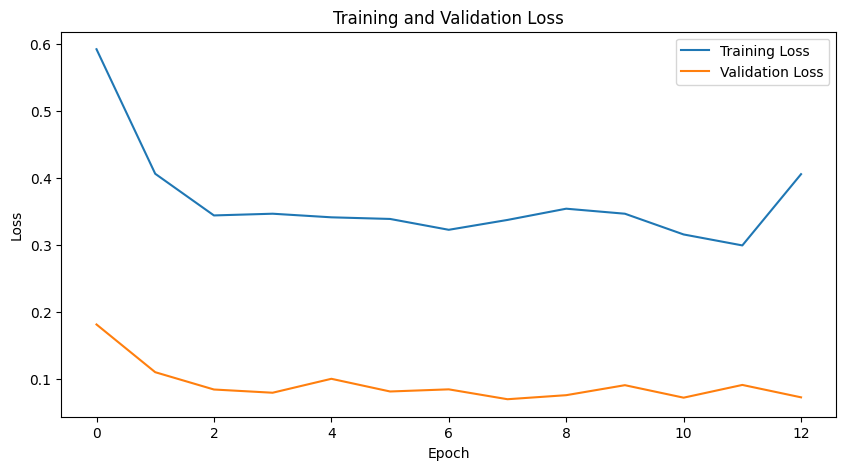

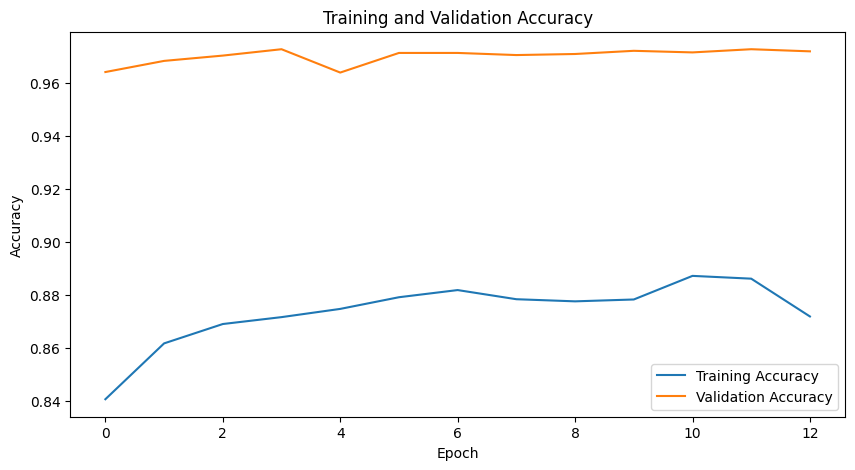

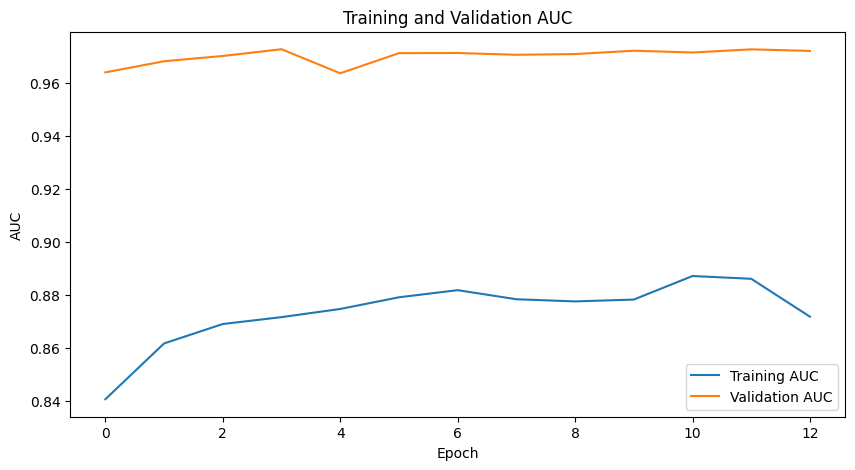

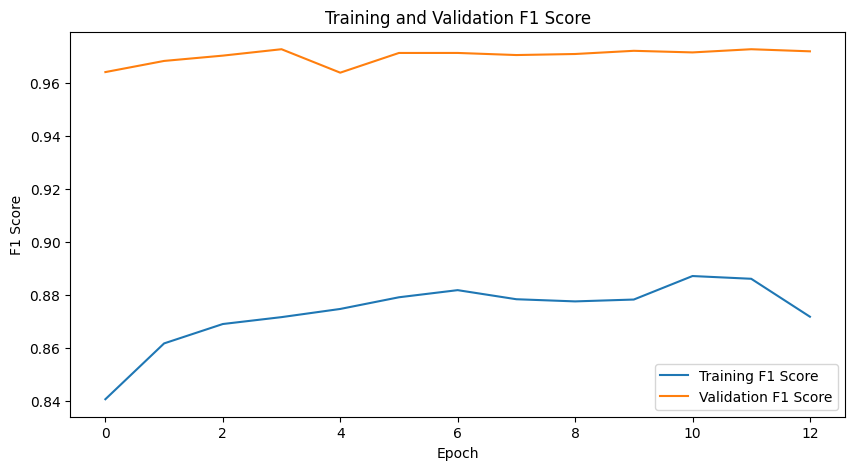

In [10]:
# Function to plot and save figures
import os
import matplotlib.pyplot as plt

# Updated plot_and_save_figures function to include AUC and F1 score plots
def plot_and_save_figures(metrics=metrics, save_dir='./figs'):
    # Ensure the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'model-a-loss_plot.png'))
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_accuracies'], label='Training Accuracy')
    plt.plot(metrics['val_accuracies'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'model-a-accuracy_plot.png'))
    plt.show()

    # Plot training and validation AUC
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_aucs'], label='Training AUC')
    plt.plot(metrics['val_aucs'], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'model-a-auc_plot.png'))
    plt.show()

    # Plot training and validation F1 Score
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_f1s'], label='Training F1 Score')
    plt.plot(metrics['val_f1s'], label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'model-a-f1_plot.png'))
    plt.show()

# Call the function with collected metrics
plot_and_save_figures()
